In [1]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import time

In [2]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
#Uncomment to compute U and V
ep=EnsemblePursuit(n_components=100,lam=0.01,n_kmeans=100)
start=time.time()
model=ep.fit(S.T[:10000,:])
end=time.time()
V=model.components_
U=model.weights
print('time',end-start)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)
obtained 100 PCs in 14.9872 seconds
initialized 100 clusters with k-means in 21.2146 seconds
ensemble 0, time 13.84, nr neurons 6337, EV 0.0086
ensemble 25, time 80.30, nr neurons 282, EV 0.0331
ensemble 50, time 125.39, nr neurons 175, EV 0.0420
ensemble 75, time 169.68, nr neurons 151, EV 0.0491
ensemble 99, time 203.80, nr neurons 61, EV 0.0547
average sparsity is 0.0164
time 281.70630407333374


In [3]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

In [5]:
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
Sp = V.T
Sp = zscore(Sp, axis=1)
ly, lx, nstim = mov.shape
#print(nstim)

NT = Sp.shape[1]
NN=Sp.shape[0]
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ Sp[:,itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, ncomps))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

10000


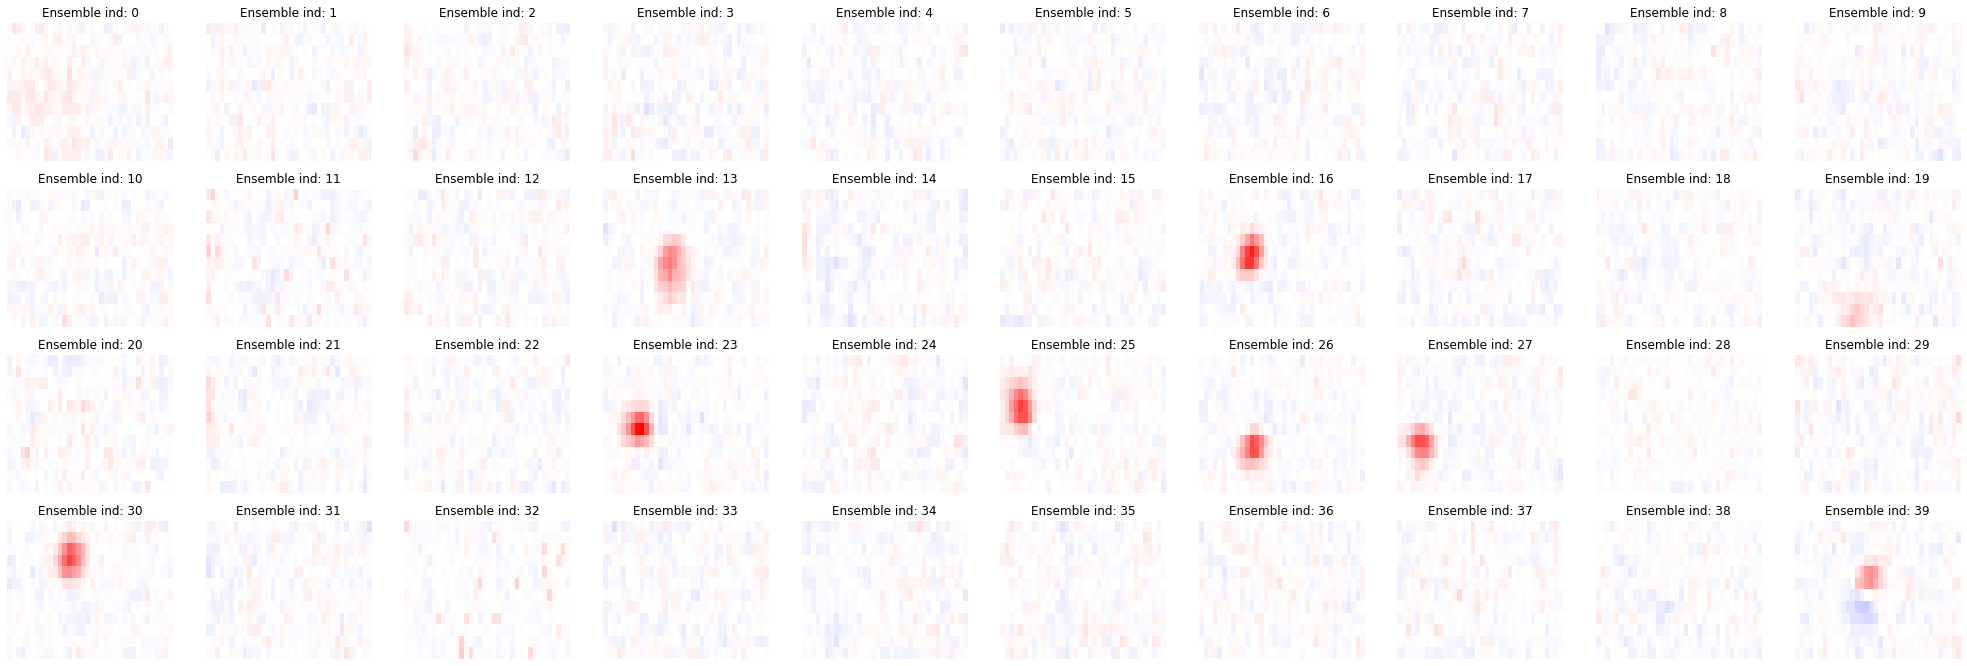

In [16]:
plt.figure(figsize=(35, 30))
rfmax = np.max(B0)
for j in range(40):
    plt.subplot(10,10,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    plt.title('Ensemble ind: '+str(j))
    #plt.title('PC %d'%(1+j))
    plt.axis('off')

plt.show()

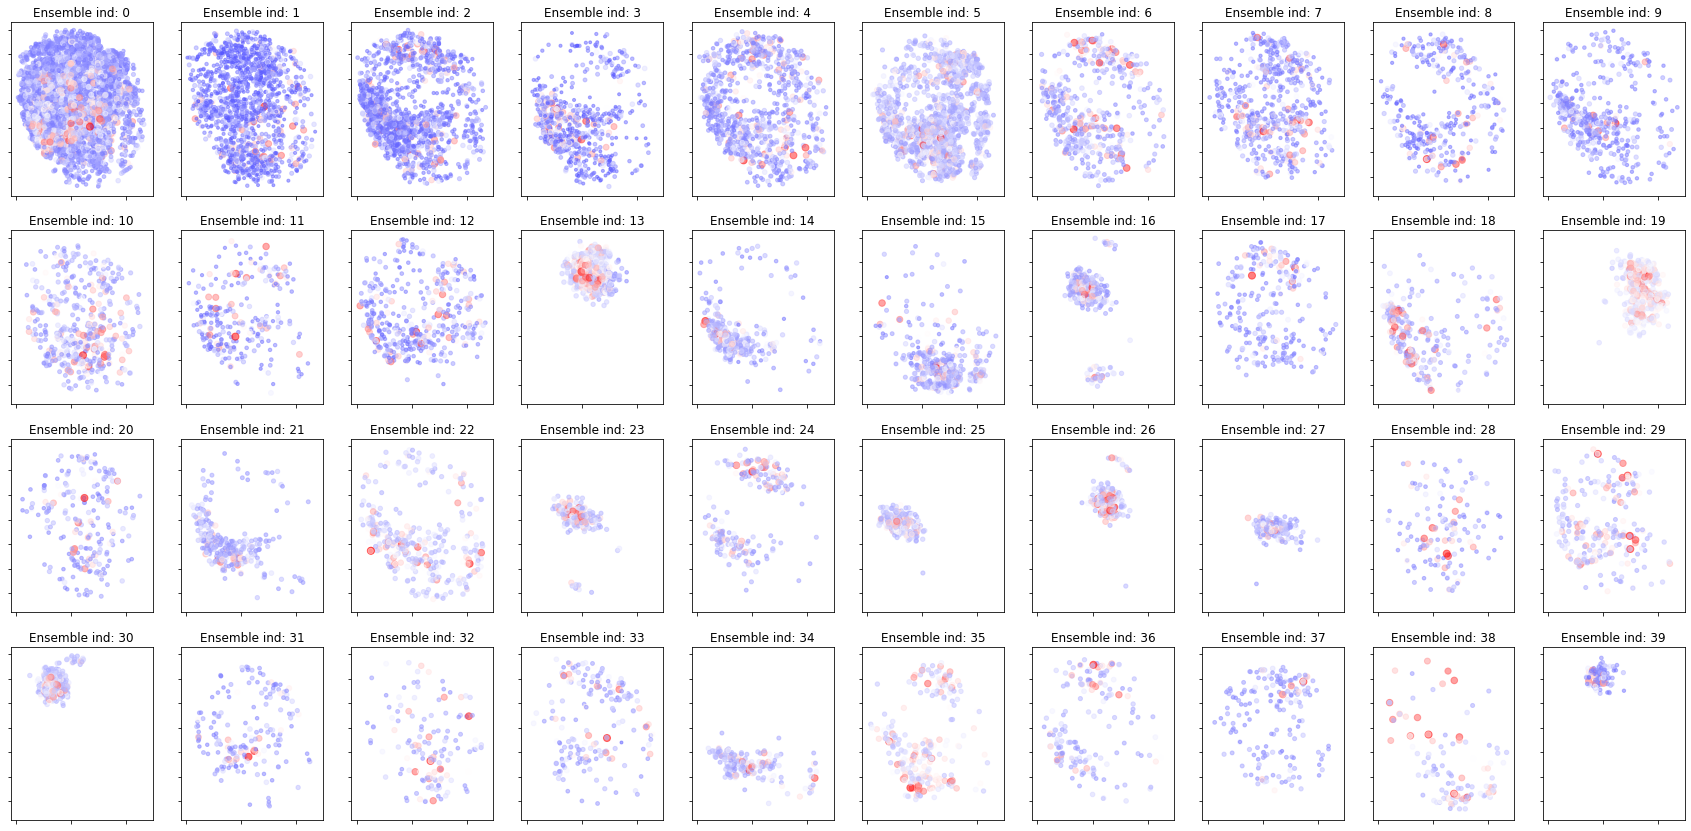

In [12]:
stat = np.load((data_path+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 
plt.figure(figsize=(30,30))
for j in range(40):
    cdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABpsAAAM/CAYAAAAusWqqAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOy9d5AcWX7f+XmZWb6qfaMbvmFmMADGe+7Oekuz4vIkSgxSJJeSqOMpLnSidIa6EIPSkbqQFDrdSUGZE08KiiJlVkeJIo9artZw/ezsYHZ2ZwaDAQamgQYa7U1VddnMfPfHr15nAdPAwHajG79PREWXy8qszm/98r2fe8Zai6IoiqIoiqIoiqIoiqIoiqIoiqLcCt5GH4CiKIqiKIqiKIqiKIqiKIqiKIqyedFgk6IoiqIoiqIoiqIoiqIoiqIoinLLaLBJURRFURRFURRFURRFURRFURRFuWU02KQoiqIoiqIoiqIoiqIoiqIoiqLcMhpsUhRFURRFURRFURRFURRFURRFUW4ZDTYpiqIoiqIoiqIoiqIoiqIoiqIot4wGm24QY8wHjTEXr/P6bxpjfu0WP7tqjNl/i9t+xRjzF25lW2XroTpVNguqVWUzoDpVNgOqU2UzoDpVNguqVWUzoDpVNgOqU2UzoDq989wzwSZjzLgxpt45Ee726xt9XOuBtbZorT27HvsyxvyiMWbKGLNsjPmXxpjMeux3q6A6vfs6NcY8bIz5vDFmzhhj7/b+tiqq1XXR6s8aY14xxpSNMReNMX/PGBPc7f1uJVSn66LTnzDGnOxc92eMMf/KGNNzt/e7lVCdrs8Y1WGM+bIxxqo9vTlUp+tiTz9jjImu+h9/8G7vd6uhWl23ef9+Y8z/Z4ypdOZVf2899rtVUJ2ui039Z1f9f5vGmMrd3u9WQnW6Ljo1xphfM8Zc6synvmKMOXq397uVUJ2ui04zxpj/0xgzaYxZNMb8E2NM6m7v91rca5O4T1lrv7jRB7FVMcZ8Avgl4MPAJPCfgL/VeU65cVSnd5c28FngnwC/t8HHstlRrd5d8sBfAV4ChoHfB/5H4O9s5EFtQlSnd5dvAu+11s4ZY4rA/w38GvCXN/awNh2q03XAGPNT3Hvzk82E6vTu86K19oWNPogtgGr1LmKMSQNfAP4x8GeACHhwQw9qc6I6vYtYa38B+AX32Bjzm0C8YQe0eVGd3l1+HPhzwAvAeWQe9a+BJzfyoDYhqtO7yy8BTwMPAz7wB8DfAH5lIw7mnqlsuh6dLLJvGGP+fidCd84Y84NXvX62k7VzrjNRda/9OWPMic52nzfG7O16zRpj/pIx5u3Otr9qjDlgjHmxk6n+2c5ArftY/tdOZtB4937WOOYfMcZ8zxizZIz5ljHm0eu81xpjDnbu/6Yx5h8bY/6wc0wvGWMOdL33Y8aYtzoR9V8HzE38K38W+BfW2uPW2kXgV4HP3MT2ynVQnd4ZnVprT1pr/wVw/Ea3UW4O1eod0+o/tdZ+3VrbstZeAn4HeO+Nbq9cH9XpHdPphLV2ruupCDh4o9sr10d1esfGqBhjepEJ0f98M9sp747q9M7pVLm7qFbvmFY/A0xaa/+BtXbFWtuw1r52E9sr10F1eudtqjGmAPxJ4F/dyvbKO1Gd3jGd7gO+Ya09a62NgN8GjtzE9sp1UJ3eMZ1+CvhH1toFa+0s8I+QIOnGYK29J27AOPDRa7z2GaTa4eeRCN1/h1TmGKAAlIFDnfduB4527n8aOA0cRrIk/wbwra7PtUgmeg9wFGgCXwL2A73Am8DPdt77QSAE/gGQAT4ArHTt9zeBX+vcfxKYAZ7rHO/Pdr5f5hrfzwIHuz5nAXi2c8y/A/y7zmtDne/6p4AU8IudY/oLndf3AEvAnmvs5/vAn+l6PNTZ9+BGn//NclOd3n2ddu3vIGA3+pxv1ptqdf202rXf3wP+zkaf+810U52uj06RTLzlzj5XgI9v9LnfTDfV6brp9B93thvr7DfY6HO/mW6q03WZS32mc8xzwCngl1WnqtV7VKv/Esm8/1xHr18BHtnoc7+ZbqrT9Z1LAT8DnAXMRp/7zXRTna6LPd0LfBepDk0Bfw/4vY0+95vppjpdF52+Avzprsc/1dl374ac840W3VXiq3b+ee72813iO9313nznnzbaEd8SkgWRu+ozPwf8+a7HHlAD9nad9PdedXL+l67H/wfwf10lvkLX658FfnkN8f1T4FevOpaTwAduUHz/T9drPwS81bn/M8C3u14zwEUnvhv4H58BPtn1ONXZ99hGn//NclOd3n2ddm2nwSbV6qbQamfbn+tsO7TR534z3VSn667TncDfBB7c6HO/mW6q03UZoz4NfA+ZeI2hwSbV6b2p0/1IhrMHPII4Kv76Rp/7zXZTra6LVv8r4rz7QSAN/E+IIz+90ed/s9xUp+s+Rv0S8Dc3+rxvtpvqdF3saRr4h539hcA5YN9Gn/vNdFOdrotOfw1pnz/c+d+91Nn39o045/daG71PW2v7um6/0fXalLtjra117hattStIH+JfAC53ytEe6ry+F/iHndK2JSSCaBBni2O66359jcfFrseLnf05zgM71vgee4G/5vbb2ffua7x3Laa67te6jmEHMOFesKKoCW6cKhLVdbj7ugjjzaE6veq7cmd1qtw5VKtXfVfuglaNMZ9G1mn6QXtluzLlxlCdXvVduUs21Uq7xz8C/t2tbH+fozq96rtyh3RqjPGQdRr/B2tteIPHoayN6vSq78odtKdWWuics9bG1trXgf8NyUBVbh7V6lXflTt77a8jbZ8+Z61tAX8fGEQywJUbR3V61Xfl7syldiOVBL91s9sqgOr0Hd+VO6vTXwGe6RxLFln3/svGmPxNfIaiOn3Hd+XO6vRvA68iyXvfQrrutJEqrHXnXgs23RLW2s9baz+GlNS9BTjRTgD/7VWCzllrv3WLu+o30kvWsQcp77uaCeBvX7XfvLX2397ifh2XEREDYIwx3Y9vgOPAY12PHwOmrbXzt3lcyg2gOlU2C6rVG8cY80nk//OpjuNJWSdUp7dMABx413cpdwTV6Q3Rg1Q2/XtjzBTwcuf5i8aY993mcSk3gOr0lrHomk/rimr1hnkN0aeyAahOb5qfQdpfnb3N41FuAtXpDfMY8O+ttRettaG19jeBfnTdpnVBdXpjWGvr1tr/3lq701q7H5gHXrGyzti6s+mDTcaYEWPMn+iIoolU77h/5j8D/rox5mjnvb3GmB+/zV3+LWNMujP5/RHgP6zxnt8AfsEY85wRCsaYHzbGlG5z338IHDXG/DfGmAD4y0h53I3yW8CfN8YcMcb0Iz0tf/M2j0m5AVSnN67TzrFkkXJljDFZY0zmNo9JuUFUqzel1Q8jfXb/pLX2O7d5LMpNoDq9KZ3+lDFmT+eY9iJZT1+6zWNSbgDV6Q3rdBnJ5nu8c/uhzvNPIS0glLuI6vSm7OkPGmNGOvcfQtZs+s+3eUzKDaJaval5/28DzxtjPmqM8YG/gqzddOI2j0t5F1SnN6VTx8+gfql1RXV6Uzp9Gfjxzv/MM8b8NLIkyenbPC7lXVCd3tQYdacxZkfnmJ5Hxqi/cpvHdMvca8GmPzDGVLtu/+kGtvGAv4ZEHBeQ8tu/BGCt/U/A3wX+nTGmDLyB9C2+VaaAxc6+fgf4BWvtW1e/yVp7DFnc7Nc77z+N9KG8Lay0Z/pxpF3TPPAA0pMRACPOpKoxZs81tv8jZDG7P0ZKAs+zgeLbxKhOr8Pt6hQpS60jlXh07p+83eO6T1GtXoc7oNVfRhaX/C9d/+PP3e5x3YeoTq/DHdDpEaSUvtrZ7mTnOJWbQ3V6HW5Hp1aYcjdgtvPStJX2T8qNozq9DnfAnn4EeM0YswL8F+A/Av/77R7XfYpq9TrcgXn/SeDPIs64ReBHgT+hNvWmUZ1ehztgUzHG/ACwi7WdusqNoTq9DndAp38X+D7SnmwJ+EUk2XTpdo/tPkN1eh3ugE4PIHP+FeBfAb9krf2vt3tct4qxVqurFUVRFEVRFEVRFEVRFEVRFEVRlFvjXqtsUhRFURRFURRFURRFURRFURRFUTYRGmxSFEVRFEVRFEVRFEVRFEVRFEVRbhkNNimKoiiKoiiKoiiKoiiKoiiKoii3jAabFEVRFEVRFEVRFEVRFEVRFEVRlFsmuJk3Dw0N2bGxsbt0KMpW5ZVXXpmz1g6v1/5Up8qtoDpVNgOqU2UzsN46BdWqcmuoTVU2A6pTZTOgOlU2AzpGVTYDqlNls3Atrd5UsGlsbIxjx47duaNS7guMMefXc3+qU+VWUJ0qmwHVqbIZWG+dgmpVuTXUpiqbAdWpshlQnSqbAR2jKpsB1amyWbiWVrWNnqIoiqIoiqIoiqIoiqIoiqIoinLLaLBJURRFURRFURRFURRFURRFURRFuWU02KQoiqIoiqIoiqIoiqIoiqIoiqLcMvd9sCkMoVaDKFr7dWuhXpf3KYqiKO+OtdBoiO20dqOPRlEURVEURVEURVEURVGUu02w0QewkSwvw+uvS6ApnYZHH4VCIXm91YKXX4b5eUil4JlnYGhIXrMWymUJQvX1ge9vzHdQ7g+c3ppN0Wi3ThXlXsJaOHkSzp2T+/v2wUMPgTEbfWSKoiiKoiiKoiiKoiiKcn0WF8UP298PPT0bfTSbiy0dbFpehtOnJRB06BDkcle+/sYbkn1fKEhg6e234fHHxUF64gS88op8xv79EATw6qvwsY/Jtm+9BW++KfeHh+E975H3KMrd4OJFuHBB7hsjzvuBgRvf3lqoViVYFQRQLMrfOJabale5U1QqcPYslEry+Nw52LEDens39rgURVHuZapVuHRJEqBGR2/uGq8oiqIoiqIoiqLcGSYn4etfl/ueBx/9qASdlBvjXV3Mxpi/CPxFgD179tz1A7pTNBrw1a/KpD2OYXYWPvABCR5FkTjsT56UIJOrbMrlZIIfBEmgqV6H8+clWNVoiNM+iiQY1dMjort0CY4dk21379Yqp41gs+r0RogimJiAfF701mpJ4GlgQDT5xhvy3JEjUmXnWFmB735XAkz79kE2K7ovl0Xb2Sy8+KK8/sAD8MQTWn1yt9nKOnUBze7WeV6nUeu12pQq9yZbWafK1mKraLXRkCQmz5Pr8OnTMu7szTTkYh7HMgjI599xoW42od1OxgjKvcdW0amytVGdKpuBraZTt2SD58ncXNk6bDWtKluT+1mn9br4/ZeWYGxM/Kndc6mzZ6XDWbEo75mY0GDTzfCuwSZr7T8H/jnA008/vWlW36hWpcWdy6ZfXBSxgAhofFzm7saII7TREOf9a6+JgJaWIJMRAS4vy+NHH5X7586Jwz6blW1nZ+Uzp6Yk+vnggxKwKpU08LRe3Cs6bbXg7ZMx5aWIgVKLg2MxfiErVuoaxDFcviz+pMFBud0o3/iGBDs9T6qfPv1pCZyCROGnp0WL587Bxz8uGm005HBOnhSN9vbCqVOwaxds23ab/wDlutwrOr3TxLFo8cwZsY35PMzNic7abdGmC0aVSmtk7FsrJVFLS2JUi0V5kxrQDWGr6fTSJfjSl0ROH/vY3bFzUSRaz2Q0aL+ebBWt1mpiBjMZeRxFsDzXpDe3IMJ1mSLNpgxSOyK7fFmSSuJYTOazz153uKFsEFtFp8rW5p7TqbVJ9pIxenFVgHtQp7eBtdI55+RJkffTT8PBg9d+f7UqyztkMjAyoj+Je52tpNU7iUvejyLxYQWBankj2co6bTbF9+kKS67me98Tf2mhIF3L+vrEJ+oolSTAlMmIXnUpk5tjUzXPimOYmZGATyYjrZmcY/1qikWZn1cqIoxsNkkMjWMxcqmUfE4YinB6eyVYMD4uwmw25bMyGXj4Yalc+vKXZXsXsHLj4Ho9ceoPD0u1ydycrPGUzcpxHj4sx6xsXU68aVmcCfG9iDenUszPRzzzaJVUX/GaHqBTp6RSyfeliu6xx650hvo+7Nwpr4Wh+OO3bZPfwdSUaLxcFl2+/jrs2SMaXFhIqu9cwLTRED3W6xIYzWbls0GrT5RbZ25Oqj1BNBYEosHjx8Xmff3rojXnI33uuats4fKyXOlTKRHs4qKIdPduHX0qt80XvyjX6TCUa/hP/MSd/fylJfjCF0Sye/fCCy+sHSe1Vuzu5cvy+tiYZkfdj8Sx2Ek3yc5mxWZ2+1WjCNLtGpSCJMXOGBmYhiGkUlgrkyS3/dyc6Gvv3o37boqiKHcEa2VSHsfy2BiZTG9Q+ebSkiSkNpuSVKp2VrkTVCoSaOrrk0v7sWMyNlyrvX2lIvOpVkseHzokviVFuReYmpLk0qEhsY/Xm763WomfFUTvuZxO+ZXbY3FR5tiFgriQqlXxs7r51djYOxNOXZK0c0GtrFz5+pEjMr+fnZVlTMbG1uvbbA02VbBpakpu6bRM1Gs1OelrjTujSJz2zqG+e7dkgsSx+DULBTFo7bY4fUZGREitlojOOYp8X4xfoyEDzXJZHg8Py2eVSiLsKBIDWyjAV76SOFyPHxeHf6Eg2dUf+Yg4961Vg7oVWVyMyQQR45MpGk1DueqBgeefauD1vjPYZK3oplQSHbsg0NWGcGRE9H7hghjNc+dkjbG+PhmkplIyCP3Sl2TbD3wAjh6VjGdjJEJfKCRBqVotCbxeuCCZVMPD6/RPUrYE1arY0vl5qWpylUxhKFouFMT29vbKhbvVSnwHr70G27d3bKC18iHpdGJ4s1kxovW6CFVRbgNjkvXp7oaf6tVXRdf9/WKbDx5MgvjdLCxI0kAuJ8dy8qSsE6ltU+4frJXrr9Oiux4XCnLtnpmR9/X2WoZLDTBdw3Q3aHTOV5KAlUv673rpto9Tx6jKnaJWk7mS70v1vlbfKe9Ku520IDFGjFK7LWPFmzBOYZgknqbTkox6s+OAKIKXXkoSVb//fZnba7KIcqeYn5cxYrstfoA9gysyDyqVVjOrp6fl9f5+0eSZMxpsUu4N5ufhc58T29puw4c/LGver0UcS6DJjV1dMmAnj0pRbomlJfHBg9jHclnu+76Y0CgSn+fQ0JVjgP37JXHPGHnv6OiVn5tKwfPPr8tX2JJsqmDTwoL4HpeW5NprrRirq0viJielwsNljj7wgDhzMpmkuiOVgkeORLRbEZ6NqbTSzM8b2m1ot83q4vbWihOg0ZASuvn5xDj294sftNWSY8tkxMn0xhtiMF2mqhsnh6E4pSYn5Xv090uwTA3r1qGvZLk44TM7Z1hcMuTz0Ff0WVlpU+pde5tMJmm/5HTz2mvy2qFD8nylIppvtUSPhYI4+w8dEqdmu52UduZyMhHq75cA0q5dUplXq4nTf3JSBqguMt9owPvfL6/PzooR7u2VINj4eKJT7Wim1Osy2alUxMbWauI8T6VEfy7Q1GpJ8KmvT2ym06Yrm6/Xxam6bRvUqpZMKyLIr3E5CsP1/5LKluPjH5eKJs+TCdCdxvOurEpZy5HVbkt5/vKyDGTTafmd1OsabLqfcOuIuuupa+VsrWSCjo7KuDadNrCSgbCVpDg7gXUGjcaIo+n4cbmfz8XYepOvfjlFoSfg6FHR2enTortdu969un5lRXRar0tQ4NChtTOsFeVGqdWk8tnZyNlZ0a3qSrku3YGm7udugiiSICfIx9Tr8hG9vTcXTG+35Xrd05MckpvHK8rtUCpJR5JvfUuu1/t3tVj+3a/SCs7gBT6+F2OeegqefJJMxlvtztNsai6ecu+wuCi67O9POu9cK9jU3Rm1+697XlFuhZkZ0ZCrEr1wQeY8bo7uEvyuTjw9eFCu7Ssr4gPt6dm477AV2TRD/SiSgM78vBilpSWZlF/tALdWFlkGEVMUiXPdWqluunBBnKVLSzHFTMT+fZbBEY9ap4OTMckiy66VnmtvNjMjAnZO1bExcci7CqfBwaSdydKSDEydmGs1+ZyZGZlo7d0r3+Xtt2XSpRmkW4PDRz2mLrWZmw+IYyiXDZdnDKnc2j81Y+CRRySi7gJK586JZkGq4T76UQksGSOBpTfflCBQPi8ToGIxWe/BrR3WaMh9V2myf78Yz8ceE+fRwIBo2vfhfe+T7T/72aSn6Uc/KgPfVErWOosiWbNMuX9pNiXAFIYSSIoi0WCzeWVL0nRaKvGiSGxioSCvX74s+nLLMVUqYj+npgwPZLOMDLTpGeg4UemMON0CJopyG4yOwk/+5N37/CeekPHJ4qIE5kdG3vmeF1+U630QSLbVoUPyvEr8/sUl6ndPvF3ShzHgm1525RbI2HayUW/vFbOkAwfEzl46scziRIVvvFWkP19hLshRrRToH/B46y3R2fg4fPCDnSB/TWxwECTtTWdmJCHK9+W5ubkkiUpRbpX5efnrHKMrK6K923LUW5t4DUB+Ey4TUFE6uOIol9RpTFJlfy2puNb41kryXhjKeLZUEieqW1+kr2/9voeyNYnjxJ80NyeX952vfZHaSsjLez+OnzJss9Ps/daLxCbF6KOPMTYmyc+5HDz1lHzGykpSuXcrrchcIsAGdahU7mGaTRkvZrNrr3fjGBpK2jmD+FyvhbtUO6e/u5xXKrIfXRNHuRWKRbGDrZZodts28TdNToo2nV/q6tiBMcm8fXpaEvTyefGdXmu5HuXG2RTBpigSx7hzana3v1tLBHEswR4XZfc8cQSdPSsOz0rFkk5BPhdw/JRlYF4Glum0iKtQsJw+bVbXsGk2EydAvS6DAdf+rN0WB2q1Ko+tlc9w6z8FgbzuPiOXkx/D6dMy0ZqakrZo27ZJT0gdvG5uMjmPAw94/PE3LD090GpD4MVke6+dut7XJ2t81Oui79/5HblogxjI73436W27c6doqKdH3jM5KTrq67NkM5ZLk6LTMPRoNERzzgE6MyNGtr9fnKNjY6LVUkkyoy9elM9eXBR9WiuvuSCpcn9TLou9y+VEF+Wy2L0gSNbB833R5sCAODbjWOzq978v27gWpK5c/vJl6O01LETDrFxepDFTwMaW0VKVsYN9eFcZeGslQ/rcOdnHU08l14CJCanY8/2k0mrfPl0nT7n79PTApz99ZcXK1Vy6lGRLubHEgw9qZur9hu/LLQzlurqyIveHhqS16OxssixJu+0zFQ6yo1CjvhJhLWSqIZlUiEklw/fafI3j3w9pRCWmK1nyOeg1FRYueVRXZNbusvEXFsQOnzyZOJj6+mSfb70ljoIgkGPM52Xyf/YsXDofUshGHH4kIFfUMmflxnFtcq5+7rZw2YRXt5bUEvytQxDIoNNh7R1ZRd5aS60cUl+JyWah1OuL4avVsINDTCz3sLws7zUmie+Pjcn8KJ0WR6peu5XbIQwlEO/8SKkUNKYWqU2XmR57ngFTwwst0/4ojfgQwf/7CicuPMwL7/d57LHEri4sJF0l6nX5vN5rdFK5mlYr8UOFocyZHnxQY/ZbiUpF7FZ/P6tdm25m25dfFm0YI22/r7XkQl8f/MiPiLO+v/+drci6MSbplh9Fcnv99cRv+8gjkkilKDfD9u2infFx0d/DD8v1emlJbO3IiFzHu+2b67bjWpq/8opsMz0tySXPPqv28HbZFMGmclmEUCrJX9eebq2oeRyLQ90tBhZF4uRZXhbHqMvaaLbMauVRrZasx7R9u1ykgyCJgrqIu6sgWVoSx0C7naz9dPmyiNNacR7k88nkyh0ziGHNZMTpVK/L59dqcltYgA99SCP6m5k4hm07MwyPxExegkwWPvzxNHjXtlRuHTFXnfTEE5JdHIZJ+WdPj1z0T5wQB1WxKDdrpQokZULyOY+ekiGbjjk/AUHg4fuy3Ve/mlTrPfecPOfmcI89lmRS1+tyLF/7WtKiMpeDT3xC3luryesDA5qRv6lwRgxuOfvX95M+y8vLYueaTRlUDg0lQdBWS2xkFIl+Z2aSYFS7La898gikUraTPGBYiXJcrKYZKLV57bhPs93Do2XDJz5prvjpvH3K8u0XLb4vFVHNpuGDHxTb+eqrosmzZ+UYxsZksPDBD4peFeVu4no9X4sHHhCNugyqH/gB9YtuZly2uwvM3CgGSy4L8wuGxcUkGer8ebnOGpOMU4MA2s2YctVg8FlpBbRrPtFUm95ijWx5ljw1pi70kfKzFAshCyuWmeU0cQ9s713i/FKe6Wkxoum0JLZcvizHnMmIXXbjY9cyul6XY/I8SPshb71UwWs2WIx8aucbvPfDOcw2XeRRSapAokicR2u1BR8eFl++W3S5WJSxgpujOUeWC8SuNTyxNnFMpVIQmBiswTMmWfvRpUmrZ2Br4AJLrp3yDRhbt56zMWLP0ukkZuUqQJqNiJfPGqIooK89x6Onf1dsroUossw98iPYHbvwUz7Npmzv1hlLp2W8q9nOys1irQR2qtUk6c61twfxP41fjvle+jlSdoBsGFFKNYjDiIWwxJjXwI9aHDuWW52Tt1rJOjeNhjjr5+akcv7dNFqpSJLe1FSi7TNnZL6kazhvDRYX4Q//MFmi4Yd/+OYqis+cSbo3NZuSkHQ9bQwMJPPtMEwS7TMZGWe+9po8f+SI+Aecn/Wll6TDT7Eov4M33pAOUDfaarfVEj8WSPK+Lk9yf2KMJNc/9FDic3r7bbn5fuK/37ZN7HCjIdpxyXgXLiRFI245cTfPux7WyhzuwgXZ9sgRTUbpZlMEm1yFkVvQq1aTCo+eHjh2TAzXgw+KAa1WJVjk2jul08nkOQzF4HkepNOWfAGCwJBKWZpNCTa1WpBJxxRyUMhbAt9Sq0Ol5pNKeZRKIrpduySI1W7L43Q6idK7sujucmSXgOcCB0NDchFoNOS9boA8PX3tHqfKvU0YysUuDOGTn/SYmZHI+u4919+uWhUD2GzK41xO1lDKZMRR73qMXrokj+t1GRy2WvK+8nJMMzTUm4ZGw9Joep3JlcVaQ7Eon+uCSceOye/jwAHR5RtvyD4+8AGpbjp5Uoxysynfx/PgP/9n0fjnPy/PDwzAn/7T6sTfFHRazcQxjJ+HxcWY0R0eO3eZ1ez6el30NjJy7UGaC8JXKklbx95esZs9PRLU6e8Xm7i4KFlKbgLTbovzUkqYrbRA9aQ14/y85fRpyOZ9zk/5mBQUsnKss7NdLeK4FncAACAASURBVMmiiPFTbXpLAbmcZWUFLl70AY+VFbnYl8vJxG1+PgnSqk6VjebJJ0XLYSjjFw00bV6qVQnYgFwft2+/gYlFFMlsu9HAMwavVeTcuSL9/abLl2o7bzWra9/l/BADNEKfetPHM5a56RaXzht8b5hiuEBh7hyt6gFS6SxDpRb9xTYPjFaxUcR8p/LeORump995rMYkVfiDg3JNCAKZ7K+cnmZpqUCl1cdKw8dftDx47Ptse3+nTF+5b3AZyEGQtL6ZnpbrdBzL8/v2vVNfmQwcPSrXZ89LKkXa7STQ5BwD8M6JvbUypqjV5HG7DT15ORbPl4zqQNs/bU1cBPJauGzU/n7qUXp1XWVrLbXFJsNmjr58hqVgkMlJiShdnjT4gSFqtNn25X/L+JEnSQ8UIQppenlmy1lsZQHbP0gm561WA1xdRHctrl6PRFFAHPfHjiWB9aNHOzas0wG0UoGpapGd5gIN08fl5gD51DQxPvn6AnEqC+n0O4r9QOblb74p9rTVEn/BwYMyNlkrgdlaGcN0tzJz2zYa6/P/UO4+Fy7IeR0clDnxxMTNBZvcsnmNhszhgyAZS14Pt5a906e1SYtmz5PfwYc+JEGs+XlJEnV+p8nJpLtPHMvrKytJC/6rWz222/J51WrynZ95RteEVIQLF0Q7qVTHxk4lgSR3jS4U5FYsym/EBUoLhRubq8/Oii81l0s6VrzwguY+OTbFT7FQkPFkpZK0SPI8qdaIInnum9+E97znytZf3WvLu/Y2MlGyDA3JBKiQhyg2DA1alpYsRw5F7BtpsDBkabYDbAyFfEwr9Dh+Okuj6eF5SSupWk2OJZ8X4+r7Sb9ct2ZO9ySqry/JinLZ/t2DhePHNdi0WXHVHO68Dg/L43PnJLBzLYNVryctIkF0FMeyYKjvSzloGFpaLcvcLORyBmMMhQI8+4zli/+lxfRsilZo2bPLMjcHA32WVtsjnTEcPSqOf7ce0/btMghwwVhXDXjunBjIVks06taQ6uuT7/aFL8hvqr9fHn/nO/DJT67bv1e5FboMzKnThu+/Zkin4Mw5ywvvM6sX1FRKdHjpkuhurb7d1apoYXhY7N2xY7LNwIA8dm0aXdCq2ZTJVU+P3Go1yWQaHobpKejrTxZirJTh9JlkLahcLslIdUTLFfoG8vg1A3hkc5ZWPQJr6Okxq1mrroVesyma14UelXsBz7t+D3NlcxBF4qRxSfauHei+fddZ78B5y5tNLDLz6LcL7MtWGD8BJhXw3Ht8UjWfnb0+c+UMjVZAOgO0Y1aahjDy8T1YXopoNT182yDwPKrZIUojdR61Z7ls97Jnn8fRPVW8Ro3T7b20zpvVibsL+u/d26lmqsS0mjGFVJvenGVhPke5bOjvlwroQqrFmdcWKLcGqdY8YmsII8NXz+3lT+yfIfOQBpvuFxYXZXxgrVzjx8Zk7HjxoszP3Lo4vi9ZpVeTSsn4AOhMikJs0+J5PmAAiwfEIdIJoOvH1G7L+MHNp5aWIPA8eooxjaalXIaBPnRmfz+xvAz/8T9KuweAdJrmMx/Ff/r9+MbC5AReHBJRI11bIGQb6eEHwfeJIoPvw9DSaeJCgXaxj57yJCYVsFwYglSOdHmOOMxSq5Xw/WSdJzevX4s4TqrvjJExrFZAKY7xcfFnZbNiT5eW5LGb53ge2FSGKF/ETE9hB7ZhrWFvdJrxcsiL+R8hOufzQz8krclnZ8WmjoyI4zQMLe225fx5QxQZLlyQ+f5733tlwp3rYFKtJrHcSiVZguLSJUmI0vWbNj+9vUlFZxzf/Hx4/35Zv9utI14sSpux5567/nblcpLEBKt5VqtjgHo90eHrr4t9LRZFk9WqdD9ZWpL73/2u6DuVEj/vAw9ceZl3nVZc68hyWZ5bHW8o9yXdBR4ucT8MxV+1sCB22C37WavJ88PDop/Ll+V6v23bjVU2Ob2nUklSdrudxCvu92Hppgg2LS2JUHI5d0GVx04cYSiG5vvflwtkGIpA3MXTnWRjRDQDA4aBgU5LqBZ4JiLtRQwNptg13MKYmKVKhvklA9aQTsXs2h6RSUc0mgZrDcvLYhhLJdnf9u1iOKenk7I814qvVBKxp1LyXmuTFixukVJXveIW0lU2H24dMdeu0WUvtduiz6sv8svLMk9y1R9hKFqHpFpkxw5I+TGzMxGTlzwshmzGYrDk8x6nT8PMrEfaj1hYDKiXDL29lp5STDOSCqexMRlovvWWDEoHBuTiXauJTh96CM6dCbk4bqk1DL29Hs2moVg0NJvynp4eMczN5pWZqMomoHOiLl82FPJyHstlmJ2x5PKGrN+GVkQmnabZ9gjDpCXo1JRod2hIzvvUlAz0du1KsuWKRdGWq0AF0ceuXTL4cxV7AMvLUtVUq0MuD4GJiEPLqVM++bxlZJth8rIhl5Pfzhe+IBlKB/bFVJZj0mkwNYtFMpr37omwkUdvr88zz8A3vpH0540iqZy6rUXIlfuaKJIJvXOURpFovVqFw4evtOlhKHZ1YUH6ml+vX7myeXFJTC55JAjExrns4GtuVKvx9kSKty724AeGp/bO8czgOY6uzBL0l/AGDhNTJF0I2J4Lsa0GL71eYKWW7mjJUixAVGuCtcTWo9JI04xTpErbeXR0ksPmddi2HduAau9OevL9lBZEr3GcJDr19sJAT5uZpSZZ04aWJYgbPLt7gcXsTjzfSHVKI2JHsUzOb1EhSzYVYYixeNQqMdpJ9/7AZcq7YFKjIc6nYlEm5S47340JDx1K5l0u38UY+Zx2KyZnGvjG4sVA1CL2A7xuD373IpAk8zjXUc1aqNakTXQ+K1XbeB5LFW+1smV09PqLmSubmHYbfuM35OI8OrraIzz9R79PrWqpPXCEAdMgyKcgTBP5vbTqeVpzS2R3DJIKIIzAL89ivRQZWhjfAwxB1IRmFcI2ttki3Rvj+x7NZhJoXYvuNo+r7fqbiQNKUfr6kmz6KJL5uKyxLJoplcS5P3N5P/7sZV6o/Fd2hEvM2QHGd3yU4e0D1BvSimx+Xq7l4+MyJ8un27QbMDlpsLFH4IO1hqUlCQ7s3Su+gFZLEgTqdakmce3ySyXRcKsliacjI0nCq7J52btXWna7AOLevTe3fV+f6Ktalbl0KiV+gHerbur2vUKyJMPCQvLc4iIcP24JWnVWFj2yaUupN4PF4+JFaUsGovX+ftHsq6++M3nbjT26fVKqWwVEB489JrpZXpYuaHv2SCI0XDludYGnVEr05vR6+vTaCVTd9PUlySatVqfaPrhy/Hs/c88EmxYWxIDlcpL9W6nISWu3k56JCwuJGMJQ/k5OJq0YqlUplxsYkM/JZJJejFJZZOnvlwzUIJDXogiWlnysDajVLMVcxMKyx3LZo5i3gGWlZphd9OnrNURWBgczM7L9wIAEtoLAZdXbVXHt3CnrkThcdpTrHV0oyP1mM3HUvlt5vrKxuAwRF7E2RrRw4oQYlx07kve5i91ahqbdhs99TgZ7S0uilUOHkv61rZZUDv3oj8K2gZDhPkshD4sLPvMLMDpief45i8VQrftMX7ZU6tBTiBnbHWOthzEePT1iYEdGxHi6Mugf+AFxFGSzkLV1XjwXsWsgpEWa+WqWxx6ztEPD/Lzoc2xMIv5f+pJUn+TzSZmzcu/g1kBwfhrPsBoZHB62zMxKBVA7hIF8jXhmnnxUxjOWei2Ggd14Y/2A4e23JePIBU5HR0U/Fy4kenKVe3197wzqeJ78NpwzamkJwtDQblt6S5a0F+ETE7ZCbJTBj0IKuRRjYx7FomFuTj7ja1+DniJ8+9UibRsQeJahwZjRoZDAhxNvwVJZJmkPPghf/GLikBofl4CTotwscSz2bmJCHr/nPXLt/+Y35bd16hT85E8mdv7ll6XneDot2/z0T4t9VTY/cSzndGFBrn3O6e3WAnnXpUSiiMWy4VJjiNG9HnFseWN+lPcezVColIn27yH2fcziwmpD/BYpKlVLsehRr0ZSQZ+OSbXrhFGei3N55pcDothwKWNh72F2BjP0Do2RLqZpkyPrG559VpxL1sq4+qGH5PhX5hsMZmtYP6Beh5otMFqfoKfQS5WSjGGyWXKlFC/sneBzJ/YRRob+fItiqkFhh5aM3i+4zgxO493tSFzbWheIcoFX3xd7WS4n3R0mJmCw1GagZOkf9LAWJqegGRr6Biz9/Qbf6/IYdQbPbqzd3XIqjg2VFZ+5BRnnBlnD2bPyW4xj2e/hw1pZspVw83/v1Gm8y5evKBWOUxmqhVFSX/si7W2j2KEU7dgjG7aYXOmhjUcjSlObixkaMiwsWuJ8L4Ptyyz6R2iZIsZAjgbtuXkqFQOZEvsfk+u4c0pdK3nQHV93FrPTrAabtjZRJL6oOO4kiF7jfD/6qGhoYUHaKu/bJ1pybZ1SKWktBj6et4ug9aOYRp3WYg/+Syl6esEiY0/XYaevDyYuxDy6t0wxlQGTJbaQCWLAY2HBrFYrnTkj13/PkzGBS4p2fqkgEL+Z70vidBzLvOp+d5Te6zi76BLXu8+XMXIdPHxYHtt2SHtmgaiyQj1Ks2gGyPblVmP2a9HXJ9dRY+SafiOtxTxPtO1sZ6slQaKZmaRC+ptfbVMqX2SgNsEDNkt1pcC+2iQXdr2Xnp48U1Pib4rjRJdr+Uj7+8WH5qqvXKKrcu/SaMitULi710djxNf5vvclz1kr+61Wk7aQLjEpn5fjyudFb/m8BEXfjaEheOIJ8Y+5x1NTkqTaakmwq1qVYO/Ro/df1eg9EWyanoY/+iM5oS4IUyzKY9+XjIuVFTlpbuFP50x0gz/33PJyZ92lTJIJJ9UlFs8Tp7mbsGQyzkAbpqclar5S90gHcaergxU/LR47dntkch47GmL83nwzWQPn8mXxD9RqcWdSJm350mnZd72eWP7uSVuxmFSXuICEZuLdu7hOOPW6nKs33pDB29xcolMXZGy3k/72+fw7eybXapK1sbgoxm55WbKPSiX57MFBmbSfOwe7RySAOTRo+ZmfCllYBA9Lz2CaVBo++9mAkJiB3pjeYsgP/ZDhc18KyHaq5Vxws79fLsDO0MqCuJZoYoFcpodqO0et6eF7EtgyvmV42Kz2yS2VxHi+8oro9PhxCZBpm7J7A2s7ix93qs/SaSgWDanAgyji8CGLZ2BhUXQwcWyaHXtTtIr95Pw2uV5D9dR5JhpV9r6wh/FxsVHptAT8z58XOxfHMmB0bRm2bZP727d3DqRWg4kJpiZCLqzspXc0Rzrtrw4UowiKuXB1IfB80eexw02+93pAHIds3xNw5jSApZS1hG2f7xzzmFv0GBiwtCPDUtkwPAjVMnzn+z7ptCwAuWNHsj6JtVLt+slPqsNpM7C8LAHJYvHOtz9YXk4m9END8vnvNoGuVGRC7gaLr78uti6Xk79zc501dXKSYH36tAyaMxn5CTSbGmzaKpw5I2sZLi4mGckPPCCTklRK7M5aekrGqIbJWj+e7xGGFhtbcjmPSlSgmhqlL0gDVjxJYYgJUngG/MDQasHUgk91xfL+5yMOPJJj+UuLVOu7ia0hFVhWmgHHzgwwM1okdbyH/ftF59Ymay+122L302mwUYwfNomDFJ5nVyuVDQaqVXLDJRkfGAMPPsiB1hv87BNlTi8MYGzEwYOG9Pad63wWlI3COZrCMEmaq9WuzCR23RqGhuS9lYrYc/e7mJvr2M5iTCsyLCzA3KLP9Jysn3NpynDkoa41Grvw/WSd22ZTHi8vy/7TaUOtlmRMu2t9rSZjAV2vcWvQbIqmAGgVKO46QJbW6uvtNrRIk4/bZOuLmHgIr75CA5927JMNmmyzs5yuFhjZ7vHgIUvm2UP4v/5H9J3/CnO9B4lTGXYsvkxh/Dj1g4/gPTHEdGbHajKoc+Req6vD1YmFmtG89bEWXnxR5kfGiJ36yEfWdsan09KpoZtiUYJOCwtyO39expwDA2BSeSjkGSkAL8mc24053PrlQSBzr0uVXjCWg7saTM7nWKkZAi/GWp/BQTku1y7P85K2+s6R75aBcEk0nie+rdHRtdd8Uu4N2u3ErwhyDt31+mpsGLFyepIaedpxH7PVLJW5FtXQZ+FAmocfXnsfQ0Pw8MMyDi6VpHND9+eHoSTaXb4sWhwdTfxZLhHVjQXcUiO5HPjnX2VyMUt9eICGzbA/M81Ie57z4+ep5h+k0fBXu6MsLooOn376nb8tY+DIEfHvQpIQptybzM6KXmT8JjbxTtuYMJTkpmpVbOzu3UklnjGwa6dlfi6m0TDk+g2DQ2Y1ANTbKz6vXE78vdu23dg+d+4UWzo1lSzRW61KELRel+94+rT8Ju63lvr3RLBpYkImIsaIs7RSkRPWaMjfvr6kiqS78sO9F+R5F9WPIhGaWxxeLp6WZtPgeZZ6XUQ1MSEC8DwRY7tt+O7xDO99ss7+XS3GJ9NYaxkdNQz0WU6dhakpsWClUpLBV6/D1JQlCk2n+4OlVhcxt0L5XPfdXPu9dFoMsisPTaXkgqFO0XuXMJRznUpJK6Wvf10eR5Gc05UV0fHP/ZwYJzcQ7Om5Mortgj2Q9PR2QaGeHtHxxYviqHzlFWgd8XjpJZiZ89i7x/LIkZjlsuHSrAR7HnwQajUPaz16twV4OXjosGy7siLHffBgMvFZWpLB8fbtcPShGN+GvPB0jd/94xzVFRgajAjbhp6iwfMMmUyyuOPp02KIh4ZEu67dn7LxtFoSBPrGN+S879jhenUbPN/H9yxHjsoadf/htxsc2ZljqQpRxWMg3WS+VaTRc5C5CzB3zFIum9UWYvW62NLJSRnIPfqoPO/Wl4si0UZtpsIDcy9SyMZUV7aTzUdQKROlewCf7dvFbs5dbDCyJ4OxEXGjzZGDMWM7Wrx5KkWuB7K+4eVXfcYvwKNHmlSaGSLrU1uJ8HywachmLOMXs+Rycizz84m9hyQZoF5Xu3qvMz8v9tRl5z3zjGSnXY9mU66nvb3Xbm0DYoffeEOCBVEk2XVPPpkEzxsN+Qw3ZnCL22dlLWbKZbHNY2OSFTo+LoPlo0flPbOz8Lu/K9pz690NDmo281Zielqum86OzM6KDRwZYTVo3k0cy8R8clImLJcvBfT1BdTqMkbMZaC/19KOPOZaQ/SVF4gLu4kJ8azBs5ZUAAf2wde/Ke2eR0cNpyeyFAay7Ni+xJsLbTwb4NuYduQRegHYFksLES/N+jzxhKuuTyZ1TpPGM+wsLnNhZRBigw1gyK9i4oh0zqe/O3jW10f4xNMUZmd4ImxB/5AMWu+31Lz7mFRKApYTE2IvXfvwej0Z+3YHNqenk4ont7i4m2tdngsY7mmxXDNcvOzR3xtLa762YXoWRruDTV0/rHRaHLAnTiS2v16X11wWs1vvEa7owqdscqJIrq/Ly+LQNOUeRve9wNjki/it+ur7bBxDbInbMalmFTBEiAgCE1OpGWqhVNSl0gY/lYfPfIbcv/7X7H7rC6z2ytuzh8IzR1ka3Uu9a5H7bFY0tVYSiVujyXVTcfpzlXYu+VXZWri2dC6BaWFBtNrXd+OfUavJmMIFCaanRTfOrrU6MdWREfExOF9RrZZ0GGk0DBiPbDHNB59apmVTzFcyfO+4v5qs7bZrNsVH4aqbun1rTrcTE0kQ47nndDx7L9KdbO9sjvN/BoEkYJ46JcO1p58Gf3mZus0RBJZy3Sdsw8BIimByiUsXhzl82FxxzWw2xacQhqKzAwfWtmFvvy3zq95eGfe+/bbs0xiZL3WvZdNqdapEo5ADF79CpvAQBNvZ5c/xUO48hpjdlbO8Ob0XL5NfrcRfWJCg7J49awfxjdGg6GbhzTeT+cjkpHQQeeqpayft3QrnziWtRqen5Xfy4IPyWtSKuHSuyVLZI5uO2VayeOQAmdMcOiR6Xl6WBGu33bthjGzjCk3gSj+F5yUV//cb90SwyWWlOWPp1rAZGZHnyuVkLZy+PpnEzM4mjn5ITqxbTwaSDJC+PlcGZ2m3xWi+/bY8l83KxXt0VBxWE5dTfPklj327WowMtomtYedYwNnzhlOnzGrGvCs3bjTA9y3VqsVaQ6EglVLWWvr6oFyxnD6dLEwmGSMWG0YUCx67dpnViZnvG6IIfv/3peRP1xq5t+i+wL39tvx1F/lGQ14fG4OvfhV+7MdWu+GsEkWiOReE+vjH4ctfFn27aqnhYZm8v/GG6OvCBTh1KqBStsQxTM8YXv2eR2whlzO88kpSxbdrF7z//bKvAwdE925BxmxWjm9mBn7rt+T3cuIELC15TL3dTzP0SKUsRx4CazwuXTaUqzA7J8ayp0eOK5eToEIUQU+PZXBQZ0/3CnEsvbwrFbFpExNysX38cdi1yzA8LEHv2orYm3wQUmsawthjrlmkQomcHxLjceGCxYva1FakTVMUGYJAzn+lItuvVjIhVR/nzsED5VO8uVTggt3NQj3LzsMZslHE8mKMn/FZXJQB47bTrxMW9hP3F7FWJklB3MAzAYEP+QIcPRITpA179/iUqzFLSwErjYBUKqbYYxi/nKeykmSvBIFcM7p75huj1SWbgfPn5Zz19ootPHPm+sGmahX+4A/EluZy8KlPiQN0LWo10afLqnv9dbFpx4+LLWu1JMD0zDNi5z70IbGdmQx84hPym8rlpEQ+l5P2eM1mMpl6/XXZj1t3cWhIdOhaR1SrMgm6XkBMubfJ5RKHoWuV5MaB3VgrDpyvf10mOPk81OtSmfz4o5aBAaiUYXAglsWQmynOzJWwtRX6fUOufxBaAQUTks17HNhvefuMoackVU61utj0Bw4V6D0X0YoCmpFPOm3J56FSDwjyFt+X43DJLPl8p2o6jmRQEIb0jebITl2iGRRI+TF504DIwAN9kEq+z4kTcOJEFt/fw7PPwg5ddPm+wzlDMxkJYLoK/PPnE425diUuOcU53tttsYGpVKeVY83HJ2CgVzybrpVKFEEm1SkFdL3yrqJavTKT2/MsmbS0Cw5SLgFRxip9fde+JiibC9e+/OzZTsA/XeDs0ihDpkSvrUEck/Ji6qk+3n7wvfj9T3EouEhfISTbblKIm1QbAefb2xkeMavJSaOjyED2r/5VEfPMjAwYd+wg7Btk/mJANptU7TWbSfYykHh3O46IdJDC87zVMWh3K3WHBpy2FqmUjA+qVTnf1wpGXo9a7Uq9OIekCza5zx4aEpvmAgj79rlKU0mkboeWMPYYGrDMzrS4cEkypyoVufX0JAmzQ0Ny363f1NMj+k6lZN/OV7ay0vVbUe4pnF3pbtvpqulnZyWpuFhMui48PlwDk8UQ43uxzL2ByBqCwBJFhmPHZOy6Z49s48a75bI8V6/L3CmflzlRPp8UCLi1nF9/PVl20fnN3N9CQWx4Y6kN7YhHt8/R0zO3+n2qVThU/x59O/Yxnjuyul0mI36NhU6n6YMHNd9ps+Jayy4uymXX2c/3ve/OVPxYKzbLVbgFgehGujdYLo03mZn3yWZgpeHz9tmYI4cb+EWxl+k0PPKI2MPxcfH37tkjvyX3+bD2tdz5+rsroHfvFj+VS0xcq3p/q7MhwabFRamSaLUkYnj27JW9OLtb4vX0iCijzhx5dlYEUK1emYUBiTGLY/ls12ZB2tmY1bZKR48mpcSuLV+7LRfvxUUYv+Bz+myuE0iwfCwL5Yq5YkE818ohlZJ9lZchji21mqG/34pzH6jX7GqbvHZbflRe3CZFxMxMmqUlqXxKp2XiFEWGSkXWhfjhH9aB6XrRbkvGXLstF7K1qnVSqeR853Jy/p3DyQ3etm9PsjqvrqaYnYVjx8ToFYuyaN3zz8Mf/7G83/Mkyn/okDzets0FW0W7GIg6k57eXglMvvmmaNkFArozO65uRXXpEvze78k+XBu9Y8cMe0azRAtNphdg916PKJR++HPzEjx1a6ONjclAY2RbzJGHYh571JILgCgZJVsrVV/nzsk+nnhC/pfaTuLu4/wzboFsN0Cs1+Xcu/XF6nXwA0u5HpDOQNz0IJ0i4xk8PAmot2Jy1XkKrTTWD1gMiyxXPfp6obfH8vj+KjmTBmRWNTUlk6Cl85ZvzzzEYiMHFhpBxMFDKUqZFrnBgHbbUK8bsiN92PMniNq7MT0lGRDUl0j7GeoNqKwY/MCnvyfCxpb+Xsvjj8v3CUOPbFYqDcDSasTsSs/Rl60xe3E7w0NpFhZl8fAPfUid/JuBfD5pfdhqvTNQfzUXL8oYYHhY7OqFC3JdX4sgkOt1qSS/idlZmbRMTycLM1eroq1iUcYjTz4p2w4PS0uUKJLXXRVrt53NZuU1175yZkaqXtpt+MpX3FqO8jk3k+2q3DscPizndWZG9DIysnZrheVlmYhPTyctlzwPmnVJKtqxU5JE8gWDNfDWSUNIwGJuJ+nL80R+mjjlMb+U4dAhg7Exff1Get8baanX0wPZnjTP7J3iQn0Y4xmCXIrJKY96zYfIY2ibjJfHx+W3FQRQzEWkwmU50M7sPbOtl4wTdhAw23uAuTNpCgVxqpbLMsZwlX/f+Y4EdrVi5P7ATdpPnUqCrVNTov+dnS6K587Ja/m8/CZSKbGFTv9uO5c5n0p5LFbTlGsxJoC5JUPsQSbbcTT43jXLQFyQ13WrKBUtrXbSViqXhYMHpGqlWNQx51bBtf2CTtAySNEq9dA4X6d3dgI8j4vBfs4NP4c5eIBq1WM8u5sj+UVot8l5Nebz29m3N78agGy3u+YlQSAZegcOrO4zbiX7CwILcUyrCbmUBesnjgNXWgCYKCLVbBJ873vEpV7MSmeRhp07sV6getyCeB584APw3e+KXXrssZsPNrnuJs45efU6X/39Mo9x65Z/6EPiDE2lJLElDA02lpa6pXxMykRcWOojSPvMzso2589LJwq3VnMQJG3HMhkZp7r2z8vLIune3ncm1Cj3Ds6edAd0QDTpqn6zWdHTykIDsHIFtgAAIABJREFUP5oEM0Ach/RkMtSyw7TCgFbL8Ph7DW+9JeO9UknGeg88kCT9GSM+stdeE73Ozck+PvpRCXq6dmW1miS4vvaaaGlwUHQ3MZEsGTI6CsNH0wxfKpBKN4Ds6lhjeRmyVajGBfbskTFoPp/M4UDG4UNDMp86fVrmdNu2if9NEv7X9TQoN8nBg+InnJ0V+7Jjh1xGp6dlDOgKUPL5tdsgO3tWLouWrg7euCVp3JI6zmdrDBDFLC97ZDNJckCt4dNaqZMrXrmPb31L9mGM+Bg+9CE5ruPH5fWDB0X73XobGZFjc+OVQkF8uqOj8nsZHr4//QDrfhmJIvj2txMn/ec/n2Qnu1ZifX1JX/B0OqkIcv1kZaH5K09wdy9Qt3aJi3q7slK3qO13vpM4oIyR/blWTKWSBJxc8AkMr74q48XuNUecU8z3Y2o1cQBUq9BoWPk+Wcv8nGVuwWNwUIyj29+KsTSaKeaqhmzWdNaU6pyQIGm3Vy7rInfrQRxLJoYLQF66JBfLqwNObi2l5WV49tmk1Ly/X85tuQxf+5q879/8G/jxH08cUtaKE3NuTs5ppSIGyy0q2tcnuorjpPJpYkKO4eGH4ZVXzKqmM5lkXRqX8WStVEO5tj1ubQbH+Dh87nNyDG49qVrNtadM0Vv0KfQYhre5ybzhwgVxbp0/L/s4eRIGBmLe83xMOtVZX8L9AzuehakpcUz09Mjnf/3rScDj2WfFaaeOqrtDOi2l8idOiEYHB5NAaBxLW0Xn/CwNZDh93uehB6HU59EIcpjYJwo9BkZhcQlmWr20TUSjbojbDXp6crRXmny89YcM/vYJcQo9/jh85CMMDma5dAkulEfI0CSyBSyG+akmYQsO7W1gclkWlnweeAAYOohZXiaYGE9GycUi+w6P8eJLsFSGHTtieoqyzlRofUol0ZVr3xjHlkx1jiw5GmFAJczjLc7zWGmO8mNHef6FYNUhptzbHDgg1/XLl2Vwea3e4Y58PrnOd7clXYveXpHpq6/KY9dX360R5cYOq9n1VwUn221J/nCLhD7xRDJJB/nsb39brgHDw/JZ27dLddbly2L73FjmU5+66X+NskHMzopm4lgCmZ/4hNgea0WjazlhGo0kgcklvEehZcf2mFrdcPo0FPMR7XrM/IJhfsnw5FGP2Avwe7cTewZrPMLIYAHj+zz+uIwVqlWZ2OzeDWFYYmR4Fn9xgWp+kJTXos9vcnK6j1TWI45Fr8PD4mxot2FiPOShnUk5lvV9bCYHg8PQbrO00OaVV8DPhTTaAXNzVzoagiDJeF6rqkvZWlgr48nJSdG15yVjiWpVfh9794pGXGZ+Pi/3y2XRh1t82cWOXLVTbA2B7xOkoLdPbsbAmXHJIL3WZLxUEnveaEA2I63Kz42bTocJ2LvXMtCPlDopWwbfF02cP99V1ZbPUvizPwbHd8LKCnP+M2TyIxAEZLAsLvvwUB9hvUWqkKcU5Uj5IamlRWw7xBR7gGsPHFZ9Dm1LELdot2ICA/5KjXYry3wtR6tuyGZSFLIxyxVDqlVj8HtfxJw8CR/7OKzU4JXvwoUJeP4HwNPJz1akrw8+/OFb3763V+borqPJ4cNXdrbJ5eBjHxNbnM2KzXX+rUOHxHEbRR7ptGXbDst3xoeZnJU26M6v4HlJokAYii1NpWSc6l53azWlUjI+np+X1tGuVZ9yb9F9TXWBJudAHxmR+fLCAng25MniMfzlKqW4TGVwH4Qx2/xZsmaF/PtGCEuGN95IKkI8L+kq6pJGQOzvysoVBZ0MD0urxVZLAgeZjOy/1RKdBYE45peXxQd14gT4vs/7jn6CsW//e86VHuFScxh/eYHdlePUB3Yxk93NQFk+O59PAqDue4ehVJy8+KL8PiYmJAFmdFTmk1r1dO+yY4doolRK1qFz631WKpKk6eYZTz4p855uTpwQf2QqJXp6z3veGXByAS2X7HnwYOcFY8hmYqp1WUc8ipL5TTe12pXtUJeXxY9/4kSnaMSTwOyFC/IZLpB/9qzofnRU/L8uyfXdlgXY6qz7dDEMxYC5CUO1mrTOcVFI99gttp3JyHatVjKZd50WoJPRlksMogtOhWHyOJUyhKFdza4LQ+dUMuzYweoidMBqCwb33pUVcaC7CitXGlqT6n0aDVhZkXWgfM9SzIVkMj6Tlz1abY9cTpxTS0viAChmImzKY3nF4nlmdeLuSkgrFXFWTUxcGWxy+3YZg3CFn1+5RdxCwi5rwrVpdMGmhQWZPL/4ohiWbdvgT/0p+NEfhS9+US54bp2Y5WW50I+Pwxe+AD/1U8l+nFGLYzGU1aoMHAcGJAgVBPLZKytJufvOndLL1LWPCEMxwtls0gPftWwIAjked4H/sR9LLtLnzsn9/fslEySfl+NYWrIsLFiKBcP73i9Vdu22rNM0Oiq6d334JyagmLf4nmVh0RBGsG/MSlZWO8Z4/qqjzfdlH27w3GxKsKvVkmyZa7Y3cWmrvq+jhZvEGLEbP//zooPZWRl0FYtJgN5liSwt+RS393LqTJXh/UXqDQ8/7ZFK+fQMWGyrQTOs4qc8Vqop9u2MSRUMjZbHeOY9vHzxKYpxmfeeeYNS+8s8+skfpNn8/9l7rybJris99Nv72PSuvG+L7oZpeNCAAGfIGXJIzZUiRvZG6FW/6Ybuox70oAlFiJJ4NUMzHILgwJJsmEZ7U10+syp95rF734dVK3dWO3QDDQyArhVRUVVpTp48Z+21l/0+gVWVgS86gNbQkLCEgttroRj0MOj7OHs2h7k5AMIj75TxUHM5qEoN7/y9Rr8VQqYa62seZmsJtABs34EGFdBcl96mBiHSQGF+XmN7N4fABmpyG9f2ygiCIa7OFjA7e6hGXwdxHJryfNAJyMVF4iO7eZOmiJaX7/1aIQhe9MwZspUff0w/lQrZId+ngCaXI4f1xImD79/epgCsWqU19MEH9Hl8ntks8K/+FUGiak3BeS5Htq7ZpD1cKZrGCsNHN2l3yAPxxUkcA2+/bRKOf/gD+YTjE3da076dpoajK5ej9/Cknu8D01PAwjw1JtkqxuqaxM1ViTCxMD+dIJ8D+pFAlAh4UiMapsjm7ZHdYohHljAENlZTqLiM1Arh6QiiP8RGMIli2UJ/vyuw3ycd7HbJ/0xjNTKGGoC2XWil9ysJAqmXRbWWYmszRi+x8OEe+QETE/Q9uSOVi7azswfXwd2EJ/rZPzmURyta094+HJKelEqPzh7EMdkvbm7ixwDyh3s9+iyG1WPJZg0huNaGd7fbHQ3QjYZCuHilFB0jTcl3XlkxfDe+b76TlOTTTE3R8bNZk0SwLKD4ALB5h3bz6ylTU4YzUUr6Oz9ZBqrfA6RE8bpE/aYFRwJhqFGwOtAfXQX8PLzrH2IiTBDlK4jsHKTQqGUiCLVEQdFtysB+yOwssLWeIgw1HFtgshxhZ89CeygRKIVyEej0JC5ft9Drauh6iAX7JM7YVyGkhC6VEJankaYaWN+DvzB5yH1zKHdIr0exNk/Zr63dyROSz9+dO2R2luztYAC4rsD779tIEtqrmdOcCxLZLNld5ictFGgSa2PDNLxevUr7CPOUvvDCYYPoV1m4QDg+1cTw8T/5CcUuhX4dhauUbPWTBO7eZegogQiHkN96BZiewBv/aDiOL1ygOGh52VA8SElx1y9/Sfs/QDY5TQ10JFM6ACZ3y7rDfsDFi/RbKeDN+kmkL/87vPdPKUQ4RD8+gnimCP3Cy5CWRG9/MLRYPMh1Y1mkuxcvUu7XdQ2VRatFOa9DGpKvpmhN+uN5tIf7PhXBuajD0PaVCv2+dOnOYtPamimWd7tUBLq92JTLUSPo+LAKAEBKLC1oXL6mMQwkAI2V2QBO/uA4qucZSGiOxThPz7HM9rbRtbffJhvNjYhra2SDD/NPJF96+Oe6ZKBu3jy4Efo+KVY+T48znBkHG90ubZSNhglQuPBSKJjOZq5QSkmBEhMjE+ayOEDmzArYatH7czkyWJ5n+Bc4cR7HZLQ5ccTdH4DY/5+wx/MFoNu3kS8BQooRDKBt03ej6SwLDhQcW44gAcfJ/XzfYEOybG5S8oCN/vY2/XBH3/HjlHRjxeaCGF+TOMYIG/3QcTgofD34viplRtivXaNJuK0tugcTE1Rw+tWv6O8//IF0k/nBuKO516ONcGODqviDARnD1VV6fGvLYN3Oz1MydHmZjObFi2Yz3dykaalWi46fz5Pxq9UwmqhrNulzl5fp7/l5Ov61a+Sc3rpFf1+5Qq87fpzO6e23NQr7x8sXCN6n0wHimIqgTOZYKpmuwpurwOKCIcrdqQvMzxEnRapMsmNvj3QuDOkaMEluvU7f48knja7yGsihD3/YNFW5Uom+4GFW4A7h9X37RiYEbXb/5t/QZtdo0D2cn6drzPCfcQzkpjx0Qxex1tCWQKqAuK+I46Psoq+zmM01oYVEJmdj2AshpI2WyCA/JVHvlPF2cRqvFLcgtrq4eLGIyC9iztsF9CZ6iY+8E+KpI31869kI9WKMnmWww2FZB4DAw/U9dK8MUQm2oYcB6oUj0C3ALdiACpF4OVy54o7w85ubfRTLHkpWgLmpOhpBHreak8g6bWSGu7j4SQblso2nnjrc8L8qwrxx/T7t77cXnR90qQtBNuRe0Hnjwg0htRrpwdQUdYMydjI7kJwIvdtnKUX7/zgB/bgcPUrH5clsIShQ933jU1QqB7kbPqswrGm3S58zNXV3qIFD+ewSRXSvxyE5gsDoq9bAn/5Ee6sQZM++8x16/oUXgN/9zvDWLK9IHFlIsHkrwuqmjYwHOJ6E7QOJkri6JrGymML1LMSxQD6TYm7xTkXUmo65sxED62twogCpV8JQZNDpCth2DL/oQVpk55lvodlUKBU0sjMW9pqA5QB+RsBxBZBG9P2EgCNizExotHdShKkFJ+uiXie4nn6f9o/dXaP/6+u0RXNQnySkk+y7xDEVphoNUyQ4ceIg9EurRdeaOdIO5eGEJ48YdWF+/iCX4ucRjn983zQ3AaaAxLxgt0OdMFpEqWSKjYOBgYJqtWgP8DzDY8qwU9yxzLAnUQRopZF1k1EFQNo2cjni3VGJAISGEAKW1KRD99hE0tRA/zBKAcdZ/Jmue1gU/SoII4iM89gIQVNvzOkgBAAtRhv0kSWye5vbEnk3xjFvG6pQgdfbg+0A6tYW1vNPo5VbBrTGhNXE8RuXIWu1UaYrTcmmM0/04iKwNDGEjmIImyDJBkMJDQGVaDRbkiD2IFDKxNCih81uASciwH7/PcQvfReJm8PlnRJa7wPetQCnz7qoTRw6pI+DdLsU87M/mM3e/XWc2+H80u7ug38GF0bLZUp83rplplAqFbJz9TrZtrk5eq5aNbx7CwtkaxnBhPNgJ0/S3n+YL/rqy73iW8+je44r/QMZc1ne72LvdADXxTAQ2NggnTh9mvboV18l3ej1DEyuZZGvW6sZ9Cneq7nx+XZ+utsRqDieIv9CYCd3DP7pGDKJsFPP4GbNxqwjoFI6n4kJ+qynnyZfB6DvlMnQfnDzpsmFKEVrYHub1tJh3P/VFKUMf9HKisljrq+T7ePCIccGt0ulYuhA4vjutCeAmfK7XbxKFmdODRENIprAz3l38J4IQXp25Qo99cILZsqu0zGTf9PTdK4c53MeOAzJ7z3kDSX5wt3qcYI4/llYoBvIY3RJQjewWCTDsrVFrxsOSZGqVbqRQUBK6vvGsE1NGeg8JvJstw0XA4vvG74dxzHVTp4c2tw0ZLY8FcVJKICcAaXonLiiSoUoAcfRyGYFolBDWsZxyGZJSTmRFUW0OLodB2kQI5PR6A81kkTsXxuyylwsW1igz9zepuCMeSGYkLfVMhBlt25RIPX975uCB1//4ZBggDh58t3vPjym8DdZePLs+nW6doWCCdgvXKBrxuTGbCSZ8Ljfp9fZthn7pGuv0G5p/L//D/D69wUae3IE95TPG6MUx3RMhudrNskxjGM6D57+q1bJCCtFOs/Qk70e5et7PTNhtbVF58hcC8MhHXd62hQcKhUgk9FotwHH3i/sWhrCFqM12+8buMlPPqECkucJvPWOxP/1U4Uo5g1DABAQoO/27LOkr6urtAYYSur4cfr8vT0TSO7u0sQTVIqSrfDqsxYqlf3MSbNJJ3A/jKzHUPb2qAA5HFKy/emn78yvCEGB8uysgR49epSSQ3FMz9HYskCnI0ZdxZ6rkaYScQSEwsf1/iRmJxLEtg/LG2JSNtFReSg/B7sbQAUx7F4b6w3iSBpELjadWbx+5ioWF7uwsh4KWYlr60W89UkB0tKwbOBHPxIHIULTFN7FcyjIeewGGejcFHwRYG79HFzE6N9q4tz8T2Evz+PKlf0R/o0mZJzH0uQOcrqHvOWhnixgUu9gzVtBf1vh1/9fgF7HwXdePehxDAbUMROG5jqlqdkH8nlaE4fO6qOVa9doQhSgPeyv/uqLdcYGA+B//S9ThP/Rj8ju3j7SfrcxepaJCbJbDLl35MidE1jsf3AClcmcv/Md6hSVkiarPsu+yxCp58+T4336tJmK1Zrsve/fO5FxKJ8utxO+ZjJm4higLWjcXgWBmTwXgnRjb89w2fz5nwP/83/S/vbRR8Dqqot8zkGgNHZbAkEoEIYaxbyCbQHXb9r4wesxMi53MtHnJAk1n/AA6GAAzGa6qKYhgsIMYmUjiWykPoHlx2EKxyFbl89piHCIpCcwbMS4tge83c+jWkpRyGl873VgFF7FCfKuQOIkOFIbINRDdLxpRIlEo0HrZzik78kJKQ62ANpT3n/fTMAQ1B9dP9bTK1foenGi4tIlmlJgKJhXXrl7IfdQ7i5KmaYlTrRsbpI/+Cj6czyPjt3v031jyJHxTmZGmrhbsZvjPe5wZmF3rtmk+76wcNDXZKhoIQApNOIwhZYphBQYDjXa/RSJsuD7AoWChusKaK1h2+K+33t3l86Vk2Tr6+ZaffyxaTZ46qk7m/0O5cuTIDCNqICZPmY5cI9ZwYIAllB48qTCk6ck0l/9I9KBhuzbsMIB4mGC1jOvo53OICNDaNvBbjKBmtNErV4fZbS2tigOy2RIH27eBE4tSThCA/sJJMsGdAxoKRDFgiDFQUGTCiOgG0NYArrTRf+989iy5hGIIQrJEAOs4Oov2ij8WRnuzG2kuofyjZIgoEZVboze2SF/kHNC40n5cpkeZ06mEeTTp0gcE4QzF6eqVeYop6XRaBB8/cmTZmqFkXvG19H6umkgOHGCXvfMM4eF96+qcCJbStPEfl9h8u1x2VfAxM3gj3+k47BeVqvky0p5ZyL/2DGK45KEfF3e27kxnz/mbtPDjgN873uUj2y3gXxW4frVFElqIZvJwHIEsr5CEkvkCwJnz5rvlssdRJ3QmvJYzz1HhQcGxWGu6u3tR9d4cyiPVthfZWocQgczSBEM48m877fL2bMm7jpzhoqODyVCQOaz8O/j5124QOczNUXrTSmyhy+9RLlN1rVLl0yxc3raNHRrfRiTj8sXupWkKSlMo0GbYiZDBvLNNykodV26GbzJpamBmuGqJ0ORsCHL500CIJ838Hfj007ZLG3aPAXElXQm6Mpk6FjMp3PlioGHyGYpEOFJDMBA8XGBiyH7mPuGIfpmZqnwRIUhgclJE/xwV2CSAMdPSFQqLm7dUog2xQgmENCjzoHZWYFf/ILOg3H3g4A+l6eZ2LA7Dj32xz9SweTFFw9y4zD3U5rS4rx+nZ4/FCNLS3Sd09QE7wDp2NYW6craGumvt48AxtBkHHzncqQbcZgiCWL0hhZEHOONX2gsnXAByxkF7q5rMGh7PTpmu02JpUKBNkpO1LBDwfd5b4/ez85BEJhCJkNHnjpFunP5MiV3oojOFzAQJy+9pGFLjVpNYGZW4OPzpii7t2eMfbFoyBl9T+DyJWCnITA3o1EuC6QQgJAQMOP5lQolkqpV0/3CBTteX1oDf/u35Lg4UmN5VuLCrSy+XRmYlsZu97DYdJu89RbpXKlEaz6ToeTe3RLZWlNhqtk0Ce8nnyTbdekS3WPWq2wWkEKg20xQyCk4loV+ZCOTtqGyFizXwoQOkQQZnF/NYNjN4NSTRGQzjGwsLFBAtTfIA9UJVEq7gAgB2FhTc3hmpY1KNkJvING4lUMum4Xt7BvITgcyTfCt2mV8UH0aCgorkyFi9ziyV95DkKsBjTqwNAelyGb6UzYG9T0Mpgr4sL0A0ajjTPw2tp/4PgZbGeRygKsjfPBOile+nRvZwzSliUTeNz76iPSREw1ss6OIEmGHg3WPTq5dI33NZilArte/2GLT1avGYbx1i4LqlZWHOwY3mHBist8fIT8CMN37PAnATQmOQ3vxyZOmieFuwt2A41PX41KvUyK/VCInd3WV/j5zxjizDJFyKA8naUp7HfuczN8pJfCtVzTW1jRUCswvCLj7k+xxbKbKuCkJOBjw/+53pHecQKJipkCrLeC6PPUksLNrYWpCE+/jUCHjAnBd9Ptkk7e3yU53u7RepqeBAnbQztQgNcHlDIYKlkgRa4luQyEVBGfbrCcouQkqRYGJcoLVHR/DoUDTcpAI4PINYHFOwtcDuI6AEBIlq4++K5FzE0TRAMrOj6aZGg3yVXiyulAwPsjmJvmZnJhYWzO+i9YGijiODYkzQ2FwcmBjgxIZh/LVEJ4kaTRMB6fjUNF7vPnqYd0zhuPhCZUkIV3gaZKZmbG1NIYNFCXAbtuCIOSTfd4IiWxWQwqBdJ9rNAho3RWLB5tFuGGAUQhyXozBhQ1sbmosTSmUJh0kwkHjRg75J/N3NcZKmUII6+6hPDpJU8Ody7aj26X7dc+EKmN2j+EjWs0GrEwG0BRoCN+HKlchd2JYtgsFDa01Yr8IIBodivMS3HySJEAkfDgiBNIUviuQxAqRsBCGLlxPws0KOH2F9p4G7BJOLq/DbVUR73UApRFqG1JGsGwBW9Jmn/ziN3D/3V/f0U19KN8c6XRMPMz/93pmwn282OR5wA9/SD6q590fFnpcrl83+bAbN+jn9ibuSsVwQHND7e4uJf25gYYTqeNyryl8ppAA6Pjs83LuYRxdSGvaOxix53BK6vPLYECxKkunQxMY9722k5MGNiqXM5wdExMInOIIOYebpe+3p7/6KumnUrSHj++BnKe9nxw5Qvr5618DpZxC2Nfo9gXKhRTHlxUWpiP0Yxd7Qe6ex9KadJl963x+n8dxDBWq3T4sNn0VhZEg2D4ywsHWlqHM8Tzgxz8+CMs4Lp53EFr8UYvWJjfBRdOdHZNnO3mSzvniRTOFvbxsoKAti+LzR5XbSBJarlwD4YGSrxOFzhdWbOLJiJ0d4ywGAU1I+D4pGts97tjkgki7bS4kJ9OZwqVQMBvdePI9nzdY+VNTB6HNuHCkFHX3P/MMJb0si3AWOThhjPBczgQ+DK/Aue/l5YMjo1xsmJgQ2NkB2m2CzmOuJ+7aFMJMVJVKwN6eQBBYkFKPEm9UuCJos3ffpYkR3hNWVoxSOY65NrSxU5FKK41hJ8E/vWkjTQmij0ejZ2boe7BjcCh3yt26al94gZL77TbpzdqamU5qt2kP50Ki6wKvvZrit78IsZs4cBygVEhQbzrY2QHcjEa9LtBq0T0tFklft7aAn/3M7P/FoukcLhRMV3Ec0/PMBVIoGMhHLkRy0UsIWgOuSwmDpSVgd1fD3i9Srq8LNBoSr7yUotPRyPgAtMDGukaqBAYDc2483k/rVGB+UaBcEZicIQXUEIA2k3dckKtWKbnLmKeZjNF/7mDd3t4/XwXsNCxYpxNz8b8uVvRLFi7WdbsUaJw/T8m+5547uLkNh8Qv8+GHdD8yGXrt6dMGyhAwejcYAFFk4XoCtJoK7Q6Q8xOkfg5OxkXQCVBrX8Jedwp+cgSlqsS5GyUsPN1CacLF6sdkZ/J5iSf+fAEQU2R0XRenVAP1bYWLOy6ur/tIlUDhDwl+/C8c6oreN0xqegZPpjuQOgU0kOgshpNL8Fe3MVAe3JC+exAAcX4WJzd/jo2ts1hrOvhB8hFUPo9sVsOzEiAV6Kc+JnMDJP0AVtEfXb9xSKw4puvYbpvGhjgm3Z+dPezue5RSrR4MlL7oOrLnGR+C/39Y8X3D36g1rZ3xHBH7FuNB1zjM74EJvjHRmvb93V0zCT07e2ewFsdm397epse2t8nveeUV47ccysMJX3/mjuGiyNQU4Ngajq0xM6VRrwNbWxqTEwK2K3DxotnHuIFjeZkKMADpSadjpt+HQ8MJydjy3j5qg5QS9YbG5NQ+3nPGwtqGxNtvH4SZk5J+b28DT08FsHUXgZtDu2/DQYRQWYgCjUIxRTtwAGgU/BhZH0gUMOhran6BhmNppMrBtetAuyPgyQyOTHRQtbuwVYLZGQ+D2MKiFcGdpj2j2zUFNvbtz5wxMBZRZIIufk25TNezXifbCtA+xf55khy8H4eJ+4cTKSnJtL5uHnvUzRFMND4ux49TXCEEFQeLxQfn2rvfZ0xO0hLY3jbQy8U8kPEVNdmFND1vC41UAEqzzyJGBf9ezxT+y2U6VxmHwK1b6GxMINYefF9CSgtJrODEfSxOAPlqDkGoIESECTfBoA5kpw5mCpSitcCw1Vzwf5wTqHzdObn8WYR9Le6oB8yxWKc4gXNPuT3LOTtrcD6VgrQd5JwYgItQO9CCYu+CGwJTRsEzGbK5nDPQGrA9C8iVEHWGcLwUndBFK6CO04kJjUoZWBG3MKg4sIddZIcJcPJl2O//AXp3AN/vopurQVoxRBzCcTS8fpvO73YyinsIN+kd7vVfH2FfcxxajBsCx+0lF55yuYdvAmY+RIbJG891McfN739Pea8bN8jHtG1SvY0N45vOzNBj3PTNvCO3i9Y0Bbq2Rn8vLdE5jzdb8ee7LuX/Wk2a/LOlxuKygOcfbvSfR/b2DtqB7W3g3DlAZjggAAAgAElEQVS63mfP3rlfA6AXv/gidd9tbJDSHD0KHD0KOyFFvL1odDu/7HgudGnpwex9swn84z+SD/zCC4ZzLEmMyfY9jSgBzpyM4TqAw4P9gdHjA6I1+j2g2RSjYicXSxk6bzg8nE7+KgtPV3K84Psmn+44hlvunwuBSwjyBbiAGUWEVDIuq6tmug4g33Nujt774osHX2tgIx++QBRFtL6HQ4x4c9ttQ//z7LNfj378L8RtqdcpGOENiOHteGqEH+fglKubjJM/GBgDYllUPeTKNU8uRREF9EFA708SuulJQgmEJKH3cLfv5CQZvp0dcmwrFQNFE+03NjHfAk80MXSe59HiqNVMV3YQmI2dExVMmsfJhDg2icxMhoJsyyKl2dqi5MP6Onkhy8sCUgLdrsDWth7B4AGmsMDKbtv0GC1WjXabighRBHSGNmSg8ebvUtiORZM28cHC14N2zTzOsrFBThXr75EjVHRaXqZr+c47lKznAifv3a+e7WFpuIb1fhkXbmZxY9OH7VkIQomtHaDZMsWpRoMcgzQ1nfJsNFgXASo0HjlioPKKRep039qiCabnnqOi6ZUrhrxud9dwQkmpYVsaSwsa/QGwuychpUarJfC/fi5RKNBrHQeYmRE4ckQgSeh445NNTz1FwXYUAf/wG4Gf/ERgfp7W2nBITtDurhmxLhbN9eI17jj0OBeknniCuC+SROL4fIpTy/uVZG6Vulem9jGW556j6dCtLbIJMzNkc27epHsE0PV9910aBQ4CUxznBOi4cGcQc9uFoYU/1i1kCwqpsrC668PtAnMzHiq9Duo7U+jLFDvDIuJU4p2oipdzEi+9RLoxOwt4vgCw76nevIlyZwe/vbiEetdGvWthsqYRDxO8/76Nv/ghSCl8H7Cz0M02EseFBqgAZdn4sDGN7eoC1E2Bcpm+Z6HgQTz3Opr/1ERZdjFl72LTm4TnKDxxLMWtbRdZR2BxMoUVDgGQ5+K6Zkx7nEOiWCQd5r3jbljB3NlfrT7eSabPKs88Q7/39shJ4uniL0qOHaPPWlujzx6jCHtg8X2Cnv3gA1orzz5L+8P775ux+nEy2vEkwv1kMCB7yQFdv0//335NpqbMZK3Wpnuq0SCfw7b3ISkOg6uHkvFEKXflAvvFJ0tjONA4f1EgTSgbtNfQKBRSpKmNbFYgkzEQvBMT5r5bFu3XzSbd0/FGi4UFum+tlmlCsiyBqWkB2BKQNGnpeaR3DJ/HfDdxDNzECp7tvoP1bBEuPPQjG1pINPs2QsumpiIAUWrBdlNUdRudwEW+IKCUghUFsLIFJInE3p6ESm3s7pUwXfJxcmFAiAFRBJRd6BzZwY8/UghDA5nrOKSHPPXPvjb747OztLczWgEX8ZOE1uPcHL2Hsc+z2X1ugUN5KJmZMRwbvv/l4MNPTJA+9vum8SmXM41P9xKOkXiKulAwHcrMazIOPR4EpP8LM4BV0xAQI5uqlIGtBkyM0+0apIxuF7h8KYW914SfaISxhFuQsCwBrVIAGk7GRjYv0QkktNYABGSioLsDJJUcbMd8oXodqO8oZDOUOG3tCrT2BGqTj2fylMm7uZns2LG7+0z3kyShWIqL0bkcJSR5ypfvbxCYmOaBQoJnnyWl2u+4k2GIfLSLEwsWtqIchJ1itjRE1s8dwImanaVYh3m9Fhb2G1aURCvMYLerEUQCChoq1WhspZhJ67AtoGgnZOibWejBEI2jL+Gtq12kmRxmvB5sy0JR72HF2oClExMI3nZNuYDANlMpSjZtbdHjZ89+Nj/mUL5cKZWoEHPpEv3/9NNmAG9cPk8D8OIi2U/On9VqtKaOHiV/1bZJzT780EyicvFr3FZPT5Pd7fdJ72q1uydEWy2akOIls7pKa575fHgSQSmKlZpNDV/GECpFFArs3FRYXLEOCRo/h4wXKuOY/MVslh5/803gpz+9x+X1fUpanTlz4Ob6+3zyzM3EtpeHAbpdsolBQDaIJ5rm5u5ssBsOTT42TSkvNRzSR7/1FtmtYkGjVqX10WxJ6Eji9PEIhbzGYKBhAdjreyiVbit4MidIEED1JBBnITIO2B91XQPr7HkE8fd5mmAO5YsVnl4GyHeo1+l+c576s0BqB4GJiSuVz3fvn3qKbGivRzbu6NGDz1OzIP0dxwZCfzwXANBa6PdNUwE3fj/ouW1sUK6Ac1bvv0/nU6nQ4x9/TFCpX3V55MWmdpuml3jhs8GK45GdGBm1OKbAs1o145sM6yTEPjnsvn1hHNrxCaTBgG6k65oNfPzGnjhhNnHPo65K7orPZg1OLo8cjyE2YDAw+e40pddyYp35drgQwd+zVDKjgZZF34/f32jQec3N0Ws5weH7wNGjYlRk426UNAXCUI+SEdvbBiqHA/xMRmN2Fsj4xhEVSkBAIQgEREQ45gC9l7tVDo3v/aXXA371K7rOly8bEux+fwQPDs8D3njD8BY8+yzwl38JyIHGysQAK8sCpxf6+Ns3JhEig52mQL8voDVd/HEcWuYc63QMXjMHzJw8OHLEOAB7e1Q8rdXo/QwRxZXzIDCFUQCwhCIncU3sBzIazv76cV2JMNSjiaitLTHiQcvnqWtme5v0kWFJJiZMApc7XNbXqcjEE4X5vOEN+7f/lnhTFhcNV87uLhWi/uW/pCSwUhLHpxW8QQxE+wuxWDzMoN5FuIv+t78luzTu8NXrpAv9voEuzecNx9c4Qfu4jHMrHD9OOt1uS6QpEMcaaaKAOMJvp/4GO12N7TUbOhZwXKDVUTj/Xh8ztRjrnSL+9CfiJ5ufB55aaiP/wQfoF5eRaAtZPwU6QLej4DkCrq2AdN8jPHsW7vnraJemoIMAEBJxpoyNP+3gt8G3kQs9LEzTd+PkuyWKmDwl0XKA7bUZ5NIuXN3BrjeDuUWCkzp/I4d65OC17x8cq19bM8ky7rThBHKrZbhFWD75BPj5z+lUjx8HfvKTwy7ThxXHoQ63L0ssC/jWtz7/cSYngR/8gP4eDIC//3sDg/7mm8Q9xeP2437E/YSbXHg9sm9yuzgO7S1ra8B//+8moCuXzYQMd63e7ugeyv1FawP1DNDa52u4XQeSWEMnGgoElSygIUQCrYlUybLuXsD/9rfJb3jzTbIjHBicOEENIufO0R7qOPS/NZZ/YZ+CGzMY/7tSoZ9vf7eMUv9JhO/dQjM5hjgGgl6MYZxBsCeQJApRCHiug76yMDlvo6oAdy9AlFhQqUSsU0gpkCRUPIoT+n6X1rN4bqUF4dhAJgMBjaPTA3z8R4kw8GBZCpYN9PvWyG8ZDMhe0pS3hhAax44Bti3x9NPkE9y4YTgnm00znWtZQLWcoFOP8OYvBU4962Fu/vFM3n8WYUiSexEkf15hTjiGhFxaojXS79N973YNPDcXvu4VX2xsUGM1P3/6NMU/q6vmfa0W6Tg3IyolsN2wEIYpsn6KNBXQQqDZEqNYKQjonHgShfmk+BiolNHoVWBlbMACUgDDUCMNEzSki4WCgidCWJaG1gKp9KDiFB99COSL5HtHEbB2SyHoxXCHA2ihkGoPcVcAE9nHMqi6edPE0klC9/bZZz+9CWd7m/ayTIZiiW7XFKkY1WS82TJJqHGKH3vhhQcoTE9MUNb13XeBtTUI16Up45NTKEFAaAVYeQj/YLsy65MQ1ESQzwNxpJF0B4gDB1lPQwJoNi3EiURX2VgLNY7OKwjbgtICQ7eCOI3RL87gyJ/3ETb72LkV4c/02/A5oBPiDqIz5rNlyWToutTrtHZqNUApjZs3NCZqtAb7fQHHFSOotEP5asnSkoELZRPBPiInwh80Id7v0/oYD4uLReKH3NmhpmzmTFxbo3U1M2NgaqenKYZJEjqv8aZjVse7ce9RA6Jpzhn/LkFA63552TTIsoqnKSBUCgEaX7AcgVjtJ9d48z+Uh5ZCwXB0DYd0nRnZKQzvnEi6Q+6ibM8/T5D8jDgzMUF7cbfLkM/UaMz76/Y28NprRl+Uon2c9W5nxyAHLC4a2oQ0SoFEwRHAn70K1PckHMvCRIbGmGxLYC/IYmLaxtTUbacaBHQyloVsDvCsFIM2ID0HSgscO3bQD/jTn2i91GpUODhELP3qSrlMTdSrq6QrJ048/H7W73PjOv0/M2Mg7D+L5PMUxzFqye3HOXqU/OKdHXrN7CzFfONQ4IwCAZg4jieUmV5oevr+hTUeyLl61cDpKUVrz/fN8b/q8qm3UwjxnwD8JwBYug8Ll1LkfN68aUYYOYG+vW1IZqWkwIIx6Tkpyo/btoGNYa4aNqKZjOl6m50lQ8KFKL55vk+GkqekikV6DSfM83l6bmeHPm9xkRw87v7nzZQ5UbjQtLxM7+WAmZXPtk03Eh+fHQkmOuVJLn4tTxikKbC8ZHDA9T6SShQSubPe/xxpAVqLEcQfF7jiSENIYHYOUKnCXpPwyoMhkCgB29aIYzEqMPX7GEH8fdPkQfX006TVorFf7tjha5fPm+7iXI4C0KtXSX8aDTJsrgvAKowqjfmMgG0Bt+qUhXRcIB4bH15cpC41zyOOB9arjY396ZD9omajQdxGnGB8+mmqZk9Pk16/957poI4iet3WFr2Xj53JEGeE72nMTANbO8D8HBDFFLBEkSlyjuODMgQm6w1zpmlNXX907UdoFSOIMr5mjkPXbX6eXtPv03Fdl9bS3Bwl24IAsJwCUMmaau03MHp6VHqaz5MDdfmysV35PPDLX2K/QET3nHnqLIsCjKeffrDjcyLUdTRyYoD+QKBfH2K+0INjT6NYkvA8DRsJ2tsR9lYT/HEQItAdZCdyKNUcxLGG/OgGzrgBRFFjp5eBSgUsW6AfujhVDfDC8/uZea2BfB7JyafQvtiFlydF6q428fvBs3BLGcSpxLVrpEdvvbXPLwaFyZzGqdM2pldWML/6FtaHPm4m80gSjdVVALDhdCz85jdU3Nzaom5AHtEOAkqUbm+TI1+tkm5qTY5DpULX8Gc/M6SsH35I139qCshmtCksfEOSTo9KTzngAO7dLfl1E+6o54lm7uwGDmLWDwbk/zCBL9s9vga3E0Unyb0nE3i/eO01jGDcuNDPzu5HH5G+Pm4TIp+mq+yHctdupUL+0z/9E+1zPL0rJf3faAD5JUAl5D8JLQABpEoCUIiCFM2uDUCMJt1vF572eeIJOl63S/o/NUW68YMfkL0J92FB+fNbTY1goLG2JiElNaI++SRNGQtBQZjvA6E/j8W/msHggyF++66LKJYYDgVcV8N1gGpZoVITsKXe9yEFChUHaDUR2i4GQYwgLUFYFgCBREuklgutNdJ8EXYxR0oXhlhfTdDpZ2FJBa0FpFIolwSiSI4gp6UEgqFGMFBIFXDlosapEzG8vIuXXhLY3aV1wt+z26Vkbrc+xLn3JRYLHfhhFx9s+ij9VQG5+YcckfgayKOyqV+m1OvkC/s+rY0LF8iHUMogP3Dj3P3oNbU2BXFuCPz4Y9JtjvUAQAgNnSoIpeBIgWFiIQgtbAwlhNCAFpiYFAhDsp+tlkku5fN6lAwjuB9q7kosB5YvEA2BVIHWtNSIEgs31Ay2byXI5yUkUizm9uCJBJ3Ug+MJbG3RubouULS66GqF3YEPrQXKfohstwEdzENk/pnwXr4AeVA9HQ5pDwQOxsH3yyFvbpKPyveMIZ/Gpz3yefrheOijj+hxht++ePFT9jgeqwAIZ/a73wUsC8K2YUHTVJttQ9yG0dPrEZcnk5e325SErW8muHnDQRBbKBY10kTDkgAcwJUJdsMCqs0deCUX4UAhURbS6iTCloa2LGSn8qj5GnG3Cj8ZktIuLh4YYdbaND0x9Gq9Tmuq3aaXUvxJjYLNJkGyWxaQKo1eT2B5+fGCIv262NN7NfcBBwtN9/ONWy1qcOLQ+C/+wiT6s1naS1dWqGCwuUl2eGeHdCiXo/VSKpnp4vHm6nuK1oj3OthpWOhGHpo9G3EsRmsDMJx9Uhread4DMhlAKIUEAtISiGKBWik1neWPUbHpUeoqT3Yy5cLUFO2lcUx5ys8CqZXP03uZs459NP4Mhkrm5uhOx6AyuC49d/Ei7ZV7e+QvcCKc87THjmmUCoovCBxHY26aycKoWyYLIHuvhcB8KoJymidXItR3BWLXQrlqjZpV2m3yrYOAzrfRoDwJ0wYcyr3li7KpGxtUrMxmKed5Nx2dnr4HBOQDyuYm2SOemN/eJp3+PFB8t6PzjovrkmvBjYF3ex3H9/wcw1P+/ve032ezdC1ee+3e58lNAoxeUC4b1IwkeXgO6n8u+dRsrtb6PwP4zwDw4osv3nN7unqVqopCUJKFyYFv3jQFlk6HkuicBOcpkSiiG+e6lMRfWyPjxokXho1hjibfp+TgM89QF3+jQc/5Pj3fagHVqkY+q5D1NGwpkPEFZmYE0lSMgh2ADCk7sb0ebc5JQufe71MHO3em8uubTTOOnKb0vnGsWoD+T1M6H3aaGQ+XiZTDUMP3NQZDcaC7uVAAen3Aiyj4chwNpamT1PfpuzoOoBJgfRNotzSyPiU9tQIGQwkBBcuyRskvTmz5/tcD3/Fh5dP0tNslvRju+/oMP8ZktNUq3Zv/8l8oKA7Dg9CDgwEZhOPH6Xg8vVOv02vm5/c/yLIo43f1KlzVx/dObqE7mIdfzmDJk9jZMfo7NWVI5N9/34y3t9ukk4MBne9weHAN8brY2qKNPY6p8FOv05oql03nUxgCn3wiqJipNPIFYGpK49RJ4JlnBd58k9ZbENDnErSjgQljB7VUop9cjq7f0hKQyyg0N0Pk3Qg1V+KJ4xlcuW6j26Xz5HNNEupiXV83zgnzl2lNhvfKFSZJtVAuW7AtggL6psn99FRr2jB3dui6razc3x9fWjK2K5+nzXy8SN5okJ4tLZGucyfx3WQ4pKQS89JVq2TnGpsR0lCgnIuQcQDtuNBKQYOgPlMlkM1oDAMHmYxCEFpotxSm5hTyTgSr24R2ehhstDBZDDEIbZTzMfJF4PvfjpHPZ0dfvtPR+PC8hU6nAt8Hpqc0Qh9oXhHw9+EZ4pgCpyTZx/T1FNpDD1O1FJMLFejq82i90UAzk0IlCknqQtpylHC+ft2sb55gZYxnpWg99XoGn/oXvwD++q8NNCsHh0lC9ylNNCaqKUpFDSlgvJOveVXlQff9+x+D7No779D/r7zy5U41fVFSKJAObmzQd3ziCTOdyrK3B/yf/2Ps9ne+Q68pFmltMWRUrWa6mfn/cel0SDdLJVq7Z8+Srd/bIzvcao3qtMjlyN/ibtbHRT5NV3d2aOqWu4gXFgxXlm2T7zo7C9SqCr1mAlWNAe2jkCGODxpG3m/a0SkWqkNsDlxIS4waMsbvWxRRIWswoM/mjt/xbj3LIh3Smt7//nsa+f4m3EELK1qjXMvhVjSLNPVQrWIEUTraD5pNqLVbeMpJUPzuEn72RhW2LVDIA1GkRxOaKtSwhIbtAGEkUXZCeCrFkeQq3lTfg+1yokgiUB4mJwGr7JvNNwzRG1rIZYHBPupTqiUsy/hAQgDdjkarpZHxqKkljjU2NjVWlmO4novjx42fzwWCaJAgGUbQyADZHJKMC7R66L17Hl3xCuKUfN5q9Zuhz4/Cpn7ZwnCPtm0K6BzTWJaJd7gYBdDzaWrgx8eFUSC4MeniRVofBH+nMV8ZIEolIgVACRSdCN3Ih4JENitG58ToDgxV7rkpijkFKSxoEBqEbWsIKaCUAISGtMgAqFTTWpYCSjrohwKTpSFibWN9WMPxwhZ2+lk0QzHiSi0WgcJggBh5KuAKDS0lkhjQvf43qtj0oHpaKlEMkskcjOHvJ1evmvdqTTHLc8+ZvfToURNzsHBjJkC/79cFrJVG51YH8TBGsSDhOvvdIIwzBUDcTrq4L52OgekHSJ93doAbNwUyroLnKbTacsQDnbVi5NwEq5sZVPfamDghoTJ5uJU8otSGlwcGyCAIFcrTPfi7HQAJfeGzZw8YtXGOR07sSmkaEYIAGAw0clkBITSCQMB1BSxJDmkQmCmzx0W+jvYUODgB/yCFJoBiFqaKaLXIn7nXFBL/XlggnThxgtbUxx+TnR4MSLevXqXX3BX6MoqAt95CZ+Aj8iZQ75ZhuTZkPg8hJI4fJz+Y4U87HfI/ufjMCEQL0zG2GxJJKlEtJpgoJYCiL5ymVBxbXaV8zMsv//NxtHzR8ih1VQi6Z3zfzp83TVRcIPos7AOZjOHl5Hr99jblWI8dM83MnMfkBnaGlt/ZMY0eXEssFIAf/3gf4jerIDTuPuJ3FwePIZg5v+XfNgLousD8ZIw0r/H+OdpLLMvQOtg27Sv5PH2vQ/l0+bx6yjHwuD3rdKjh3fMobh0MgB/+8JGc7gOdyxcpQtxps7pdGljodKgheXHR2Po4pnzItWsGkU1KAy1+N8nnqdaxt2cK+9Uq86Obydmvujyy0YHNTYyKIVpTopMDAobD40DjyBG60IyLbNv0v+8Df/ZnZLx+/3sz4fT885QM6PUIgqvTMQnDapWMbKNBGyuNsWkUi4S/3Q8oSeD5AjoALEnTQLmcGDlxQUCJ1TQ1nUXlssHA9TzDBcVJfCaJ5aT5uCFmfhSuQrbbplsKIKVRSiPvBkgT6iYluDsNyyI4k2oFWFnU2N7WiFOJbk9DKTHKYyoFXL/JsH4Cey1gcS4BakD/vIVEETb5ONGqEHjsup8A2oR+9jPSnyiighHzEbG+lsukO9euGQL4JAH+5m/IEcrnD1bdfR/41/+agq1y+bYkYalEwUSvh0pNYvhhDo1tiTgmPc7nKYBgQtBSiaZ7fv1rY6RzOUO6DdCmyXvztWtkfC5dMs7jzg79zuVM4evmTVqTYSjg2IDtaGR84NQJTbGOC/yH/0DX5oMPTAd+vW5wSufn6TympujcL12iBEEYauztKhTzDjzXxnxtiEEnwcqSxHAoR1N67Tatm9lZukaNhhkfPX6c1sKVK/RZa2vAf/2vdOnKZcOJ9bjI5iY5365L12IwODiJtLVFyXvHoQ0mCEgnuRA+Pl3BUxKnTtG1vF+BOYpI97hbbX2dkuNSApVwF2U/wLHJHt65OYXVvTwS4SLvxRiGFlwHqPhDpEMLFlKkqQM/kyKThkj3BojdHNyoDzSbkNEQEzkbFlIomYHy/JFTGobAL34tR0WfchnY3hHY2DCTekKQ3rMNjCIghQ2dxvCtGL6d4L29ZVzwj6HTk8gUXDieGAXypXyKqB2ilA7QzpYxjGxYFuk4O8wcLE1MkA2PIjO2PD1N6wwgO1ooaOQyKa5eBSxbYGVRo1LRo0wcv//TuCy+acJd7szHwNMM5859M4pNUgKvvkp2jCEngIMO9tWrZlK51SJ/oVSiNcY+DzcdVCqGa49hUNkpv3CBjuc41EXF+9DUFB2Xu765m4v3C6XIngQBvfbL4HL5qgpzBjHH5vq6CUQY431vVyHvRpisAXk5RPtSG7laAZ6UgBSQ+06Xb8VwXYFqhm42w0OPS6tljstE2dks3atRU8q+CEGPlwYb0NCoyxkkwkZsOSirDnbrVXzyiXUADkJeugDrj+9BQwCOwEJ6Hkcyf45WdZYoSmwNlRIEWbGgkPdiDBIXqRIItY0FdQtXwwm4ZYHe/qRxLkd79NGjB/VYQcKzEsShgzS1ECuBaklhcV4jjuXIbm5uacQR0LMEahWgkAOi2IJKYlieO6LkYzhXpYBOM4GOgZwfIwo1AuEil3EwKE5DtgJYxdyoMPFFc7s9bsLNF8wVei/7wN3qPMUJGNvFUOMcjwhByalWy0wrLS0ZHo+pKcMd4rr0+NYW/VYKOL6SYKU6RKhs7LZsJLFG0Q9h94G+zo58wTSlY125wpy5GksLCoMh4Loana4YNY8JAQhoxAoAKCaUlka438inUgFbAjpRsEWMYeoiVDYSbaPZNNxpYQjEqEL6FuwwRs4OEaY2brXySEvEe/pNTZTeSxYW6F62WrQvrax8up/DTY9cbGQ+3FOnjF7cLseOkd/V6ZAe3ms6X2vg8sUUt666ENKD52q8cHoI3wHdwNurWLeJ55lz4xyoUoBKKVaC1Mi4CoVsjDgWsATQHVpIUmA3u4jgk3XMPZdF3OwjcXPwJDBbIwhqv1iEfO7/Bizc9RykNBMCzB/InBaZjIFV930NxxaIE5NJ+zKSat9EaTbN5EYmYzrjp6c/vWjHcGW53Gcf0GE1YJg6gNbD3Y7H3NusH/eK5yYnyZ9ge/zaaxQrMuTo+++TT3jyJH3HzU3jn4xL+scPgLVNJItnoeEi1jZaHQsyTNEPJdptA8l+9app8l5ePlgMzlU9HLU7BgqIAz7bxs3rNHFSqdA+8OGH1FRzKA8n3GxWKHBu8bMdp1Zj+Hw6xq1bZsrp5k2y09vb9Nzp04YTh6ecAbq1nFd1XWowrFb3cxIpYIsH78N8+21qDhWC4qAfv+bBjs10E9IUkBIb2xY2N80gAKPzKEV2s9E4CG3GEkWkc50OnePi4p20BIfyYMLDiuPFJr5N7CfyPra398Vwac3Nmdyl1vT/l00Nl6aUT93YMMXOv/5rkztut01TCA+0ZDIm73QvWVwkSD/OWz///NePYeSRpXIZhggY2YADQQgHK0KQ0VpcpMTqpUtmWun110k53nnHVKa7XRof5iLJ5cume19KMi7U9UOPV6uUXKjVBCYmzFTUcEDGiI1QEGgMhwL9Pm2SgFkgvn+QT2E4NPxQcUzfk5Oi48aVk6b83mKRrouU9Bn9PiWmSiXi0Vla0Lh6U8FyJYbcJZrEKGQEXF/AdgUcTyAeGAxy7q6n4p0ANdRpWFKj2bIArZDPKXQGcnT+gHHsV1cJxlpKchaOHcOd2KjfMLlxw3RacmIoiuheMekbE18ynDB3c546de8ukVzu7psYgNFY0NULQLkCFIp0HpOTJoD93vcMTncuR46WbdO6uHKFDFImQzrO51Us0rlxgnK8C8WyaIGF5KMAACAASURBVOM8d47WARd1wlBgdkZhakrjmac0vvNdgd/+TuLyFYFGwyR/mEuM+dQYGnJ21uj4+fP0fxAA165LPHVaQQiBCzd8XLokUKumsCzSPT6vVovWoRDk0JTLZvKRIfkuXSLH1/PonmhN9+PIkUepCV9t2d42jj8nYk6fpg1Ua+IRcxzDgfH886QXAN3vhQXSlZ0det2ZM2Z6DqD7cekSPb+8bDC7221y6rj7ZzAgnpvTpwF010bZ8e8e28LfD2fRCx3k3QFudvOwobDbdlDMhJgp9FArxYCQmHZCxLYDr1LBVuMIVu2jCOIsVndzKPgpZkoCl1ZdeNsaT5zQuH6TbHE+L0YFHub94oLaYGDgVXiaNZuVODHTx5FcHQiA3UYWjiexMm3h6nWBuTmgUtbw0j7m/F2g72Ih3cSifxXXS6fQUiUcOUJQlLUaOZ9xbKD1slnSfaWoIXV310zRbmwAv/yFQKdDya2r14Affj9FuazQ7ln4h3+gc56cpL3tccCMZogNHh2fmDBBC0+FfhPEsu4/8l8oGPhcwBTeh0PS7ew+zcfs7EHen+EQ+G//zXA/njqFEVTZ6iqtaYBeW6nQ8wxfwVM7DPN48SL97TjA97//+BacpDRBEO+Zx47R9SRoPYVT0y245SxcO4XrKKTKgewOsTBrYWOTnCPPUViYiLA5KMGS9BjD2jSbODB5zslUhngebzZiH8626X3bmwpHMETPrULqFMMkA2VZcKWDoj1Au10YBXK624X1p/egCkUI2wZswILGKxvv4F33B3BrBRxdBp5YCdHqSjTbFqLUgUhjPBGfR61/HWmi0ak8jbk5iSQhvXzqKSoM3C47HQ8ZJ8SzpwJsd3y4boqjywpuwUe6n2RoNsnf3tvV+wV2TT59QWEwEMju+9PEzUjXo90GonqAXNxEJiux3sxASQfH/QaGIg8HMSDNVDknXw/l84vWpPsXLtB9EYLu/93gOObmyF6xnzEOSzI7ixHMHHOdra2Z4lIUkU+ztGT83HLZQK2xHWRi5VYLQA1wbKCcTzAYEnRlzoswjLKj9cMT/r4PeK5G1g5gQ0BrG0kCOJbGcMhNHnI/v6kRhYC0NASAXkdDSglLauS8BMpyEKUStqVg2xKRdkdQqQZeXcDLAKnjoNNUaIcummEG17oC2f0GsHFOyG+6WNbDQ7hwg1mjQfeHp4Lvl7Dn3ADf03s1oEURsLYukM+kkLaF7kDgxqaNUk7C1jG29gtWExN0Hrd/ZrVK+s3TGseO7UPmConeUMOWCkoBS/MpHB2j06aCZbfpo+vUsO5PwZUpCmkHQShw9ZaLMAJKOY0zR9qQtcqdcA1BANTrEEGACSeDupzEXscb5USYy8/3gWwGEEJAKw3fBzptmqZXWiObE49dsfPzyMYG+fwsTH8gBPmrL7107wm6nR2aXOY81KuvfvakZhSZ/BPzH97OvxVFZIdKJYoFjx+n3M3twvx6x4+T3tbrBAu5vU1camfO0HHi2BSXuLlpvNi0eStB+vtrkIUCnE4bolwAoJAKH56t0NpWuHFD4uxZ8oG58cD3ycfk5oRsFgaqZ3zcNZMBhBjl+FjHD6dPPpu8+CKhKOztUSH+rpNqDyBSUjPU7Czp3HvvmeaAMKRY48UXKU/DSEHcSMjNREFAr3/hBWoaHg4N1zkgqfkK6mC+8S7JR6ZlYej1ZhNoR1nUPGUSrJYF5POIm2LUTM8N2fz0OFzk7ciNH3xAazmbNVDkwyH5PN/kfOgXIWlK1/DcObrGzz1n0JGYC5upCe7FG/55JZulnBjnMT+lt+QLES66Z7NkAxlu8vhx07zMfEuNBunniROmYfVewhDqbPcHA3p/ofDlF9Q+qzyyYtPJk/S7XqcLt7FBRognR7jKPBgYOpaXXiKHjvehzU2guadH3YxhCOzuCjgOPVevkwI5jiEsDEPTRTcY0Os4uB/vOHY9U33lrpR+XyOKxAiiT0q6+Xwjbdt0bXGHar1uxtvD0HS2Og4pFRcFfJ+dYz0q9DCx3rFjAsOuhrQtuB7Q2BPQELAsjYKr4dqA0ha0VtRRC/oZDAxMmusCCwsCV67ofagHiTTVmJqUsDwLqiFG0D684AYD6nrhAtyFC4ZL4tOU/esstdpBnGLWG+7MYNK2S5fo3nEQ/B//42cbRx4Xvgc83cCdSUtLtJn+/OemU5M3u0qFCi7NJnVhcydTHNN9P3qU7iEXhjiZNt4x2OvRd2Ts3IlJiW99mxyAzW3g4/NkCJtNcg6ffJJgMLkbdG5uP5j36D0ffEDk3wQNSYGNFMDausTUlMInF2zcugVcvQGcOGkgBqtVAzlWLJJduHyZrs2Pf0z35tgxSox6nklOP/kkradqld73OGz+fH3YTpZKwD/8A10Phv48ccLYLy7g93p0HQsFCio4wVmpHOyYuHTJcB1dvw786EdUCPnDH0jPuNjOUH5KARPFGeR2bhCfkraxMjnERqeAnsoghQUIjSi1sTu08OITHYi4iDy68HJZbDYctFsZXPFeQ9gNsVrPQIoUu4mLxZwgXjkF3FgViGLA98UoeZumlMjIZoHf/IbOnwtxV67QtSmXCf4pu1BF7Pu4/MEQseNjdTOHTCixtARMTyvsbCn0I4GeN4kT021MVRO0OxJHnVtYzeSwvibR6QgkiUA2ayCDXnqJknBsc1stAxkzHHLjg0AmCwyGAlGo0NgVKJc1PvrI2JhxKIJvuqSp4fEAKEl04QLZr2ee+ec9ty9TTp40k9gLC6TTTOabpqaz/+/+zjiNf/mXZJOZo2F11fCgjOM+jws3L/R6BkoDoPVdLptCCH/G4yjLy3QfeMJ+aYnuwZNPUoA+VYwghym2uhKeSFD1iNswSgSmphNUqzaSMIXvC8hsGfmGPUoQeR7vjXStv/Md2rNWVoA33zSfub5OnWkXL5oJ0jSl82o3Nfb0JGZnAQUbsbIgpURP+ajayajrPU0BvbMNpTRg2aNJOEBgshjir6b+ALz+OoSwgVQgX05RnQDiSMJr1JGJ2sDxZSQrx6DeKWBz0zSF3auTexg7WG3kcWR6iHw5xiByYGepmjDuW2YyApM1hb0mkCQahWyKajlFveXADY2vwkTRvg9MzgO6CUhb4EgugRe14Pc6GIgCtJ+BgPFfH4f9/8uSKDKwTNks+ZXnz5sO+HHhphX2Kcb9CZ4KZmEInnFIcM4Lsc5Xqwa6erwQG8c0HUxQIxpSCkADAgohsgd8XO62jiMNSyRQaYxhnCW4yKgPL4kQKR9RaMPOeUiVxGBAJyUkxYL5IhCGCsu1LqJQIogseHaKxVofrZQyaJ5H59XvM1KFg3JZwbYFPq67cD2L1o+kxOknn5A9fpym8R9WKhWykTylxAmpTxPmdL6f6H2IJrEf1MWxwMeXPbiWxk4zh1iLA9DpJ07ABPxxDOE4OL6SxZEjNoSgvWF7G1hekWg0BFSSYGEqRXXag3ByKM6Rs5OZc3HuAwE7ArKeRjaNceFyBkmqkc8J9HoaW1d6qMznkVqOsWlxBLm2NvqCdtDD6g0Pl3ZqgCDOvieeoGuUzdKkKpQmWPOCRsYT6A8A2xGj5ttDeTC5ds3Exu02+Ufc2Njp0L2/fQqZ5dw5U0NpNsm3/6yNVAzVz2uA1bFIFDYjaPW9PbJ7s7Om+ZlfMy6cS2s2DW9vFBGE3ssv0zmPF7eY+oEnUZQCPjqX4KytkCkAYWsPvrAxlZtDAhft1S722hNQCvgf/0OhlE8hARw7qlGr2Hj3XTnaB06d2od4Yt6H22R+nvyhZpP+f/75z3YNH3epVoF//+8N1cjnEdbFTIb0hRvTX3+d4omtLVovjFgVBLReNjZIH0+fNhBfq6uUW1CKfPBnngE0JBQ0LOiD4y93OY9KxRQuLQvI5gTaUQH1XQUhgZkZgZwtMDlpmnBt2/i0UbTPXS5TXL+QIBzaeOmJLho3evj4RhabTR/TKxlIyX4HrStGIzmUBxOtSQ/eeMP4+W+8Afz0p2Z444c/NDQa97Krj0KYnufTzhf4YmIKzhVtbBibzvF/GNLekSSUG52eJl/oga9HGALNJlotjd99WMYQmREa3NdhyumRucWWRY5RHNNGzsUanhLiG+y6tHEyufXkJBmJv/s7wiROEwXfB+JE7vNqEMRcq2W6gJlIEzgI/8kweIUCGUAep0wSglpIUyossbPZbJqJCx5pE4KDII1qSSEdphgoAWHb6A9oEoRxE8entQD67gyhR4tOj757xudroPdHry0IkaLdE1Aa0Jpg8jqhA22lyOUBpSWCQCFOxKirb3eXzrNUooRwEAgEARXkogQQNlDOG3gD/n5CHJzgcl3Tec3dXt9UOXKEEus7O6bgw0EHFy0Z5/XoUQNH9yicnzNnDPbtE0+QUfY8evxXv6L7kMuRQ/nyy3RPajXSTR7T73ZNUTBJyHFUihKaDOXUbJpuT9ZPgF5fq1ER4uWXzXlxQY0hr7hLZWqKzpXWDAVkly9rQNN1XF4Grl+nzrpBH+gPBNY3JLa2Cb4n0QKbmwchn7hriUlwjx6l6cXr1+k6vPgi2QyGjqpW6RzyefpOc3N07b7pCaeVFVMwL5fpOv3v/23G21lf2Xe/dYueY6xXIcy17vXo98KC6URuNEz3GY/LdzoEg8BQoJzMOXdu3xcU83il0ofbauOD5gxSWFiejxDEDgZBAjsJoaFRLcfoiwJW5A3IWg1rLQ921kLZ72EvcXFjswjbFZC2hWEoRx0ejisQxsD8ArC+QbYtioyurazQ+V25Quf44Yd0/qxXwyEQhBK3Bnlc7+ZRXgCeqZCePfcc8Ml5jWEvRZz8/+y9WZNc15Ue+u19ppyHmkcU5okgwAESJUqio6VQW2pLjg47HHbEffGjn/1X/GS/OhwOX0d3R7Sjb7tlixIlsiVRJAWSAEHMqEINWVmVc54889n3YeXKnQUUQIAg2SRQK6KiqrKyTp5h7bXX+H02rEhhN5vBypSF+dMFXN6ehqFSzM8Au7sS128QJOnRo3R/zp3TCXrHof3nxg2694cPAx9/TA0CcQiksUKrLbC9o7ByWH4pY+LfBOFr5uu3LA258LSB0DdJuNmFYQT6fa1LzBF28yZhWefztI7ff19Pt9brGve+09EEviy8vm1bF+THpVikv3Ozw/Pc9TwxQR2fnkf36+5dsoUckAY5gY2NLOodiYxpolbP47UXXVgmAAWYxSxSGwgF4BiUsJya0hO5gwHZa9el4PzIEc3jWS7T8+SgvNOhtVAoEEzIYADYGYnAd9DpRyiULeStBFEqECuFQNlYqlAiW0qgWAesXWDQ01yiqQIAOeSMowB7Y8NAsWjg2DEgbwCYOQacpWp3ONATQ2FI53K/fjCXlBBA13Pw0aoDKRVWVgQSBSSRxg6fneWmGAnLTnF0OUapqOCGFpQ0R/sQw7PEMX3mVLWAQfMe4l4CS4XIuTsQ3gC5oysYCAdi6Dtzd+uBfDGilJ4uAh7kWbhfhHg8+8FBPjeMcLMFoBOZzOPgOLQ27t3T63JhyYAyLRhRiBQStqEQxRKDyEaqdHHKMGitWUYCpKRnjqdQMAZoDyTabgmpEgh7PvrKwvQM6ZtjAdIAhJTDyVMJN8ljZcGDoXwYAugEBVzbyCHwUxhDrkfmD15cFACoCGDYBpSi2A0JwZtHEV37QbHp4SIE7VX7JcqfVhwHWFiU2FjLQEQh/AAwpYIfSbgBPZRmc4wnkcfpmDNkCEtiVKukKACgFDKr13HyT29D7NRhzk5C/Pnr1KkwdGiKUjeBCVNAOXlEiUQpnyBNgKTvYzewEQximAWLDwt0OlBpCjHER1MK2Ng0MJHtIS2U0OsJRJHmY6TpVgFDAlIKWDaQLx4Yxs8jjkOPPpPRsQ+j8ACf7auO+7lPI+OfCehCF9NKcNP1zo4usg8GFDtfuLD3WMzX1O+TvxFFZGO5eREgv8Xz9AQK21LXpeOXy8BazcGZTAmq5SN1sigO6lDbdfTaRXzSPAW7KlEqKXgDhZ26gZmpFH94T+BkO0a3Y6JckaNm5vl5uh6Gez53TkPiVirUYNVqkX7vx0F1II8nDLn5RcoLL+gpFM51tlo6bxQEFKdsbFAedzikiXPnSPcuXaL4wzQVVleBlUPDZywNQOKRTp0QhPzz4Yfkm7zwAtm/W7cAc7gv37hJBc1ikfJNtRrzj9L3bifFbHAPh7M1BJ5C80MT//DRJLrGJIrZGE7qwe9bSHPWiKvvAJL080kQ0PPhGLfd1jyLAN3b/aYxvypxXbKtYagnKHM5sqODAeUhv4hmYNMk2Lx33qHPuXBBI0asrpLtXVoiH8S2n6DQtLs7Svz628CLAbBROIEPVpfw139NRauvO3LMF+oWb21R8ABoKAXGzuYReOYxYvivRoP/T8G2UurUd4FKJUUuJ9DvixEBs5SanBbQnXb8mhAU0JqmQKGgYFm00QmhMDMDtJpAu6OLS2FIfzdNMpIAMDUR49vLdVTsPsyMhd2ggHo7g4En8e7lLJJUjmDnOPDp9+mL4QMZbs80h5VWW8HzibR2YkIMN3iBetPEicMRSnmFOAFW103YOQMz04QDfesW4HnmCEN61NEXUaKKu0R50oo3g6kpuu++rwsVgJ7eoiKenm7+vJjD3xRhSIRxY8IdQ2tr9Hs+T/et2aTnN16YeRoxTTIEAOnmL35B939zkzbqO3coIO92yRhxF4hSuoOpUqHnBGhC7o8/pg1+fp7e+/rr9N7NTT2uWqlgBAXCATAne5g/yTDI+VtcpKLF+joFgseO0XkUCnSP4pi6XwXo9a0a4PkC+ZzCpUuA7ymYloSTof+dmtJwFLw2mVCaO6rYoc/lgJ/+lOADfR+olBN4vRRTxQQwLWxtGVha4u6+hzbDfOPFMCgpypj03GHT7ZJ9mZujNcvdyEysXSqRLjnOEJZpCGfKhfPTp+nYhw6RTQlD0oeZGY2JzEXyJCHd4ElM1zXwx95pzJZ94pkrSORtB72ewonEx9aGhTBMoaAgjQRycQUoFmEN+hhEw6JLEiGfNbG5a0NE2lZZFun43Bzp8uuv68CDbWy3q6dX2eHl6cPBgO4HE0iPE5eWSrQO1jcEAt8aQY9sdbJ40z+JVwsDuJ5ApgRIQ+DFsykmqgLtroEwpALo+CRIrQb8zd/Q+WSz1KX1858Db70lsLuj4A6oYeDqVYlEEcTEzg45XbOz3xwSx6cVhsTwfT01+ijom2+i9Pu0/0pJDt5+UyGtFulfLkf7dq1GtpTXWRRRAM5QwQyl+sMfEhfg5qaGj7yfG6DZJFvMnf5LSxoOluXiRSpe9ftU7Jub+/Lvy9dZ8nn68jy6f9yE0+8Dds6E33ExW1JQholeX2K36+BIqYE0O4GduhgFTpaFUSclsHcfCgKyD7atg5hsll4rlfQ60LAiJFIKxMJCTvaQUwG8yEYx7UAYOSwsO4hjOs5gAPxxbRavQ8A2YuzumqjHVVxuLUIEPl45XER+h7oKeZ/vdB7kQeDEEutMr6chSlnqdT3Fz7Aic3PURRqFCrLfhe13ILcl5vJlbMkChBAwLQPrdQPzhk5+8F5SrWpfgDDLTRRfPU2Oz717QLkEvHQBM/MLGPjMR/p8F0q/DGEY5vV1DZk8NfX0zQC2Tfvc1hb5GJWKTixygp8b3qamaE3MzemuetMUCI0SotBH4EZwAwO9KAMvlCNkDEYhSGIFw1DIWSEcawA5SND3JJphGbatkCYp+rCRNSJUihaiUGEQAtVigjQxUKlYKJUApSw0QgOVbIiMDFAUEaRSyGUAJRV8nxZ4qcTNecwBqRf+eAz2PEDlft3E98nOOQ414M3MmIhDiU4jxrWbBgZtCcsSI8jIXm8IR8udhkPnRAmJOEhgeAFkIYdSCXB/+wEKv/07xPkSovwUKuEA6V/9NWSnQxlO0D6fpsNkZSIwcBWmJ2Js1SQSP0QSS2QcH1dvTePFC2N7RhRBhTFENCR7hoBjpUiDFDITAbAJstlOICCHvM7Ag1h8B/Kkwk2gnQ7lSmZmyG4BtL/v4WC+T86fJ4QI3ycb9zS+vePoJuf1dQ1ddu0aFWIYbp6n4bmJa7+kOKOiMIRTu017aL+vG5VMk34OAvr7xgbF6bkc2WIpAT8QaBx7CYu3fgPVjxEoB6oXYLO3BFUowrIEuh0FQ9IUquvSdN3AAwToxPgcPY+aatguvvsuTTnwnl4ofDO68r+O4rqam/nLmmq8fz8TgvJGN26QLlUqpGvb2xTzZDIEK8mxyThnfJLqnx9H8nmdOwM0+gqf02DAMNj7NzCUexvIGZtwoxwaPYEMAhyzN/B2q4KZCULncf0AuQmJYtkYQT8e7OFPJkKQDk5O6jz6oUNfn/vYaFBM5PukLy+9ROf7zjukn+UyNQlWq09X8Oa8Zj5PqE376blStFY43g9DfZ+CQMeNuRw1NGcy0MlX2wYsC3EHGAQJbt010Q8TxLGBf/gH+vN+UOhfF/lCU0DcTeG6tPC7XQ21sLNDN+7sWb3xXbqkR4RbLcCyJKYnE1w4DxSKtHFduSqw2zBGhSaeHmI8fCYeM009gtxsAtWqQL+vJ6OUAtwB4YHHiQ56eRLANIGZ6RQXizeQDbsQqQF4wKzRRmAvIE1zOLoU4fqqg05HdxJYFiWFooiuF9BJ9TBQ2Nokvp75CWByUqFYFMOpL4X56RimUBgME3MXXoix1RBY3zDgOHTctTWFOCatZTJfw9BdKfwzoCHVOCnPWL8ARmOiCwu6QOe6ms+IX39ehKHieCokikhnV1fJ8XwUkX2S6ETSkyRRb96k+z4xQZ3KajgtVKuR8WPejXabjs+dwP2+TgYwZwzDp4Uhrac01XwdQaAdz7k5eu+1a5R0unmT7BYTGicJ/d/2tiYpPXKEPs8wgLfeUlhcALo9XeTZ3gYOrwD/7/8UyOcVohhYWhZotoD5eYGf/pSO02hoZ35qivRycZGchnPn9iZIZ2fJQCMMce/jFm70shBeAqU8QOXgus6oO2tIh/VMJbD3E9umibyPPqJns7BA95QLL9wt/PbbdJ+FIMd9clLbQ4ZT4GLTT36iJxnLZXpPraaf7cSEdl45WSmEwGCQpSm8DABFAYmycwgkkKkAyAJhBQgcwEyB/EwO0aaL7q5E0R7g/EoAMzsNaRrUZezQuVYqeg1Wq7oTmoWnUNnW8UQU/21zk4Klixcp8X/9Ol3H7Cy93/cB0wAMUxE0CVIYBnBzI4uZSoBOYCAjaEL02DGFYydoT2Lox6kp2od++UuF3V0B2wL6PeDKZeCNNwT+7b8lzqa/+RsNGbm+TsS8P/85Pbds9vmBOGHHc7wAmMk8O8XhMATeekv7HpubwI9//GDDBie2hNAT3pxUZUg3JtVlOCuenDt0aG/X6v2wAOvrdH85+bq1RQmP8f27WCSepgPZK+NwXJwQyWQNZKcKQKcFwzIgYhvluIHc8hSarjFqcODmD6VoXxWC9sqNDU38OjNDNnpnRyd6eMLXMHQCyDTJThOnIuBkDVgTZbxyvI5b6wrduIQTRzOwbTmCImu1gFZUxPrsq1jZfR9B4OCSewplqwNMVPDu6iyWh/4Cw1lcuaKhvcpljGwvQ0qzjBd0koSuYUitMCoez8zQcaxmHe5mB5uuCcsAWpGLrDRRnckiTcn/5oIWFak0tAlA59VuM0ejhcOHj8Mca8sT+GzIrAP5/CIlJUyzWXpWpRI1pIzbaIZW4k7hx7Xfudz+HaJSUiGAmxAYdYJhT5jOwzQFnEwWO/0smgNt+8Z5gJmfVwqJrHCRMULIbgtpXwBOCd2uhEoUotRAKeNBxQJxagEQ8AOFguEiDXNQhk2wrwlgZwLINIYbSEhBEJqcz2UYU7b5Yag5+bi5xTTpnj4v+/zXRVyXEv9RRM/m1CmOKySqkzZ2OkB76ENWKpqDdnERewxgGAnc2nCoKdQycPgEUM4EWLr2S3gL0+i7NsIA8MMCTGRQ/rvfwFt4CZPL+VFjKQBs1gzcup6FGboo2z4ydoJy0UdamYTrCwAKXCxSuTxEfZvwyIWAAPCdI3X87s4s3G6MmckES3f/iOJ//1tKXLz+OnWjPCQ7Pxjo5tJKhc4pimh/4qZFtsXPu+Tz5B9FkebLPHxY55MeZe9mZyku4yagp4lD2bYwLHepRI+XIRwPH9bE95zIzWb3Trmz8HMtlfZyzR4+TDH++PuyWYqbmk0Nw8wJ0MlJYNeYReW7PwJu3kTY7SJZXkInewazBRP9/pA+wqe4yfMBxwa+/90E128aI8jUlRVNXcD+he/TdXKRZGXl+co7fVFy5w7wm9/Q8z1+nAo8X3aMJQTZkP/7fzXKThTR65ub5O+FIU20vfgiTbJcv07Pf2qS4mMpydwB2AsL9RjCPi3/63gx6wFJUxR6NURzWfRrEmmiEEoTQRRj2mig3Z+BUkDZ8XD2mIFAUn6DByEO5MnEsghqkaG5Fxa+Pvm5GzfomXLD3vY2xUK+T985TuGG/nHhOIldBc5D3a8jzLfH06WGwQ11+j0TE5R748ZwIYj7j6EfbVsjSnU6lKs9cwYwOh06gWFX68wM4HkGGmEReStGoWzAdSkv8NwUm6an6Xsc66R6uUwJxJdeIkeHkzL9PiU5y2VNqJXLKXz3O8DAU2i3BKpVhfPngHffVwgCMZrIYRgahqvzPDISaaoTW1wFdxwxJL5ToyamXl8TvrZadC7Ly0BJdZCNhmDS1rD9Po4wb+5iN1nGzFSCO5u6i42TSRcukNKMd5wkCRAngiBUvBSGJLJ67lAxhELWSeEOhp1yIPLarJ1ACOOBQAzQSsjJCoZq4XvCVXnX1ZMBvCiShN7PjtVgQE7FzAwds14nA8HJ6Wr161OZ/qKEsTLjWEPZsFjW3qmSh4nnUbKROTLeeOPhkBCcjAxDureOQzrKgTY7hP0+vZ8T6VwwAnRRdGuLzpehlVZW6LkNULUIWQAAIABJREFUBhpqrlDAiNeLu6EYBmQwAP7Lf6HPXVmh+8AbQq2mHed2m4zzxoZOWq0cIgfBMChxP6SMGPJMSUxPD4scU9SNxQmCixfpczm5wBCBx449YkNvNFC0Y9xeL2PgCawsJliaHiCNTdgZY3QsLmI9647B5CRhsvZ61PxdrZJOcQKUeZ4YHmFjQ0Ni8hRkGNKUQ6dDyVFOLN29S0VPXuc8ibmwQDaE8b9nZ0lXazU9ZdVsYljMp7/zZpnL0efNzhs4/1IJaZSHaSjstk1s/gojuJnjx8n2b27SeUxNkXN6f9K+VKK1OTmp+WtyOYwCHoZM3d6mYipPd/EeZBgCnqfg2AIZUxH2v/AAkcX80Sxy/RSdrsDsdIqVwxK3btPxpKRrjCJgflaNIMuUog4twxzySoDOicl7laKRf76fXxeH66sUduy+qcKworZNPs24w+i6ZCuZy6/dpnV3f/6HkwjsfOZy2u6aJq2ZfJ4wzQ8d0onKNKX3zM09HHuaCybAl4s//SyK41Ay8vZt+j2fp8RjqWTj3T9Mw3cjnD0XY+mVQxCmgXibngkX84XQUMaFAunHD39Iv6+tkR2q1/XkJk9k5POUIGi36fndvUuJ0UpF29HzF2xUl5Zw8Zw+380htOj6Oh2/2wX+YJ9B78gCsnYMdy2P7KSCsjMYtMUIAjeKMCKZr9cpwcrQgaUSJf5v3aLPOHnyQR9mXL/u3qWvtTXge9+OIDY6WKs7sEwBCKAVWrDsAEgdCCGRzdI9NU09TT+un4OBnr5idIPXXvuSHviB7CvMxbSfxDEFutzcMz1NycqnsTGcUOUpPdvWvwMaNoo/4+RJ8jdarWG84qaIQoEgFEMuUpo2rEdlHCvvIls2UVV13HWPIE0AQ6SwZQwpaVpRJApGGiGOBdzYRN7wEVg2Td7aQCRtJDKDII3hZASCPpAkCqZFEOXsr8ex5u8d39u5EUyIA9jHr1KYz7RUIl/1xg1KrnMj6He+Q3q+ukr7eqdD+/dbbwHnzzhYzHmAUljbdhAEAjk7QWxYuHMHOFfdhZnGMDI2ojbZ8SAA3NBETikM7mwjNI/CtsnWxjHtK3bWgHRyaPQsHJtwkV+ZRL5iwTRTSAikSgGQQKEI4di6G0wpTFYV/mK6gciPIf/H/4ApYoiFeSCOEb31j1i7qdD/Zz9FacKGbWvo9FKJ/AbOQXQ65FfcvKnj/nv36B49L1P2nyXjUxLAk/mszPf0MGF7d7+d2O8cikXdkLK+zrkpffxcjmLp8dxFmtLzZJ5j5jTL5+mZc6PXt7/98G59zoeNo45ks9QIurUlsZtUsfDaq/jkuoHFJYHqp2LkQxgGpcgqM+QoxLHCB38yEaUE7/itb1Ecyfa+09HFAYZ33t2lv58+/fj3/UBI3n+fnrVtkx93/vzT84s/jmSz9FUs6kT82bP0fCcnyVdtNjUnKuvAqPg9hOt1MoDxhEVvppfghq9y+RHXPDy56oQDawgjmYRAAoHpvIf8wgCWqXC42kFmugIcFDyfShhqmXnvvk7C3JucS+cBjfn5vVPJaUo2e3wf4Lwl+3Nsm++36bz/c66AuO016snGBqFRAfT5y8t0zI8+It86jvVkEufzeZggO57IB73v+HFgasdDR5VHVD2Pmsb9OsgXmgorlaj55ne/o82TsbkZAm88acMPvNHgQonARDVFGAJxLCAkkKQCtgPYtkKvR+TxvAGPxtaHCR3uGOWqIyekGdqg1aLg5OpVPfHDwUOhMJwCyfQhUkANu4wUABgmrNjDzFSCnu+MijVMfpvJ0KaZy9FnMvb5eNU9TWnKijdzwxDod6n4tVWX6PQkBIAkSUaQI4ZUkEJBCAHPEyOSPMuiz+TvUTTWMSB1N/+tWzp5xeN9ABlrXnC1mp6SEIK6EHgyIJsllIBnBcIkTenZc2JnY4M2wyclTb95k5wlhr67enVvooRJCRk66YMP6PXJSeqA39ykhNTLL1NgdO2aHt987TVaL50OORP1uoahm5ujIAqg4P/uXSr28Bh6LkdrgDul2fgziSMbSc+jpFehQDpy7JiuymezCoFPCmOkCmki0ewIJKlAvkD9eH0XOLRMji7zTQF0DIKwGN6HIEU4iGFKIFO08PFlgUuX6G8XLz4k0TH00N+/VkU0SGAKgc1N4AcXPEQoQAiqRHBXzfPEi0OcAWRrpqd1R/LsLHUSse3haSUualYqtMnVavSsPv6Y3rOwoDHLHUdPSV24QAHK3bu0RhjHO03p+6lTpLPc5XTzJhVCFxYoiXv/hmcMq0eVitb5QoHW4d279L/5vJ6CW17WUwB83a++qmHD8nniwhNCIU0EMhkB36d19fd/r51gLtYuLVFyyveomSFfNIFsCbmigXI5wuTksJIvJfqBMSoy8GTX9rbC4jxw9LDC5U9ob7Jthe9/T1+jadLE2Ooq/e9+XYcH8vWSNKXEUKNBTic7f60WTYPwe5rNvV3/uZyGvuOOzf32yGKR1sPmJv1+9CjZeN5/OMnwyit6Io6bEHiqgItNXDhgLr5DhwiCr9+nc1hZeXRCg5se+n1ap0+65z1rsrJCNjSO9aT45CTwk59KKOVASl3lY2jm8c42DqjjmJ4dB/onT+oiOE+eeR7d83PnCEKX4WCZg5TtNcOl3rtHySMOeGZn6dl/8AG9NjU1hLxbKMOyFIquQq0FGEaKXE4iijTZcS5Huslk53zuhQKd0/y8vsZx4c74dltDRlardC2ffBThsCVGcGKGAeRlgEGah9tPoaREpaJ90vEJbE4At1r0O+8VGxu6yeZA/ulle1tDeShFSc5K5ensxsYG2SCOnU6f3suRcF88PeqOnZ8MgY0N7HoRbu0UoZBDaaYIISR8X0DaFtqZWfSSKmaCEDnPg1TUqlq1PUxNS7gCKBYFkJqIgwj9VggzR90BpgnEkUJ/IFEuprBzJjIuxWZBRInT8aYdLp6OF/w5YTtOnM4NOM+Lf/pPJfc3XvCzWlvTU6UrK+TXrq2R/8uFqY8/tTD3WgZGHMDzhhxgpgnTNhD5VIA0ldpzfG7+EwqwchbcAdnkJCH7TQ2vAnFsQeQsmHNZlCZTJKlCuUL/KJWAEgrClBALC7ozdogvLdMEztu/AkwFVMhIppaND1d+hrZrQX3awr3y7KiQwY2Fi4vaZ/A80sd+X0/qSEn+zkGx6cuVJCG0ifV1eh5/9mefnQgUguJiphF7+WWyIax8liVGyBZvvklxIMMst1p0jN1dXdRhyODbt/cWm6KIfIlGg/SF4XYNg3IMDEt28qSAUiZurCr0XSBVAouLOq83Py/wqzcFCrkUUipsbUu0ugILixKuS7mLxUWyl9//PsV6QujpKc5VMWXagZ18MsnlNF0C+1VfhRSLVFC4d48+++JFyiHduUN+A3OIhyFNDnLeUqkhXHgDMC3A7QOHj4gnyi+aJvnY3ASTzz9Cb6QkZfU8mGYG+byAmU2RSXysqWmcXWjDSOMvBj/4QL7Wcvq0Rk+bntb8YufPk26ur9P7ajWyW6dO6bxmHOt6wq1bdIxKhXLH4zE3T7izPrIfwnHNzZsavaTdprWSzdJr+TzlwTyPfBS2y0rRepqZLMPhgsOwOyKNEpyb28X7nSqS4To8efLx7wnn2zhW+yrkC++7npkhTNatLY3NzhVD16ULMwzafBxnOC0xdNa3awK+L1DIK5w6peDYVP02xpx7nuBhYkeenOBuM37YzAvCfFFXr5KCWZZWAk5orqyQA+oOHCgBQCmkaQopJaBSpFIiTgwMIgtzc5r8jBMK16/rTnpOSlDCSMCyiCsk4wC1msDcnKCJlrJApycx8CQKeXIotncNzM4Np1ekQhQBzd0UaSpHEDyZDDmQ1N1HnxVFGtsX0BBGfL08UcPXzImsQoECwKNHyeZ+8AHdByn1gnhWEqdMgskd6J5H1/ekAfT9jtE4dnIUUUKp1aLXecLMtmlx/+53emz95EkNpVMu0+sLC2TofJ/syr175FC2Wlr/MxmKTZSi57a8rLma2Fj2ejQlYln0XHd36Yun3nyf/ndmRndae4MEdzsK0wUPjb6DrR0DGZt4z959V+DEcWDtHhD4uiDJJOPT03RNn35KRSRDRdjeiKGGgVrODnDpgzzKVeLwef99us59ucIMA52+RCGfIusoNDoG6rsmbEug5Owlcn3eHFQme/3gA9KP7W16lufO0b0vFqmTs9EgfdjZofeEofapeKoRoOd/7Rp9390lnfzud+kzmDDxvfd0Uvv0adJH3rgrFdoYy2X63EdN+LVahN1dq9E6mZkhveHOj26X9oTLlymZ/qMfaXt24gTp2u6uwvpaipwd4sIJH9fuOFirZ1AoSMSxhoviKUDSUYU/+2cKszMKfVdgq2bBMAUWFxRMrrANs0LxQMCOB6gOtmEmAfp2FX5+EkpJ/PDPgIlJoFZTmJ9XWFnZq3zZ7EGH3jdJbtwgO5TJUED+xhuky1tbGvaOm2GYOw2g72+8QetNCBpzH3c6x+EdJiYedOS4QYBt+uuvkwpev052+/ZtOg9OTnS7VEQdDOh///zPaZ29/LKGKvusPezaNYIaAsgGvPACfWaxSA0Mz2OstR/P1n57SrerXxeC/Ab2vbJZeo6uqxurXnuNXn/77SF8yBTBSzA/zWCgGz/yeUoWRRElQRkur1Yjm06NSRTc375N+pHL0edYpoJjJjh9LEGjLVHblhAqhmkYME05aswqFPbyNbZapPuWRfa+UCBf0XXpfaUSXef8PP3/2hqdB0NQhYo66pEqRDER2JeLIY5MhthxikhBPglP2TKGOfsv3ATD+xBPJTxve/mXIUyCbFm62Pd5hJuVONAG9AQSQHrIPujcnJ4O2I+bjxs/Njd1jOL7FOAz+fhDJU0hbt8CogiVsoNDQQem0ULDPATPKMBxJBVWU4nUNLGWPYVKsYNmJ4KNCM7UBAT6cFIPUmYhTAHbMmBGAqEygXAIcWsIRLFEGCRIlEIhlyDnpOi5NrxIjq7f8/by4HLcytcZxxq6OJvVjQgHuv3lyaFDeuIeIGSKO3foWWUytCbu3KF4g/WZCy9pKqAKRUDkUGwrNLsSWYsK9qYJ2HOTwOQknH4HllUeNsICmbgPWc0jmpqHGOYd5ufJlu/u0rnwtPPSokLGARQEDAkIIZAkCp98KtBqK8xPZHB8egai09a+KHcCjrGHB3DQFRXkUUfa2oBXnIXvk8+rFH0mT7ICevqEC1EMqbffvncgX6wwd/nEBOnfBx9Qo+lnSTY7Bn08ZlAUACUMxMLC738v4HZjVCwP/ZrA0XKAm9fKCBNzlLRkxBRGkej3NVdvrUZfExPAhx9SIYwnr/N5eh/n0ciWCUxN68aA2Vmy+WkKvPKqxNtvC8TRkJpCCaytaZ+GhXOkDD3KehqGnw1ZeCD7y/e/T5wzgwH5l1/GumY4ZcPQKDJS0ucRFYh+/Wc/A/72b8nfzecpD1Wvax+Wm54dh3Ts7l1qXL548cnOic3jZ4oQ5Dh/8gmc2MXChES3mWBgTuDkiQyM4rCL9nnvvHsOJJsl9AkuqnOOntHBGPKOofS2tx/kQL51i3zYbJZs7P3IAOOoZgAVcjY36eviRb0P5/O6OfTcOZps4gEEbjrd2tIDCEEArG8ZOHTmPKyrH5HzCeB6ew5b1gqOHjdGEOePa0drNYLg5HjsjTe+Gk7nLwXkJ5+nMS/u1P3kE05yK7SaCgq02di2QBwLdLsUvAAC2ayC5xP0USEPBIGAOxCjMWHe9ExTO1O5nJ5iYkzwfJ4eFHeZcscw4yj2ejqJlM/T77FVhZ9uIBNHQCqhhIBKEzTNaWy7BRRKEuYwsOJik+dpv4B9RZ4ionMUmJ4CpiYogIlTga1NA/mChB9YEMMJpjQFBr5Ep6eQyyq0Wgpr9wT6fQp2uEjm9iJknSFueNhGSQRALofILCOKJQxDjCBc+n26Nq6gMmSgYeju/cVF7ViML0TmhHpWhAPvca6Gz3N9x45RoMwTEGfO6L+12/TFXAytltZLpWiRT03RvX7vPTJW6+tkyHZ2aA2srFBCcWqK3r+zQ8fL5UhHP/yQuqOnp8mhZTgggCYruPM+CIAf/ICSib/8Jf2+uqoTBN0ubdq+D+zUqRIZxQLKsiGSBCqRyDopPF+iWFW4dVvi7l06l1qN1i+PSHsevd7pAIGv4DYjGAIwrCFXWmDCMSLEEXmxD4VnHI7LXDzRxS/+WIHnS8g0wa/ezePQaQMrK3pyqlx+Pp1UtlvVKt37zU3g3/ybvRwvxSLpSaFAes/Y3EN+wRHc6cIC6Ui9Tsc7dIjuab9PRK6uS0H69DT9Hzt5x4/TeTD05quv7j/dwYkm36djchEoTXVnXjjkRm40KECamCC9ZsL6NKVjzM0BSzMhXl3pwrBp25qf8RDFHj7druKP78k9U6WUaFBYno9RzCogVig4wImjGnRXKQEYcuRkqGYTh3avEPEqJCasbdgzFSA5C9OUOHJEIZcFclng129RUvWAp+GbKdvbDN2rgyqe/hjHBQcetDOVChVX75dul5xH3yfdPnt27x7Da+bYMVpbCwtkz1yX9gtO6He7tG/7PhGXui7Z1+1t2i+OHNFwFo8jt2/T8biwtrND18oF3hMn6H2MTc1N1s+jfb1fkkRz23AXMPDgFMb4zy+9RM+o16N9nG3ja68RT6nnkd1guNNul2wc21eGKeUpzUKB9I0L/wsLxEWKJIE0BMolAbev0O0KJGGCfJ5OyDDof2dmNKcJQ9iYJukBd1I3m2Rzl5ZIP6UknSsUaL9vt+ncpqdNrPcnkJMNBLGEZSnMTSg0rHl8fIU+lzkZuBlsaoom+Fi/CgXaM27cIJ1/5ZUDXXta6fUozuKOyMlJKiY+yX3lTkrWB9ZHw9C2xnW1DitFvsXKitapmRldvB6HFAf0OuEk6GcKd9XlclAhIU4khgkjCSFkAss2UC4DUSSQcVIESGFaEpVKgu1uDpYj4YsSCrkUaZogSgQcM0bxcBEbNTmE2QVsi6b3VaJgWkBG+egnGcSKfAPmOGNorCiie8MxH/M4MXwlc10uL9P9eBgc6oE8vWQy1LDR75N/6zh6bwfod9fV6BB37ujpj6NHAdMSAEwsHQHSNfpbJkM6bVgS+Mu/hPHf/hvmZQ2eaSOOQqQZC50f/juEiTHitgU0GsjWFumDaWquMcsmjhsohT++B9xdpbV5+5aN4EIZ584UkcYphBQQga+D1OECthBDIkEME5D0geP8g6yjDMVumnoK4fZtfT7PSvPo113GE4+fa28bbqCpEggiQKQJegPA60tUZBepkgikg1hIGHGAXE7CtiVmZsjH5OLrygrtCwD5uMwVPZ6/4kk3blButUhXeHJEKT1Zz/15ACVLz54V+MUv6H1rawrxIISvIpx4KQDiMlo9E//n/2i/6eJF+pkbpcaoGg/kCaRUwogb+8sQns5jnrBjx6jBDSB7Nzu79/2WRTkZbrQGdHGKCuwUawDAVo1Qo9bW6JhPkodrNOirUtG5oHEJAm3rsvk8cP48RKOBShCgXCgC1SqEufcDlaI102yS7V9aej4b8J5lYQQv4MnyNYyi1G7rwinn0seFG1u45rGzo6lW/vhHit8uX9Z8n9/6luZX//3v6fWlJdJfz6O8MjeH+z7gWSVY3/nOyHmpf1xFwTRGk807O/tzpe4nq6s6n8f0HN/YYhOLYdBDqdVoUqfdVogTASkVLItgOFyXbhRNGwmsrwOTk8St0WgKXLsu0WiIUWcE31x2qBizczDQf+OuHnbyi0U9CqcUKQ1jLHKnBQAEiYVPkpM4bKwjn7hQENiMZnGlvQAp5ai4xd3Kvq8hyiYnSbnYsQW0gh9aiDE3FSMIBQypMDcd4+6Wg0JBYntboZVKqJQcyzAUcF2Fe2sChiGQzQp4XoooEkgTBdMUqDg9nDKvwY4HVDQJgMCcwK3sC4iVOYR50PeXO1UZDobvz2CgCdxbLerMf/NNuiZOfD0rI865HCXNGZrOsp5sgTHvkW1TMch16ZjjmxIXMpnX48wZ2pRZNz/8cG+y6uhR4Ne/puCEyYZXV6nqXKvR+e7ukvGZmqLu58GAAqZGgwwFP1cm72426biLi9QRPzlJlevNTT26zrw7hYLuOCnkqKDb7Bg4uezhT9cFBp6B6oSE7QAQej3zOmMOnXqdrtmygF//KsXirMTyghpdpzQELp71sNq2MDcvMDur8U0f0K1SCYfOS/w/Mx0EXor//stpTC046PUIhu+NN+hePK8BfKlE1864yA+MziqFThvo9cRoErJUogSoaZJOjU8gLSzQ17j8/vekd9ksJTh/+tMH+c2+/W3S2Z0d0oP9SMR9Xwc9SmnIB6VIXzMZepZcTOr3SZdtW8ONvfkmbfQzM8DxhRhH5uSwUAS4kY2tdgapoqLY1hbZ5kwG+NOfqPC5UyO9Pv+iGEVZSkh8el3gxg36rCNHgH5PYWnrBrZ3LUSwYUig4yucrbbhbzZgzM8gGHZmffgxcO067VVMtn4g3yyZm6PCDTuHnPhfXtbwYQxRx1xdwMP3QqUoCcvFga0tPTkE0Ofs7GgYJiZlnpzUDSFraxqaotulYG97m86H7faVK7rDlEf9H+daP/yQ1mOa0jpkqNxhoxSCQP8M6E7UZ2HvfxopFjXXEj+7bJb2O4D22f26SvfDk8/nKRl5v/A95qJnt6u70fk5nT2ru54HA+D6NYUwJlsoDeDUiodPb9uwjBQyZ2F2lmwiczwyDyRDrnBzC0OpTk3Rz+vrdE1cXHCMGD8618Duqgs7b6Kfn8E71yYwV8qibPbQiwSmJoq4fDk74uJZX6dznJvTU3xMS8LJq6Ul+pyvEgLmWRYmZuZmvFaL/Mb9dJORJpjjlu//xgbpehRpf3diguwF25/33qM9OpslG8Z7PMNBdrsPQkZlMnQeHG/E8V7C+ofK2DjVCJbST+GkXQysEjIZuoZSUSEfdRA6IQYwkEQpDk352IryMCwTsQSEVDBNhcq0BcMQmFVkW5Wivykh4CGDpJ+g18lit2siCMlX5fvIEHmFAl0/Q6MzEoHv6/XEcSE39B3IlyemSfEqoLnyeJoiivSkRi5H9rfV0jyg48e4v5sZABmx//AfYHzyCQr1OtTEJOKTZ5DPFSElFScBMYqTx2GUlQLCgPzEXg/I5RVmp4DVVTGE2RFIYolLVwzMz6ZoNqnBL1vMY/KFF2jceZhRNRHjXHQJl9Vx+BMrI54e5mNi+GnXpderVT15wBMljCRzIF+uzM9T4x7D6HGS/rGFq0HDfNBo4C2XYDLjoxNkAGkjmwGEnSJXtdEfaF0/f15zgISh5oFiZKF6nfwMprfghmwukjKEeKdDa2Jnh/5WKpEtGwyAcklBJjFkFGGyIOFFFn4wfR1xu4dSRaJzq4jOWhvtwhKCwEG5rGGieMqA8wj7XX6no5sqD/yDr15aLQ2fqxQVrM+efXTe5eJF4sLrdMj3LJV0U4mUZId2drRtzmZJzYOA8g2WpeFn95N794D/9b80/PWPf0zrjIVhqAEdI01PO6MEx8NCme1t8nssi8692yWzz5MoB5P3z67k86SXHPsyBzkLT+ozv3guR/p6PxQtN/bFMe3JjAgxGNCxMxnKXTKPE9u0fJ7QhAYDnXM4fPhBlA0hoKGwAJSrZMdzObKr3ED+OFIqkb7z/vAwRKIvWr7UYlMcU/I8ioBUKiQpFZriWMDzOPmoYBhiNF0UxQJ+IHDztoTn0Y0MQw1H5jgafgPQRSUOssbhOrgCz0F7EOjkZz5PxoQhzqanSVlcN49P45PIWAn8UKK2I0cPnrH1mSw3TSlAY6xmJgrlkXUAkCJFKR+j0RZwHIEoFrDtFAU7RhRZKOZTBCEgBZHmxTGN8MeJBIROyitFSXvbkTic2UYl8dCNC1AQ8EKF6bSBObWFHWcZpknwZ4uLAltbOihaWKB7EATa6fQ83RV1+7buPA0C6oKpVL4a4sEvW7i4w1wNhQIePmEzFN/XEyHvvKNHHb/3Pc13MC75PCWELl+m47/wAn3WvXtEiN3vUzC6skJdzs0m3X+eWuPOXx4z5+Igw/X0+3TM7W1aK55HupvNav4I5mL4zW9ID+t1epb5PK0hHhflz7FtapTzfIF8JkG5IuBYCSaKMTJlA/miQt+VQxxnwh7lom8YDokXE02sd+OWRL8rUS6lKBWGa14oLCwpLJwRgNBrJwj0hN2eB1UsIlssIgvg0D2yIZ6ni7nVKvCXf/nZz+9ZFMehYuedO6Qjo24GpZD6Ie6tJvjlbyzUdyXW1yVWVgROnqTphcft6ODJCsvSsIv3S5JQIWh7m35/5RXqdGNhrg5OdBYKVPDa2dEwZZUK6Wo2S13u3HW3uKi5oFZX9VqwlImpsoEolrh0zUGxaqLVpovK56loxHFaqwWUywppKvCbdwSWl1MoJbC+LjAIFO6t077t+wRv+dqFALYK4AYFOBmeDhTY7ZhY+3ULt6w5LCwo3L5N0BKmSXp49+6DxaZOh47JEwyP23FyIF+dHD9Oz7jRoMCC7XkupyHqLIv0ipOwAOnYfslDDpq4QMNrh4U74HkNjhOJGoaeMOQk2O9+pyGxMhkNfbKxQTmoyUmCK36cROaFC2QrmTScHd0goLXHa3WciyQIyNY8r0V9ltlZKlzzdFKzSeuZE/AM1/k0wj7Wxx+TDkhJdvXiRQ2bvLurm2OSBKiWUiSuhxQGCnaEUi6GI0Os7+ZgD7n1uEFgnMOPfWDm7uz39bTTOCTY6IOuXoU9GGAhZwFxgmxtBxnjPDyRQyRzcCPArpFucSc0QwV2OnQY5iHlLnye9AYOpkK/SBnvpgce1EtGYKjXNfy4EJpb49YtHTuVSsMmpGEA3esRdCgflwuX48dmqBCeauMkv5TkO3Iys1p9TDJjrpQp4q4tViR2mhUMZAEZC6gWQuRKFjJ1ouCYAAAgAElEQVRmBNUMYRRMxELAjSVilaBi9jEwKsPzFDBNgTCkw87N0TVvbACOrag5TwHCMpGrAt42kM3p6RS+3nHuYQ7W+316H8d9fC8Mg9bAQbHpMYSNw1PiYwtB9vnWLdJxy6K4jw+Zyewfuz1S8nlqRVYKIk0xrC8BSiFJgJs3yCdkRJfxiePbdwRaLfp8dwCEASCkwGAwRHgQgILErTsG5mdj9H0Ll29b+MGPfo783f9ElYJKBYhjTHVW8cbLAsHPvoNo2NDKOQmO6/ZDhbKsg4T95xHex4pFveY53mVo2P3EMHRi0bIezaf5WZKklBsChrZ6IUVuIBBBwXEUYpgo5RIIIdHuMT+5nsD87W/Jdpmm5nc+cYJ805MnaT30euRbdrtajzg+P3KE1sv165RAvXwZKJUUFqoevnWsBWkIXFgCdm53Ib0ttAszWLfmkUMCEcTouR7S1IFtU/5hZoZ0lrv295MbNzRMNTfoPO9+6Fct49DLXOz8LF+tUgH+5b/UdB1pSnsj52onJylhXy7T35eWSEd5skMp0rWXXtrfd3n7bd340elQvoCLTUrRsZkjKk3Jh65UPtv2McUEI7/s7Ggu68FAN+gdyLMnUtKe3WppaPnx/Ztj+bNntW2dmdFoIPcfy7ZJ56pVagz1PLJh775LkKX75dJzOcrpNRr0s22TX8p5N97fx+XMGd1UtrCw//k8TE6coGNvbVGc+FVNl36hxaY4poKF6+ruSCHoxndaas/ETZLQJicERvBHpRK9p1QSo8CVuugUpqYApcRorJM76bkTgzlyuAs5jnW3E3eL8kPjBGiakuIw3j4bSdsW6HZN1GpAHKcwTQ39RRVvMYJUGSeT564q7mxzXaBcoteKJYFcns9HoFhUSLoNFLNFFLICsaLppjgRyGQkpqfpvAEiHA0CIOMo5HIK01ENvpmHaQmEfoKsmSAVJmaSLbi5ZTLUKsXRowIvvCBH/EQTE1TouHNHJ8IcRweAjcZeI8uFqWdFOIhmqdVow7IsSgrz3ziwfvddnZDkSaDtbbo/f/EX+3eJ8aSI6wJ/93eaT2lykhy3eh34yU9I51otMkSDwd6JvFdfJd29dIn+fuECvSeToeR2oaDHm9fXaYP+2c+0gXv7bX2+bJC4gs8FLcacTxLgxbMpSo4PwxSwVYDbtwTmJ0K00ix8X0JKMZoKW1rSHBVcBODxUVoTAu5AwlQ+2j0bQimsTLkQuQKE1B7ExgZx+JgmwWA8jLT2xz8m5/PyZVrDExPkHGxsUEGi26XC3WN1yj4jUirthc0DgNQPUasLXLtrYxAILC4AjWaCyUkT3/72kyX1zpwhnHFeL6xXDKP4wgv03Gs1+j2O6fmMF5uAvcl1y9K4sklCRd/Dh0lnfvc70leGHGGnb2ND80B4HuBHEvduhfj4ZgZmTsHMiNFndDp07Lt3ST/6fUBAYHpCIewB//OvJHYaAqW8QrYg0O/rjpbBAEilQSiO5RTtjoQArcF+N4VVdJA1gN1dgRdeAP7xH+mzGEaQ1xNf829/q4v4775LUwPPQsH+WRIpKQm1XzczBx4A2Rcm9wR0sf3+biDGNW80dEc1T0vx3zkZaZoatpaDOil1MaHVovXGBSDH0TBV7McYBu0P44lM9nvuh8AzDL02XZeuYTCg43CBdhxWlvN9PKH9PAvDJvDUpefR+n7jDVr7X0THo5Q0Vf7hhxQ8K0W2j8m62WayRBFgZUxUbAU77iBNJUSssDwjsHzGBO4LrrkIkc2Svf70U9JRTiy1WnpCZWZGB1vBVhOi7cIsF0Z2PGdEOFtex43oMHyf/FLmZ93Y0J2g8/PA5mYKlaR48XQCoSwIKUdQPABgyBRGEgNR+iAJzoE8kSwuUiOT6+6dHGZJEtqvOx0gDlNMVWJknBReaGBnx4Rti5EdUEo39Hke6ef166QfDF8+PuXDtpGRIm7fpmOUy5TQNIwhwsNYYoj9Rrab+zYOZTJU7d3ehoLAan8OvpHHtGgg12xCthWMigUszEBKAdsUsALQJL4SsBEjMsnOsX86GOiaRqXCE1wSmQxxOgKAbVGhSSkx8pe5SMoTgpyAHofnHocgZ67iZ50jRylqpuMu26NH94dUfqSwMrE8ZXUkl9ONfg+bnniYMKTSeOKdGpeAxXkFlQLtjkAQAtmMAKDgeWLUYXz9OsWSQoyjYYhhnkKgPZwWYbjdbFagWhVo9Cx4sQVpkM5F5WngP/5HCpKuXCGj/K/+FeS5c8h6A2Q3N+gDy+Uho7hJzixnzA6qS08ld+7QfswTEq+9RrHFpUsa8uh733u4bvFE8ucSTgTEMeRwEtiAwiA0EUCgmgsQmQagUriegJN4KMBHZOfgxTbqdYqtKH+l+c3jWOfdBgMqyDYa5Hvk88PJUU/n1jjReuOGhnc2DCAOFbZrCrtzGcxMpshYwKJVx3quhI/qy3DrDir5EKcW+8jGHs6eLmJiyhg16HH+736uU+Y4uXqVfGFG3KnVDuAfv2oplynBfvUq6fi3vvV4JoVVF9DTTNx4b5oEJ8Z8T0pRgxUj8whB+bVxPnqA3veP/0hmkIcLGAZyXFjX+bMfN4ZhqFXbps9mWFLeO9rtg2LTsyyGsTdW308say9lyqNESsrhrq/TPpHPk463WuTr8hTV+MCD4+xFGDp0SOeFC4UHc82fa2J2KKZJ//t5///zyhdWbFKKOkDv3KFFfuMGVah54qKUBzpdhSAijibm6qCbmCKTAfJ5MSz6qBHvhmUp2EPfkyc84liMIDk4GGg2NQeT69L3qSl6YAxDw9AGhw9rElyGHwN0oYpx7FWaDjd7BaXEyADFMU1jMWEsF54YEkRKDV8FRYlVKRNEMQUzy4vAdi2B3dpFFKXoogioFBIpZq0u6v4MpqYEJifpPJtN+l6dEHBsIG0LJLEi/PGMD0OksEWERCRIwwiJMBFHAm4/AVSEQWBjYkKg19Ndy1xs406BfJ6U/epV3c2Qyz2Fw/Q1l36fkty2Tc/7nXeoupwkwP/+37Tpra6SH+/7Guqr0yGd8n1KrkQRvYcLmyyrq/QZU1Pk0O3s0P/Nzup7WqkQRNm779J7q9W9kxDjpKK5HPAv/gUFQu028F//Kx3TcWhDv3uXzq9Wo9eYiFlKctTGYznO55gmPecLF4A3/z9g4CrMVICzhwfYdEuoNwRW7wkUizqZ4Th03pkMMDcd4f33JZJEQCk5WpO5ogFh21i/qRCEEnfXK3j9DQNiiNUchjRuzTHR228T79B+HWC2TYGjYdAkTaNB77t+XSeB//7vgX//75/j+Eop9HoKUSLhWApKSUSxgmUCE1Xq2n0SOX1aw9tNT5Oeffgh2bOrV0m3l5f15EWaPrhZC0E64nnasXQc0u/x58R8ToUCHY8D9HyejnnvHgc9KWQa4/aaibwRImNFkMJEmhhQSoxG8Tc29LrodAXqO2rkoBoS6A0kFg8Bjd0Ul/5E2NFSStzbslDMzmEq3EJqTiBMTeRzLno9hYY5i3gIQ3LxIh1/d5d0r1KhAGl5ma71978np7hUotfY3h7IN0/CkOwMY3mPYyjfX2wSgnSbycm5i5OFi0nb23Tch0FGdDrA++9rziYOzPN5Pf3KxapxGL1OZy+/07e/vX8CN58nEvVxmLbxqYTxCZQDyB2Skydpj+JCYhiS7/DKK1Ss+yImbFk/OBDnBioOOMaDXdMkMm7fKiE2MxCBD9ORyE5l991EOeimRi7Sj1ZL+4DZLNmxuTn6mxBD3rwrPRRDE/BIVw0DELaF09U6lk8vod608OmnlJhgn2BlZVhITUL0MgqJkrh7O8X67QEyZRsvvmzTxItKtYIzbECS7I/HeiCfKUN6gtE0caWy9zbu7AzjIjvFTMGDAGAIIG/FaHYS7PoZTE7S+zieYZ3zfdLDcT4YLhJVKhoOJ58nn4yL4Z0OHe9+uGrmhGJuUeYN2XcCYG4OKJWQtrsYBGVUZRelwS4iKwM/kcimMdTmBsTUFFJhwA+oMdBEgn6SG3GQFArafruu9kmoYCbQbNI+zh9ZqQjcvUvvYRL08WRUs0mvT07SMbjIx9OgjIn/rE81bW5ScZGJs2/fpms+ceIxidzTlG4gZ7eV0pibTzH2yE1LTyqbm5SEZ0hyhh5bXeVhJjFMugs0W4QgYls0gcLwqry3cjxkGHSJfFnZrOa/yee5aZUKWNR0O7x3ZgX45/+cvliaTUqu8MEbDbrx44uHx7sea3zwQO6XJKFiYD5Pt7m5m6Cz5SNtxzg0IfHJ7Qz+8AcLpRI18XCi+omLrI+S4fO0VYIwAILExCAyoSwDRuojVgnSgQ8nSqCUQpJIlEQPlpXFHTc3gmRi2gfH0U186+saSpkn5pnTbHOT7DFA73nnHVK32VmN3hOGCo4FqDFgMmka+Gh7FmEsEcYSux0L0yUbOSfGwqJAdUg9wRP+/J33qHqd1h0XEra3te088EO/ehGCik3M+/h5nwHvmyzcnHLnjm64YwhvHjC4/7PW1qjYxPmEbpf08cUX935Ouaxh+BlSknMNUQTcuqng++SjVie07i4vk9/Ek4xTU9qcjjfMHsiBPK44Du3jhqGbkAyDdJl/b7VI9/bzU55FVJEvpNgUhhrya26OfJ9ej6rWzOkihEQxl8A0FXJZMRp3LJcBxxHDwJog9rgryLYVzp9NMDuTYLdtIZdRmJ9RWN8Q8FzAsgUKRbmnU4KdOsvaS+DKBixJyDnI58kXy2SGE0mmQhyrIfmXGHb106SR7wMCClEkoJQCoKezstlhYWq4gToOHfvUKeKpsqwEdtaAoWJkHEXTWLGEKRLYDjAhBrCDEAkkpmcNlCdMFFKFnV2BzU2gXlcIAjHCnFZKoOHMY2JwD2GcgacyQKow4/jwS1XMWw28vz5DU1HCQBgYkMOR1X5f+/UAd1bRpgJQ14HjUKKhWiVjvt9Y/rMgHBwyjFCno3GNOVlYq5HusjPGkHqnThF2/c2bdD9Zj3gs8Y03SDeYEyGfpwJns6nHgXmDsywqIn0W/wYnOT/+mOKL+Xkd4M/MkBE7coTOn7kTkoTOa3tbF5yCQHeFMNTHlU9NyHwOzd0UW+0MrmyUIE2Jfl/CtjVXSBzzxJ7CYnWAo/NbmHrRQr1p4JPaJBp9B4OBxKlTArc3MvAB7Hbp/956ixKggE5ctNtUzOCu00fJqVN0vgxj9MEHeoqw3X72uvCVIj1kh4yhiPhvn35Kz7xQAF66AMSJgGkA83NAt5+iti2wuKTwyiuf/VlJQo7+lSu0Bo4fpwIkJ54bDZ303tzUDuLJk6Rby8vU+XS/sO3gwn65vLfQxJOgbLdLJVpvvBlfuKA7QSbLEWZLIW73bdh2hL4LGF6MibJCo2OhXteBvA6yBPJFiYV5hU6HOkt9T6GzG2G2msL3JSaqKYRlodcz4Z87io1mBldu2RAATLOCU+cd1Bt5ZDLUyRiGupkUoGfEU6KffKIdiLt36Z4dP645/g7kmyNMkMv49p2OHjd/mK22rH041MbEcXQBcj+0oDTVXaTcBcqF12qVYX5Jx6amRsg+uHSJ7KsQ9PmNBu1NvK/fL/dDYvAEY7erIS/u5yN83oQn1bkhg+sgXOgLQ81rwHjZvq8T1gsLT558eu01KuoPBlQ4YDLu6em9ExIMcxyGApFyYGUdlKcAPCQhMF5ABMh2eZ4ugp84sbcgEATD5pVcBk6aoBMK3NopwMoYKFsDVM0AhZIBZtTh/ZsJ6NdWE6yvCxi2gSQCWgMHhgTSboTdVoqf/FQiI6K9jjnz6aUKtboYNZUsLz8+N9nzLpnMw3XO84bJbTOCSCkGSUC8hsVsgn5I+yFPH7F/1u/rY3D3MfuNhw/T3hbH5PsyZDefg2mSrZqbA+GHNZsQvo+uOw0760AS4Q2CQEP2PSBDLCWZy8NqA/nd24gNB6kieHMYJqIgArwUSGLIhIxqbJjY7uUQDSHw4pjWULmseWu5ANvvA7WagG0lMJDAbcRwsiYqZRNJKtHraZ6pcllDA4WhhkmpVnW99NQp/Sye9UQVx0T8cxxT3NRoUBz0yIIPB833b0Y8ovtPgJO9uakbS6III9jFOAburgpMVBUyDhAnClBAuyUwGFICcLMrmzTDIHvIhNxCUNwmBOk6Qy9yM4EQ9P+nTj2k8KoUZWnHx7V41M51dXdLHJNDXyw+n1jjX4CMYF6FwkJ1gD+8Z6HZslAqxPjWWRe/+7iAK1dMrK+Tj5jJEEzSkxKtM31BrUb/O4J8HI4VGaZJzRmxwGSe8j+9bgmpHyIJE+QMDwoS7YEJGfuYijdhG2ews2Nielrb5zjWfL/1uu7xME2yZ8y9+9JLevr+7bdpTWezpHalEtBuK+SywMR0iqnK2Lj1xASaXhb9xEAiAD+00OiZmJ5KkS/IPSiZ+9lEblx0HI2+027TPfkqyOsPZH95GgjI/YSpR7hZs1rVDdlSUvF2PO6IY2rG7nQ03cfCAtXf7+epWVggm+u6pKtzc7q55A9/SFHfVnBsYPUO8KMfKhTKVLDPZMjf9n36/50d3ajN6FcH8tULN+ryPvlNEtOkeO799+kaLlzQ7g77x0Gg+cifB3nqR5gkuoONeQ7m53XSvlSiv21vC2QyBrJZhTCkhzE/L+C6ajT+mM+LMbgQhVPHIkyUU7gDAZEmSEOFiQkDpqkQhSlmix4+3SzBcQRKJT0BxB2c3OXHOPK+r0mLazV67cQJKgqpNIVhCFg2FZ4K2RS+n8IyTVhF3dFWqwnMzNC0QDZLRrPXoyCESe8sS0HFKWwnQaVIGYtOV8I0FBxbIRYSCRRMAxBCoZSNYRUdlBeyUGGEeEhMu7YGJLEYwfRtb5NBXRVHoBIXs7KOVAmkAGpiAaZVhQMfzYZCpSRgEMw+Bq4+fyYwHyct4/E906TO/Zdf1vftWRV+XlwonJzUkIi5HOnv3Bz9/IMf0Pu3tjQk1l/9Fd1Dy6Ludynp9V//mjbQ69f1xrW8TA7c0hK9j3mWhlDcuH2bRjQ/y6B+8AEF75UKrbvFRYopbt2iZ/Xmm/o553K0Gc/OUmFiaYle444PLjqeOUPFRWlKhIlE19XExry5c2ceY+0GgYKyHVxuLcMyFaaXfJxWTXwYTsHIOnj7bQqYNje1U+u6XHSmY09P0z1KEuD73//smIgTqSzf+pae8vr+95+tLgClSNd2d+kaOx26jz/+MT37jQ3g2jV2/oEP/iTw0gsCXkCvvXReIU0VFfIzexfx/bE9QEWSjz7S3AOXL9PnHD5Mye/dXTqHrS3S1+lp0rMoIlsx3mE0LvfDVu4nPNJ75Qqd26uvkj3KZinhubw8LEh5AZIYODbv4k4tBxhA0PRwuOxjzZ0fBflpSue9swPMzyu88QYwNyvw1m8EFIBKLsTS5ADFosDvL2VgGoA3iHDynMDJMyb+828OIcwnyGZS1HsGppXEv/7XelqQk87MBxBFugOcE3rlMr13aoo43L5pjtKBkL1iR7BY1EWEc+cenfyOY81Ft1+x5lGUFAxlphTplOvSXn38OAXgnIyNIp0Q6PWo8YH5Ijc3ad960mk6Jllne/28dpMqRbajVqPfGS6Wp4HYh+IECPu8jkPPYTCg1+/dI+JX24auEBoG/MIk3vvQxu4u2bmXX9Z6ksvR/3yWsG0Zhyd5VFKbk0qcQGPYYA7k7t972QcfZKdQcrfQjEvw/QJyKsFO18HhoxOYkRLlMk3Bsv9z4QLZ+xMLAzQbGezsUre+UgKWmcLOSPiewr17wOJkitz43jRMMu/UU2xuEkdkGNL+w3jpB/L5xbaH/KBOCmEASqghgoSAkAq2qRBGukGJm+jYF2R7UCxqGD2GU753T0/khSGtH06+HzoEiDgiwzRMoAqVQLkuYFDGfbzD/WEiBO3r/k6CIDYhh/CWvg+knkTdNVFPJlHMRAgTic7AhoIYIWTwVAlDqzFsLxeMbeP/Z+/NmuS6suvgde6UeXMeai4AhRlokA2S3U01e1Q3Zct0fw7JjvCnLxThsN/8B/zq36EHP/tBIU+yI6SQFC273VJPZJPNJgFiRgEF1DzkPN3pfA8rd56sQhVQGMgmhh1RAVRW5s077LPPHtZeO4at4uF3WfAwwFQuQCPMws+oEdPBwoKJD0SE1UJssFBSvQySz5tEodSH8nkzX/XAdSsoUGB3V9P4a78DSaUMCHC8SN/vE7wEMKbu99nNFCe0b40G/b4zZ3aferVqqKQErCCJ03E2FGG/W1h48J5prbG2BiwvJTgWZFFIh0hbw1K/cFUJ0kqGRstwvkfxA72SB8S2GdN88glQ8CPc3/LgZ4ByWWNt3UE+G+PkfIA7Gw4uXTLA5v/zf4A//dPH+67FRTIlplKMdyyLoNGRKAXbAexhDDE/DzTzFlrrMTrbLXSdCpTScPIKbqyAzRqOTvbR1jloTd8xCBhHyvzdqSmaYym6X71K1VlfZ2wnlHUyu1cpxn46SVDMRjg518ebpzuwwgiAywVSKCBXdtHZimHpGJ4HTOd7OPd7VQipynhHk9CciUhBd3gonDlDX7tUevEL9i+T3L/P/SIMDZPJ8ePMGZ89a2yf1vz7zg71ZGGBOpjNcgzFfgVI295NRZYkzGXcu6extAT4ac4/s2ygXtPIFYzjYdsmrpubY1wlvtArsNMXL1FEpg7xK99++8u7lcWxiftkTA9AW/ree+Z9kv8UEZfnZZGnToNFEY2CFC+CgAYjlzODVaW10fMUtrbUKJiRLiTpZJJgQBLSzaaNdErDUTFUrNFvx7CcGI7lIO/3EN1fQaOWQWdgw7bVkDqCT9OyzFBEx6GRk6ri1pbGoBUgZ0WIwzTCRCNTUbBdDSuOUQjrmC4MEOeA7X4W21EBSahhuTYGfY2V+4Cb4obdahmntNvlhvzW6wGmCgMoC0hbNuI4gY8Q4UAhcVPkbu6nYeksck4b/dhDtuJBD0K0ExJFM2Gl6WTECtDMVxDR6mDduYiKVceE30Vop+CmbcyrDsIYKBZJJRGEGlFkIT9ELQv//9SUQU2/8YZZAN0uEwcyOFwGSL5oMhgwWV8uG109edIEjO+9xwKOBNT1OoPmqSkG0n//93QMJfEsBZ7tbeN0eh4dPVkDEvAKwk2GJwM0qH/xF3xGp0+zuLVfsCrJbAn+CwUeo1rlsVdW2PUjQw4Bg4zf3jYdGd/6Fs/z/n3eh3Z7N5uNFBrF+ZPrFMpKpYCUb8FzQsBz0XfySB3NYSGlsLyi0e8zOK/XeQ5yvXFsEnalEh3KCxdIk/e4UqkA/+bfvJhtzv2+0aVaDSM++I8/ZvFC0MPlMn9qNSBbdBGFIba2FW7dYYH6698wGeM4JkJocZGf+f73jRMlMzeEwUg2z50dnsfEBItAly7xPdLOHoYP0kc+jshmWypxbpfMzJPcg+wRcQxo5cFHE7PVHk7MDhCEFnJ2DxuDHJKEa1hm3Jw/D/x//2+CvB9h0EsQdBW+844N23OQ6rRIjQoL/TDA0rKD08dCvPEVBcBGoQDca9iwXBthyHX+P/4H1/+3vsXzu3iR9mEw4HoVZMqZM2z3D0Peo7fe4v5w5Qr3oNdee+W4Pi8ixct+n7o4Ock18DBa2U7HdAeKHh6W6zsMSc126xbX1uSk6Wg5f944sO02k7vipMossEzGzFlMkifjuD/MEOAXWcKQvuryskkoX748pIydMaxFpZIJSFst7rVhyGcj9rDZBBp1jcnmLVZMhvLZ1lFs2KdRmEpjaYl7+Pnzj3+ue+lJdols2mNQYmVZuwIdmUW1nwgFdKPhoed/Bd1+gKrVhmvZCMtFbEY+JhIW5CyL/orMNwFI+XP7tgXbBZJYQVlAnChYSqPdVfjkE+Cq4+HNrwRmVuNQoZtta5TotW0DEntVbHo6mZwcDh0OLZSzETK+hTghcAgaGAQKYci8tYCDZHSOPNtm06iVvBYE9F99f4gCntTY2Qzhtxs4WoowlSsCreGk42FVtZIdYKOVQdQJoVPOaCbdw0R8g+yRInKNOlTaJ1VUouEgwmotjXYYwp2yUet4GAx4jkFgBi+3WvxXirMCCEgSwHcGCGIH0EAvspHyYqSdGLP5PjZbPo4dw4hmcLzxptcz90SAPC8ySG+vHDnCNSo+pHRdHnpmjdwssVXjnDO/Azl1iuwRnQ5tuXSyFQr032o1xjbdLvUonaZOTUwcTJk4PgMSoG8xObk75pK4TvaEmZnhLdB65IMsnLCARRc7fRtTmS4cl8Xb0SRxMepSCX2ZFPEZy6lTfAZRT+Mffgqkh3FPpwtAkxGhCxZopOhdqz3+92xtmRyE1vx9V7FpjwhDRM5SuLqaBeKIxSYATsaDnfaQTjlQYPw9GND9aLVovwHD6CJsLv2+AaNubxvf8fRpxnw7O0AqpXFsug/LAnqRB+XHSMIubMnI5/M49roH624ET4UItY25r+Vg+wppTZX8yf9OsLOdYHJC44fvWnBds8ZnZ02HlW1zrb1ihHixJEmok+J3CitIOs34etxGrq1xbQk17eQk91/HeTg7aKdDPc/nqddCW57ygP5AIYk1Uikgl92nq3YoQkP8NNd54wbtwfHjrzrzHke2tvj82m0WZ0olPr/f/Gb3WJEvi0QR92wB/sls0v0Axvm8AXAB1JNHgbFfJHnqYlO3S+UYR8QKRdf4LCNJlMexoR8QXnGhiBoMSKOn9ZAv19HY3rExW+gik8SIlYUosGHrHrLxFm43Mph2d5B4FoJQYWAXkC+7cF01Quk7Dh/oH/8xN9c7ixpz3iZylR7j8LqDJF+Ajlx0ewrZ7ibcRKOrHVgAprNtOCFwPyqh19NIpzRaLQsbiwbVLojkI0eAY5N9zFQTBIENxECq34PXqkOFCq5WiBoW1jCFXj+LpWgeE3YNWd2Am0tDp9PwAgt+D2g1E5w9rTHoWVBKozcAGg2FnR06kPm8haZVRJJkkHcDzKRqSDkJ7g6Ju6IAACAASURBVLdLyOVJ8xdGQCYdDynR1CjIknkAjmOKGlqbTpNsls/n9u2DqXieZ/npT2kgpAPuX/7L3bFNLkdn5y/+wlCZNZtMqvzN35jZFmI0KhU6bzducHMRqr2bN/n3736XwcjPfkZnSikmscaZEO7e5Tq4do2b6X7D2157ja3tgwHXWBzzu7tdnqfQm7muQdStrHBzF4pLGWqaJEQ0SWAogZM8e7muXs8UIkazJGIN19aIbRu2stBoAUmiRpR+0ukosY7j8PsnJ/maJOeqVSbon1QO6hKQmWPPa/JU4u3x4dNSgBfebKFutCze80Qr5Ksefva+5lBvW+Ef/pEzwVIpFhZv3eLnGg0Wrr7zHR4/l6MOdTpmVtuRIybRLhSep04ZuoVMhkWXp51JoBSdsvffpy4uLJgC+OzsGO1j2kExaiJtxfBcB1mLGZ7MbBn5Fa7PXI7r+Z13NHJuiI0NoNWx4DoathVh0LYwnbKgEAMKOLMQ4dyJCL4TAilW1d97D/hf/4sBVj7P+1UocH2eOMHr9X2i7vbK9DTw7ru7O13/6q9MImpri8d/HnXyZZNUisVFGRL9ta89Onl2+/bu+UrXr5M69DA5H6Hr6/dNt+q777IIK3vT7dtEwVarXItC//rOO+yqmZ/nvjE//+LS335e0m5zr5QZctJV027zWd6+zTX/zW+arn0JarXe3ckPDClCBy0eJJ8fLfrOuo9UewPW1BG4rjVCxD0zkUy4OORifIabd5IwABcqsGyW+/K4blsWfY3VVaDbzSDxMrDzRcBWSAZEWV+6RF8F4Gf/4A/MMWodD/0+kPcAxyMVtdZAr6+QSilMTgJRaOGTKy7mZwfGHrouUmkLzZahEARedYY+SmT2UBybIsrePcbzhvO0Bjac2ILSGo6tUSkBd+676PYVjh5jPPPZZ9Tt8W6dTIb7azZr4ir5PtcdApZiDau+jXLYx5n0IrxGAnyo2J48ZgTzqRCObqCn07An/SE9+O4ZHuMSRVybQQBY8Qym0IXT7SHpargIUWva6HUSxDpEbWUAlQPOn3eRzytcu0YfQmafNZumUCYgMMcBsk6M7ZaDWtNGohV6vRSmCj1cuBDjzNCWhqEBUPX7GNHrScFgHIjzshRHHYcx4vnz3MOuX+f9eOONQwIVJfgYd9r3KPDTNDutrdFOCYvDXuqlvZLNkt2j3zezt8ZzkkK7f/++oSvv9R4PlCnJ1fv3zXcCZpajzE07eoQXLrOmlQukZirAyiZps9O2MZLjJyoIvJcpk/U5SDYLwHdwZKaPe2vOaFj7mxdDFKd8lNa4D4oduHjxwWO02/TrUinGaaJH7TbjgXTagFXDkDHEYcTK+kAqhG52MdAOcjnAQoSBl8fqTgpa0w8Uuyp5gSQxe38UmeJwr0d9Hk+MX7jAHMC1a8DmeoKUq1Gd9VAsKahMBhop6GgANURUffWrgGU5qNcdnJwzRSulgNtXA9RWI1QKMTZXbNz+TQ8Xfs/QPFoWcyanT798BfuXRcbzNdks9XEwYM5sHPgUx4aa0rLoPmxs8DN7afbGpVYj0FsA0cK4YilgajLB5hZzAW98VT9VMelRcuUK8xmeR/f/X/yLw4MOX2a5f5/xLUAb5fvGPeh2D/YPf5dSqxlwMWBAB/v5Gb5PXa7VDD212N0nlc1N+rTl8pe/OP/UYdy9ewaZIzM46nXTIeF5vPHdLjdl2dykzb5UUrBtOkyNhhoZisFAIZuxUMrH8Ad1FBTQQh62reHqEDPYgEKIG/gKPARw/RRSXghEGm7GQy6n0GoxzhcURzoNzOTbmPK62G55CAIFO9A4md9Ap19BFKVhQ6PRd5BKD+dIRS6Kdgc3ewWEkYUgUOj2rFHnlJyvFG/CVh8ffpqDhkK5GOK1QgOwFGJlo913YOsIuXgHO1YG2ZKFpbUqqtUqfKVhhSxCLC+TF3dyQmN+PkEYaZRLCh/+xh4FO42GQphRKGcinCzvINYWrq5VsNrOI5fTcD06OEmiECcK5TLvQ7drENBvv20SWUnC18TxFaqoF1FWV7kwZQaQoCABFoh++lNDsTc3Z6hBfvELJp0k+BF6nUyGwVWtxvcePcrC1Ne/bpBItRq/99Ytfq5S4XvTaVOsFCqK1VVyJ+81rPPzwI9+ZJ7fxx9TvxsNPltJzk9McAMvFmkIKxW+vr5unN1ejxv4YGCGh1qWQeWfO0f9+Pu/53lK15VSQL+r0etp2K4F19OwFdBoAb6vUK1qNBpq1AklsWOlwvsyO2sSI5K4OEh6PWOMxSAPBuZ57fdZMfayMZXLz193niRApKOiVuM9fPNNOi87O2b23PHjZl5AkjChVxo6NvU63yO07uLsCRhya4toZ+lCFUaON98kEKDb5ful+JjJcL6YFB8fF3yqNXVOCjlzczzWr3/N7y6V2Ek0McGgx/N4fURUO/BmjsHt7QA9tutt6gl8/GlqhL5eWGCS1LUSJAHQ6iikPABKQUFD6Rh9K4Ns1ECiFOmd3NhsVOC9/Hf/juf7d3/HPUvkMHPBikXTbVKr8bmUSrx22RdflkTUk0qS0K/Y3KSNOHXq6e+ZzEBLEkMN8iiZmno8NJUE9ADXr8wFPMx3SdfM9ev8XehWlWKwX6+T/zkIuGZ93xR6z549mMrylTxaSI/MZ+b7JhEke6HQz66uMqGUyRiKh3TaUL2k07QXSnGvLHZWH0A8nJhq4Vc3JzDYCKD89BN1oD3yYqTQNN41MExE3r5taM/qdeYjKxVJFNH+yRw96Tq6fx9YXVWjjpcwJFBletrM5dneJkABADLWAJby0G0ncD0LgMa5uRYqMz4u3+Q5KUtByzBCpUf3aWaG3yG+59zcwR1Yr2S3XQNM9/l4p5kIfTEFJN4oC5lNW/hKSQGWhuVwTqzM6UgSk0ifnKQN3tgwIKtcjn+bm2PSVQ36SPcHmPTr6KsM3OyQQm9tjcZUnBqt4asA6UoW9cRQlMr3SL5cRIrwvDYPV6Iz8OM2EgQY7HQRaAelVBfbQRHadfHGmzYcTwNQo7meEv8IIEuKZJ3OkJlCebBUAg0bmXQM34sRhgrtwEUe3Lc3Nuj39Hr0Uep1cxzpwvP9l7M4allPOF9lNBxnSNdgcb4LhiZrfX3EQPrY89vabcZIQgf+0UfA7//+o+MBYUQZv7bx/8/PU403NqiXExMPJnrGZ5O4LoFK4+c+M8PPSFfc4qKZNypzaI8O7anrAnEE9CIg9opo6BjF+C6QDNG9ExOG11omkp8583IPXXxWYlm4+DUHE4sD9AOFqWqMQsVDAA+uS6aJu3epmzKTWKTVItOBPOOFBSbLWy3gb/+WvhxA/822aSIPC94bBAr3dnIopmxk0EW/byFbSeHkd8rwN8hscewY9SqfNwV3sd0CKhXqsRMneG6zs+Y7BPBXrQK//mUC23JQKCqUshEU6Ni2wjR0g9+RSmH/GcFaI2l3oFQKlsMu6wRDlKEMAhzKy0rf/DKIUtS15WVj9oWWttcz+SlhChG18H36muKjHiSLi7S7pZLpjPH94Sz2tsLsdIzTpzQWhnMpnwb1GUUEIq6s8NzG6bDle3M5M+/3VbHp0XLnDm2I+PudDu+d1gSKPOtCkxTinwb8K3kzERm1cJAIXemtW3zv7dvMtz1J99vSEotzcl++973DgxV+F/JM3GLp4pahyTLfRQpQ7Tb5brUG8jlNOuGWQqOhhp1PFpRKiFyzAMfWUEmM5kaAWb+HJOjDTixMYg2JsuFhALvfxWSqjyuhjUgrKDeDKAbajRhrWxpeirR6guZQiptt0e2i27OHM5c0yiXAch3oOOIMpQTIZBQrqQAABa1YtIlChUTzuDJosdnk/4WjfK3rI+MF8DIOOrUYrSRGyo3RSTIYRAqJduHpAN1OhFzOHSVzP/yQ51mrAYW8QhhqXL9u4eLrCVKegmNplIoJ1tftEQhsMLCx3spjs51BWg2gUikkWiEMY2QzQBhbiGILSrHTyXXpzPT7VPp8fncHiDggqRTf83lW/3+XcvIk0QdBYBImwmv8N39j5mWEITcLgAjzX/yChlDmPI2jNC5f5r3tdExydJx/9r/8FxqYIDBOnwQWkgAVw9XpcBPbz/HM5007plAhCk+o5/E41So39Lt3eY537vCYR4+a4s3t2/xeobIEeCzpNowiw5P6ySf8zo0NoQ2xMeiEmJ2IEMQe4jBGEtuc6eTQWYgi6pBstH/wB6bwFEUsmvSGg3VPn34wLrp0iYZU5mNIYfTXvx7SnvhE9I+jAmT9iD7L71NTz5cT6zh0/ldXuRYFkdntmsJiGPL+3btnEMdihyRJnckw2L150ySgxgP3H//YzGGqVFgcfe213TNEBOEujuLT0MAtLxM17Tg8b5mZNxgY+p5ejwFaJsNC0+uvj3P1ekDJ7Mp3PqA+CZWJDJlFDCil4TpqNLvGsYGUr5CrphA0C3DDDhwrhpMmh4WGQjDYTU/1ta8RKVWrMegaD8QOI7kcz2tnh3o8Pf0q/j+MLC+bony7TZ14662HO5tC65jLPeg8ak17I2xmc3MEBzzrDrOZGdpVzzMo1cN+x/S0KUQ2mwZ5/7Of8d/tbf7Mz/NfGccgVFev5MlFWOcch7axXDbUsuNsdAIKERtm24ZTXhLvJ04AJ46T+hn3PMN1O2zzP5LaRmZmC61jF1A6PYFi9eFV1F6P3yFzDg+VyN6v5Vfr0SxAoVzMZs2Mqh//mK8XCqRYHS/uzs/TL9jcBBZvJaim2wiaDtZCF9NzDgBlErhxjAl7B++8UcL7l9IIAuD08QBvnukB00Xc3+QeBgCvv65gubs3Ztdl8m1ktx2ui3rdzKt8VHfCyyQSC4w/cik4jetKr8d76DoWKiXOnBWxFACbv4chkHYilFN9KADb7TQyGWdEISdU3PI98pyOHQOcVh+Z2g5UGIwomJW0PcmgUBHfR9cpoLFtdE3OcW9ipt/n3wSM1Q9sIF1ENt1HazvEwM6gateR82tIzZaRSUUIIwuJZWFqytBGyTqWf4V1QymgnzjwrB7KfoxCJoaCRjtKI7F5cjLDQda5FL/EF5d7Xi6/Ko4eSsYL4fK7UiNgm3TtLi6apND2NruODjsPq9fj50S/hFHlScBnwnCRzZqCkyR29rPJa2uM4YQK+to1AhXG3ytdUevr/F3AgQIuE+EcaKA/AKAU3Mkq1twyjlZ7UHFkePxlfR0//nJWPD8nsdIejpx3RwG6Vha2VnnLjx+n7RN7Ny5ra7TNxSL/trTEWG5tjXazWjUg7HffffB7w9CwSOzV2VYLuHHLRrGYQyaThW0D372okC0Ap8ca2o4epX6Vy0OGiCGNf6Fg2E7On+eee5Cv6nnAO99xEHV6UIihyEOOq9eAxeUUHNfEj/uqXRTh7NE+ltY87DQslIsxTh1P9t+o9ojWPP9ej+f6NF0Ar+R3L9Uqn6HMtc1m+f9f/pJ7qsyrPXKEuQupnR8mlvJ907HXblP3v/pVYHNTkfqypJH2hr7PENjwpHLjBmPUQoH5tUzGsJ0sLDD3Ns4y9EoeLbkc17qAQy5eNCCnfN50/j6LolO9zjxTt8t8rbA4zcw8Xt47lzP+H2B8xIfJ3bums6/fZy7sSYpNd+6Y3FerRVDgo4pN4/Pg02nq6hc1X/SpPZKFBVZ4k8QAa/p9rmOh9wpDPeoA6nQVPFfDsvQQZaaGs5Qs2DbgWDHSVggdx6j6HczoTQTdAFv6GDJWB7mkhQFc6NhH2ktw0lvHSjyNgVJodhxYSYCUDwyGSX0B1FlKIwZguTZUpNEfaFSLMQp5BRcxwjiLAC5gKfhejFTaRhgoWEmIlZ00mm0brRavc2KCCYDJSXPNZ05rZLMatnKR9GNsb4QIowRJrBFbQL1jw3bIGeo6QBBZaLepdPfuAem0wtYWKbB6XaBYAIIQ6PY4IDKXBfo9Q98mTnS/D7iujRgpeEoBw2DKtjRizeNKQCXGfWKCjvu9e/z3/Hkq7JkzdO47HRr848efXsG+jHL+PJ8fwI3g449pAJpN/ivFjDNn6EC5Lu/Z0hLvj8xizeepA5UKkb7yugQPIkK/4bp8Bu226TARLnpBXQo9Wr1uik1xzEC/1+MGJpR7UkyQworMZbp+nRtuGNKISRH39m3gP/9n4N/+W1OUkaDbcXg8KVCJrpfLXOMyw4cdfQqW52K7ZWPhWIJu38bEtBrRiPi+GQL5zjus3EuxR2sW+qLIJOLv3NlNp9dqsfgq1H2bmwzWosgMY282+SzGaR4lMThOTyj+7PNUbAJM4nI/iWNDb6gU9VISHd/+Np9hHFMXVlZ2F4jm5qiz169z00mnGfxIoabf5zMTkeLms5CVFX6fdL2trDDIOXWKzpsMBT1+nO9bXGSB56DBkMK+Aph1BIAzSpRCpZxgZU3BVtSFWt3C9JxCasoHYLJPWrO4ubTE+/naa9T5iQnSrwYBdfVxfVPXZRB55w7P7cSJL18b+Bchly/Txs7NkVL0UcURcsSbmRqNxp7nu0fu3SMQQGvqy3e+s/u9vZ5hM1OKenf06LMfODo/bwaAZ7O7h9U+SmzbFF7ldyluTE1xPdy7x2vJZMxrc3OvaBmfVqR7SeivBIl+8iS5wiXolcHam5tD6tJkN1VsGNJWOPEQZV4omIHt0ioVRajkYlTOpADVBuLigYrd7RLoIfva+jqD54fuZXtnoIx1DojPIaCWKKIOSRGzUKBfsLFhupTkkLkcsHw3xFcLS8h5IaaPObi5UUDUzODim1lUq6YCobTGsekBYmUPT0HjxoqP9rJGr0ew1uuvH4z2FL+E80l5695/3+j5d76z+/wwGNBhkkrh87bZP6XsRWeOP3aAenT5Mp97kihMTlg4dULDUsP9T1mo1RR2doCgH2G+2ELaZuK6VO6iMFEAkH4g2A8CkyByHII54E4C9Tp0r8P3DSsFujqBWtNGraZhORYmsg6iSO0qkjmOAS5qbWaiheHunKT4rMrW8O0AjucgVmkAGhU3gNduId3vQWeysLMlDErpEQ3LuGqIf8jihg3bzkDZCbpJDG3ZyJRt5PI8ub1rXRJmUWSo1F33AcbAV3KQyE0au1lxotBomPW/tWWovgDqQqNhkO+Pknyez7vdNqwrTwKWWlpijgNgfPbNb/K4D6vnNJvcS8Znzw0GDxaAP/rIgHQ3NhjPpFK7gYZaA7k8k2BRLHUlG4mfhR0NjNMgsPCXzP593sJZSgqdjoNKxdDSS0FwbxwtIlSwQpEn4yWENlTo6/brbu52gf/9v81ssB/8YHf3XLfLx8w1wQ7O8b/HMeP97W2+fv489/pcjp+p1xkfHpZp0bIVVCqF9ZUISRhjbdPGpWscWVEqca1ubBzg81oWMr7G//ODDvqBhXbHwsqajYm8heLMw53XK1cIMBUf5J//8+ePqeSV7JZMZjcgQ2bRCyNIo0E7mM0aYPxhCgCnTzNG+tWvuNbyeRYs6CsqPKPeCgBcQ8IAIPkokRMneM6tFvNvryjNDycXLvB5b26aLlDpIN7Y4Ht8n3H70/pY779vQrQPPqA+ZrPM437/+6aoLc/4IMlmmXOQfPLs7KOLTQKidV1Dv/wkUigwJhRw66O+F+D7b9/md3Y6PI833/xicghPvfqKRaKN2m1eQKHAG/+Xf2kS1tmshuMYp73bY9FFAJ9xbHgP02oAJw7husCRYgeDxEVkAypOYIUhupaP0PVRni8g8BRygYMjy1sYhNtoWccAZSFWatd8E9dNkEkDcaLhZTLItNpwehFcO4EN0inFyoHvasR+CW6njlwqhJ0BVndcrHTL2NrCqDtoddUELloD+bzGsaMaidao1xUyxRTSmRjXr0Ro9l2gqxFbCp7S8N0AtTAP27VHwyGFBqpUUmg0SFGWJAonjrOA5brinCQYDGzMz1OxBPEZhkCS2AgijUxGI4GF23cVBoGFQsEkwdSwoF+rmeAtjpmIu3iRz2/vsGqtTfHwi6qAfp5y+TLwD/9A3Tx1ite1Mpz5UqnwtcVFdjV897u7N7l33+X77t2jnkcRjYu8Jijz48d3A/Zcl8eVIsH0NF+XriJJ/IguWBbX1aVLRPl7nqEcu32bf19c5CYqBSpJukvCXpKeSWKGbFsW1+lf/zX/lQGMAL9XNlCAm/+HH1JXBG0gxQjSrSk4noVy1cJsKsHJExq1hoV6Q2H+COed7EchFcc8hhhGoR4aF0GJiROv1IMgKHltXMRgjlOXj7/+vEs2S73Y2Bhy2qYT5P0Yv3zfQjqtYDvWiP4QoO6M81/bNo+RyVCnOh1DpZjL8dhra5/f+QsCI5Wi7suGfuECdVh4bNNp7iHb2wnuL0ao5jSU5z7wIE+fZrDeapk5I1oD3a6CbXno9EKUixqxVmh2HbS7Fnq9sU15eGO2t1mgKxapO5cvc42m0w8Od36Sa34R594dJAKwFTu2ucnusEKBg7er1f257cdF6AcETOH7D1/DH33E++y6phgwjhQS27iXWexRMt7ZWq0+ukim1BNSCQ3lu9+lHk5N0d7LLACZC/L66+zImpp6ug7DV0KJY9o7me8p+uY4Jmg4fZr2YJwqulik3xUEtKm5nGleKheJutLKwr3tDJbvzSOtezjrN5CVL5L2UUGEHJAclNkdYq/abaDdTFDMRnxBMpnjIk6eVKiAXVR+587xeiYmTKBSKGDkY+5NyI/LlL2NtSjGL+5Po9l1UC1G+IPzy/Dn5wGVM+ekFDabHjw7gevwoNcW04htUrzW67zvBxWbpGNG9i7Zk0ol+k9LS2PFpqUltprJyadSDEgkc/GCy3gX93iRafwZih6JzdjesTA9o1EYJkF2dhTu3QMsSwORRlvnkCQ9+G6EUiFBNmmh30+h3yfjQyq1e9ar6w5BhU4GTr8FncnAR4dUS50OUK2iPvCxUQe8FJBoYGWVNnV8VlMcG1TrjRu05RJzZTJmbSo17Ox2U9C2ja/Y1xG7GSCK4G9HiP0FaC+FsBthoxmgrzyEIfVflof8CLCB4D0LlmVhft6BbROUI/dR6DUFNBnH1MFmk5dYLNJmv6x5/ieaq7TnzdHQrI2PHZLjas2/t1qM0w7TuJNOEzi1uMivOnny8X25OGbBP5vls93cpD16FN3ZeKe9xCl7/YedHe4hkoyUOOj4cXmvWdBxBAQDzmGOY+Y3LFsBTtoo8H4dra/kqWVxkWApNQStfe97Zr8XHd1v35yfp75sbFBfpTt/bo4g1sVF+hf7USDfuUN7U6lQLz77jP6hiNjg4XaLcpn7eaVCvZe5n77P/VYpdlUBjwYQRhFjx1qNOQTP47WsrNi4edNCGGoACrat4Hl8T6HwEJpx2wYyGdidDra3U/jprzn4zPGzeG/aemghQUBiqRTXy87O7oKW0AMKyPWVPH8ivmeSADpOgCCEu1NDsZwGZgoPDf4aDVOImJykr3zsGNeBjAkQ0G4cG3rmp6W7le4lYTYYB+YL/eTjMqG87OJ5u4HOAOPv8dir26VdfNoCngALLYv/r1YZX+zs8LkuLBg2i2zWjAXamwNXavfohMPIhQvMrUrX6pPOrb9wgfZvY4O+zalTj/7Mzo7JaUkOcDAwtlNm+rGu8Wxzp8+k1Lu3Un3rlmk339kxHNfipI8oDJSGHiLLZ2dpICr9HUQhUM0HSFkR4/FuiKntj5HSfVhIEB4/i27mCNCpwXNiqBOTSK4u40iyhGv94+j31Mj3SmINP09EEKCgPQ+YqCK11YCLCLF20LAmkUlpJFphEHsYZKfh5SPU2grXah60ZcHzeO5CzVcqmeT3Gxc1oDSigE5gq2Mjl7PQh4e/u3ocp8o7WKi2ESbASr+IzaiMKAEq5QTNFhGF/b5CGDKJHwZAu62xsQkkWqHdVoh6IaKBwsKCRi5ninMTEwp378r8ZzXskOK9zBdocKemuBgE2S3zW4TGjdRoDxpfrZkgXFri7xcuUKmfV0kSomSkI+hnPyMScW7OoBRlBtO//tcPOo+pFPCv/hUdz0aDhblKBfizPzN0CVK1/vnP+bcjR3jff/QjGgPHYctwJkNH9N49/l/mEOVyxoh8/DHX0bVrdEyLRX6HOHZXr7IotrJiaCaaTR5Da/47M0OHTRzlJDHUFI7Dc7UsHrdeN7Qsk5Nsy1xbM3Tq0mkkieSjRxVqdWBnx8Z2jechxuntt/egj4cy9DtHDmK//2BytlBgsv/+fZ53NmsQIr/9rUkY7EWE2TbvUaNhcm2l0vPJKCFouCDgc63XeR1TU0CpqPHhT5q4dQ34dS+NXjfB+YktZI5N4t49b1RsEj3YS/HQ7/P+9vs8vjzzbpfBTxzTSWu1GMTMzj5ZDBtF1LWdHT7ro0epb1Jweu01896ZGUPp9JvfAL1OjKNTA7jdDrrrQDY73NXHIvZ8nkVNoUZxXaJU7t6lLZye9qCUmYEFmG6ojz9mQDc5SUdR4nQJHh/Gu/tK9pc4Bn7yEz5zATnIjJizZ/cvEO8nCwsG4ZTN0h4+TP/Eronsfa90GS0vm8D8URzaUUQdkQRQNktb+3lS1uVy3F/++q9p/8+f555x9apGuRDh9y5GyOdAJdbOq8TSU8rKCm2rgCg6Hf5kswY9m8txXxFa2H6fduf117k3CsVoFNGWzEwlwADY2LZxY9GGn3bQHHj4oJnBTG4GTjmPYzkFD3jk89ubbIVOoAY9wNXmD9ICOC5CEbJPArJc5myJIODHlOLe8stfct9cWDiYiqFkt3AlKaIXOshkgPV2Bn/1m1n8Yb6HQm6s2JTPQ63H0AkzcjrR6IYuijk18iPGkaB7Zbw4DPB+hyHXRL8/Ftg1m0TkyEMC+IYPP+Rwlpcg868Ufc9+3yQ/U6mDO52MH2BYEDY3hb4cQKIRJha8jIO5iQhKWYiDCBtrCSzLHgGmhHpXZiCxw8lD7FVRCjbgJ22grfmmc+dQXzZzJSVgV8p0FAIajpWgVAAaDRsbre7LqAAAIABJREFUG4Bta2Q90jjoyIFy7RFYhpTMFiqTaaR/W0ev14UbdmBlfCRRhLbK48pyBpG2kUlFSKVdDAYajqUxPx0jUTbqTVKSR2ECR8Wwu324KYWjc/4DuuP7jA2E4q1Uol6+JDXNA0XAiFIIHJ83+rgieipma2aGtqndpm8qscvmJvfiwxSOCgUCNJ5GxoFv8vujZG6Oei2UuPvNnXQck2SVY0s31EiUYszlAY2t0UuYmRm7x6+KTI8tordijx4WI0o+Sworq6tMYMvsXAGg7PUNHYdFpSAwtLuAKfxI8Wc/ESCzxCLjxxZA3GBA/crneW6/+AXX37vvMr8hoELL4u+HlVu36Betrg5HTxR5rezoVuj1FDY2GIt2OmbkwkPpbYc36M7HCVIpIFd0sd1ysbr68K6VapVrXgBX4yCrRoP3Qe7T2bOH73p8JV8eqVQYg99djKHaLVyY2kGm06X/IHz6+/hynQ5zk2JX79839lRyHrKuo4h/F6ZR12V+6knjuelpjoaQQusrqjwZ7WJyhADGqojaVMYfQ4SVCTD5GRn78TRy4QLje8CABcOQP+OFyChiTkkK9sJ68zSSzxOwEIbGPj+JeB67rB9HfN/Q9EotRq41SdhJurVlimivv/7swqhHpmGVUv8ewL8HgGPHjj3i3ZQg4CKUhZ3PK6RSgoYwVG5JoobD37l5Jwng5svI9+tIqxiuDQy6EZy1FSSOh45XRj+0UMgXkapvYMOewYRuIKVChGUfMfLIZdMY7PAGOg6QxAkyaY1ORyHtg8MJ7Qy23QyCIIEXaCilMJ/pAvUa2l0LzmQVXtzDhK8wXwpxq5uBZdmj5K1w2wvnfRCY4pptAXaaSjoIFTp9C79dmcTVrQmyfPh9TJcamJxW6Ls5pNIWtFbodDTSaR53Y12jP1C4v6ywdA/QicbsFA+eyWj0+2ybJico72u3y3s6N0fnXNZ1Ok2n5sgR3o9r1+g4SNJfKpjjCiXO/s4OjbkUNz77jMf/MrYxH0ZP5X40GhjRNXS7/DeXMx1BZ89yzk2/T5REqcTqcRRxkxkfBCr0dgyY6bhGEV/vdPid0lb75pt8jxgwGUQrgNwjR/hMTpygIRQdFjSd8L8qRRq0YpGJ3PPn+R7fN6hrx+FmeOUKv2NrywRJjsNnLshRQXhKYSKV4j3Y2eF3ynqWVv2JCUMlcPMmj7e8zPe9/jrv2+XLphtrfH9Riud76xbQ6WhMFQZY8BvAOkZDbmxb4Z/8Ex673eY9n5/neRYKvNeFwv5IJgkKhDrvyzbP5DB6GgTMoe3sUIcKBV5Tt0v02muzO0hvLGO9fhY2IgSRizv1AmbCGk59ewpsGacuyOwnQeJ9+im/Q9p+hSd+YoIB/KlTvO/375suzijiOnhcEZrOTIbXtLjIIqRwGXc6wH//70zoy7yoVgtwHI3XjrcxWYzQCxz0QiCrEtN+OKZQ451HW1ssIAnFzeYmdZnHJKo/neZ7rlzhur5/n+/JZrluAAbyL/vchSfZ99fWWFyamKA9WF3l3tNs8vW33354gC0izR/7dUbuJ2+/TeBAr0c7sffZKcWE09GjhhP8UQXoRoO2R2hGhHrk854XMzUF/Omfmm5DywKOz4XG69bgH8eHUbzk8iS6qjWdbgFOBAHtRb9PPd7YMFRvMzPcz4T+VmzxW29Rp1otA5BQ2gIChUbT7D8KCrfWM2gHHqwWsFrT+PabfdgWHrpBTU+bLlYAqBZD5LLaRCfjbYTjdFQxsL6u0OkoZLM8zrh/t7dbc3KSYJjxmQ773mfHgeMo+L5Co+fCAtDt2/jgsxx+sGBoyex8AdMLA9y+pdGNHWjbwey8jVqNp9zpmBlQ+1FijF+eUobGt1ajDT93bvhG2djGL04cvHr9S5cBeBI9PYwINdN+IqjQdNqAoWZnh80QCR1CrYceg4K4Dia5rjXiRCFKLKTSplNDBnH3eqYjXikgCDNYto7COzeBbMGGyvgIAr5HOgHFL85kaK/D9gDY2YE76EEtAwNrDkgcLJRaSDkxkpizQBtRFp7njyhEASAIJvHx6h+it93FiegyqnkFu7aFO9tpAAEc18GgFSGTslHOREi5EdJxAMtS0Bkfg7KF7W3AQR+hjnG69hHwvk8nf0yvhMbpMFQl+8k4LSBgugu+jDWCx9HTZpMxpTAPzMxwDzssPde4CM14EJhY7a23uO6vX+dytm1+5+bmo7uLnkYE7KU17c3VqyYBc5iEtsSRQlm6X0JpYoL7y7jfKSP+9ko+T792fLbgyy5Pak+1Zux7+bLpsP3e9xgD7FcozeVMd5LMvpVCjiDeD9rGlXoyRpiTJ3mOGxvUCZkHA9AfWFszDCqXLjHOk+6f5WX+v1Yz8fLsLEF8q6uMyw+i441jHkPmAudyBuBq2ybPIYXlrS2+1mjQxz/Qvx9WisrHgLs7gDUsBjzKTrz9Nu9ts8ljjxf3b982INgoYk5hcvL5tam1GnEyUUT2h8eh4X6eRYqvp3ObUNtbcHJpAMMNXhy/fTjPBSgtsZx0GwcB8yQXL5o9otEwAH2Afr7M835SqVR2U1e+CPKkNjUIaE9lvMOZM8BEJUHSG+DSFQs7OwrHjkY4cdqBcg+P/k6lzHMGDFvZ08qZM1Spfp+2/NIl2jLJbw8Gxoaur9OuSJF/dvbpz2E/UoovQo4cMYBvpeijyN7VaPAeiI9br5txQc9CHvnUtdb/CcB/AoBvfOMbj8T0SIJUKPRSKeDMGTWqRloWL67dVvA88r0WCgad0EMaKpVHc1vB0wHm9Ca6OkFg+1AaiAYakbbh6AR2EqHuTsN2gVV3FjuOAobOmDgOvb5Ckmg4HpBKcz6UbZHOY2dbwVERZ9Cs3kNhZwkqNQnX9uBqjaAX42ShiRPZBNeyBdzYLKLZ9UatdwAVtVZTmJ7S6HUZmHmexqCvsLJiFh8SjW9O3MSZ0iZSnkaqE+Fq9huwMxlMTPCB5vN84Lat0O1xkJ10HtiOQpJYDzit4shaFh0Ix+GCkS6TqSnTjfWTn3AzE7oKmbHz9a/vpuGQID+KMAoUBWnzZUX8H0ZPlWIB5m//ls6UFAjD0BTjpqaYIJch4EtLfDZXrvAYs7PAH/6hMX7drimoRBHvtRRBhCc+CHY7nG+8YajvtrdJ0zA5aYLxwYDnc/Uqncpej5taknBtiUEQiqebN00r5Pgg2+vXyfUsybOrV5l4OnuWzpt0s6ys0ADlcjyOOJaWxf9vb/O9b7zBz1+7ZpD3t29TPzod3sfNTYO2/eUvjVM8zgvq+0PnuVYfQkUdIAIvrFQCikUEgaHSGQcuFwpcJ7Uaf3K5B4N2oTP8Msph9PTuXTNEPUl4W2ZnDYfx2s021gcV5FIhMm4Ex+Lgy7O5ZXz9XBqA8cgnJ/mzukqdFlv7ySc8Zq3Ge/f7v2+SeGtrJtFt2/z9SXJjzSb1XgKuToebusw3i2Ojd++/z2C72wUWjmoc8QPUOzb8NNjNIVyTDxneI7ZL1pEgUmU4uEi/bxAdqRTXzLe/beafTU19MQGLJLz7fdrhUunLQ/n4uPs+YB5LFJlir22zW25+nvOvHue+Hva9MzM89o0bwE9/Sh175x0mqkQsizZXaEsP+93jHQFfVBA7TlM1ynqNQ6tl03pW01LBZSX7/JMmVH9X8iS6KkA70VOh15DX1teNL/Daawb9JnSyq6u0i45D2yjUuFB0cHN+hDiyEYcJGi0+u2LFgRWHaLYUun0L+ck0Ytjotfen6/Q8BszyXPJWyOHGIuKwjdlEremzCDhEaBIOmv8n8rDgJwyHsxzbVRwrbeDWagZBpOBZCWYqAQa6gHabdr1eBzIZhbfeSuPsRfoDY9s6Gg3a21qN9/bChf07lKXrWeStt/ZJ2sUxYsvFZjSBnk7DV31M2juwBVnxJZMn0dOnEfEv45iBteyLExNAHGvEloZtcX/d2QF6XYU4suE5CSp+F4iISE38AtBXu6jNxs2RzJ6VGXNxbMNL5zDj0xOR+TVJwnMQnyOKgH4vwWlnhUPn0x50ohF3B6hmAjgqRqfPEDVtaVRSHXh5D55nY2mJularAWHoIVf1AL+KKNjG7c4kltsFuE6CrM14SiUxohjIpoFB7MBKNDJ2D0cLIaq5NKw4RKG3jlIHdIhXV/dvzX9C6XTM3FZA4rwvJx3q4+jp7dsGyBRFBBhJLPm4VDdSzJGOE6E2zWQwpHkcP8fHvqxDixQGBdMhs1CBwzMlaE07J/N/9xPbpn0XEIPEo+NbepJwn2m1zHyIV4UmypPa026XgLNbt6hbnQ4ZMyTGmp3drWtvvGHQ7SdOmFhIwKCfh7guY/cwFNYa2vJPPzV5GGGkSafN+7pdzqyRzi2AgBjLYsyXz9M/zmb3p2+S/JwkdaVjsdEwzBQA8MMfGgonuR8ffWTW6/T0/n72hQs818uXDWjnYb51KnUwej8I+Ox6Pb5PGii+jMWmR+lqHHO8g7hyP/85AUAvE+jR7TUBf5/2wFZr32KTbe9+5kIV/MMfPnhs6eIY/+wzy2UK+kYSJs+xPKlNXVriOhTKuRs3gOJXQ/zdj218csWBbQFXbiR4T8U4ce7wHU7FomGVAGi/HtdnOojid5zd5PXXzT4cBAQhy0w9+az4vs86tBB6QMnbfp5MTK7LaxX29nF1Fb9tr//xrOSZXlazyaR8GBKZ0Wpx5pCfBjK+gp8xib4kUbsq0xLAOI6NZj+HRpxGfSvChk5w1mogkzWDWTtbDThVH3krROINYFkKvgIcJ4UgsJDJ0GFYWwMaTYVuT434wS1HI44V4oSGPOzZiMIYanUNcd5HOm8DSQAVJEiFA1hWAg2F12a2cWKyhZ8vzqAbZEZdIJxho3DjpsLcLJCxODPk/Q8ULEuN5pMseKs4V96EXcgi5UWwVQI0G7Dz3E18n8ovm3W3q9Dv08HJZhWKFRutlnRWsRCllOm4SadNgJ7P8/6nUsCZ0wmSGFhetvDJb/UoKAhDzoWKY+Cjj8i9O+58iLM8GBgHYz/U+PMmExNEjv/jP7J7KEn4Wi7HReh5TJqUSoZiRmaNOI5x/AVhE4ZMlmSzvFdSLBLKxfE2RZFf/pJzTCyLw+hef93wv4Yh8Dd/w9f/2T9jgUAKOkliZhxJ0kYKT7kcn4+0gw4GPNfZWepCkhiaPnEoKxVTcAT4nKW77v59/p7J8P6cO8djffop70+5PFxfDZOoGwxMl0yxSIepXGYhQVqlRxLHvBDh8gF4Ys0mwnQe779vjXKsW1scCi5J0KUlQ/2SJHR2X6T2+W7XOPxyjdLY0GwCdsfCTL6F+xsVRLEFZQHnZhv4RuE+HLV/j6+gReWnUqGtmJvjfR2f1Sa0PIJuE/RZvc510+sx+Xf69MOvI59n0jabNUOQP/vMUJB+8IEJaiTQrlY5Q8KvKsChzqRSONRQgGqVurexwWNKoUuCHnEc5ue5T0nS6+xZMxdtr+ydQfQw6feJKkySww2KXF3lOcj39HqmG/B5lOlp6sWVK4Y2T67vzTc/3+tyHAbTvs/n/qtfMZEzzq718ccMTlMpJhAelgwrlahPUtCvVB5Nvfe8SpLQRq+s8PfXXhvrHnlBRWuutaUlM4cwCDACOUjH8a1btHPimMexoZzN56kfKyumOx8A4HmYPe6gnyRYXnXg5y3kYwVtAaG2oFIabsVDL1b46APjEwsIZVx2Df7ujg3nkYsAdhmmJOGe7PvG9xD2gCeJg7VmEond8HkUofHd17bx/rUyUr6FMJ1HoWTj3j1+bz7P/evyZa552afFjsYx15Hr0k7/6le0vXv57aWo1+sx0dztco84ccIU5fTEJO4tKXSTEhxE6OoSgtjCUasJ9bLzm8HMe5NupPGB9Y6toYf6Mz0JrK4q7NQ0LMtGuaDhZTxGh+k0PMdDure7+CdUi+k0n+/GhlDpEdziutQZeQy2TZu6vm4K2rkcUNuK0SlayBWpnKG2Ybk25ksdtAYObAfwXEBrsmLk/Qh37lLfgoDfIf51szSH1rLGTphCzu6iNfCRaCBXTMNzE2RTEVJOwnugFGxodOETsNTYgNdbNxXllZWHFpukIC20jtJwfVCys9cz9kO6XSQ587yKrGnpaHQck8So1R7cX8eBjHvvkQCPhP57PGaS5PXamumI+zz9/TDcPR9MaKYPO5hca4zsoVJcC+N2a1yE+vsgWVqiKnoehnT7j/a7HyatlpnVK/T6L5vITEDpVhSQpgDiarXd+3AmQzDewyQMeYxM5umSheNhjnRRAzzfn/7UvEe6VWXOicx3JpDbzPd1HPrBH3xgYiLpRt1PlKJ+Xb9OO765aZh7HMccU+jrxPXo97kHCHPGiRP701eOur2H6+JXvzI0148jMuddGGqShD7rlwWs97giuUTJGQk16fOeb3ssEYdv3FEVx2UfKZfp247PYTooRhPmEqFjjONnAKqToF0ovACeqzjfL4FIbkpyVgDtw2AANGoxFpdSyAw74lttC6trMU6c1dBQh7pFMjtTCoMHMfFpbeZn2rbJpS8t0VYBzLMePbr/9/R6Zr/f2aEtEzrqMDTdx0ePPlmn6kEivoLE3p7HgvznyR42vq+MS7FI1ZW9wfMeTnH6uPLMik1aM3k2GMgcEI1yWZMLvwtUSjEAG7atRmgMQf5Id4gELkpZcDMeZk54iBtTKIXXMfA0uj0LlqVR7K9B3Y/RXvg6PNdGEiWYm0lQnQwAL43VVW64VCCFtQ0LuYJGMADihLuRpTQRrSFghwHiWKMTuMilXdhODBUMoGwuikgr9EILlo7wlZk6PribBlwL/b4ZNLaxaaHX1+h2qahb22rUHaIUcDq3CjefRpgQIQilcGc1hWpG49gCEEVqpAC9HgsEYUhuXHF4bVuP5mAJGrc5pGuZnjZOslKAYyfodWJc/q3GdHGAVNJBEk8CUFBKjYLOONao12P8+tcOjh0zSq41nZdjx3hcSQq/CDZUhnx+85sGWSP0awCT6zJXRoJn6UAQjuYk4XMql7lpyX1/5x1DWZfN0mkdNxxhyJkcch9//GPgP/5Hftf161zc7Tadx2qVCIFMhq+5LvXi1i0ep1rl675v+GeFki+KaGj/7M+AP/kTGsmjR2WeDT8vHUmCfC0WTSFgZYXX1emYgenr6zxHSci5Lq9N6CT7fTrlpRK7raTDqbcnUQHA7B57Ofa0Rq8dIwgs5PM87toaC1znz5vW/UzGOA2rqy9WsWlqivd6fZ36mRsij5tNOte6WkQ6HuB7x5ew3slhvtjB65UVOAH25SVYX6dTv7rKQku1SsdcuumOHNmtoxcuEOknaEopQv/jPwKtpkbajfGLnylMT2jkiwejVMR21GrUyRMnWMSUJiUJPEQVslmuyVu3FHTs4/RcBynfBhIY/oqHRBOWRdqF3/zGBJTjIoF1Pg+8957pjNuPymEw4P367W8ZcJXLLP4e5KCGIb9Xinpra+wYPShYELoKcYDlO6emvrxdeY8SpYBvfIM/AK9L+IG/iKRGoUDE6jgFncjNm1xL+Tzt0WefPZzv2LLonMpsmcLD59R+fiI0YePQvCfkvwZMgA6YOQNCvVIqGbrckyefXz18lAQBC6LNJm1hPs9kRyrFPdNxmDyW7nDpgFxc5OfDkPduepq2s9mknZifH/oQSkE5Nk6etXHyLPfQmzd5jx1H4Y03Sen82WfcF4Wq5vJlM3x8X5FM0TgkUyrqQ5HiuiBkpTa1n+5Kh+uNG7yeb37zQVsonSikd1KoNYuYmi7gB2eAu0v0WU+dYpJJkiTim4pvJcGZ+E5i+8Q2/PznvO6pKRO8ak39E8RkOs3j3b5tgBFRaQLdnI1UZwtKWbCh0UIayYWvwn4JKCYPgb/YRZk//hl7qCOxUugMUZUz0wrK0uh0HGz0C6MEoAXTdSyxmzzTMKTe379vOvvFh5TzKhS4zwktmcR6SgEKjLEAoNZ2cH0lB7/sYcIbIOtraEuKFBqODSjbwtaWSQxns/SBkwRI0jls+CfQixPYOkIuHSC0fRw/YaGc7iPoJ4iG8Z8U2rr1ENXNRXhxA6PbKG01+9xLAZJdu8Y9XhK/c3P0byRhsbdQARj6EoBr5HkfIK4UUC5rrK9pFtEihbSvRl3l4yKMDAKYm5zcTX909Sr1S7oaz5wx+49S9ElnZw194+e5N+1F+Io9fUhT/S4Ryl3JOcr8ySeh/ZO5lZxRxnt48uST+SLdrqE9B2hLz5x5/jqZn1bSafrzAt4ToIi4WnvjhkdJswn83//Lz2WzBIoetogsIDzJrYwXY8d1UBhLSiW+p9FgB4fEF+Uy/RNhj5BitvjdCwvMG+zs8G8PY6oolQgaCwLq7mefGR3Z3KRuT00Z1htJ+E9NGarL9XUzF3KvbG8DlWKM6fIAg4FGY11hdtJ7LHotsRUyb3t8FuDzKJ5H+3DvntjVJ6Mifa5lctIM6JJBqVofyFVn2wSjCojU9w+2izL3W6icp6ep08vL1NVqlWvisUKqKDIIc1m8khh7UYOnMel2yZYl40eqVd7TMOT9TmUseK5Gs8/mDq2BalnjNx8rbGzSNr3xxsGdvyLjgH255XufdaNhxn6EIUaz4D791NjITz6hKu1nm2WPtywDSM1m+a9tM86T8T/PMgfe7zPOlOvpdqmTp049u+84rDgOn8fGBn+fmHi2NvWZdjbJQMw41sNgRo1mZ1jKQqWSwLYtBIEpOK2tUUmmp828mFrNbJbKySGaPQF14xaS0MdqVEHYj6ABOJMpFJwECBMoSyOdBRIrRLnsoNtVo5a+bJazoVxHo9c3iJZeO0ECAG4KlmPBTkLY2RQs2wJ0AsjGD/5qKQ1PhSi6Hdzfyo9ovioVKqNlqVEnpdCKlct0Zvy0hoYF2waC2IZjhYDtIAjY4SXOjzjknseFI0jRIAByWaDbU8N7rQGooeOtUSqpUQeSUhq9VoRYWXAtYHXHw1fPA8V8go0da8jNz+P0+wr9voVeL8FPfmLhBz8wiWdpoxZ6tc+zve+LFgEw2jYLMHfv8voWFph0+fBD6uHx43RE/9t/o2NVqRBhJJ1zjsPkR7nMZ5XLUZfv3jVI3iCgkx8EpvAigYgE5eNzCmSuwfo6j1cu83P/9J/ymZw/z8S/UlxbjkOD6vs0uuPzinZ2gD//c+A//AcWGEolXsf9+/yb8E5Lx1u/TyNz9y7/77o8dirFa5C/SeHi3XeZLAKYXJcgs9NhcL2yQofwAUTBeDQ+vPhgkCCJbKSyDiyLn79yKcSdOwqfpANcWkjwR3/iAzAR35e1bf5pRIpNN28aYM+5c3Ty+30g9nOoI4V8vo4fzX4Gt9MAaj2+STLqw3uaJNQVz+Mz2NxkEv3UqYP9oVwO+Na3DCp6FPB0EqSdGK4D6FgjbIdAxjkQeSRzksbb3BcWmECMY/qWc3OmcCuIi698BYDOAH3LVCkzmUPBPQoF0oneu2eGeTuOmSUg4vsHOzmDAak219dNwb3RMPRsUaixtaXR6QJrawrNpkIux/s1PuOn0Xg4Mk14pAVxLoWnF8VPdRzD91uv0+aUy4a+8VkkjjY3aYsmJljo9n3a2bff3m0Xej3zPZ5nApSHiWU9W2TPE4vnmYha4KRPkEwPAhYWhNJ4fd10oIl8nvREXwbRmnQlQsu0ssJZdQLY6Hb5t9u3aQe/8Q3e6vV17v3CanjsGNe4oJmPHqVOS8eHyOKiob6ZmKBvIX6UdAEAfK3TecTJy6DN8enHwwMkiTGVkvwXOSiIvn3b7A1Ct/bee7vfI8N+pbszSQA/o5DJ8n7cuwf8+td87/Ky6WK6eNEwFshPrWaKRtLxKAm/Tz9lkq5e311LE5S2+GudjnEZLFsBlTJ0MQ3V6xItmc5Dzb/Yhabxogdg6MYk3yEmYpzqWYpO4tNbCogTBRUC3R6QMJwYAcsEAAHsnsskyGuAz+3ePVP7rlZ5fDmGFFPE9xBqx9VVnkO3C+SzNjJeiDhyce1+Do6dAJ0emlYW6bgN24qhLQWVJEhsF3Cc0VgukXyeiYtBoBArD4mnYNlAGGlUShpHFyzcvuGjmm5DqRjQvP52kAKaW2hstaAKw4RqHPPi9zisAqaUDi6ZiyLPIpXi36SwVCyauEnityAwbq8UXGdmnrl6fHGSJDhVqsHuuVitZ+B6GhNVhTh2duUHZR6e0I4NBoxz5dqvXOGPdE6USrRH4/dGut6/CJFimfitD5u7tJ9ITDderHrUUPMkMWDdSsX4HVL88H2q5X4zhQ4rkh8Q1yGOuYZftmKT5zGu//RT7kOdjpnnKXmpxxFh8ymVuH/dvLl/V89e2dqiHQEYm1Qqu3VvvLApdPEya3diYniecQzU61A7A1j9Iqp5F9WKi+0dzvX+2tfM8d97j+cnANmtLdPhsTcBK/lyORcpwI7rtutyvb73Hm3fRx+Z46RS/K5K5cG80fGFBJtLPdxf86ABdAPAsQc48xqrfQKE9byDdVPuUzrNtSFg3OdVBKh87Bjv8dzc4ek6X5j8Ry7HGyAtw77PhfmQaoRlHb6wWyjsLuAtL7NI7Dhcw9/6Fgv5+4rWGAzMXp9KwbRJyQOQ/79IQfxD5OpVrtNymfu1bZvusqNHge1NDydPJrj8GcfLfP9bARLLwdqKQqHAvefSJcbqh5FajbnXwYC+wPe+Z/YysReSfx9n5JJ1JJ3Y++lLoUDbOg7Sc12z587Pfz6PVPxF8S0EiP27Es97puzRu+SZlQ+UMi1sOgFsRyMMFRRM90UcK6ih0ybK0Gzyb5L4TpLdgVQuB7RmzqIVTODWjQShshDks9COg3NZoBcoZDwqr2vH0AqIejE8N4VsVg3RdBqbm0ChwAJUktDQ7GwAuUyCoxN9RLNH4Nfvw7JshN0BVC+CZRG21gssKKWhlEasLXjoIxhk4TgWHIdOhiTmu11ez/w8ixQyLyS8NQlrsIw4nUUCC52Bi2I2xiCHDNanAAAgAElEQVQEOm0qmGysotTtthmIurHBtsNSSegx1FBRNcplXj9pzDSCQYxmm/NOMtkEfkrDsTV+9O0a1jp53FtzsLxiw3Z4XNsCHJvP4MoVGopKhainS5fMgLbxIZUviqysGB2MYyaHjh83QY/MQPA8Xr9Su6kNWi3eo+9/n0YzSZjQE324e5dO2N273ENlSGGzSaP8gx/wmCdPUicb9QSOijAZb2OrXkI38bC1ZaPRoHN84QJ17Phxnu/XvmZo8yYniUKSOV+eZ4Z6Skv27CyvSxL+vZ5QM/LzEhQdO8YugSiioyqzFxYXzbiQWo2I7j/6Ixpr3yd64Mc/ZiJLeJtnZpjUKhaZhMpkYKq0Q56qO8su/u6XBSRuCt/7ocK5c8Bf/nkHa8safpLAjmJsLvax+bdXMP3dN7G2ZSz/o+ZRPG8SBAw8pTNS5moJOmdl1UKn4+EuJtE//zX8sPAh7OPHzdT1VoveqmWNkqPSNZrP8xiP2jj3y2e/9dUQv/iVDa2AY8cSlMrqwYrUPjIedH/zmywm2Tav8f33uRZmZkwB03Fg2uIeBXvZR8YHd0p+/nEopLa2aPOKRa7ZnR2uVdtKEDW6uL9qYxDZ2KzZ+PRTIJsDtrfViKZSkn4PCxZsm3+XgrQgpF/EZH+3C/zX/2qScd/+tnketRrV5+LFg1vcD5J6Hfif/9M4Z3/8x7Sn+8nsLPc2od/YOyfmSy2WxQW8l2PlMUW6C6QAOj57V4rASvFZvKixUhAQJCJzCWU2hwT4s7NmXxwHbEgnhryWStFOiN+bzT5oY6KIvoF02W1u8keS8PPzXBPS8SHo6ofKPoZZKL0Eke263Hs7HW4JB1GLXL/Of2UgriS+xsW26WMIBeXJk7Rb16/z+mVA99LS0EYOQZ7SXSigHCkKS4fg1BQ/L0PXk4TXMA4KFV9EZl4GgdnH5NymphTW1zNAlkq9d97GiyiyZ4iuyH3qdg3tZy7H+yjPp9s1ZgQA/n/23qs7siS7Dt4R16TPRCLhgUKhDKrLTLWd7jE9o3HkkENKWpIoaVFPetOv0ZN+gF619CB9i4ufRInkDIcc07a6p215g0LBm/TuutDDxkEkUKjqctNdQM9ZCwvIROY1cSNOHLt3PyA8nVYsYnNdYGPDoNXi4JXLnJPSZS/7qMAyA7RJ5ByS7JSupnqdQddcjrZkJmOLPYKAdiS3eAcYG0e0uokkTuA5EYxx0ez76EcljBe7cHWCUKVRGeMinJ9nF2C7be1TFo4xCeo4HIcwAvyUxqUPFDodFysooJLvw3UMAvjoBC5S+VFUVj5Fe7kPf2hnaZ0/fx9HRKvF+SsJpiThuEvQVVA60mlb2d/rcR0IAkYQWLsCeH75bx9Zmk04SYhT0wbHJiLUWh55sYZzKA7ZRSj6TYL5nmchF7td6195Hvco3/9qx0aKPCVYpTWf2aNuuYK6IBCDg0VIB4kxDNwJxOTdu5ZD4u5d7j+5HO2j8+efPLgs+5OYEQ9o4PtaiCQnpIjv+nXb5fwsCoySxMZNJK7T6fA59/s7wdgt6hNJwjYa1m8RHTNYjPLDHzKO4DjUqVoZYJUtRNm0i6wbot1KcOakQu+4txt/kricxDSShP55vc65mckwnnDQHM3lrG0IWJ++VuM1DkKQ12o2njA1ZaGt9jemHJ8Msb7oMsmV5bUtr7k4dTpEoB28/bY9zje+cXAXViZjuckFWvNQJ+7BcXhUHyiOORc2NrDbXX4kOqFKJXsjv+csmtibxaLd3w9MNhmDatXg9m2b3DtxAihnH3B9Ryb793AZ3KOlMFNixPU6UGtonDytMDeXoNc3GB/3sHBX74IxpNN2j30U+egjW6C6sUGdJJCyEnMZFEmiCwSe8L0fJNJtLYUdCwvUQVrzHM/aH+71eA6J00qsP46PFkrToDxTU2O3ak4DcR+78AyZDLucEgO4O+vQdW0mURx7qfwSvHzJUjZbCp10BUERUEiAAAh6Bs2mQqWiUMobONrAKAdBpJDLRBgfDnF31UcQAMtLQHnYYHWViZV+QAzwTscgjjV8P41+fgbeSAJ3aRnx4ioSz0d6bAjK0fCyZRjHRS/xsbydQS4dIuNFiDWdfmnFJtQI/xacfwnyZ87OoHG5iaGwsdOSr6A9jW5P4c6dHedRWzJHQO1iWAvuvePYNmipYhXsZaXYudVpG9SqClEM9PsKSBRMrJBXbaTHUygEfTi+i1YbiBNgKMs+7sT1sb2tsbDA4EChwAzniy9axXAUA1Dttq0KFcxxGW9pIWy3OR7C8SIiTmUUkYepVKJhth9rVzCgV1Zs1a8kY5pNPtPhYeAnb/aw9NfvYyMcxta6j7jno2c8hEGEfN7F8jIVrcDMKEUF2WzaYueZGSrh9fW91T+D8alUikp1eprfFb4KqUat1zmnpqY4twXb++c/t5n4MLTn/uQTdl1JVZdUQbXbPPbqKq9LEnNvvLFzIYJd2Ong7X9IIV324Kcd/PrXwKnZEPPV99FRZ7Ad59CNfKQzMUqtJYy3sijMX9jTsXyUKnxSKQ5Lo2Fji1pbDiVyaykYo/Dp7Ty++xfnkHViGANst1OIahGGc2145QKMoQH19tt8LmfOPD5xs8jpEwnGRxIEkUJ5iJ2cSAxMwlJhpWwL8/KyhVaQ5BKwt1ukUCC0w+Ii18DCAqu73njj2fFsPkngUeL6vs9r7PeBifEE4+4m3n4rjcTzkfVCRO0IWqd3uhpZGi4oV1LRV6/bfWG/TE9bWEvAdhAeNWk02GkhUDTXrpEXaGuLP57HBPW//bePNzerVdshJ8nwB0ETCZeNMQyeH7oE9RMmmAZlvzE+mAR+7TWuU9EzR1WkU9fu+wYp38B1FLCDIy7VksZwT2s0+J1azdpCQ0PUC1tbNqB0kLP/sPzgyAh1nUAuSRfg44okzER31Ou2Sl4pnuMgJBLhcJBuoQfxJkhRDGAhxAQe2nFsMNl1eU+S9FKKOm50lHAbExMcO+EekbGZnbXEwoN2ikCNVavcS3zfwu6VyyyGGhnZ4V4NLVz+UZf9BbUC/bG1ZW1ZqfTM5SyfjhTdsstYw/MMoADPp9165QrnsPCWrq3ZBIr4ZGLLSUe8JK9kPpRK3NOXlngNUsAlc1AKZ4TjqFYD1jt5jJ/MINNI0O4peGkH/b5CZUpju+chDDkP/J35nU5ThwtXQBDY6vZ6XSEIAe0AKUftdjfn88DGhoNWJ7tb6JHLASqbwerFPwY2NuFNRhg+fT/Oiuwd0rEl9rd0vEjQReazQOUJb5F0tojdvbBAu+iBVdSHRfp9JNpFo+lAa2C0FEBFIZD1AWUNGadVx8ZN4O6ShtEuxqddnJj39hSBC5dVklhet2chwqUjidZHTa4I96PEIR5n6xXI6NVVq1cfdj9RRH+tUOB5ul0W+i0v2w7QRoNz50kTIVFkES+EtiCf//K6xZ43kcIuSehMTHAf6vW4d0pn4qPIuXN8fuTXZuD/gw/o18j/z5yhDyZcYJcu0f+X/Up88IdJOr2PS7Pb28Wq0wCOj3VQb7mIkj5yx0f2dCRJfEA6i5eXuY9LId61a9RJFy/unatKcW8YH7d7QRDYvUZy8lpzXziI62y/KAVkMwa9HU7mKGaxs4LBvXu8vlKJ8/XzzwU16P5jHD/OaxaE9WflMz6PImMpHZbSZSt209Wr5Mg8EjG6p/Rz+n36m5K8e9C8GBlhAWKrxXn7oCC/MdTHnkcY7DgyWLwHqGM+VACknBApz0CZxMKzfA3k7Fm7R0kXkKzXXY5wreD4DjwA/RAYnwDWN2zR5+PYQPshRgelXOZ6kMJdz7MIPcKH9EXdgoOFbqWSRZ541gUZccyOOoF0LJdZRBJFe7uaj5o802F84QUuyrt3udOMjhlon7jutZpCrQpkc0A6bdBsMjjHjck6+WIICayQcGdcuAA4OkYcMEGUGIV2M8HkhEKiNRKTQBkgCQ2CQKOUjxBFPrRmssokEfyUhqMAZYCNTYUg8OG0Y/TaMdY8harK4Y3odwjTQ0iUi6gWIaUC6GYX7bGz2G44SMIYo0MBigWDRs9upuLYi0MsTrhAj7ppF5tjF7C83UQu1UM7zqCrCoj6Cps7AQvBNhdIJiFNFRx88YEGW/KVUrsIO75PaCdohdF0B/V+Gq2OxrGRDtxOA7oyjjRi1KoGkyMhsu11lHM19Po8zmI0ib6u7EKw9Hp0OF977YhsYgdINms5sKRa1HX3GknGMAi+umoNm1/9ylZWSgNGtWqxNsWwjyIGW6SqXqASjbHVc7/8JfCv/zXgfPAeRjavYXPih2h3izREow7uVQ1MNo+xMQeNBquwkmRv678o29dft5A4wjdRqfAeZTPVmtfUavF3r0fnvdGgostmLUTgz35GQ1OqmAsFW9Uk5+3sJJXbbY7fzAyvpdm0XXLSqLKfmDRSHqJUCfkKjfNewPmfbm+i3tPY7ufQDNPIuTFK+QheOQt18wZK37iA9XXgf/5Prr0LF9hddhQSTloD/+JfEP5QYB2kyliC8QJ9CFfhxvoQ5oe3cXMpjWt301BJgqE1B6ky593GBp2pJGEg6L/+Vz7nl19mUvyRx8xxUMhHLIcGAGOwsKhx6VPC1rz+OpOJt25Rb4yPU3drzc10vyQJAy/ptK1y2dqyXX9flVQq7MC6fJlwGN/8JnDzsx7+v78rIFf2MTlh0Eh8DOcDTEyYHadUoVCg7hfo1Lt37To5c8Z2PYlIcFc4rWZnj57DJMbUoOMZhtQP1aptvW82LQLkg44j/HLZLPejsTF+VzokHhQsbzapr6U74s6drwYT+asWqQgTQl2BLQI4Lw8zWf2jinRuvfMOEIUxzs/1kU1C5NtttHUZd1YyuHWLYzM+TqdVOjZOnNiBkdsJRB4/zrktlbX7bSTXZaDp88/5meHh+xNKpdLT85lF0d5gjHQHSEfLrVsHJ5vm5iwGOsD94EEieks6XARSr1639y9JDmAHChUW/q5ctgGAwQ6nILDfLRSoG+Re4pjvTU/z7/V14De/4fGWlvjZ3U7pr5mIbyEFRdJlI2MnHWODRTiDcLbs5uOeJR3Uwg2zuopdiHCB7h0MvMpxSiU71wQCXbqKej0b0A0COwelC1WSC/J/7Tk4/6KzC98stkMY8l6uXOGcE7tA5tVgcYYUhnz8sfWXOh2+J4lIQZ4UrpQ4BhLloVeYhDMH4AAd2Olwj5HggAiDEAa+b+B7BkEC9HqaRTiwQVdJTkcRx0yCYPuapw6dJEbh0ucpbNSo+GYnQ1w4HkINGjkbGzAffY7N+qsojvgwUYzVuwFOHY/Q7WaQJNjlZu31OFbnz3NNBwHXeRBw7jwuX4IUAwDWfh4ZefTg0dN0SErS4VHPI0lLWbcCLzrYIS/FigeNgegACUgPgg2EIfDee9TNScK1dfq0Xe9fRxkbo894+TLH4eWXqWM++dig1TLIZoAf/kjh+NwXT7hikVBywqt0+zb3OpnXv/qVRYiZm7MwT4JIIhC6pdJe/fJFzybsx+i1NbI7+4CjgeFCCIQhAm9kl05GRPStBM9dl+e4e9eiXrzzDqHx98fLB6EF0+mD+cek2Bywfs+Be7PrYnKsjeV1jVZLQzsGr54PoPzHqxQRu+OoS7+/F/Zb6BKE734QzvWoxukeVeIY+Lu/o58DsCDpe987+LPHjjEZIZzfD9LXNim9s697CtoxSBIF5fpoRy4S9LG66uKT6ylURjW+9a2j/ywKBeDP/ox7rMCzh4HBp58C86cNTKKQxEw4iS4Q9IPNTeq7x0EzefFFwuhVq7SnBr+by7EgSbjc8nlrHz9JYelgs8Gzlm7XQowCthnhqPvfzzTZVCwCP/0p8N//O9BuawTtAP1Aodt1CbUQG6TSAAyQTgGdDhNOxhgYQ4zZep0TZBBvcWICyKRiHCs2cHM9j1IuwOkzPRLIwoOJPYSxQ4JXE0MrgyAkhF4cGwwVYgznA4ym6kC/j9gkGK2kcK06jl7ooFhykBgDd2kVzVwGrlFIoKATg17iQNdbUMUORsspGK3RDVNodD2oHWOg1bKVFUHAiTQycgAkktJo6hLqUQnXrtkuLqms6fVopEirshCsZzLcSNptTtB2e4e7ZaeiTiD1HGWQ8oBGQ6Ea+RguBigWgfnpLszKJjBSAqII2mQw4tUxUtpGO0rBpB1oZXAuWsY7G2kkCWe98BYUiwyWSnfVUQjoA9xAcjnLvSCEg6kUn2mrxQSIVI2+8QYVZLNJRbuywudeqXBjkXbLuTkacwANsDNnaNDNznIMjx8nLM3iIp9nvw+0Wwb5jz9GtljAyfAq1tyXsNEdRXUrxjFnAVOnSth0JnerpXyf569UrAEryVmpxhN4vIMy5a+8YqHwXn6ZQbCPPuK8yuWooF9+2VZelUp8b3GRx+t0mFDY2qLh+V/+C881PGw7aEZGOCaXL3N8+/29LfFbW4RDkdbYep0/k5NARWv8tjuJtOrAZBxMHvPQ1RX8/9vfxXfLVzAPXq9gqv7mNzQWRkdtde9hlrk5C0nTaHDOVSo28CPdlEoBlz72cdmvIOolKJdipNwYK1tpVO9Yjq1BPeL7HOePPuI5BAYnk7Ebnjiv4pAATAxevmxQbyiMDcfQjsI7v/MxVKb++eUvLceUQEWOj1uc8f2iNRMEH39sSSU978txgHs9rsF6nfN6fn7vnDl92rZoGwN8+CH5+DqtBAk0HG3gegonTxhoGITdCO0GgIKH9XVnN2AgCZLLl5mEnZzcW5E+M/P7w8j9KqVWY9Bya4vj98orXOsChSVJJiFNF3LhgySOuRfJPBJer1wO+Iu/oGNRLj84aD8IFSo67+soqRTnudx/uXw0O+keJvfuMag0lI8QdgLkvB6G3B62thWq6zE+vpEgn9dIElYfj41x3oiDMzFhO00F1hh4cOPZ/LzlI5VA87OWdNoGEqXbSAIPEsA8SE6e5L1tbfEYD0rWDspgZ5h0NEmQ8803bYBpf1X4iy9y7a+t8f/CTbC2xuubn6dNJUlngJ367RZQrSqUyzY5LfvE2trTjduhkp1oUtQNsLKSQrPnwUBheFjt8ndIcFoSSum09RGkmCqKqC/rdRuUPnvWVqwLX4ZwgA4PW1hZYziXRWdIpWi7bWGMhONLutSkWEauQwLcgygBst+nUrQbAd7LwoKdR3HM7zysCEXgbfp97j2yLmS/kQIdmbe5nE3SnTjxYBiie/csx5sEnlx3h6c1FaLdNsipACEyiKMEiVFQSu+B3BPeM0moHIWikq0gj41tg2KehujdJQdz0z6c0EVjM0I6rVC8eRMb6WPIwYWDCEhpuIhQu9tErZfZ7bApl22CP5/nmF29Sl3gunz2UUQd4bqPxqsjqA0y1mFog/rPkzgOC3WvXOHrdJq255UrttNLOnAelGjq9WzXoiTWVletDV+vW1j4jQ3rzz9I4th2yx6FubpflKItLh33ly4BKT9BtwuUikCvD3x4KcHxWXXfQEkiZXBfNYaoHlL4JEl08d0mJjjuS0v0UZXiM5eONa1t0YVc38N82FoNeOs3GYS1MrJZ4LsvtZBNG1v9+hAR+tutLVsEVijwa3I9X9ScIZCtxnBeyfejyO7f0hG7X8LEwfJWGhfne0Q/Cg0WVtJIVxxMT1u+3X7/MYshj6AIpPMgP2OjwfXd7fJ1t8ux/rrZ8gdJp0M/cXTUwkW++ebBc0gp2sBf1F2jNfen7W0Dz1NwXYN0hgW2gIZSGusNF//0Pj938+ZeSLmjLBKv0RpIpxjwbrUMkshgdNRgc0sBBiiX1S7f59TUo/ka+6VSYX5BuoAPSog/Lt/eVyFync2mzRH80z9Rd164cAQ63h8gzzTZJARebFtXaPZTiGMDf4eUy3WAZoNO5PmzBuvrwPVbGnGsdoOoEiheX7cZ+/PngZzbRyGzjZPfSuCrCAZAAgcJEkRxCKNzCCMaBv1ejMu3OBPHhwLMjAcY8jvQjoOOqaDdVhiK+vj28AbevjMBOBrdjoKnYyTawUrVR7mYQLsOjHGQBpAEMdZVBW3jYLOXhtJ611FRihvAZ59Zg1Bw/AVqQmuOi3A4/ehHdqLVavyRSr1r16yzJo41O27IzRTHZndD930FY6hk434CYxRGKgpB4MJJa4yP9VDv+/ASDdxbx/bQCeRKLrLbVXTgw0AjlwXCUMPECmN+DZud3G4Fa6/HQKkETefmbAVLuXx4s7FJwiqe5WU7x86ds5vSmTN0dsKQDlCjQRi5n/0M+MUvbFBEOox+8APrCI+O0qGRas/336eilCTB1avWmKpW6ez/7kODN4MQSmv4YQer6w56UQe+UugPT6Af9FCasJAyjsPnMDxMpzyOeS7Bj5+b42f7fSr2/VWUnscA8KAcO8ZjpVIcj0Gb1fPIiXL9Ou/9449pbG5uckMfHeVcCAJ2gXkek1DCcUHONMuVkiSs+GZrMg1Mz2NHSZIA97aGEbgxojiFdCGFJDHQJoaPAB+G38DJmGO8sUHjwhh27Jw/T8P+sFeWDFaPS2JZeO4mJnjvKytAp6OwsWHQ7XnodsmJNzORwM/qPcGNVmsvTInA8a2u2o6bet1W3r/3Hv+Xy1FX5XLA+5cUbt3yYWKDX7/jYnREYWNTIZffy2kildPpNM+/v3ql12Oiq9NhR53WfIaVChMvXwb29AcfWB6s3/2OY/AwA8hNaWSDECtbLm7dMHjhDFAsJkinQmRMB/Ue+QC166IVeAhNBr2e7ZT0PK6VSuV+p6DX41pyXQuJepjl5k3qyM1NzqeLFy2coOvy/isVvi6XOe6VysFB8WqV3Yv37lFPnj9P/baywgBhLvfFe1C5TONfYHtfe+33c9+HQVKpw49t/zRy9+5OZ1LYQzeOsbTmIW16CFJ5xJGBNgmM0btwyAK/JMUSjmOJvAFbJby8TJ0sHcYA7YbJSX6GPJs735M3pI1HsldPKGJnCkzk5CQDld2uTTAeJKJnrl7lvd65QzvmoH1TqrYFZrG309UvAbJGg597EBSJ7/O6pONfoK1Kpb22RrEI5HMGptvDlc9jrG66cFyF266H6Rm92+3f71MfHCT9Pu2CMOTxpLP6UEuvBxOGWK+n0OlpJGGMIHZw7x47lE6c4JhKkZ7vc/4Ndj0BtOPFd5CO9HfftQT1ElwWqLgkYcBPeB6lkw+wMIf75fx52oi1muU3ExtAkjzS9SSIADMze5+R+IGyBgch+75ITp/msbe3eVxJfglnkuxBnQ7t0f2FJvtlZWUvkbNSQLFokNUdVLwuJoodjARtNMNZdFo0aKWITew36bDKZGhrtNtHAPo5lQa8GMAOtIbjoxll8dk/9BEnABKDF4yHeDKPdL+Pdt8HlIGfcdFLUsg5NiFujO2UE16nbtfu7QKpVSzys7OzX7yPSfJdRJKwz6OMj9NGCUPOEcehP3r5suVZfFDlfZJY3SxQ1pcv83+ex71pP0Tbw+Zdt0vfWLomXn/9iPDBDIgx9AHEZ15YMBgdZtEzsINM4hpyDQzsze02+YdrNdqt4ut+9hntXYD7v6CX+D7ntYyloIOcPEmd+6T8HJ99BhjloFRxUd+OcPO2g4sn21Ruw8NwHQuNLwlIiU3FMRNdf//39roaDV5rPv/F3UJSFC3zbWXFdiYXizbB9KCEWRQBzZ6PZs/D5lqCMOaB2iG7UN58k/NvbQ348EPOx29+85DryieUJLEw5AD3aKFFKBQ4HwH6WYc53vGsJJOxaEViCz+LeXN8FkjtIEdlsmyWGESYGkQSEvqUr4sIjYUxAIyh3ksplIcMKsM0cvRjFiwYwxjRvXuMI168yPcuXbJFVfPzD/YBnmdxXfpZn37K+1hft3DCH3zAWMjzVhDzLOSZJZuModMisBjiP6fTCpOTwNZWwu6NPLmIFu8BJ+aA5VWg0bQtxVpz8BuNva1wBgr50QygIgAKsVGAIveSgxhBkMDAQT9QeOt9HxvbDl44k+CNV0LcuWUAJ0ZTlaC0QiYdwtUufAd4tRjhd5+6cB2gU55Gf3sNQaLRixxkXAMn6SOAj5vqNJo1F622RhQxsCjVVuLMCHxSo8GFMjfHzbfRoPMrVf9iMBcKNsh28yYDIULkm9pRZhIsFuerVALGxxU+/5wJhGKRm/3CApDNupiaNEilgHw2RiGbwHMcZOIIvdI4Gr0Ukq5CzguQ9RPERsHzCWHRiBSyWQWnYXYNcklybW9bwufr1+kACLHl97735BwwX6VUq6wyEsLMy5epvGTDFjhECRILmdvqKv8vlWRaW3JBSTbFMZMnQUBntlRia73nWcJgcZyrVVZELS1pFIvfwouNDxFmc2glWRS8HoLEwbbJIXMsj0LJEsoFAauFxZEVIzKKOO8uX+b7s7N0Fr4olrW2ZuF+Wi3ec6HA84kRXSpZrpXLl21mXuBzsllu7tIRIiK8DZ9+ynGZn+drCSAsLVnollaL91VregjzZfQ3e8jCwHciVDIdZDMKXddHGNLwyuftWDYaNrF1586Dg2yHQVyXz/Ef/5HPWkiVlbJcBevr1H/1ukaSGBTyQBgqLK5ovPKK3oUuqlQ4D69dswGpVIpjtwP5vctP8u67nJPr63RIej3grbf4TEhOq9DsEPY0lwc6XT6/SoWfP36cum9iwvJ+jY/znvp96rgPPqCRnMlw3fyrf2W7tHK5369TIR2iUmEv+5QY7QfJ9etAP3axXgWKuRAqVli6FWM01cP4bISOzkOnDLo9Ba8fY0Kvo16axdKywMTyXAJ3OijdLmE2hMPk5EkaVodRtrbsHEqlLDlnv28TmamUDdznclyjD8PG/93v+Pl8nnry5EkbfHxU8TxWRK2t8fxPyo3zBzn8IpCNJgDubWbg6AT1eh4nT2k4KoTvGbRaFg4zCGyl75kz9yeDP/nEQrtJ7kgCO8PD3PsE0sP3ge9+xyCnOhZ3WSp6BM/sCUQ6rAYhEaVTXqDDHiQffX/2fScAACAASURBVGQ7UTc3qY/3E3LfusWgT6/HtShwVpIzAyxG+oPk+nWOVSplCx5yufuLWgBAh32EjSbWt4so5g2UidHtJwj6aXznO2o3sTc1ZbubJEgmxNkCYyyJgkO95o2BCQIY10e3kyAOgWbbge8mMAmwvu6iXOZzkU67wfzlYBBKCk6Es0zmd7vNvwVC9vp16uyJiccnSC6VCMW0uck1UShgj78EYLfKVTiQ9ot0d9y4wXk2OvroSXKBr9wv16/Tz5JgvvhaXxR4l46vVMraKWfyK5jI1RF2Q+iUB6TSmNq6jDtb56Bzzm4X+va2TawGgQ1uDwaqDqsMVxQq4y62tqhgpmYTbKy0AXgoFvisbyyP48RYgoliB50gRJwA3SSFRpBBYwAZYm2NelKKlebmeA6BhWs0+L9slu8JKsTDOjCkU0P0n3T7PYlIR5wEE38fsh8W8uJFXm+1atFFDpJBXkDAzleBKhV4fikIOHbs4QkF8ROKReqFzz9nUuUoiSThpUgulQJcD5icMFhaUUingO+8kQA7AVQZ3I8/pv0gRSULC0wCChR2u801LwUgYgsInGOlwgK7p+1CkXWBdBoqGyPOamA0u6vcNCyShUAxyjnv3qVump62MZ5ul/r14kXLCdRqUZdLJ5aIJMplTzCGc0viQF8UaxDfYGlJodV1dqH+w9Dyti8s2ALZq1fZJfJ14GM8SIQfSzqC5XlIEZ2g0Tyvsr1NW2J4+PcfRHdd+nqXL3N+nj/PPVuKo6T45bFiDErBcYGpaRq9vYBckIpYWkgS3pfwugvK0ddBJJYCAM0WGRYmp3bsUKWgYchbg8cL6rzzDuMirmtpQyYmbIduFPH9kycPJ0XW0BBj52EI/NVfUbdJcl5gzZ9EkoR+1s2bnJPf/vbzoxueabJJKvA9z3KEyCLc2rTJI0AhTsjdlEoBqmWDAI2Grbxji71BswlUNzy4QQ4npgNkMwlUnCBRCtpVOy2mCt3Qw+07wNoOHuRQMWFVn1ZQnsskDnqAC6heF32Vwo1Pe2g08yiVFHrlKbT6S8hWN5CKXES1BDEMFka+CeOk0O3t5fXZxRvXlnxxbc22sV+5YpNRspkODdng640btrr+zh2LzTrY9i/t8wIfkM9zE/Z9BpLFgBweZoVjZseI7EcOdBcYKYZwlEJXZxBqFz6A2CSI0nnkw21o10esNTJpA9/EaKAIYwyyWbUnMDA8zPtYWtoZ2yGee2npcGaXxSCSjPxBVTgTEwzGVKscB+EKECc9SVhdL0kkkffeY2IFoHF6/Lg1yAQm4q237DHFcPhMvYQXg0vIN5ZQ8tpo9lPoRh6KQwpDwy7eessmlmZmeC0CPbG6SgPxr/6K3VdXrtiKqitX9rb0JgkDZB98wLn3z/85DTqByIkiGnuVCvDf/hudwG99i/cqHUwvvcQglEDnCR71j3508Hi//z7neDrN6/yTP+E8FiczimhUra7y71YLUOkMXnnTwepigNKQAzdbQFu5qAxrbG8zACYGvlRl5XI2cHLYpd1mQK3dtgH3XI6/Wy3L1xDHClFEnRrFQC7NDshSiQ6qJIylqlkgZXI5y8Fx4wbHc22Na1trzq/paUv6OjnJzwksmXTWzc9z069UeK6f/OT+e4ljzrl6nfMmnebzr9V4vCclKhYd/DD4vY0NrgHXtSTM/T4DFmNjvI8HBSObTRL7DlccpFMKG6sKuVwCL53GzSWFM+MryGcV/JyHrE7gRD2UMyHSlRAGPqpVPi+pat7vZG5s8P7LZdslce7csyel/H3Lygrwf/8v/15bs/wrolsLBT4nKR6Zm+PcfmDQY+fB5lzAGA9xrHeftetamNpbtzhPT5x4OP6z7z8ePvQf5GjKuXPUgzeXM/CcEPl0iDBy0GgmGBl2MDMDdHcCy8Ui7TMJmKdSFrZVOkEvXbJFHsLDIPu5UtQ7s7MWyujeYoIXxvt7MZHky09JQDBovwyS3T5MpApzMGApHYACu/T225afqdulzhQ4u9JOAcz8/MMDaJLcF/7BqamHdBh2u9AuuW+SxMBxNOIE8HSEmRmPz6hreSQBC7EpCTAJKivFPeawJ5ugNEwUIuspbIZpQOxWGAyXE0SR3k2ePKxgI5u1lb8S9JOEi3QZnTnDoqLHFSlkEX0vySGxJwdtslbLdrVMTR18vRMT1PMSJHqcAJGgBgA2KTE8zL1CfBrPs77Yg6TVwg6ahM0P51N9jPo19BoRfDeBMgZBP4HK5OC3qwjiAtbXS5iasuMsyAOdDsdpfPzwV+o7DjsOqlWOk44jrNQ1uoGC73Pj94bySPXXsRROIYxdKGMQBRG8nAujrR3b7dogahjSDhoast1xMqeAvZxuD5N8HruoH6KTnyTZ1O/TzhDS89nZL4fE+0FJ0/0y6MsKugBgu1qShEmEfN52kz5s7gkfnFzDUfCl9ovWTBLduMHXQ0PAmXmDXo+/m03g6nWNXh+YGeBtkm16cpJrWGIBhQL9exkrGftB0neB7ZRiv6eRs2cZkK03FLyUi5MXXGBfsYckZwcljm03kzRVhyHXxvw894BbtxgPEOjVF1/cy9Ek8S6R3cTXI4rWFkVGKAkkftbpUJ8M6lvHOXz+0LMSx+F4DBb4FIt8ZoPcq18lx/HDZGWFiECS8PzTP/39X2uxyHgVwHk0WBQtMdXHMbW5h6idta12YVylcEY6Fv/0T+lbDBZAH2Xp9/lsdxGeZoDXv2l2IIMVmg1DKM3i4xs6V65Yns1WiwnyqSnbsd5uc/zX1g63Xy+0K7dv87WgvTyprKww0SpILh98AHz/+8/kUp9anpkK15oP/f33bfVPpWLxqcfGgMVFBa0M4kRhYoKTUu1U3mQydEgE2oEbpUEmI9wPGqW0j17P4MKpPvwUofpMkiCBg2bHQXun6vLChZ1q6qZCrWbg+Gq3Awpaw0QxEu2iF3pwgg6KuQxyORcxHCyMvwHfX8e0v84KrMI0uk4BKfC+pJslCPgw83m+d+oUjQ0xKAAblA0CKr2hIZtQunKFf4+MMMgrOMCAxRYXojOBExRoCmP4/ne+w0X3zjs0EHwfOHGCDroyQBBr9BIfxXQP7ZaLIHawvOQgVmmktIezuT6GTBMmiKFDhZuNClpJBp6TII7ZMSFQGZ0Ojz9ISiydWodRhoZs5aTWrDYSctarVznWZ86wMuLGDQZaajXLbZNO2799n89fNjTBmt/eZrLq8mUaa/fuWUNzbo7fW1y0HEtDE1ng9b+E8957+NmtX+Gf0t/FOsbgZVzUanwGrAiyBMzlMufb+rrF7f34471JoLW1vcmmhQXCXfo+7+k//2ceo1QC/viPrWP8i1/YgHwmw8C4EOxeuMB1++67nK8/+AHw3e/SMHrvPWbXk4TZ+7NneX3FosWub7U4toUCx2VhwWKOX7vGc3Y6wCdXfLz5po/5eSajPI+JNqlUmZmxz03ayl33/urswyiS/NvctFAjWnPuzszYjjrhHpPPZLN8npI4Eu43qfYWZ+HePWu4Xrtmg4GC1S6O09mzFmNc+EsEKvSFF8jt9UXOQLttKwJnZ6mvVldpQDxptVMUsfNL7uMb3yC8hOdRNwq/3c9/bsnOhRtgc5NzqN3mnH9Q8ECqE8MQqDc1qi0fqTyQ9oBsNsS9rSzWFrNwNHBmqoXxSgyEgDfkoDBMHdBscjzHxu53ymTcDuLIOkxy9y7nlkDBCBFoocA59dOfAlubBp1WgvlTMUbGH3KjUcQof7+PlysKwVQem8kwjp30US5b531pCfibv6Ee++wz4N//+ydPWv5Bvh6SyRCmpddVyOkI7WqMQBn06yG24KMw4eLYGHXIjRuca1JItbFh16vnWT6YTscGm6RLVDiexE4QcbDzYjDap/VX1urw2musIKzVuKdsbnItESqMul8KHTyP9yoOdTZLnSvd1g+T0VHpxOW+IuS4+yUMgU8+8bBd91HIR+j0HSilkPZjHJ+xAyndIoNwhmIfDRYQSaLiMIokzvp9DR05qG8nuLXooRsqxAkhcyvDBiYx2NqyRTuVCu2zg/ZkrRk87HTsniOBoH6fCR6ZioPj+0XS6XDuiEqXpKRANAk8GGADiMIR+bDA/X5elEdJ0PT7tGekMHBzk3P5zh1brFAq0QY/CJVBth+ZY2JrS2D5eKEKRxuEWiH20+h4Q1DGQPsuUughUEXUawm2t/VuEHVykutGa/oCz2tw8HFFYDFv3wZMrLGx5qPZ0VjbBMZGDc6/kMFq9RiabR+uiZBAI1Q+hrPObieowG/L811Z4d5eLgMjwzHOngwRBgoLSy4CrRHF6sDCnf0iOuxpIeAWF+38jWPaOvn88xMAF6hX6ZyXLtw7d/h6ZMRCmj+KnDhBXV2v8/WjJLwOo5w7x30pCIB8XqFR1xgfjfDRJwqNpoJ2FJbfU/heysKFnjvH5y8dolJIdvIk8Ld/axP4YvML8bsUAgDPJhA9OsruUbE9HjV5JfwqO2h7u7xNJ09aPby4aOd3r2eLDkWkU67btbr8Qfv5g8T3uQ+NjXE8fZ/nl8SEJMUyGeCf/bPDu4c/rWhNH/vSJb6en+eYlct2fRaLz28cbmGB86hYpC+8vPzl7n2SXBJdrZTt+H+YLWEMO2cWFrh+T52y63Zz08YIT57k85HuyK9T9129zrEUH2l5GXA9hXbb4O13gShWgGGhw/Rj8lKXStRN/T51gSDl5PPUT47DZP/169zfDvO4v/oq42BRxHt6Gl0nBTFiXz8MsefLlmdqLh0/Tie72+Uk/PxzbiAnTgCVEYVsOkGvDwyVElSGga2qQrHIqvx+3yZlWClBXqJWi8dwXQXjeKh1FTYbCY5PhDBI0Oi4uFvNYnmD0AWy8dGJ0GiEWZSLIcLARcqJELoZKA8waQXdTaB0H27Uh1Iuna/IQScziSg/uavAU+B9CUxXt8uFJc6M1lwYxaIl85PKjzhmUH1ujs55vc6ul9VVKsBs1iq/QWUVBMDssQTzpxIoDXR7GncXFa5cUbsT6c03eV6pjA8COpzj42xadB2DMDBw/BAqUVhpFOEghuuG6EQePmvMYCTVAVI+el4KV2o+NjYMokgxSegahKHaJQrudmnE3r3LsRgbO7xBfaXYnXP2rK3wAQjb9O67fH7vvbfDF5ajwnzvPUucHAS8/x/9iAblxx8zsTQ2xvH/4AOOl3Cx1Gr8bi5HBXrmDN8TPpeJCVYJIj8C/OxnKEfA0D8C2R2S0du3OZe2tnhugaTSmlUc9brtjhgd5SYr8HcnTuy9940N21VVrXL+Cfzc55/zHl59lUrd922SVcao0aBDePs2x0KqqG/epLHY7drA29/+LRXp7CyTbkJKLcFo6Ya6ccNWSt++zQ3k1Ck6PT/+MdBoJECcMOC/ZTA8DLius9t1U6lw/DyP+uIwbz4i3/428D/+h4XPlKpz3we6HYNXXkxQyAO1GoNPxlCPRhE3GaWILz5YySsilcxBYCETlOI4bm5yznznO3xOgpErSaq1NW76r7328KqSIOCcaDYtL1SvZzugXn+de8aTOu337lEXjYxwXfz1X/N6ul3gl78E/s2/4X1Jh20QcM1Jh6l0dslcSRIeJ45tUlXgmt5+m58pFOgEeZ7B1DkXi/eKGMr0YeDgymIORaeDzFgRynWgYBOs2ezB9zkxwWu+d4+fEw6rwybSuSuwNd//PvVgHO8QyKcTzAz3YBIDAwPTDQHPh/IPsKzW13exy/yUwvde6cAkbWBuDsq1EZNmk7/LZequZvNoJpt6Pe4n/T559p62qtoY2h/dLoMIXzdiYa2B2eMad+/mEKQSVNsGGW0wVfB2Md7FERUCbQn8C1ytFALJupYfyRsJN5bAigpS3rHjCuhhb+RcNuOvQIaH2dksEDZvvUWdJZ1bwqUnUBmZDD8rhS5//dccj1OnWHTwIN0lEFBbWxZu9SD5+GPgyu00ksTg9pLC6y8FODnVRzYVwS3YxS1VvoMie5pAVwO8nsPIUZYk1Geyf0VhGncXEuTSMTKZCJs1ByYBshmDBMDN23wm0rW0uHi/3SeSStGevXuXYyhQS+n03g4wqc4f7JwQH02qeUVaLRvEBPZW8O9/TpJgEBLvL0oiCWywQDdls3vnmTEW7s51OW5xbKuX63XO32KR77VaTKwuL9MmLRY5J+Vab960vl69bgPFogscT8MEIUxhGN1UHolyoVyNXqMHNeohpXwoY6C0JXi/d496+6WXjk6iSUQgxjtdB3AMchkDz4nR7TlIuzHaYRqOp6C0j7SnEDRsZ5sU3pVKTI40mwwg+T4Q9mPMTfQQ94DxMQWtElQbLtJ5F1PT6rHtpEFI1MdRt5JsBCyfmXS4Pi8i3LeylvJ52l8SaH2cLrpKhfZbs2l9sqMoStHObzbpf7quxnbVw9qmQS6rsLkF9HoK77xDH7VUom8stAlCJSC8OgB12okTnMNSFNXvW/316qvPDtZIulQf955nZ7lmx8d5T9PTe7lthLzedS3U4KA4Do8hcHrZ7JMHSCcm7P78/vs8tvhMMzO2Q+XrJsYwDnLrFp/RH/2RjcUAHJ/9PNzPowwN2f07jr987rf9tgdgbceH6cSlJcvlfOcO1/vLL/Nefv1rvs5maa/mclzzh71T+XFFOujb7Z0C02FyM928rVCr73R2hsC77yn8acWiOD3KOP34xxzj7W3GaF9/nbrh9GmLNOF5tCMGC5kOo2j9cL7wx5HxcYtQYAzwxhvP5rjPQp6puSRZNAmKS8adHDUK2YJGOgeYxGBlXaHVVgyc7gTly2UG3hYWbOeCs0MiGoUJOu0ECVystTJw6z62Gy5qHQ+OS34S4XKQ9sY4Bja2HSRQcKAx3V+CV3YR9Q10EqOSU5g9k8a7H2rkNKCU2m0x7vVsO3kYWuNiEA9eoNEEJmFQBGZtcpIb82Dr8pkztiMhjm2CTRZiHAPHpiJcPBcjgYaJgUImxuyMRrXq4O5dGjC//rUl7pWOqigiFq7vA0PZGNlMC904RBR5aHQ8wDhwEKMXAGGcxvUghzOnY+RyQHkYSGJgaweSJJ8jLFe3y8UuSuLMGRtwOMwKVqn7DamVFVvZub5ug9THjzP4fvs2HVClWD06M8NA5wcfcP6urPCZTE/z+9L5FoZ7n/WpU/wucH+AptWic9rp2O93u7bSSHC8JybYUfTSS1S+n3xCA/eNN/id1VXrdIh88gkD50L4LUneXs/yqQDcRM+ft50ZAsHw6ae8l9VV23HjebynX/2K19Vs2qpVmZMvv0zDo9vlfUvSzfe5Pl57jQZ6r8c1I9048/NAFBm06gkWFxWUAzQaCo5O8O3XY9y47WBkhBuSVJ8lCSuBbt7kud544/lyDB9F6nWL1S4QTEI6ubZm8M1XY5w4blAuESu30VR495IDz1NIEjpPSlk+jk7Hwj5IYEme25UrdDBXVjhe/+7fWZiXwSqzapXJREGA6naBP//zBxuQV69SP6bTnEeTkzZx9eMfP30QcFD3yLpKp7FLIm+MTTxKlczYGK+hVuP3x8dtkOmjj2w78/Awu/Jcl/puY4PvVasci29/C9BKI/Ez0GlABQEAhX5uGJmR0u4zfPttrgHptto/VlozgfCNb9iu0cMop05ZLoXtbXbbStduFAHlUoI/+4nB0JDeJRLVSQDtulB634MUXMydB1wPMlhYTyPajjE85mB2luM2M8Px3NzkszmMQeVHkV//mrrRdRkg/Q//4ekSkpcvs7NVKQZH/uW/PHz68Wllfh4oFhXabQf5POfuwoLt6pGOpEbD2mS+z9/1uuUXfeklOqYAX0si/sQJVkEPDVG3CkeZox3ApCxGjHzxK8TdEL0z2FwlTrok3yXBOTbGas7JSeB//S9etutyv5md3RcAiaLdUjsnlcK5cw+etP0+z3XzJtCPHSiTIAgMltZdzE4EcMvFPZM+n7dOrlyvQKRK16/sB4cxmSoFe3EsAU2NVA5IwojFZn6MomrBMxlstL098Nue98UVjbkcgyXSUSI2gXA4AvZ9+Xt93XY1Ow59tUcZ23yeOno/xNTCAl8LRK/4gpIoErhfSWRJIrdatZ1HQ0N87tKFJN1agyKdhUpx7+71qAOlGnlzk+d55ZUd8vod/lGxf1yX8x7Y4Z9wK6jc/hDRy8fhIIJRDuJ+iF7sIUllYGL6m3JvqZ3lLsVgR02iSPhECeUMBbS6Gkor9BKfcJgxdZ34FwD14uys5dASbkdJ4M9Nh+j3gExGQSUxxoYMxoZjIOuQHGJABgs/D5JGg4FbGf+5uUdP+hUKtBcHYVSfx06L/YG8p7EnC4XDycX8ONLrAX//99a2Hx0FKhWFEycULl+2RcNxzE7J11/n9zxvb+xDdCdgk9QnTlh+Zsch6kel8mjJ9ccR4RJ7nFhMocDkulBA7A/UXrjAeIbwMB3EFaa1hal8lOD9o15XENifLzsx8TzJ+jqLnnM5a4MdxsTbmTN8loKuIzGvL0ukOWAQUtR1Gb9aW6O9OjNz/9yVoslUyqK5ADZxLImTOKZNIN1NXyfJ5Rh/vHyZ4/Hii8DVawrvvGvj3+I3/eIXbI4QXsIv8l9LJcah9usVgUQOQz6LdPqp0cePlGSzROrZ3sZuk8jzIs8sxFCrMdgsvAzNJh16gWdgt5LaCZordHbwvYVAVeCKGg27iUkl6ZmxKqJWH82+j6FsH+NZoBaMoR0oOK6G4xgkid4lohsdBeLY7DhcCusbGpmMj4nxIaSDNlSs4TgKTpjg5LSDWj+NCGo3yZTN8hokqSQ481KZ7zRrOJlcR9ZsoYk87jjz6GTGdzd9gV0RbHq5f2npTKdtEs73gePHE/TaMVxfI+UZbNcczM2ESIyLMORKi2KDfDZBoaARxwphyE1IYIsEqkL4nIxRcHyNYs7AT/roJTkYkyAIHYShA9dVgOLz2dhUgDLotg3yOYNmUyEIgXrDErMNitaH04F/kHS71mCbmmJCRqo3k4TP75NPCNP0wgtUnM0mq4AFJmphgRUQ4ji98Qbw299yUwsCHvfNN7lRHTvGn4M2p3od+Lu/Y7Bga2tvEECwZwU2LZdjEgdgAOjkSXucVIoB4P3y9tucI7kc54yQiAqMXrfLitfZWf79n/4Tz/mb3zCQLFi1spkItIh0xgiBrwT8pTtGKV5fkjCR9fOf8x7n5ph4+LM/4/HjmO8J99n0NNBqJAj6BkorpHyg1we6PYXxsQSvvursds2ILC0x2VQqMTlWLh8uKIjNTXaECYeddI0IDIvWBo0GsF1VCANAOwazxwyWVw0mJqlj79zh+EkCUSqSpYum3bYJAmlzFziFsTE7ntJVlctxLgs0iXR3Xr9O52R/rNQYzmWpfkmlqOtPn6Y+eRbVfTMzdOqEX+zkSf6tFLvc5Lw//SnnRCrFe9ncZFIpm6WBJLwld+7w/0LEur3NsRCYCglo5PMAFJDLGrieRuBkEaeycNMG2QnsWlJXrnBMi0WuhWvXdroX94kkBQ+zKEXHYnnZdu3+4hdcv64LtDsKv33Pw8/+KIZSQBAphF3AUwbZ/P2KMIFCAgdRBNzaKMBTATIpS5Y7NcXn8Jd/yTVSKj2fAaBnIdvbdg5ube3tMn0SuXnT7h9bW9QFR7V6eVAGAz1aM8BtDPej69e5RvN57j/tNvfGQoGflX2+0WBwSpzR0VHuwY7DYKbs65WKHdO9xO87m6R4TNJW/Ry0M+bzXFeSPBsa4phMTPC32Pazs9YOEb4fceR3RQh8JLrbbiPKDwGue19iMwioGwU+e3tbIUkcKGXQ7Gp8vlTChSGF8oDNKXw7klSRIQX28rscVrEID3xNP0Sj1vaQiXoIugp17WNzMYPxCaIPSMJFiio6HQu7XS7vdcpTKT7vW7f4WjgY2+37O4cA7o/Vqg2ySABJkA0KBa6LweRfPm/Pdfy45QKT7isJkArkL8Dfsh8OkmwPXs/2tiQ3qL9aLa5NKcwRuEdJUqVTCfrtGJvrCkmiAK2wva12ug5YnLO+zrGShKUUOkoCS7pGslmgVHawZV5DvlqDjvswxkU3ScNkCjBQMCD0owSqxVYWFAqBKz4qMjJiC/CShHt5EDlwHODza+4uLJsU3AEWUWF6mu9L96cUVCUJ4CgDrRKM6hqwtkOK67pUSDsDaAx1x717fFbnzx/Mw7WwYAtX45ivxdb7Ipme3ltYOjv75RQFra9TF6fTtG1/3z63dDmK73vUC1Defpu2ULlMm7XTscHLiQnOqyTh/8KQBZES+5B5CvC90VEmqz//nPPkhRcsd6DA6X7yCe3jdJo2w9PaXMIZGQQ8x6uv7rULpTCGMIF7ufzabRYxdTq0d775TbsW8nkW2gnf+P44hez9g4UIYlM9TcD99Glez/Iyx29+/smPdZhFoDq7XRssvnSJc2tykolL2Uee94ScwPZ+VSI890JpIvDX//AP1OEff8z5PzfHeILo9fFxJlFk/Zw4weeid2hf6nVbRD4YLznqIt3tYi+OjdlCnPV1FqC125YvTpCMej3abY5D3TE8bBEUHib7/+841Ati2x07dvT3qceVTGYv7OnzIk/9mDY32W545Yp1NOLYQhR1u7ayq9u1BK1C/iVtyJmM5UKanaVC2NoyMN0eZrw1pI75iE0PcWSQTvqIoxQ6fhkmThAlChsbAllmsLoKFAoGgEIUmZ3KC4VbmwWcqCTI6h60AozSaOgS2n1GqQSSS5SHOEy9Hid3twucGqnhnPo1YuMgqqQx3G1jvPYOPgtexUZqZrcyUBzwXs9WUAlayiAcRasR4ezJAInR2Nw2MHGCsaEIKc8gCAFHGxijoJWCUgZRaBDHanfMpJW53zfIZ2IU0gZBpNHuaijlop8bQkp7qNbTaLX1TiWLQhAY+D6QyxGOoNVWMApYXlMYGY5Rb2q0O2oXC1oCekdNtrbY0SHPe2iI8GX9vn0foCP6v/83jdBOxwZghNehWUg8IgAAIABJREFUWLRwG7OzfO/P/5wGqHALybEOInAOQ875mzdtd1W7bR2M4R3+F3HOk8R2PIlTf5Bsblo4vFOneJz1dTvXKxV73YOVcMvLVOrSLbi8zO+K0yyBpUFuMaV4Ls+jMf3qq3SSBu/19m1bqR9FdBLDkMblt79tN45BeMZs2iC306ofRgaZtMJwKULaSeClvfvGUnBLpYKi33/0+fA8yMKCTTI2GjaI5HmA2bHw+32DJKYuiGMFk5CMUWsaSlrTIFpZ4TGlMvijj6wxkCRMgN66xfntOJzXUr0pzodSNrintYX3KZc5Fy5dYjApjvmZdJrfyeVsJ97Nm7yPbpcdTz/84dNXpDgOK2sGIU2qVb4/qKtyub3VecLXtv9YWttgiASYANstePMm94bTpwHHUUj5CtlMgsVlBdcBTswBftpGL6SaSsbwiwitj4KIztp/v0msEEQaSsWo1jWW1hw4joH2FGZmqNuqVaBScTCWKaMTeoDW6EYaSWLgegB8D77m3BPx/S8XTqLVou5KpTinvgxD99VXbXL+xRefPjE5M0M93elYaKmjLgIT127b7oyhIeq1W7c4/6RAIkmsDVgu81lLkYXYmYPcTLmczR01GvzO1NRDHClRqA/Kjg5GcoCnj+I8oijF6tNjx2yS/K23eHqxE4aHrW370kvsXEwSC0u6e/2t1m4LrDHA9dsa1+/GUCkXFy7shdFrNCwsiXA3dLtEQ4hjhbt3mYT4yU/2QkgKZO5RFIGkC0M73uwUdxBFOZRLNmAvgXbZs0ZG+Pr2baufWi0+18G1Lvak+CT1OvfN/fsWYAv/5LXr2k4lgL7I2JgtOhKuWZF02kKFSIJw8FiSHBK+SYEbL5UszyJgIcyEvF7uW1AD5F4E5slxEoz4LVQLCh/fyKBcMshkEqxuOqjXAO2QzFr4UwXi8c4dni+btZ1TAINOExOAOTGC7Y0hNNdbSPXqSJsEoRvD7AyS+BNiq2ttYQVXVvBAiMPDKKOjnIvSKV+vq12bdXub43DunO1kk/c6HUJnnTlDG71QsPxNYQgkjsZcqQo3DuwEiGOYzU00C9NIDJFI7t7ld5OEc0Y4oEXkOch7g5CIj5Jscl0GI79M2d6mbvV9zvd6nZ0Nz3obkEJBgU6TCn4J5B1meKIkYcJoaYn66OLF+/Wf+FXSndfvc/5MT9NPkaSwNNwXCrY2RIrPej3OuyDgOaKIPpF0SP/gB9TRS0s8dr/PZ/uDHzzd8/zoI9vRW61S37/wAv8XRezSFoQUz+MaPHOG53z/fQsnfusW73cwQDlILXCQiHkieu5ZdGw6DuMlr7zy9Mc6rCKFvdeucZ8QXlCBvL57lz/i337/+89nYPl5EuFbFLl1y8asFhe5du7d49qQ7sVKheuTsWSLtpNKMXYhNBnz83uLvI+yGEP/RygaJF4kbszly3vj/b0e93NBidjeth3jUtA2GKfpdi2K0kE+qXQ+D/pjjwKhJ0UsgwVpcj4pfvq6JAu/SnmqUEmvx1bPWs128kgQPJvl707HbuQCVyKfqdcF09ogijjxfC9BJg0UCwrlUoJMp4kkUTBKwyQAlMJSPY8bGx7WOgz6jYxwo5euEgBot9XupHQcqVxxMPaDYSATQ5sE2nexvKAQhmp38Qi8hMB/iTMmUHXDN68hMg4iP8dKt+EMOn0HL8SXsdSbQnFIY2rKEsuurXEzYDDeIJ02CHsxzp/VuHxVY6rcRU710Q5czFQU+rGLIOT1pzMhVNrnxu8CJgFW19QeuAw6WAYX53uolCJ4PuA6QL3t4u56GqvrLlZMEQtLNigwO2tQq/EYSWLQ72uEoSH0WRbYrjvIZBSyOa7AWo0BFqnyPSoiVUuSlJAYCeEu6MEGnQj5pI+omMHwsL/LRSRk1+PjtrLo5Ek6JZkM/5fJcDNSihtcp8Pz+j4DflrzvatX+f9UispcEkECCSlBfMGb9zzbxv6w5yGVT2JMV6tssfzoIyr7iQlLoLu4SOXLhIa9dsBuzNWq9fmELFcgBsfH+blz53iuqamDHWqByXjxRcvpozXnmHSS7Bc/42Cy0oHnuuj0NIZyEbSJ8faHaUQ7nXfnz3MzchyO7diYJYben1h43kU4JwTKU0jOXTfZDQSN75BvxwngeQlcT6HZUijsVDpNTTFw+Pd/b3ns4pjzVpLh7bZN9NfrdJS0Bv7P/+G8nJ+n4S9zbHqaCdTf/IbP8Px5/r5+3QbgczngT/6Ef589yyKEZpNzS6pQ5Fk/iyC3xG1FnrRt2PNYufjBBxynF17YC7Mi3Yh7xGikxoGR0QEM1AGr5YUXGKxtNCx86lGXN94gj0u7zfuNY+oDnQLmjsUIejE++txDs6mgHY2paYVf/YpzwvM4X86dHcaJ0RZUFMBTGs0gj8XtDNSG2iXH/SokjllwUKtZ4/l73/v9n/f0aerXKHo2wfWXXqKt1elQRx/VjjCRJLEBzK0tayOurlpbtNOxCWfZh6anbTfptWs8xsQE7aB2m7pM9vrVVQZ3MhkbxLp4kX/fucPXp049QseNGNH7b+BLTDgNzrGzZ3lf/b6FBxIZH7cJBNelHXPxIuAhtgcD0GhpXF9Io5CJYDI+PvtMYXTEIOsyc6AiH8Z4SBI6/dL1ks3aQhHhlDyqyaX9IvaVzF3Adhj3+7YDQSDzwpD2pyTeazXbsQ7wOJub93OsDnakCS+j7PeDf0viSBI9AgsHWEgTSUp+0TQVfSPTOgjse8YAnXYCBUABiGN2IY2N0R5qNrlWpVtIrk3ub2ODxzx7lkkQFcXwoxilkodykT6OgkG5SD7aft8gn1fI52kbCRSkQDqJ/yhdfXKdSgF+xsV2aghhZghBYLC5wY5cuf84tlDsStngyH6Yv8Muw8O0jZpN7lVra7QnhRtpa8vCNgs/mOjgOAZ6XbMTrFa7fF5BAHQ7Gp16AF1wIFuU8X20qhFur4aIlL9bsa6UFKiyY+XcOYvIoRSvUYoEhPPheYYs3traC3HWbHJMnmV3U7tN9A1Zu1NTlhtWoNIPc1L03j361fk85+OHH7K4TmRqimteoO/KZf40m0zcOA71medxPAYLi4SjMYro+0gl//Y2CzMLBf6/WqVO6nQsd1YqZXnlnqZYSbi+xQca7Lba2rL8zgKXeucO14RQA0jXkuimR5XBRJP8loTTH4K2Tye9HpPy8pzW1hgreestPj+BNjx+nJ/97LM/JJseRwRh5Pp17vP9PvVAuczxlWQTwP8PFjJKoiKbJRKP2EuDIg0Wvr/XrxpMxh7WNSIFQVJMGobUd9JJ7HnW1pEf4WU8ccImTW/dsoXmf/RHHMOtLRZUSpH1979/fyxna4uJ1sHm5l7v4d19W1vsKBWb4+WX+flr19gkAzBO8dJLh/e5HBZ5qmST4GsLn4w4DwI9Fse2yj2b5cSQrKhUMG5txUi5BmGkUa8anDsTIuez0sx3NMIuAGXJX7fbPj5cLKMbuuiFCr5vsL2tdjuQpNpNOKOM4YLY3k7w0kV2CUWJA8BBdZUTThxpcZ6TBEinDNqxKBS1e82FYBttL72raBwHKAz70K06zk0HuLGYxuLdBCqJUMok6EYebt7UODbDzoNOM4JrYpybDVGvp1HIJjBGI5cFyiMa9a6HhXsOVqoG88dD6CCA8hRMDHx+3QdAyAwxDoaGABXHGBmKUG8qpNIKWhkUcxFK+QidjgfXVTswhWYXGmVpieM1NASMjBi0WqxAVZpQCIK1KTBbvR6NptHRo5NwGsRyl99a02nfutdFabwDJ+qjXY1wYbqGTYxgoZ/Dj39sHfmJCUI2rq9zN5k7DqRTCmrngFIx2ulwDUg19I0btqp6cZHBAcF033894gwcP85nF0V07l5/ndUvc3M0mv/mb7gWT59mYEugPyQgtrZmq0ULBdshMD1tK7fW1nhsSRgA1hg3hutK4IUkmfuzn/G7t2/zM6Oj9wc1RARCpF7nPV24YNfpA+eVUkgPpTGTYilCHAP/+F4WbspBxudc3tiwVbUXL5L0vNOx3ZOHSQTCQgIcgh0uUDnptGFiPEtIvWs3NO7cUeiHnCPFIr/729/a7reREW6wgiEuhtMHH9gg0aVLrE4RUuCrV6kPhQsLYIJpdJR6UwJiW1sWe79a5eupKb6Wzr5Ox1ZpC7zf8yYzM7xXSe59ochCHYhaLC8zwReGTET86EdcG/m8DRy0Wjap/TyOw9PI6CjwH/8jx7BWI/QDOas0CmUPN5Y0Ol2NdEahH3COCT+JkH7eW9KYO1GEMjHc0GBh2UEup4CY4zvoEDyJSOPI4wabej3qQiluWV5+uut4HHmWsGCyx31dRBw9SVw4Dtdfu83nKfC0EtwXDpnJSeqz3/7WdkOtrDCJL93A0qF/+7atoHQc7ke1GvCP/2i7pW7cIGTs8LAlJY9jPotdx2q/UWLYzR4mYCHRl7yXjY4SCrff530O6kVJCqVSHI96nbbM8RkNB0Cnp1DveGi1uU9pV8No2qHR6iYAsqqXEoW0GcfKchZhyK79dpvj5vu20+qwQ+M9jjgO71dgiV2X4yGdwmIrua7dr6XATbqWBcZJYO+kQEr4kUZHOZ+lCGpkhD7QQXuf79NOXFuzxVWSAFpctMHGYpE28cMcd9/neeR6UileS6sFdFoRwkChHyhEgYGnYnhZB56nsbXFz7ZaXLcyTuUy39vc5Fi4roXF7HU0UjqDuekI42MJVjccKBABY2oSaLcUHI9+odjbwH7oy4Nh7yTxt7wMKKV24a0rFWuPSuAJsAmRo4YQIX7+YODbGI6LBLWzWT6nKLJoCJm0AeIEo4UA7bqDRt0BlEavk6CcD5B3Q3S7Cj3jYnKC0aswVOj1I2TSQOzYgjz6+BYC/8YN2ykFUIcIofjQENeAzFEpgJVA2fMgg4W5MobPWvffvs31WypxHtdqHJsoov6VouHD6vM3m3bccjm+Huxme+01/r53j3Pz/HmOSRBw7ghUllL87EEV9JL0Fv2QSu1NTku36egokwgyrmNjfF98uyeZe8eP22JNoWwQGew2GqyBk7jR+fMsFO90+Pwfh+90wDTZ9ecG3z9IpJBE4hwH8eT8QWxwXmzG6WnGd373O67V0VEWUqyucty/TFSHoyC/+pWlJqjVOH6CIHNQofODZF9dKQD6uW+9JQhbtJtHRu7v+nuU9fI8ShTtrXnbz/N68SLjmevr1JVClyD2XrXK/ws9zdZWgmsfdnFqrIH//XfD2Kz58HyFYpFxge98xx6702EsQa6hVqMO+6I4zdWrlmOv26W+vHCBBfcC43ft2iMWAh5BqVYJJRlFHM/BWN+zlqcyX6SzQuALpBtIEk/XrzPwLVBsq6sWHqJUAsLQAGGMUsEgX1JoNSNAaUSJgmsSpP0EW0kWo9E2wn4C39fYaloPgOdRuxApYuSm03aSxzExu+emI4yOaCSxg2aT3+/11C5JIgNJBrmcQdpL4DkJHO0gihWUBrpdQsqZXP7/sfdeT5Je153g797Pps+sLG+6u9obmCYAAgRIkCLFgTiSYleamIng60RszJ+yj7vvE/uwEfsmxUrBHTlKQxOiRAewgUYDaO/K26y0X3723n04dfJmdVf7brIL5ImoKJf55WfOPffY3w/5oIdI5AYGJ+5nQGxhYdWBUgpSK1SKCv1I4K1THay1cmhuC7gOUC4pWDKDVgnSLI9m4KA6AmjHx0rLxtaWwNIqYFkSn1+3IAVNeiVKIknEwKEHaLF4HlB0090FzFNPAkppODJDN5Bwi4DjiEGH5OKiGASh29t0r3I5jV5PI4oECgUx6FrkzhjmHroXouAgC3cjMazHzs4uX8tmjDl7FbJOyhpOOFhaUKinO5DzeUxPC6yuGoz7clnjg+9qCEVWlB6PgdIYhiWJItMxCZgxeObc4omlfJ7+xo4sd7psbPB0mukwDQLgr/+aii69HhWUTp4ko8rcZ5xUY8gLDqzbbZN04+kX398LzXfzJq2148fpvZcvm8CSHfZCgZJwj9pIORgtlUyRVwhyPuv1RzysXWzONBZIIZFzTVdWo0GOmVLUyTAzc3A3j7U1cnx4FJkDBNaN0RFgZVWi2dbY3JTY2gLaHQHb1sjlqMD52WemqJTLUeAfBIbckiEjWy1yBBYWDKzOyIjpIN+vC5dJNSnJQoH8MN/9vfZBSoJI/Ogj+vyzZ19eJ/lZSJWzDPjbv6VnJiXwd38H/Nf/SmuOZXOT+LgYavZP//TLY09Z+B6OjQHvvtbF3esJRN5DGkusrjpYXpEoFnftr69QK6RotSmZnigL+by1ayMtpIkpRO3skP1bXHz6jtulJeqgyjLqnnoSXPhcjgL6pSX6/e23n+4c/iC/XRkOjng/7vfJ3nW7ppmDE0Psny4vG+g95vBk/jtO6vM+Wa3S67lzf2aG1nqnYxKevR4FP6+9RkEv+6offUQd1/fy2GUZ0OkK3F3YbcawKCh6Hnx3TyL3Jt5ZOFnW7ZoJ3H4fWNu0UHVzWFy3duMDgXzRQisQ0JFAToborbXQczyMjQvYrsZJvQZhzWCx4mN2lvajJDGQxEeP7s/F8mWW4ckiwMA2MQRZHFPibmyM9nH2FbhjnhtVOCHvuhSkBwH5h1zE4kIVNwo+SIrFvaTwwF6OJea1KZcfraNcCBhO8p8+pXHlUoqtvgutqHiz3ZSY9DK4rhwkFjhByly4DK3CiTrA8Kq4noRSNm4uWTg6n0FBI8s0KhUBCI3PvhCI+2LgDz3J2pKS/JjhomuS7D0HrU3Su1ik9c4w1AcxgX+v8EQZT914Hvnx3IzhONQcUq+bqTjXJduY8xXOnUpQqQBHRIZ//blAGqcoOgnCvg3ftdGJXNSdEMCuk5TQRFMmSRl8n3zRZpOOz7A+cUz6wc/TsvafAOh0zISr59FrXoZJ38lJWkvMk/vqqy92EovjNuYG5jiQp7hfZBLqRcnoKBV4eM8eH9+75hyH4hK++Cgi1IZiUQygQL/3PdIhhg/nhOeZM4asXkoz+RTHFCffvUt2aX6e7p2UFCuvr5MfeegQ6d3amoGHcl0qLBw+/HiJ6JMnDXz/yMjeiX+2Zc2mmc4uFsnu3rhBa3N0lPTsxIkn03nOew0XtB41eH3rFuURHIc+O00P9tTcixLbJrjgCxdovb/5JvlX3/mOQTvRmvzAW7cIYvtBsrFBx8nnyQZ/2eLMp5FOh+5HtUr2/jvfobWayz07t9TSkpm+X18H/uqvKNfx5psPp7o4KMI+Hq/5JDHXpRTpJlOQtNvkF2QZ2aAbN8wQiuMAKtOQKkWzkWFTCoQ9BUck8Bwb29vyPo51RofhxnmmhL0PbeYeGZ4eHaZJ+IOQDf7FL+hny6Lmgz/+4xenq89UbHIcIhbkoJo3IA5chkd3GV5Ea9oEHQdAlsESGWwohIHA+oaNJMlQqUpUKwK+nQKOh8V+DUecJlwNFGwHSheR7p46dYaIQSDGnSy8ebquRjUX7yYRLASBQKZM1xAHzFJqABp5L0ESSezsSGQAykWNNFK4etVCuy1wrn4cp6Nfwc3ZUJaDsJfBizu45pyGsCxYUkFpoBPa8OwM42Mao7UekkwgSQUcRyAMNT67mYclBZTjI5E2VEq8SUqLwcSUhsD2jjXIszNRNeNgMlxfc0ugVNRI94xqagR9oODFkMpCpagxN+sA0LCEQsFRsLRAX1hQihLVhQJQrWpYlhg83+HAkadqviwiBDl9q6ukp5YFuLbCj/85hepW8NqJEG+c7sNzHIxPuEjCBJHK8IMf2ANC3OlpoNNUWFgA5g9r/Ol/TOE6GsK2oSVF0eUybT4rK8RXlCTkrJ44YWooDG1WKJjEPCc1AVpfHMyNjBDc1NGjpnjEAS0XtqSkz/vWt6hbK8vI6eWEWxTRcT7+2BRq19dNQjeXI8Nz6RIVLrKMNtFLlwyv2re/vXfUNQzJWV9fJ6f5nXfuD5C4EAyYBB8XVu7epePuF4RTEUlgddXCyZMGFoML28M8ac8LQ/p3JcWiKe4OFyq1FtBao1gCjs9n6IcSdxcAzxfIxRpRQhs8sMvhViB+Nu7s4A5mTnTYNgU2Gxv03KtVSgrcvk33tlbbm+BrNEzh8dQpCqp48u6jj8g+vP76/jBn1SqNTAN0bRcu0OuOHHlw0mVnh3S4UHiwXrxo2d420zmzswYWcz+JIoPrLgTdrytXyNHntXn5Mr12ZISe1erql3jKJAiQLK5Blw6j0xXIlMD8EY2gr3B3QWJiPMPZwz2kscKtzEMYSlSLMcpWAr0WIE36sH0P5+YruHClgOVl0scf/YjgHDlYHx0lvXscLqOf/YyeRS4H/Ou/UsD7uB3DUgIffEBFBdd9sm7Ql1GYFyKfp6D1yzZlx8J+IUOGMjZ4v286RLlA6rpkA9fWMNA3wMDsMfwoQGv39m069twc2cN2m/Ti1CmyXbwXhaGB6f3RjwyfTn6Xi/D6dYZyIP69a9eA6zcEWm2alh4dA5KU3nfu3N7mFW5I+W13So6Pk++/tUVro1ol2xeGwHZWgHRTuDKDhkBtTGLMsWi64EYDQWgj7NF045EjArYjcXK8ha2jPlZXyd5/7Wu0tnkKWiniML0Pk+SgtYg+pXge3Yu7d800XrNpJp1cl/cghTRWUAnxE6Vw4HkStm2gRxjeyXVNU06vR/97lB0Yvt1cQBj++8MKVsNybzHNlgq9QCKJ9SCpkKaAgwS2tCCE3AMLKKUpMtXr5Hfy/3k9aA0qXAmBtdUUnq9guxKdnkS1ovHaq8BWg44xPf3kCX32ydmnjWPzM/vzDG+l1N7i80EXrckfbLXM5MjICN37sTFCPLAs00E8MWH82cOHNKZrERyX1u+P/tXG4orEG8d7cO0Mi9s2VMuCKNdwtLI2wMi2fQftaBxBXwySR8eOkR/76afG1jKaysMkSciG27ZZO2x7ftciBO0hzMHzMMkyU/BjG/w4Mj9P19tu7xZ7T9P+lGW0TzIPb6fz6GnFl1HGxwk2aXWV9PPYsX1epPXgmksl4M03gAsfawAC58+be5llFLszVPvPfka+YC5HRZ+bN8lHqNXInz992sCcsoyNmcazTofOy/dpT+dmz08/Jb19nCkLIR5cBPR98idGR8nWVyqk1+025RWY42xzk9bOkxZYLYv2no8/pnX02msP94dXV42vIwTlW6am6PP5Otj2coGeeSO/DEX5J5F6negOWKQ0KFIAPdtKhWzDvTYuisye/Pd/T88+iijG/8//+bd3DS+rfPWrwE9+Qnbu7FnKPzyvoifvbf0+3W/bUlhbSPCzzQTffjuAP1l9dsLd36H4Ptm3ZtMg7YyM0M9LSwZZSAgDMc7TnDs7ZPuYI9CSGra0cHfNRb+vkctpoK/QDxQ87/5iE982zzP6PTr66ALqkSM0ucR716lTdKzXXzecd6dOfTmKgU8qjM7Fk/ZhSLr7UhabANoMRkaMog2CQstMbfg+dSryhXBXXimXYXSyh7uNErpdC34eGB23oTOFxrbC64fa2Enz2MmqKNfqCO0EzpQNu23D6gKOoyEEHS8MxQAm5dgxKh75HkUblVwP6508tJBwXCC3S7y7taWRplSokkKjkFcQmcLauoTSgFIKva5EvaIwOyuxtCTw2eYEUHsDE43LUP0AhbKFjdFTWIuPQ6ZAsajRagF2Crx6LoZjC0iZwtESmZaQloaUAq+8qrC0QQWonY6DchmDYFBKA8kwMWE6atl54U2bu2g3d2ycPpqiWlLo7/L9JMqCnxNAnGGrYaFSd2BZwFQ5QBpYWFmzoJTGWDUDlANAYqyuMD2pcekzgSAQA06h4QW9H5zEQRbms+HA+8f/U+PaNQ+HRlL8f//qY7yuUCqkaIcKSjv4/LYcOOfUlazRbknYtsD6lkSUKfz59xQKBYqGLYsgIY8fp00uSeh9n39ujHKjYTDGg4ASTx9/TOcnhOkenJ2lgBogo/vxx2T8fZ+u4eZNkzgLAjK0k5MmqPjkE3p/lpEz9/Of0/okOEs6rlLmfiwuUvfM2BhtnoxxOj9Px7l33/z8c0rSVavUyTA5eX8ifXqaPnt52Wwa/HX3Lh1zekobDJLdqOf6dYF/+zf69c4d4D/9JzrPKKLz++ILQ2577NjBTpyeOEEdB5xQ4QlNTk5OTAr0YwuunWFqUuLSZxphSOt1bVVhzNrBaD6HTDpIEhvxLh4+c35JaaATsszAL3AB/vXXqdO+VjNByO3bwI9/TPe1XCad/aM/MtOB3/zm413b5iatAx7BjmMKzO6VZhP46U/p5yyjIOlZO4+eVPp9KqLx9OsXX9B57xu0gnRzasrAx6QpFWq3t8mxvXWL7luvZ/Tzy2ZPh0WvryMqjKC1KQANRAnQaEocnVdYXRMoyBCzoxHCRGKznaHRkNCZQr+psXU9gpuE8LId5OJrODN9Do4zNghQr1yh9V4uky1h6NzFRdKnd9/dP0jlJhj2VZ40gcIF2oMuYQj84AeGQySKaD1/GYWLTdzdHkVU9F1dvb87l+GDV1c1pE6xeCPDaN3CdsOCEAKjkwLXrxvI5iShxNDSEjVXvPmm0SmGQGF42dFR0teFBTNRvbpK7795k75PTwk0mgLXrhM0dLcnsLAIVEcEbBt7OEru3CGbAtAeeO7cbzcx4zi01m7epHs2bMukFIDtQDsOFdq0mYa2y3k4KgI00At2r0drWI7E179Ovgt3UV66RPdYa6Bc0jh9SlPB6V45aJnQp5B83vB9cJGDcfMZnSGO6N7QlJFAmkm4dgoIG55HysE+ZhAYWORK5f5n+DjCE6cMuS3E0/teaUYTBQJAEmn4ToIs0Sg5IaxOiMlaHqsNfwBTxY2CY2MUKx09SueSJAY2JZECWglYlqZCkJsAwoIjgW5gYXZWoPawifp7hAvUaUrXzgnkrS269nqd1rFSlMxgXhUmoeYCGMNSHmSJIgNdx4XDXo/s7PIy2TaAngurmf+MAAAgAElEQVQX33/xC8NFWim5OHcqw8w0sLImYUnAciQi4WNsjBooz8xncKwK3SzXhXQcHJ0UWF8nX5Zj4UKBPmN5mT7/yJFH63Ic74XTdV0zOXBQzInWFGsxKsfKChU/HofXslCgPb/bNTCdXGDixoqXDV7wSYSbQYfh5faIpqaOK1cADWBqkpqn5+YAiL1NSFFEa58RHxganyHlX3/dfObmJvDhhyY2JaoCyuXwfWSUGc5fDduHJ4X0epDkcvfzFbOdGn7GwxOAjytKUbMWc9L97GcEXf8gm1Yq0WdHEfkLlkVJYC4mzc4C771Hr71yxfhM9ToVCF5mfrUXLQzNmMvRveKYfLgorjXZ24sX6dkwGhE/62vXSGe/bBCuTyrz87QOk8Q0QTwvmZ4m3d7YoNzx6LiGJW20Uwuf3VQ4119F7tjMweN12BUhyJYN014IYdAfmLaDJ5iUMlP3lkV7k21ruC758GmmsLomIZQNSwK1UooRO8N7f2zfV/Co1SjuXlyk33my9FEyO0t7GtcemN/p5Emy83ooLrlXODY8KMXuKKLYUmu6tkc1ILLfz0hXnNt7UfLMWu84tDHy5qu16S6rVAzJL3MpsaO9tgagkqE+IfDuSeD6TYVMWFR0sSRUBliuwJHDGttdC4myEFs2+mmGI4czHJmXkEIg7Gvs7Gh8+JFAmsqBUc4yIIw0clYMGQbQVgVRbHhzlNLY2KAA3vOIoDRTEo0dASsOUEw6gAYC7UNLIJev4cgRgu2L4zn8qDGDydkYftGBX7Awu4tJGwZAKadwfC7CxGiGMNRwLIEsX0DFCmCJDDovkMQxNl0PtiNx6JBAFqUoJC34dh9TRxws96ropf4gsKxUdivCFimH1rQAaaLLwsKmj6KfwrEUPrtiU4GpkKBSEhgt04y3UBk+v2ZhZZ0KT0dmYszPpthsa6w2PDi2QKksEPQ1ymUxeF7ttungeRkgBp632JYGohj9RoCkn4O0HMTagoBC0AdcG8jZMT7bmsLamhxg1HOnXroLI5lmAiurAr/6NfDB17oQpSKERRUZ5g5iPH3G1E8SM1EUhrQZXrtmDCTDO8QxJeAZfoohU3I5YyDef98EDpZFhrbRMAnZxUUDE8SbwfBruYMmiszftTaYq9vb9L/1dfr/5iYGOPpMtsgk6wwtcK84DiXFTp6k13/yiQkKpQRuXU/hXv4MtXSTJux2b3QvPgcpLZRK9LlxvLeQ9fWv07Uyhv9BFseh4sTFiyapQt1MYsBP4LlAJ7OxuAgkCcHADHhItgt497UethMXdqqRKjF4JrwBlUqGM6jfJ0iwVos+65VXzLjyzo7hHuFRZv6Kokd3j94rXNSsVOhzl5f3LzZtbZF+Ms7/4uKTF5vS1PCSFYtP7uO123SN3E0jBDn0Dyo2CQH8l/9CgeaFC+QMVSr0niyjfZKPJSUFUQcRnuSxpdeDXanBgkImJDQEBDS0AlSmMFlPkMsDG6sWfvOphzAUsKTA+IhAE+OIYqAcbWAi5yFdXodXq2N7Ww64Y7gIKyUFp1tbpI//8i/0+wcf3B+0f/vbVDRNEoJQ+LIGsQxpxsUTJnUFyE/55S8J0m1qivaHZvN3e74vWji5wtNLExO0h7ZahjCeYZgB4M6tDEEgUcwD65sa5UqMQxMpfv1pAXEsBrjjPCnFgc+wcy8lFeGPHKE9k/dphoNoNukYExOMYQ5MTwskmQUhNSwHcD2g2xWDomCpZJK6t25RkkgIOv74+LNDzTG31MYG2UzuxK7X90/eep7x/zl5W6uZYho3ljGMWJYBrVwRqr2DJM5QKlkEP7zbmcZwPwDpaZLQNWoNtDsa3Y5GpTp0kw9SZvgZZRiSmQtDDJE3mIAWgABx20iVodMRODbaxlZYQux6Aw6YctkkHlst2useNGXMaAb77Z/MSdDpGK6zp23edTyJfEGimmYIeoBKNSZHY0xMCEAKWGEP5YIDb94acHpxAiFNaa9NUxOjUMOHhmsreA7QCRyUcgo2MuhEQZbyj607SpF/ubhoChzc3DQ/byDaeMJ+aorO7bPPaB0MF7VdlxKqr7xysOOp4VuXJAZ6LUsUVhYVKiUNLS3cuiVx6BDwq18ZeyuEQLcnsbAEWLZCPgcEIdAMc6gVEmRaQCmJpQ0HJ6YTU9GCabrihhG2PWNjT5ak5ykLbupiqMmDZE7CkPYR3gfimPzNx42BHIdey3657+/mTkIDB/3AYs0BlygCrlwFCsVdFJ67FAdPTwO4Rwc4EddsmuaV4YTo8FTnL39pIEyvX6fE3zBfHmD2UuYiZChOKZ88fuVCA0OiPywJW6nQuXJRlZsFh6kiH0f/09RMcglBtpB7Q/eT06dpauuLLwyM/o0bdK75/G7ubPecbt+mYy4tUUONlL+/kNVZRk2XzA/75puko7Zt9E9r0t+//3vah+t1KgpwDkZKus8MP/v7Lk+as3hcyeUISeiHPwRWVzSiGLAk5YyvL+exvgH8caUDf/JgJ6ju9RHvtRfMiQyQntZqQBwr9NoKEDH6mUSqLQgpUMprVIsK3UDiz97Zhhwpwxm9v/ItBOVdjhyh3/eL29OU9jHmKq3VjD3dz6Y+rNmn3aY8ThDQfnD+/MudK2A7sbpK/malQg23hw8/OO8lJb3mzh16/+HDL7ZJ/5mLTbZNidEsM5isw3Be3HEzPU1Vt2bTcMX02zbKOkJlwke17u/ivgvEGVAuC2xHNQAaxbJEpyeQpRqT4xpjowKZ1mi2NJSSGBvTeOtsD+trGnbcx9LdOlItoTXgSAvVXB3lUSAK6UEIQYSwtRpB2qUp4LkCQU8j2OrBzhJomxbDaN3CeDFEK+liuVnA6roFQGBkVCJUPlpbgN00nX3SFsh7Ct3QRr8XIUuBvlVEWQn4rkYuT+VgaUsInWF01EIUKthxBK/gQqUSVdFG2V7Fx+tTKDgCBU8jggvblgN4Lf68sTFaNL1AQkgXW1vAxpZGLg8EPY1ez4Y9k8L3yKFZWbPR60mkGRCGLmYmUvi2okkdT2NzU6BeB7JMD4odvi/Q69Gz+zI6nu7qXcz127iwPYecp1H0U9xecnD0UIK5OY2tVg7rQRm91B90cQpBho0TSGFE8IPjo4BONUTQg6juLRO//z4lQsOQjObmpuGLkJKSf8xrNjNjupwYV//sWdooL182fA9BYDifNjdpHWYZYXyvrtJa/PnP6edGg6ZZuADMCSROhDPUZRwD75wP0fl0AZd/M41Uejh2ysG775KzqBS9/osvDF76F18YItmdHXKEHoSnyskShnLje7CyAsyEd9BNNtEtlnD4CCWnsb6OYxNlfFY4spuQM0k1zjUxR8yXRc6fp8RGEBjy3l4P2Ngg3rYoAiYmNLa2xe7kowBAU5NBXyAXNxHHJXg+4CiJMAKiSAwKHRxou7ZCvpTAUQpn5gXyNReuR7bzk0/ombRaBqYRIL0fG3u6jalWM8mpKHowZw5zQ3BH4ZNCliUJJXSuXyfn4/hxKlY9ScHJ90nXOanEsA6Pes/779O5X79O7+UEN0+pjY9T0PA4nTkHWTpWFa21HmpVH1sNoOBmmBpNcfO2RrXsw3MURJpgcdHG2rpAlglkyoLSErNjEdw80OpXUOs34XoSf/72JqLqBOp1uq8//CEG/Iv1uiEhTlOysT/+MRX/uGguBN3773///nPlRO7L7FA+rnBilCe4ul3aI0olsvW/+Q39fPQoFSyEIIhLbhR6Ft6ygyJvvEF2haeZuLHGdYG7dxQ2NiUyBQR9CxMjMdJY4M6yAwGFnAsEfQGVakgAWWbB9/cv9AhBtovvqxBmQrlcpr3Y98m2c9d0rQb4OTGAj6vXDYTy7Cy9ZpjHjz9nv+aOJ5WFBQo+CgVKBl28SOfl+1Q4uzdAY7gq5qwoFEwi+PBh0sN+H4PJfcsCRids9DCGcbGFSjECYNPNu6eadR9anqYJqSAwkIjWAek6fFbR2jTZlErGH+CGBtaVLNW7cDsCCoIaqQCMVlLYZQ9ZRrYzjg0sDxdOl5bo+9e+Zj5zYcFMqExNUTf1vQXViYnnw6clJXDqrIXbtwTKog3XViiUbBCPL3B3I4cIAHb95aNHDdRwLmf0nyeeKBbV0KlG3E8hYKMXWfBcDQmNvKOwuWnBtkk/H2TzGP52fd1MIXBgzhBj+/lCwwVBhtLT2jSc9PsHu9jERfvhDvqjh1L01tpA4kPEikZGMh9xbA8a4SoVntQXsByCDT16VGNxWaCfWPBihVIuA1SGnZZEeLgEfyjDxfeTfVjmcOCGgSc5//FxKgQA9PxfRPOP1uRHN5tky4cnXJ5V9kv0Pc3ePUz+XiiYpsR6/UAjPz1UuADcaRNEbdgHtnZjG+eea7Ysami8ccPEE/uteZ529n2yTZZlaB02rrcw9ekvgWYThWoVR+ZexWI6jelp0/g3N/cI7uJ95M4dgvjjPMJ3v0t7xeYm7Q8nTpittVSiIvfiIp3boUOmMQkwkJKP0k/HoRwFQ/3zxMODxPepYNTpGP7gJDENsHwv+ZnwXgSQ7T179vcT6qrRIPvKPHhXrtC9uBeV4eJFalK2LNqnjh+nHMLSkik2HfQm3JdBuCj7oGkXbkgp5hWgKajIMoGcr9Hq2bhyTeP8AYQk3U+0Jh+008Fg2px55LtdRoigfHvRTdG2bPQSH1FI/7MApBDYakqU/BR/96s6+sjj6DHKX+4HB/swH4254Bjik/OaTyMXLpjpt6UlWn9c6HoZhVEKGLWIoQs9z8SM+4nnPR5U7/OQR6behBD/DcB/A4BDDwAzLpdpBJZh7JKEHjxjJ/MCPXvW8FR4HmBbNhYbRZyyMnju7tSH1nDsXe4iS0BnGSyp4HnAWF0jDjX6u/j35aJAM8lQ8yOMf8XF5DZw+XMX450WNoIy3LwFKW2ktoUoFSiCHFvswtRZlobvacSSErY7TaBcXkXHqsFrrGHsUB4l10PW1yjoBCcqPah4BAvrPhyHO7QMTicAFIsSSeyhHWa4ulzCTkvgzTcFLCT02YqCP8uSsC1Kpqs4g1AJFCwoy4OdLyHebOErI3cQKwdSCqRa4leNKWSZRzB5ielMGRmhIt3mJvMqaURBhpFciu3AQz91oPtA0JfoBRqOoyEtIIwEdpoSvcTCzJSCtIBWi3iluMOUOxbZsLys8jh6up8E2300v2hioVfDyqYD1xc4ckjhL95egpyYwr/dmoGfp658pQjaZn3dcI/1egKep+E6GpWyQtTXODHehMjn7stsv/IKGa3tbbqXly+TIXNdY0R9nwpHrkvOQbVKz/rcOTKct26ZxE25bAoB3KEUhmR4uKM9CEg3PY+e5/Y2HXOYEDmfNxNTtRowKhsY+T/+d/xj689xVN9CR5ahkwrWCqcBWMgy2lC5m2543Z8/T9dYKj06SOEpmqtX6ZqhNY5Yi0idAvqh2IVDoWxWpbWI73//yKC41u1SB1m3S47Vq68ejHHXx9VTxkzv9eiZMZQm86iFoUC7TXZLKQzskdYaUmh8ujSCTiZQLCg4jkKUWWi1JKQUg8mQoKtQzqXItEC7a6PX1zhh9+G6eXQ6AisrRtfW1kwHXq1GydqnCWonJqgYs7RkAiEWpUziYnycoCnu3KHN8kmnmhhPfGeHjru4SMd9/fX79URTPRNxTMkGTliUy4aDhMeMGf5i+L08UWZZtKaYeLhUomd29CgVY7tdk9B+2QOnp7WnLN0u8C+XJhFsdjF1TGL+CJDzNJYXFBbXfEjHwoef55FXbQiZB3Z1WMVAFGoUvBSJsgABBDqHkm6jXk2RTZhJMU528XMZHzc8O2NjpAOdDq0fJjMdxoZPU8N1cOMGPeepKdK1x9XtJDEj+i+L/YljAyUFGB3lAi4nl48do7+99x4V8C9coHXgOMBXvkJTCwdBnkZXt7dpTc/NkY1IU1rvUQQs7SZAHAFopaBSjdF8iH4i4aQpXJkiFT48L8Px4jaOvF7F3JnSA6FoPI/uLxPmvvEG7Z1pSvt5u002goMCz6PEFk8QT07eXyQvFmnfZq5U234+xetm08C28CR9pUJ/Zy5GgK7j88+pCzmOaU9wXbo2DqS5AMfFeubgyeeB6a8UIVAwYwX7RN9jYxjAZdHgk0C7TT4PdrvLjx0VcA8IZO6z2FTuJPc8egbdrrFX3NnMxWWVgTrzd2OTVpKH5/uwAg3LJjjdVsv4FLZNjyCfp8Q7N7M1mxTHcScw+wPPM2mVZWYaSUoqsp45Z2H9jofVTQl0JDxHoV7JECUSuRLlcMKQ1vDMjCk6tNt7J4h4msAVGpl2MFqOUXZiOLaGb6dY2qLKqdZ0Px7EC9lu02fxmg0CA+H6MB+XJ294r0+Svc2YLyuazuPqKReUazUzgZgLO8hVEtQqPpodG9DA4ckeivkScjk5aPwg+EOBet3C+IxEuQ5UarS+m00P2lawlUYQCqw2JOaHOvL5+bLJeNxpjP2kWjUTl6yDz1tu3jQTHTdvko18WALoScTzTMGPzejMjNlbmk3S02PHHl6I44YHvo+ctHqZC03P6qP6OYEjRzQufQrEu1PDlqQ80L1Jyq0t04Rx5syD167j0KTjzZvGB/N9INzsILd5CSuOjZXsLMpBC8c2fopXv/kN4NChZ0o+LyzQZ3B8/5vfkH3q9cifuXOH/An2D0ZGDNcKw/Jysw1PwjxIV9bXqYmOY/e5ObJlMzOmcfTuXTPtPTOzd00dP05xGTcyc+wKEEH9u++SHb5zh/7meaZ54CDL0+oqF/6ShPa8en3/2ISLdpZlOEm//nUM/KVWiyY16nVClXlZ956XTXo9k3fp980EKE/NKEV2kn3/wWR1Sg37risACTiWRhSn0I77UheankRPOx3ad7iJjvnnw5B8Rp4CzbkJZKYwPamw05bYUQLWrv6FEZA/5KHVcRHGNoK+wPaHdJ+/853Hh/fkmJeL1lLS+Y2OPt2ezhCpfF3cLPSyCiNn8XCC79PfmKf9ZZBHmhyt9X8H8N8B4K233toHLJ1ECEMexk4PF2Omp8mpy+fJMeJik9YSfZ3H+nIThek8QYWkAtgNmFSm4VoarqUg81QoWtsQyPcE8dRUNYr5DG7JRdgXaDQ0gljCr5RRsTWaXcLqdhyBOBFIEg3fp001CASaTYUwIhxJgIosfrgD3WsgyI+iUPeBsI+eLkIJG5bWOFrbwaVrkxipAZWsgUm1Ckdn2FBj2HEn4DgWbFtAKRvakSjXNKJIoeBp+DICIg0NAS0tWCJD0LdR9jKIbFexhUKkbeSsEL6Vop/mkUICKsWZkTVstuYAyME9t20KPptNcjq6XcJtT2KJOPJw6kQG31XoZRakTUW2JCWCtlJBIYOFuTmBlXWNVlsMkqm8yZXL9MjTVLzUU02Pq6fD0m4D//T3QLI9hYV2BXMzwEghQ7MtIccm0AocaBC0YrVKyXcOzpOEDCIRCwscO5TC0ikqxQxHz/hA5f6yvBCmq61cpjVx7RoFxZ0OGQgezy8WzVh5o0GOQrttYOpOnKCN7itfoffevWuSQxw8l0pUtb57l851mMh3dJSmK9LUwFAkCeDoCDN/83/C8W2IrAgpHeSUBdVuI1pYh6hMo9836/vmTXKu+3061uYmOTMc9D9qYy2VCCe71wP+5Z8BHSmkmoqdA6dKCCDL4Lom+PnwQ7o/5TLdw7GxgzF19yR6+tZbwF/9lUkyMXQiTa9prK+LgQ3gTREAPF+i03chnRS2LXH+TATfF7h828XnVx2kqcD2NulsqysRhgQnOj6q0WoKFCopABNt5POU8NzZMYXETz8lvPencZzm5kyQMuwI/Pu/U+FRCNLbM2cM9uyTilJkE3laLwwpyHFdKtwOy6efUqIdoCDze98zDtTkpEnUJ8n9nf2tFgWi6+sUaM3MUGDvurQ2WYpFss9SUjD1oCB+uBjwu3RKn8aeDsv2NpBqGypfxu0bMZZuZTh/OsKvL1eQy1vwbSDNJC6uTWJyNMLMRIJG20JZ9DBZU5AQiFoxcirBdGEHr9uXoUdfxw//MUNjRyLZ5VpkSMNWi0h15+aoiN9skv5sbBgi+W6XnOOZGdKPf/onCtLW10knmG9rZISSaElCgfvaGiWHvvKVvYHezg7wD/9Atm92ljpKn1cQpxTpLHE4Ptl79QOeltZ0fqdP0z1i32x2lop0a2sUOCUJrZXvfvdgdOA9ja4y/Kvn0d7BRXTmv3GtFNAaCciZVRDIwhTVskKiHExUUrx/eBGHvXUg84H827gPe2dI8vn9iecfVETP5R7eSWdZlLRcWSF7MTHxfOBBajWzZoC9+jxss27exIC7imErHIeSRK+8svc8GQKaYbaYFwQQD63q+j41kXBM4boCd25r5HK07/VDjfUNgblDB0BJ8ew2dTi5zrj4DIXHHfTSohGwnJ/BUhmKbgyv4CIVAmEElF2Nel0MoIwYQoMbUIaTehy/Pe/pOZZ2m4qV/b6BQWOdX2968JwIUmpEiUDQSVD1EyhorDc8BH05gAkaGSG/pFgknVlfp793u4DjSKTChkoVEidBcSRApmwsNstILTFIZvT79LVfcoP9WJ6iiWPyoV334UUDxyE/e3PTwBczXNvMzMvL2fQkeirEEDST1kArgu3aeOe1Ppod4mGq+BEEcjh50sXdu+TP8rOqVoELHwuEISWip6Zool5DItOmU3lYHMfEYAxXxn97GuEpnhclS0ukV8wjtrLy/IpNwwU/5nBOU7LNGxukY+vrZC/Onn3wcXjqmZNqpdLLq58sz2pPAYpVL1wwDTk//wXwwQcCjQbptWWRnfrJT+j1/T75CF//+v7Hi2OyR56r4LkKyysS/QAotxaQ8zP8unkKrsiwpEbQz+Xw+icfA3OzgHj6KufoKMX4LFFk4Ne5GfTqVWqAu9efG+YkYRvHzeH3SqdDBSGGr/7oo71Q1ErR5E24O7nA/CrDCCfczHQvdDM3fPEEVJIQBCk3Rb1ILpHfhjytrjIc1sWLtMc9SO/m58luclPke++RzSkUKN/KHPBbW3T/H4Qo8gcx0mhQbgkw1BITE6Sr16/Td84NcHPp1BTZ47t3LIi4jxOHIixuOOhuaRRLEidffblJmp9ET5vNvXsnN7DHMfl1DLGZhAJxIqGEhO8bSgcAsCyBlTU5oBThYhHzQbZalDfxPLLVjyo+sa827LM9jczPk83kPOSjJp77fYqpGa3n3kbNF432bduUj/vpT+nno0fJRr8I2MynvZbn6mKdOUMbxPo6bRo7O5TMYH4O3ydlOXJYodPSKJcV8nmJ2806sm2B2VlNuPkpAAikGeA6Er3IgrQUAoZ9SDWikHhKinkFKS1sNYBiXmNyTGNl00aWKSitkfcBCCqi3LolUSyaBCQ03TEhNEZrKfodoBU4yPIVFHIKUgB9p4SkLyGERgYLnpXCESlK7VUcl3eQCAc6lTiibqCqtvB5/xUoSBw9CoyPKqxvSPRjiZLsIRMWGl0Lt1bzcK0MxVKMVhMo1RVskUIJINE20ihDwU4QaB/FgkY30MiEjUohwmgpRjfxB6Pa3KHIG8ilSxpCC5TyMbQW8HMSxbxG1NF487wGILGxQfAv5apAO3LwxkyGmckEFz+XyLYdJDEQKYFcjvDObVvi9GkxwCX/ssjiIhClFur5GGuRxMY2YFsZNAAIoDpiodmRgKSgfGsLAzhB7gb1fWB2VuDICRdffOFiZwv4qx+azrD33ze44u02ObaFAq2L8XEKAObmKCD58EP6jG99i75z1zxzIXS7JqjgQsvVq+QEcoKRJ64si5yUSoWctw8/pP9xkJdlphtpc5OOE0VAZfUL+O0NWNNTeEt/jv+x8w34MsEr9SV8sUZcKxASjkOvjyIi8eZicxxTgnZzk5Jf588D5UIGtFrI4hSLrTJSy8fs7N4iQqEAfPVtgca/T6EWrmBkrmSCzCC4D5MvCPYmYp9nEuRlkfFx4BvfoA1kcxNIEo0gIFJb16UiueMIpKnA5CTZgCgE+oGE61sYn5SQAugFApACU+MKra5CY8eC62qEEU1IuQ4VoNc3gdEKPWOGbGKYhOlpg++utdHPp+l8DEMq8DSb5JwwvN3167RJxzHBTd66Rcf/kz95/G5qpSjIDkM651u3aA1VKqQvy8v3F5uuXjVdypubtE75844do2tlCJhXX9373nabAiwuJN29S8/t3vMtFh8e7AMmwGKoztdeO7hBFk/RJJlEqH2U60BSKqA2QvcyCAjiSNoWNhsu3nw9RhZrlN0+Jvt30GoDvrONWdyGk8ZIz76Jnf/nf0CtzqO+sYbo0HFsFI9ie5uMxPHjVKxcXKRn/a1v0TksLxtnmAtOAD03Ho9fW6NnPD1tOgMB0oubN8lf+OwzU7xn+ewz0tV6nY61vo5H7pH7FYLuddzimIpYq6uUgP3mN2mKJAypUDQ///DP4E5/hoe7l4vizBm61iQhPbVt+kxuEuIuvi8LrOB+Ui5TwYmnf9OU9vZaDXj7HYlLHwu0W0AlF6OUU8ghRN4JsKymMFuPkXcTNHUVU04Hbru552axDeKp8MnJF5O4c93nD+0wN2d4JE+cID+53aa9YBjKtN2m9RRFGPgCrHP3Cu8bTyPcuQ+QDyUk+eIAYNsS8SP2/WaTfK44Jvv7FA3wL4XYtulUzDK6Lvafhrs683lBkLeZRKEEuG4OkbIgFDXwaRjftN2mIHpri46TZRSkcqc5Fy+Hp3mfF99BEFAihwtmANmcIKBzEJYFbXkIgxhj+d5gr0iTPsb8BItRCUkisL5O1yGERrFg/OI4Jh3OMkIk0FpiRRehXA+W6yCMrUEilm3jg5KspRJdNxd2HWd3iif34PcApphfKhlfiSFKXyQ2/u9MuOqpCVK8Xt0lb0gBSInDh0n3ul2DcMLNOllG9/c736F1eumSgeuenqbnubBA3ycnac9l/ifiM315GyPKZSZHJ33bDx7ocUyb7CsAACAASURBVIVhmnzfrFWGvlteNsWi1VXypRnalKdLHyQMtcX0By/rvXze0u8LlMu0V3Pz289/biAW33uP9CxNzaT8+jolPu+FbU8SitWkTnH0UIpSDjjyVYG014ez8gm+0GdhQ6HgxPBUirVkBK93r+zNsj6FnD5Nz2tri/a3Xo9g9ZgfmhuIHiTDycPBz1FEDpLWpBi5HLpdY++CgL6Wl82eytM3vEfkcnQI1vdKxbyf4frCkNZ0Lkf7/MoKff4bb9A9zjJaP78v+rifHD9OXw+T8+dJR2/fpmLH228bf4yL+wDZDYYe/4NgNy9spsSH4YAXFkhHuQmn26Wl0OuRrvd69PcvviD9/cY3SK8/+ADo9yU8Jwern+GNOEGgPORG8rDsL78iM1d8u73LDRpJRJmGkIa/1eQrCWbQcWhIIgo1RuoSnkd6y/tmEJAf/957+8eknkf7XLdrik2jo09vN06fptxUv0/HeVgeRmvgF78wU0UbG+THlEqkI598Qv+bnKT80YtqbBkfJ91bWiI7Wyw+Of3Ew6TToSbUXo+e8dmzT5YfeK6X7fvUjR+GRAbKCecooosnIluFsycS5JwU+TzQDzQWVl2sNVxsbAhIqQdjs5YlkBYtSKExWkqQwsZYXaDVps7+KFQo6ABRVkAaWbAkde0VygqrqwqJtiAl4UkohV1OKMOhsdPQsC2NV2ebOF5rYDPro9EoIOekACSyKIV0HbqhWsNyNHodgWopw+HeAnaSArSg7q3MsTFpN1A7vI64OALpOggCTYTo/QjR3XXsuBXc3hlBzo6RRhkcEWBifRGZPoyo6MOSKXSWwOl1AU+gE3qIIwepm0eQWPCtGPUJG7ndwL7ToYRAv2+6vAoFjbyvUMxJRBHg+wphauPEUYU4ExgfA3I5AdehezJSomchfIkT8wnaPQfwNWxbwbY03joXojRZfFjT7oGVKAK2WjYiXUYpl6Ba1SjkNKYnASvnod23Btiftm2w4fl+M/64ZZFRbDQM9BZv8n/917QwpaTNi7uNuNuRIbU2Nylx5PsUKHznO7SwL16kz+VNjzc5nmSamaH3D08bKWUSaFlGyVSemGg06P8c+DEefatFx78WHcbq0f8Nr7R/gY+7J1CXO0i0jcvNWchiClukaPXdASxfr0dfnHCKYzq3kRH6+YuPengnfwkijvHr2xO4samBYorqdAHf+49iz7j+zAww878eA37TBHptLC8W8PNbk3DzU/jma5MYzledPEnJXoBszNNis77sMjc3PDGqEUViEGDylJvnEQddGAJaAX5OYnTKRZoC46MZvJILF30oR2JqXMPzgXyOpkgFjG7EscD2Roaff+Thq1+jjfHIETMR8c//bOB7LIs21afhbrpyxUzetVqU1H/tNdrc2UmxLEooNJv0+nfffbxj/+pXlJgHyEGv1UhPwpDW1Ztv3v8e7gzkfYf5UADDwdTvmzU4LEKYiRDLoqC+03m65OqdO3T9pRKtnUuXyLk6iIFWvU7P7PPP6RmPj5N9OHeOYPKyfoSdrQRh5sFChpVND7PjMUbzESbn65hZX4Va7UGNnkPoFBD1UlivnsX5b84hDeZx9Ud3Md68ivz8aUBIbG2ZQt/mpplUGZ6w5KILQDaDm04YPqfdpv+xg9bpkG1rt0l/rlyh/ZYL3MwTMjwNzDxjlvX4/BH3dgotLVEAZNuUkOVJVMchh7tafbh+MaQaN6Lcm4wTwvADsUxMUGGt1TL7w5e10ATQ9YUhrd3lZbM31mqUxHv9DQsiS7FwNcVyq4i+zsHRJVi2xqjXg+9k6GUeWqGPsSH8Ja3J3qys0GcUi3TcsbGXG5KIRcq9yQ1OKjHhNMv0tOF9CAIK9JhkdlieZ0dfLkfnECdiMNXyMK6gLKMCNO9fH31E6+AgkmQLQTq0tITBhH2hsBeB0EwhCWRKIl8SWFsHslQgl9cDuFHbJvhngOyl7xu4V+YKBQw30fo6/W1+/tnhXxmydnXVkMpzgrvXo2ti6I/tHQsFhzLfQeIg7wBRBvhOikouRkd6g+l/nn5je09TTcxNRTFgEAIrmxZqNVMA4iQsx1Nm6m7vved7XSgYDrUwfDS8E6MY/N5IsUibCC/8LBuM5efvLiAXT2Jpu4Q4suC4cgBjWyzSc79zhxpFxscN5CZgkhyczDl//ulhQ5mfEXgggudzlbNnSc8aDVpfj0ocP0jabSqEsO1rNMy0Cq8l7vy2LHoM9bpptnoceVmggH9b4rqknsRTTT7e1BT9bWPD8DKHIdkYx6F96JNPaJJ+WKgYpfH2+QxpKtBoClTqEjLnQwuBqtVFqscRZTb6mY2Z3M5Tj9WlKfmGOzukU2fOGD3mxPj16/TcbZtyEPvZNdc1/H2tFv19Um4AX3xKi4TX8ZkzgD2H5WUD11oqkX/PfE2c20hTU1gdng45fpya965eNdx3hw6R3WW48uH9/GWHGn9ZhJ/rV79KX8N/YxjXYXSU5zVVedCFeal3dmhdr61R/pqnUoZ9V87/cTGfc13MhcvwegC9h/YtCThlSABfRlUeGSFflM2E49B1UyOpMWtKW9BZjDRW8H17N2YQu02dYkCNUSpp2EJhclLg8GFCLuHG+TQ1PN/sE/R69Mxsm2zg+Dj9j5EWnqXBT4jH529MErKdHFNzUwIjADFn8soKrcUXOVXItpgnVp+nb8Pwp4UC+Wnl8v3x3sPkhdTYGKs9nzeOpBCkhON1hUxphJGEsAAIjdnJBEHioNkS6PfFILAlIlWN6bEU9Qpw+3YMbbuoVgV6XYWs2UFWVVBxgFKpgCCQsGygYGskKVVHGRdWKUoiTU7S+U1NkfM2kWtjLluEbAeY9mNkwkFoj0GrDFsbGUqjCRwpoZVC0EywuaZhJ33C4oWk5L4GykWNogSE6sHKjcD2FPqBgO9ppIGGTjJEQYw0TJHIFBCA3VpAP1CQwW24VgzPV0hkBZveLMKKh5yVYC0uwbc0fCdDJysj1dagoMBdyVTEIw6qalkjjRVKVQk/JzE1kSGfB2wJrG4IjI1quC6QJAKOq5FzFIRWgJ/H+KzGa3Efiys2EfDOJSiO5XHtusDCAinZuXN7DctBlZ0dCnhHRiQa2yXMVPr47rsBmoGPCDasnIObC2IAMTccEI2Omo4h1qNu13StXbxI92huju7T4iJBy3CQsLREm9Onn9L7GRKvVjPkdvU6BRL8+q0tctYaDWOAATo+b5ZcFMvnCS6SnD+BrS0yvMPYzFwgs20ylPk8ncP1JR9h+AquRiNoxwpz7hpi5aKR+qhuLcA7NQG3SBX01VU6L3YKez3SxcG4tq1xOLwMNaMgC0XcbtUxUo0hky3sNFy02+79ZKieB7zzDtL1LfzL/5uDU7PRtXz89N8l/vIvzctOnaJ7FEX0/WWHfHhaqdeBb3+bdGJ5iSY/fZ82aNpMNMbHgZxP+Bmq30dxvATLEcgyBc/VyOUFPOkg7WUQmUAYSuTzwO0FC922xmhdw7Y1xqoxLt9wce2uheYuTMzwFMU3v0m6zRxhFy9S0vGVV0xineEQtKbAYj8IPJ5KE2IvVvwHH1CBpdEg3UoS0qf9ni0HVNy5CZjCab1Ox7t5kxJ0MzN0XlF0f5IdMJADFy7QPf3Hf6Rr5akBTjLtJ9UqOV2rq2bS8Um4bjjxQdCupsvadTHoJDyoSX92RD79lJyUc2c1yiWFG5cC3Nm00QtdZJlGzgJydgIfIWanMljHjmN95BQ+7GpUoibO5tfgHPJhl0ooBW2EhQLe/JNJLHy8hSzZhJicwMqKKZpyctnz6Fkw1BQ7kNx48h/+AzUAMP8NJ68rFQoqajWT4OKu9EbDOL+vvELPaGODCmsjIzTVyVNuX/3q3kmnB8Hb3StxTJ/DSeBWi/YSKQ0H36OKma57f+ftw6RUIogOboJ4WBL/yyCWRUlAhnvJ+dRV19pR2FzJkEUKpZJCEEtqGBICETyUZAhPJgBoIxVhAJybH3j1d+9SwXt+nvSMucWYr+V3WTgm+FUzlf0o2dqiDmmGY3j/fdNYMDVFOr+1tbfphmGGXZeSSs2m4bl41j3adakgsrpK6296+uEJ5zTdndaumPjjSRKvL5tkGfmCw5BXjCvvumaCnos162v8vDWyFEhAhf5DswpBQHDfDIPGnfycIIhjKpr2enTcM2eeDydYGJK9zOfNZw3rIjdTzcyQX5srKEhbILfbWCMFoCFgiWxQWGo2gUNz9L8kBjq706sMLchQbFz7CEPDscfTDEpR0bnXoxiRY1atySdhSCjmZmSdOggF5N+qcEW414NWGlk+D9HvQ/7DPwCJQKPwHsLIheNIdDo+2m16+Ozj5PPGj2Lp9TBISPHvjcb+vtyjhPf+YRme+n0R4vvAO+88+3GYf5STSZubxp5n2d5rqNdpDQcBvf5ZSMCTxEz+5HL0jA5iA9R+UiySH/f55wYGarj2w1Ogb70F/PjH9H9Clbj/WL6dwkMKJBmSWKI27pBRkjb08ZOYvHIFr9RcLPdHMO63cFZcBk4/YXv4rnz2GcU3vk8JV8cxvqZl0WTL8eOUm3hYMybHbRcv7vrJOsPyThtvzuZgu7vntVuFuyHHMTrqYWvL3CshzASDZVEu48YN03DVapl948YN0sMPPsAgn3TyJO0Ht249HvrDH2Sv3BtTDK9LhtQ8c4bufa9nYN7+IHRvdnZoX2HfoNEw8fvMDK0xnnqenKT3GL52srFKGTj3xxGtac30eoab/SDG+MUiFS6HuV1t2/hk7Bs5DuD4NlQvgwoTzM0IrDdsaC0G+Y8o1BgfVTgzH2F0TkILazBNallmIoqP2e9T4wXxlJMNfPvt301jj+OQLRxGvOLz6PX2+ui93os/nxfRMDLM+ywlN6w92TFeGFLx2BgZtZs3DXSX1gC0QhorJFqgH1KFc6SikcQaUgokCTlRTNTuOhrlokYQCRyfS7G+pZEEAiO5BE6aIMxyaPcEim4PRcdGGFvYaFnodF2kmaDpqF2M7LffJmPCZK/VqsRI2oLsBtCuh0y4mEyu41ZcRWQXELQ18pvXIAp5RFYBUStG6fJV6OphqDEJ29PwPIE01fAchTgC2nEOvYbASJ2S7b2+hXzFBroeak6A9ThFlNlwRQwnCSCkxrjThm1riCSD19tAu1ZEZ+IkgiyBsDQ8GSIVNvqRBcsSe/C/GdYBIEN4dC5BJigys6RGt2eh3VaYm6F7CQiMjVKSOkmAsVK2B5h95ngB00eoXU/YHlZWBa5eJYO8swP84AcmIHjrrfvQzQ6M7OzQZR8/DuhjEp1OAd6Uj3RFIEskbt0gPQwCcoa4eOo4Jtk4MkJ6HQSUmB4bo5Fa7ta8fZucr3abCjvVKh2Lq8O2TfrIkxA83vyVr5BhyuXoa3KS7j93zXPydGKCnj87/5TM0bAsjdERjVoZsIRApSKxuWngkfp9OsZnn5mNNE3JmHQSHyOlCF09gk3bwXqvhhlnC/9L9re4Mv1t3O56A1gp/lw+r2rV4AQHAdDd6uMnC+P4nzfy+OqJHYwUY2x3XTgKsJwQ+fwDInXLghqdQJoDChVAJHT8YeFO398HOXQI+P73gf/7/1JotC34vkaaikGhxbEVxkaBXs+CV8shFbR5WxKQjkSuKOCLFNevanS2A5SDNVxfGkc7yUEIiZ0dhZPzCba2BKbHIqSZRify8NFHBJ3JGzwnYIg/g/RoYYESqxz4/+QnBnrv9m3gz/7s/sB0chIDKMA4poCDj//uu6SPFy5QADI/vzcA0ZoSPxcuGDiaEyfodVJSkL29baY3uPhZqdCa368T2ffp/Veu0JqOIgq+HgeiqlikKcTPPzcFiMcpwitF1769TdAb/T6dAwcPzGFxEJ1QllYL+OUvd7uduhku/DLF997voSxjOHYJY8UYvY5ClFo4VtvGqbdGYI0eQ6YEfv1rYMTr4Zi9CiWtgffmeBKZVkhdF9XzR7D06xXkJ8ZRyGkcP6qxum7h9GlKSgMUOHByVilKgC8v0+EKBbrH/T5120tJr79zx0xszs3RMy4UyLG9do2KZ0JQ48Uf/ZG53vV1KjZUq4bvaWrq8Z2/dpv2nG6Xzp+/cxBkWaSrTzI19ySTJcwV+PskSgFSKKgoQRTbCEOB9TULnm/BcQTyeQUvSTDmhQi9Coqeg+vtUUiVoe71UHllYg822/Iy6crsrCnKVyrGV3sREAocvHJH4b0JM4DW4uqqaRSam3v0ROrFi3T+pRLp39KSCaqFMM1bAPkTv/gFoNMEIkkwOSkQCh+Fghjgmb/xxrNfaz6/T2A/nHEZUnbXNRyx7B89TYL6ZREmn67V6HujYXgUOSDnpqV8nhpS+j2NyYndibAYgBLwnAy1qsTmloDnGRSn4cLJ3btk/5ir8PJlan560v2Ik/tMXs5Tw1KaYj43CGQZ6Rrv69Uq4HoWPEcjzjQsKcj3CTW6fXvADbK5uTupIsxUP8PVpamG2NUJ5jPlvZeDZm5EiGNgbVVBbKwjtVuozZYQlcZw+7Y7WE88gQVQfPs0fJJfevE8KIeS0mFTAwtbKI4cQy5pAYlEPutiuV2GFjGKRR+5nLEz+/Gusu3sdul5p+le29Xtkq3q9cgUnzr14D1veGp9Y4PWj23Ts3xQQxFDrCplmix/FxNA+fwuNPHuNPVw02GlQgk3nvRzHEIm8LxnKwylqenaF8JMPj8LFODLJnNzZoL90CHKWWlN/j8XSs6do/389m16Dm+8YZrELAtAmqLU38Crhy2oLA/fAfJuhqhvkY145VUgy3D01g0cz+0+kOPHBwSHHENrTc/sUfq1sUHPgJtMt7f3NjYJQfvCfc2c+0gQYMBRJXp9tKIcGkkJ4+5u14JlIVMCvW4C3/cGtBh8/cPxTq1G94ZRVW7fNlOEHDtOTe2dGpid/cO0zdPIfs1r7O8HAfC3f0s+2+Qk8Bd/cXCbbF6U2Dbt3+xHcK6Ahae+u13DL9hokK87MmLyXCdOUEHvcWV7m3xS5hvsdAzS0EGTfP7+fAfnBdPU5GFcV6Jt0XCGtoGxMYVebzfnH2tMzwCzExrS0li70UGWK8PLSYyMmPt/6pSJaxoN2gcrFcNr3+8/vwGIdpuOxxDKDxMhyDe+coX25ePHTRzNBUvHofvxPGHtXrQ0m7Q2qlWmi6G4wHEMxPGTyAsrNtVqwOxMhmvXBK5eFcjnCbatYGWYGtfYaAjsNCVqFYU0BVZWBYTUqJQxcD6TREAKmtRodyU2Oh6kq1FyNHRmYafnohf4GCllWG07UBrIFyy4ORtT0xKLi2LQLV4sAn/zN4bEbVBfiWMoTXjmmZZo1o5heuUiMmFDdNooNRehckXEI/PQiQddqWE8XEDgvoIxr4vIykP4Ao6O0JceWk4dWSwRBBqFPME+SOngtj6CeXsBRwur2O7lkIUJcm6MnA6hbB9AAu248As2DnVv4mY6j0h4yByg53hotiQAMQjaAFMgyOVoU791S2BszMXhQxpjYxqNHQHPF/A8iVZXYaSmsdPkLiiBgpvg9i3gqvBx8iwl2tbWBNbWbAhBC4U7+WybFt/2tumE/OSTg1tsKhRM50cck4OXK1iojdB1NRp7YTLYsDFkXLlseMiOHTMLkEc4ez1yCJmYkeGPGQdUa8OdxNwLs7NksJjgnjmXuIOVg38mfB0fp/9VKgxpp1GtUrtntwv86MfAa68qvPWmwCcXqZDL449379JnvPOO6ZJbXga6XYE0tBC1HYyXQ8yoL5AkGqcOhyh8/xyWf6IRx3qXYF3gzBmB5WXafGdnNYJWgplqjIor8ctlCaVsjORj/PraCP7ya/8/e2/aJNd1nek++4w5D5U1oAAUUBgIkuAMcZStVtvybHXL0e0PN/oX3P92O6Jv3HDL3W7JYUmmKFESSZEEARIAMdSAGjMr5zzjvh9W7twFECAAERpAe0UgUChUZZ48Z++11/Cu993k870q6TjluQs5xUJVRASMHcqKfF+aw+++K/v0z/7sd7k6/vBsaQn+r7/P+Id/zIlyn/l5PUvCO21FECiac+A5Lv39HI1Dmir22opKMWH98y63tppUSi6LpQ5RW5FminIxlz3uCGK43XV588UhN7ZyIlWaaXJsbsKPfmRR5ceP2+RoMJB1nWXSfJqbszR7Zm8dtlOnpjSmHTkn7ta5MY3sV1/94n24cgX+9/+2tI8vviioLdMU+7M/k8JDmkqCuLVlm6qt1r0PSJM0ZZl8poeZHDFmgqn7CbeC3J+rV+V9nnpK9qq5dx98IF/XatJc+w//Qe6ZoTB6ks1QDoR+jp6kbO057HccXKXxPaiFOYUABhPFiZWMsC4QIHkOmvnyAeNBSlnlZNpF5TGxVyTHJxjtUVAl9txFKje6zDkHfGNpHe+tJVlgh6rtZsL5Rz8SP2coUc6fZzYRVa/L8790SZ5FqWQLmVoLn3S5mHPtKlTLEIQOFy8q3nzzEF3AoaTaJBJ318HvN93U6wlNZZJYyotXXrHIrUZD1kq1Kj58efnLC+fdriBx+31J/qc1jX+3u+z4cfisFLHTdhlPFIM+RLEi1xqPhCxRzM0pnFSmRHM3QLk+rqOJy2W6TYf5Q8W8w9QSQgV9p7bgl1kci+/a35ei1zPPPPj3hkNpfppEuVKxdIhHjogPzHO5JgOUiWP59+GpVaMzFUXSgH3UpO3KZzleZ4/SwW2GWciNrRqrRyao1RWKRZ/h8LcgkmtGW8zXh/nkpn+98YaAE5KEL+hEPmlmeOnjWBNHOaUCOJ7Cc6HecJhM5KxJU5PoK7TW9PrTKWjgyKKmfeCQo2fFgFrNUj0bHtkQqBQ9wJ1RIpn1/LAWRXLvTQx95IisK7MGCwXZL52OPL7jx2XtmUmkxUXY3AwIiCl6CaEHjoaR9tnv+ijHNgEGAwuiMk03EAo9c81msn9+Xq7DTPqZ6aY0zWE8ZjQZ0c98bu9FOO46Wq+SprIRlZLnYIA+D1rPcWybI08ycORRrduFyUQTqpgo8OgtnsFrf04j65OX62xNNLnn0Wzm5LkzozNbX7eFPLC+q1SyNDrNpi3aaC2gjslEfv/KFTkj76edaNzF3p74O9NsvXZN/O3dk2qH6cWUkvcxzZbf9XTP/Lw0kD7/XPbsiy/aaygWBbRl9M8WFh6PrzvcvILZ0NrXotlk1sK//IulZA8C+Ju/sYXmw3Rk3/ym5KRmwv1//A/xOefPwyunh6g85+SKS5pPGKYBSrkkUc4wc6jUAvRrb8CLL8BkZEXfsGvcgE0LBamr3AuYEkUCaO31xLcYPaaHaSo9zL0wR+rlzRrvDOeZr0x4bXWPtfQY5bLDeGjvS70ue+buiVfT6AeJPd9/X75+5ZWvPt28vS33qtmUGOlJLNA/DnsQS8KvfmX9xNqa5ALf/e7DU3s/UWZuxiM6ZDORdPGi7KHTp79InVar3Tkt02rJvuz35YxptR5dRmBvz8YDWos/jaKvDzuP78t9vHXLUtQfO2aBPp4HlYqi19NCO/pHUKnCeOzjKIfOXsKC22OYN6agJM2JFbN25RkbtoidHcvU+7iAfGtrUgcwPYILF2xOf69zT2vZa4Yp6jCg+emnxdX3+3ImPykA+evXpd4A4u+//W3JJatVqU8sLT0agw/8lppNw4HmnX9N2es4FItyowcD0WK6thaQ64TdtivUQROH0UShpiizwVCzuKipVzXbey6TSAReAx9GysH1NX4AN9Y90sgnweOgo1hsZfglj0ns0B84hKHi9GmLrLh926ICTZE2y2Avn8PPD0gSF9KM2+4xduef5pz7OY2Dn9MrLzOqLpLqkCFFvKNzlI4+S7h0jMneJv7eNjrPiRsVRqUjuHlGpl3GI6GucHVKHCmqcx694TyL4Q6LxV3SKCfrhziTMSCrU+c5hD6uM6Yy2SduHWUSwXDkMhgYB6UJfBhPRFxte1vR6agpGlsz11TEU4HnUtmICisuX3Z4+lzOwpzGJcXPI372Xkh3GJIrj1ubInC3s2Mp127dkkVlvt7aknt586ad9HlSbXFRAqUbN+RzvPiirIuFBSlQ3LwJv/iF5ZMfj23SaIqXi4uCaHBdQfUeHEgA1m5bJPrBgfzeuXNWDNNw5xvEJ8jaHI0scuqTT6y2mKHg2d62tDDVqtDavP221WQytH4ffqhwHUUUwy/f0/zRH+U895zL6qr8vnEi+/uaTz7OaNa1JOx9j2ZTAQGu51Cta/LKcUpzFfi/v0l03UElMZWSA9pBp5pGQ/baeKx59+2UPNOs1R3+9JsTjh8J+bwbst/NyXAoFzJeX93DTcY4z7x232fT78s1jkbi6M+ff7KLRF/FDL1aFEHzSMh/+usx3/+hS6kIk0jRHSiUUmxtwf6e5tTJHOU46By0FlT5zu2M0TDAc3L6Y5+cFuVizqCnmUyEKzfwNYVQc9B3ubJWJMkcRmkOOLz7rjyPbtdO8m1vW+qEDz+UYMJokl27Zin4DBLicPKk1P3RbGa03fMsz+316/J+jYbsGyMs2+mIDse5c5AlGZ2tIckwwRl4XLpa5ic/8VhZkYDwlVcsTdDGhkxGmSTaTB+cOCHFjmPHBKnyOGwwgH/4B7le35dz6DvfsYWvwzoTIP7ncdAV/SFYsynF763bmnbHZW5e8fZHVRYrHsUwZ39UIMkcFqtjqkU79uH70KiDp1JGfp365XfIF5rk9Sq59nDGA4KiS/rZ55xoHaPujzg118fzCrJgDHfEITOFWJMoR5F8z/h0pe6ko+l0JGGLY3j1G5pikHLxE9jeVng+FMKcxpxDnqtZsXJ+/s7i6fPPP7jAaJBtN2/KNc3Py/k7mVjx89VVKWxkmayfy5dlb/3xH9/ZMDB2cAA//KG8bq0m59jKyr8jG++2JMoZb/X44zNtOvMOv7pW47N+HUc5RDEEvoeeiB5ea16hapoogSBQJIkCZfW0jBlRa9cVf9JoWAqvB+XCH30kQCw1cgAAIABJREFUvq5Ska/L5Qc3nN9/375fpyO+2RQIP/pI1sLSkgXBgNVXPGyffCJ+vN2WtfyXfymFzR/9SF6z1foisGgykUnByQTGmx3S3TZUQrK0SDVIGI80xRtrTJZP0Wio305xduo4NYo80zBNEJUjb+Z5994jT6I5Dpw+pVlfy9C5TCU5Kqd7oGg2M44cEeqRq1ctsnR+DgpFUA6UC6Ihe+26Iiw6Mz947tzUB6ZThXelaNUhUDG7/QIHQ59a7cGFqk7HNu8XF20jyMTLt29Lcef0aTmDk0SezQsv2KZ+mtqJJwG8KdK0QrGa4rkp45HHrTWPsKAoleRyJxOIYnkNNZ26Ho2s/zQ+PQjslLOhajMalABkOdr1iY/IpOJOX2LrUhWyafPKULSaiai7LcssV/7+vnxOkP15+vTXp6D0IIsiTTHUfPSxR6+9gOspTi+d41z0c0phzO1xjdzPyHN3dk8NQKPXs82mKJK1MDcn6yJN5f4ebiAOBnLOmYLQYHD/6zKAj/6UJtpRGtdJiSPNpK8IWncuctO4NGvf5IKjkVxzo2Gn7Q2155dNB5uJ6UrF0us8rCkla8hMbd9tRgMniuQeZNnjn1R+7ICB34NpbfNvsDUPo4n8/vvwve/d+3OaHOZnP5N10WhIsfrcXEwlkM7HZJSztRVx5JRDrgJ2dlzO1qYAiHIJKncWTgYDWfMmNp1MxHc0GlKfGI8lV5qfh5/8RHySmbA8dkyKgPeaCDRTcGaC835Wq0mMsL0NShfJsw43OiUa5YQbexVCN0VVyrQWPapYjdLXXrPMKFlmqfhOnpQiq9F/NAwRX7UYvLsrTRMBoss6/yr0kH/odsfk3COaOdPMWWXoY5+0ZpOp096TrjbLyK9dp39tG1enVI7WBc15vxHVQ9btCpD58mVZp0ePWqryLzMDLn2SJ+R/2zYYWO1pd0pK4jgS6xmK58lE0WrBiRVNrQ6DvmIy0ZDmzB/xWbsOhUZOEsPttZwgT1g5DhEBw7E7ozLd27MAuQfpZz6MaS2AFUPzbECbBrz0/PNfnGLb2ZG8rVaTGOD996XGYyj1DhFfPDF2+fKUNcm3kjNnzny1XOqxN5tGI/jhD3KGI4csd/A8mVZaPioHpusqPv4oYDIWuq9J7DCZqDsmTUBTLWuiOKc3cFnf8WmUU8Igx3Vgv+vSHzmEgWZjDbo9n/Udj9WTivFEAWqmB1IsWmdbr0/5ISMJwvIcujRpUMRLYxIl5M39tMgv8hd5utSlPthgkhTYLJ0hKtdx/Arz7TatJYfJ8imGcytU9m+CyqgkbVrZJm1vge3kKJNYUfISoshhKTygUJjAbo848HDLLp5OIHJQYYFMaVSWkzseOR79iUfoKBaXNKORBNo7O5oo0jN0VaGgyHPN9es2uNzbh2PTIm4cK6JIgogkVly54nAz0Lz2zJDCcoODsUOcOTO097/+qwQGhibA3MOXXpKCabFo79/+/pej+f/QTSnZPPfiWjWotfPnxfE0GlJsMUV2z5Pg8MwZQTp1u9Pm3pRmz4x+Hj7kjX5AEFgxzCyzXPhG0D1JJEGNIin+fPvb8r7driRIYShOzYjR12p30pQcHMj3zQRbswE/fRtu3JID1dBZ+p4mjnO2t6C9p/FURjKBQtGjVFI0T3pAlXq9yre+BcrXzBUH1Os+B33NXFURhjlZnBOGLrvbmlIho1qF7V2POPN57ULMpWs1ht2Y+fKEjU3F2YUR+tln7g0H0RqN4oMP5DNVq7bJcL8E615maIWMgOOT3KjqdCTINkjlQqFEqZKTZ4pJbAuZ5DmBn1MMU4bjgCRRaKZI4MjDc3OWG2P2RkXUOKMSQjyn0ZnGUXDzts/iXCZFnIImzTTxWPPrX8s1mMdlAj9DSxQEElgYoc1vfEMaNt2u7IFf/Uqex8aGFMe/zEYj0Uvq9eRznTsn6+Dq1SkQYSB+KYpssu84AmTo3Ogxjhwmsc/PPwyJoxSdKfb3JTAxPYgrVyTI9Dzb+H3hBQlaTpyQZu3Row8Vr97XJhO5vkpFDm0z3j0ey3Xs74s/11qaqb2e3K8LFx6NIu0P3YJAgq63f5xTqjpkmSJJ4cZuiXMnI+aLmnGicAtFdv1jHJlWgrRWrJxQsBfSKKXkyQnCH3yf4usv4h47TewqRtd3+Px2yKWoTuiUubJd57XVPY7UlGyYU6fsxs8yQlLCwGc0dogiCyKIY0t3ZihMtBbdHaOF+OmnmixWOK5c/2AET53Oee1Vze6uN6NvDAJBv16/LnvjXkFmrydUfCYRv3nTFq+6XQMOkbPlrbdkLb37rvxetWpprZ56Sgr9dwd/165Jc2ljQz6HQWKZYPnfTSzPof15Bz8ZkeKDA08vD1AoPrxVx/ekYWGKw+vdGktllyyzxZY8t1pfhqfcFD4XFu5MXE1j+Z42GMDuLvE1l0q4TBD4Dyyamvfv9ax+jNH08jy5pr09eY2bN+V7puG/tibraGVFEqWtLeunzBTL229LLFipyD5YWrKFCq1tsp4k0+L+9gg38OmmPmUv4rX5G2ynLQ4GAQvlMaef/s2RSSbedF0puM2KL9NGU64VUQKgYNrED0KrcTQYiF99FErLP1QL/Ryd5QSBO70PCkflDNo5W9suvi8+YXt7ShXnKkBL4q8UBweyrisVKX72+7JuK2VtueWUolQG0PhBTLnusbLy5c3C0ehOJOvGxp1IUJNPGA3Gs2fv/P1i0U40dTqCLDVAgNVVRW/sMzfnk4zkMk1zweiFVauK7W0901QQnV4126uuaymeTQErSey53O2Cp3LmlxyGY4cshUZLkwP7+znlqjObghLdzDub94Zi1WgVtFrSwHUcabwVi7IWf5vi0H9IFgZw9Zpma1vhocgmiitpmeWzTzNI5xjtlQhdB6XUbE+aRsbhguhhTUvjQw+vQ8cR32R0a7S+Ez1s6MlMs9H4xiCA0TDHywaoLEWnHt5OB6hIMnboTQ6/X5JYylKtxcfu78tzdxzxtX/0R/cGYm5sSFxhGrBvvCHX+jibN4OBnP9m3b/wwr0bEQ9lWlPIRgxilzR1Ub5HlqsnHrRiaAjNujNNa7O/DZDty0Bfh5vKAJkbQDYBV/KNNNIc3OjS9eYpt9SsEXqvZ22aXpubsp5qNfEv770nPtVoZX3rW+LXzfJUSkCy98oZhkOZ1hqPZV+cPftFHc5OR/xeuSzr5ORJyHOXnXqF9ttjgnRMIU/p9zSNlTqZGxAeagqPx1IzMrT+BtDy85/LPnjhBTvRYO73o56/h9l7zPvU67L/Nje/vs2mvT0p8Oa5PO9jxx7t3p0/L+ePAUPNzT36BM7v2zY3pbmaJNJQffnlO/dPdvEy777nsZeeQSuH86NNzh78QhKnL/mwhk59a8tq8W5tiX/+XZzPi4vyXkYr8kmvUR2269fl/Nnbs1p3BtxmGDpG0xjOTIlnqa01p6lHWNRs7TrkezlnVnM8T/HZNZcwSLh6M2fllKLXc2ZSA/2+ZWa6I65MplMXWWaDsPvYeCy5ENiYY29P1uBoJGdovS4+9ezZO2MU81kcx0qVpOnDN9e1Fl9sGG1+m1PTBmhjasf3ex8D6DYaXI9jauyxNpu0li7gaKwYjtQ0eVUsLWlWVqTRVCpJA2V3V+G7EKdqho4AKBYgioRSL880t25Bv++wuurTbsubJCmUS1AsCkVCsaiIY0WuLcrYBAL9vjzAuTlbFBiN5P/DEDLtcjk7x9xkgzmnS5bkJJlLljrcarxAq7TIwK8TpT61Yo7rRbSjCk7fI4411bxHpVwhUh6jyMNRE+bGm+xSwa3XGE6EqDzIIrSjUTon1z4qSnGVg/I9cgdQHtpzyeOECQVoNZlraoYjRbcrU2FnztjilO8pPE8zmajZpMx4LJ/xk08Up05JELK2JpvI9yFOFL4Hkd/EDV3mWhLQgC0y9HpWLyhNZcGVy7IBej2r/3r27P2pCp50M5zu5nNXKvLZTWLb6UgD7rvflXu1s2OToSSxvPmmmFkuy7MxExtzcxLY9ftSkCwWxR8ahHQcy/cWFiSR+d73BKluBAldV16/17NFSPN7OlcopWeTEt0eVCoOvZ4kROfOSYB27YpUW5NMkeQOrapGjzXxJKPV8mbXYjRP9vc0P/ulT72uqFTh1GrEaOKRZzmVqsNTZ3N+/rYizRWFEAoFzXDksbSYUz9fYtJ1uaLPcvIVl0L9/oGA2Z/G4ZqJr0ex69dln5gA/8KFr9Y8+H1ZlskhagJ1Qxfz2quKd97J0RlMJiJgX60pcuXR6+dUKxlpT8QXi0UYDzRuFuJohZdOeKZwjR9PXiSaKFr1jKOtiE7f5anjE9qjIrlWZFoxnjiMx1afI4pkDZ08Kevi9m1p3kSRfF2rybW225YD3VBM3rr14APY0JyZhuj+vkUQG7qTKBJE3WRim+Knj8eMI4fAlwk914E099BpRp477OxI0emDD2yh9HDzzBRZzYRAHMPe5z3y21vUCgmFIw3J1B7ixG23RbcqTeX6FhbER+ztWb2AX/xCJgfMgf/d78r3v07Cy8YKBTiy7NI+0ISB6CUrBe1hwOqJnKAXU3ITRnFIPhqjlcPGXkC77RAP51gtbaMWjlGpO/TaKZvrO/S9OsP4KO/frpDg47kBwRH45c15/vaFNRm0N0Ik3S4cHOACb664XNxoUvBCGk1Fr+eysWF1It94Q9Zrv2855ysVSKei9UkqU8L1upylu7uKuXkrar+wIMn3wYF89pdfliQJJBB+/305j5tNuS8ffSRr3PcFdHDqlBQkDeXYwoIFyDz/vJ0iOXdO/v9e/M8ffyy+8/RpKdju7Ij/+3ck3p0Wj1P8ZIR2fdHFLCQcDH1OLQ749HaFsOASFkXfJs0VfiC+ECy44+xZea6/+IXccxOHgSQpL7xgEZn3LDRpLQHYL38JwPmuZqcbcu3MX0Lt6AP5vU0he3/f5lEmPtnakvVbKNzZ6O52xedEkZ24BPFbcWwpULNMfNbysgULnDol++GzzwQAsLEh/z52DOIs4nxrhyPlPqGb4ihNzd+ESQeOzkPwmzWbTLPVJHTNpuyrwwXqOAGFQiGTTfkUtHb1qtyLIJB4IMueTJThYVNoqoWU/Z7CcYE8R49j/HiXWqHCWDXJPX9W/ANFf6BAaSoV8AIB5A0GlkrarNE8zUm1i+OC50K5oigXM1oVDHvJfc3EaOaINA1BA+gwqNP7IasNAhss5WyxKOv1/felebO2ZrX2lLJFWrNe5+cV6+um0XRncdPEECYnNPH6ZCJ7wXGgVtbgCo2rRvLQRhP2dvSskFCrid814UCSMKOnbrdlP4zHEmuY2OXaNdmX9yoKx7G8/92aWU+y5bmclbu7AAovdHHjhNHYoes02Np2yDMta6Ngn4XW4n9aLfl6MpFpCcMSMT8vz+Duac+XX7Y6i0eP2iZBlsmaGQwsIn15We7z0aMQHYzFXzshS80xxbIjDqNcnlX/jDapmagajWzDFGR9dru28bi9LZMuTz99J/2S1vJZjE5Ivy/XLHoW97+XpvB1d5PtfnbzpqxHg7K+dMnKBjySTQV3vH6flvIZODV0sUR1eY5i6cnu2Bv6UHNPTpyw8VapZEEcX9ZsevVVyVeM1mr1SAV2BjAaETgOZ1YcdroBrtKc8Dbx1qcd8kZj5pQMdXcYyhp/7z35em1N1snurqwNU8C8fFkAIia3NbWJu01yEE23m1MOc1aWM65ecmnUXMKivPf2tvhVU3t79lk7gRQ83+TiWpV2P4YCnPtTh/Jcgc8/t+ewoR8zwLmLF+VvA9rqdgVoGEVy3WkqH/3NNx/ez43H8IMfyF7xfam5mBzYxMFfRxsOJbYyk27ttqyLwxTwX0bJDeLf/u7vpBYSBPJ8H9f5kqbyvA8OJM/4bUlpvPOOPPdyWd7v9OlDAI/RiN1rPXbTM9SLIoVyqXeUk+U9/K2tL6UEMDqSZrLZ8+QzBYGWEWbj7O83vvwQZqZdOx3xK4d9cLMpz8JIcjQaX5+8/4MPxCfFsQXIG9kV09jzfUMHr9BZhu87TEbSvS8UIInBC1xhJ9C2rvnJZx71piI1YJGRbdAcHMha39kRn3S01OGlje/jJZLgTAjJXnmV4ktPTwFY1g7nGGaSsN+3zcgoklzI1L5nz2pKSdOaU3iemukZLi09fGNXa8n5DaNEnsveNbI19frjrV1evGg1p8+elXPsXmvvwgXZf92u5HePo9b/WJtNBiF2mOd4MpEkp1RUM0qwRkP4GjsdRaWieeopRbmkGY4047ESYXsFBweKTscW0+s1GAxl9K7ZnArKVuDTK5rNTZfRSAIEM820tiYLp1SSRPvoUdulM2PUEuyHDLxTbLo5Wz3Y2VM0m5q03mQUlsjGOXHskjlDHKWIgwq31h3KfkI/LdIbBTy30qPiR2z3S0ROkdJgj8lcgzTP8XVOHGsGE48jGuJJTtmJiP0Sw/lF5vauoIjIM80kL/JZ5QIhHlEshTDP1eTpnVMFea4ZDtVUNFVTqajZYWJGsbe25JmYhEvQfIrWgoPWUrQ1gUCrJX+L9o9ssN1dKSIbJ5Hnln7gxRcf58r5wzLHkTW0uyv30hRtssxqeYxG8L/+l2jEnDgh/29QSMeOWWF3z5OfNwjbUknWZRBI0pqmNng8elRAGe+9J8/DcGOPRvLn+HFxqobWZn1d/pjDy3EUjYaedaOrFZhEoodmxMOvXJH/W1oSSsbBQNMfOiS5y2Ij4u//osu+f5Tbt62+1MWLMJkW5EtFzWgi1I1ZmqMcjR5Atax4/ZWYg54kkp9dUZQLKYNRAdVXxGmBEysQVIW64svuvRH1NqKNjyJElyRyP8tlyy++vv7kIqCiSPaeScaTJKdVGvGd813+vx83yCY+YcWbFcfXtzxWliJ8VxF44kN3thWleEymfIpqwjW3QZxJIbWgInQcU/FdzjbbbIZ1rm7X6I1clNIsLkoBJ8tk/a2syN4vFu24sfE39boc+I5jG9/Xrll68uHQapCZvWQOuk8+keTEJCXN5p3aSUaTIY7Fr/3pn0rxfX4eLpwfs7crL1QoaJ47l/DeRUWW5BQLUjhaXJQ1tbkp12Oopsz1lEqy38MQ9N4e7vWrxLnHtudybrRG2G4LXOwBnAaffGIRPPv7kl+eOSOJXbks3zfFLqPzZjTxvi4B5912bMXh+o1cdPAiKITiv25eTfGKITuxT9GJmOwMSatzdPqatXXNaBSy1zhKMR/yrcVtNsJVgmJCS+cM+kUKZYd07JBquN0ts9Tyib0CXiHHKRRRpsM/PRhrhYi3TmxAs0lMwP/zj2WKRY+FBQkUDfgpDMUHvfPOdML1WXj91Yx//hcPFJw8kTOJ4PaWoliWQuRBW7N9W9M9cAgCQWt/9JEsmfFYGhIg6/7gQBL7W7dk/SolaNBz52R9nzol+/7HP4a/+iv53tGjlpoqDOVcuFczoli0SNBTp0QD7OsKCvkq5qABU3FS9CMf11e4CpbmIdaKNNFkBQc/VKyu5KSZpt11cV2Jy27dEn9y4oSlXjQFqigSP7W6amkyD+/vPIeNX23T+cWIWu1ZVgp71Foad2/MfOcf0X/135hrPZhz66WXxMf2++Ir5+YsQOjWLfmZXu9OFLc5Tz/6SH7exDZmEqrR+CLa0lx7FFnKCDPJdXAAbrFENetQ9A6d7VmG1pqsUkc9ot6PuUe//KUUZcNQkvbD02NSMZwWq01MoRRqSh9k6sYGdLK7++Q3m3BdFuYy0tyRJlK/z1K+S8kZk48OKPg77DafptfzZ3FDGEocUCnnVEo5R+Y1t3dcskyxtKSYn58CRnYKpNOm0MJcRr2UPjSc2kyVmAJYlol/Go9lbSol9/6+eI08R6cZynOJIkGtdjq2EbSyYnOSctmel1rbotziovxtBO/NOVsuS7GnWp2yWXStvmqSWFCTdjwcR8B74/F0ogao1KTZbxpdpuBg8kdDrWYKrea6XFf8Ndhm3Pa2vc5Ox8YLjmPf40m2PBfAQ6cDaapIU03mK0axT5rAOx9W8AIHN1Q4jsNoJM/v1CmJCep1uUc/+pGtIZw9K8+q35fiyN26Cabxf7dtbYmvMhMr3a6EAkbP6OnmHlHNw3EVoZ8zOw/MRWEplkcj2zA1E3iGntE0dtttO4HZbksuZ57n4TPA7BFDP3Y/G43sGvY8W8x/kB0+Zx6k7XJf29+Xg6NUwleKph7BYB/GGipPiPDEfezuOLvVknjPMJAUCsz8z/2YBo4ehf/6X+10pNrckm7iVGA5XFhkaeUMR259SvczzWDkUC3v0zxRQ586w801h8FAfIHjyK9ub4sfMjUY42P6ffm7UpF6w/Ky/Ht19d7N+08/hTzJWJyHas1Buw4FP2e0PyI8Lt2pW7fkXCgUbJ7Wallk/V//rUe77VGtWqDSc89Z8EAQWOCrYbk4OLBnbbHIDOBXLsvrttvyvvfaq/eyW7dkz7Za8vfurkwNrq/L976uU6KG4tgcvabwfLfdr+G0t2eL49/61uPXCvz1r+XcKhTkWfzVX311zbB7mTkXzdd3fNYoQiuFnm7mWf3fUKB8iRlqNwMS7PVkTR5fiGAY3/mDvyEC9No1qeP5voCz3nrLygYoJXv5cVOc/iGYAe02GhbkYWJQ06wx+ou1GuzvOWR5Lk1EB9JEs3Ezpt7wSRNNf6QIA1g5mjKaOLPafZZLfLm1ZcH5n38u73NkPuHGr/apNo7x1MIBl9uLXB0dxf1xRKvd59U/qd2xJ8xUkTmr+33xLaORfA6j7zgcSrPcc7XwNk8P75Kj+ONvhmztOPi+nA0Pu2RMnmIodfNcwFbttvy/68raeRzTxDdvChDa96XucPWqSMncS4eq2ZR9naby84+jNvVYm02uKw97b0/N/u26IlI7noiGUG8qgriyohiPNM8+AxrxIkuLiskECl5OnMD6pjMbW48mOXMtxdycplEXNGO3Kwiqp5+Cdlv0iww/eLcrSarvS9yU57C+LhMf0jGUCZBmE8JQza61MG0moOW1Il1ABzl5Al1q+LjEqegrlcop2snoj1yGY4dqKaNaiFEjTRrl9DopQajYagfMuTIF0tVVGqqLShNiVWLcaLG1XCEfjgHNsNAimtTxMjULRgtFRRoLdZbRQElT+RwL9YSj1QNCEvaHBdZ6NeLMJY6FAqZSkYUSRTJlVipJ8+DqVdlMQTBjceH55yX48X27cQsFCYKCQApnRuDtcfBj/qGaUlKg+/BDuQ9gC5GjkQ2ukkQKgktLEmh5nny/0ZB7aGgHRXxY1rHZvIOBOKV//md7Nh4/LknXiRPyeo2G5SLd3rYczIYaMc9lbWeZ1SLb2VFcvSr7bzSCV1+Vr99/3ybWnieaX/WKplnTxIlmoZXzF89tc/J4yNp1q8ejlDjavT2HatGlVEhJU80HH3kcHMjeac4r4til1SgSqIibaz5ZpllsuUSJgzsSJ/3889Niw/0SoKlHe/5522RbXHy0ZtPXycyzMnstm1LeOYHLTz+bB1fjBWraDFZorVCOy4eXi9SqGWmmmESC+W5HFZJUsVrsMs48av6AlWM5nUHIXr/AqaUho9hlKeiyWyoShjnKdVlsOSwuely5YhtBris5lSlSGkqyKLJ/DB2ZoWA6flwSf9e11HqnTgkN5fvvy0SIWW8HBzYwqVbtFF+ey+vs7orvazTkOnrjEJ8BuwcF8lSzsAD/7a8PaARjLo9PsrFhhck9T76OItmHhu7KIGNdJ+dCvcN8oYBT8ITeLPFZHA0lKniAKqJ5XiY4brXk3ysrsp5NA61QePIpnR7WajU497TD//yfsvF7PTi5PGGc+Hz0gWISezzzlGLScChmMfsHpZkYeBh6HPQ8hmUp/G8PyoxjjzzXpNqDPEcpRZZDa8EjqS+QlEr4CQS9HjkO8UThO6kEO47DZJhyvdcABXt7msFAzSh3QXzqpUtWj2F7x+HECZf/8r2Ut3/uTjVCHE6sCq3V+hp0+6IrudSKafeD2fk7Ggk689NPJTg2wXKvZ5uN+/vyvpOJfL/dlr+HQ/jv/51pjCL30ZzJh8DXd9gbbwgF2mAgfvQ3ptD5mltQ8sgdl+FQk+dCy+A7KePYI1UerikoZ4pGial2qCYMNAddNaMeNtMM8/N3JsMGpGIszyUB7XRs8ebWJymh12I3LhNT4FxxjcpCERhA/xbwYISE70vCcLeZtXbx4pRWbkqLEIayNowvzzJbPD1/XhrjrisFrY8/lnWotcRD5bKd3DIxktHpe/HNIs7Px2xthdTrUCAiH43ZfeE7RPuysYwvf9jEReIOSxG8syP+dOY3p80mpYR+17yuRuF5Nk72fbnur0VyrxRuqcDxhTFZuo0ad4jdIqOkiHIVbjKiPN7B847NzuY8B8/NKRUyiiWHalmzfCShFB+gtGb/sqJLHScICP2UPIfdtkvRzwhqhYd6YLWaPBuTJNfrsieuXbNNA63vgdfQmqw/4trVnJ22h++lJJFPu+PiOGoGxtjaupPSwwDgwGqb+j4cXYjp3h4x0R5JWKRWd1haUrPpcPO7N24YKnJmelRx6lJycioVcB1Nmiv2dsHxPBYWvohWPTwhUa9L4c117X4ylH1BYEEF7bZ9zytX7PVEkeRkFy585RXye7UZLWNFUSlDmmomY6E3XDqiGA49BkPJQ01D7sQJ2ZudjvioH/7QooyHQ/FXp0/beNLEl19mgwFcu6pJowzPd1CusDvs7IgP8jxwPIeiSr7YAR2N7FjwwgLOCy9Qrkq1x1CV7+zYJqpZ9+22Fc4eDGTNHm42nT4t/jiOmRWl7lcINjGCaaqmqbzvg4q6J0/K+/Z68u/z53/DQpEZpzC/bDqyBqr/hJrWktNfvSrP6bnnbGHUTEpmmezda9dkP94vTjdofTod+Kd/mo1L6F6fLg280TUSfCYqIPNgvR0Q+D3W97p8tttEa8njVBWqAAAgAElEQVSJymULOktTqxP25ps53/8+ZJkz8yW7uw/RZNGaSjGjUPEZjyHwNUopPl/3qY8yTp91pwAE+XEDYH3vPYmBX3rJUo6C5CxGZ6xatbpqJ08K2GZ312qWHgYRmsnPw5qVht3hYczzLIVmnsu9PnnywTqWT7rNJo1ze8/uxwB2995eX5e6laEtW1uTYvXDNJzW1iRPKZXsGsgyO/Vu9A4N4KNYtKCO30az6Y03pC4wHMpkVq1m11vgVDgeRMwXR+xPiigN5xbaBDq+J2LDTMqGoazVZ57WbFwZcbwwolz3WTpTwZlYGmGAGWf2b8A/uLkp99GA/7a3761R/XWz11+Hn/5U9v1LL1mgo6FXNueY6RXstx0G/ZyD7YjYKeAmE3I3pN50KRc1T62MUY7Ut5I45fqGQ1iCNJbXXl6We3v1qtVZ2t9KKOuEgVulPRjx2egYRWeCm47ZvDJk41xtBjqLIstGZWo2WsPysp4xRBQKildfFaBLGCLNB4M0AdCashdx5vTDxcoPMkOnb2rzN29+9eGO0Uj8glneu7tWU+t+ZvLGx2WPtdkUhtIh7vcV+/s5WpukT0niNx1dLBRkcdTqilxrHKXIMk2SiNNSyqFz4FCrK3b3oNfN2dsTYe751nSBTKdGdG6QvpqdHTVrLIEV385z4SSfa1k9nfFIk2spNplOZODDfFPTbiuyXMR0w4KD6zp4vnB6K1LKgabbl0aYgyBjXSdH59Io03lMx1uk306ZTBS9KOCD0TzPL+0x8av0cmhmO1SdERNikjgm+PwShfWreFnIYPlV2sdfxFEB8wuQ5TKmd+umZjLS6FBRqyvm6zFPlTdFGLlcYqWueWZ8wLtXmhSKLmfOCqLRiLWBfP7PPpPFfOOGpScw49xm6uX6dVs8Md1pwxU8GDx+tMTvzbSWnbe2Jl5neRmOHSOKPK5dswWLnR0J8lotm2Tcvi337YMP7MFifJApKoK8xtKSaG25Lpw6Jfvi5k2LXDOJ0IcfyvNoteQ+7+zIvw0jVJLYAKBel9/d3JSij1J21LhWEwfjulKM6nTkeZvCzdGlnMBJGYxcXnsx4q0LMfPRGOaWORrJ7Ygi+T1DQXHjhkzb9fuadgeKJYdeXxFPkQx+6PLxxSKBlxHHivc+cVg9JShVQ6cG3BuSc8hJG8rI38QMzcaNG1ZI+Ek95I1w5caGKVxqKqUMlaZkFDm6nBBtKBT2sPQ8qNYU7Y5HmubTw9MBXUQDN9Pj5FpR9OCbzVustIaUVESlmDKOSmxNKhz0HDpDjxPHcyqllMzxWF2V4ki3a1EgFy5Io8hMCRkU8eHAs9+3hcpuV3J4k8N++qkEHqaRNB7b5rj52zRtjRaCCRoXF+Vnbt+Gf/pJATdVLNUnHF2M4SCmHo4orhzjbG5pFZNE7udwaPl1jcaD0VhSWnOzXaF6JMKNADU9cEUc6oHNphdekD3T6ci6M4Xg1VW5BhA/8m+i0TSZwGCAoxS1YhWlAqpVWQdOnnH5SkicyPq9ckVx7I9dgvSAdqfEzZt2kna+5lN0EzqjkO7AJVQxiV+iUshoFFKKRU3mhpw6LSI6atAjGThku9ts9UqsdYukqcfLT49pVTLaw5A0hRefmnDlc8Vg5NHwU25+XuDZ5z3W12VdGUqxQgEuf+rR67ucPq05uapodxSjUc7aGrQ7UliTiW6HaiWnN3R5/XVJ4IdDWf8bG3K2VirSaH35ZUmmul3xd6apvrVl13kcSzOqWrW6OUY38V5xbb0Of/M3X5yk+Xe70y5/qrh0eZF8PGGuNGalNWY4dnj/VotJpnDdnFIRAl+x19ZsbknTPsuFxtkU17tdO0FUKMgzM/RdRpdNKUGCrq+LfzbDdgUvJkxTfGfEdjrHOdbkhcyo6CPaeMyMHq1UupMS0pwNZ87YybdaDf7P/7GFpPPnZV2adfPaa1aLxDSJwlB+5vPPbbzx+utw8WKTnwZ/i99rU+/t8drCdeJv/DlRZXF27hsR9HvpmdzLokiu0+iuxLHsgcO0EspRBKGaFVfA+naja5Yk8u9H0X38gzbfB8/DvXmTvFQiz3x24zkGSYGCmrCcdzl9Woql4/FUP+54RqHkkqWaLIVafsDWvsvOoIgChonD6okIv16ATHKZ1C8SuJbyqd+3xcS76y9KyXm3tGSp+YwemAD5ZK+srVkqM6WANOXW9ZSbtwsUAk137JJnmmKoyab5o+vK8zcAF9MsrVTshMlkAiU9wNvf4vbmHGERTi5lKF/hOIpaTa47TS1jgedZjTOre+aglMYPFYFCfH1bfud+caShw61W7X45d06uKQgsN74BlZnvGyofsKL3T7odDu2Vo2jNwVzLTLyrWWPw7FmLHA4COSeNrzSMDqZJPD9vKT7j2Gq3VCrS97g7F11fh08/jhnvj3DzhFNz+wzCObZZAITev1pF3nx72ya4JtH70Y9mdBb5+obQ2p97BioVwlBiSDOp7vt24spQBMEXRe3z3DbVjF8zxbF7mVkLxheb9WHAi/ezSkWmP/p9WVv3Qi0/lJn7cdgOjxo8obaxIdOy5bLUQcxU3XDITAt7Opw0a9Y/8CN//LFMWtTrRBMYhHNE5XlaveuMykdn2o6jsSJKXcYHfWq1JlEk5+h4LO+1tDRlRlnOqfoRp9wdziw20X6AUwxpt4Vl4l6N78P21FPwzzccVCCgUjS4jsJzHC5fVmglP2O0Yk3jqFQSH7W+bvPvdluKx4al5Y03LDBPaymCGs1R4/ON5m6pJPfXUJMXCo9GuXbypFzL2pptDP5bMDOJawDGzeYD005A1o7Jcw1F7u7uF5vUZmL800/ltd96S87pX/xCXGK3K8/z+efl+yDPfm9PfN/qqvyseea/jUYT2Kng+Xm5lr09OUcKBZikPp96z/Nq4z1GXgPXg2o6RaneJU6WJALqNlT/f/FnOZXd66z2dsTBdoGrNbnphw+TuxFjj2Ctlj1a4vjfDo350hL85/9sJ323tuTruTkbH4Uhs/qnUNB69Icursqo1wKCEAIvpzHnoIOAWiEmiTNy12GulTOJXOp1TaEgsdnHH0v8ZoApShUIsxMsjy8ynlboHaVxXBcnS2ZTgltb4n9NM/vgYFrbqmq2NzNefi4newbizKFWdy39XpaRpIo0mwK9He5NX/EQZmgUOx1Lo2ea7NO3eix6SaYWfeKE+NQkkXzvYXOxx2GPtdkE8tCLRWg2ndkosHFexaJEoVEkQZE0gqSJBDLBoxzNZOJSLEoSW6vBpU9g67amVlf0AmjUFfmUBUWjZ6KtUWQpEsAWE7NMg5omPtMCdKGoiWNFkqgZja7W8rrL8ykrRyY0jpTJtDR4PJUS9yNGI4fAy0hjn3HsgHI4s9AlmHZu3VGPX3eOcmuywPKRnLmSgk0IfYf3Nxdw8pSyV6dZaPB6aZ35zmfwk7fJJzFDv06cKo5d/mcqO9e59uL3iPuakQ7pH8Cwn4J2yHOFznOWiwd4Tk7xWBO36DMe5VSamjcuJPzkXZc0VSwtyTMxGz7PZYOZ4rRSco8HA7lfq6tygLzwAvzsZ3I/m01L4QNfLCg/0Xb1qkSdQUCce/RvXaW6fJv87GvkuSsIOMc2bkAOv81NOza+vi73x4zcj8eSTIl2jcb3NKWi4vhxPaX80DSbglYaDiVAMwWhKJLvtdsWvWkmPcz/b29b/ZzFRQnGDhdg4tiOsBr6smpVHM2NG9OmwKrHd/444Qf/FHNr3WNrw+Xvv+nTunSJFeXTDc8wTIvkuaLflwOi31c4jsd4DFpJIHvihOxj15Wia2tesbvrcNAFP7BFBePsZvYAp2wOAIPuuZ+46r3s1Cmr0fakiy+aKbl+H5JI0/SGaOWyNJ9xe9tlvp4wiEKSzKJFimFCtaiZxA67+6I14ihotTS9vovnayoVTTWMaXldOmmN9rjE9rBClPv0xh7KcdjYgptXIry6rNHJRNbchQu2AHThgiQXH37IdDpEzxIRpRStlgSJn3xix9bNXqpULNJ0YcFSO7z5pqzrjz+W94siOw00mQhq3wg43roFg4EijkM6iz4pA+q+Zv7ZkxSKIRfftTSEZtJzbc3GBmlqefilsaC4sJByfDljND2HymUgzr9UYNJYuSzjx3cHCfW67JWNDWnaLS5KYPa1bQiYSHP6AReyHc4cO8WNrYJoWbVyCqFM6kUTQT4HTkreHc5oszxPXub48QB/vs7woyGq0iR2yiSRplTSNMo5mfI4diyh2wtYu5YReBXOnEwYjJtcXXe42S6QK5etTsjffWuXXhQwGcSU0gEnVpv0xj5Z4vDTHwy5/GkFx3Nn9CZ5bgAwQv/72huKjz+Ws7FcguacErqgXLO7o1ma15w8kaNdl2bTFn1WV+XZP/ccfOMbsqezOGWpNGb9RsIgDuglJZaWHBoNCcRNIdRQsp06ZdH0DyqAfG3X1WMwA1yvNlxUs8TVKyEDXaEzCIi1My1wK9LMThOHfka9Clv7cm6bSaFiUZ5loWCnGufnbePw448loN/asqhKQyOqGguEax0ip0LVFZ4tnWvINeoR0eMHBzLRZoTL33pL3tc0642vW162hYif/ESu03UlZjGUc8Y8795FjnPnLAVwvQ5plHHlsqbcLODMH2O3d4wrT73EQk20fw6D4w3H+sPY3JydRDWNhiCwKHCjJbW7KzGs6MJa9F6jIXstSe6chHnSbTyGjQ3FYHAaV2dMdEg6bZAOtMeNSZFWLkAH8T+aRhCTZgFxpFB5ip5EbPdalIo5rqsY9WAcuRxsafp9F6WgWodSRe6zKQwYhPrp07JeRiOJfw0A5dgxe58HA9t4MvmZodc1+rm9ds5au0ijMS1MDjTdgaJc1kKrMqUHNk0ug5CN4ztBI2GgcYc7DOOQlICw4NHrK+bmNeOxZjRSMyCY0YMy2msGaGe0Ivf21KzYb+gb77V2PE/W5Xgsn63RsFMKUWQbJmDf0+yxLJPCnZkMTFPx70+6GYrDzU25n/W64swZOw00HssaaTQkFms2RS/h8JSYyVlcV37OTBj3+7Zh7bp2eucwnWyew2eXUkrRAWFZsd/zuT2occbZhNClWDyUuFYq8gtTHp3EDRle2UUff56SHhLEQ6IXX0OlKerSx+hXXydNnVlTyYSDZvrglVcEeGjAUIebk6bZv7Bg6xPm897LzHo7TL33sLpNBtD7lWx+3qJRTSCUJL89gZbfkZm8uFSSPTga2eld4xuCQJaEaWY/0HZ3wfdJEpF5yIsuWjtk2qHgxkwSb9a0qpRynDScaSgOBpbl4MwZqFQ0tVJO6GhUEHDmRMKvP3UZtjPcwMN1pX5z5oyss+1te66bgrbjKg66inpT8r7hSFGrZCg0xZKaAWe/+U357L/6lQXy3dFjzDIuf5SjUk2p4NLpOvz85zKVWKtq8t09RlsB4bjDbrZMVPSpVp0ZYt7zZK+bpWNAMA9rngff/raNaf6txLRKif8wNbaH/ex3/8yhwYs77Pp16acbwLShNDP12sVFAaoYKQOjI7OwIEv92WflbBsOJYf9jRvaX2KdjgDxTL7+/vsSD5pYwvdhmDVJWudp7l6XBXb8mByid41jrK9LnDg/L/nkpV8OeK24c2fAa8b3DnOGfYXm+tNPW2rq06e/Hmf7w5qhkb16Ve7B5qbc0nJZ1latJn/29iS+6nU18TjlhXNjnl0dsdMvoVyXgnJRbkCkQggV1TpQVPS6ms8+UzMpBzO1PvPfvsJxXT5Jn+JI8g7FfMg+88S5QvnhDLzy+ec2lgBTc9SUwpztHcVk4lApa67f0NQamudfUISBZnCQsrsPWe7g+g7Hjsqgyr026d6exM2Nht3Ph/tShiGiXLaUrMePSzO415P1/zhActWq/On1ZC9XKr97KZzH3mwyxWUzXdHr2eTWdNTMYb+9racJhCLLFIWCnh3KeS6Ud8ePw9qawg9g7ZbG9xXlKSLIdaBYUuztapLEUiUUCrLoTBGxVJKbaxBqjYbm+Irixg2ZplpfVzNRrrkmnD/SZ+RWSHKF52qaNYHdDyoFDgYaB4dmLaNWSlloZhSKHvFIM8ng7Zun2R+ETCaazoFiqZVSavXZ7RVwS7Dd9gmDkL7yGTZyGu/+EyoakDXncHWRfFhgUvGptW8QbK9zfXiKNM4loM19shySVJNEOecbMSoMKDd8HJ0x6kOa53heztkz0o1zHIuoimN5BkpZDlhD9eM4giQxfnp+Hv78zy3/v+n8GnG3gwP5v7m532139LHaZDIdsasxiH3+3/dWGExc6p8O+E/LO5w9uzwTKz5xQg5ZkPtoChwbG3LPDg5k3c3PWz2NuTl5+cFA1vOZ07B8JMf3YGlZ0e1ZRK5BPprmrBEjNpR7L70kBX2DkjJBYRja0XuDHp1M5JkaUUhDF3L1qvxsrQb7bcWl6yW2+znzRzSro0/xUgVH5oiSgMUw4uauQ5YVZgKmpmBVrVo9pWZT1sf+vlz7d74jwcuVK+JoDcqz0ZAAZjiUQPnLRO9Go+n0wyHaEyOs+7BB19cJSWJ0wvo9hyzycHXK66+ktPdzvMmAty812DkokGU53S4UAhG98wIoFzXu1J9mmTSDWk1Ns55Sijrs+0vcThv0k5B2EuKSMRg6lEo5ea64vhmwWswZjzQ6h4WWcPH3+2qGXqnXRfOm08k5fdrSGfm+6Iddvaro9eSZ7OxY1Gaey3THpUtWN+nsWSmUDoeyhvp98V0meTb0K4OB/HEcWUthqKg3XBZW6wyHdbpj2PrQjrOb9zRTWIaO0qAX5XohTR3OnveoM6ZSCvFDV0Qmg+C+isFGjP7DD+V1v/nNLwaX47GldQUrWP8o/L5PjBmEsKmuA26W8bfP32T/PzzF7W2HfKR5+dyI9y6GOAE8+1zM0uQWH/WXiMYZ3b7QKJkiY/fos7i/WmdnNyNwJqSJYuVYztyxAs+ujri2VWFnJ6XspyS4XF0rUs/6fLZdZ6kyRvs+k8Rle1glCDLCPGVcatEbSGM8DByee9nnV7+a8NIb5ekEtMYjI+h32NgJyDs5nb0avaGL74sWXrerqVRyOh1Nraz5xoWMG+sB65vw/e/bKb65OYllXnllqiXXy9B7bXSSs9BwmEti4nxC7dQcaeawvW1rPOa8+elPpXhuiphPchP992mHJ7aVUlQbHuPcYxzZ+Mfmm0KdVyqCchVB4HD2rPikvT05S82UUJ6L33ruOUmWf/lLO7GplC0q5bnEx/GoSN+pUYq6PNO4xXqvysW2ZALPZUc4jmwlo9N1+HlrLcWA/X1JYjY25PtGX8TwxD/3nPjXPJdr3N21qG2jfWSKpYPBF0Ch9zQ1nfZMYk22uQNbt/GHx0kmLkNVYZx4dLuiBbS3Z2mvqtVHQ+lVqzIx8M47lqrQFEBOn5bP/Otfy783N+V9zp+/8zU87/EgA/9QzAA74hhcp4BHilbSeQvIQEGkivS6mmo5o1pSaMeRSR4nRykBAXr4ZNgGzFxTM4o8DrpCd+66cqY1m7I2DLWHaRgaDe4bN+zEmzSjNCvTInulIpvIgIPz3FLz5PkUjNX3OH0yIUtE+65Zh919RZIrJom87vy81QKGOzVvlJquLzeFPMMJC0S5S3TgEYRTfdRQULDdrl3fSSKxwGFqadPAyDI7QToayTXfSx/PxKa9ntH+vZOKxWgJmPjCAF4MenV19U4w2BPMTjazTz+VPW8o8F56Sc7vt96S531wYLWKGg1biDYNFeOnjObLU0/JfW235f9MvmMKjwYAedh0FMt0WuBSCEF5Dk4x5GRhl2HQspihQ4WKJNZc/zRiuCycU+W8z8reB2g/xEkTiBPUcICu1GaTfe22+HZDcVsqwZ/8iRGbvzOuM5NJBjj3oDrmYV0cY7+JkHyei8+cTKym38NYUmmSNCLC7jauwlbFHod4xO/Rjh61zw7kHPF9OSNPnrR+bH/fgpWfe+4BZ8hU2CNTUnNxJ0McRzNya1RUSrOegXJYrMd4vsvpc026H8sz8X07ySIoeY3KEmpNGOsCz5yaEOc++72IhRWXUlnNcokbN+Q8N3SU3/mOFHPjGHoDh04np9VSRLEiShSjicMkVixPqZVNrSyObV+x0Zj6yCnvv5v5TEY+N28pohQ83+HsGajduoi6vYl69RUKJYfWuMdo6FJZLLJQGtM8EtBNK7N8p1CwgNpHXcNfF5DIo9qjfm6lZA0LyNnSuN+tO7azI/63VrNgyzNn5EzvT2VODBjE+GejRWfYjX7bOrCGRjUMZZ8YYNf+vuyTLIN2x+H2wjFOvXnsS/fnYd0nAHc0gOpdIsm+Lxu/WrUC2SbQ/Q3M8w4V87We8lUfCgQeBT39BJqRFWm3LUBoNLK03q4ruIWlJejuJRzN19DVBb7/0xZKST1+OZvgFT3SVACAwxEoNPW6nLVXr8r5a3IXraead1VQCYwjj3f2VqhXJsROjO9o1GKDy5el7mT8JhxiiJ0HV4nSx611ycM9H7gN7f2cRW+fnX6B1ROaySSV6fiBRzD/RdHtzU3RYjbr7s03JZYdj+33ul1LZ2oat0qJJrmZgH4c/s91pS61sWFp0X/XedFjf7uFBQnMDUVSksgNlg+mcBw9eyZzc4rxWAqSga+nh5FoPIFNAE6e0Iy3Dyg4Gb47R7vjTCdO5Oc6B2rGs2vqWwY9Zr6OY/EbpSKce1qxuyM8tsWiLLJ6HU6d0njphEpJE/cnZK6Lg8YlBUfjORmBjognPg1/wMLwNulOxHBlBW+xyfZ+kUHkcPQojAY5g35GuLvGsUbKYqXCvrtIP4WdTkDgayKnCNvbjMst8jwgUBFHyjFJ6uKGLs90f84WR2QM2SmiFTguhPGQ4cSnPS7w7MKIQqhJo2ny42gGWlan69qOZhwL8tU07xsNCUyuXJmKQtdSyjcuwaXdWTs1nJ+fanDB5cty8FSrsgEuXrS++D/+xyeUD9+crI7DertEb+yzWJuw0y6yfW3I3//9/8/eezxJll1nnr97n/LnKtzDQ2ZEZqSqzMqsLIUqoCAJkATIBoEecmhjbBsb61X/BfNn9KZ3s5vV9LKtyW62GWlNgk00AEJVFapQOnVGpAjp4Vo8eWdx4vqLLF0gCo1K8JiFRWSGh/sT9517xHe+Tx5O15Xr1W7LWrl5sygsWQFjmxQvLhaIz0uXYGM95/BQkl1pgChGI8O16/K3a2tFE9ZO6FknaGmUlpYk4LX0eW+9JYfdbMrxWZSJTcZsMLG1JUFsvy/owc5hznRimB5O2XM0z11MqVRqTHa7LKwm5PUlJlNDL/IwKidwMpIoI8mcmeinpS2xG0i5LOe9uloUsS5fMrzwfM401kSxolaTotCPfiRr5s034S/+4v2daBQViAd4ONn6dY2UftbMJuI3bynu3g2Zr2d87krCydaEwchl/9Bjc8tIUyYEXVZ4rsJgWFxWjEdH184DjGKaSEIUNlI2p3WizJVRNQNJ7uL4ME00rmOoVDX7OxnxVOH6MoVqjPhbiwzW2ojuwBTGY3MU3CkcbdBazegpLBe5pVRWSvaKw8NCmHY0kufBomLq9SJxHwzk84ZDCXpPnZLN3K6RyUSQfo2GFFvjuBD9tUVem1BZRKNNhiwNkOfB6tMreLFDuLuNzmLUfEse1PdR481zWc+2YeY4IsLYbBbI61ZLfIdtjtmJva2tQrD6kTLb0TteTXEcdJIw7Kbs7PjUqzVq8SbfOh+LFo5J2OrOEQU1zp/X3N6UtVSpKBHabrpMlk9TGqaUogm1uYylSkrST3C3d4n2V/C9OgYXhcNkmHKl1cd3m9xpVynXPbzQ4dpeQKBSNvQD9r0a2mS4ShNFiiR0OLU45PnnK7Tmc/r/8xWc7btsjU/QmNRYufeA/YN1SpfPMR67ok/RMczV4fSGTMXduO3SH+kZZdp4LJfi8cfhq18tAnCGY6Juzt1tD0dDs+mwtpzgexHufMi/+Tei9XT3rvzNpUuytg8PZSl+ENr+X+yjzVLM3bwp/z53TvbXt96SL5nyVlQrhiyHjXXDzp5DbyhTbHt7Egc895wkC9evF4n5xob8vdVystOmVqspOmpoCSWZy8nPr3Hh8KdMbg355egy5RM1zMIir/5S47hyzy117qlThaCxUoXmS5qKj5lOZe8cjYpmt1Lii2yBtd+XuLzZLChTbMzxcQEah4fw/e9DNo4JxoZvPBuwtpzw2r0aLvEROMljc1PO1yLHG41PXqSwQIPjPtImZ7u7hfCw70tR9d3NpkfJrO7XbD8zDolR5HlOt6sh9wnKQj8+H46pBdmRJpfD2PMxR1qzbjLBHx1wiQf0R2UOVAtTa7CzD2mumEayL9sJJHh4CkNrWY92Umk0Em2easWgMSQLOa4LzbrGdZ3Z1IodIrFFgdEI5moZJR8GiSaKwNEZ66s51+95M92tOJb8LIqKhqsFVFkUvec4jDo+W50qOZokVZSqQCJAxuNUfouL4ldtHLu8XNDoHp8ctU2BDwLT2caBzQNmxSynaDDZyS4b2x+nIbTxz6NkW1tyrxxHfNzBgeQvrlvor9qmodXKPN78t9+ff15ivCgSyqY4LjS7RqPCV832wNEIul10lnF2TnNzpwKpxg8Ml09OKDkanSbUVt4nh1CK/bZiMHZw4ynG8xm4dfZrZ1gwuTRrYXZTXVdAUd/7nvxXmkph6fz5gjLy3WaBc8fP/cOEt63ftjHzEXPmJ7Z33imoLDc3hbHko+LNfh9ef12RZat4epErFxJq87/iAfyWWb0uNMPttvxs2V58X/ZT2+S0NSEL1Hj22Q9508uXYXMTL4/xcFCjHtn1t5g++yV0OSfs7uERQaVGtr5OvebPJnZ+/vOCniyKgNzQmXjEaYbnBAy7HtPUoV7LKIfSzLJAk8mk8FNxLPfa94+AGYua+w8U97cFXFg57TAcqxmK/to1eYas/k65XBRuHzyAvDKhUcm5dIXVisUAACAASURBVCHnrZuaOFGUSzn1puLw3oTwcICpnWBJi6DQQtLBkGLyOUykyN64ARtXwCucpxr04OCujDtb3r5PaP9CD12wEtn0yhavSyVZzxcuFOxRdtr7uJ06VbDCa13Qc1++XPixzU3x5eVyQRcaRVLn+U3Y4qLEsHfuyHk99ZQ8j3a69dYteUa3tyUm+uM//uB1sb4uoIWbN+VcL29MYPiucS+LYLWTCtZB/zpoQ60wqj1AOzr4CPjTD7IwLNhirBZdu11MPlsat+Vl4KBP+7UB/+P2MllmKAWG3R2oujn1JakhpamZNRzTVM2AQktLhXaYjQ21VmRuwHDsMczX8UcplZpDXKkSdT16R2oI1WoxQZ0kst9GkSEMYDBUcHS7XAeiWPHmGxnBabi1W2KcZGysJmQx7O+mNE6815dtbh71HMpFXcvq2VnGqp2dQk/85k14/fUjTbHHf/0NXd//Xzth96lMNr3wQsFjD3JBz561RVNFrZrjeSLMPJ0oFDmBGUMQUq46s6A8mho2b2YsD65zGJfwgpJMdGSGLFVkSs0WbhQJTVS5rGaFetsZB3nN3FyxIKNIzZBmSWyII0M2SQVZkqQE7X2y2gpZUCJ3NaAxaUbZTFgdv0EtTMmNYrq1g7d1DeeLnyfWlwXVFieUR/skeY2QCU6Skeoy/UiTROC70nDzsymjvHSE6tOUvJQsh7HxIAXXTzk7fYsbc5+j5BmmUQ45uJUA1UnYHVf4XGmIiWJMnFNWhknskCrwkhHzVZ9KRS5Ap1ME6VaU3Ar7OSZldDjljbtNvnyiJ073pZfg2WdJW8uzIMYmEDdvFuhqK6J2/vyveyX9BsxWWYBaSTaA7tiDPGOQl3nrLdlcbXBeqchl8bxiWvfKFQncjlPOWCoIO1Z/+45iMFScXDecP2t44y2ha6zV5O+jqChy2QS40ZBg2KKtXnyxmEa7fFnu286OJMmWXmQ6lfsB4PtG+KOHhoMD0UtTSYzGIVUeOjcEd67ynWdX+d73FJXVGlsHZdJco1yHHM1u18XzDMlRI9dqP1kU9fq6XJvp1CbcBsck7N0Yo+pTqnVNqdEA7fPggbyHRYTbibl323T63sKGRQpaxOj9+wXCWagHPoW18Vtmd+/C7ds5cxVD+1Dz+tsOi3Ml8hS6fThiXwIgiQuaulZL9kzXMRg0aSLUju7UYVReIpoGxHhMU4NShuFIMZrIdFKrpRgMDdNIqDunh4ZyaFhZFj/kaEW5rJhOhaZmcRE6h+D5irk6TCM1E8q2zR1LXeE4sL6WMRnkzM9rlCoiYiu2bNGYFgFoN2lL+2SLkIOBPAPlsiRd43FBQWa108KwmIL6znfktW+/LVzOFh19cAB/9mfQWlAotQRrSx95X6Ko0LKwxzadFlMNtgFlQQ+2kBUEcgztdiFY/ciYPZnjmeGRnx1MtDQPHYfJ0lnuXd0jHU1xmg2Gqox2FEFJsXHSkGRqNl5eqQhq+PXXHZyRRzkeM0lcVsMD0lqDul+jt+PS62UMRmAyzR1T4/964QYv355nvHCKwVBTqgW89prH6nJMY3FCNPKplaUxvlCdcu6plEoFroS34MF/hhMnWBon/F3yFD29BMMRX6++zN6TL9BuKyYTKWjt7CvCMmzeU4CaFWrtKPzmphQWrY7OXJ5weCjXoj/UvPgjn/UVn699I2O+Jr7/z/5Mmq4/+EEB7Fhb+/RRhY+6KSVFt42NQm9lOJSY1RZvSiVoNBWtluLpp4U66eWX5TW1mviXn/ykoDgdjWT/P3my4A5/880i7qzXBeV//77QmASBfO30ypQf+wPKTwM/A/eoEZ8f0exYCjitpTBl14E9Dqvt6HniS6JIfu73xYceF+i2527z3ueek2Ps92Vv/7jUyFevyveGM6BrPG7v19hYjhnmU/w8plSeMi216PWK48kyS/8mucAnKRoFgRxjGBYUVSDXdGdHrsd4/Ag27d9ltulogbcgVB79gcaQ47uGeJxh/IRyEJMrj27f4Dg5TiljmvpUoi6tzh3Row1d6mpKI9/kxW6dIHAwUUFR22oV4L0gKIpacSzFUStYb4zQNXVicLVhNFZ4rmE4MoShIQgU3e4RFXBSFFdB6Eeyo8n7UmAInZRcOSzWpiSZyzjxiSL10PlbPUeL2FYKMqPZmiyAylleUdTnFXEEO7sFB36aMmtgWf2fyaSYkLLAqQcPHi7oWX2l97P79wtqN3tP7POVpnLO1qdYsEuzWZzDo2aVSqEbZ1lF3m3Hi5+2WWhjeyimymzN792TTxYlPWtCDwawu4txXJRWnG4NaNJh6teplTNCP0NFEWqp8YEVj+kUlOuiMCiTkhmfWAV4m9dINh7D1DVUqrMpONusqNfl+G7e/PAc+Pj0nP33R5mdGPxVLcukIW/R0tOp5E0f5SevXSum8KLI5eqWy/MfHQp/ZswCcK1pLfqEb75ZaGFaEINScq8/1JaX4StfwX3lFQKVMpoArkd5dY7Y+KiFJXIfUKJd7lIUX1stiRcGAzi5npNMcgJPNsd2R+OT4mF40C7hzemZ5pmlE7O+xuYf1sd+61vw8suK8Vhx9mxBPb63V1B3Wk2gICjey04fVpMUlWma84YrF2J+9oqPF41I93MucJX19B1UFFK/BftX/oDcCyAo4W3dRJ07R0BMtL9NHJymRETp/g3829fQd+9IEcF1JcD90C5eYf2+xNAWWLO+/pmXD/uVzAI8rPV6cs/sfnP9+hHtcwDf/vb74iNZW4M//3OpOc3PS3za68nvLl8WCrjTp+Ef/kHWim3A/ianIbSW6Y7xuFif9viSRM7TSiw9eFBMPr2fOQ587WuiZac10FuAt/aKzcQYuajLy/88h/t+Zqea3s2Zah/YRzEIQO6NrYv0+0X92F5uC8IDIAiIUheHHJ1nOFnGJHYo+TnVsigYdDtSM93ehs0tRRiqWUzluhJP2Ziu3z/Sh/QcJuUmkYFEQX5Eu1sqyfr56lcLhq6FBYlZ3nkbhp0EUs2Z+TF798uMRg5RJIMqmePhOznbO5rN2w5pAv/683ug3jvxW60Wa7PfL6bq7TWw04eWmerGDTm2el1yzVqtAGY/CvapuA7PK7iuk0Q2ib09RNTLz3FNQmk8RBMwnSRkkSKplwk9jVY5Cil23ruTUJr0aI3ucuhdItEB/U7CXMvH0TloRRyrWZHf8o9anRbLjzwayURVGAIGBn1LoWSIpkKVs9DSxEZUy/Qb/516GuMsnWFy8gL5wiK5csn7EbW4ja9TVKVCvNsjq9RxnAz/l7/Af/oMZ86E7L3Tg6nhzKkhlaaPMRmOdmjvyhRXOTAoI1wSg40rVH/5E/yKizEilu6YDHJD21tmSbdpB1OGWYnAzYgSh8S4zJWnPP2kBj/g2psxrfUymVEoF1rjByxnezgPPPzVpwBv1lexmil2NHU6BT9PyHPNyBwRWNrK7LVrpM8vkedq5hePU5zaJO7X7Z9/YzY3J1/DIScahj96cpu7ex66lfPm3kXcvgSg3/rWw9oFNjEql+V3f/RHwtW9tyf/t7Ym33/+c9jc1ESRYW0Vrl5V3L4N01guYq8nSfdzzwka5R/+4WEAxHGOY9E3K5qltpi+tiYJb5bJcbzyitCZua6Mgk7HhmScksfgOIaSY6iXIk7MR8TNFcy16zilJxhEPgQaz2QYoD3wcIU/Yab5deVKMbFhkTQ3b0rBYTiUMdOXDzSn1kLKQcBTj014/HQblpe5eFGzuSnrZmPjgwOD44UUe61tUKm1FCpu3SroH994o9BAeZRtPAbPBU9nlEuKg7am7DvE05xyKJSdkzEEgVy8Rt0wN5eDAYNmOABHpzi+wzRSLCxWmYQx83rM1MzjYUhziCOD62qqFej1DMOuodHMiWItqPgsphK4LK87TIZw545hb1ceI/kbmA7s82HIcsX8fCHAKyhXw+OnJ8w3DJ7KcUNNnGoGSYlnnlFsbcmaslOVNga0/qvXk+fx2rVij7EaUscLQ5YmAoppkPn5go5k/2iI007Kl8ufnMfWFg/W1gpxVrvv2EBoMpHPsH7SNpTtxKlFQT8yZjtplv8L5ObMzRGOXXqbBaVG4OZkjQZbnQq9nj6aIjXM1TJypZhGioMDKeLPzcFXn5uyezNiMi1TYUh9bQXjKNYWYGo022lAdTqgpCZs7oU8Xp/y9W9XGIWKH/5IrnurGnNv2uJMd5/l5gLagbKfUdcjqueOoOavvDLbB0+W29SDKbdGy6zX9li89n02/uIFfvhDealSAn6pzWk6HVlbi4vSVABZ87WaFBc2No4GanVAWIrpHTi8+HqI5xkOOvCjn/v8b0c0VJbHf29P3mtjQxLB47a5KbRa5bKAfH4XGu+/DrMMStas9sHKSlFw+v3fLyYQwE5xFtqJw2EhcG+f9c1N8Vebm0VyNRjIPq91IROytSX+sF6X4omlprX6jFZbyQ5fW82SEycK6p1+X/4+imSNtdsF8KTfl9fbou9xXvIgEL/T6wnaLssEUWcpcd9tu7sSB+W5rD87sedOc6axi8kNFT+hUjL4GlBmRjFmgQVC4SqfaadRV1el8fTuolG7LShtxxEUrqVrG43kPE+fltedOVPoVlgR6UfZXFfunW1k2wknR2XU/RFR6pFph+nIkB306Lst7u75KK1wHKHVbZp9SXCdgDTXBH4KmcHpj3EbdbTKGE0djFFculTEVRZlPBzKWk0S2T8funcGXFehlSFJ1RHVn/yq3y8arJYa0vNgPFHUK5AmirIb4zs5o9QlSUCrFK1cxpEzQ6BaCtx6vZjqs/H42JTp93POLCjGRzlfsymaAEmcEwSKhQVNkkhcMBaZNFIB5880HZNEztMyGtiCwHGzTbf9fXm91g9L23iexC62pgTFtrizIzHBwsIR2O8RmlB99lkplAwGsmd/lMSPbbxZkJl7xEZj6cubTblmVp/J0oWHofjCUgmGNwZstReZxA4VL+bskqIe7lM5vEV+kBGFITSalJZX+KDSnnyGRi8vYHoyOlrpP8DbvoHevEP+h99Che4sD7ZUTnYdfBgt+HH7TdYWLTgrTYtmwsfJ1S1jARQo9Efd6nWhObL0nn/zN/KMep7k5h9qSpGdu0C6soE/6lIKPPaSBgddTbUKvb6a1aRsI8ACpJeX5TPv3oVaJadc1jgBjEcpg27OctPghpAGevas2CanbTxMp+JHVlYKMEIcy7+3tqQ+YLVjBoOCCs0yP9iGe7dbxI+TxMUbRzCvydOchXyPOHXwyThTfsBSJQc/wXS7RK/9kPHKWZxkgskNQdTHcw3z7Wskp5vobgfnwR3U8iKcWis49v/Tf5IN/SPQU1ZfxYKA9vdlXVrAwu+KWco764PsdIdtir79ttzDkyclhrKTjO9n588XzXFLFwsFWGAyge9+V96v3RZmml/+UuLEb37zNwN4s/EyFHmy1e08caKg8G00PsSv5blsHkmCtojUel0Cy3v3imJTo/GZ16P7bTIrEXDmjPip7W25n9vbsn5Pnz6Wf1WrBHUP/+4EbTSjqUPgpKwsygh8/wAO2kdDZ0Y20IMDuWW2HuR5xSSw40gz+tq1Qo7DxqknT8rvyuViitPWL599Fp4pXyfZvsP+2rOMVciFUxM6fU0wFxJNcrxAs+y2uT1skPbHqOmYu3/5Eo9ddCVROWYXL0ocs70tz5WtY7xbL3A4LIACaSrPtZ26+pdm00eY48giu3mzoCfKMhj2UhIvZ+pplvWExfgWKE2SOzi5QxqeoqoVoz7c3/UY9w2tqE2VPvgBvbyKHnpMEkOjnKBLHrlR3LghN6rTkUXV6cjnl0rH9W0Ug4EkwXSl4LnQMoT5EHJDrVol63Zpvvj3jMoV3HoDN55Qvv5LeLHL1XPfYRLMcZk+jqeZ7vVQSXJUBNWko5xWdI/G8irPTN4BzydqD3H6FUy1RqV3DzWukGRVjFHSVHdBX36cZPcu4XgH5TroPMdLXbrNU+RhFU8NcFSGGziY1DAXZngunD3p4WnD/nbKjZ0mB9td3NClM/L42skOQT1ExxPUYRtWVmg2ZYN4552HkXfGAMoV4epYk+YKV5sZnDRwM2o1d9altmJv7bZsSKdP/+ZGa3/tphR87nPw2muodpvz5QFnHgv42/YXcPFoNGQt7e8XzaYvfEEQzeOxbNY2cPuDPyi4yLWWgookJNKoG46k2XN/W7G+pjAI9/JkIoHiyZPwi1/IZ9nikJ1Cs8KNNtne3S0o9k6eFAqgEyfkVO7cMZxay/ECRbWmGA1z/EBxdrFPqCPm50FnKa1GCm4JJzGcvuBx73bKiSuGoAzTGJZqUw76PtV6ZUZ91mwW1IzWLlwQ5H2WQZ4aBkNFq57iufDa9ZBza1O8KOL8+ZBmU853ZeWDUUnlsjzLUVScb6kky9HSoFjxUUupZidf3s/sdAkU7/FZtLU1uHEdOj1ZOxtrKf2BYjAUXvogMJQCeR7XVlKS1KHd1mQ5xAm4jubGDaENffLJnKVlzSiuM+kMGR9OUIFH1YkohRWSJGdvXx/p4DkcdMV/hqHBTBQ/edGh8o5Q6dlrn+Wiv7e6DDt7ZiY66joGpYWWympPVZyIhUaG60kRzNEGTcbycsSPf1yyes2USoZacsgFp0OauGxP5oicOc6d07PnYmVFPt8WaZvNhwuclr5pNJJNP5pKAWr9JPT7ckz2uf1VCvVWP+T2bfluA2FLv/FuJKttMNXr9hwfwUapJfXe34dejyjV3I9W6E0aHBwW+8eZM7AyZ/hvPylx2Feza9Xvg6pp9tsyuXz1ajGVe+VkxEojAs8nUzVSP0SZDGVS1tZD/AD65YDegxSlffQzT0LJpcyUJy9q3rzmY1DcixaINg/ZaO7SauUox6X81CqqdJS12JE04O50gYgSTzfv0k3KvD7Y4AXgj78y5B//dkKcB3iBJmvH+MEc5847M9/81luyJix9U6935NNVSMmd4KgUk+fMz+UEZYfR9OGQzHEEgfXVr773Mg8GQo0bhtKQ+qd/EjqJf7FPbnZyo92WBP7s2fdqYl28KEvaAm2sr7HgxSgqknY7WW+1Da0e49xcMQ3heVJ4XlkpqMV8X+KpalXez/o5i+gdjQpqk/V1+f2ZM7IPDwaFFpw9Nis6a8GVrVbRrHjxRUmAfF+O9/bt9zZsJhMB0pRKcs5vvCHXQWvoJBWWwg5LlRGBNpxvHXLvIMTUapw/L+fzgx8UujeWTrBcljV7716hV2FtPBa6XVsw29kRmuYrVx6ebIgiOV5jBGzybl2CR9GcI/ahzc1CFPnkSdh8fchOJ0B5mooLgVZsHlQJygnaCaiWBUhy2M5Q5SmpEj4yZQw5CqVdlks97gyqOBo8V1GvOxweFsAMC9ywUxLGyJ47Q6gevZ/vAwqUgVrN0DnMCElwcckThVdzSFNFqSRreW9Xs7GWUStnBG6GyXNGe0OSuIznK/I0J4o0rqtmTaXptNDxtLWi0Qg6HUWSONL0yXIWWzmea0gWDUls6LYTRsMQgzNrftoilVJS8LX0KqVSQREID4PN8lyKCPv7cg2OSRPO6NImE1nLVnfHNqMtpfB0Wkxvnzz56ACcq1X4+tc//uSi1uK/7t8vQEO2uVGpiL+wDUDbxLNC42Eo4Ki371Xp9B0Cz5CWAu5sjTntRCTKx5DiTCOhU448au9TlDRG3lOoGkNUOaC8u8XS3ZdgcRHny1/GeewxjneqTp+WvcLS4HzMAY3fqGktkwB2YicM31MPe187cUJ8q23m/q6I29sce2dHznsykXV27tyH/12nI4XNPA8Iw2UuXYK96/JsH29W2wkkm9M2m/JZdrLSyyZs3y8RlAyeq0jwyF3D1C3hKYfV1SJXWF0ttKeCoJimdl05nqWlglrK0vpmWRHn2Cbk4qLkIp2O/Dwcyr3fdkOeOh2TTFP8/pAvLdxh6tcBRXVhFYYyIqqeeIL5v/lbgoP7JJUG3rBL5cSzAkx2NIGTw7074LuQpTJisLIiwYrvS6Hkz//8Q6+vjYNsPOb7cpy/a2bXyXGyCLs32zWVpsX1+iBA77vteFNnZwf+7u9krczNCQuInUq3U/RvvPHraTYZI3mL1fc5ceL9j/n2bYkJjRGtnStX5Hgtje43vvH+9SQzjei/+A5mPJ3l+cPKEuVLpymvrclDMh7LQ2U7dr9uszfsOKLUjvY8Kpv+u6zblVzUMpJ85SviB8+fl/1HqYLpDCBJFT/ZPU8l3CVU+6AUS+dq3Dho0jyqoVQq8vqDA/my1LJFnJZz84awm9WqwrgTBFLvarUkBjt/vmBHCALZv63W/PXr0CxPOXfrOn6thtrdZtucw2if2rxDwJi5lsf4xgFBpUyrewiTe1TiLvveCfgP/wH+/b9/KGnUWo6t0ZB1mufy/Fi/HUXSIxmPC2rq4yCWR0l3Hj6lZhNIAmg5mbXORZMm1cSxIvQS5vQOxjE4niHDpeLEuN1b9J1zDA8jzoYHzAUpvX7K2G/SKg1JUx9lNFEUsjt1mYxzBmM9ozI6jiyzyXy1arVtzEyoWSsIy6CdnEoI46Eiigz1ezfwXOhmZUZ7Cs/JRetk5FB+cJ29c99k/KBHno9JnPKsY5okUBtH+L7CLRtK60skuKSqCq++RPnwHo7v8oXwGr9o/Sv6pk5jwSUN68yHfabf/ibjt96isnOLyC3jrKySjqrUkwSduUydKnkOKwuGpVWHJNWkuLx+w6AmTRLjkOaadGzIEoPrGBx95NCOqh+2uQTy3T6scQxRoplzR4wTj//54DEWS30uVh8QBAHKdXjiCUnE3nyzKOiurMhm1GwW0wefSd8ZhgIJH4+ZjjO+95MKdw8FoW5lWo4/9OvrMv2dpuJXjp/z8fVgr3GpBL2eYgjU64JwSrMiYbcFoeVlmUx67TW5bfW6OJ29vYKv/PiedVx4/hvfKDrj0cTgktLZ0xzsab7y7JjHN6YsD28wHMBtzuClKXGscFwIzJQXvgDdp0/xxo+7lCuauWrExkqMqa3RH0kR+NKlgie/Wi2CAteF3/u9o4bTOGO5JRM4llrlOD/Gh9L0pClsbeHs7bFcqXOTc7x2NSDL5D585SvyMovUPt7Y+yBUi6WRsMmr48i6/SxSls3Pw+//vqL9IKNSyniwq/n5qz6OY5hEmta84dJlRSnIqVVSOgOHRsPQ7xnGEwfXkUb7lcdTLj+uGU+g3XXZ2q9jgGHb4aAdYDAkiRT5tTKzhr3riibU/o7LaACDvujpNBoKrWAyMVIUDWB5yXBmZUzgGPoTj1o1p71fYmdPijzPnxuTZj5oWSOTKeS54rWfTbi5UyII5Hn42qlNFuJtDnoeJoZTbLPDMu6Js5w8KcvKdcUPLS8Xk5aWxrLXKyZsr16Fw0OZZL2zCbduGRwHWvMazxfas1+VCvTECbk/FiENUoiyBZT5+aL4nOfiT8pl8Q0W8WJR1Y+CJQm88YZLp7PKfHOFrbtSCNzbk/j+7Fk5V2Pgjf0lyqWEdteQGcjTnMZcTp5JwLiwUFAgTacCQjkjOS9aGSkA5bnQlpSgWtXcS8uMK2WeuZLyYD/l+i3N6orh4vmcajXme4fgOYrucIG99iLnwynnN2IOhx4V11CuKKmoX70KjQYGjVLiw1Q0JV1fgyjiieRVVr9WppeUORz7BPmU+nKfXrBBtSoTobZYu7NTUIgKil7z19+fJ9QRi8uGG/dCzpzTfP2Fj7+J2jVlGwEW/f0v9sksy2TvDAL53mjIPn+8YGqnGCzt08KCNK9Ho2JScTIRX1SpyF7X7RZ0XDbnvHpV3svzCtpNKxJrJylsbAHyN6WjgfPLlyU56Xbl5wsXjsUfec6Vk304SJhQwg1DJhN3Ri26tCTHMplIkhME4p8sTX0UCZXeu81q0RzXtptMhHZI5wHz7QF6OiIdKFqlMa3TMZxfnGUW3/52QQdYLktSZydJLVjkuFntSTvpVQAP5Pe20ffqq4XmwIMHEh8cB8E8qlavy7230wpaGcrLbSbmBCtrorOolM/BgcdkEhP4kgskxmU4hamvqaiI2C3hkhEZFy9LmKul1KOMPM2pz2WEzZC2DKXPfLVSBq3AoFAYyqWc5ZZh50CAKZWyoTWfo5QhTRXtDixWRmTa4/zZjP22ZjrMyfA4bMN0lKIU3NpyKQeGxxc75JOY6qBLP1uiq2poP0HhzNgVLIBDa/F/lr5O9EbM0USxYWE+RzuQZoo403T7ht5Qsd8BjuLmUqko1Nm44eBAnmHbRLY5pX3OHUf8wN6eXBfPk5/tFI4FuVh9UduItpMMxy0I5HPsvXyU7N25YJIwy7/DsIjBlZI1ZoFlWSa5pq39BUExUbm3J2twZVmm6EFx0FZcvxtClmOUojWXUK0qcs8l9T2Mr0lygz/sEHcH5NU6e3tyL6xGQ5aByTLm3CnG1ZgggKUzmC//35AnRSXoWIHQdQV4+NvOhrSwIMLg1od+HLDdqVNy/S1LzKNOT/pue/vtQmfs8FD25w/KXbOs0E70PFnnd+9KDGD1lJUq8nlrNlfY2JB7s7cHmSvah1mm8TwYupok01RqiscuvtdHWC1Gi5C3dLPC2iPPU78vv8/zQsfn8LDIm0+elP9bXpb99G//9ojyU7u8eb9BZTGmVdqhd+CTZIq1FYNfDaCfkw+HTCKN+dofU/p//x+q0Ui6Ewr54JMnH+a8tBfMJuxhKM70I8xSqNt8P0kevULsxzFbM7LxpK0JWc3ihQVmGvRPPSV51ie1d96Ra2w1yi0NJ8httDHu+5md8rR1Rkv1+EG2vy8xtG2A3rolMa3rykRepyPn9OMfy/PkOBL3WQr8U6ckFr59++Hn02qu9V/eYrKbcLVzgkHks9YccqGxy+tbDb7wx00qFe+DT+afYdvbhVbh8jKFY7A3zyJSHlF74w05zbk5uT+3bgkg3oLn3w36Ho9hEjsEizKquLcH3X3xb1bnossFmAAAIABJREFUSWt5L6u1af1puy06pJ7O6fU1J1dTTp1UjEca33f5vd+Tz7x9W/YxKzOSZYVe09bWEQDoYDTr3u70yoxHfcpVTaRLjDP4/c8f4t/5CenCGi/357gTp/T9BU77O7Ddk+LtF74wO6833yziyOFQjtn2JN55R8B202nRKPU8OcYsk/j04zaLPyv2qa34TkcWWbOe4quE7jiQxFspSukQNxtSdqboqcHRAV65hpNkVKYHlLIRwXhArQz9ecN06FJ3J3SzjCzLyHOf3lAxmDizvSyKDByJJ4IsQov8s3Rx1ln3+oY0U1TKDrHjgCf83u64T+64TI/0nHI02oXcC/AmfUGJnLhA9cY/kZRL5Lm8LsjHTJ0ypt5i2IV46lPLejSuvwr//a9woxHpKKKsK1SeK9H+3P8uxdy5Ogcdl7LuEz71OHrepzSeEBmNEw1JpoY3gmeIU4da3dBa9hhOhJqiXFbUG5qdYUBQyjgcN/GjEVdWDyh5eSF2c2y+f3//YaRdsXEpVCVkYhQ39nxuUaVTga//oexmVhvn/n0JQK3vtHzmViPl41IJ/FZauczOHvQHgloLAnFiX/58ykItI5tonMAjR3P9ujg+y4UMM9pwqtVCBPfu3QItdeKEBABKCaLYCgXbgrlNsJ57ThxTuy3O0KLhp1N5Xa8nX5bCJwyLost0CtU6tA9cgtCw0pzw7Jk+rXlDGIbo7Zt4aZW4vkASG9bat6muCNy6oRRf+bNlsiSX5MnRPG0KtGG7LRNdIJ/1pS8VAd/ly3J+SS/l/s0p1+5JI/a5yxM8X5M6AZNBsWm8xyYT4S04OADXxckyXt+cMll/jHCxNqPKC0PZvEcjKd66rjTBbPHq3Wb5q+3vLXXQx9Wm+G2zRlPRaJQ43In48YvipyZTB9czzM9nVCuaaKoYTUQIwXUVvmdwHMPurqFazmnOZaSJxmDoDRRp7pAaTX9oSDNIU43CEEUGzzVUawrfV0SRrK+VNYfe29KQSjMwR+syLCswOY5WmNywUI0IQ0V84NIbOoRewmSiUEqTa4cgHzNJq8SpNJpCxiSJLI48h6cuTFlPtolrFbo7Cu1ArHwWsz3uHaxg1suzYo/W0jhydU5r0bCrNe1DzcKCrJXRCG7eNEzG4vdLJWg2oHOYk6Y5cw2Hy5clIPqktrsryaYtAtpik+9L0HR4KIXrp5+WZzkIigS03RZtJ2tXrhR6JJ9le/vtQgzz2nXF5qYkDTawC0Nm05LDscP8iqY3NqL1EMKlszGNxYBrt4sk0059dKKQM57Hzdvw6vUQvwRf+LxHYznAGHm2v/QlWZP791P+83+Tqd3XXpfG5qULOWfPCFVjqawwU0iMw837AQdvaxwn5ctfdWg9+aRkOdvbtOZ9TKnEW/EqnjfmC1/25eblOc0GvPRqyI0HFVynxne92zRXl9nthVSr4vMPDwtKliyTmDQMIU40wziUtXMF/vRPEsr7m/D9e3IhT56UasQHJCbNppxvuy37yK+Krj44kHVcKn3oxz2yNhpJrNpoFI3h4VD2C7s//+hHsqYPDmSP73blOX76aWl22EmT3V1JbJJE7o0VVbaI/bt3CySxnbi1+nN2ytFOMtviYJ7L3un7R/fYGPI0I5tkKAxaGdT+Pm53yBMnNHtxk0mWMpqWSRJ5Lg4OCr1jS0darRbnaEE1vZ7EcnEs/65U5DgsnZ/ryvFPJuCWXPqrFzG9Pq3KFBaFcDxKNDevyfmePi1FAZBw9M6domGUpu+libBaoL1eMW1qNVxu3HiYvWBlRa6TjYl+F5pNUDQpxRRuLeRcaBhHGVGkSXNNa8HQ63ocdFxyBXGqpemt1rjEWxBnZMYhcGIGcYm7eoUsU1T9hHK5hDqK0/IcMAZXZbTmzAzMNxgYtIYTyxm9nkfgyR59/4FibU1x566m5k9JqwG50cSp0PkacsIwJ4nymdaSqw3DoWFzqglKZUh9xnkJtGE6USQZGFWct61VWgCC54HvSpOr2VAM+obVJUHMZpkimuYMBoY0lyJubh6mlbRFMlsDsvqKtolgUdGWccDS9drp+rW1ouhrgU2eB/PVmDlnQKATDkYhE7eK0s6sOWbj59/WRsWvy+yEor3Wrvsw6Mui1G/dNHg+RzqgxcSlpUCeq+eMhkJ/P5koyqHh4EBjtEPJkcblYc/lXC0hMw7ZUX5ujuoCfjrmrbfqbG7appfh8mUIBgck4wTSKY6SYmDaXMSYBPQRus9yWFrocZahXBf3M7BZet4na2YqJXHooxCL/ipWq8l+4vsfrZtlG8uWfcM2Set1Cd+SRN7PvocViIdi0tlOiQ7HLmE9JSzl+B44Lpw5bQgbisBLMbFBaTVzXsoYSk4GgeL6NQfXU7MYc3VV/NTOzhEgoZRSC1KqjqF1wqVU9Wc+DcS/lcu2AWvBeg77g5DOwRzrfpc4VdTqBsfT5CsnGO8N2J02KM2VePPi/8lzzVu4i4vSaFpcFPTKeFyIYtqLtLsrHzoafaykq1SSGGJrS65VrfYZZtP5Z9jxhiYUYGN7H0+fPtJoPraf2LVlwRAfpXNl6RnthH4Yyj711FMClLp48b15hgVS2Gk5+xk2vv0g32OfMQvGSFM51r09mRT0fYnLbe5kz8uCvObnC01ma2kqsS55jjs45Gp3le1hFbKMq3vzrNTGVOI2e3vNT2Vi8/59mQyzcfZ3vgOLi6rQhz/+8D+iZoE7UNTcbT7zbrNTeI2G3HsLnvS8AqzT6QgQeGenyFcs1VwcQ8k3uAG4bk4tblPfH5BEVZYXl2k2ZX++devhHp9t0mottYk0lTq/DVJCN2E00ZgsI6so5psQpGPwPbxKwJPZ65RqPoFKOO9ugtYMt/vEhwWQeGdH6pXdrqzhWq3ovzcassbtszw3V+R58DGoWz+D9qlFSoJYNJxZmXD3vqLbM9RrYLKcaW+E00zBcTEadJahul3M/Bx+NiUddslcD4Oi0nCBiNjVVGoBmXbRicf9fTVbkOKoFNOpmo2VWjSHdZrGKBzHoNRRAV3nlAIgzUg7Iw6zBSr1E1TvvYOjIY1SPBJU4OExxnniMpyE8fAso/Eu1d1bIiaqINMu7Se/TsNxIc6Jyk3KP/kppf/6l+TNJklUoR2U2Z7UWf3pf6G78jhm5bIUNUyFpFIlCzMqJ06Q39vm5k/3mOiQnfpJ9pM53MwwVz9KzI7Otz84QqSmLhutEVEJTnu7rFYGoI5I9cvlhyrr8/NSMLETTaORFGrLIWQ4DPsZrskxruKN3hpfXHA5Hmc98YSMR1peTIvahvdymn8WzfeLhKjRMLzwTEwpMLz+pmZvX7G6nOCUPH76M00QSJH5T/9U/vY//scC9fGHfygbaKtV0NccD97/5E+kAPmjH8katdSElgrGBqZ5LkWeVkvis83NwnFXKvJ1+7Y4XotiGQ41QZAzVzdUfEWnp1iaE7Ec72xE8wdvkzzQKAOrF8qYL/0eP/uZmqFKnntOP7RR2EbN1avysx3Lv3lTGkCdjhQ75+dh8VSZxbmEx890pREZKMZeg//6lw6djjSkvvOd9wk+XnlF3uQYhK51GLN7c5epU6FS0bPjsMl/rVbwV3+QHde/gqL/+pk2pehNSygXMgOeDyC+zRiFVjkOOa6rcVTKTh+6bRiNHDxP86OfBZw9D08/aahW4P49RbdvZv4yy4RGRwFKiwaDpS46+ngcTxG4ilpNOvthKAUAkyuG/ZxyKeewq3i8EXPpVEZ/7HL/Xsj6mrzn1n6F5871cCuGdt/FpDkVPeXO/jIHh/J+u5sTzrUUt7cUcQLE4sN9H6adCUlSnqGHwZBnEnDoPGH3vkO55jAaObNCh9aSqDlHDdT9A5hONKdO5kwiWUcf1LT8IOv14O//XnxhHMvX88+LX3j5ZQk8jZFn9IUX3osQvXmz0HKyApGPQoLf7RZac3YC8zjdpew78gy7rmi9LTciGnWX5SWo6DGnrv+AaPlr3O3UmJuTNTGZwKmlmP5Wl5/9vEW1Oiaiwk9fLfEn33UeKhAC3L+vMMBcHQ47cO++4tIFePp5n6WFKe9cg1rZEKea+wcBjTnQ5Fx/J6P1tRD+3b8j+x/f5+XXmkwIqVYNTnWBVzY91ptbhMBg4nDjQZWFekxv7PLinUVc45AfFTPr9QJUYNGmKysSPH/xi7JW8hyefTqn/NYvCigXSDR6eCiL6n2SE9eVvcaCSH6VJnq7LWvVJrHdrtCxPsK50HvMgm+O70v7+7LnJYnsy3byyNIvTKeS1FpqMSuuDUV8Zf1mvy9NqZ0dib9AXu/7shYsDU4YQrdrWF42dNoysep5ajY9fueOvPdzT6f4xIDBKE0WxziDAcOsyv1umdx1wfWOGvg+vZ6a0UdoXUxVWX90HHR89674JXt8Tz4pYL07d2TtWtS71ZwCTanZoLwOHE0n/PSnBcXavXuifSXTsfJ+N27I9Tl37r3+rlSSSelbt+T1dsKs05EiQ7db0D9bOkFjHj0U4CcxZ75JcBgzHrkkuYujcnwfwqpHMJE4rNGE8SinGqY84DRG+9L0iBR9HeA6inECvWkJ1/iYo/VYqSCFdSM0vd0BpEmO5yp6fbhz2yNXohHZ6yt29zWZMUwnsFAVIEkUwf0HDo4HBpfRCHzXkGcK7UGWK6JIcW/aJEhlBHApHDBNIBrHZJ6PUQalcipl8D1NnouDkhjPcP5URKfjgdIMhjAZZcSJYTBwcFSGozVayfF4R0VkWySzaFtbiLBFY8tUYCefbIPKNkDtOrRTi1a7zRjwiFkN90kyRYpot/j5lFEekuUKk8s0+MKC/sxSO39cs+Lzx0Ff/b7kDADDbsrPf5hgkgyDIqy5LJ/0iSLF6qoUaExu6HYEKKpQdLuG9XVpOIVlTRyVyJIMpXPmsz2M8tBaze6HdsCr+my9UxT4Gw3Q0ZTgzlXS5bPkrkdqNMO0BJ0cD4gTl95AMVfLWVhKSHsjrl7TdIYezcqYC+cz/IW5h4LHLBP/OBxKIWtlBVSaiFO7c0ceqkuXfitQbwcHkn/6/odr6f4u2Ve/KoBQO8H7YYwDltZxOi0omqJICua+Lzm13V/tRCZZhnewx7Nem2Eb2mqeSrhMjsP+oMRCI2eaGeJU0Zlodg8zBkNFUFI8fqJPtb8jbzQ/T+6HTMcOj53OeOk1j+lUc+6crO2NDbi7ZdDjIRV3Sqyq6Cyhmo5wVZ3ICd6TDz/3nDDbDQbS5NUanLVl5hZdajnE8RAv7pINY3oL5/FPrIPKOXz+m7yxZKi6U1ZPKCoLx7pqGxtF92A0kmKGFX4+NgnwYdZqSRxmc77fpfjUmq37JEmxH9lp+A+y118XeQaQRtEXv/jh1+7JJ2Vf29+Xtb+4KO/xy1/K7y3rnDESj927J1+W/WZp6WHqeAsUfD/zfWbyHLb4/8tfSk7keVKo39mR8z08FD/aaAiY0U4cnjtXsO7culWA3psNKIWKwdTDMRmulxNlDuPIQYX6U/FzxkjOf/Ro0m7LdVxc5GH+w0fcbJ3YMsucOYPc5IMD2RSrVVhYYDR12N9/WGvWSmf9/OcF5bydMrVAcQu+X1iAixcNmzdzXJWy0MjwqwFzo3dYLGluBVX6/TlOnBAX9OCBrCG7Pnu9QkPP8yByK3Rr63TuT8BM8dMxvahEM5hy5nwF02iiPv95TByzzwJb/gouCS16pPWL3MieQr0p9//8eVmj3W6hJ/Xkk0Ud7eJF2Rdu3ZJYqNWSZrFtpj+KtOCfWrOp2ZQFIg+6SxrlPBhoQiJW/Q6Bl6McjdGuFALzCOP6EEeCDncUsV/D+C5JGuLMr7JoUvqpT+Bo1k8aNrfUzOlavlKbHIA4Mtv9P54caA2OqxiPczpRSHO+xOULijw5w+Rmg4X2DUa6RlRq4E+6lOua/qlzwr2ba3qXv0R89hLB6JDc9RiFLVLl4zIGlZKpAPPjnxAvrzGlTBI4tPMSylGkyZC1l/4Le1ceZzSC8VjR6xnupw5Li4rlE+vcbp5kMJBjzMaGhWaOoxSBbyiXNfcfFJQSfqAZqDlK9RS/tQT5UUXdct257kxI8Jln5Lrs7RV6AoeHBt8zBCVF59BB+Y5s5mlGNMkIwgIK0WrBt75ViGlbxCm8f9f6s2YrK+Ior1+HjfWcWtWweVfz8qsuCsOdLVhYzAlDaX688w781V/J+tveLkSHb9wo9MJct6B4tGY3T9+XQp+lP9rYKJC9dtQyioriUBwXPKg24LLUYcNhIUjcmHdwFSRjoVT0FuZI6i2SuTUa61cY3m1TbwXULi1x567DSy9JAvbTn8o1WF9/77U5/lzZZ+jwEP76rwsqie9+V7Gw0KBkCUpdlztvK9pt2TDu35frZJHOszd7++33RExfPrdDmA2YLLZ4+hvN2QaxvS1jur5fxKxPPfX+99M2xuxxWwTaZ90WFh5Gqa+tgeM4jMZQLmsS4xCUc87W27hjRbvXmmkepBm8+gpo4PSGIY4NniM8t/2B+JVshkxRM+oCW2hVShFNDUFNqM48X5pch4eyNhWKSUnz0pshcepwYjHFDQxGu8zPQ7cHxnGonWqiBz2CuZjeQHGn0yQyHmEowclex6PvCiVOGCpBtOaCrI6NL1NWK3DvnmG+KYUwBYzGGr+k2N2DoFSszWpFpl+1hnIIvmdYahlqVYh7klh+UhsM5PpbpP/envy/5QG2tDHDoUyzfBitwaMUhy4vS6He+qhnnikmKywazRaBlpfhQm2XdhvuRy32Dhx28nnu+d/gW/vf4/P/x3fZuqcZjaDpDVh78x+416sxGMyjx2Oqfochp3Fd573X0NE0alIEdT3YOCnBgnY1q2fLXL2T0ail7Bw4GKOJ4hzfVbjukcOo1Zj84b9mSI7eUZRKatZUjEoNQmMoeRlhkHI48KR4WfbxPJe5mgTE165J8fzcOWaI6osXj+gVONaAbHfEoc7NFYuhXpcL1+kUlbl3mef984SSrdiybYi1248mrdOHWb1eNHzsZKKdFjtidyWKJP6x07I2iR4MxB/bhofVa3GcQmjZoi1feqnQSLLx1+KiBUEYJqOMZjnCm6a8cS0ElWMch1ZL0elIo71SzkkmCV5JoR1ZJybPmCQuNw8bDMeaNAMn0MzXXJKxIcvUbK+wxZosk3ijXi9o+/r9IsGrVOQ177wj+8vlyw9fs42NY7RYXoIeixhNgsdoUKLRkIDHTh3Z5nO1WsShH3Y/jr/GTmLt7xcaBXFcUB9evvyBj8fvhPWH0IvLaDclVLk0IFFEsaIUGFZXDfVKRtMZMDnMGPirOJ4mThWZr3DchH43J/RzvIrP4qJMAC0tIXTcqcEYw/6eYWfPwSgHrRVGQZbnRLHmbl9iC9dVMsUCNCqKRjli0HXIc43JNFmqUBqU4+KXDdEUjDGUyorTpzSOI/zLe3sVJpOcKAWlc7SJWSqPmPMNMSHjPCTLHZnacGUK+8RKxv1dWXf3Hig21g37B6CUxtEwHB/FNkd5otVRs9RMw2FBx2spYCxAwO5bUOj7WM1VO91ggQ7GwJw7FP9hXAyKWPm4OiFQCZHy8ZyclWbKfFOj1KPtbI8jnaG4RgBpnHP3dsI4cgkClzxK6B8kfOHZlLkTBVVGHElzTimheI4jRTyYsnHrp+xf0+x660Rzi5y+Uif0a3B4iBuUyZVCTSdEbsjwEOq9LZr9LjrwqCycpHtnQH4wxTEPiBZP0jc1DDnTg5jrWyFxovE9AVM9eSGi39Xs9AIqTNi5n0JvxJXgFXGIjz0GWvP22wU1z40b8PTFKWd/9P9JVdYGP3//9/Dd70pF93+RHR4K1Y+dhul2BdfyGRjW+lStVhOAxGQiMZzVGXy/CSelZIDn7l35t2WAKJXk+82bAjSZrX9jyDe3SNo93FJAzVPcvZuj4zHBfJVuVzOOpRi+sgRJlDEYif6IN+ox/cVblBdc1PoamzdTttqGMR7rqxlf+1JGd6hnfZxGA85vRGxdzeiMS9SISMsOw8il0p9gaj6VihyYpQudm4NvfrNgZxCQjc9e1KKWdig16mTDmLy5SOafQDmKvUOPUkkTpZCrKr0teKJ2lGsHgST8nQ784z8WiJxKBf7tv/1E6Drb/P9dtuMA4OP2bj0nkDXw6is5DWeEjqdc/ZnLMwsjwjMfrCXgee/t/7311pH+sivxYLlcTKIcHBQTv5Y55uPSbq6sFBS0IDFeksg5dLvFhP3amqzHZ54RGr1WS2LuvT3RqG005P8nk4KSTynNyqlFnh0c8JM76/ihg5+ltMoj3MfXZ/nXr8uGQ/jhD6WhcXBQ7G/HtR5/V8zWiScTZiAbfvxiEXAZg6nV6J76It2ugI+sb/U8+fuvfEWupecVuUaSFFp31ifX64YLpyZkiSHwM9HoTAN8Miqdewxbc+S5bM12ag6KaUAbi1SrAnr6p96T5HGHyeGEDW+bhfKI+5UnyLRH5DronTs8iFqMnv0q+ifb6F6bn8fPUl9VlFebOEd+/9VXi1ru4Ggw5OTJ4hpZrcrflB5inh9pYR9N3f6vqDd9amFFvQ7f+DokHc3lRkauMq7e1CzpLkulPod5g3l3BHmGVjJZk5Yb+NOBcH57IWkQ4pkIyhV8neCS4uqcofr/2XuvJsmu7L73t/fx6SuzbHe1QzsAPXADzGAIksMZDskhg0EyQnqSHhTSiz7D/Sx6vBE3pOC9cUVJvJdXIVI0AgmOxcA32pvyLrPSH7vvw8pdp9qOA2YwwKyIiu6qyjp58uy11172/69z6pTD3r4Yo3a75EKwo5u2cm3J7SoVI+P3Y3Bcw3Sq2EugGhiS3EE7gPbpvfx16t/9v2lPehQqIbt4nvHlV+j1Hd67Z0gzheNonn++TbjUlkAjLTDjCdOKi+8VMJ0Q9Hcxq6dIxz5JpjFGkWWQhIu0dm7xwY7BcRXVOoShTGltbikODhwuPWv47ncKRoeGFy5OWemk4DpU2yEFmnrdRSlFrydKM0007Xmf1sVFcB48vNfXpbPBbq4okhHkkyfFuDcbUCQZlYbLYU8xmUjwd3Iuplp7tPwfReI72CK11uIvPG3U/FdFtJYD7eWXgcww6MJoJF2IjQbEiSFL9RGxm004Xb1aBpoWfubsWXHkh0NZg+vXxb86d+5BTNvhUJ6pMdLFYWGMbGf0yoq8fn1dDq5ut8QbB0PEBOdgCHN1QqXw/YBprFDKpdmus/p6jamnuH1LEp9ZVufKlTpnnwVUeS/HoUkeJ88/Lx1P/b7c98WLJRn5/Lzow+amHBQffORw757DM8+Un80Wfm3S6QE5PjozE98peH3xDrz27ANl/p0duddQJ4QqZueeh7nio5xHvVDL72Q7KxuNp09C/apIvS5O1j//s+idhQnt921hSBE5mgPT4e27SnC1gTxTpKlwK33/B4qD/ZwwVFy87NJsGv7hHyBNDEmqjg5iS5IbRVLo2d02YCBLDQYlHHc9gTAdjQxaK7JMoRse19ZcuhOY7+RcvAzXbsj9XbkCmV9hp6gAOQvnHb4cwt7EcOeOFLj2plWGXoua6jIuKuQZNLwJvazOVlLjlVnncbNhqLoJCT55lhOFhrOrOYOh8OzMzakZb59i7W7OQU9x5lTB66/m/K9/cugeOlQqsl9/Wul0xInY25Pvv/Ql+Xd+vsQWtkStVgePyzPPSBHKwjnbv/9Vl4sXxS6ur8v38/NSELEQWjYwkTO7YM502feX6G4rskJI4Q/SgH+KL/GH3V3On1+SB/S332Ps1vhB+iWmuko3rlNNxvzu6jWUeuGR+5hfcnnmQsbBvvB37HRdNv7RYfWUPPtKVTEZaTpzhv5AoCGbtYLnLpujawQBBKE+KkYYI5+lfqIOk2X8rS3+7MW7fLjeoBEkFKfOsDYQW2TPB6Xkb55aFLLkNQ9n5UCirk8pmx5FZRNOkoht/7x32j8svi/BzdWr5Xm8u1tCOWRZOaGntZwrdirPnpcWztY2P41Gck4vLMhr335bgh1LdA/ycxtoddqGly4nVJI+//RenXolI8Uny+GwJ75rr6epBAUYSZpru06uxyD22T902T90j64fLh2ylVdpt0s4WRvYW0iWdlvODZtUt4Wo4zDLt25Jp56TJ0dQAU61Sq026+DqD44ejptNuXwy4+ONOo4r+vvYM/+nENtUYztgbQNEqwVLnZQwn5IeGPyKJw/zC5SR6vVgbcOhUIpmy0cVinw2Zbe2Jgkd3zfs7xuaKqao+sQKXJ3jaUUvcfAqHjUHHFfTbj90FhookpR4q8fOdo3AydGOw4SIaaKZn8sZjGFt08F3BLLXFDKJov/5Lcyrl9k7nEd5wuukkAloYyAMFLUolxhuQVMrBgRkUCjmTnpsFimbRRVXx8LtmARU4gmuPyGPYWKqxLGaQfdCLTKsLEvzyzR22NhVBKFh/0DirzCEhSV9xK92vAPbkjSvr5cQzRcuSPLVcR5M8B1vbjw8LCEyp9NyKNUno0DPri8bSWmFqw1uaKhWoF43qDwD8/lu1a9U5HkfnxKzccGwX+CSkWWONFAqj8KkDDZ7HMRVGo1Zx/ia+O7Tidg9nUzw9q/iff8tvnSvy8muIUz6HI7/Bdd/6w94/vQ91M4Whz3DVjZPGlY58+bf8FK7ziEtihz8tZRbW006foGKJ4zv7HDoKaqM8bRDr1+jVjXUqwVxDPc3HIrCocIUZzJEq5A7h3O055dZufoxynEw5y+wvv4gH/z9v7vOqfV1vFPHHIAkgb/8SwkIf0kZyV5P1sQ24NnmiC8KHOnTZDwum0+KQvZ5s/n4PIfvyzIeHorfYLmcLWLBUfNOlmH2D0g294l1hHYVhdLsTOq0oxE6DKHl8cwz4itub8PBnkChKwXzk3tkyiOPKozGHnf3q1T9BIzLvQ2Pi+fyI9Q6pWaUBybjTHtAPBU9TnTAOIsgzzixVBBFYgStLbShuOvKz6wudLs+U5ZQQUEfgL06AAAgAElEQVSlvYDrwGhdUAFAuFUtP+RoVKLmAXLBV16RJMLmptzcyZOPL3hkWdk1fhw77dfyWCkKKQZtbooevvTSg327VTNgNHFxvBpeQ+HqviSvHiD8fLp0OuWkZrcr5+Pt25KWsTQLeS4+h7XXttjytKa1IODIN7UQ1HZSK0nKxijfF1/m3j3JRdy7J6/vdEQ/Lf+OnUC0scy4fYqzF26y3LlLXHgs1qdULqzCcl06Uz9B+du/lcYCe7+Li4IQ8XAt9Tht0+dZhJd49s2718SgHufH6vcp+gOSZO6oKdVxyqbfh3N19bo0bF69KjofhpIbLTKDijTGzxnFIYP9lP7kBC901vHuXsVZfB6lZChldVXUvtsVnbGTTVDSGmjPofHMPHGQ8f7hMidOuIShwXEy9g9d1pIrbG/m4LmohSXi9U0KNyR/7jmU7x1dy+ru0pJ8bM8T/XAc0YlfJD93HEsNYH1d7u3SJck1/aJN66fawzLXVlALKYYjOrWE5UUHN6vDBHKjSCsN8rigKAock5LUF8mTHF8NMdrFVRkmV+hsgsl9VJHg5wleEJB7ESdWDNs7sL+vjsbhlpcKoggcZRiMFNNYYBzC0BwlA1ShyFJY7Eylsx2HOIFqVLDkHOB++QVSt0LSmEctzOMYhzvf86h7E/LQ57CvuHtXc+6swPQUuSKaHLCzXpUkbVAhMBFhmlGv+6QZbG0aikLhphMmYYf7mx7dAVy4YOh0xDhOp+qIvNkn49LFlBdWu2STlDScw9M5kOO7mrv3ha/Kbs779+X8Pp6TMkbGUqOo5CVYXpaKsSVqHw41c20o0gmXzvtkiWGxNqazoHD8Mus0nUpxAaQgsrhYdjB8Lv0BrQl8aDQKlNL0DgGlePFlxYmT8F/+izhXtVr5zONYAtRXXxXj0mzCn/95idP8D/8g1e0f/UgcBJvcsfBllYo81zAUw2CnVzY35fe7u/J7CwPhT/vo7oA00lS7a7TnqmRn5tnYcXFczenTMJkqkr6852Agxu7NN8WZbTYlsfDMM5IIvnTpwer7cZmbk26v6bQcebUoEN0uR3wpd+9Kh0cYGu7dzPj9357wjd+KWNvyuHjxMXGVUnIDt28/qLzWA3notK5EBbsf9wjiPaaFR6Ry1Jvr0iH4UFZLKXFc7Bn3edLT06dlPf/pn8quWgsH43mCe7+976BddRTsx7HkBV1XkSSGzS1Nq2lYX4fbtzXDYYE7g8c8ODBHhLabmxCFBpUnkGbM1TxUnjKdVAi9gjSWLmrfn2Hj+4rcODhOThjBXtfjldc0zbam35cCtzGAUUwTl+EITs4ZzpyRAu3BAdRqin/cvcjXTq5R6W7j1w09f5n7+So1o46ck2oVyCSD4eqCwJdEV6MO1YY6sn3PPKP45jdmoNKzD/anf6YYjNXRZIOVvT0JxNvtp+f4owj+6I/E+a5UShzxCxfEOW42y8Tow0XO/X0p/nqe7Ln5+V+sA/JpitaypU+fLqENQAKhDz8sB3g8D7oHMHYlIVfMcLjSTOCVru11ePau4dwymDQlr7fYXrhI3PO4eCFlPM6JuwXPchWy5x4IXg8OYHNTce2mdzTR8f23xd5duy7r/cKLmg/eKxj1C156PuXMqZxqReFUy/FHzxMIxHffFZ2w3HuOO/PaFhdp7+/z+gWXw+A0XqPCwQ/KovxPXEB8Gq7DpziOuboqTvfWltzvyy9//gOhx0m9Ll3d3/2u2CCLW3/qlOxtS+btOGUhSin5O4sjvrJiuUDkGe7ulvwHRSH725J3W9hDYyAIDKdOFDJF4jq4HkwST+DFkplaG8AY1tY1z58X+24QDC/lOOjAZbfryqSdicXMjTPORffYGyyzl4RH0Ls2EWqTaNZGWe4mmyRzHLFLkwlMdofU4v3ygR0eYjoy0qWsMQa053LqRE4/yzgcebzwwifDwez7JeSZTWToImU+GpLGmp0dxYmlGJ3n8iE/T4f9E6QoYGczQ5uMbs8jjSVTOBwpahXD6VOKvFAMDgt+9P2CS6dDWvUMA2BkyrdeycmVg3YcGg3R8eOSJznxx7dJ6/MUaHIEzlYN+xinSVhxCYKcw4EmzxVFYSiMpjrYpP3RP3I/7MDy4hGEVJoqgsDgBxB4BeQGv1pQ9VLCNCUtXFCGQOWcrh4QEzAaO7hOTl4o9iYVTjemrARTtoeKcV5hb18ReS5zjYz9w4Ks0GS5YjJxGI/VUbF4NIbDgexH27glcVe5ly0sntZydn31q4/mRF1X/OHd3RIaazyW67RaVldD6qZPqh1BoCgm4PoEocYPDK1mge8rIZA6zuXwOZRaTT6iRXCwUKSuC75jqEYF509nbOy4BKHh/GKXaNxjOPV5704bpcVvvPKcotEwTCbQybYIY+ngmXp1vDZgIub/7v/k7sWXiS+d4/rwLB/dMTguNLduc2GpTlEoTtT6FCgGoymTpEMROAQqwyEjTw1GFWBy3NnED0aS6q06BE7Kxr0cU0SsDxqETsoPNle43FBcuHGT3dp54lgxHsvnLvKc5sZHTGoLPJB39X0Kpbn3T+v0Ts/T6chZ/ItUgzAsmwzsmfBFmmh+WCyf5va2+Il26tiKzc08TmwTShhKvGELThaVhDyHbhczmZAVswnOIsN1PAI3Z5I6RFlxRLMdhrOij6cYjwy+V+AnQzK/grO9wcRT0EvQYUa1bki8Jv2hQ6slzV7DocSG2TQk7zfwVMqztSERMU4yYpRU+f4PNQuLMplleXMsJ95xPbSFdYDDvmY8Efs51xG7Z5O2NsF6HHL0AQmCp3f1jccPQpFYXK3ZIvT7ZTPvF336zsr6ehlrJonkeb7+9RnvYDzld7824Tsf1EnTnK++FOPN1WF3+mB15sfIb/2WNEu9845A1lnarSwr18HzZOksH7GdwDquB5ZywXLNgiTj19dL1JnRqCx4nzghccm1a/Ke/b7o3WuvyXtfvlzy+gRByaU4Hsv1ay0Xf+ESLTMVGNMo+lQMXJ5L3svmXvr9EljquAyH0nSeJLJe589/AeztDG/RVKtMjQxLBExxq1UqvU3qnbmj6TalHkI9ekh+8zflme3uiq9Vr0ORKbp7Uw7iKkE6JkrG7I0jdjPDXC1kdVUd2XGlgN1dFj++StEf0q+9xF4m8KWWq3dnR3Q2qrtMM3HPKhVDGMLuAez0fCptQ54W9JIq5sWvsbjisrDicnBQ2s3nnpPCmG1GarfLItT9+9Kc8LiwvigkFbq3J+fP2bM/Xzy+tSVFLou8FYaigxcuPDnlkGWCTHNwIM/42Wc/mRTEjzXZSql/D/x7gNNP04Qnie8T+5reMCHNNb1JHTVd5XlnjdzVGCNQDf2VS2AiDt0TdIIYPZ2S6hAVJ1RufsDo8msU1YCiMGgK+v2CzU3NaGwTnIYzpwuevWQkT+2ApzM2NjW9oXtkAD1POv/iaYFW0s2cYNBKofKE0InRjoOTZ0RJH/Zj8lYHx5sjzTWOydHapVYx0u2WpUQHt/CyCZOwzsR4jAcB3vlvsfzDvyK8uEqKT7MFmxuGWn+btd/9N7z+usWdVCwuGpJkhvPrGbo9qDZdtFfw5gdtJv2E5bMRFy5A4ObUqwVf+5rDxkY55RLHciB861sPPn67iZNE/o1jUd7RqCRgDms+RaJIezkLzYRTZz2ay5WjICjPpVDS68k1796V9/ksdUD/3Hr6sGiNX/V45lxGFGZsbGsWFjUXLmu0llHzv/972ZBf/aps3iSRhJM9QKJINqvlw1xcFAP04Yey1pbU0UIXfeUrcp3/9t/E2Ozvl3imFy7IIfq1r8mh7auEk7e/T5c5lhZgqRYziocsYDh1pQH1OkVRYob2+3Iv1qDeuCFFMdcVDqnHDBc9IkHwoLO9vCwTNltbJVbv5iZ4boGZxphM8cE7Gd+68AEvvLQ4y8Y/Jpp67TXxOPb3xarZ9u/f+Z1HvPtz3jqj5JA9PU/kp7y4sCPK/N57khV+jHyW4vhPSk/390WPxmP5fEVRdsnXatbhk05irdUM1sHgzJKKjguuqynSmI11l8lsIhQzg64LDJWKYRorTq0a1tYMS9NNLrm3eGvyJbbjJk5S4BYZOjNgAulAd0qbM4pdbtyVolWGTIcYI87CtesCC3X2jEE70D9UrK+rI1ia6RS6PYf362cIotOSZEQdkTq+9x6ziSTNQl0xHU4YpQHGGApg9RT0+iWR6MmTlNHfbIOGQFh98LlubwvBp9WZb3/76bAAtZrsTSghN2x38/nz4mzE8YPj0uMxvPVWCeWztQV/+qc/syp8KvJJ6KnrSuBr68auKwHEf/2vsLVRMFfPqNcKBv2EM3t/w93oD9lLazi+xitiKqN77CfPcdaA0Q7Z6WeIhoDWpMbFkNNZgJiAN/9GGgK+8hV5j7/4C1n7a9fE7GhdQpIWhazz0hJ89XUHkytUASjnsYDwrZYEcFbKEXyFMzfHNJrjP/9nsbW1mqylhZ08Tpr7VPva6cgfDwalAo1GYrQ/RYwwx5Hi2ZUrxxzyXzH5JHR1MhGb8vbbJWxWkpSTTqORNITawtJkInoRhuVU8zPPyHJ9+KHA4yaJJALGYynibWyUvFgWQnJlRSA+62EuPHlZynNnJrz1oc8kkcWwCe3CGIpCc+eu4sXnU+muS1N0MqV9pknwgUJlGYFOmRYh08Jnwe1zzrnHmvMMk4mL55U8ccehQ223pTElkmOrNXvdqMAbHkDkghaffWJ84q5gAfpaU9HZke74nuGVlwzMJqlss8zCws8+AW+ft312SsFyK0YpjXY0cSIQ1/7xrNdnTD5pHzVPcg72Cnp9jyRVYAoKI+d24MuUslEO3b5G+Q468PHDAsaGQSrQdl4InbZiefnx9mlwv4uztUc+MThOSKJCTAGF6+F7RpKQRrHSSbm/7VMUCkVBbfcOo6jDMGgTj6UbxvcNbmRoN3IiFeOpjMJRJIUi1IpeWiUrFJ4qyBxwi4CKjkm0j1ZQcWPiRJHvHnCY1Zk4EUmekSuP7tBjEmsqFej2JSa0BSDPk3O4Viu7ZycT2dd2omlurmz6gtJmH0+oHZcokmsdHJRnSp6XtmKsqlT1lMgkGA0tX+HUDEXkElUE9vcoqfoZM7qftJ5a6JZGQ/zWzU1x93s9eP45h4WKYrGTs9hKJGE3TJgONGZvHd/PSVsLKKW5cQvOnpHCnffe26hdIZezHHmO58kE29UfsfvsCnfvKcIgp57so0kZUiMgBpPhakMjSKgUIz4yF3lh+jGLzg6pCujmTUyjwYVaQq+vORg44DjU27Aa9tD7E652F6i6MUu1EUWac3c4xylzl8kw59w5l48/nnE2NXNOja6iGo86kTfcZ/loY57AL2H3Hi72fpqyvCz7YmdHdN3ySPyqyCetp9euCaJ7rfYg7DP8ZPXg0UjsiDFyznveEbIijOMSa1cppHtEoUzBCycPuL5VZ5S4nDtX+qsrK8Ixl+fSHF0EEZ3r3+H6d3bY+uqfMF5uoJIBzv6QsB3w/AtVolAw9bc2XNIkoDWnKRzF/p5LNsnw3ZzBNOT6cJ5aS7Eza6yx0zCWuzIMy+kEi0pi/dmPP55NTXkcUTTYRGq1Ks+s2TCM+jk7exrX06ys/JgjOc9lwxwnXc2yIx/41i0ppID4J7/92z89x+4vUz7x/NRMRqMyZLEcSJZv0yQp1YbmN14cCRpMiNBsVKuy6D9hsSkM4Td+A2rVgs17GQc9RRy7dDrqqDHjlVekWP4k+7G/D3/1V2Vu4Pd+b+b71sTmjcdyJvf7ZTPz0pL87p13yuJUrydpoeNFGqVkaO6jj+R5tFrHCzkKiGZfn540m+XEjNY8AtOX52JfQMzAzZvymb/85U/1tn5q+TT01CjFpllmqBooDA45q+Yezek2LD6P54kfZafx2+3H65HWM1SRuuQviwJ6fc3Vjabw0ZoKeR6RpC4qOcXrr+WkE7luuw3d71+n+/46eVgnMU1GO30W3C3iC1e4dSs4KlzeuSNFr69/3TYWKpJMqCfcmU45gcbxNa1Fj85CyUELcn+NhujAYCA6bUyZL88y0fXHfcZbt0Tfw1CehTHldX9amUyksGVjrjyX+4Snn2W3bsnnrlbl3j/4QHLFP6/82IjMGPMfgP8A8Nprr5kf8/LHSlBxibXLYDQLwN1zpLQ5Y3rML2uyRociqLCzDYEX4C5epJockB8McNKC4GAbs3md4eXXyCsV+j3FYC8mTUKCQJL/eS58I8YYAt/geaLWUVRwODQ4DjQaipVlw9wcrN8vmPQ107HLiRM5rcE6GHBMQZ4rlKswxkAcE+zc58pSzg9uNBkbj3qUcXLBkGc+FWKqUcGwcR4zCajWXKoGDr/+p1TWrhOt3SBqVomUIR9P6T37KpU/+gbKhxMnDJ4j3CdBoHjmnCGO4fp1w0I0ZNh3iVo+Yd1jc8/l1KmEZl2RBZp4ktPdhyTRTCYyJnh8dB9Eoa5ckW4d270kfCKGixfFqE8n0O2B43j4dY9zL4Q0H8J0HI3KQ+DwUBS41/tM8JseySehp4+I6xI2HM414NxlHngo586JMUnTp2Ng/t7vCdwZSKHoww/LsWM7kbK0BH/4h/I8Dw5KLoRqVfyv0UjWsN0uu44aekjFyylUTG3WZe0ocWDNeIKaFZu0FuN38qQYkc1NcU7eekve1/Iz/azV89VVufY//qMETHkux7sOfAKdE0QOm/EcF9bW5EYeh9HQbMK//JdyGtvXPffcoyc24G3c5ZXlCXnQQyPwAng1sY42g/AY6XZlrebnf7md+5+Enk4m8rwtH4jtCrLExI4jTtzly8LFlg6lGH9yOccUmv5AEoJGKSZ5yDSWwrnWYvPmO4bLFw17e4YogsA3vPOu5sSci6PA8RQXK/uMnTpeI6RTmdCbKkZpwGSs0A74nvCQSLez4s03JdkYhlJgd91yWnJlBQ77io8+UkdO5GQizqLAWagHuqU2NsruoCyDxTci5lseQS9jEjvkOCx2NOcvluPZP07SVLjA3n1X/PDVVdGZ9fUnF5vSVNZhbU2coF6vPMwXFsTmLi+XvC5WRiOxxYOBdLFYLOI//uPPzlTJJ2VPH8YYzzKYDFJeOjdEa0MlNFTn5ti4HvHG5v/B4bNfgbNnqVUK1GtLNBp7UJwkKxwyJ6QWTnntypRrdwOaYcxLyz2+d+0lbt3WVKvw138tz9FOYNqCniUXHgxKDq2335aC0dycwze+4fxE51mayllYFPJ/CxtycCAF9+1tsbG2W/TOnTJYP3HioTMzy0TZbCT/2msSydvuhOVlyQD9ApTis9Q48tPKJ6GrH34o61Svl0gvIPvS4l3b2KvblTN/PBb7tbwsunD9ujSPXL0qr2s25ed2unZ9XZa81ZJrfvCBvL7RANeANxmh4phmBJeeSbizAUnmYFDoWSG/1oKxidAVFyedgqsoqnNsbHssnjDs35nQT0Ncp6AVxeTKI9RT2t6Qg6LFwoLYtum0TEpMpyW8h+fJ5xmPOUrYV4MMzy2xP2LjMyXCIQHtE2cOShkqfl5m5RwHYwS+YW1NnketJgGctfE/TY7dwj2222WxV6uCrBCuIK1BO4qNXZf1axBWnt6998uQT9pH3d/N6fYUBkWaKvYOHObbOV7g4PqKqCa+fpJAta4Z5wFBy2G4a8BROK5mMFBH03et1qNrkk1SIp1R9PaJFhdJqGCMwfdy/FAg6QJfEacO1Yohy4TDKdea3A1IdYXATTGFSxZnLM+ltPIhPgnGkfCzlQ7Z7Z3AOJo41wyzACfJUVmbTDkknodOEypuTm488sSw4mxS0QkH3iJ7Q5fxCPJAUxh5FiCf5/CwLKQKwoXojy0a12rlQHyel5CSSslrDw6eDH96+bJc3+ZIV1bEjE+n4IUO3WSBwJ3ikEPVI1MuLS8VvmK7+p9BtvtPJZaaiSXN3tuT576+oamci2g0YopYuvHzScJhVuOwWsEZ9fGzQ/LKHIOB4v6aojPtceqtv4ZVGSW306VpCgaXA2+J/fdhb68gLGIc3yXV8+S6z9jxMWnMXDDGUQW/sXCDjed+l76zyIq3zyVtGEdzEEZEkRRidvfUjNPQZSvpcPHER2hVcG2vjcoy4tSlpkdM/Tpe6NAKxPakKUShB602UT4EHox9Noplap0Qv1rCSP0ii01ai59y4cKMx/pXzAf4pPX08LBsxLBTFLb4DE8vxN24IVPRWSZn/R/8QTndBBwlZ7TnkjfaFHt75MbB8zJabsz5czW6gXNU9E9TidFv3IC5Oc3iokE3qgz/9rt8ePbfUb+7iTuImSyfYCXocXbnbaLbF8nXNymqdXxvBTNqU4QeqV+h2slZvRBgHJfdrTYh3pEtXFsrYxxbiHdd6B8a1KBP0U8p4gaF47C56XDvXsmh4nkPcjw7DuzvpnTXE0ImNJwx20mTra0Gr76qnuzKHsezsjIz2qZW5733xFa7rvhfOzuP55b+rMqnZVPn58UHHY/lEVp+eoB7OwHNYkKcGMYTRacNfqQY9nO+/2GNUSrF0IsXf4IjKMt4/mSf1arhxl2XPA1pNTyGY0HQsQ2XT5LNTTlvFxflvFxbK5FA7MRFqyUpn15Pzob5ebmvDz+Uv7G+8+OKltWqJMR/GRB1jiO5ve9/X+5xdfVRO27RIbNM8gxFIbmahYUnown9MuQT11OlGC1fYLgfEPhTFIqpcXl3cAYTVnDvyb5eW5N/NzdFj3/zN8uYxBYobTNkrSYxyvq65DSN4+I5CeM0IDfgqglbnOAf112+1JZnfu39hO7NKrr2Cm11QOaGxIFP/fAag7U+6AXCUNZuPJYCz6lT4lt0u4ocl6XlnI1tyDMYTjRhqFhaKvNUloPXSqUiXxayz/PKz/Sks9bCsFqfdHf3Zy82HYd473Qk9z8ayfm0tibNkY/bK4eH5WRtpVJyk/+8buovpP1Pa+lE+OEPpWqX55qtaZODvMG8gnauSBP5gPWGwaDZ2yo4tXeNDBcadbJ6m8IJuHXX4dZ9lzxDuuAcSbA7jpFu1ExRi4zgZCNwfTLOqQgjQ5pIgeXCRUWoQTmGxmgL79YN4hSKZg0TBMRulVx7JE5Erl260xrtuQIdGhbnYowOyeKcwinotc8znUCSuyij5dysVrj7r/839OBd5u+9zTR16P7O6+wtPMdcKPjUc/6QalgwNCFp5s2KA4aVE4pqpSmE4q5B6YI8FwiVD296VCqGC88YTizmXP3QYXNdo12Hy5cfVQoLCb23Z7HJjSRpU3j/PVHEOAEzI1F7uNAEJceGhdFTSgzm7/zOL0J7fsly7GHs75cjsq1WaRD29mRDLiw82izSaIjjaeXSJelqsB1DtpvN0hLV6/K7ra1yUsVOc4zHZfdkv+fRTqVTNAzlHkMVU8177KRnyLbl2qdPy72+/vps2mRUQrDt7n4yDtv+vhyc9ToMh4ZRBp6vMLniYBJwyVHiIezvPxkQvFqV9phXXnn6m81aTh31mHPQPP5svHZNMHWNEafoW9/6zMX3P5XY6Z9GQw6G6bTsrLXQcpMJvPOOotU0vPQibG7kTHZHBH4d34VqVeH5alaMVAyH5TTGhbMFLzxfMBgqPr6m+M73NVopbvTnqYb70GwSdDTtygy6DoOq+1RS6cIzxlCvK27dAlBHic3dXdkj8uwlyXXQVUQVCawszKklq7VOaFGUCdEwlPu0xe7Dw9mUSc2lseAy3oJrs2RvGMIrLxsck//YqtM774ie2E5835c/OUYX9oi8+64UkqtVKYDV63KA2326uCjXtfbSOiY2aLp7tywG7+7K5/88cIo9TdLEcHl1hHIc0lyzdVBQdyKSiy/x12+f5w8vVxkqzWgCiw2D26oT9yaMqAE+2tN0ljK+eWKCGo1wJoZ4/iRewhGvUrUqNvXjj0sIQzup8cwzktRpt2WSxUKV/sf/KLWeF14oHUTr3B4/U22XUprCf//vEvgqJTq4sSF2dWdHbOzhobze8lOsrZWQbEwm5agwyEXabRmBsRmOX7Xsz6+w2GaaM2dkLYdDCYaXlyVJPRyWXEZQnskWEjIM5Rq2Q130p0BhiCLFjRvi1VudWlgQv8H3oVpTZLFDfFCgco8gy4h8QzUy6LjAcRTDiebwUGD1Ll9G8MFDySrsbIkeLi7CM2aH7iTEVQLLZ/kimvWcYlbw9Lwyt9Nul2eIUmKj7Ge2nB6dloPe5mgjpHhoChQKPFcgsDNNxZlV2isVcBySWPaELWIcHlqIVHmZnbL6Sc7iuTlZj91d+ZtTpyAxPpoJSimWFhXdQ8UH133CusNgJHvx9dc/v9uoP9A0KhlxrqRxZAqGgmZDg5IGPIAohFpFMU1g/9BhkjqQKYpZk5otoFcqZRfkEaxWoNHKMAnmUJU6lTRDK4PCoFzwXENRFNT9nK7xUAYiL2XQOc/CjbdI0XjawRhFgUNoDsEUpMrFNzkhYw5NlSzOcJ2M3FTQJqPIDI7jkSkPx1VoL6A7Vpw7lzKOVxnkCTovCJXi5HSLyv4OWWeJNNNkbgc/dI6KRlDCMNpEqk0c29ekqex7m9gIQ9kb6+slPCbIFrB8lo7DEVeLNDyWRdosg+FIMTDRETqUDFZrXnkxY3GeLyTjvVIlX5bWond31jy+9kLM3voAJ08ZTnxMluPpjNQNCZIJreU5ajUpzndSB+f/io/skeOIPc1zGBcVDltnmJsDt8hYX9MUTo05T7C+qlHBpPAp8jEOBf7pZc5esuOWJ0Apjg+7j8ZH5gyAaRYxWX6Gc5v/TF/nbE/mqOkxLzXuMDj3MoVRR7A5wyG0Wor6v/wD3P/0v0u2pVY7wkRvzl1mLWihZz0nnwTc6E8rdtj/1yJn/507ckZpXUI9Qzlt8SR5/31Zb8vRvLz8ENCG78NoRDw1/PD+PE5eZ8E7JE8046BNnNVwZg1vL70k59z9+6Lvvg9Zpth75x61sINxHZw0o6YOWWoqTpTV11UAACAASURBVKT3cA92yH8wZBLNwckLRJOYs60e93Zr+HNVvvxVh2hJstrLPtxeL2HpVlfl85Zd7wbXpFQO7uMMuixUXXY25rjRqzJyGszN+XQ6osY3b4rP4Dhi+/Z2C1RuKAoPX4MOY87561wfuIzH1ScP0zzODhrD7c2A6z8sY0cLyfkFM5tPlPl5mY7Z3JS44uzZ8qzaO/Q57MH58wJzXwCkKd/5qMGh8okimRZrNuU6T/STjMEMh2ilaHUcvjwH2stY34LlZZ8rVxTb2+I7HOeLOi7Npvyu3ZZ4zHI1Hd9TWkvj8smT5c8ODsT363YlTv7a157sL9qG1F+GXLwofkKaymd9WD8toIptvLJTgrdvf7aKTZ+G5KunYXCAiseAYhD7DFWNhYWQHLFzWoud6/cFFaIoJB6/dk2+fF8GJ+yE9MqK6LsgRyhSFYASaGgvijCmIAxyPDJ6XZc41fgdIX08yJos6wOGqkpSaZKPY0xV4MDthObNm5InuHBBcgagwShefkVivOrMd1ZK0pqCUvb4zz8/X07Z2wanJ9nB+XmJmZR6+jV/Eoki8XUt+pmNa4NApgCzTJpNHpa5OXmu9h4e14T2s8gvDGvC8wRuLEmkozPPNVDgBwUmn5EkdxSBr8mzglYth12I8gGZ8pksnmFKwMHAneGTShITkIA+yGlWBSbK1TkGB4UingqZsuPCeKTwPEOrlTNNFG4tQt25jXPrOxB4KOWR5g2KICTTLlO/SaIDRolP4bk0OgXDiWJShFScgjSBPao0dEGoExLPZZIoslxIajPlMXnuNYZvvMat28KVEsy64Kp+SqUYYZwak6FwRrmegkIgFgojeLq7u+JoZMZw/Z5D6Bu2dxRZZjh7WiYXWtUpQdVlNPTp99UjTqsloq5WZaP6vmzwVlMwKaNIAgDL5XS8OpumYuhPnZLN5/tl0G+T218E2dgQLiJ7oH3zm2II7t2Dv/u70mn/4z9+OsFquw3/4l/IIWoDfNvNZA3dN78p63DrlrzGIsNMp/J+3/wm7O3WqDBHNe/hOjVAkaWGgd8hdSPSRPbae++VRNHnz0un1NqarNvjHAMLEWQDbiihRp7UJSy5UYMyhjyb0UsIjzmT2GW5OQbtlkz0P4/lOnlSWsePj0tMp2K9n3CD775bJnlv3IA33vj5Sct/mVKrydrYUVxbmLEju5aHoygEPu/2HcOgr6kN+mRDjyAI8AMNx7rZGw2xT0rBD95xuHVPupbvrynCUNGZNySJz53wRVZPGdJYUWm6+CplbbtJlsHyipolMmV9FxcN29sF06l8X+TCxZSmJZGm7ay3ug+yNktLZVeFnQSAcnrI8tVZrirLMfLxx2VyQGcJw9td/KZAVFGplBhRD8n+fgkBMR7L/19++ckYwlkmeyuO5bMMBiW2+XRaJp5s0Hr/vhSeFhfl6403pKBsnWnbUfl5l9Av8EKHra58WAP4ecpKO+XWYodtmhz2HZLCYSeFK3Mx415GMA8ojfI9jOtSOD5uGODWT/DqsmLr/5EOOM+TwuXv/Z7Aw/3P/ynrcOOGrMXbb1t4kjLReP++/P/jj6VQ9NxzZVHJ4ud7nth7i0d//76sXRCUk2mOIxxNris+jk1W2DNDKdHTKChKMGcbldj2p6dGfb+WT0sWFiRgDwLRjzNnxN+x652mcm7aCfIkKfkYtrflbFlakv9rXfD6KymtOUWBolbX/OCHOZWKQxiKw394WHbkHx7CtWsuo706FS+jXi24cGrEXugwnDj0RzNOvECaA2zR0naTjkb2OFTkQYUld0hsApIUXNdIp7apcPZcaWOiSK5huUWqVbl/e4TarjyRGVN4vw+OgyLDGBfCQGD1PB9FQVFxMdpBu3K2TCYlWbPniZ07zvltoZ1/EjgcpQQi86OPyp+duhAwH2VHLXz3ey5u4BCEigCxyUny2Zpu+iSlUnfI1nMcFyoqx1cFnZZEwEmiKYzEQyozuJ4iSRSVqhY42lga27JMUauVEz31ujzOgwNZuzk3IgiqxG4D30mJE0/WWjnkmSLwckye0z3UjEagXcX8gkft1Bzp+CvU1z9mcullnCIlcjO80SFpq41bxBhTkGuf1LjkRqPTDKUyFFA4Lmku+yfLFZ6n6ZwICOsaQgejQtTwkHBnl/bkLkNdZVo4uE6Bqw0Wpsr6Da5bwkK123JuH+86tTbcQkL5/qO6MxxKMtp2sXY6ouOWImwwEP/ENijY4rSFfrRJ43fe9/it3/r86uXTZHFRdGtrq+SIWVkRTtBklOH4HmGYk+YaTc5ycZu+28FZPHEMhnNZso5vvQWnTjGKOtxqfll4l+eGFK0Wxggf2VJ9QrXp0qx6HPbnyEaHBEEBaQIXnnm0Jf+h+MRChQlqivxMz7Xwvv4Gr928SdH9GFWvoS68hg7mjuDRQY7yhQVQJy7Bv/k3gs+8uSkXe/VVrvz2VyluOezuik7Oz8/eHlMeNDMfoShE9/b35ZpnzvxsYdR4LM/fdeU6v3Y1SllZgd//fbEHc3NPbzR7WJSS51qtlsnKL3/5WDLd8zjMKnQ3xmxua2pRQFw/wXCsWMkOWK7sUxifQ+bodUOyTFGt5NSDjMkgw9cFzv4O/nRAzU/pRqdZPp3iZwOcPIYsI07Ama+gdEGh4MzChCsne6iTJ1G1soR68qRMDuzslFwiR4UmU9B2+lSnQ9z+NngB2nN54fyE59IRm3tdfjQ4jzGaPBefwffLIr2rCrTOyeOYPC9I85Rw8yrnwj1c9QZPTDl6niilNQrGsH+g+NH1KtUZLNX6urzfqVOPBT35wsrCwuPRN1ZX4f97f4GD0SFnFsZUnBzCiIFuUonUUdz6l38pevulL0msPT//4BRfmhgGPdjt+cSJohoWPHs+49UrMVnN4z/9ueL6dQllvv1tadjb27MoJrKci4sCdTcYzGAWm+JzWP17nKSppHrqdbmv4VDs349D/yuKEtKu0fh0oUFtE61FWnlSYt7ClO7tSS6xWi1zA593CasuamGBPK+j8ozxXkQYOChX4cIRvcL+vuQ8rU5cuyYxeaMhturv/k5ymOlsIu/ECbHRGxv22Fbkxsx8OUW7kTMaGnZ3cuLUwXNCdORhRiNCFdNUAwyaetElr58gmcGW93pl8fy735WhimZTaBy2tmFvvxwKuHpV7qdWk0aBRuPRvKrvSxF4Oi3zqE/S+fPnS6qJixdtoetnE9eVYtK9e3KPvl/et41bH1dsOneuREHrdOQ+Pgn5hQKbKyXVyo0NiyCjGY01S8uCMY4SXHqvvw/xmMmpi+Q7azjumNzx2T5wZ9AegsntOhJMR26KzmOCu3dpVRJUs0nSWiSJwR1OCaiAXzlKTA4H0k2vp2Oat9/GuD6ZG6KCkFx7KOXgaEXmBrhZjINGU5C4Aa05BWj2ex6eV6DTgsO+ph65uE6BRuEUBXHuoJTi1m1o7M82wowc7OWXQU9HUAyZRC3yQqEdRZ4J+WmtKv9WKmKks0yczb3dQpIHSnPQhXNnFEpDNczxHcMwd1HqUe/xnXfky+bk5+ZmgVYBKpexQNcBpR/E8UepB8ZzOx3xCSYTOey/SN0lt2+LUbQ4lvfuyUF661bJk7O/Lxv4acUmkH3w3e+W44rf/rYYqCwTAzudyvvY4lC3W47n2kDtzBkFCy+JhZuNre1HZxm7HRxHM53KfRWFOGlRJNd98cUSbu2v/kqca2tMjJHLra/L9+fOyVpvbcn3Fy48fly604F2K+fgANJUU61As54xGRQU2Yxjbaip1jwca/V+Vjl7Vh5ytyvW1FY8X3rpiRZ8cVE+lyWe/FVP6vu+HIC3bx/xzh6RL29uio5Y+MUbNxRLS7KPB+kCbbXHnlnCcYR7wxQSXFer8uziWHHQU6ytm6OJjXZbJqEmU017HqaxBBp5AZnnyYTUzBbbDp7JRKD6JLlq8D1FpWpwXYHFc13R+WpVJnyMKQuCp0+XBZvRSJY7DMVuDQZid2xRqFYTPjnXlWSktUlZVhCalHevR/RHilNLOS9dHKGUQxLUj5I/Ntg+exa+9z3Rfdud/DR4TGtLWy15faMhnTe9nvzMJqosfM9kIl1kNrH7+78P/+pfSfFjMhH1/VXXy59E8kKRKp/5doFSiiyHQb9KX2XkecEo8YgzaRiZxC5b+z4VJ+f+DVtQVKysKFotzSB2Ge/LWfTbvy32dGlJbOb582K/Vldhd9dQr2bUwxyjHZoNh50dfcQXu7cna5Jlso8sjMPhoaztmTNHzcgPkGqD2Fc7Fn8cdsXGzP1+acPn52fO4+wCWaExBXguJUHI55ws/rMqzz5bdtadPi1fJ0+KvyYd6vI76w/ZKVA7DeE4ZZJqdTGh04b9nib0C6IQzp7R/PBtmULWWnTz0iW5xv7+7GxquphRwnbXZ6WT4hdTkpHicBgQBFLIzzJ5//X18iwOQ7mvIIBhtIg3nFL3pzghhBGk9TZnl0KiYw0WdrrKTsX6/o/pcLcV8eGQ0GSkTp3MdVE5GKPwPIdR4hxde3tb/PwoEt0PQ0m+HScftypv3QELMfEkv7LdlmvYJotKRYGpHiVmqwsu2a46Iju3DQ2fV1k5oej3PdbuGzwH5juGPDVs78B0KvDcSkO1MksuLyq0q+h0xE+wz94G1kqViZN6XQoABwMfP+xQGJ94qkkz6Mc+OJpWPScdTEBp9g4iGtWc9pJHmkKRQf6V3+DsvffYG9+jiCrkukYxmuD5h6T1Nqnr4RcJJtTo1GGSumS4KAxZ4YJWFKlMitSqMi0/TlxMURBnilqtSvPebVId4rua6mSPaWMBzzVkRvh4BR64bARYXJRnd/NmqUe2g9NCh/T7cmaD7FHrB92+LXs8SUTl7Llvyckt9+poJOdHtfrgpLYtQtnXfBGLTY2GrIOdSg8C8el+dKPGanGNw2yezA3AMawW69TjbeaePwEPIzD8238L9Tr537/JtYvfgEmC02lze/43GI6cGVS0D6ognXoMCodapUYzSlhJ7uB8+RKHzhz3rynyQhJXC4/pIl5akljJNra2WrN1Uw145RWOm6oKcmbYZqgHYNQuXZJAazrFOC73tzzWr4pe2oLW22/DuXOG8yuTcvQUIAy5eS/gRz+Sa1qEkbNnf7pnPxpJ17gtgs7PSzz4a3ejlE7nZ6MHeOUVyQUUhehAGD4EtKEUH96rk04jcOHujqLVG/HqyiahB/FE46qY5XBIUCyzeLLC+gd9TF4hKzSdaEztbIfwh0O+Er/JuLJAy1uhkg2kkc4YjJZijTISuxUFaIV0fh5bZAvpbOFBs0ySuZMJ1Jwxg0HBWz9wOR94VFoeZ7wE5Ti4nuZEfcBuJWNzz8d1pYF8YUHe63vfg+kQVJqi8hzjODgUZF5EK98n2Lj95MylhR6wIwCuy9iroRznCJ7KdQUlxhb3fy2PSp6Xk7eLi/Anf6LodlvMdVqEsyT4hYvSmGdzB+fPy2P/8z8Xv9f3hcfbxjP37is216qMJlooEsjp9RKev5CzO5BCU6Uidu9//A9phrIF9zNnxMZFkVzvOP3sjwt30lR+b2HzXFfymG+9Jc3Tb7zxqH9XFFKg6HbLv/nSlz6d5uKikNjOwuju7kp89ySK3UoFfvd3RZfX1soC3OddgkB81d3diCyHufkHJ8CjSHInb74pz7RSYcYxLn9vz6skEb8VJEZ/+WX5un277M3Y2zXEAriA5+QM+po8NfhuQZ4WGM8lqnuMaXFp9D6dvY/hxAl6r7/A1la5f2zByKJa2Ibhjz8u4f42N8ue0UpFmhUODh7fxO+6PxlFmtbiKly69Mk8+yiSIidIo97Nm2V+7kmoVo7zyb3/cfmFs+gGgTic779fEmWtrgocgzEKkxe4yYjYCdEqIxuMGL3ym4xil+EQfF8ddWEYAxUvoV70CfWERbcLKbAzwO3tMgxWcbyIuXSfQmWkYR1TQNWdkpsI3T0AQFUqKM8BR7OZdlhtpwTphKEpyJWDSw4qJ9EVHKcgjiXRSqqohjAeJMSZS6VSELvCoZQXAhMlCX9JMvR6JaROqnyK23eJTZM06KAdQxgpwkgBBfvdUjFefFE25717MJlqisJw8qQo8LmlCVvbmuk44+KVlHr9wWLTzo5giVrCx8lEHAQM3Lw164o9SjIomi3gmPGPYwm+tJaDY2dHNt4bb3yxDvxGQw4I35dDsF4HjGF1JcfXMI3lGK7Xf/xDWVuTw3BhQYzTzZtShN3bk+e7siJGrN0WjgNLjFmZJQ0ODmaYsEFA8cqrfPT2lK31jFqzgox7lu9lkze20BpF0iHX7Ypu/c3fiNNZrcp179+fVfFNyS/V6cj3N27Ia22QXBTwne8Ix1i9Yjh1Clyd0espPv5YEU81L63u8Zf/PM8gj6jVFH/w7YzG8s+RAfI8Yavc3pYbtlb+KZH7174mhn4yEcfj89DNZzuR3n1XDkjbIWPJkre3y8PNJvtUGBDUmzS7h/imSu4G0nl7qJhMygA5SUSBbBK925VrZpnAbwazTiFJ0EjhSGv5G6XUURLLDyTYCXyYOGYWfBkcRx0Vk+r1Es+2UjF861vyPlevqiMc++MQkq+9Jve4u2M4ODAUmWGnp9jfV9y9C6++KslGl4K9A7i5XiFyM37U8zAKnjs7oh9JNdgSg3ueHK4WJ/3SJdln3/kO/MmfPN7O2UnDel3Ur1KRbsEwlM/z5ptiM/p9SaY4jjjIvi9qu7cn594bb3yKSvIZlAKBfA2dFKUhzw2mUJiwxcLzmgpjFhdS8mmBdh26wwpOI2BnR3TQdeWZLi7KueZ5shdeeqlcE4vv7LpQrxlufTSh6juYLKcejFmtFCg9RxA4Rzja47HYXlt0KAqDQq4VxwIzaQuMS0vytbAgjqiFWLH0G5ubstbLy2Lbd3fl7ywZd+2M5t6Wz/WNCqBYXUq5dGqCsuOtv5ZfuLjuow52rSZTboOBOOpJUnIr12s5y/M5SSpr1j3U7O4qDg/h5FcUjkkIXAl6hoc5vZ4ChEs0ih6Fy1QKCten8HIwDusHAbs9j8Oxx+6uIgjExltIY8t312rJXphOZ5M8mUf15Dnq4YgszrkzCMlGAdxWnDwp928H6pQqm1Ds3nqi+lmw9FoNF2jkZULeJuPtNeNYbGm1Wk7hnj37aBB+PNGwsSF+iTHSuXzq1OPvxU6nlGS3Ctd10J7DygmBvVpfL2E3Pg9n/ZPEceC55zXzC/K8D3bh/n1X4HKUQinpjp+OoTVnMMaheyB/d/68nOWFKbnKoISDi2ODMx6gKOgXVTpOl+FgytW9UywuCipCnmn8SoWIKWCoRBI6xAnkjqaW7NPcv8W91tfJvRCtNIf+AhfGN+lGVVQyFhz7XJP7DZx8iipyemmdGNF5AwSBAQWeYyiyAqM0BkgLlwwf38vJcig8j9iJyJUm8B+czG80xI+1yBp7e6JrCwvymatV+T4I5Fn4vvjYtoPe7jk7yWwLdNYeWDhfmxyzCSg7FTsel40Jvv943okvilQqon+jEfz931sOW0WXK/xm+r+gEBgv16QScDxuvDwI4F//a+Lf/zOyDwoqNZe1/Yh4XDYENlsOB1lAFIBLyngIz55JOXH2PBMTcPW9WZOlghvXxU992C4HgTQGxPFjCkjHxEKE2m7+NBUdW1+X1589C82mGNztLemIjiKxe3Es7wFwsJ1yrp3KdKitTk6nHOy5VCrOUZizs/PTF5vspG69Lpc9OCh1+Nfy84n15dfX5dleufJoIlxriDOXqA7FXs6rC3dRbsTB2KHiF4xSh2o0pZ3v4iVNXnt2wq1+RJJpYhUQP/cKldZfUt29w9yZBAaz0YidHZifx1OaeDglPpjgtesEOgft/1iD47qyzYyByWbCf/5/a/jxkLOLirVtl7lGTjOUqrnjKF55UfElZN/a89U20Lx9oEgyBdqn7Q05ma9RrRjcSkMSWBcuPNnJ0PoBjKk5r2zYynOJs35daHqyWOhjKCdqNzbE7zoO1XblipyFFkbR90t4N9ts9xd/IU3Qc3PCpzxJHHwnp/j/2XuvJ7uu7Mzzt/ex19+86TORMARAD9oyKqOSVEYqqaSQ1DHdM08TE/PQEf3ab/PXzOs8dE+EujtGUslLxVKVyoHFqiIIQySA9PZ6c8ze87DuzpMgARJkkVSL4IrIyMx7894895x91l7mW9+H5Pj9kcdOp0TcVCfgCdfkGo+nNHnDlKvfGzEzo6gvxuR5wJkzck1d7ffevULT9J0WRfI1HMoeur9faDzfvCmve+ml+18zHMrxu3UyHIrfc/71o7TxuACWOCpeNy34MPO8oknyONlp6jinZezw4mEo2tcOoHvzplzD3/99+RsHxnN7n8vtNzflul65Ik2g27dhNLKEnmU/UaxvCWhPaUXoGyZWJvrjWDNWJfayGZpovK99jWZT1pO1cg3b7YKFwcXGTtPPaS+5YQGQddbr/c/NmHT5cjGJt7oqua2z9wP6fRT2iYe8WsvG5vQx+n1B3z/7rCUILVlmGWYBfSp4Jmem3uDmTomgFDEeq5PidxDAaGjxjaVuEy779wg8g7WKXHmQTqhFfWxFsz+oYXsThnmVJxYGzPod7u5E6KoR4ePARyuDGfRJFmaIGn04HJLnOWNVxo8Nea7xTUYUKLIsJ8+1NMeyjNwozDgnJCUf5/SHJZLEorE06gqlFZOJpVxWJzTdQ1vmUM1Se+sqPwl+ixdf8U+Sv/FYs7QkC357W26quTlYWjCMhlCpGGbrlvS4z6sXBqTVNrpRofrE0rs2YidO7lCraapIEpk4eOlF6PXF4Y/Hgs55p9N3lGrWynNuMuT6dbkOZ848Hpv/00/LudjdlU7xExcsg05KngqbTKsJzz9nWVjwuK9b9wBzzsrR4zmHVS7LFJEr0DiBe6dFkqbydZrHc30d3rgRU6vBcK9AGQ0GhTaDo8xxExauSASyPjY3JflztFKn+emh+N1NZ9Trkujs7EhDqlqF9TuacQJPnLMkE0MlyJivZPxiq0WlYvECn+0jxXf/QfHt7zxalx/kmNrtguak0QDlefdDs97HwlAQ0Z9GGw7lu9skwlAKJI5+7vBQHh+P4emnNfPzdcYjwytXUv7uNcX6ukx4LC3JmtnYAGsti4siiuwmizzPkiWGnR3FExdlTWotxdVez1CJMpKxhzHeSTHw6MgyHFhmKwmfP9/h7cMmSgeiQ5Yq2m2h7fvGN4Q6dGFR7qXb69BsWvb376fcyzLxhzduQLdrheIsFL2KLIM0swyHQiMaKBgMtLw2Ak/nbO/5PH1OnfhCx2E7MyNrfG6umLZyqK/r1+X5QmtK1uI//mMRYA4Gcv5ee03uiwsXJLi/d08ef+kl+fn4uEC9uKnD09fucbAwhErdo99V+CZnZ9+yvePLNcoSRqNjDv0axDVskhIfrXOz+QT3NiS4U0ry1WvX5Nq5SaM33ii07up10Wj77nfh+MjgWU2tZJhpKl68mLB5ELNYH9HpVE+QSefOSdG+VoM0McSRFMCSxPLmm0I3tbKiTihIz52T6UKHeg4CWQdJIsezulrU5+fmxG/J5CcMxh7Xd6pUwgSlFfe2feaqMLtWfTw2039jVqtJoP7aa1NKkHlLOTJcvgRvXoe9PUWSGpTSTCYKkxn644C5ZsZhN8CmsL8HczMZQSnk7l3ZN3d2JH5aXrLM10YEJsE2FMNco4ISO7d9jtv6hHKk3RY/5DSidndlvbmG05tvio95C81TT9VOUIKVUlFkd8PAjk5hNJKiKEiS/KhgDIfmy/pjujsDlKcJKz6UK4CeAhCKhpKbnnLNYCgoXPt9QYU7NPj6uhzfzIzcU3ku95Hzk2nKfYAzF+NoXQhePy6mVDElkhoNyhCFiiR1hR9NnluSXHEmnk7jTSzGQL0uGmAu7nPJ/mQC6SDBqJRERVRjDxXFZG1LzJh6o8y4l5InBh2llGYDVhdSOpMQL1OA6DZWu1scxSsEocJ4AalRjIMaeX0epcHmlokNsb4HNqesRgwSj97Iw/dT+omH1gpPgd/fo6Ig7w2xQUg1HdJrnWOXM8yPN/BqMdnMMklSIppOMznM1eysrKfhUJDROztyHzhU7ec/L5//7bflbxYXJbQ8zVDgYnZ3zt00o5tobbflvJ1mg3Jx0PKyPD8eFyLSjxr/fprNCU+7Ak23G5N95beo9nflZDabcvFO7YnHx5yANhcWIJypoGuQTpt/rhEYBNPJDt/DCywmD9CBJZ6toWLN8FAGPsJpAStJ5Xje2Wzq9SR285RhYTbHMxCWvPuCtuNjAb5AMfUWhnJPLizIz2+8IQL2pZI87vuFjsdgUNAwN6vZ/UnY9PvibM69TXHMk8mHm745TQV4Qgn4CLGntbLX7O3Je5w9+/7sHY+baS1+5Omn5Ry98/52MeFkAhsblpnKhP1hlaZvGSc+aWYplwzlZoTGYLOc/X6JucoQMwkYpCHDwZD5f/+nhFe/L85qfx9eeAF7/jz5hcscHCiGeUi7WyI87HFxtgNLdTmYR4grlWJ6LIpUVUmIqXpj0kQVwrnz86gw4EFw0YUFuHhJE7z+S2Ivo2pGeGSo+FTX4ANYtSpg23v3iqbvgz6Goyx1xdLHEbPlit/u8zt2kyCQ86dU0eBQSvak5WVZj2+8Ueghd7tFvfDqVfjt35bXaE+RJJ6sTQWTLCDzPebmpHb09tvi5558cgrK6mxRv/ZDuuZZmtkA/xja+kkWFir4vqsbFMX9ixff3aTxPGmMra/LcS4vix9yseXpOtY7z8Xpnz+uteDqos7cFLP72cUE1epn/vK0ObCTtVLPuXmzkIJwTZ4wlBz/N39T9tc7d6Q2NRoVsZirm165Ir7nzh0IfQBFNq3LVM9Bb6IYT2CS++S5pdv3GYcew+YLjC4+z0tzZTRgJilv/qhL/55ilIU0zvg89/n4JCaYnZW16CQcgkBCFEeTvLLyeTeu9gAAIABJREFU69N7uhptufzRszLkudQtnn1Wzs1rr4lLbjSKSTOnUfVx3DOfeLPpNIpSNgfL9jZUy7C2ZjBWMxjNo7UEXJP5l2DsM0lkUiiOBR1qDJTjjCdqbXyt8Q8NoFDKECjLxPpMjM9RIhX7mjpkMgjp/nKDcTJAa4+wMUQFIWoyxOYWxhNmZw15f4S2Cn/Uo1lJUWmGTsZ0aKCtR71SYTTSpMZjmAZ0+pZ21xKWanhe4azjSGFRjEeyEVgrPOKjkVzgg4XnmGy9RaOck+f+iYisMepkdHAwkI4tQK2uWSh18VVOlsWEoy7lyQ7YVCKZ4N2X040f9/uglWWpOeZ8Y0x35PPDH5bp9TVKKV5+uZjecSO4Donn+4W4mdN2co0RY6ZTNp9yc5pjJ5blHB3CJJGi/HBkOVfNgfev1KytCRL/9m3ZnN2YY6MB3/iGJMQgjqvTkXOeZeIsLl+WArazXq8oxg8Gcp1u35agwTmtJ58Uh+hQeU88wcmkgENz37ud0Qj6VPyIznEI2mNpSZJmdwyjUUEV6BIzKWgIDaRWhqik2D/UlKuaWqzY7vr0x4pGBMoDozTr61LUei+zVhyvG2C6ebM43s997n5nmGUFQudxQ4y6htBpaq+VFVkHpznEg0DO53AIc3Oa19+MTqaZ8lwKJtvbUIoznnhCMdMSXTxXTNnckOZ5r6e59qY0htLEMhqDVopJRTOcaILATkWSLft7lkY546WVXQ7yGZaWFHv7OaNEaEYXFj1mZuTaLS/BaFhQ5N25M0WphOpkz1hels/a6VisKdBUjg4tDAoeaO151KoJu0eQTCA3msWZEWlYQE/cZ3fmxvwd4jPPpShsrSSSDh02HBbTXo73entbgsqf/lTO+ZUr0nhKU1m7lUpx73zlK/L4f/kvcvyvvlr4gE+zpamc23pDUSp7bK5n/OinwYnG15WnNfcGs7z+uiHyRljt8er5mMQOOTiImJ+XNXzrlpx3B1ZxE00zM/K4myx6/XVYmFeEnsdgYlmNJ/jelG6sk58UB92902jAcrVLb+Rz43qA8jU3b0piFEz3UDeVXavJlruyIuvhhz8s9n13/929K8Hoxob433pd1tBkAioM8SIZCVGeIi3VmXgR+bDgdB6Niina9wr+BgN5f0eP+5l99PaFL4hv2duTOK5cUZTKlrNnDIeHipIHhilffFdz/qxlpmEolVIyo9jZyDgex7SnNGVOL+nePTjb6nNuKWOSBSQpVDGMJqCmWh2nE6tqteA4dzQUnY4kQS4WcO+7tlYUHHq9ArAxHMoxLCzIvTQ7K48fHhaT1Y9i6XGP/b+6im220IuzmOMOpXoXf34J3/dOChdaSxzqmvzO5zrNKzcVIjGyPN/tShPs9dflsbNnC5pUp/Xk9n03zftxcvP/z2yeJ/f+7q5GeVJEx0BmpUkOEqPdmsDzzwrQzE5pSXq9oo7oGInDEJKxYaIDIjUh1hPwfIyW90omsiiN0pggYpQaVv0dyqUlOqlPqQRZLoLK3WCOUmyoRiMsimHq01YNiMp4NZ+UkDw1KA3tPKRjhOWiXs5QpLRals7tY8I715mMFwjOLaONIbh3Df+/fZfuV/4jQ32ehaoWHTFr0FpjbOEwHeVdpyNryhUjw1D8pu/L12mk5zstCOR++tWv5D7SWh6bnZWYYXVV3jtJChHoy5fl+9GRPJ/nBbjs0zxx96jmpsnc2gtDiGshzDxYMX1vT/ZeF7c5XYOLFyXncdQ7Mik1pUy00O0K08jqCtQasq8aI8DOE3rDabHr9Ebb68Ff/zWMR4bxBMolj7lWznNPJiyteicObWurmI7b25N15kTu223xXY7WulQqdNEc8M9Nb/T7cGFFcx81xdTWzimGmayxS5c+HFLfFWtdkff8+UfzmUdHEss4TbPr1yV/exxonz+IPUyDxRg573numtyWbj+gfTzHt2Z2CHyPzHiUK5ZaOcfg0R7HDCeGMMxJ+xPu3LWce7pPdaUJv/9/wf4+/e0uB3oRW4pJM024ojjYyOjnFi+ocuvOEt9+pUzpIcFjnhcTA84fVVoRi7MZdzYD/nHrCV6Y2+K58iEY/UjV1LPnFN3NKuHBJqlfxitrvLKWRbe4+IGrmI3Ge+vauBjo9Ll2jByPU8PJTn2Zi7HcJGYYSqx5dPTg173wgviTPBdN8h//WPYz559cAz+OFQd9hbWayURyGacb99xzksM6bdzx8Yjl/e+SlyrEYUDfm0ErS/yLW8xcWSKpLNLtFvUox8TyoImgUqnYl9O0aHqXyw/WmymXixwe5Ng/Ln2vOJa4dn+/iHNXVwvAlIs1rH1wM+1xNzd5FgRyjW7fLrSFlJJ9dDwWQJ6bmnMsW8ZIPOZ+XlyUGsrrVxUmt+KLSxM6XY+6P+D2QYVxqvB9RaUSneA59nvimhqVjN3v3WB9vUWznFJhSLoFrRcjQATRlpelYbu1Jf9vZkbyrEpF/verr34wn2NtkZe5wYCf/ay4jz/3uY+uSbm7K82lLCuYqhwD0RtvSIxSr8ve3mp9ML3CR7VPtDSbJDJFMTMjF6jXs9TrsLxkOH82Jwos/ZGmOR8wGeU0wzHVOINuyn7XFwqRMVC3jEaKipcRqhQzLfArhG5BAb005CCeZ3nJorXhqL3A7ptwJ7vI6orl3GyP8t5PGc8uE23cQk0mEIr+CJkmyxWlwFDpb6DSFKM8fD3gKFhjNLAEkcYzhnZHc9DR7OxoosiJ2Vu0tlSWDTNeHx2mpJRRpZDM+nQ6SkbX44Cd2ecZ9CX7djdA6BtMDru7Cs9TtFrTBF1pdLWM6XbITU4p7EEjlu7BA1qheS7dYYcC+MKzfZ45N6Qcaink2oSl+YCdfZ/XXoMf/EAWd68nhQdHf+Lon0AcABRc77u7j0ezyVm/P9Wj0aC0UJHIdZPC/IOgFHt74kgdEnluTgonn/vcu99/bU02rO9/XxIdN9kxPy/XxCHmnZ05Iw7Cba4OxFSviyN0XLovvCAF8FJJ/vYP/qAYU95dH1DrbkFguFRS2FqENzfL3Pmq8KAeyHttbxeUC3t70vhptaSYqj3F2ppAPZYXDds7mokts7Jq6fWkKddoKqrV9/fGxsgxjseyGbk1XCoJevv8+UIQs9cr+Ic9T7r2jxOK5NIlub6Dgfy+uir+9ehI7vnJRM6jK7RUKtLs2N4WXxXHcn4FXWI5u5KxtOhz1NYn1Itnz1r2dw096+H5su7b7SLINwZKIeQDSxQpFhctaWqpRDln622O8zqjsaKbeniRZnVmwr0dyDKP0UiupbWQZnI9xyNYXSlG551m2QsvCDpfKbDTm8Dkhpbfozv0UZmlGViazRrjsWLxbEQpGtHr5Cy0ci49pelRxZ/m8nl+P4WI78u0ytGRrKleT+4nR2Hqmk0uEHIFX0dFEsfiG3o98Zn1ugQmTvtnYUHeb2lJuK0liBe/C/L3n1YtvDQVakFH83DxQs7x8ZSjeUrltX+ouXguoFKa0Chb2gNIc8Xq7IhrOzN0u/I+bjrMFWtcIc8VodweJmPwlplZj0rF4sc+S7MZi/U2r73VAmuYqaaQZkx6cOb1v6XCgJ/ob8BkwvX9Gfa6JcLIIVIlKIsiScy+/nUJQBsN+OpXZZ32+3JsTsfD0dbWpiLHDs0cx4reOESpEL8CnTH885/LerpwQfzqX/6lfJ6XXxYq0AdZpwN/9mfiA6II/viP343Odra7K/uQQyM+KDDe3hZ/sLgoydyncS1+GPM8uSa1GoSeAQs33/ZYW7M0m+J/+wNLFCvagxCd9VBpSqQV/d0J1VKZzLccHVtKJcXMzLTgmRsCm2D9iH5PcdgJUUr2z37PMh6rk2RkdbWIB5y+zGBQFFezrKDCOx2G9PuyFsNwSrWXFK9x94yLPU8Xbh5orqoBTG7eZZIo9CghyC1jv0pgUtRoRKVSZX5e1uTiYuFn3fo/bY7Kz9H9Wit71e3bcr61Lhh4XMLe6RSF/yCQJPBxbTaBxGP7+9OJjnRKg5vLhJEG9LRZ/va6YrZlOXtWTamfLVFoyRODRTQZjNGEdsJqeERifDzPctCP2OqXsFaxu6dplS0z6ohyqUqgMrxqldRW2NkQ/6w1rKtz1NN7ZHYGCY0VvjY04hwVDOlRQ9mcqKSFnrcc0PShd5zhKYO1sFDq0/jn/4fdp3+bwVChbh4Q7txhcOcupfUbNC5d43j1CiMFgQa0ayLI4nfFLDcB59a4+16tPnrjZ3lZPpejHHJUqe7nfl/2NzdtVi5LvjsYyH1Zr8tjjcbjVQh9mNVqsjfeuFE0+x4EFnNFmZ0dOXdJIrnQjRty7dzk6eXLcm16PcmLqlWo12RfrlRkX93fnwInKUCCimnxqHX/Rbl7V/xmFAptvkjJaN68oZhrJXQ6PsOROmGogEKr0aHvHUjQUTSCrKPxWKh/3MSGa6KX6iGoU+OG03ENL/R/bX2PMJSCmKN4fFRKMkdz7a7NcChxzWfNpkezJCmKqLu7MDenGJc1h1seN3erXFoZMTGKxcZY4orjFtvtMuQZO8eGrR2NIuMX9xqYmVkueD773jKbapk0gb2Nwrf00oC4OfVpE+gPuE+r0dlwKBT6jkL161+X9RDVI37v2xN+9uOELIOXPrdMsHThpEOf56DMw+PCMITWFy5hfniEGg/wrA/daYf9Yxg5duwQp6el79PKekxMqfslrN3Uumtyn6aITpKCzahSkbjSgZL39go98jiWGMyB3xyYt16X8+583NKS7HM//ams8yeyu2iTsnw+oJnf4PZ4CV8bnvVvULpxAF9efNf00aPswUEgdavBoKCnfac5zZt2W86F01T8OEwpyQdnZsTPVypF3re/X5wvYwo6w8/sfms0JOecmyuaOA4432jI9XNg+3K5qO25fMflDOBqmpqbbyXMV0aUywGjfsZhr8TWrkccy+v7ffF/Lg48cwbqjV3G/RQV+mjfEHrQHflk128Rzs+C1iglNSCndXT+vBxvFMk98EHqjo7G1uVvrs7p9uXBQOKbj4qR6erVQjdqb08eW1kppgPdpL6Llz8O+0SbTY63OgzlZLdaRWKytefx3LOKamuKELYGPc7pDTWNSsrRICYILL0RKBTlKGfB75Hh4ZsMP5ugFOTaJ8lgWJ6nWlO0+5rQz/FDxfIZj71OyNpSn9jTJJlHPskZPP9Fwo238Xc38XodVNUHBXXThmRErkM0hkqQU/L2uJMuQwbjLGIw9FheLoqMxgjH+EzDcmmuQ8MbsnkcY1FEZFirMMZnMrGEodxgo5FmccnSbFpMBrOtHJvl1Csa3w8YDiUwLpfB80Os12TeG1DzrUSurdYDPe/GhnTYl5Zgpp6z3BySEnLcV0xyRRAoVJKQph6+r060XZzQbRDIZtNoFN1mV9h2k2lOcPdxsMND2aQBrNG0mpaZGcskUaydsaJ9pRySFP7lXyRBmkxkQ7pzpxBnM0YCvHdakkiR8e/+rtBX6HQKRLwrFEGBCnzqqaJI4xIfNxYZx4Wo+M6ONKZcHvOFL0CWWsqdHXSgMWFIewgX5gwlswU8AaF/wla3uVlQ2DQash6/9jV5z91dRW41k8xy+WnN57+kaHcUCwuS7P3iF/Ievv/+XOOj0f3Tj07/wTnD0+PT16/LY447/+ZNKc6Ox7Lhe56s0U/rxFO5LIW2qaYqUSSbd6sl69XaYvrDTRHduycB5u3bcm2qVbm/8xwODjWtRS1rBEsyFdkejKYNfSXN717PEodS2BmNQfmaxVbKeKI4v5jyg5/FjLOA7tCjHiqO+hFBkOP5sHvo8bUrxxz7iyeoYj1N0DttoTRxe8TcXEF198wzsobjWDEcWjxtuFje4bfObTK0ZZbjY5azY4i/SLayCHjcCSt0EsMgUKiGppIXjbk4fjdfva8NC36bgxCOhjWy2GcyUfcV8LNM3K5D2Pf7hXC4o+MDOf67d0VXyyWcjq86TQsqvYMDCdR9X+7lF174+NfNJ22Hh3KOXJH97dsKjOgYOi25el0xVx1yYSXjZzdqgGGcaHZGDX7ndyx31g35MOHZ1hb/+LMGx4c1qnWP7pHl/Nmcw25Iqax58knxN6urgsBVJmd1bsLqiiWKyoTHu3zzS0P+5vuWo46HzXO+Pfwzljd/zPrTv4/RPo1aQrph8JQh8DXDkaXVUiwuFpRlh4fFFIjbn9fX5fqOx0ItAeL3v/rVYosOAin6bG7KZ5+fL/y91vK6a9cKVOLVqxJ0Pmis3lELLCyIv9vaenCzqdOB//7fC3/67W8LRuW09XrSuFJK0E5B8HhRkr2fOTR9mmjiyFKqKI7bitUzonNXryvmF6BSUdRqdWya8foPR9y8XcKiaNYTLq7C5mFMksjUUqNqiOIpQGoYEPiGnV3F3oGm3y8Sovl5WR++L9p2gS+am4cHoLQ60Rrr9wuEpds/lSom7BySzvdl7TpqOygaaqfNIf+Vohg7Qn6OFhr4PZ/8uM9kfQcTlZhZyrmzYdnVwiNUKj1ciNZZGMrxuel5Bz6Y/psTc8fhebLvd7tF0pjn8K1vyfPttqz3cll88eNQ2O92p/p1XsLYgyTz6A81yViBkWZTkqhpQ1zRnJH9PR+nhCVF6ENuc+IwJ5n4jIMahg6RSqiWFOtHMaUopxYkmLzHqB/TmhtCUEa3j8jPnqe7roliw96+HFPo11huaNqDARNvBqsUy9Ue2oOSHpMkBsIZkpEhmCb4QexDOUNNUtZWDWY0wtvfYVH9A90Xv0YelLGrK9jlVUzaJeocYFc0vZ5c6zBkyoAhQANri+Q5TdUJ7YmLl5566oOtD+f/4X4aHc8rwChpKmvvxo2Czrrflzjrs4JTYW7ve78c0k2SO7S928N6vYLa3DWdr1wRkISbeu73FfOBpRRPgUxTKkOlHZ2UYnb2wfmBm4DLDTJsNC3ojlO4s6G5dc+itDopvHa7BYDPNRc8T9bj5ctFMcqxS2h9P7VyniN6ZKUKZBMwBuv55F6ISdWJVsWvY5733pMiDzJXE3AxuaM//czebTduCCAujuGLX3w3Qlwo8RWlstSjknGZ17dqVKuW7nadSxct2+0q5ZLEnfc2PUphwupsginVuLYTUd4ttL6Ojws6z15PrtFoVKy9hxVAhYpc/JGjC3/5ZXlu6yBitys///IWfHVZ4pNbNyWf0Vr85sMmoHU5Rn/1S1LV7HYLhN1ni+ZjMxfjOT95WpvziSeKmoubujkNPrp7V8BnTm+40SgYO7a2pCi9sSF/5+q2pzWgzp6Vv//+azkxE/xeW8BvoaUajlhuTqmZRpJ8u4kgV/R20iqPYlq/f1HfsaN8EuaA3aft6Eiug2uEuEbwZ/Zum5sTENnenlxXpycYReKPjo8L5h6niekaq1DUqUHW7+c/D7u7IYd9n/a2MPDkSnPmjEzgGSO1AReTaQ0/+hGsPnnMbC1B9yy9cUBuFQv1EUE+RWy/QxO+2xW9Sceo5EBHrt7mapIPiy1djdbV1V2c6tbJO1l3fl07Has6ponj46KJbG2RQ3zQ+OBR7RMtwboT7xDKjv4ojqAUS5NmPJbgLfIy/Fjjp4o4zLlY3uYw0awnIfs7FZ4706euBkS9LtWDdVQq6s0q0twarFBdnqE70IAiN5puTzGaeAwGcPWtEqVSiaf1ErXeEf7Rm4Q/+Qd0tUz15RfR64ekQ4OJPQIzQQcWU2+gwwBjFenEQhRiJxZrLFhpBsWxBLrJ2JAMUsp2wNgENGs58bGhN/QZp1AuG8olaB9LAjiZwPe+p1hasszNwrBrGI09Wg3DaN/S66kTh6VMRrdr2R/HDOMlnjYHVPv9Ino9ZQ7JpxSUYsONOxF73RJgWZzP8TzLYIrEdoX88bgoMDju8TyXm9/pA0wm4gCazQ83zv9v1XZ25Dx4HlijaHc8nrmcFkXAU7Pbb7xRcFy7gFCpQtj63j0JCjc3hcomjqX5c+eONAGyTF7nhDudPskzz8iosyuyXLtWNP0cdYNLnpwWjdN0uHVLHGAQSBCxtwdzjZRA5yg/EvIGC8qT2d+kN+HGln9Cmff00xJ0tFriuJWS97x2TT7XYKD4+telwbS5KZvu3p4ct+MLbrXeX5D2NGIhiuQ1BwfFxn5as+o0fU4QFCLOP/hBQRE9NydTZJ9WlL5DLDgbDuX31VVpdAyn1FzGyNfsrKyjtTXRHmq1ZA29+SbMVjKyzKdcchSRooM0GkGlLI2gJJmeS2UxRqO1+MHdA5/x2PLnfx8TBBqlFdtHJRqNMWiFH1h83+JlE55/MkWvybX+53+WNXH3bjG2X68XWh1ObHd9Hf7wD2V67eZ1S/PwJl9ZWSeqhqCG005kDG9dI/ytRXZ34errimrVY3sHzE+l6O/Wn1KyTjc3pYh0bmmC+vnr0O9z2WiG6QK7O4uceWqGp54qFo8LilxxdGFBgvnRiGkjTu7dKJIk/TTqVSlZywsLUiRxU1GuwHrjhhRMPm0FUlf4dvXqLFds3PNYWFD0etMJiBVNPk5JJpZXX0yJmzG9/jLb+5al5RFzTZ+sqtjqzTLbHDMZHlNbnuGo49GoWZ4936a8UCNXAZWK+Ngs8/AUzNRy7t0G64c8c3GJsh3y278xZusgJOlNmPzfb/OL4CLBzbvYCy8zqcYEscdMKSOu+Dz1tMfXviZ7QJYVhbJ3Wq1WCIy6Zv9oJE3w00W1OJYEDwrk/Wmu+doUke0Klw8rMrnA0E0cP2yqqduV43YTsoeH7242OerIuTlZo+49PzMxhxL1fcUkhZonABNjFRZNc0bdR3Gb5oqtbU2Wa6LI0ht51KsJa0spe8cR5TK8/HxOaBJSYjxtGU00+0eadkd0d1zS0enIdanXLPOzhvHY0u9pFhdljdy5o/jmN92aLyacnOyJa2JG0ZS+TluOD3OuPJOTZD5WefdNIOW5rPXhlNp0cRGqpfthxL5JaZ2rs7k/wOaGhfqArGPZ660QT6lLej2JGc6dezh61fl7V6gdj+W4Wy1pwrtpP1eUDUM5rn6/iMcOD+V/TSbSnIX7Ocg/7VatCsgktBl2ZNBeiK8teebj+0JJq7U6adbduQPPP52zN8xIRoDnozTUS5aFVs4wC+nZMzTtEV4oXCdBJcBTFnPrFn4vp3Hj7zGtOYbf+EO6I48wtMSRJfAVSkOrNKFRX2SwZaj5hzRqijBQKGXpjHy6tkYpVkRBTmo8ygyIQ59yZULfDzmmTtWmxNaSLaygSjF+r02OxuiI9MrnGLN0gh7udArtriyzJ9z+rlCeppaFBcX8fDFt8mG0b1wcf/26+PpSSYqvDjzg+xJfOwFsx+/vmAkedzNGphK3tuS6vPjiw2lbjJHzuL9fMHQoJeu915PCkdNx9n2hofnN33SaovLa0ahY95WKNI9sXugmOUqZd1Jvra6KD9zZlqn7pUUYjy2L84aNbY9KReFPc45SSeK2ICj09cpl2W8fpCFjjOzdbvpZKfn7IACjPLxy+YS2ftQrXuf0dz9JcxqwvelxnDnzWfH0QXZ0JOuvXpeY7vvfF7S9+B7ZByuVKY1tqjmzFtDv+VTLOUmqOOwozKaZMuMAWqFDH68Womar2AxULn7ETVA4mQPXYHJgrjx/72lfR+8F92vNOP1TV9Df2yvowJyWojGSKzrA6QPNjWJ/zA7v9ETTOx973Mz3JUZ0YGLPezew1wHhXO3c6YEbI81Dt7e5CanJRFg4ut1CK24yuZ/1QCmoMOB8eMzhIKanq1QYoPsBx7Uz3ErWMCjOja6x9PTaQyeCoGCHqFY/HiovkPvPgZQdSMtNa7pm1oftixpT3Ofjsdz37bbEoZ/Zu00padQ4Ks/r1+XxhQXxo66B7jQ2HXOJA0e/027ccBrbmq2tQrv83Lkib69W5VrX64X/bI9KnA+O+NL5Hba7ZSI/Z63eRSXqgYvh+nW5tk5P98YNaY798pfiL62Vz/XsswX93/q6fMYnnrg/n3fHtbws8YYDLX+UecsrrwgbS6cj+/mXvyz1p9FIzlenI8ewuvrxMUR8os2malVuvHa7cFQOpVStyoiup8H3ptQPSlGdDYn3Nqjs3aK1c8DCICCflJmp1cg7fcpbN1HWYhGU0eTMJWytgdKa0IfRBHY7Ab2hR5ZafJMSYDjuBLzduMgL0ZjKWz9BD/vYxXm4dZs8jsmiJrnWeDYXir0kgTDAH/cIVIt2oshR1GqC7LfWcOmS4tw5RaWkePsnA/LMkirIjBKu/FRBakkTS6ejpLiTWfJcYS2024pux3JQ8bhwwdCasUxyGEyTlVLJMO7lDAYKTyuOJhV+vh/wxeAenhOUOGUrK9IIaLfB5B7ZIGJ2Jkdpxe6+x5dfGrHfCdh9qxg5deKqeS5Ov1QqHPLGlCJjZaWYcnJjzI+D3TeerRRWAUEIvj0F/xVzzaHpn568NooKjYQ33hDnNJkUCeqFC+IESiVxWuMx/Kf/JO9Rq0kX3gWbP/2pJDMOkbK4KK+bmxNUVZ4XCd3Kiryu4OCVx+ZmNOkAtg4tTJGfO8cRw2FI9yAkp6Dem52VaSx3zX1fGmMuANnakoJWuw3f/a78PxBHPzsrelTvAAg80MKwoNErlaTZ4GgdL1y43xkuLEyLLGGh63N0JE602SyKDYPB40Ov56bcVlZkw7tzR/yAEwB352VlRe75yUQKMUEACRE3b1pWV8Und7uK3d3peyK6b+UyNGqGwVBTqcKVZzM271pe+2FAbqUY63lThAcVzvf6LJR6dLMyeZrwtefb6EWpyvo+fOlLirdvWe7dg9aMrNGjIyiVZKrKISsduuqFF+BP/tii//wtsnKdJJOkPzUBiY4ptQ/wjWE4lE0mnAqGOwo3t/dsb8Nf/IX4uzfegN+7eJc1ZKEEwOfqfehuweozEBZJUxBIQePOHbkvz5+XYxwM4O//Xgq+1sq5np2d6vMdFIUody9/5SuSzP3oR3KvTiaPTm3yb81mZyUaaQ8TAAAgAElEQVR4un1b1tKFC4q7dxW1qsFaoW8a9OHO3iyLTxjOn5dp51IFrjw94fp6wPY2lMse1WoVyh5D3+fuG4bMKkwe8KUvepzngOZTS9y8KUXFLINuR/Nf/7LKYCAaYOs7MX/ypSGZDplpWv7lJ2OeyMCrBUy6CS/v/AXbZ77ANy552EEfe/kyl1+qE4Zy7dtt8YMP4gJvtQqtRaclNR6/tyB8GMoe++abDm0thYKrV8WPvfzywxvlq6viVx3F38MQgvPzct8fHMgafBBIZG5O3uPuXVmHn0013W9J4viuFZOJAmXJTuIfoVM6sSyjf3OX426LNGPKFaJIVcgrL1nGuWVjE9Y3Q/yZgHQwplwuc9TzyXIFSqZIhb/byv8DLl60KGvv09r2PDsVJVc891yh4aV1MbXq9JxKJaiUDcNuxkwlZ7mVkaUJtzZj3nwzYHVV9oy9vaLRBOIrL5wD361DpVC1GuXRiHPnFdpagpLPkJizc5qRmdCbhCilTvQXHR3LO00pabzevVskP2trcrwrK3IflcvFax0Sdm+vSDir1aKgJ7GyPLe+/ng0mxYXZc/85RulkykPrSxzMxkGTZ5r/KlGlouFhp2URjRir1cCm7GwAMOhApuh4pAg0CThHOm8YqUk+5rWYM4+y2qji1f9E7xWi3Rc5eAu+L4lT4WPQylYqI/QvsfEq+D5MSke/nBE30hHU3sKM7SUSEjSgPpCRGICDicR2odBV9M286ytXMCkImJrtcewtkLmR+TzEWlSwS1Jhww93ZwfDot4MY4K3Rx3b3zYmPDuXSkMhGFRkHVUKo5p0ukQaf3+e8DjZJubcp86SryrVyWe2tiQNdxqSc5gjJxbhxIPAtmX3ITT6UnHdlv2r/FY8pBaraAvdk3uLJPrXy7f36h21+V0kx7kPV55RY4pG+eQGyoVy9K84QevR6TTuNOBMV1u02q9N7I+yyRPctp5DmwUx/exlJ5o6rgmmGs+ueP+pMzzhJrKgcw+G1B5sLlGqKMX63aLa7a9XRRL5+cF/Oj7mn/6J1Chx9GBQVlhu8mNoj3wiCLF3LwmSeS9QCb1+/2CxeI0U0KSSNO70ZDn3iuPuHxZ7sPDQ4lpTmvGxnFBsau1NHobjeJ31zw9jcT/JOx0U9jFJa5pdppO73HTazptp6c+HmTu3LlmkgP2Wiu1KAcGdNPBbrKkWuUkjjtzRtbjX/2V5AtPXrZEu+tcWc04TmsYExNuzDDe6/ALdZ7AN6jJhGve85RXlqnz4ImgnR0BUrta2ec+9+j6oY9q1ha1KWvlf375y0W87O7XxcUPN0XqQCzNptwfjqHn42qcfZrs7FlOcnYHjgZZK26q9/S6LZeLfbDdlpjMaWk7VZlqVfbXel1ig6UlubZ/8zey/7rGor+2DDubNHSPxsKkQPifOfPAhdDvS7wShkWjrN0WX+liyp0dyVPiWADVTk9ub09Az1EkedlwipOOIgHeuJjko4wX5+YEqO1qgFrfP534IODsR22faLPJ8wpUzM6OXJgsswyNIo4NYaAY5yJq20kD5mdk+kZffxOOjrDlCvXIw9RK6KND/M27UK2Qa43GYq3F27hL48lz3N2d4exSymHXZ5xotMmJdY6KcwKbsFo/YDefY3flClH2fQgrWK+EPx4xyT2yQBN6mgllQtODXp9caew44aiTM64orPYwhqnulKXXzdnaCnj2WY+XfqNEfnuP2wdwMKoySTWxnzHRISmyE5Yr0Ok6apSCuzRHk+cWFCwuKQZDKSp5GnzlsRYpjnYzPAtJrkmMT+k0t9jUymX45jedI9XcuBZSKRtMbhlNcg67HvcOSmitTiZJSqWCzufMmULYTpphRSB1eiTvcbHFRXEwTsum0VAEIQ+MbC5dEtF4kI3Gidc7SjdrJQB1G3mWiQNz02PdrgT48/PiJJ34++GhrDet5fvBQeE8NjfFqTjO8OXlovioteh+fO970OlYnnnKcHZNY/HpBE1qlR6LC5prWzU2dgO8QNNOfVbPTNEeqkfwi5v4W0cSeV68CDMzzM8XYogg97QrwrvNwSV+j8qlPB5LAd7pOPzGb0jS59aaMfJ/HN+5c9q1WtFUgyIIfb8A7NNmi4vQ3uyjsiGToE61GnPxYoHicEXEJBE6r2vXLMfHFt+HSapRyrK5qYiiYnOfn1eMxzC7LIWAMPRZW5MkxdqQazeYNprsSVKQZdIsurq1yHJzyP/xvw0pV32C1up92bK1sLWt2NyUYLbZLJJ+t3nfuVNw937/++B5mmVTYmfdspPOMFElVL2O7+WEaokrI6FHCQJOtIFOc96PRhIsb27KfVSrGA43xqw9dWrsTimJFHZ23oXQK5ffLSjuiiUOMTsey/++cMFRusjx37kj571clnM5Ggl/f7ks042fRlNKAqlnnpG1d3hgWZi3/OpNxWhkZSKsD1FguHTJsrmtSVIFFjb3fN74lQcoBhuWLIWZWsQ4tQxHUPLG7Gz43GkmvDh3lfjSb6JUhe0tw2hkIRcanc1NyZL7nZzfecHHKykyoxjoKp42ZMaQ47GS3uVJNYaxxu5tk3znP5JE9RMkvANbPOxzzs/LnqmUFGgvXnxv8XmQ51dXC8Sz1pIEPcp5vXTp/ZFzcQx/+qfip+v1BxdZPQ++8x3xpaXSg2n7HmdbWyt0QqRxrO4D25wklMYw+uHPufr2AqUgpz8OSHKP2ZZF+/DDnyi0B0vLgpA7Pmxh0ozRyHDmHLzwIlirGQwsv/ylxRihu739tuXiBcvZNYhixeGh5c5dhe/DKy8XlAwu3khTScC6XXluYUEKsdnEUI7g/DmL9jyuvu5xeGzJsNy8KQ0rV2hwGmSzs4Lu90MKLotGAwX4ox5JqcFBPs/WsMkoDWhUUmKVkEbRiSDte1kUPbi5+TCU3dNPF5OhQVCsaQeUgkIA93Ew19BAaxp1qXj0Bpp0YvEiqFSlGSoNUcvykiWzHroS0/AUpCmH3ZD9fQ0qwI9ck07YJspl+V0YKRQzMw0sMlYZU0z8RZEiSQxxPP05hUhNGKcBXsljZGJS61ONUypNnzzJUbpC1WZoXzHqwCRVdA41mbH4oaLy9X/PzN/+V0hT+qV5Ujy0NZgwJooi8lP07KVSQR3tmgDlcsHmFEVS1HCTJB82f3GU6Xt7suayrACBQUGv4op5bl/4zCTecfGda4TfuCFfUSRxVJ7LHuoaHC6Wr9XkWjoKGEeL6IqErqHt9Eqg8AfufY6OiuK80yNyPuq01t3UxdFoaLCqELTzQp59TvOzn3Eylf1BkOsHBwXbgNbFRLFrKLnQ+J16NO6701f4JM0Vwz6zh5ubvL17V87Vc8/J9XUT4u75fl98daslNZY7d6Db05RKliACgyIqiQZyq8UJcC8IihrA9rb87qjRPU/2z0f1MXEMv/u7Bf3k6dx6cVH8WprKz0ki+6u7r/K8aPx+VJbn8pnGY6lhuHPlLMukEbG7W1AUur853Xx6XJtMj2pay/5386b4UcfCce2arKtSqWAx8jw5xzs7Tv+2qBHu7oov/pd/gXKQccaMabRKTLqWcTzD/sp36G3ewoxyQsYwN8O4usTAhDyEfIHXXy/qWfW6NOQ/6mZTmhYNVleDc0Ast4aSRNb5hwGiuCl9R0nmNK0+s4ebm6x0TSa311cqcm1cbfTnPxf/59gZrC2oxTc3C1kRB8Q7f17yBNeYKpcLetvz52UNz87K3r16sQwLL0hC5kQNz569D5XZ6RR1R9ecHA7ly03Ln545UEo+R7dbDHOA/D4aSWyxvy/H7xrk/b7UfT8OP/YgvdwHmkvWPuKD+MRLsFK4lCbIG68bhr2M1Pi0j6BaMfT6IsQVBj4TPIJuG//gAFWtEijwghwbGbL9Pl6WgFdFWRH8VBqU5+G3D9gJniXwDOPUw1c5FX/EcqVDoHMGY01dDwj9kMzM0I0XsfGYymhIqhaxucFLxuR+GXRI5lXxFGSzZ7l7VOXeQRmvr/B9RZpZlIa9fegdQ29k2N3V/N7vVbDnL6CODomDnEFm8HxLknsoT9HrGVaXDOOmdxKMyE2mKJcMJjfc2QrxfMWFC65wL9GoVYr6nE9vJyEKLKHOHhoJxrEEDMfHsLLmsb2lURgWVj32hxG9gSYMi8DW8+Q147EUvxxCSykJAvb2iqDYJW+Pi83Nyc06HMrndjR1D7K1NXGETm+mWhXkyPFx4SQHg2Iix9EogTilTkcc2vGx4WBfRJz/1//FsLoacO+eTI7Mzd1fYDk6kuAgCKAeTfjlayMODiGaKfO5L4U0m/Cdr/Wwe3voLIXbAd+/vczVa3MwqfHKE8d004ByzWPilaEjHP9Ne8zcL/+BMLRQiaSCOhUi+dKXFk+Q1AsLRffeoWd8XwKImZmiGPZ+5sZNl5dls9nbK5I5a+Gv/1r+ZjyWAsjKigTtjqZqdlbW7uZmMSr9KBNVnwpLEoKf/oTLh31BygWG/twF/ubwSUolQZl3OgVCrdWCV142/O3fKZRSU/5WdYKWS9NirQUBnD+vTjbUSqVo5pVKbjy5eN41q9JMkfgV7EyF4B1JhDFyPW/elHvFNRKNET90dCQNrVKpKD7cugV/8eeWlxef5uh4SJs6HdugOkq4srDDeHaV2+tSNP2d35FguVK5f+rjJz+RKRtXlJibg5WlPvCALP4Ru6SuqHS6aCGNOfk8zpeeDmKVkkbD+zUjPi3mir+VsiGKYHkJklTR71mOjyxnG30qpRKl0FIOc5JMcfUXPnmupk16RRRbllc0G9uKM6sJ6cBy5pzh2acMg9qz9A8sS/MZ+9sGbRVoaDUt/+47Kf/v/xeRGzjuKCqeRivLpWcjtn75Aou7PyduLhRozcND1Pw80eoCkSd+7K/+Stb0N75xPwWT0wVxn8/zpKH46quPdl5cYevjtCh6f1YTrT/+4/i3as89J+fGUba5fTuKZK86aTYdHtLfG2C0T6gtlVJOkmqhvhmDDjRpVjSuqnXNYBDiWVhclvc3uUyQvvKKTLz7vmXUN9y6CTNNhefDF78AL71g0Bqisgfv2Fs3NiRBm52VhGtxURKZik5YmLPEJWETOGxL4DEYSLP/2jX5PJOJfDZXoM1yDUwrt8ZAljEYwK/sy8zFhnuHJRp1aJQt3V5A5GdUypYkUR950yeKZBpie7ug4vB9iQc6Hbk+nifUVo+LjcfgeQodeGAsQWhZWFQkVpFOtRfzHJYWDOXI0h/5ZNZHx5YJAbubQvGd5prhEPb3Zd9rt2U9nD0rMZZL9EH2z9u3i6Kq53ks+ofM6Qk5FUIm1PqHjN64hVcv4V1+ElVrUWtF5InBpDlGWRpNTT5JyZKA3f0Az7MoZRmNPDoLi+R/8L/j37vFpDonE4I6IiE+aRqBxMil2GJyASmAmsaiAmAcDiyLi+o+xOiHyasdv367LTGK1k4jSmIXd35cw97Fw5+hm8Xm5yV9cL2b2VnZW10hSeuimOlyJaeJnE6pRa9ckaK+m3RwCOYoknjOidifLv6kqfy9QzTHsVzH/f1HoFNUCusH92ngffWrxQTABwGzOe1O12wTZgGn91w0kk5r855mx3icAJ7/lszpbLqiokOOu/jf5QVO80opyW3m5yUfMaaQerj05P1F6tMxWasl68RR59VqH25NaP3u+o2jmrx4sZBRcLozL71UgG3Pn2cq/yD321NPSbPrw9YnHa2mY0t59dX7pwPdJGmzKZ/7Zz+T3M7ZZ02mR7csk8ZOmha+Ms+LArrLvZeXJf6cmZHa1dmzEj8eHEg8ODMzneDra7IcylVNEM8Qa0voWXprFxm0G8SLgVyf0cMn4Q4O3PCBxKG93scDzggC+Rzr60Vt6KM0B/7b2pJ9xk3SfGYPNjf16QAUjiKvUpHv8/MSC/zqV8VE08aGPO60ER2rgXsNSH7u4gunS+v+x49/XIBYRqMCfESzKaJPzumdQnR0OjIN5epi43ExlJFlAo7/+tcl5nNTqJWK+O3hsIgZ3TG4KWYnFQLF5OZpwMsnasYU+iyugPd+I7IfwP7V8P6lEnz+Vcvx1oRrb+dMkog7dzVhJHQHeZLTizyCowkRMgHVnpRIjE8j9vGsJBTGylQTCowXYr0EVS6xtqSJcsMoMVSDLmu1Q8bGJ7eac7U2gW+omQPW0zrdSy/R/PFtdLXK7XSJM/4eOp1gJh4m8PGzlNHqRQ7NPNs9TWYUk5E6KaaPR1IQmG1Cp6+4fduJ0Jb46fYK9XjCOAtIMk0QAVhq5RzPg4trCb8cSxXeIfGUVoyygJmW5uBAHG+eQxwr/MjDji1aQcUb8/zcHl619NCZO2MENZ9lU52ISwqtPW7dAj+Qx4bD4iY4PbLvurYOqV+vy3dH+/ZppXx6mLkk452om4fZO+kUFhbk+vp+gew7PCw4Ol0nPwxlgxr0rSDnfMtopLj644xvfTOl1SozHitKJQm6XCAbBNJ0afg9bv54wK9uBiy2MuzBiL/4by0uX4JL/iZeFJzMyv/qZxNaiwHWL3GtHXPmDOweyVSLc9bl278giBSN1ZrU4p2wwtWrlH73d7lwQdHtFhQXvg9/9EfSk3rrrWL9OJrA9zK3KeSnalqnG0WDgQQK1apsAHfvymd++235SG7q68oVCX497/FBNwOkP32d3c2c42QWi+ZMo8vM0dtcrDX5wduLeF6hn3Xr1lTnwEuJgmB636vp+bcna3I4lJvcWllvo5H4hddfl735K18RarskkeKma1zHcdGQFoqed987jn6x1ZJrOxgUTRunLzY3J68dDER7Yu2M5WhrzPZByCQq0cg6jE2ZSaoYN5fwG9UTSitBpr77PB0eyrpcWpLgoNnULFyoStTrfKmDyrxj0RpT6C+5pBEkaNnYkPPqRvFfeUUCpbk52ROUks/8MG2dx8WqFZhrZBwd+qLXElo8Zel0NQeHGqUh1IYkFZCFEvC9aH55cHRsmWsavvzShHSYUIphftbiK4+DzoRBGmKNIgwt1ih6A00Q5Lz8fMrRseLeQYXDuzGVMpxZzVn5P79N/OcjmrdfR2exRLhLS/Af/sNJ0Pk//of4M1eQ/8//WdbojRvif0CS9EuXPvi+OJkU99aLL/7rCsm7Zf/DH4oPf+45ofJ7nPb6B5mb9t7flz3JTYnW6/dTEtjjNr2sxOG4zNGodLIHdfpCeTc/o0548aGgharXizgtTw0WRa2pGA1Fw8FveuztZFgDaQKTKS3ewy7M5qa8VxCIz+r1pOFe8SAMLCAT7aXIsrnjYSgoKPb2ZG27ySKXf51UtaYiHjc2GtgpVR7WMhkrSmU4PNb0+wFKw+11+Na33nv9OAHg0yjr97NSSZpLjq7SIRpffbWgMHucKJ/W1iRxF8pFRRTD4hnvJCE+OpLrvrZqGUw0tUAxGk4boB4kGQTGR2m5UELxoU5ExY0RX+Am8zc27HS/Vye5ab2uWPKHGN8nUz7DH1+l/No/UfZ9zHEFfecNWFgg+fYfMbYlrJLuQm5TlKfRNscyjUVQJ/TqYSPmcPkKmdVgLApLlhn8QFOJUubLA7IchuMyeJos05hpoynPNcZYPM+eFNZ+ncmQTqfg63dxgCso1+sFhaPLlRxlyWMDeHofazblfBwdFRNpTpPT8wqgo1IFu4Fbc067YWurQKe7aTbnN1xTyU2cnc6PXIHJ0dE5ip73azqmaaGn4PsS2znf+k5zDQVnpxteMJ2i383JcoNFE/geMzP6XZN2rvB/mjK1Wv3kp5o+s/c3YyQXTZKCgs41MVutgpoWZO07wJlrls/Py36dplIAf68CtVIfPc2SM62lkeTAnL5/v+7P1pbcU42GxMJCdy6xq2ilfPD/mWVybzUa8tmGQ9nHTsfAzo86XzseF5Rl8HhT572fufPkivXXrxeFb6fX5NiV3NSpy42XlorGk2tIzc/LWr56Va75KPH4wY1ZZsMeg6ZirinBbTWwLCxLI8raguLxnWaMpN0rK7IO3LX+OGi8lZIm5caG/Ly2Jg23druQH9D619urfV9qAZ/Ze5ujMXSxo9PdPHeu2Oc7HflyE+IOXCL04uIv41h+TxJ5vtl0zDr3S5m42pJrFLka92gkfyOan4pq9d0Fw709eb9WS9bnrVv3T/rlufj/V18Vv+8m2Z1kyYULkkvHsdSEXLzo+0VM4Sh1/1XAJNYW3P/uANyJ+YhEnP5VyaWU79FsKi5dVOwcGrb3fMKpnlGWeRhrWK5EJH6FJPWJy5oyOSpPUI069nCPzGq0AqN9Mh1jjWW8cJaV+QkMJ2gFrXEHZSHycmrBgKo3IcfHklEtWdQT5+gNPk9p/UfsjDRmaZW4P0aPcrQ2TGpL9PIzBKnB8xRxrBiNwOTTDqmyIu48FqqRKC66/8rTdBPxXElq8XxDniraQ8XRsWZlWXHmDBy31Um3NUkVrSlyxRV+Gg23MciOOhkbxklIvDoLy/MPXKHWiobIW29JkujQrcvLEqj0+/L75mZB+5DnxZq7fVsQaM2mFItXV+XG+ixp+nDWaMg5PT6WjX15WZAi6+vibMMpRc3SomUjhfHQ4mlFksk1DyKFl0148gnpWGWZOMGbNwtebV8b1KDPX/9Lg+EQfvG2pl6z1Mop6+shv5pb5asv9Zivy5z02mLCje0EygHPPqtYWCjo/BYWYHHBsDbYJZhr3o+cjiLxzpMJcRzz/7P3Xs+SZdd5528fnz7zele+u0x3oVBtADRAgAA5ZIikRhEjiRGMkPg60j+gCP0to1CE9KwXhUgNOaAIggBEAo1GoxtdjWpTvq736TNPHrPnYeW+O2+ZdmigC6xaETfq3qw0J8/ZZ+1lvvV9S0vyvQxdT70uG/rKip2U29r6aP2E27dtYzTL5P1mZo5PfUSRpRIYDmVTN407U/gD6zNN4/SpCETjmP52h05aJfJz0lyz2ytRrg1JtvaI43myzIq237gh57czdJmq5wxHLgcHGt+DMNQEnibTLvv7soEOh5aHXCm5/O+8I0Hk2bOyCXc6VijbJEQGLZWmUsM30wCtlqVRuX9fvoKZ1rt9+zhlpPQ3NTrTRH4mlFTKwXFcOuEco7iIchVJ0SGN4dTpjz5Vly6JTpMRPX7pJSS67fftg2Aj7rFlmS06gKzFuTkbMP3u70owobV8D4PWiSL5dzAQOr+nHu3kOHzl5YxOB7oDh6U5TTyERkGxeitm6ZQAMLzAxfUANJ4nDfbTpzTFgsO5hQ7zUymjgSbJXUaZpjmM0FnG1rbGUYo0VTiK8U/O+bMZ2xsZG3tllO+SdTXv31CcOeMx9S/+FVH4LUhiWbgP8OUZ+p1CQZbJ7dsSGN+6ZYsHN2/Ktf3IZmIcW/jg+P1//GNBD/q+BKX/9t9+MUWlfl+QX+vrkvDPzMixTU6OPs2WZTYpAFkLvd7x59xv13i326Cni+SIHpnj5hRC2ctHI1usTlNJdE2RyhRHAYpFTeBDFGr6A5lmalQ1f/t3DlPTDufOak6feTx/jKHZNXuhSeh0FKLUgEFfs77rjakrFJ2u0PZUq3J8phistdWDBGUFPfOcuJ/jp0N02cdV0rA43HIZDBUoAU5lmfj6x9GStNuyH2kNfjbgZL1NNF3+RDw9Jj42RQKjAWuagU+TmYbnnTuyHObnxZ/U63Iql5eh1dRo5QDiF6s1aKPQMQQRdHsy1SxrVAmf/TjxN1P5hwea7fWE++suWaZwHY1GNGh9D+KKRz1IOVw9oPD6PzCcWSR78SpZqYrKUsJ7H0CakToOKAelYZB4RNmIUqSpllLQMNJSyVcKlBZtP50LCCbLFZ6vqJZT6uGQfhriJwMGcU6xLOwYStCIDAaaKIIwVDSbj54w+jQxogF+GrprE68aKvIosoC85WVbcHhmYsOh+EwzxdTrWZ22vT2J6Z9/XvyPmT4yDWUBXVoQ2sGB9Zv1uhSDTOHGNH1M/GmujaHl6XQkfltassUphabgp7jZ6MhpauUcae6YSaTr1+W7zM7KNZ5Mvx9sNhlTCshzam6XlVmH3ZaPS8aJmZjyYzgdo8gWpgwbwa/DDOgrSWTP/yLBLr+NZmp1hpau3bY0jo4jubnRH5wE6RpUfL9v6y8mn/iirFqVepH5LqYI/4Mf2GLv3/yNfN8osvWg4fCzfZ5pJhugapI8PHG1vGz1oLUWwKTZ98FqWD0Vef6nsN1dya2N/7txQ/ZxU1s0tZM0let+/ry8zoCNdnYkdjP1R9PovHhRcp25OZlum585QTFYR6cpyTAliFzSap3pyP1YzUyjS2dkVgyd2q8LkPlgA9Xk6Ubfr1J5+mLHL8IM4M7c62ZvM35gNJJY9u5dmxcZdqRSSfascll81NSUjQFMvfBBwIepB/q+7P2TU9N/9VfyfkEg9PVmfRiNJQMwGo1knSwtyet838qgGIq+SfaQw0P4H//DSnt861t2bzUgpK0t8WWVyhdIuWgQ/uYkmQMcjf5pNJtQCqdcJDnMaLUdWi1Nlqnx+LsCHEaVIgszz9PY+YBh3yHzAoJBj0JRoU+fxt/ZIvWLjHIHZ9BltHyW+lyASxtV1IT08ciIsi4oB48UpYVcsa+qxCrEzRLSq6/S/+plpq63+f7WcyyWerjxkL4uMkrKBD1FozEuopY0rqtQaMJQUwxzPCflvZsBS0siTC43hiYI5LlSqNJ4GfT7muHQ5crlnJOnXcgyPDUC16F7mLJ76NLpB+Ta6JTJZ8umr3AcxWDo0ExrHPg15h9TlOp0pFnkedDpaGYbKe0DGA0U5arDmTMOOzsS2F+4IJvJ/fvyOnPjGV5KE/g/4x3/ZKa1BJyjkTijQkECpXfekQ3aDFC88IIUFyVw0jTqOV97VXPjpmJ1NWd3B9JMEfiaFy8IL8Sgl7PTFL7cgwPxDVevSpJW9FN+/HcFhpmPF+aQaDKtKEU5cV+z2/L55f0KM42MTDucPhezvNzFXy7x3HOyXi5etIi9fk8xIkAPUlBkCOkAACAASURBVPyCb4M5k527Lo2GrJn5eVucKhQs5ZBJ0D6Kwsno1kyOpp47Jz+Tvs7zROjujTfkHD7/vP1M87xJvnawOmT/5APRNMVXGRpFlkOauVSiEcPUJ8ldZmbkHje6QiZRyH2XUZxx9UsZrY7inWsOoxgOOg7FosZx1BHKxKDxDeq005Ei+enT4ieuXBE0386OfI7RC8kyGUPe2ZH7oFqVdbaxIde7XrfItgsXZNPtdgUpcvfuGHkVZlTdIYM8IHAzvvPqkMOW4r27EdX5IqfPOkfCkoYv93HJ+fnz8G/+jbz3wsI4QFGRjGoZlclSSSKAiYVzeGiTIYOM6XSONzkNgtZ8dhBI0D8YyLkxWjwm2HpgYvvpMKUoT0f88z8eMerHjDLF//f3EbFfob/fZ/DLIa+90CZJR4TeSQLfxw9gZkZRqysunU/xvRKF/IDRSOEqRZIpvEoBP1CcrzrEvZTrH3qkmWJuNmNhNufOPcXOQUBQdfAwlJFKNOdmSpy+WHqIjszYN74B/+2/yXVfXJTrapDtk5zxZiL0IUsS6UwdHsrfQSAOrFrl4ECWm2mkm6T+N23Xr8uaNr7UNFXNff+0m/GbBhlvRGcn7ebhNF0fAl+Ro9BaE0ayv0/NOEdFSwHvKOJYmvCGTiIIgHFxoNtKCV2NW3RIcocP7rrkuOwdKDY2YW7h8dQkFy/Kvru7a0FGhQJUKi5pUuT+mqbV1AxTh+UTDtG+LZxPTUmst7RktSaPbos8Fyfe7TLn59zf89CtNvUTDvvDImkmAKxR7pAdNc4efYyGFsPTI6o/+S7hz39CrDRRFfHFf/InD1WetJZbyOi21Gq24GVctWEdeJpMKYkBDap2clpDa3jvPVhcVGRZTqupGI5pEkslGMYwPy9+cDjIUXmOQrRqTD4WhuKb9ndSmi2HUeII9be20xtBoHHqNbxsF/fObZTOSV98ibxQIs484rBOdmERpxVSnlYS2wYwGDps7gScWhhx4XnNrdUAnTpHKNbDno8aM0X22pkgR+cUpShjkAQ4OsPVKclI02sKVHSYuOg0ReU+jqPGoAU5FwZ0Y0Ahn2atmImC3V1biDXxskHgGnqULHsGznvQssyiesGuz8uX7WNG/6BSkeeurdnGeZKIX7p4UeLZdlviysND8aNTU5ZS58FGoEGtG2owQ2NuJqh0kjBIExpBD88Fej2ySoMsVZQiTZopDg8Vea6OgCFKSZEUHi5wTT6WZaDjhEFX0e77RAHMTWWUwuzRFfax/TqbTCDn6L33rE6Loa5uNOTYb9+WvLBYFMaIz1Or55+KJYmd+Oh2ZY0dHsr6LJUkd1pdtc3PU6dkbRv2GJM/tFocsYQYy3PJUzqdx9NyaS2NhLU1ea/Llz9BjfAxHVHT2J1kuzEMS/W61b2p1+U7djoyzT8z89nOnWEiuXZNPrdel/MzadUqfOc7tg5lfKrRdzG53tPEYvJxNhjIfWua+m++Kfe6YYIxkxqGsajREJDZ2ppt+Fy5ItckCOz7DIfiC5aX5TVbW9DqurzHSXwn5cUV0IGL66lj1PWPM7N/Li1ZXfh6/WH60wls3mc3s4E4zhEtiWlePPNrv1kz2vKmuWRyTBNLKSVrESyAJwwFGNzr2XWZZVK/MVO/BnA2eamzzE48Xb0q94Xvy/r+4Q8tHZ/Riz91SnzcX/+1rG9Ds5skcv+cOyfTnAaYXygcZ7cAefy737XTelkm71evS9rfbMpjS0t2CrvTsXHP553/G2Ceoes9FvM+arR7krv3c7AvPh1zXeLcJQg1w6GIyhuBus1N6LZ8GhfPsBHU+PBDxTBxmKnGfPlqFa9Rgo1N1OYmxNCsLFFcbpBmmtYwwEHTOkwZNYssFFPK3pDIT4U/UbusJtOEZU2WQjnrkIVVVr0ZfM+hrasov4rrKvQRzYmi29WUyxD4psitaEw7dHoRi0sipOv7EEWaYkGPhWM1WSaByMJ0Rp45RBGcPAWhHsgxOQ6lssNMMaVczMg8RbPjsbOrcBzN5qYI/PZ68v5ms31cENpqybjscAhZmjMbr7N9q4QTBRTDjJvXHL7zxwXOfd0uATPO/eGHEhi5rjxmnEC3KzfdM87ox5vRxNnakvULHFGXGU7O0UjOpdZSe1xdHVMlppqrVxWr9xLO1lq8WI/Z6FZo9X1mZmB+JqfTUfzjNY+9/eO85j/+sXxWFDjstkJp2GQOhZIgRQcjhwyXeqnPSAe0Bg5TpRFx7BHNRJy/YEc/DRJGhBIVW5Xnqa+9iz/boFKVJiutlsyG+j5TU/L8gwPLs/rhh/Jd5+bkXFSrx9Ekk7a2qtm71+NUsU+9qllvlrh7t0iz6fDhh8K/OolGrddF8219XX7SVAKfWs2CrifpIE1h8J88pU6hQLGoWKHNZq9CJRqxXOuh4xGboynaA9ksKxXLdysNJId0pOn2hbomy6Bcceh0od3WeN7xYp7pM/q+NG2CQCYoazW5TktLQrFjEnxpuCrW1myQYIaHLlyQJMUIO29vy+8zM3LdxmyPdDrgewov8LlYb3HpZA/XgakanJvbgzMVdODy+uvw7rsSKFQq8C//5aNFRpPEIvhM40jwDc5HEvibhNycC8cxoutHzFKARc3UapLInzgh32V/X855nlu0i7nvnrqilOPgliIKJSgA3/yWNC6npktcOd+neH+f/NY79Don0FqTpYpeVzN1USaGd/Y1UdklS3LSNMdvFElShU4z+n2XqWmfb311SJJofBdGg5Rbq0UGuYeTCVWfuZ7FohQP19dt4ehB++pX5VrduSPX87nn5DoXi5YisVKxArFvvinr/cwZARWomzflicWiPHk0ksXx0ku88krAd79rafS+KC3E4VA+2zS9ej2Z1HvqJ/HGZnjeb96UazU7e5wyQ2uhMcs0eK7QPua5IssdpmY1S0sSzPf7Qr1s6GoNGt7s6clIaJKjQOOQUw0z7t7LiUc1ShVFdZx4r69zpOkJlk8cxlTVX3n09+iNHHAgySEdN2bKZVme9brcE2fPPgAuMnnHzg70euRRgd0tnzvrAdop8mp8k0tfmuMdvUK9odjcUgyH4mMfh5Q3373+g78gevcN0pkFYu2hpzLUT34im/mf//lDDf+7d6X4nKbirp9//nhx7Z88sOQT2OQ5GI1k31lZUWxsKlbXZF1qDSsrMkFfr0tsF8UtfJXy/maNUeLh+3qMZnbZ3tIEKiPNAjxfkw3HbAtak2awtQ37BwUWp+c5O7VJ5obkpQpx4jIs1MhQ7MdlkrainmqiglzH4VDR64XUZkPOLsBU306teJ4GR+GOp1PrswmBlzLIfEapj69GBCrBU4nkJq5DnuZkCXhKk2kohpJbGqre996zxYtSSYoVn7RQGUWyntttKyw+Gtk1borFQfCUAkk+xgztnWFpMWjyyfNkYkczSQ7ii8xUkuPIeTbUhdeuWYriblfygWrVgj9c114zpezQssEVKQWNWo6fjUgdj4EqUPGkyun0WsyUx87Fg7jictAN8DxFFInPnIwZjMadie9mZy31TjmALAuIClLkvLUW8PxKRiHIf/0n/jE2GMjxmWKr1nLsjYa4+uvX7d7ws5/J9P4z/3rcfF9iplpNchejObyzI7HT6qqdEkpT+fvSJVvAN6w28HCT6L335CcIZA1961sPg37X1+11MlN4r732EQf8mCJilo01I8fLsdeTeCCKJFd7/32JLwoFyednZ2Vf+da3frX8ZWZG3iNNHz+hZBoCpvFlCsqTX2mS1vxpNwMUM37V0D4bSmXPk/Vp2Gh+53dEk7bdlnW8t2f3ODPgsLAgv+/vy3ptNmUdFwrynleueCwsHAddPspMIyxN5T2N7uHSks3NQdbyD39owcdf/eqvUH80SFuz9qNIFt7nUNDsdi3wwOi1P7OPNqXERwr1s1yGhQW7Xif9wAS2nbk58YeGgevFF8X3mr/BTsYZmshKxfqnWk2aSWaIxwBNwNL43rsnNVUDlm+15HOvXLGqCt/6ljTDksQ2bScn5FstS1dpGveOI/WpLLONtGJRGmgmpwQ7Pfh5xY6GstDoSZkpwqO9xhzcJI3e54yU+uKbTcjF39pSR929OJYf11XokkeuFe81lxjUHEI/Zw+Hex3NXJChykuoS0uMiGi3YDgccfuuQzwUxN3BoWKh6lFyh3SHHu2oiPJdDkYVtnslztZivCRmWCpR7HZRIwc/KFOtSdHALJ5CAVotEdrNc00YQLGkWFpW7O5bzvhyWfxXmoLrwPwczEzD+efhL/4SWh2HE4sp83MZgefjpyn3diI0DlEIjuuTpA6Oo0HDyjL0B3DzpiaO1dEGWyxKsetRdVFDgVcoSJFr93aHsurzy8MaczMpmQKynMF2BxYe5pSYnbWvN3QQYCkInqFHHm8//alML2ktCc/8vN1YX3zRIniqVTm3f/M3cr36/TFnbj9n7b4mOFlkJkhZqbRZ8YdQrEHic2ezTLOpjgrc3a6l9bh/H1pNBdpneTFjMFQU/JQrpw558/Y0J6ddliuag4FDpIY4eUZU9Onn4ZEzrFalyNTrydRJoQCD8nkKuo9ev8Od1jTtUZG5kzMsXXkRsMVyEwD/9V9LUJznllIqjuXcfP3rx/3X/j7ceLvLqekeOy2XJHXY20+phiPm5yN2d+EnP5Gi2fS0deQGTVgsSoGu27W0a+b/J//Nv7hc7jdnY4hY9ec/p1of76BZDuWIF7/ZoLxq6XWM/ojnwa2bOXfuKL50RRDMc3OawwNNHEOtZpvcZg/SWhKQK1fk9+vXLe1hlkG5rEUjwQHHUWNaI9EIMZzQrivvaVDp/b4c2+nTVlTbJA9mRJlcoUZ9+qHCNfGhIecPAoZDWXfNpjzUasHf/R382Z8dR3FkmQTS5pSZgOSTUIdEkbyvORcGJWIaYoaWwEw9FYsS6KyvW/S351nNKLO/7+09TMfytNnyspl+VJAX4I018kqBFS9hp+eTJjIhosjY2HQZDmDrdsjl0z3KBdA+uHnCftdnkPgMRpp6qMiGCWs7IesHJcoNFyeUNVKrybWpVGTtvv+++JI/+zOL9jUUKEaE+ZVXpPky2bh+7TWLXjKaZD/7mUUAfvghNIoxS5ONJpCF3uvB4SGnTs3z539+PNH6IuzkSdmfHEcSgatXP3oi9Wm0QkH28UdZlsHMTE6r7Ywn3BSlkuyNp04pmYhXds0ZAEqxaJHC29sQBC5LU4ooboPrUY73OLdQZe2gQqmcopWD5znEsSS5p09LYrO1ZRP9bldi0UeBLJSyaL/NTdt0/cY3LFVyuYzlBxoO5QlGLDEM2WkXuHPfY6nSZTByWLuXc9n73yy+9G/Y3pb9en7+OA3ug+b7EPQOCK79jHRuiTR3pGDkubLwfvlLq582tlZLagZmgtCcM1PwNaDVZ2bN7DWdDmxsSq4V+GayTDEzoygXEs5zC3W4SS9scGlJM3ArBKEiDBWuK6NFQoOrcVJhWUhGmjjOyXMHxxGayM39kOXnL+LqH5CPUtKwgsozUq9Mmik0Oa2Wx2FTH9H11aqa/Z0MRhmHHY9SySEdZTINgEIr0I6iFftk/VCmh7SiVnDwnBwdlTi/pEm0S5po0laHUe6x0Qll+tVVRzGCoVo0YKTDw0/XUDcAhU7HajgapK7vS2FC62e50qPMdaVwvbpq6UTn5x8G1dZqFohnzq9Bt49GVnej2ZRYy1DpTAp4d7viG6Lx0Hq3K9fa9wVcApZ+s9vOqR9NTFgqGSeOCYsFen2ZUq0UM+I0Jcl9RiPxoaZ4ZCinDg8tiOnePaMHAcPEw9HSYQ8CxWCg6fRcClNfnMMyBS0zHWL2D5Bz77oc0WmaBt+zBupxc10pDr7+uvx+4oTNCwzdkjlnrmtpzAxS/913JX68dOlhXVszrWTo+XZ2Hm42tdtHaRCua4fnH7Q0Fa0d15HtdXoGm0shrDtmag+srEIUyXGurMjfhoI8zyVm/DxiVqMVNGmtlp2oehDwOFkXBdt8etommh9nD+ptrqxIHrq1ZUkVdnclF11elvNcq9kU5eBAqBMrFaldzc/Lel1clOffuSNr7kGgDxy/BoZpZHJS6a23bMy5uyu1BHP9ajV7D7z+uhxrpSLF+M88QSeofxsImTGPVuvRvLqfwuLYTo2B7DevvfbFAQZ/mywMpfFjACGT97MBhdy6ZaefFhdlDZtp0G5X8vavfMVOQZu1ZqiOHxzaeXDvOntW/Fm/b5v+hkregAENy9zkOi8WZe3fuiVTpSDHe+qUgOH29y0NrmkiNRry2NqaJc1ptWTS0PQPQHxrq/X50dn2+/J+Jn5KEtlHjoCSZryv37cduzAk80IGXXndr+pXnwi3PD0t3cJ79yyNiBltj4Icd0yrVS+O8DyIM5d0kFEZHZKs79ClzGD6BL2uT2ekaPU8KoUUMk2ceBz2Q/7ftTM0/D5T1YR+FtEcFaiUMrLEZaoI/aCO59WpL2iKmcLzhKfZ0HGZE93rCULOLGLTCa3V5PedHYtUCQJF4MPUlGZ5CV64qLnxfsbqhkecKFZWUtppgUpN7gLHUbTaUCrI3eG6ORkuS0s2MK9Wc5LuiPPqNi9t3sD5xUmJUCbuAoMWNUKm50p9gpHDK7WY9+4W6MUQhhnTQRt42NH6vrxlryff34y1mpv5mT3a4liCRoOg29yU828ePziwsjDttmy4hicWRIy501EErsdZPaIZF7h1P0G1R1x8KcXzfNZ2fFptdTSpM6kd02ppaTBFilSD42nqMy4XrxaZfdHnxi3FMKtSCTOyzGEQO7jFIr7vHDl5Q/03PS20dru74Dguu9VXSBZfYG8PorrLh52Ab+7Kxm9GVY0jW1uT15tpvpUV61S3t49POLVbmqV6n1R5FEuKMIDpKcVhN6d5mHNwINRo165JMD85pdLryYZg0EwbGw8nTpMCok+Fzc9LxfDePdnhZmbg5EmeVz6FkhXCdF2bJK/eh+UVMERJnqcIQ02hAPW6otu1yFMjZH/6tAT/xmfnOePJVE2lopmf09y9q0iH0iAoFBSnTlnqGkNlYrQ1DGNdoWBHk4tFi2STteWQ5kVGwyZ6MBQka+6z7a+Q31NH+k69nv2OzaY0nMwkigloJ6lvfN+OF39cs8fQSJjgoVqVY5ykF5z8V2tBY73+utxbr71m6TMm0TQGAfM0N5uOWa8HgwHDaIpTYYuo4pIMNWGYcfeGx+aeQ9FPSHSBTt/nGy910TF02i773ZCFRaHH+3CtTLst6/Wff0PWX5rKeLsBud2/L787jvirH/9Y/J7xrWtr8OqrFp2stQRpFy4Y6ihZw++9Z9e2QQcaCpxB/xFj6sbGyIHHUY39Js0I2bfbstY/YsjvmT1gg4Gsj3jkMDUl4KD7q1qQ9kvQ6ypKZYt+M+vDcOjHsRXlLhahOlcEt4CXxvjVgOmaw1eDlHvbAZ6XM7+gCMf6oUlii5pm4nJ6Wnzpg7l0klhah37f0oidPfvAcw1huXFWhhv47/4OpqbIorNADaVzvG6bJHNQnTaXLlkanMne6qPMdWEl3GXkOEeNpqPClckYd3aONZuMBovx24OBJHu+rzk53cfrHKD2tbyR4WZ9ys11JaaXiXMpJuYaBuN9rxyMSO5tQecu1d4mxfQuyYpPsBDiBQ6ZcscFdMX2oc8wFuCd40CxBEnqoFFHhcA4VjSzCtGr3yb8xeuMXvtDkqBIRkDg5vRTD0frcWFbMTujKTgxw1jR62T4OsdNc1zHZZAH4Eh0ojTk2qMUjtC46FzTHfmExYT6XAGd5UQ6BV+RFip8eMuhWnWO6JbMvTYc6iOxnyByyEcOnyYdbjQEZGNuC3PvlsscUaKePfus2fQ4CwJBqn+UKSU51J07ttg0PS2vNaLcxaLVAzUxmdmDDf1Smlow6GSxxTRNTB6fJkqo6xF9Z+CI5zgIhYYxzxVJoukNclqHcr1PnBDfu7NjC0lBYH3fYGAnC5VyKEUuvp/RbDuMUoXrK2aUyxcV+hUKUiTb2LDAWpNnGdYKM0lipnae2cPWaMiaVsoWKQ1dkYmpfF98hclVQBpHv/d78rsBnk1SiU1NSf2nWJT3nNQ+NEwe1ar8X68na+1BGjpjN2/Ktbx4Ufzp4cFxEOeD2nWGjhzkeE1Dfnpa7ktzHx/lLWkq3Yy9PTuq8hk7UWtrQmkFct6+/W1boDXTNg/as/qUtTCUetO9e3Kuzp6Fb35TcuK//EvxS+vrsldtb8tU0x/8gfjcjQ2LL7pzx1Laf/Ob9v6fjBWbTVnfkwwdWksN6eZNuV4vvSTrxxT1Jwvr/f7DNGTGHqeB96ksjuXfSb5zz7OCgb+CtduWMQYsw8mzZtMnM8OS86A1m3IOL12S8+k44mvu3LH1eNPIMfIGhrVnsrFp6oRZJveAWXfGvvxluQf29uw0UrVqGz5mT3z55Ycp05tNeW/znoZtaXNTjnE4lM/c2ZH/P3nSggsm7VHr+/P0Zaa2NNlwe4ju34AJxwcziB3+4e/l/Bktq1rtsx/DE9FsAgluzp2Ti2KQ844D03XNVDRgqZ6wcVgkCITne8HZJYiHeIt1+k2XoLVLaeCxp2ZxELTQcKw7tN/yaHd9uk6Nja7VRki1SzcNiAdF5gbjUbiGRaIUCraraai4jD4MyGIynVSDZI9jyyNr+BebLUGTTE8rLr0g9D29nsP2VkpjTjj7lZKJqblZoQoC0erRSsTNfR/yXJPv7JPqgI5T4l7xEtH6kMrmW9T/j1dQoWQ2vm8T8SCQgmw10Fxe6lMvpWwf+kyXhkSlh6NGgxgxGiqTgQY8CzQ/yoxIpTQk5dx3OpKUKiW/v/66xGCGK97Q4EmDR1OrQehndHouv7jmsbEWEKiArUTznW9rlBZKkySBSjHl9Oke798tkqXQHroUS7Awz5jiwaFeVziBz/y0w+w86CTjzl9cw1lfFWoS32X225dQnObuXcX3vifHMzt7XE9mfx+GwwLVGbl32m0p0k4Wxw268EtfEqSH1rKPm/cxDdBJm53VbG9p2n35e34ezpRS4ljx1i35+/RpeY+NjePNpn7fnnew0zKzs7aoDE+h4GOtJlChCfOQRPHw8Dj1S5ZBkkqju9eDWtXS4alx8d1s9JWKbJylcdPKFG6MHwQLEsi1YnZWo3MAjYMz5hJX7O/L554/L3ub4YM2HPGmsWVEIKenpYgrG2VIuFQlr2ToLOf+YY3OMEApS/0h4ubynmbt3rsnBUkjIG3E0yftk9QkHUdQy+b7TqIVzQZu+IdNPBuGkkweHEhD4vBQjsN1Gfv+48jHZ8bRDZv5IW5vyHO1PXb9Ch/cj+jHLk46ZKBC0twh90N204ittfFU8ThhTxLJe+fnxVe9+KJt9H372+KLh0NZM82mPK9QkPViJnoNAuiNN2StT03Jmr13Tz5rZkbe79o18esGfWqo9cy6mF0OYOBb1WWwWdSvEsF9zvbglOoz++S2ujoWAC8r4mFOuwWg8FxwXGh3oFC0Dcg8l6SkWLTi7ELBLO/nOIBSFCPJFJTr8Nw5TeZofDfHCR3yMQJ/NBpTjfpW87DVejixEg1QuS9MMXc4lNdNTz+Qd8exVS6fzN4uXoQwZM73mGkP2R/WUOUSX+39BZw7d+TPNjbkJYuLH514FxoFooqG2Uf4YFM5njCjh2PiW7OfffCLIdW5VfqJT6kE070tnMHg0TyqT6HNzEhcv7srTSczMXLyhIbNDTqjAjvRKYIsJho1Jf9otenVZsHz6Lckvup0nCMEuTOeXnYczWhkcx+lNAdNWPzK19hy56nfvE5n4QXyWgE/dCm6mizReIESCt08oz+CmXqKozO2mgGeSvEnivwAudYkKRwOA0CP9aIUjUaEciHJXFAuCnADRbEE8QSViaEScnVKHqegwFMpDXowrHxiMeRSyd5bZrLJLFWDgH3qaHE/Z7t9WxDCkzn13h6cOa3xfKEa7WmF50kRqN+X62t0XtfWxNdFkbiAw0MpIhnqL1NXMc3CIHDA9aiqPqHKIJ2gW9Kivey64Ltw4pRi6YwFupkGgQExTep4Gp0TPV6r3YFHqh3CAIJI0Rm4bGw+nr73122GJWJmxjLnmFh0akpQ4+vr8vjHNQifZnMcAU1vbloN4XLZ0iubOpKhGn/Qskwow8zE3eXLwkxz5YoFa16+bNdJksjkiQFKXbok69jkaWgttP5tdUQ9aeK7bkfikVs37XTV8rJt4pipE6UejiFAQtarVx94ME0l8e90ZGM+OJCFc+XKZwoo339f1lw4ZiIwMTxYUgDTHOt05P5++21psDyu2fa02SNKAUxNiTTBu+/KPjZWQ+DgQK71n/6pNIn+9m/lnJp66fa2nPMHe4dbW/BXf2Wp47/9bXmu0eNsNOT3n/9cmlmTU3MGrPG4bfdrX5N7YjCQ6/qZJz0el9x/DuhOw8RiAKdmYvGZ/Wpm9JDLZZu3Z5nUA998k6N4s16Hf/gHu/+fPy/3f7Eo6+bnP5d8HaQG9Cd/cjw2M5PWFy5Irfb6dZuWnz4tfnV29tH1GcMwZbT4DNje1HfyXICqppFqegXNpqXRK5flcz74QO4vkPXzeTKcmPVoNEVHo8f0WCdGEG/etOxDvZ6QTBi98c9iT1QJ9vnnpVBjNpCrV6FadlBbCS+d7DBdiemnEdNRl5mgB06A4yj8QNEdOlR0h5ETsDqaEh5GpckyTaa8I+0hIyJoECfm73JZTmqrZSj87J7pujaZMB3CDz6wvNIzM7az3+/Lwj55UhBQeQ7378skyuISoDyKkWZqRhO4PsMBjMYLNsvAm9JkORy2HIaxIAej8ejqoDliQMBcqYuu17k3VJyt7bGXleDGLo3LwnfjOILiv3dvTCcwVaWUH6LjEfe2K+weeqzmPjs64qsrx/2t+Y6TI42moWZG6Z/Zo8114Y/+SAqTriuBketK0uR5sq42NiRg7/XEGb7wgqybzD2jIwAAIABJREFURgNWljRhpPE9n72ez/ZBTqE0xNUuG7uKNB3RbslaXJhNec6/R7mqWD8osLrpkWfQmBKO+0YtJ9dQK6Q4BWn1pwnkb11j78YhPx18jW5eYq7Y5dXvfcj5YpFf/GKeQsGOkRYKclynT8v9Mjtri1RJYgs9xoEaxPTXvmanl5LEOu/p6YeRAeWKg3cmYKab4IWecN1mGd/8So5br+C4tihvkkPTzDOfOynAa+5t37f36rNpEbFSSRolOzty7qJI/NX8vD7irQ1DSWY0gmLe2pJzmWXi48xkkwEFGTSJ2Wi1hjTRtFoOWSYPLCwokiQnyDVTUx71ujoSY8wyS6FimjOl0nGmMYO6zzII3YRT0QE6FbHmKZpUgiGHzgzDWLG7K5t7lknx1+jP3LwpTYSrVyUQaDblvU3R1/D7fxIz3MEPPjY1ZRE2jiP3Tr9vk6If/1ieZwrBcWwTS5NElcvHxVGfWisUYHmZ4sYWQbTM4SG8sxrguzk1P6bpVogih0BLMXFrS/ZrmcS02g6GZdE0MItF+ZmZkSTLNAf/1/+SQFRrWSOvv26DW4NClck928Q2dBCvvy7B27lzNoBbWZH1trMjiXy1PoZlffCBhWRqLRv7o7L5Z/ZbZ8Oh3P83bijAZTTSeC5kmWJ3Vx/1PEx8OxpZ4eO5Ofl3Y8M27N9/X5KU2pQ+mnpzHJifSdncEaqwbm9MdTuwgA7z/kbkedIMSl04+fXYn2vyDN59V3HqlLK+x6zTSWfkeXJQOzt4nSbfPj2kFYeEIZS9DL7yFbJMfF2zKS+5c0f4zR8bO66soGZnoHl4PANqtx8p9ri9bZM7ozGWZzle3KWbhni+Q7sPmXapDtt41WmC0rMRE7BUJI2GFMh3dsAl5X67RkLAXlriRjrLgtqggkvil3GTmDwZ0eyIhq3nqTHduR4XVtR4DWqyTI33R0Wr5XD5sqJ34ST9/DQMNOVAUywpFDmDbkZYcpiahu5uTMGJmS4NGaQBu4MSQ61wdI7rQuCkpBnkCrLMpdmEXDtorSmVFP2+Q7msaHdkrRYKmqIPgz6kuY1Tw1C0UcuFEeQZQahYmk2JCko2jMcJhjxgvi/7tNFHa7VsbKr1caqfZlP2gjCU+PdZDvUJTGt2VmNUAh4uOIpMu2gN1ZoFSsWx0DNXqxbYZmL+4rixX6tZDS1DB12rybbb7Y7jyhAWFhSeG6KGOYxiO3qfZRZdNE423MA7oh8bDMyxHAfVGSCRienMNJXEyQ61uqWJNloKX5QZ9PajbH7+mWbjJ7UgkKZNt2vdiJnA+7hC+cGB+ONGQ9bJL395hOvg1Vcffv7mpsS709Oyp6+vSzG/uTNicGcf39ckUZU4i3Bd7yg/XluzuiQLC7IG33xT3mcwUEcUu+b5n1h/xgThk1XSJJFA5jOIfQeBBZSYSWZjhvK/0xFfsLdnAeHXr1uw9DN7tK2syM/cnDTowOovKyW/378vEgamxgnHr4HRdnvnHfF3lYqAA/7rf7VxmaHE832OJvAN/ZjJt5aXH8+gsLgI//pfi488OBAphnLZHusntiiyaFDjpNP0V55qAvmO589LapdlUtOLIsNu9Su//VNr5bK4DLOPGiByuSxyHO22rLG33pLnGwBapyO+8MQJee1779nG+c6OrNmFBUt9Xy5LbdPUzZtN+b/paWGl+SjQkFJWx256WlKVxUXxy+baVyrynvfuWS3cixc50jar1eT+ePFFOTal5H77PNdOEMj9bprA9frH01GaWMV8z0l9vM9iT1TY22iISF2/Lxe4WAS0IiODTpMzzgHM11H9PlkiBVGtwW02cdQMaVii4Coa1Yy7HblSk+NjJtkwyJ0ss0Xzel2cg0FRiTCePkKoJ4mmUFDMzSlu3JD3rdcFIfjlL9vgNwzl+O/fh8ND4XiemZFgbX1d0WzaTv7VLwmtSnwo2lClMriupt0UralSWVEIczY2FFdfcnD3DhjkbeJCnfYowCGTgEDHtJv+MUI8I+goFqAHJ9i81SOLiiye1Iwyl839gF7Pjn8miTjMw0P5zmfOSKBhpgyeIe8/3mZm4I//WH4fDmWDPHlSii+S6GgiN6GvPEYjWU+Li3K+f/QjRamkjjbu2rTL9maRfDjiK6/EbG07BJGiH0N+2KJ8Kmd1uECzJa9RnmJ7W9PtKC48D4Gv6SUBce7S3oUPr8WcurHGj9uv0ndLqCxnq1PiZuUswY/uUz85z86OHR01wdxgII705ZdlXe/tyeb6YIF+stA12VQywr4m+XvQotkqkd+ENIEEcBziQp2TpxS3bxvUoTjp+/cloDHNz9lZS59RKtmg5VmT6WEzHLgGwRhFslGfPefgkhEVYHnFQedCsXPihCTxBqFuAn6DfCuXZfM+OLBTIMWi5vBwghJOKzpdzcKMptPK2G26jEayaKqVjFn2KaRbJH6BvDaFtzCFmlhUhoLCXMs5t8V+y+eD7SK+lzNbHjJdGhIQ088jZmeN5omNIw1CY35e/PWVK3bTN7oKnwcK2axHcw8cHEhi5ziyRk0BBCQYCgJ5frstAcv8vOVa/xxi4N9+e+UV3PgfWdl6nx8OXhnTHypipwqoo2De6DcYOsKtLVl/s7OWa/nVV62vGo3GRVZXzvnPf26vx/nzEhjOzVktrygyNKWWa79YyCkmLX76w4ipWZ9Wz2N11eobJAn84heyfr/3PfGHxUZDOllGcMZw0z6BncU8l3PS6YhPnZt7Ig/ziTKtpWgThlAuq6NYMs1Ek7Rc1jQaGsdx6HatTp0Rvd3YkGVh4kjTdKpMefgqPnIsU5UUz8l4/VrpiB7q1i2LUE0Si1w7QozmOWxvo3Z28apn0VERnQlnVJ4qUBonTSH3rIjD5ATeROUsL5ZYrV1huznA7Qw5661Snq/Av/pXUK/TaVoADch90+l8hE9zHPjzP4f//J9l0ZngvFhk9//6v7nzlkwqnT9vixZGnwLknJWLGYtOG8/zBLTgQpYLC8LhRsrC2eBZ/DphWSb75P4+JENFPlJoMlydgM7pZGWydkKxBv28iKNTXDI8zzui1MpzdaRJ0mgofF+Na/Ki+6G1YjRIWa73aA9DpqoKL/TIx1lspSr6tMUoY7rWQo1i8hEcDMroLCPJXfxwiNIwk26wP6qgtWKrV0U5ATqVSZHBAA4OHILIFCUU6VhD0Q8U0RitbxqwUaRRmWK2llIpy/2Za4Wjs4d5pB5jjiNFpevXpbAwMwOFSMCNyws5tRKgXQ4OFdeu2TrX4aFMJzzzpR9ju7uow5R4NEOSO3hujuekBL5L4CtKReiMKe7DUNPvq6NpdhPPmbzK0JJOguKMvpahw09T8b+DgcJ1i6ysFI9itdzxyOIUpXNcT6EMSnVse3uSC7VadoJudtaCWGdmjlPSm6npPIfeXo9+N6NQL3Bw4AujwLO18VttBjBnGtFh+MkmHUwT2kxKTg4UP8omqe9MvvXGT1LC5g7vbU2ROT4nTsCXv5TiBIrewGVnx8QWCtBH2ifxSGpOBoRo6PNM0+kT5dJ7ew9XSM2Y32DwKbpWYl/+MvzjP8p9NTf3EOaEILAAv50d+R6mqGykLZ7ZR9tLX845sZCicZiZd49yb8+DP/xDKYpfuybPffnl43ny/fsWfOw44t9aLdsIjGPZd3d3Zc3NzdnXLy9LTvRgExFkuRwcWBCW58n7/uQncs03NuSzXnvt4e9jpBsmfTAgBzg7K29shHkM4uBzsGpVYqnBQI7NNEiuXrVA0mf26axYlJjf1J/OnLGXq9GQHzNZlCTWf5oJY5MXzcxYgG+/L9ep35cfw0SSprImDV3cg5IGBijyoE/+5S8lhTf6kPPzUu99913Z8597Tl7z4x9bYPP+vvQ5HsyHCoVf73RzsSjn8OPMhMBnz0o6ZjTKP0p795PYE9VsAitOfGRKsX9tg2m3DWWBvHd1kY1OCdd3qBdi9H6Lim6R+yGpP4vTVyg1fVRINCPsUSQXeJK2EyyYzSzY/X1wnJzASWl2XRSK0M8YNFNurUWkqSIILPJ5a+v4YnccyxdtUPx37shjwgmpCALFKFb8/ncyFhaEKg+luLfm8P4tl047JwoS+ewgx4lHnKun/HKnSjcpkykHpRU7/TLLUYzrfXQ00EkihsUIJwIVQKTAHx5H2d2/L8dXqYizvHdPUNlh+Kxw/2lNa9u0KxZl2sd3M97+UZvDuylOuciw5/PT112eP+/geYp2Wxxelgr1zuIC1GvgaIdCI2AvCTlzVgpVhYMhfimgs+GitKbfEw9hEu9cO9RqoF0YXBMUVMMf4TgKXB8XjVI5OC45DsNuxiuvyHq4fl02z7k5mQ6ZnZVN0whFmu93cCBrutuVMeq1NdkMfv/3JRDwPGA4JIpj8cbOY9yN56GnpkkGsnOsbvn86K+kAfvCC/KZUSSO+t49G7O223L/Pfec/P1snX68mYa7sdOnYWdHsbrporVm7wDOnBH/5Pty/ldXrf80PtNMjhlaUaMTZ0Z0XVemOpUDvXZO82CLuDRFjimGavx0BN4h7QCqhRbqYJvR4CTOcyeP5SwGhQIwaOXc2ChTrWrivkerXaJ8OiZNUsIQfvd3Lcf02bNyvN/9ruU0N9MHly79epKRiSlktrctlZ8RDjcFiUbD6kSZ1zmOPO9ROitPpUUR/N7vMfiwjfMLjzMNjw9uB6R9K7xpKAvz/LhAqNGQu3RJ1sHamviO+XlBOrXblmJne9sybd28KSCNQsEKI5vJptOn5d9qIeZs/zrR3R5R/wy9uw55VGH5+TIvvSTr6u235dimpiSe6HbHjUbDY/8xJroiFpH9m7YPP7QCwPfuSeL/CQ77qbVWS4A6RjtEa4hCLbR2rky5f/CBUCXPzmoODtRRs8lM2o0Hho6Sb6M5d3c9YL6WU/AS8SOBInUj4lgdATWNdpEBSoHl3D9/LoO//3u4fx/HcaieGdI5c4VGzaVacWh3ZXr+5csxapjYDTaKIIrIB0M6PZd+X+O5mlFtls12QHGpSJ5m3EgWuXIqI6pL4G4SsmSQoPb2oJMRvH8AL51/PF/K/Dz8h/8gXfftbWg0aJ28zA9+VDhiFuh2JY4y96ahKK3V4CuvuOy/kdPq5niBQ55DGGhBRmqf0egZrZmxLJMk2dQA+30XXwdUq4pI5XS6LnQSYhym6OMoB60VpYJHPzlOrW2K9ybH8n1p9sgktGaw36VUC/BCl2LZIUvHE/Zag3KJInC6bZQDaE0/D0lUQK2U0o99Qh902kc5LgUvo50WSUc5aZaLZpMGRU6zDZ12xsoKlCoy+TToC22liVEMY0OeQ0RCMtJobSq2Obnj4nyKSr/RlZybk3jHIcd3c6EOTqRrvLUV4Hky+WVygjj+xGx9T6flOf072xz0VwjdlBSHLHeYKvRYWdQMBlVyPfab0/Dzt2SPnZ0VH7G0ZAtOJmadLMxPaheA/L61JdczDOX+uH9f8gqtYXtbkWW+aJuNm0fq+OHi++LCDDXq6ipEQYbONBdfcHjxRYe1Nbn2s7OQd/usf+86fV0h9mr02zmv73icvlTk4iXnN9pwGgzEnxq9vGfNrl/djJTBJ7VOR+KsatVSnYeh5NWXLz+aFm5pSWKG9XVZ52fPwsYHfVa3yqjAo+Dm3L3vsjDnsLiU4XnukV4OWOr0LBMfZoDSZgrUIUft76K2dqAwHtkql4ljqw1lhv9KJVBRJEWBSTO0I5/mZIytVoN/9s8+uvFmKAqjSM4hyPE/azR9AhsOUa0Ws874GrUlmMpx+NnPJJ6dmpJ6zoN9wjyXWLVUkh+Tt778suRX/b6lInvxRfGbS0vHr6GhGJ+0ZlMajGaK4sIFCwAE+axCQULEB03nmjff0Ny+LUwtYUHxR3/k0BhLo/zkJwHN5jxf/lLO2XPO5+rofvELWadTUwI4O39evvtbb0mB/0nQ4/1ttEplcmjiYfN9aYi+8YalEDW1nhs3JC8zk5HGT+zu2qkpE8MdHIh7M2bqiLL/2/pTsSh+1tTN41geM4Bow6z0yiv2vTY3OYodQPxUrydAlyfJ+n1piu3vy37z6qtCt9npWEaYX8U+ttmklPp3wL8DOHny5K/2aZ/Fsoxo0KKjFV6eoPMWm95JSqWUeDDijXd8Lrqwn02zyTyOo+jmIY2G5T80SFHjFI1wo0E6GXocg+oolaDfzUlzKcIrnZF7mpMzffbLHgdtnzi2Qabryus2Ny0iZGrKCmqC1TYxwW4QCJLkl++7LMznFIuwu+vw7i+h39djuhOPcllTKebsbOWcmgkJGBDkMToQbZ9WUmQubLFw+tEd+vV1KRqVy3JMMzNys3meLaoZM0Jg5jwYyoHfhgL+F75OHzBTADXrIww0Udbn9GyfM6dz3rxbohCO0GnG/btlGtMuUeRQq2lWVyEIRbzZDxT1us+PfuozGkkDyXVhuRBBeogfQrGsmHE1u3s5ywsa7QgdjuOIozTCpH1dZDhyWfY3+SA+h9aKRjDEyxJGlQrvvitjoy+9BN//XsbB5oiXzmd8/bUirn98ESglznJ/H77/fbh7NyceQqctf0+VU17o/lQ4BEEO4JVXZH76gU1ehJsVSSJV1R/8wGr5XL8uGlBGbA/kvrpxw2pPrKx8atDUF2ZP2jo1o79vv62o1RTvvSebyvKypX4pFu1IeJ7LYwZRFkV2QrRQgJlpRTLSTFUTmh2H0RAqrVUu6Ld5J/xDclcRhZqCNyIZaN5aneXtNViajvHdnIu9XaaWFgkCm5xMTYn/fPNNKGUh6ZhLXzmQoygUHYrTHoWGrJMXX5QN0mioLC7K72Ya7vLlMaf5b8CshoUUI0xyduqUUFWursq5NWhnI1b9RdsTs06VorRYgxtSEC8Wj2rgx/b3Sb2Ef/EvrE6b51nBbkN/2xpTkd66ZZukWSYNPlPYXl21COh2W9BK8h6aF/J3cf0UwjJ/8o0Wr79fJWKTr39tkdKc7MPPPSfopr09SbI+Ddf47q5QUxg6nldeOS4K/ZuwjQ1LPTgYiJ99UptNT8JaNQ2eCxeszsiLlzTdjubuqkMQCGr49m2olG2jfjCA//2/JTG9eNHGqCY56XTgjTcUvl/gpS+HRKGmPuVQKMsUiaErMTqOd+/Key0uSvLwwQcwP7hPeDhALZ8hiLtEDHGcDmHg8/WvFMY6HYqSkwnnmLGx0zq426Xd6eOEHptJlf27PrVKhuNonMAlTiGOc6LxJlEsOlxd3OLa/7wPacrV9C1KN27Ddyvw7//94zWUzAh9sQjDIa3r65CcolL3j0BdIP79nXfk+xWLY9/pOjSenyW4s80wdvAiCJ2cfmGa3PGfiALqk7BOwU6+md/DAC6ec4kCDYS4+YjN9yL8/S3SeAkVujhuTrHgsDIjMZlZd4b5wYCGjT/VGqq6TbGoSF0fR4u+mNYaLwCVpiR4pKnGz4bkns8wyxg4FVn/eFR80RhFQ8SQoj9A5xkp82S5IPMBQjflRPdDdjtFDpuK4dIMo1RRijK8SplEO/i+mqBedmgPfer1IWSKwIG9XdgcVKj3FCdPfrI6lNHkcxwZBsxSyJTC9fRRIhh4OVkmG3qWyflJkie72fSFr9M0pTdwcFxYKfXIdY9mP+ByfZ29/QqbzSqFSBDI7bbkOKWSjbMMSMTzZE83+z1YqmhTAzf5+mAgcZmZhEpTuUcMOMh8TpZJ7Hbhgl0j9XDA+nYKpGReRKsVMlfo4g+HJJnD6i80818POHNGKuB5psm//13W/XN4fojWEaGOyQcjNj9IWTlR/43t952O7BHmfMzMSD7wJPjLj7MvfJ1+ThbHUiw1yPmZGUs5ppRMdDxIC2fW+u/8jrzeDBDtqIw0c48mfFylSXNFPgEENPIPZhJ6elq2ZANaGY0g8DLCd94g2F3HLbigc7h+nc7lr3NnsMBgMJ4oHuupNBrQWFqSgpMRn9RaDmpx8TMjpsz9OmkPDp/6vtQt7t2T83Ly5JPnX5+4tZrndmTBoEbGXcTNdoX33rM5/ttvyzqbNNPANwCOqSlZny+8IMX+mzdyTk93eflKytRSZJ3rx5iZYqnXxdfevm0bN4bOP0mkOfqgDTsJq/cUka8phdDqKt74KXzn96R5dvs2lEqKv/+hy/Ts59uQDAI7BQgPS5P8ttgTt04fYc0mRywip06JH2s0BCAyyZAoQyOWKr9QkDVULsv/meviuo+fKBoMpK5vQCuHh5KvGTbxL30JfvQjq/38oEwIWPYVA/4z9fUnwYyGr6Ft3duT++LWLbnHzpz5/PTHPrbZpLX+T8B/Anj11Vd/87dNkuC7OZ04IO5oVvt13t4qUYliyr0u/VyxXZtmVy0QBjnNUYFmUuKP/0D2PaUsl6ahLBkMbMdzUovh5ZclgZ2e1kxVodNXRJFHu6Ug1zItUs3pxXazLxYlEJ2ft1y7Jtk3DSnDyby/b1F2Ssnn7+4q8tw94t3XWo+DAUW/rxkMFOXZEUnikAwS5i/UCG7sUYz79NIKuXI4+VxAtPBwm/TgQIKYQsFy9XueHe83mo2Hh/LcvT353dCvGMHz3wb7wtfpA2aS0CyTIt29WxnJCC4tNUnDBqW66I8A5LFmYUEfUe90OjbJqdeh01EkiaBFjd7C/VaN+YMuXsHB8VyUC4uLmq+/mtKYgVR7/Pf/LusujmWDnp526ddf4kX/JyyVOxz48/hZzPO1XfZOvkqnA/vbCQurP+Ofr71NjoOzW4K/aUhmNx63yHNbWIhjiIcZnqNJXQUaslFG6ec/AnfNjhImiaj4heFDMK1JbRWwekBmQsEU38NQAuM337QJpusKkubVV+W4mk15L4O4edLsSVqnhnN5Z8fqDBmE0mgk1+P2bbt5p6kE8vW6bMAnT1p6xG53zJs9VDTqinpDcfDBNs+Fm7z0DR935ZtMhQX+4R81ySjHS1Nafc1Uccj7mzWGmc/MrOJHm1W+upryfN06HqWkuZgkkIQFesOMzqaL4yhcJ0eHEdWZ8AhumqY28AgC2TQrFfF3s7O/uXUxNyeNDhOUNxqy9E3A8Tu/I/e54ek1o/eP46/+TdqTtE6rVWm4fPih+L6FBY7oaE2j6cIFCRinp2XfMkXPdtvutWAL+Rsb8rgRIAab6BufafQau12LrtxeT7mtQ04u+4TkzNZG/J9f24Nul9ZOxPsHZRoNiQf+9E+l4VSt2mmAx1maSoBniupBwNH09K1bjxBj/jVbqWQRTYZn/Um1J2Gt1mr2Pp+bE9/4tVf1UWJSLAg16WgiJnRdK+4NEqudPCnnPQzlvBtdkTSF9U1HOMVbcGZKGuZ37tj4bm1N1s/6urzG6Md872CKr5y7TFRy8UOXWtDHzWKKpQDcFHwPJx+hUo12PZgs5jgO+0mVfaoUHFAhqC7EiUcYafQoQemcUMXQHyO3ooiV//n/sKw1NGrj91qR4PK//Bf4j//x0R31Dz8UZzjmvKodHEKzSieYJsnco7AhikS0fpIiG8CdrlMtBPg7bZlc9CvEbpFK+ckQbH4S1ilY7dXDQ1kfSwsZQaDo9EVLKXIcVi6UWL+1TDZK8Xc3SUp1ijNVlpZkTX7/+xb8Y0Bs/b6sO62hGCQ8v5KQRXUcBdoVXTDHA4+MfubihTmDXo7npWSZZqDKuGlMzc/oEBJnPjgOtXyPRLuoLMNRmlJR4wwzBrFMYzfiLU723yFMprnnvYAihDwhjVP8THIqAR5Iw7ffh15SZF/7rBRjNnYUmR+hApeNDfF9H8dnD1YIfDQSBuh8rA01MyXJoc41Uw3Y2LLULYWCoKBXViQWeBKL+l/4OvU8SoUcpTWDRKbXCkGGigfoaI5aAQ6bFlkPHF1XkPVoNHLMdPFoZPOW3V3x1wZcYuIAQxdm9mpDDZ0klprZTC7NzIzXyOEh1fs3IS/R0hWc+JBaWkXFOYQemXYIvNQKiEYR7O2hNjfw5s+T6zFKRknHUu3vofMax2enfn22sTEGQ4Y2H1hcfHKKYR9lX/g6/QRmxOB7PQvSe3DrM9q3Ruqo3ZafmRlZj/3+cVq4+/clJgQBNRnx+VoNGksFnHif9/YiPM9hdjrj9FyMExQZjJtDk0DphQXJ5wzV9xEQ4XCT6u4a/mwD5cpa1KOEu9fatKZmyZVLsSivMVrn9VNV1Je+JAU3M2a0uPjRowkT5+n2bfnx/f+fvfd6suu60jx/ex93vUvv4AmCIEEnylCUN9WqnlJ3V0RN18NE9fwDM08T81/MvE/MY8dEx3REdUR3R5SqpOlSdankKLEokiApEB5pkD5vXn/vcXse1t15Eo4ESYBGyhWBAJBI3HvznHXWXuZb3ydN3LvroDSV2v/qVXl2v/717PkvFD4+zdPjtM+crx6evgMoRaocbl5LubErX7LAR/uth00pyVVv3sy+dvq0xI1vvRLx9flbDBOPNHYY3tglqORQi4t3HHiiZy95SKUi52EQZLVbGGZxKAhkCG43MBsNidcHz5IxuCYCfEahOujtNsoh/X7ugMXCghRHo0d4LZH6rNWSHsgrr0gcbbeFEeKz2Id6kH3m/PQu6/Vk+GmHSnt7UgvUatlGk9ai7eW6mU6zZQmxlLZhmN2XKHrwPcq2QDPdcgsYvnpV7u+f/VmmZX7rltTvU1MyJE1TAcY1m5I3zM3JYPyzcL4aI+fI3p48ljdvZuxQVivrUdpnjkbvHvM8vEoObzdiy5/DuEUqwYjOwKdpFjG+T5CrEUaaVujSjwMqVcXUlJx3vp9pYdgA1u1m9Hp2ALW3JxsV584JD3ivo4hihZ8D09ZgYraHJVLlUKlk2yK+L69rNSDyeVnesFP4jQ1x0EZDbqQdclUqEpgsR38UmfEWjEFr2Q4QBzf0BppSLmG+PsI9u8DvTJn1zRitDM+/qMkduz9qpNPJpqj2Z/d9+Wy9XhZ0f/lLuT69nnzO27cl8J8///nYavosmlKSEO3tjVFEx2LK771t7EWiAAAgAElEQVRBZd7njfYUpSCk1ZOGerWU4ikol13efVcxPQ3vvmvGtIsyZLK8o3ZS7/gut9UiO6vSfMoFECeKa7ccXqqn/Of/mgUPpTK+8Nf7s2wVvsrZ+BpzyQ2a7jQ/H77E4HKRajGiuP/faF65TtuUCYoOJV/jdYcEv/gF/OAHxLj88z+Lj+ztCVXKZCUil3PoDxRKw8lGm9nBNViazRzI8ySiv/nmPcMmizi19pWvSOMtSeCb38waRUrJxs3f/m3WAC4Wsy2y5eVsSLW9Ld/7WVtV/SzZlSuyXWMpiuwa+OKixLGVFRnktVry/bYQbzSy+Le/L9f73DmJdYLs0WjPZWoKJl54GnPSZxArqhWH730vZWcjpX17xNvbMUNHEaUO1QmNdlPiSHFzPWBq6c57Zxu5kfFIHAdPpxTzKZWqYqVTxx8qrl0bb/0tZChB2xCCT765Y+esg0GmC3jYtJbvqValoLT6QEeiovfa3Jz8CkNJkGZns2RoYSET+LRmB9f27BuN5IwejaSIXVuDOEqpFmKcNOa5MxFnn3TomBKXLmXiyJa33nXlebh5XbOnpnhv1/Anz23iu5KP9weKN5dhY9w7+upXhet8dVU+x/q6iDfbv8/PS3y2nNL7+1KjKwxRDC+9JI6q1McX5vwo9swzQgFhNZtOn/7kP8PnySoV+Pa3ZfhTLI5zQNfh2FLM8ioMR+In8/NQq8PuXrbdVKlIjLAAJitZZAsqu33f6UjTM5+XpkyzKffGFl35/Hhjfm9Mm1uXWD3cVjSbhsVSShhUubqhuLoScHJ+yPGTilzJwxgYjGA3zGH2DY1aSrEAaE2lotjYyPSSHEdiVqdtyOmEJ47H5Arjqj9JDngq1d1wwXpdHrxbt+5dLR0MpEIvFg+CdHXC5ZvhLW74AaX5Kk88kX27vU73WKFA/kQBNcxofqxey5GJOY40bnbHTaVqJSUc6x8p5TBSinyg8M0+qZMjrVTITVRZXJKLWKkIvdHamvz/6WnJEapV66uGJ46N8IoF0gSMq1AY0sSglZz3RkESpXgmJlYuw/0hqZeHFJwkoZoPiTWMOobtfg1QqHyAl1fUopTEeDg+tFsw0b7Jflwgr7rk1Qi/s41bLjBSRZKefK4wFGY7EBcTQKBHFHuoIuTcrEbq9R5u2GSFn0slGA0NyhgWZmICX1aUuwPNKFacPSvP4+amPI9ay1kyOfnIJCP+sExrCidn+PJwlSt7k5JfTu6w0wzYNzV8k239Tk/D/Lw6QMQXi9LbPgyOsBvOKyvip0EgsbPZlDBkN/lXVrIB6uxsBviwfXO7AOA449zDGLh1CxX4VF1DlTakKcl+m1e3z5DgUC/HPH22xUqrxM4/J+QacJIunoLF5AZ95zyoEiNy+GGXWrRNKXcc+GRQnodFwK19npD4n3Xb3pbn3g73u917N8fs0ocFm4HkW7aRbwejIHXXlStZc9QCsCz94dlnAqKZPGf3tgj9CpUqOJ6LzjskI3letrbk/4ahnAHDoRzbxaI8G64LenWZxPEJlLELpLRaMDIKNegQOhVAHwwpLSuDmp7OVrMOCyt+gO3uSv5bLks/4PXX4VvfuhPsvLaWUbvt70t++rWvfYSbcmTZDTtkq1sea9sBpYr4ZLMp/nDhwv1fYno60ybL57OYO1rdYm9UJXV8At8QBhWSzh7FTiebqCK58vKy1Gj7++KPTzwhfVGr82RBdvv74ueWIWI0Ehc7OD/TVMhznk/4xasO8UBx8ljMVCMllxO2nh//WHLjpaVHD+gsFDKtdsg0fj4LIKc/JGu3xW0tI5cF1R2W0NjZ4UD7sN8XX6lWxc+Gw6wHbulCw/DBW242NltZnDTNQO4WiDo5KV+7fl3iVj6fgVmtrvnMjLyGpSy925KxxqhltPgkekBWG83WR5OTEmOtnvuj1o/67A+bHAd1/Dj57hVSL8BPQs7N9Gh2A9aTGbqRw25UwqSy11ksSTDJ56UBZQ/WclkcbGtLnMwGKbv9pBRMT5txY14RRuK5xhjCUBH4Dq5jMI4CnWk02dVkO0BaXMy2iKzu0WGe6KeeyiarFgmntWE4EHDTxIRiY8OQOlAsGqqlhC8+2Wau1KUwW2WkIDUOxbqsSl9bhtrU/fnoLdq218uSaKtrMRzKr93djILIPljz8/Lnz8L09fNsuZwEmSQBnTqkr++yxkk6I82p6h6Dog9xTJIroJwig7FouAjdq4NAaLfy7KTeUnPFqWZt3ZAkQhHi+9DrKW4uS2N2ezvTNrBNF0hRjQn+ud3AJBCohFrRo+yAs7ZK399lr3AaNVEnefIUUTmP1ilONKC6tstvb81w86ah1zOs3wbfV2yMHC48GTM/m1Arp5wqNQl+dZ/uTi6X8Q0dMs/L1vtBnqMf/vCOvATimHgY89prPsZoisVMA+3JJ8WXLX2GbdBubR0Nm97P3ntPDsk4Fn9pNCQuXruWxQK7WWYPZ8fJ6Eveflv+7/z8WMumYkiTVOjNlKJfm2f2uCZKQY0L9EKQsrgE3rSi2t9ibcvHWdDEVIhGBjfvEUaaK1dk09Q2FJ9/Hn76UwTZXFT4vkOh4ODnDHECf//32bbL8rL4zs0bspJVm3CYX/xkefCRS0ClcmciY5vHhz+L1kdNp4c135cz1BhBFq2uStERBPd/1kslKe5//WuJEa4rceEv/8eYX/64S7unmZ9KqHkDJm7fYvKJ03BumtnZbCttcVFizeoqLCxqKv2UvbZmtxMwV5dKvds17NGgUpH3uXVLEs5aTRK6t97KNqps8hvHch7/4hdw86ZhahJOnjDcXodu26BdhVLqoUQ9H7UVi4LQs7nLkX2wHaDdD0xx/KSDHnVpb/QouCFTsx7+/ATGBOztyTllkWUWWZ/LcaAx1O/LuZbPZ4CTZlMaWJZixnUzqlNbDGkt8VwpMK6Hm4Yov0JvqHlnfYK9lqIVxjQTwxcvjOjHPq1RDsfT9Hopr11TeK5hZjrh2AmH8IQ6oK44c0bez4QJBTMkyB+a+middWcfZJb/8rBZzqC7gvRUZcTU0j4c/3CcJxbFemT3N2Ok6PU8SNHkg5SRErYklCJ1fEazJ3E8xclz+sCnrOVy0hC1uagF1rkuTE8Z8kU1PutkoykxAt6L+3B71bAwbygECdVCxNs3a+Sba0wt9on9PHGSMhxo3LymPcqRz48wjotbDIjCFN9JKBQV2pFhUz7tolVK3JhGawd3NCAxhh4eauTgKhjGIn5uUdM2d7R05xbIlcs9/FlsNwJ6PchVFbVSiq8NpEYEqkMPzxUAls2fbM2nlLznkT3ApqZoeB5f3tyUG1RvEJ+dIfmtS6stw6CJSRkgfvObMsyLIvn6g577wxujVkR+Z0eaqZOTMniy1Lm2yT0xkWnhjZc2gTGtrV17OjTZSozierNBQY0wvk80gs1Wju12QL5saLfhRtvlyWaTahjynLNC25+k61UoxH0m8120/5XHe20P2cxMtlGdJFlT7sg+vhkj/pXLSZywIN+7NdvyeWmGX7ok/+e55yQ2Hz8u7jUzkzUf7UDK1kV2SGVNaYU/08BvlOnsRfzu9z69ocPEpOLJJ7M+2GgkOcTWVtaz2t6W58fECWmaMuwn+MUI15U36Xd9au4GG8zgmYjR0COf1xiTaaAA8ocPuc5xGPhth7mWjc+aTRHstRwMPvw9ObKxeR7G80iMJsHFJaLVFmqTTkfOxTgWjcz30w8u7q9R/NGPZN0kCOi98ids1c4Q10qYMGbkQb2RMAyq5Ftt9KGmzs6OhE4LBtjeltruS1/KNv8Pa+e871B8/I0nFhPqXodW0+BV8pQaHrmc+PW//bfZhuDjrmk+L4xQnzezAGLLEHYYTGw3l0H8125vTkwI9fZhuYetLanJk0Ty2AfR3AdBpvls3z9Ns2Hi4R7l3p78u00HdnbupL+3lJN3W5JIv8DG8e1tif2P+xw+rBcOcg0WFuT3Wu3Ra9x+9odNgHPmFLHycC6PSFyPaOTQ8ibwCwF6X5rtSoHvKapVWV+DjD4plxOU8e6u3NAwlKQvTRWNhpyL3U7K3BwMBgrPMwcaS5a6zHNABw4++oBezhb3lkrKgjItN3e7fSc61TqTRUdVKlY8XoRqpdgx+D4MOgkFBuT8mJwTUajnYGKCTlNe3zp5tyvvcz/HqNVkS+TWLXlo7Hq2/bkaDQm+liKo3ZZAPBp9dvUZPm9mk6co8vi73tfZvTKkrzxOHNMs1gcknkujEbP0tKIzkATql79MGQzGaKOC5UXWeJ4EA/EZuHo1O32TBEYjQy4A5ToHgrXVqjQBmk1BIisF+x5s72mSGDxXUa+FKDdgybnNID9JXFskf3YRN++ShhGkEWmlyuVtzf6+IefG9HoD3NjF0ZpR7DBIPI6ddpibjHB7JVIDSergKIO2H3MwuC+kpFDIkkurq3NQ8Fsegm6X9Z08aTeP7wRoz8EYxUsviZ9bsfUjBPPDW6Ui6CK7LddqyXWs1SQeuK40Fq9dywbqX/6y/P6FL4hfTUzI97V2Rpyo7VNUfUxJc/V2joAKnhuA0lmCoBRpmPBPv/bYbZ1isd7kB42b/Kb1JCqfY6fjs7cnB3eaSuK5uSn+MTdnKBUMzSbsNhXtNvgeTE0kXHxbHyQi/T7kRi2eSW6Qj/cJNzxGnMCcnEfpT85BrC8eRv7Zr9sG3eGE+sge3jY3BflZLkvcePNNGY6498loajXx8yAQIEq/D+zt869Pv8e+LzCjqj/AMx4sX2fmyUmU0gfNxIUFed3RSLTlRuVJTGefXNSGbsgoVLzePsPlzSL5XSnOnnxS+I5/9rMMOfXaa/K8WL2oUklyht1dyOdgd9cQhvC1rxpeeskwGCrKVedTG0QexdOPb24y4mR+E3NGJvUqHsDeGk89cYz9rksYZjQ5164ZBr2EnJdyrNhmuNdja9mhVJ0gKEiCZwsdCwKwFKcWldxuS3E0Oyvbwf0+TC35TBfB9Ae00jr9vjTqW/2A66uGp5912B+6uJ4miVJWV9V4y1KxsQm+n3L8hHPQmD9odLkaE3JnJyBNJfG431Tdfu1+0D6bwB7mRrGHxh2okyN7FJbLZVsNg5FDIUipllKSVAn4LXYpVZwDiqcHnVG2QWgBfMMhlAqGEB897OMUNFHk0OpoXB9urxn6PUijkFI5odXVhM0ezU2XlZaHqRSZnkoxyoUuYCCoiLYTRt4ods0Y+JLiExGpgLLTpzLr00oL9CMP14X+MMdsLqSsQyaLKfuDHPtJjsQIIt9SBOVyGeq0WHz/5trdP3u1asEkCowHlhYNJbmGyrbB1tezestqCB/ZA8xSQxy6GQ3gBz+Qc/jGDQE7gZzPdzE03desdoJlObGLF5cuSe5wP8F6zxOwSrUq79luS93seWQcfJbPExglLoPEp1YcQU7R6rts7vvkvRi3UMTXEbXBOu2ZM6xUniEs1HC6+1S3r1Mf3sD5wtc/0UPXUg1apoLJyaMz/1HafRZI7nt9LcW3tSiSGqjdlvJXa8kdazVxu34/6zPdNzZ7Hm9e8YhiKJakWfrOO/J/Z2bE3zudDBvSasnvkxOGQTtmUDpGfu82+6089WKEE4V4QGW0TTsP/SRFmYi5uYBy+ePr39hc2+qH2L7dYZuflzjabMo1fOaZj/eef8xmULTdGr/4x5TmPsxMBRw/Dt1bzh1ajO32+5yH16+T/h//J+Hpp0he/i6t7ZBf/lOBJ75uyFdSHDfbBgEDzp3FWbEoPm71uA9Tot49rKlUMmC8bdrf0fNUingQEv/6N6i1XYqppjxTwP/6y4A4Uj7/6BvoR/bJWqMhg5jl5fEm59nMbyzDkfWd6WkrHyL+srwsQybfl//3J3+SgX/ezyoVYfkCiZFW0uHcOfk3S7U3OSmbpr2efJann5ZYu7CQ6UbfrX0GEvNGo8w37cbpwsLHv17vZ6UxvbjtnRoj1/Zx9Rs+F8MmtCZ44ji5AC6/BakrdcegC8YoXDej0yqVxLmsIBfIIfXaa9DvpRyrtTlX7tALfUJ8WmkZ13Uol6FUhK3tTEwsimB5WZMaGISawnhKaZ1DazlkLe2JBTrZbSeLYLMbKlbE0fIhWq79bge0A0qZcfFj8GqaoB+iSTHTs7DogVIHQnSWn/qw1s39bHpaHlCrb2HFqxcW5BCxItRra1nBODt7RJvzqG1vD/ZoMHmiS3+nR6fpUD5mKFRg+mQOnXcpu1DSXTB5FhY0nbbh6acSjDGMYod6Xfx0aUnu5euvQ5KI6LKgNRW3Vh0KZcWXviRoKc8TH/ntb+HaVYPjwPaOYjQy5HMypF257XDqVEL9eJV+aZ5E59CFPMaBdBQzHLpo1zCKXRqFAW7zFiao0/LKpHHMzETM/LTHL37tMj+rOH+2xq2ZPyVs9cnl4Fxwg3zYlmHTN75xx3WxSXWSiI9Wq3cw6UC/T3O9x68vVtjt+CwtGp4+NWCzXWB21jngabZI5sEgo3u7n1jfkWX2xS9KIbO9nem4gXztG9+QOLq9naE7T52S5PPf/3s5ZO2iWrWaMje6QS50GBlNYuDkZI+cm9DdrVGdyRPHarzdqVlZU+w1NfVywnKrzvxTFZ69UOLd3ytMOzsEb90S/714UT5XksCFp8dbpRpKFcNLL6R4Y57nTkeKlKo/4Knuq1T6m4CBFMxwheHMV8ifO/GJXV+Lwjvcd1VKruWlS5ku0FNPfbY1cT6L1u1mg7ogkHtvz9y77W/+JtNyGw4l0aypFv3EJxrETFRCPMcAMlGq5kOKJ3MH9Hm2AfXKK8IF3et5vPwvJ6hPyWH8+tslBhWf47mM2uHsE4bjjS7D621K+RSvmucf3mrQaumDLaw4lqFZGBpOnTLEITQmhI7N0VCrGnCkcXlkn1NrNmXI5I0d0/dhNEL3OjQah6p4Y1gq77O9ZQiG+5TCJtsJDNfXGF4zbJ5+mf1gmsVF8XO7Ndntyp9rtUyrxJ6ff/qnlm7EIY3PkHS7tC7HdPr+QY80NYrhSONoQ5JAb6AIIwGhNPcNnbZicwu8wFCuqINNN63BOA6p8THJCHXAo6MkeTx7VlYP5+YywvP1dekQzczce51sV/f69QPKADPmvFSPUsn5yADxl+lpuUVpqohij6mJhHwOtnY0nq8Pzq2HAUPYzfvFRSCFUlmxHxdIOxHK1aAMzR0YDeX9NrZcZhvCDzpsR+yaBsnIg6ZDs+1ybGpIqZDQVyX6oSFNNKkyeD7k84o4goo7YHp4m11/lpofk58s8eRog+X9EoPiNGenetS9PqNI42nNZL5DwRux0q6hlDpoAntephVh5wcfZKOR5EYg19H3uWM6r5Amr633gkAeC3vmLywcoZ8/ijmOnOXttsQ5Y6SRY2vZu82yi1gtva2tjLbbAqo+aEPCxtowlF+bmxLWX37ZIZidleI5n5c+RdQjyNXpUsQbyASzFgzpuHU810PvbRKnivfO/BnhICbCw52apOvW2dPP8Py0h3M/GP9jtErlaJ7/OEwpOeosxaMx4qe2h9NqSQyw6HcLHEkSaVpevSp9nrU1iauOI7RxL74o/7a8LHHljTcyzVJrxmS5qB0a2Mbr7dvyzJw4Ia+9sSEo/FIJ3nrLcHxJUz4+R8Qpcus3icMRmpCql+Pq3Muk2iGvEk5NNakv3YtKDkOJe66b0ft9kJVKAoxeWZHrc/z4vedOLif0ra1Wlucc2UezJIFLlxz2uw71CcPmLlQn1QHwwnXFV2wP9R4zBvMf/gO9b/0PJFNzEMe8Hc+j0pD1m13OLMZEqYPvGozS+PEQdRf1xJkzMgC12rDvp7ll+6xWDqJWu7PWM3HC3n/+Ge6Ny+x08qQoulc2mN/cxPuf/6ejAvsPxGx5YalID8cI++c0vVN3udGQ0mN9PWPyefddAUx/0KDpbiuXJf5CpmNu45vdCm635fdulwMN0DNnJP+4H87ubipbW5s9bnNdeeY2NzmQanmcwNbPx7BpbPPzkuRduzZG0I25DXM5OXR7PfmaHcbY3H9rS3LBRnWbxUKLTuRTCIbM1Npsd7u8sbNAtTo++EuGq9fUQZPJdeX1LeCy388GSnZqb2kZLB3KYJDxmSolTu774ow7O/JahYK8RhRlm04YRRwb4sjgOQbd7xBM15iY9Q/6TbmcOLwtdBqNexEgliJPa0nM7brgmTMyoT3s2J4nh7y1TzjP/aMxqUUUXVVmWC5x9lTEqS/EBxWPMbC7HmK6HeIoz+amIZ+HvZbD3HRCNTAkaUprJ2J/R1OqKHzfJU1lG89S8PT7GX9+sQjtluHyZeh0FHGiSFNDIW/IqYhyMWWj6dNVsL6hmHriBJPDdYwZQJqQapeVnTztribfd0gSzcbFLnvbNZLUcH56mXzFZ/rJGm+9p3GLHls7itsbAadPz1PMbTLY6XB1OMWFygC+8x1pPo3NGAl0xmRI205HrpVt8I72B/z135XZ2fdQjmJrz+WbX06oTETovIiUWsTh3Fy26SDbYJ/Szf6cWKEgm0o3bwpK1Orb2MMvl5PBphWgXV0VgdaJCYkrCwsS59K9FpMMiUKXWBWJcEmikPnGkJtrA1IvoFJ1yOchyCm6YYBTSFH5FDXSJDnN3LyiUIS/+zuJVe22IP0uXcq0jzY2FG+/ow5QV1qD60GrpXn+efns6+uw2LlOtbNG5BdQ2iFNDX48xH3jN3D22CNfJbJIFLuifVgE2A6brCklhaLdRhgOpbC03NRH9nBWq2XAiTiW634/fux33xUKvUIBnn1WzruTJ+Fmb4pf/KpIqj0CP+XLT7VYrPUojbumltohTUWCZndXzs/vfMe+sgakCT4Y5wH2TM/nYbS+S257mWdmXQYjTRBt870zHS62T5DLK44dk2R0OJQC+8plOLZk+N53bC7w0a6LbVhYoMuRfcp2v7WQ+3Boxb0RYepSH9xCpQlxuUGQd6m1Y3ZvdSmtX6XxZEAuV6VWkxzTgp5OnZIYfTcy31LnCqjJQU1VmR6l3NqCKDZ4nuK5C4ZuT9PuwMaWxKTRUNFPod1S+IHBD+A3v1V8//vy/BwuhpxigRQPJxn/nL4vb/xXfwX/6T9J8mkHUS+9BH/+5w++VgsLjLwig1sbUK6QVuqofA63J4MPm+sf2cc3pSReTk9bRKWiN3CpT4DbypgOG407G9GDgdQeluNddGbltXI5Kz6vGfRTymUIA5/lVcXabYXvQSGX4vuGmZmxPqEa8ftUE+Fj0ASuIjWwte+TD4a4QUoUarQWtgmUMEEUiopKycebg50dl97SeSoVn+5eSK5kyDU0RfqYVDNKXJIQlNYUnJCCFxGm/gFDhAXiWQrKD4qbYSh6IXZIsboqjYu7h0f2PLDUV3YL/Mg+no1G2VDQ5oH3oyRMEvjVrySXVEqa81/7mtQG770nrzMcSvz8oHve7UptYufe7bb0ImYt1cTGBgyHOLUaX/pehd/fyDHqxZw/FjI1X+K96x6rq5DbCfEqRcLUJdEag0sYQXmqTq+f0A+7fFJlS5pK7rmxIfnU+fNHeqGP2qxWd7+fSS3EsehkW9rvCxekgRqGGfuN4whe43e/u5PGfH1dhkqFgtS3tt91+bLUv4fp9ebmMhBxkowpU8dMPFEkvvzNb8JPfiKvWa1Cq2kol6CUi0mefJr29BJRZ4NC0sVdmOOJvM8o7uCbEL90r7P0+wIOjCL5+9zcwz1fcHhL9MHm+3dugB3ZRze7pS4buNkyqdbZEP6BPZS9PeJBTDI9j9PZB8CPekS5Bub2CqtvuJx8aYJi2SFIhxRnCqjCnWtFuZw07m1v1abFu7uSkxzOO5SSz/KgzxOubFK6+TbrUYOuW8ZzEvqxZmJlGe/114/Evf7A7H50dFZLdnU1A6NavXG78WRLFEtn+nHyMdsns7Ftd1de22rLXr+e0fVayZ1K5V66f0tRbUGEcfzxN0Uf1nw/6+89bvtcpb6umx3MlqKu3c4ON6Xg2LHsoLPi7Ldvw8xkgp8O2B6W0SphomroqQKzEwOenYqJcUnG67v1mqHXFwQeyPs895wMu379awmE3a4EycFgzF9vssHW3p4kAXYDZTCQz7mxwcGKqpWuaTREq0mZlMRo4gQYKirlESfq+zS+OH/H6me/Lxsbc3PZe1pkAGTTVJD3WVk5AF3x3nviyEEAC/OGcslkF2psRw2qx2OVijQq330XKhXFiy/6d2T2/T786EcpF9+dpNtXVKoKRxs6HagUwfcNSRiz05ZNOx0PMFGOJPEOngWr9RAEkAtEkDk/RqrY9fTECIWOV3JwPcPsRESz47G9q3l1VOTFU5NMJeuEq9vohXliHIKiYnVVMRzCoKmYqsWs7ObRSrE4OWJgNDpNqNQUjnZYXgE/AObmCKZmGIxS+MoL9zjXpUtCf6W1JKTHj99LDbC+oej0HUqFlDBK0QYCN8EtuOiiaPVsbor/X7okq7FHyejD28SEFM31ejYsv1d7RMwOeSx1judJAz+8vM9gNSZ2fDQpTjwi7oV0Ry57t0c8eb5Leap6SLdOsb7u0Ow6VGpw7Li8frWaPSP5vMT6f/xHGdDbJmecKAp5Q60qlGNvvqUYhPqgeTYYQLG9Sm+oGUUOxYIk0yqXQ/U70G5jqrVHFucsYN+KO1pq1cPg/bvfq9/Pmqa2ED0a8n84szzMa2uZfsjdCejGhsSHalWaqoOB5AelEtzaKZErR/Q7Ce+uVBjGDo1cnn/5J3WK4+F/pyODwd/8Ru7Te+/BX/zFvYngwoI8QxZJVS2n6PXb6FKO+ZMOOztgUpdn/H3c2R5rrdJBEvyTn0AcC6JQO4ZGPRNk/rA8dv2+6D+1WnJ9vvrVI4HaT92KRekq3U0NdxfSMupHEIXocAhBDmfUI8hXKdY81rbqnGu9yqm0R7T0fXwvZXtlyNvvahxXceO6hzGaM2ey12u35czP5zPqHYBjxzU7OymjgTT8a1XD9q7iysxQKIIAACAASURBVDXF4qI6aOSiDCjxzUIeev0MdX3pkuQUx4/DzIwixQdPmveukjEsxSL8u3+XrSE8RCdpa1vx45/UmZ6u01AwlYe8C612Flftpv6RfXy73yaPUtJ07vUkB7MDE5DG/O9+J/d+OBRXPnZMcofJScm7RiPRvL12TVPIG0pFQ7Wq2doGlEFpRS6X0qgbvKKPKvo8MXmDndUSKeOhqCOgKOMKDVSQg1xe0R1rmvb7SqhR1wKi3JOYBcOwFrGyH3Nrw2MUathWPLfUP9jOimOF8hyM65MvKFwjddRgID+rbbTdTzjcGMmN+v2M8aLVklivlDxnrda9OZNSR9Q9j8NqNTnbrZ5tpkd7p/X7cm9sc6fVkr8vLkqdb4FtDxNPHCfTlbH1vueRdfUtjYJSlIEvTUGSePT7HoNYBgdra5CfLpOLmihlSI0SWmmlGKYu+z1Nmst/YongrVtCCVQqZcLgX/jCJ/LWf1RWLN65hWN7RPW6XPO33xakvmXLsVt3w6H4pu3nhGFGaXYYDW+xHHfT9T31lNzbXk8AVq+9JsBM3xfA9tRUJvegFEShIeeluK7BHw+mBvkqP/rNBM9MbjIZjVg6FlJKxyipuCRNuUbj4JC4fVtes1TKwH8LCw8HEtnbk36V58Gpk4acl2Rr1Ef2SE0p2Ybb2JAUrViUJrnWMpQPQ/GPB7LDpCnGir2P7Vxjm/2dCj1dJbi5wuxfnSVwk6x4f8DnsA3/KIIf/zgDs3z3uxKrNzakkV8oZLSfcCco2d2+jUljlOeTRAqVaozWKN/FXLmCOho2/VFYsSi1uA0ZVqP55EnpI/l+NmR91LXxYckcY7L663DOeFhfz5rvSx69uysxt1r9wwTKf66GTZCJqdt1r+lpuTmWS7nRyFB5VrQ2jmHYSwmHdeLUwfUUJgUnNGzHDZy8xvPBdRXGpFTKkBwaNNk1+qkpcQK7nWQTzjg2eK4hDA2T+R7Vac1mp0gUqQPOcztFtc10YyR4CiJLM4pSlDI4aryOVwnwFp/B+B6jUfZg2NhuA26S3Hl9dnYywb0wzNCuSsm/dbtQyKdcfjfhe18bUsiT8UgcdTsfqy0u3rnqfth+/nO4uerR7csG0u6u5HOFgiHwYTiAQeQSBAptoB0WODXf47/9ShPknAMu8gsX4FvflGi3v29YX4fRSKj2tFYoROOsUoFopGn1HUCNmweKrVGVd7YqBNsJZ6OYdy4H9Aeafl9qqkQ5tLoaBXhOCuGI6VrEZc+j1wUUHBvrogQ52NvTNJuavR9Lc9hO0TsdQWMVCuJ216/L8+W6oElJ17dgfYPOSonnTuZ5/WqNMNb86Vc6PHNsyDvNEr/8uTzfID93t5sNTo7s4czzJMksFqUw8DxJQu+HcJyfl192U/PkSWnW5BdncN97BzV5nE7okTgOTtWn24x492ae6kqZry7JQbq2JvH561/PKCQOo0umpgRtl6ayuVKvZ+K1aQrDoSJJFL2+IZeDy9cUz5yLCNsjOj2PTsdnv+XQyEks6/XHHPs6IdY+/9+PEtaGgqh67rmPH/LCMCseIUscpqYeXCM1GplwsC0oj0LvhzPb4zm0KHmHtdsSU8NQ/M3Sc9jN3lxeExer3F6L8HXMTHlIz62ykytQRArzixez1fuZGUkGD6ObrU1NyXPhuuLTZhDiqJRW1zlo2uYKinAA9dKQ8lyJ3V0ZNFmQTL8PO7sKA8QJOK760Ppi774rP3etJp/1ypUjXvtP3Wq1DEYHHKhp390ddR1ID3eLFI5KONm9yMnwJnq4Bv0JgkIKq6tsXQ3IGxc3ThkOHN6+WGVuzqFYlHj0zjvZ2519ImVxAdCa27dh7bYmTWC3CefPKwyKKFJj+hSFwVCvK1otAbvkcorpaTlrf/97ed1CQZ6PIBC/t7TOFqxwcH7UavdC+R5gr76aUf3Yrb/p6Yy5oNORJlm3K8/9EQ3Zx7NaTfKlMMzYFYrFTE/2btvfz9CXg4HULisr8mt2VvII35e/d7uK4VCxNabhPXYMKsUEDDQmFNWKgxpP1ZdeXuT6f9ljZTgNyQgv71KpGxwToVNFwU8An2JR/KxeF1+0rBOg2Gt5NPccof1TkCaG1jBgqjggjTSxcjA6wJiUBOdAg6fVyuolGzvvpme6eVPyU7sxWqtZzcUUjMTrfl+zvZ2hV4988/FZvS7Dm81N8dWlpfvnq0Fw52YZZE3vh9misJamMmAfDiVvCwLZRL9jSHVXAhfHWdMWxnmBgWFQZZTkaNCkFVQZpuA5itY+GDTXtiq8+JiQxmGY5amTk/LsB4F8NqufcmSP36yrHKYpPaznCpJvNpsyqKnV5Fy0W0IgX9/YkJhltTbuRuk7jgyxQPzRNlsbDXkmLl6U/tHUlNRXrZZBV4TdR2uNpww//41Ds+XwZjLHxH6Hgl6l0Bhmhbs0GA4ERu6mhLI/5wdZuy05t+NAEsbsroV89dm+DBOKRXlwj4qkR2ZaSxz9wQ8kPS2XpSmulPRpPtAmJnBUCqMhqRegohG5qse38tcIXv+PBP/i2+iCA9xnBeUBtrub0fb3ejKEjSIBnK6sSM4xOQkTDcNkeUg93eOlxQ2CJ47hBB7Ghel8jyRVhInDdKVHXiWoo2HlH5Xl89kAdTSScmtuLqPADQJhKfm4W+Z3b1TPzGTDW6Uyhhsr6ZgkDx6653KPT6Op3ZYwHQTSf/60tus/d8Omu02pe7kQgyDTT+r35YZvbrvUVEqpkDJyigyihHIRUuWRxA5eAIEvE6TJCej0HJJEHRRVr7+evV+rldHU5fMwGhqS2BCPEhrTEfNTMbWZhLdXqgfrfHaN2SYW/nixxSLah0NNmkIQGEoVRbev6I8gn2Q/g9Wm6vUyrsi7V+4OaZUeAAquXcvQiFNThoKf0O1As+NSKKZZx+sIBv2pmN2OSFJZZz6ceE42DBPlkDCCKM3jaoPnppQqipmpPKduDhg5JcIQXn4Z/tW/kv+7uQ7/5b+qA47b2TnFcGgEfe8ZCgXFVk+TD1KMUehxUXT1qsIPNJ2eYuc3mvNnQi5e8QHRGinO+CSb+yzNdJgq9kkHCWZ1hee/+AzdUPxzcRE2NxWtljS+LG/za6+Jr1oqAcioV5JE/HNmBvSNq6j12xAEnK6HtFo1vvdcxMSMy+IxBxqTrLzjUirJc7+yIolKEBxxj38Uc11pBh079v7f53nwve9J0bKyIvd2cxMWFwtUTz9Fe8dQVAOG+ISpw3oyTW3aod2WgHTpkjTELXrv29/OBvDtdrZ1WS7L9125IjHSDvcP6+eA4thSQu7SG1Q7E5g4ZMKkmNIUl28fY8lZxw8i4kSRDA2pb9gZltlKyhRLsgGyuHj/Da677f20KywfehxnOoG2IfcgO3Uq28qdns4KwiN7dNbtio92OpL8lctSVL/6qmjZAOSKLlPHXDw3xUwV8RNFnGZUIPW63MfLlyWuWcDJ3dbpSDMySaQJdua0x+iqotlKcX19QNdTdiFxfIJAPpPvZ9QmxshmyT+/IX+v1yUhvh9dwIPM6kLazUPb6DqyT9FcV7qhln85CLKq/pAF5YBhc0BcksGM8XwKrXXUxoY05cNQAnSnA90uXi5P2PcI0wRlEtxkwLvvlnj+eUGsBwEEOqK8/DbOO1dhKoGFBa41v8TUVECaalot2N0T3+z1pKk+OwvFoiJNZQO70xE/LJUybm8LZALx41wu2/JIEjmLZ2c/fG/INqri2GpNyWebm5P37HTk3y0Q58yZI9Dzx7FKRc6evT25jtPT718COE6G0EySzAfKZQGReJ4M3QcD+XOSZIC/mRmYP2PGdYxohdoNTl0qMrvUJbh9mzjRTE0YyjUXX4VspVNonSMKE4axg1LQbKqDBUEYU0MlijiGiUqE64JRDp04R8OEFIKYgfFIVMowdKg1FPutjC7Inu+Dgfi4beiC+OLlyxlbhmjzpvhOSjySH6BYUvS6hiiSYN3pyHU4oiR7fDYxcf8ttMPm+wIq+od/kFxrfj6LSXEssStNpZn/fveq3ZYm6Px8lqvOzLx/fLMoZrvVNhzKMXDrlmLFP0MlbTKd3+d2p0IvDKhPumhHs/uYBj5RJD0MC8S1uczamjwH9vMd2eO3mRmJtXaD48UXM/1R278xRvzMMpU88cSdPa5KRSjQ7Ybl+23nDYdSezWb8vp2+GqpQxsNOd/b+3DmeMxE1dDuu8SpJo40SZyy33bokef5CYM5WcuAUI4jLzw1Bb7P3FwGajZG6quH2WpqtcYA7FwKhHT6mkHiUfJTcVrHOQqoj9DsRtHhrbsPla9pjfOvf0jp//l/6X3jT0krVZx2k8J//xucvIZvf+sDX8JSk7qu1Ds2Vsr2sgxQl5ezOO04sLubMhVvkFu7SbdQ4dbqGmd/9d/h6adxKiUK0YBTjVhkR+IY1JiP8sj+aOzsWRlU2s3lc+ckpp48Kb8eldna3C58eB586UuSR/b70sPa28tC19zcB/cnjZF4bckvPu58vdsVytY0lV9bW6LVPhzKZ/wwunof1z73w6b7metm68O9ntzwKFbspSXONLqkxuBocDyNUYokleJnZ8+h34N2R/R1LBrJrim/+aYkbSdOCC9krweFvOHkRIdOTzFZjcnlFMPYRUcjzp5J2NtzaDYzUUitM9SbPewh01oIgmyjynHksw+HkhQ+9ZS89+SkPEjGSPP+MEjW6kJ5nuQAnY58ZitmtrZmmKqlGKUzBJ9SktXYjsGRfaIm+mKGUknRahuiyDA5YSgWDEV3QPPqPl/4dpk3Lns4yhDHmlxeo7XixadDVnviR1OThqvvJZw8abhxQxNFilJZHWy7vfQibG2l3LyluL2hGQ5TJkoReC7FkuHM8RG/fStHu2XFwzWtjuJbX+rz3kpJtMu8EnPlPpNmm3ZYJohD4toxXMcXuh4tm1QnTojfLS9nQbPfF1+uVMRPLaIqTaXxf+wYtDd65JY3MIUyWimCAnz1fIe028V96jn5j0odbNh4nrzO0pIcKg8zPDiyj25aZ8P2JJFCaHkZPO80y9sRg90+w77hdqdIoeQQhprp8dB/dTUT9mw2s0Hk9nYWG3d35YC8ejVjULAUSnbgXqvJ/3uqcAvDMrtrGu/YHCZNWfJ7bFcnuDlYZKK3Q6mkGKbQHzos15+lv+9z64p8np/+VIaz71cMdTqiU9XvS5H43HMZMiQd10HNZkY7ZDnR3y+Muq7Qvh3Z47NqVc7OXE5ihNV47AiTIm+/Ld/nOHDqtD4AbXS70nD0PEkaHUeoIr/2NYkzdzdju12h6gsCKeKjCCanHa5fm0FFmwxjD98Dz0QMnBJdSjSQo3Z+Xj7LcCjvfeaMfF1r+eyWn/9hzaK99/fFxw43TY/sUzS7jv9+3+I5VBYqDN67SOp4eL02/uWLMBhgtrdRjYbA6cfVy6nZPht7PsPYxVEOT07uspeWDkBQaWKYvvpzgv0NRkEFqho2Ngh2bxAunSZX8g6AU/W6bLNazvHRSHJIrWWQYIdMVuvBAqdc904KaciGnDZefxh7/nl5lq5dk+fWdeWz3LoljWWtM8qswUDe50jD6ePZh9nwaDQOD8ezQU0UGiqqw/Bqm/1hnk6njlKaJBnXSAWJcbeWNbMzwuBQHgvXW6rQUtKmV60wEURMNRKGUUrN79N3oTMCMEQRFAqKcln8oNcTP9AatDKcmBuys+8RJopcQeO6KbfaNQInJsgpRqlLGGlUX5zVNnWtBpmlQTlstn5KU/B0TE5H+Ch0zpDkXFIUhbLAVj1HgdZEkcT1o1z007fBQELv4qL8+Xe/g1dekQ3Nble+x/dlA/hBg9bDA21bl39QbDtMBW5fo1oV9HK/r3HdCekv7AioahRmOqWPw2yOaptdnY7koBcuSHxfWMi0Jo7s8ZrjCDC015MYapvshYLUGUkiNZHVIAepsez2ibVC4f70kXfb6qr449SUPAOdjvj8Sy9JX2l3Vz5TvqCYnzU4pNSKMcYYzpxQXL6Ww8RQL0QorYhilc19LNVzFIHvUy5LjdRuy882MfFwLSXRlYQkTIhDhdaKwDPZ61uO6iN7pPax2n0vvIDrulT++q9hdRVldTn/4i8+kF6m1coG3XawurgoPc733pM/nz8v4ECL01IKnDSh0NskLhVxcgGx1wB/Ei5eRJ05AysrqCQRbRLfQzXqR/QOf2SWz4sbPm7tYjuwPayTZ9//0iU5a3M5ibelkpyv7/dZ+n2pfezGtpUK+LB11GFrNuU61GrynG1vZ3SlNtet12Ww+7hb/3+QwyYQJxj3pdnbGzcIPY++V0EbQ7GoUZ6DTjVKy8GepopeP6NnsABUW/SC3LR2O1uL8zzDdGWIp12KRYUAPhSDgWGra5iczOjsLKVeEGQoQXuW2vexYmL2z61WJn7+1luCbikUHlxkW/rcvT3hz93aypaW8nkZ+Ac+HF+KqZXTTB3XJgwW7ndkj9U6nTuFEIPAcPKkYWoKlm8phiPRJirlE5bXi7hOyvknIpZXNf3IoVpOcEgJ/RIvnIWf/1PK22/GJGHKE8dDjh0HY4p0OgIh1VrheArXVew1oZhPIU7YafkUioqpScOXLgy4veVz5bqD48DCPMwuOiQ629rwfVgbTbPGFI5OUY7idKrZvSwDAs+DF16Ar3xFfG5qSoKn5Tq3jQ2tBZl144YgAMJQAvTN1wZ8exbCVB1Q9ORysvG1smLYu6XI5yVw5/PyLJ448cEoxyN7dLazk9EpKSX3OJ8H5Xpc26qSz4MZz6+LRTnsLl6UYsk2Ii0zQhjKv/teyqgb84ufaTZ3HNJUhv2FQobGs82AUkkK5fq7l0gWy1TdFsNByMp2nsCJ+EJ8kddnvotfWiOfbhC6ATul4yyem+Tn/1H82HKkr6y8f5H9xhsSFiuVTEj59Gn5TL/7nXyt1cpibKkkr39kn64VizIkunZNtixsvP3hD6XJFMfSDNzelu+1RbHVavrud0WrKQylIdNo3P/MHY0yFJL9vwDvNWd47bc1Su6Q738noTSZJ/VzBCPZYJ6cFPFyY+T9L1zINpJA4qilJntYm5wUzbpOR/z1gxoR/b74d7crg66j4dSnazrwyL/8Iur//r8kwCqhv2V+HvW//i/Z5DRNKeRSXjjeZHdfU/JDcF12x7TOZ87ApZ/v4u5u0M/XmZpSIqRUqfDC8AqvtiZpp5MHiH7bZJ+flxi2uSm+YZv6Nv5GkTwHzab8+cUXJfZvbWVNe6uh8lE2jo4fh3/zb+S52N+XXMHqREWRnDFWC2IwkHzY6j0e6Tg9HjMmY1Lw/SxGGGM55g3zg2vMDG/i+7B8/RR1N6WlG0SR0NrV6+JXO01NrWbIBYYwGgPrxgFvvjZguKno6gkSZ0i5kKLIMVMakU9cRiOFl3cx40lXLpANqTDUQgOWS5kqxBTyEMaaGBdXpxhXsdvJ4SUZm8TWlpzZVjvRPlaVyr15pN168gipuX2i1KEW77OlZ0iNOiSrZwgHEZ2hjzGKMLxDyuTIPiUbDLKGUy4nvmy1m2wjv9cTX56fv/9rlMsZyh6kEfpBzKDlctboAYlh5bK85+HhbqUiNcybb2Z1/8rKo9sysrFyMMiGxNa0ljz4aLP+kzcL5Lj7a8Vi1hS0NJDWwvCj6b9ZjRJLfd5uC7hkdVV+2WHs3JyiUgxgOESZlHZHsbzmUy5LF3Ji2pd5j0kZKzNmaOlDk9q7NaoexiYmBCx144rCU4YXzo8OAF/7u4btjiY38cEN2yP7hO3CBdQzz2ST04dE/+zuQn7UpLi3gooj2vlZ3tqdI441Z89Kvvmzn0ncrNczPbOT+iYEeeLAw1EJi/52JsATBKjvf19y5+FQgvazz/5hCuAc2fuaUp8clfHd8ciCkyzjQ6cjgLlbt8Qdz5+/9zW2tmSD3kpUTExIn21n50797w9rlj0tHROYeV4G7rZ/392V93jc2qJ/8FOFV14Zrwi37fqyg+9LQd1qSRyyk/XdXbnpdl3ZIunDUJqKi4vyehcvSqFy5owMqFqjHJsth/U9zdLsiEDHGO3Q7zuUSnITJybkda5fz4q3YjHjchYOcElEw1A+q00Ob9yQWGq3n97PrNDtaCSf0W4GWN2pWk1zZjFlsib86aQpcQIj4xK44LrpkVr9Y7ZWS6gdrBj3s8/Cc88p3njdoBQsLkGlmJL3od3L0YoNP/37Li98BS48nbLVMvS7BmWg3HBZXze0O+CiyOXh+qrPS892+BffcNhs53FcaDYN3a5ia8fBmJROVzEYaF56IWZqAro9Ravr8pWn26xvVtFa0dyD3+7AhWcUjpPROQqlmMLxxL/39yVQlkoS3N56S1DKQSADJYusWli4Ez2olFA7DIdSmL36Kpyc9BkODF5gcBx1UOzfHk6yvF3AyUuhOBhIg/aomP9kbXdX7udwKLFzOJTY2WrJZprvj3W3xls+dhA1GMj3DwZZ09L6gpcMKSVt1m659PbzqDilN3Cp1fQBOmV2NqPmSVMIR4YkjIiLJYYU0HFMsrPHEEMujJiacegUT2NKpw8of6amJX5fvSrvv7v7wXP1Xk/itE1e7ACg3ZZhvk0skkTOB6U+fKF1ZI/HfvhDWSHf3h7rzSUSZ558UjabdnbkXM7n79xgVkrO33PnZFh144Y0gF5++d66pV6XZs3Nm+JLL7wgr3FrWVGZzDE3l2M3hcCFNJYzuFTKYumxY3IONJty9tuiam8vo6M6fvzh49zDFvpRJJt9V6/Kz/v730uj//jxD3uVj+yRWqWC+d/+d9TtNdjZwZQrqJMnwB07QLUqgSsMqVc9iCLSUcSGmeHkKSlwkgRmaiNUqcjCnLqj6KqVYr5fe4f4lW8Sx9Lk1FqapxZvtLAg/mjFuufnxWctMGBiQnxsYSFD7NuBu21qhqE8cx8WjNxoyDP0i19kQCtLNzkcyjMTx3IJSuPtmDfekDzjKO4+WjNGYmSvl8XGUkliXrc7pkPu9JnsLWOKZXRBEY3ylL0hZb3Bbmme3d0MBW+Mojtw6Q4MjToEBQ7qDOfEEsfDGwymKuTTEFEOczAoAt+QpgoTGxSWlSIhUSnKOLi+R5KKj9QqKakxdIaaxCiice1jgX6Ok/H2W62xyUnx5cnJO2lOUpFHI41TKrk+/djDd1Nq8S59p0iofHQuIOenGOOw3zFoFaMdh709zebmgzUFj+yTsZkZOb87HYkbJ09yaEAodrjc3d/P4t6JE5lUzPnz2dlo88H3s0JB4ubenrz+1NT9l1stpfT8vLxu2Opz9ce3WRr8rQTWL39ZuvAfoR43RppX7XY2E2iN6SNnZx9+o/HIPjmzvlkuZ/WJZX34qFu8k5PSd7K44npdzveLFyXera7KcFNin3OAnFq7CU6gmZ0VP97a8+jOTsFwi4NhU5LIQ/YxAcpKCYjv9AkFzT4oRRRqNjYMyQiurQW0L8t1OHPmY73VkX1IszIPSsl5dk8totQHbu7fbfnNGxSuvoVyNUY5lDY2WS16VE5OohzNcCix+PhxyQkXFmRjrvaT16UGr1SpOl2KeozstI3ap56SX0d2ZJ+SWVDTYJDRfufzklO89ZbEucN90CSRQZRli9Bazuxc7oP7/R9k09MSL2/cyGiFLcDfbvPPzUkefDRs+pgWBMKjeLfZDaUxBT6djjTk0xSGA8PCPBSKWkToL4tD/P73ciC7riSPTz0lQriv/bZM4I3oRYYbaz4vnospzFXhiiSIjUa2vjwcZoiVw80t25zd25PP02pJAnr9ugRdx5H3e9iYXixmwyq7NQXyGdZ2ciwsjiAN6Q/gvZsBzY6L7ytefDamUP4IHChH9tB29ao0qu3U+Z134M//XLE0m7CzHvHuVY+cb+h2od11CPyYninz459qnjw1otkM2W65HD/tsbSkSRNDHBnCxCGJFQuTIUa7nDs+5NxEkSQRvaSf/lSCmu9rlpYgjhI8VygckgR22z6X3lOcmB7wxpUClZKhWEj5/WWPJ85mhbmlL7ECfJ4nDajdXfk6wN/+rRRoFy48mCfV0qzU6+LjzSbkcmVumBrHkn28mSJJCn7UZzNZYGvfJ93LBqp2S/DIPhnb3hYfsvSclgd2bk7i4Y0b0jy3NJ6HlyS1lq/brVDbtPfdhDJtklSzviddqXo5pjt07hDbzufl11tvye+/fU3RK1xgtKdJ3QADzC1uU9hdRU/XeeUbLreW5T0dRwYMvi+D3f198dWTJz9Yp2ppSX4ui37t9bKGRa+XsY/2+wJIeOqpo2Lo0zRjBDDSbkuMmJ6W+28Ldbv185d/KedsvS5n7epqhvpdWJD7e+OGfK9N/tbWZAB12LSG73xHXsNuQ0MW05aWsoGk3czwvEwPytKTWS0I2xAVatUsKXzUtIv9vlwnuzW9vy8/79Gw6dM1pcCgMAuLsLB4T2MU35ebtLWF7vdpTPpEtQXqtTKuK374T/8EcacO3Wc4t7uFbrcwZtxgNCG6Wj4oiM6fz2gj9/cz/cRz58TfJyfFV62eov0sh4XALb1PqyWNWgtIaTaFweTD9KGiKNt0tu9haXcPc4zv7GSN4E4nAwUc2aOzMJRrbtm17ZbTE0/IPVIKkjBkk9Ms5bYxJmW+1GJ9NIEbjsiXYiYmvAPCBBtL41hAURz260aD5JSL12yRxAmuI5t+JowZGhhpH40hSVJMqlBKox1FMerTi8rEiUN36FHwI8JIU8mNMMqh7wcMYslLk9jQbhniSFEqqYOfa2Li/vG13x9rouiY+WKbXiSUqImbRw96UCrieSkkht7QB61IjSHsx3ieR7utjoZNn7JNTAhIZHMz05O128Tt/5+9Nw+SM73v+77P+/bdPfcJYIABZnBjL3Bv7i53eYkUKUomJUtMFMpKLMmSSk7ZZVfipOQq2ZYrSdmJ4zIVO7Il04lcVlEqMZJIReSGh2heey/2wOLGDjA45u6e6em73yd/fPuHgL3TqgAAIABJREFUp2cw9z09v09VF2amu99+X7zffo7fOc3XxGJ8XTbLgDepWjI+zvf6/prsqWhuXlkPWSmxj+lpVN+8gJjNAYkyFyUXLwIvvAB8/OOrvXTkcrzGaJTnf/Agr/3AAY7ZGk+6c+nq4rpwbIxzXv/BANHSLDBdi7iQyM4V0NnpApiiUe7X3nmHx41GOfdLRj6Aex6vSIxzcE+PO5fvX+7CjbYEnn0wjeYm0JC2kROv73Oyn51FtVBBLufjdqYJJhSC73NNovurrcNaZhhdu8bfT55kwOa6KBbRcfsdZKJNMD6zn03YIFTMIZjJwm/loCklmaVfck8PEH/0KFq/8x0gXJ57zFxuYxvyKAo4/k1NueJfb77JNfDp04tnWXoevyfXr7tSvVJyWrCW5XOvXXOBTy0tHNKlMk5T0/orNhhDm5TYLYzhGsda5xC7e5dBh6dObW5wVMM7mxZDNrHxOG/qKy8HCIeAthaLRNwiEgJ8zyII/HtGdM/jZvrUKRpqpMyT53uIpWKINQfIZoFEXwKJJoPeXt5ISY82Zu6GvlJxRjDxMqZS3HCPjVF01vL8pFTPSmlq4kb/zTcpZikpmEgATz5pkEjEcOlSGK+9DoTDBj3dFqWSxfs3fJx+QFehm8nYGP8VI7U0bU21RZBI+RjPBLhw2UclMGhq8zA96yPwA+RKBu9eT6FUMmht5QLxzTeBjnbg5LEAd0Y82MDiodNlhEPA2JSPliZGMH3724y+52afm6+PfMRDpVBFdsbi6OEyimUfuWoEyYiPaASowsNM3ke1yujo48epQ9moSN+enh7qqlJxJZlaW+mc7e9fPIIuHOZ36fx5ns/+/Uzlf790Gs3JIUQydxGJWISP9iIz1Ily1iCR4PfjXmlMZcsYHqZ+9u3jGFap8Odkks6cp5/m686fp5GGZXZqpSJTAdKTQDJh4PlAJmNofKpWWFYn8NDXG+DmnTAK+eBe6dKJCdbfLRb5vYnFaBgqlYDzmYMYjN1GqppB4IVwN9+CZ/bdROi5h4C4wYkTrom8LAoSCeCTn3SNeJfj1CmOy9/+NnU8NQW88gr3/7JJkxItqRTPVTfx28eNGxwTJXjj8GFqRQLfkkn+LHM34ErOlcu8j5INLCUgJfvY93m/E4m5sRied3+J8k9+kr2+Wlvp8BLDpkSp7t8PPP88S/UlEtROT49z5MvC0/e51thoZ1Mkwu9lNut6lixXGkjZXBYbN+odPDMzQLUaR6SjH4k+C883qDc53bhRu5c9MRSmgHdvNuPB5jQ8z2BkKI/kAYNQnbWmpYWan5x0RlaJgk+lqL9k0mXWS5nn7u655yuOLt93DlfpmTp//p+cpENsepqGz+eecyUvrl1jIE57u9vg9fbyuWSSa5hslu+dnXXPbXZU3l5ENsfzdSnN3FtbAVsqY6YaRTWSQEcii47QNJLhCmayBrFDneg8EEahQN1KpOdiJTtMczOCRAomqKJiDKwxmJwwuDvqIeJXEDYVBF4IpnZCnglQNT6qFYvAAjfG42iNe2hNllGpeMgHYfQe8HGg3+Lu+wWMj1s0hS2Gy1GUivQgiLNpMYwBqqgZxGBRrhjcLrZgNBNDKReCV0sESCaBTBoIewE8WJggQDKpAXtbxfg4153VKvcpBw6459rb7zfapFI0BlnLPUo47MqBiu1cgkM324k9MACMj1lMv3YLYc/Dg83DgBd3Nda/+12WilhlQycZx40BYC0SfgmesWhORdjTRNmxSLbb/v2opZhOuFIopRIH066uFTmcZIyrH+f6++nHnJqqlSdbwE5fi2nB2Bj3Yeyha3B1JIVqPIUzZ4DOAGje6P1OOAy0tKAI4NIokMuZe1H+K3HeKhtHucxxsrOTMrx0ifv8dVWUSacRCVu0NPsolSRrz8Jm7uBKJgXUStoODFCjAPD447U1w+nT3OCNjroNy9QUvwvzIwEVZQmkd3OhQK3V9y2SoNUrV7imCIVoy69Wud57/fX7x9R6YjGXYNfczJYLxgCPPupKlZ8/T1tqLsfhPBKhjDMZrldOndq4fU39Gj4cRl21AVe+9/JlfqU2ay/VkObaapXCKBZ58xYq2ZnP82aP1Up+7u+pIjvLSS2WMPBq6cvVqkVPj7lX+1iiLaVfTFdXrSl81aBS8eFHgFit19OBAxRNucyFq5TLuX6dE6eU8JNSUVJ6FOAXQMrgmVr/k3Pn+Pcnn1xZ4tHJkzz25CR/DwJG9o+MMMMlk/FgjIUNgJFRg452i3IFai3dZCRSd3aWX/z6JvBe2MftMR/ZWrmuW7eASMRgdtxjVFIvcP196jabdTU4e7p9HOwL0JYK0NoKvPj9GBAKw3+HKdDScwxwaZ6xmMGtiQgCWFy6EcbgUQM/ZDBbjmDfAWf4PHrUlXdqbeW/fX3chOVyHJCvXeMAG43yu7fSOqNPPklD6tAQ1xBscB5G/IGjyHmDGJkBmuMGza1AptasWcq5aAm9raWlxbV1a2lxGU2S5SQcPBBgehpob/cAWPQ05RFUKshmYoglAAQWydYw4nEPKLHPXSwGPHCygngceOdiCM0zFTR3+kinOe51dfFz29td0+72rjDQvB9BIQObLwBeCnj+BaDFWQcWGydXqh3Pc3s6MTqI0ay11ZU6E8OcViDdXq5c4VwpKemFAiOQ7tyhdk6ccPdH5teJCVcnGXAZlydO0PA9MsK5+q23gG9+k46lz3xm6eCPlhZmPIldoN7wIwu9p5/m2PrP/hk3Ve+9RyP+7Cw1d+wYz18M6usln3cOgfZ2Gvm/+13OIw89xCxUZXu5L5OpRhBwnq/P+Ck3GbS0zB3LJEreGg/5roOoztxAspIGAMyYFPJPPo2meRYb6eeQSFAL9X2a8nmuWdva3LpBgpfmn58rses2MfOvpVIBvvMdBl1VKlyDZ7PApz7F7+Hbb/P3cpnfOXECh8M8nzt3uPaIx7kZbG6mbrUs/8YjJXEl21KC4+ojNE0qBT9D45E4DDvsODq6k8ChKFDLCFlJVgjL5HoIfAraWiAaB4JqAOsbmJAPW7Gwlr1CbamCajlAJGqRLwKAQTofw3Qxdq8mfTQJlLIlHGjJYaCXYrx2o4KLQzFU/QgGBsyiNvxkkka2bNbHSL4Z+xJpBPBxK5eEjcUQizO4a2oKSCUtmpoM8rMGlapBd6fVrKYtolCg8Uey6d96i+PBYobpQoFzrYydw8NuTJGSyJUKn1ttGdC1EI8Dzz6YQeFbf4poTxtCXt1iWgbVa9dW7WySwJmgVEG7nQCCKu0LI7XSEGuty6ZsLcWiKyEijT0rFRqgOjvXdMj2duDTn+Z6sKVl4fkzHKYNSVo5+L7bT0km/PXrNKBueKCSMWiqze3vvMO1+qFDwJkzG/w5ypKEQry3U1PUQUfHyvfOsna01pUPNwb3RCTrSaHHH0dbXzPKxzsRi/Fl91VaiMeBz3+epXokvfqJJ5wVfwspl/n9SaV0KN1tBAGDhqtVjnPvvMP7KMPp+fNcI6TT3IOcOMG9l2SCGjPXproUJ044Z77ovVBwFceSSVe+vFjkazs7N8+OdPo09/1iy5OeqsXi2vsCroSGczaVSlx43rzpbuRTT92/8Lx8mY/RUQCwaEqyf02hHMLEpMH0DAALJFNzGzcGAY1B4+MchItFRlLduEEhnTrlojQlkwigkEdGaNQpl10Kv9RT7uvjwDw56ZqLSfR9LucEfvs2z3klG5lwmJ83Nuayqd55h1+gahUoFAxrAgcWlRJQrnjo61/E2qFsGCdO0GDe3s573N8/N9NiepqLv5kZoFSs4oFTAYpFA88zSCaqGOwHJqfD94ylnmcwlQba2wx6W8r4q5eiKNsQEkkfN65TB8kkF5XZLHUci3HAaW8HOjoMslmDmRnnRD1+3GVdibEzn+fP1SojXLq66FQqFKhp6amQy1HHx48vH4lkDI/T2cnH5CTLPeTzwF/8hbnn5DpxgscSQ4c2Ct16Dh/mPb550xkdRTMtLaAw0mk0zc7i4U4PWZtEKBlBeHIUV3OdGOivIDPjIYwKHj+TA9DmvAIV9jo41l9CtVTF2zea0NJCZ6v0vJucZD+PQoGf19UFvPpqGJlKJxCmbvxNiHxra6Perlzh6T76KP/e3c35plp1Wamqye1DMh5yOWozn+e8evjw/U2wz51jPydjmAF87BjHlrffpkF7cJBjTn8/o57EEN7Vxfn3xo2VBdJFIm4O97xaJnTdZu211zg3RyKc/2U+mJzkZw4O8tzWg7XMCLl4kd+lWIzrlxMnuG+TbBVl5yIbAdmgBAE1NT/oYmDARSInW8IIPT6Il+/uh2craOtL4viR+y0FMnaVSpzHpZRdSwvn9/FxjvmxGLU4v5ze5ctcl/o+18TVKgBYzv0WqK+XViy6nqXSjyKb5ftv3uT7KxVXqvWpp7heFYetjLEy55w9u2obrLJCPI9z3NQUNZFMci6sVBhQNDsLwMYRaSvBzNzAjUwU8VAZna0RmDNnVj0ZSrnTctn9HvUrGKtloxoAxvdQLlkUZkooZ3Kw0TgKJf9eFqisQUUvIyOAKVWRmUrioRMFxKMWh/oCZHJVjGQsbt82qFY5B8w3ohnDMbKjA7h5swUFE0JHJAc/SKCaj8IH+1AZjxlPkYhFa6qChJfHwOlWrUS+RRSLNcdkzdYoveMW23tUq84pLs79SmVun0ZZ521Vk3HfB5J2FjDNmFtfEmteVIZra+LCcBrGBgjFwwz2sgEH1fqBXNlRVCrA6IhFEFh0JiqIAXPvlee5gXKNNDUtHaRRKNBxGwrREHr9Or87kYgLNp2d5Xp5M7LiPY/rXyl9Ke0nlM0nn+e4Go2yguc77/D/fqGANCmvK8b4ZJLauX3bjbEjI3WlSNvbOdHn886yXUupjxzej8gymaRBPImhQ88j2/78vYD+rSafB772Na5RIxE6brUyxO6hXKa+ZY0gawaAUrx6lVotFPi66Wne38lJ977V+PnnB620t3POz2T4eYcOzU062Ez6+lh55epVXk887gJ0V1M9bbU0lIkhm2V2xOXLrhzI9DQ3RvMXnnfu0GDEyctgNGcwMgbEE3xvLMo12ewsJ7zJSXoEPY+Gm9ZWim1oiEb1557jccfGWBrH9xm1LBGg58/TQA/w5ko5s2LR1dSVc04k3AJYaj0GgavnePGiK0ex3FrR910/lStX3EafTgqgWjXo6DDwPGaZaNPQzaejg3q5epXGxhdf5D1//HFq5qmn2BtnfNyiu7OKQh4IxzwEgcHtOx48L0B7awWFQggzM9IHx6BU8nF3NHUvMhjg5F+p0IB54AA1n0g4R5L0BvF96vPmTb5vZIR6l8Gwt9d9h6amWAZHIj8rFVdiLR6n3h56iIPX5OTSZUoEY+Yahf/sz3CvSaRENv/0T/P7Eo9vzwJjr+N51MTp07wPo6O8b93dtU352OS9VJ9YmD0SkJtBuhBFNTBojlXQlgTyRYNipoSmPrgUoZkZSE79kdMx3M77jBiuGRel9u3Bg+7eT0xQ1zJOhsPU9Gpr66/kup97js0V66OxBgd5XmIEPnVK9+7bydgYF1LDw7wvLS0LLwitBX74Q8quXAYuXOC4OzzMgLlIhGuGjg4aV3M55+SWkqerif55802m0YdC3LjVLyrFSJrPuzKkd++6+X94mOPvww+vvY3ipUv8/HKZ5zAw4PrcNDXpBn43IP035V5JD536LBOAY+Azz7h7zXIQ8XtlEmW+lzWoHCsSoVNpbIxzvwQ8tba69eb0NB/9/W4MHB7mejef57icSgHdXQHCXhWeschlPaQSBl6Y4vV9fievXnVl8iSjQEpdSjP07m5+V/bvd+Usk0mupQH+XdcBm0s4zPtQj/SPnZoCaBhvxbm3HoMxZQTwcLgrjKOJ1Q8qUppXopqDqkUQVOEZHyEPQGARVCooV3zk0wWUKhFkyzGkmgyiUWr1yhXXVFmCkypVH54JcHcqjETU4u5kCMOjIcRrfW1v3+b6dv51Ai4Yqr3d4NatFG5NJhFvAcYy/JwgsOhot+jpClAtVZGozKD7SBJ+SBcCW0UiwfFISsLW9wRd7PXd3RznAI5Z7e1878AAH4I49eV965krWSnFBY5Wq67qRHdXC5p6eznA1m/C6blfcz+SeDRAPFly3lqAJfQkqmArUreUVVGtAm++UUVmkpP+9XAYjw/6iIUtLAxGJ31kpjx09ISwgq31PYKAdqDxcY6NR48u7UzN5zl+xuN0vB465HoxRiKUz507LrjlscfWnuEh2drz909SolzZOiYnqRPhyBFXIn8hRka4ZxEOHuS/xszV18xMbW8uxsaXXqKBSV780EP31yNfgHffdU7Q994DPvGJrbdb3rpF21RXF7V/5Qr1r+wOIhGOgSK/dJoPaRGRy7ny+7kc/9bWxqAkWROuZ+qMxxm4NzHBz1yud/hGI6WFJya4/g2FXDnhzaKhnE3Xr3MCFONjKMQFqKzX6pmZceVCggAoV4BX3wjj2FEpFWFgDQAYtLfTodTaSnGWSs4DWKnwWLEYJ97Ll10W1OuvAx/8ID/n8mWXtj81xck7keA5X7hAoUv0s6wBQyH+LkYDaUYfizGrXiIPlyKXo0NsaOj+CT2Z5IKip4cRfJvp1VTmIvdeaoHeusVJ/vXXmRX8+c8Db7wW4OblMqamIzAzVYxN+MjnLSplDwf6LA4e5PskuySdpoMmHnda6ulxzb/FaZrLOeON71NvnZ18jZQKk2b10tcjmeRCQRasnsf3DA87f4EMyG1tTFGN18pJfvjDy+s0CNzgLiUlb992mSM3b/K4GoG/M4hG3aISAG9SPn/vBpUqHsaycTRXC7DWADD3jKMGQFC/q5CQeDk2uLiVTdH169RmKMRsvKYmrlWlnr4Y4UslPjaDhRpEi4N4dtb5ysQxqmwtYoz3fZelJLWW52MM52JxpPf3czwbH3dOqulp11/x9m3e37NnuTiTjbcgJXLb2u53COXzdPS0tVGvL7/snE3Sv0nKl8m6oVDgYvbqVW707tzha9ZaknxoiO+X7OapKTXS7zZiMWeglKyN1tbF9V2/Edq3z9UFFydVqYQ5JfiM4bh6+bIrgxeNcp2Zz/OzjHERrHL8t95ya+lCAcjNBiglKzBRg0ik9mGFIuDTuxWL0WlvrStRIf3K2toYZFKpuB5nw8P8rsl1njjBoBnp36CO0u0hGnUZ72++CUTiIcRiIQQBcGMY6DvkGh0nk0vPiVL2/MalPMz4KFKVDA77Q5g5+igSBzsQjVnMzBj41qJQ9REJA8VwCrMlD+WquZftJ/X0xaEqQXXlwEc87uP9uxFkMkCxwECYUJROqtnZ5ZMEZmY4X4TD/Ly2Nn5GMsnARN8AnW1lJNua4cW2tpzPXicc5p7pyhWOi0eOLL2XNYZj0OgoX9/ZubDhKAg4/s3M8PdEgnuotexBpP9DEFA7J04wU1qC9C5fNnjmoz+Fpj/8dy50WkKqn3tu+Q3UUhc734IvEQo6eO5IZmcCTE8FaEqyJvf0DDCWT2JfNI9bt4AfvRWD8QxwI4YPN9dl9sqkmslwgO7snDPwDg1xTRmPcz9dKjGIaTGkN2lTEwNOxsY4Fx8/zu9FOk09d3fzI997j2vk1WAtqwxcuMCx9NlnV+RvUDYJa6mTaJT3vlrl7zLfzadapbNJSnZWq9wv7d8/NxBKyssHAdcLN2+24MC+j+Fs/yR8VLnAXGEZvJs3qclo1FWA2Gpnk5QTliDBze7rpyxPPs91pO9zj7BUcKYxtN1cvMiAf8+jE3N01GXwDw/ztYODDLDeqH5GQcBg/Tt3+Lvv3195ZatYqu/URtNQpluJ5pRSDNUqf65vFipIU1fpNxIKeYhELEZHLXr3sfpHELAmfnMzH2IQLxRcplGlws968UUajNJpCjOV4rFzOb5XyuzKQjWVcobScNgdT0ruiHFT6p1K36a+Pp67ZH0stQadmuIXZmbGZUfF49Jkmp939uzWe1UVEovRWVSp8P6m064p7XPPAU3NQAAP3W1lZGZ95PIGnrWI+FWMjPo4epyT+p07LvPD8+ZG+Elk0uHDNOicP08diUFHmpDG49TKlSvUcyLBwXt2lrp5+WVO7ImEM+Zev879UEvL3FRM0bw4Z4eHl9ZpscjFphjDBgdp0P3+912Jqe5udTTtaGqepFLgIVuJ44dvxDCd8xEzzXhqYBywAaZzIXieRSJcRkvP4taAmRmOp8Ui7/nHPkaNfutbXGROTlKPDz5IfUpZe2u33tEjgQSSEdjWxg2TanVrMYabj3jcGTljscVL6XzqU8xiCodp+JG68LVKkEgmOUam066nTaUC/MRPuGNks3Sqy0Z53z72aapf5Pq+6x1VKLiFnbVc6F65wkyUV15xJXUPHeI4OzLi5noxeK2UapWb/1zOrTEKBdfzp7lZN0i7Cd/n/H3hglvb3rq1stYbsin2fWcwkDIS9Zun/n6OZZLJNzXlNCPfieZm/nz1qgtWArjWmJ4GwiFaFbKzQNIYJOMBDKzzrILX8eEPS2YMvxPRKL8nvb28HslyknLT9Wx05qqyPthriT9LbzrJGrGW93DfvvvnZmlFc/MmMHmniEPeDRw6kYTntaNSTcJ/7WWMeh+HiUfhexblcgjJaIByYBCO+oiWqwhVqojFogiHaWgIhVymnJR3jsU8ZHMWhYK5VysfnsHUlEFzM9+zlIFT+t4mk5wHZmY4LjN4z6BUNqjEPaR6w5rZvE0kk0sbzgFX6USC2rq6qMFslmOe3F8hk+HrpdKIlAdfrd+nVOK4KgbcyUnuiW7fdk78dBoYj/ah6dd+DfjRj1yPps98hgaFtSKGhOlptyitTx9UdhweqkDALKagCgSBBy/koxJL4fpkCNGUQbIlhMyMh1u3as6mIKDX5tYtHkQiTp588t4ieGKCt10CmScmlj6PSITfqXPn6GhqbaVm29p42HPn3PoyEnFZ/6thdJQ2Cakg8PLLzFRRtgexE4of2vNcIN9ivUTrn5PXSxsImW8lQOP6dQYoNTcD75z30NTSiRMnVneO3d3cO0kG83ZUYzpwgBWIrl2jver48a0/B8VRLNKBI3uX27c5Ri21HotGeR8vXuTYZi2Hz/5+7kO6ujhtnjq18h70KyGb5fpYAj6vX6cdfj2ZUsUi1yvJ5M7d1zeUSWz/fgqnvZ0bWam7vJDB6dQpbk4iEeeBDwKDfMGgu9tFO+3fz8l0etpFQnkeB9F8ns9PTbnm9ZkMj3vwoCsR4vv0or7yCr8Mx47xtRcvUnSFgstgkkwOKQ81Ocnz6+3lZB6P10pDVJb2slYqjNT2fdcEbHSU700mGf3V17d8Tx1l83j6aQ484+POOSnpmWNjwEMP+bhz3WJiygcCC9gqSmUDYzy0thgkk66Bo0T1A7yvvs/BVBxH4TCNq9Goi3ROpThJhkI0+Ny4QV2I4V4MCOEwN0fSB+XmTX5GschB+M4dfk5fn0szvXzZbfaXWwzcuOGyVCoVGrIefRT4hV8AvvENnt+P/djm3gtlnXgecojh1lQTRsc9ZLIempqAYjGK/3yxC8lICdMFH8VKCG2tPsIdUbRXqcH5UajXr1MPMp5eusRxFqAWJduurc31APF9l323GqSfzc2bXMQeP766gM9Cgd+NeqPB1JT2EdlqjHFlkyRDSPoTLURLC/DRj3KM+6M/os6kn53o8a23XHkl0Z1srHI5jk2XL7uM4bt3OZbXL0wjEZbOe+kljrHPPsu/X7oE/OVfcv5Pp1lBYmiI46/YgsQgEIlwQ7MaXnmFG3cpKSRBKp2dHKOldK+yewiFqDfJ6MlkqI+FgqnqmV9qD1h4EyblIYpFjofyXQiFXLD94cNcR0hGdDjsSuqUSkBuugqv0wLwEPaqaEkFMMH9JxGP379+DYVcX0kJrtIo553PkSMcwyTgSTI3pbdYPs/Nf3e3y9ADqN2bNwHfVBEPlXHgZBviNgsbWBjPYvYDH4K58h7smYdh4SEwBmXr1QKQDEJNBpWyRVANkJ6y8GFRLHiIxw2yswY2CJBMVFEJ/FrJO9dDIhYzqFSot2PHls6EkYRtyQj0fV5vPO72aLLfU3Ym4jyX+1cqcY8lgaMAnz9wgPucIHC9jWWcM8ZlwOXz3L/PznLMHBxc3Hcj2fbi65F9fjjsskTv9Zzq6QF+6qc29uKlFrVEDqZSXBSoYHckyQRw6EAFQ7cjsNaivS1AZ7sF/BBS7VHcHAEmhl1VmmwWmL0zA5tNINV+EMlghhUTczmm1X/oQ4ChY31y0pWGWi67XQKgpbWDVB2RnqhHj3ItUC7zNWvJvJdAW8/j96FYXMv/mLJReB73KePj91opL7lXEPvT1JR7fXe36+sle6pkrWTt2JgrRR8Krc1B+cgj1F86zbXHVmVm1GMMg10X6mGlbD1TUxwP29qkdDjHkuUC8aScuFR7kvWplCyXMW8jkaQSqTQigXZrJZsF/uqveDxjWE1tI51jG0VDOZukZNj0NG9oZ+fimZn79jFg6NIlTpazsxRAby8FePmy66m0f78rcxeLcXArFjmoRqOufFIyyc2LlAE7fdqJff9+RkUHAc+xUuH7ikVX+kE2RIODjO4olWiMymZ5HEl/Lpf5pdq3b/H/C3EUxGJuEygRpAMDWkZnJ9DUBHzuczRAnjvHCB/JypMGnD/+kxHcOTeC0Ow0MoMh/MnLB2CiUfQd8nD2LCMrxCATBHxvR4eL0B8aopbFsSiGUdkY/fmfu7TRwUE6vFpa3GJDNmcyAEtqdWurK6MiTisZ4KQu+cgIj7lcufFCwUW9ymdWKly8ipFVS5PtbMpl4IcX25GdtqhWDQoFg0S0ggARpItJ3JpMoKXZIpM1GEsbjGWooaYmOuLrxyPZ7Ferzqne1UWdTU7yNR/4gGtkPzlJzb7wwvL7Z4ncEv3fvQt85zv8+3vv8W+r2TSJM7+LDp52AAAgAElEQVRScRlWmtW0PaRSc8es5XosXL7MRZo4z9vbXY+4piYeo6WFzkhrGaAic/FXv8qspFKJ+pSoooWik/r6nAE2m+WYfP48jy3lQg8eZJPZo0fd+4pFLqKbm1df4lbKASSTNOo+84zLslIb0+5Eynbl885AOX8zJT6d+nsstfPLZTdGAW5OLRScEaq/n9lTErEqDttikZGc6bQruVetct360EPUW6EAeJEQwsjDegYmMCgXLaIRs6JBUcr2S3bVwYMuyEDZuSQSLGMmukynqadKxe1DJDjvwAHXT0fKQUa9Mjo6AiRNHiWEYRAgVCkgMAZ+WyuGb1URTnLCLpcNjDEI+VUg5KFU8ZAeB6wBDDwk4gEy03xNeyKPoGoAsN+pzP3SvKari4arpfr7yHlKxLaUAvI819NkNY2ile2hWnXBbxIEKntuKVdfrboeCnfvcsyTrFBxMrW08G9vv82/x2IMNgqHF9/nxOP8XuRy/KxymWuNjg6WTZc+eLKf2nAku0lTQncFJhzC4OEierqKKFcMkgkL37Oo+GEMDHA9KuUiJRC0OZcDwlFMhVthSkCyOuPK2NQa2Q4OUu9jYxyzTp1a2flIKedMhlI6eJCfu28fDZvpNNeoaxkHu7v5PZiY4LGfemr1x1A2lkOHOK7lcq6/3WIYw9dLRYlk0jl/xBEF8LlLl1w/TgngWEsrulBInTzKXKJRFyAvtpilthzWcg8+PMw5fXSUw6RUVhAnqLQFqVRclQXZt6+VWIw23zfe4M+PPba+wM/33+dapbWV36v33lNn06ZjzMprEMZiNGTfuOHKy0kZnjfe4Cb31i0K8uGHefOkrJjUAxdP6MAAN1fj45yIn3qKxxoa4rEAOp7q60hK6nE8zi9IZ6drsvzpT3OglyZ9R464DVFvr2umvJTRSPrxWOsyBMJhXrNmM+0sursZ/f7ooxz06h05XiSEA48fAMrd6AkC/NoHI3j1NXOvlm5vL43jw8PU48AA9X/1KvUrxtAbN2ig933XH+TWLQ6gUqquo4PHvHuXmjeGA5mUb0ynqfeDB6mr2Vm+NghYiurCBTfQFwrU+7Fjyw+k8rmAlD1xRlt1Mu18ggD40UvAles+Qj6QSllEokB6NnzP+J/NGoyNccCShs4yjl26NHeTMTjIzcfwMLV28iRf/7GPcYwVh/9bb1GTHR00yp87x/10Pu96iT39tJt4R0c5EU9P8zvxyCN0iI6N8ZiFAo954sTKDfKRCL9Xb7zhovvq2k8pW4gYkVZSV7lUAr73vVqfmRwr1/T1UY/JJOdka6kjiT46f9712BsdpWbEwS/9u5qaFu/bNT0N/PEfy/fBrQEeeYSBKJKRdeeO69M0OLi29PqHHwb+4i94fWfOaJPlRkDGs1de4Rj38MNznfSjo6w/XqlwvSmBGmJrlN404iwKhajJV15xpSe7uriR7+sDfvADFy13/Dg3Way375yu+/bR0QDQSTQy4uHmaAT7O8uw1QDj4wapzihakivbTcViakjYjYTDbswrFqnBez0ajSsVPjbmen+KgcCEPaRMiUFQnkEIVXhBgKSXw3QkCVs0yGYts/oBxGIWiYQHaw2mMhbhEFAoGJTKACzQ3m7RnirBFivIl0OArSKIhwDYWoaSweHDnOdX0iZCAkokSCUa5TXIz/m87ql2OuUy15TiNIpGOdZIeVrp9wBwzdnS4ipCSKn9I0d43ysVjqWyJ49GXaPxhfB9ZhPfuMHvRn8/16zGcE1bH/ykKDAGJhFH0hRRLQewxqASiiEwPoLABaIC1HO5DNwa8XH1RisiMYOHjrTjqHd/3WUJgF7FaQBwZW9nZpxTSfb06+35EQ6z9HQ6ze/Rco5/ZfORoPvVvH454/bEBMc5GVczGY6nW5W5PjtLe1ciQbuUBtw1Fq2tnGMvXuS+5oknlnY2nTvHQFMJno/HOe/PzFAnH/4wdS3z/Q9/yPWBBBc988zSdob6UpQLIe1LNoL6AMLF+lTvBHboaW0NXV0UzUsv8WZJw+VymUbN0VHXJLlScc2Mpe6z3NixMUbVV6tu0Tg2RsPl1JQrsfPjP+6iP4xhSZJy2UVRHTpEg1WlwhI4IqDxcZ6n1HxeycLU8zio3r3Lc+3pcZlfys6kvX2JjLPajbvyDn9sbnZ9QM+epZZiMS5C33+fBkrZJMuCdHQU+MIX+P6rV10PJjF8vvcejUrxOBeQPT3U3ewsDbP5PN/b1MTP/853XGbe177mMvaqVRq6xJH1gQ8sfd2ysJmY4HEPHtQST7uJTAYYGzeIhC1CIYNsFujoBAYHAhQK7N/x7rvUhvSuWaq8YijEiLn5xGIuQwRwDcAB13i0pYXOq5YWavgrXwE++1mO7efPczEh5USHhlwmSX1m0krSr+vp66PRVbOadg/iJMrlOK41NXGe3L+fc3SlwrH11i0XhFIqcYyUVHsJFDl6lGU+JyaA3/99HvvDH8Z9tchlnu/q4vseeYRj7MGDzug5Osqo6WiUx8tmGfm02s1Rfz/H+mJRs5gbiZYWGigFcYhOTjLYQ/onvvUWx7943DlDFzLkSLlbKRE5MkI9HjgA/ORPOqdqWxsdpSMj/L5kswySeeop6j2bpV59H5jNhXHlVgixKOD5QGvVoEXL4e0ZJAhPenDWr+WkBHihwDHuwQeBQiGESDmGWDCDKgys58ELhdEeZAHPw1ioHblpwwwU3yBfsAiFDaJRptvP5lw5pnyB5fPa4rPIV4FixUeTX0DYj8D3wtjXWcaho7FVNXpOpVw/4HJ5roPCWn7PDh7c2P9DZWNJp13kvWhQ+jv4vuud293NMa5c5j2NRDh/lkrOoej7znkvWZ/LlTKNx+9fDwBzq0woyj18H14qgUrR0kFqDGCdk1uy94eHa/2+RjvQm5jGbCGEc5ebcPQEnODX2MTD81zlHoDjXrnMvdRGajYU0uzQvUQ4zPXoVgXAFYu0T8m8/eSTdEwojYMx3IcPDq5sr3zhAud2cXzOztLOL9lRk5MM3AdYeeTuXY6Fnkd7/MWL3L8DrryyVEI7d462z95e2j432+Y+MMDzm5rid+qhhzb389bKnjeNdXTQUFipuFIjLS2cwKWesmyWpNzXxIRrfvfgg05M9RPwpUuuSW4iweMPD8+dVONxvv/06bnNmzMZCl6MA9PT3MyvJAqvnmiURqfFmvspu4+pKW6Sbt92mXFnzvBnidQ/fpz3e98+DoqlEjUdiXAgfPZZOqc6Olzz+BdeYDR9WxsH3qkparVY5AL3mWfoxKpUaCCNxbjobG/nay5coKM0nXaTelOT6zm2lP48b2M9/crWwshlcy+DrlwBenssBgc8xJMeJiddBokYJstll920WIPQqSnqrb19gc2NtTh+pII7t3yk0949Y5M447NZGoNyOWZ4SPS9bJhGRly/JzH2S3+9+Z8lY/fsLA0O0sevHjUY7C5iMWaGfOMbLrO4UuGYKQ54yXLK56mXZJLv6+pyASlnzjArNRwG/vRPXZ+8L38Z+NmfdWMxwPHW8xiI4vvU/fxN9vg4jxWL8VhTU2uPVtLKOY3P1at0shvD+TsW4xhlDMfia9c4xvb2cpM9f5yqVl0DZ9Gp9DCJx7l+BLjemJx0ZVAqFWrr2jWOsbIelrWwMcw0WWEFPaWBiEZdyXFxyACu94dkl/i+lBgzMOUwqrNx+KVZGFtBqWhRzeZhxmaRPHAQmVkLYy3C4RCMMfd6fCQSwMwodel7QFtLAFQraIoDKeQxXYyiHHgImQoGWmdxsM+Hia/OyhWNuhIl6TT/layXcJhraQ2O2tlIn2XZQxcK1B/7ilKT0juhPkNPIp/rS+cY46KoZf24fz8zPmdmXJUI6eOpKGslEjUIR9we2hhWT7hyhQZG6Z9UtR6myil0RXMoT+dh0xmYaISRqOsQoZQIf+MNHkZKTT7zjI55ysqRUoni4Jd16laQyfBzu7o4d1+/rs6mRmWlQ11LC/f00rJBAlAiEVcaV5xN0t5GgpF9nzoC+Hsux/WEMdyLpdO0o969y/2ZtGXI511VnYW0PzZG+6zncdheadZfJMK2fOKv2Km2qGW3gcaYXwHwKwBw6NChTT+hrSYaZWT61avOINrcTKElEjT+SN16iYaamnIR+q+/DnzqU1xojo1xgRkO09kkIp6dddko8zHm/uazsRh/L5fdImM1UQDz6/bvhQVvo+sUcJ7z69ddHflSiU6e736Xg2ckwlI6n/0sdfrMM8A3v8mJVvT9h39IbT/7LA1Ub73FlNIDBzhQWsvXS316gJuy+vI25TL1PD7O18t7y2Wel+e5UhN7QX8rpRF12tLCMfTb3zYILNDcbJDNAaEI9ZrNUpfFIo3r3d00wj/8MHUoUcb149aFCxxbARpKn3++bhLNZoHxcTQFAT552iAbbsP33mrBtWsGo6NuUyTZovE4I1clQnl2ls95notkSSb5vlOn5kaiWMu5IZPhNdy5w+/hWmpN7yYaUafzefxxauO117gROnGCWSPXr3MszeWoa8nQ/OAHOc+XStRwUxMXkt/8Jl9bLNLY9P771NY3vuHKRUi5kc9+lovQnp6FozlTKX6GlHUUB6iyOHtBq4sxPMyxSxyTo6NuPLt6lfqpVPiztdzE1Pf/utdgfNY1cq4vA1osurVuODx3k5VI8LuQz/N9MzNuw1Yqce2QTC4f9b9X2Cs67e6mLiUbSOb1tjbqLZeb69z0fQNrwqiWwvByVczczuJuoRWT2TimIqeRSHuwAVCFB68WpBKN1jQZMWhJVWFsgLbWAEHVoKcbSLaGYMM+zkSnUKiE4ZsAiVgA07REo9sliMX4GBriGC3No3M556hoFBpRp+3tHIuk3J30C81mXU/Q8XGnzZMn3f5KDKOy/7KWGpRS40HA/f7MDMfeIHAOrHDY2Q+UjaURdboQ9WMlQN2ePctqEVKidGLCIDcbQsWP4fSDRZjTZynqDQirT6ddCTSA6+FCYfV9RPcye0WrixGLcX8lfW+kitRCbHRwfFMTvwbSR7K+L64yl72i0w99iHuekREGigwO0t6USLjWM8L+/ZzDs0y0RyLBoRXguCiBK8a4PqQS1JzN8nUzMyxLXqnw94cfnlulp1CgDTcU4vu/+12W1l9q728tbQ3SC01a9exUlnU2WWt/F8DvAsBjjz1mN/2MthhjeNMTCZbTSyTcxv2Tn6Qhvn7hGAq53k0AhfHuu3xPNMpNlggvlXJNSAcHGQG3ENUqP0fe++ijTIW7eJHPP/zwyjKhraWoMxlnDGhv3xsRKI2uU4ADkjT4FE97Nst7Ls1qRbvxuGtmWy7T475/P0uJSSkQcU7JsW7d4iJWIv6sXVw71tIwPzrKyL7eXjoICgWeRzbLBcVSNaLl3NvbG2uzvhSNqFOJ9Dx3zmXQSdkSaard389JUXo5SN16YWyME2yxyLJh585xg+/7NM5LbyYUixRuKAREIggFAfz0JCbHEjh5MoLJSRq1zp5lmcdIhO/v7OSYeucOzyud5vgYBHRIfeADPOR8o0C1ygVyIuEypyYmGt/Z1Ig6rcda6vHOHc7LDz9MDUci3Ix4HrM2EgnOvdI/qb2d41wQcGx7+21KUjKgJKLpxAkuBF98kcc/fJjOqu7upRvu9vVxbXHnDsfwhx5SZ/1yNLpWl6KlhZto33dO/95eGvVffJFz/fS0G8fOnXNZnsWiy26WUrr79nEuNobHffNNjpcS4CLG2L4+roc7O1253rY2l5nX3s7XSPCVsnd0Gom4EuFBwPFwdtbN/eGwC/YQ/JAHr70DSERw/uY+lEMhhNotTD6E9LRBRwcwm/PuRZCmUjxOqWQQHwxhYjzAbNaitcPgyNEAXrkEtDTBLxYRqVQAr2b1X2eanWRrSfChOJ0aiUbUaTjMOT6ToX5aW6nNW7c49h05wnlfspznRxVXKs5wZAz17HlcQ0gvKCnFK/vwoSEXxHTmzPp62yj304g6XQ3d3VxjGkMjYyJh8MADUfT0dAMbaPORErvSp7y29VJWwV7XKsB1pRjpF8JaZuNfver6iy31+vo32mqAm0MB0hlg336Drh5XKioeBz79aWYDNjWps2kp9opOk0ngZ37G/R4E1MnwMDUn2UgA9/4f/Sjt8cUi90hS8aE+QLpa5bh4+7arACFle2/ccA77cpk2hPnOJsn8t9ZVVluq3HMmw+OkUnzP229z3bJTgwAabJm8dkIhVzZHjOyVCrM/hob4N3H0vv02/41EKLKhIWZ9xONc1E5N8f3GOIPmBz+4sOHeWgrm7bddaYZXX6Wja98qg/AKBX52OMzPzuU4aG9VEz5lc6hUuHkJh52xJ5Hg/ZY+MU8/TeNSLkdjkiwGjWFt0UceoaPp7bf5nmiUAyfAAbZYBI4dcw4qcRLUO4GqVRpgJyb4r2TsSfPcRx9d+TWNjQFf/SqP2dzM/hAa/bd7CYWon2vXqJvubo6lUjovmWQfm+FhGiIlRVn43vfcZPvSSxxLCwWn43ubm2x2bqF7z0M07iNiS7A2guPH+dm9vRy7X3+dL71+nX8/c4aLhkiEjtL+fjq3FpugxZAqpcykl4+yu7l1i85Iz+M97u9nRtGBAy4Kr7XVpdofOcLXdnQwW1R46SVq2/epqSee4Ibm8mUuMNvb6Tgyhsau5craySZrNY2clcanXHZjT/068swZbkquXnXNjw8edHr7wQ+cIbSjg+NxNutKmQIc1wYGnNFcIqkvXODfpEdpqcTjxGLU9dNP8xg3b1K3oRA/Y3DQGVmVvYn0+7h40fUWHRmhhgcGXM886ekkj3BrE0ItQCkH2JAFSgAqzGCK1wye8TjXnvv2UWsAcPiw5yKirQGqHj8kGuXAbO3SO/cVcvgwx/Zcjud75Ihmnu4WZHwSPM8ZjZZDnJz1Y+8777i+TWNjdELK8aenKbtUiuPm5cvqbFI2lq4uZuePjHDu7+/fHMd3ezvXo1euuIy+RnOwK9vP1BSd98kkp+633uJea1m7UBDg0oUqXnvTRygEvHcR+OiHK+jsdVFOra3c5yvKQkhm0GL77qamhfVTbx8aHeW4eOgQ5/xUyrXQ8by5lc4ArhdkSdrURNvrxAR/37dved0Xi/f3fCyV1Nm0Y5mepsFIjPmhkItWk5449V5OgIJ89VW+RnreXL3K31MpGqryeWdkeuyxxfc509NcLMhCtlikYKrV1W9iJFpQFsSShaXOpt1LschyTGNjNBANDDidRKM0+Ehvji98gbpZbJBqa6MR/vJl9/vsLI8jqaEyOALuuyBcu8ZIqlyOhtRIhK8ZGuLfVtMf5OpVDr4dHby20VHnzFV2H8awWfyhQ7yv+/fzb2JsEn2dOMGo+/mGyPp6s9bSaC/lzY4epU6TScCTuo51RMIWH3kiizfvpHDggIvW7+xk9l0+z2iT999nanIiwfG+q2vpLBO5rsFBbrSkzGmjZzXtBa5ccWXDcjk6IzMZ/n1ggJrr7eVjKU6eZGYzwAVjby819rWvcVxLJpnt0dmpGR7K2hgddUEiLS0MHBEtyZjZ0cGf332X//b20jBuLcfg1la36ZFmtuI0L5U4Hs43hlarbv6XCD7ps+N5DBKRMqTj43yur0/7hCkkCNzcL5viqSn+LKXFgsAFNklFiMFByRg197KYikUXfZpIUOPSG1S4t6YwhgOvlAIQz9cGWEhjMefglQBFZe9hDPdjyaQrrVPfn0zKmwHOGKUoG81ymfIbgTFcE88PEFSUjaRQ4L/SN7lQ4Ly/EmfTzVsekkkgHgOm0tx7dfZos3plc6hWGWwyMsK9Vl+f8yHImiCbZSBetcoAwNFR/i5BKd//PpNQEgnq/YUXGATreQwaXE66LS38vJkZF0u1kgpo28WeXyq/8QY3Dm1t/FfS31IpGjgXSuN8+mmmuaXTc0sv5fMcIA8f5vEKheVTjqXpvNSLDgIKbS3RcmKoFYJADVy7ndu3qQ1pBppOM6Vz3z4uMqWOMuAaFi9GRwcHt6Ym6i4U4kDleYxekjrli+l1YoIDYzrtjFCeR92vNtujvZ2RrZkMj6EGqt2P73NSFW7dohG/rY33uVRipNJCBponnuDkGwR0SHV1sYRYOEytXrtGB+WZgSRa7bQr7Fyr79B9KI6PP+D0DFDHMulPT9OI5Xmrd2q2tjKar1TaMJuVss1I341SyUUtt7dTM+KIAjgXL7WAO3WKWi2V6FCScXBwkFF6k5PU8PPPa0acsnpkUyPjTjrNDYsYfoKA87L0RpQG3uIk7e+nvf3WLerwgQeccV9YzBg6MMBsaClZVq26IKjubm7oOzq2xuCl7D7E4F6pSMm7uWOgOJjm73UkYj+b5d7K81wPvWiUY3OhMHftex/iAdgEZI+o7B3CYZeJB3Ac7O3l/iwadTaDaNRleUq5cmvZo1RRFEVZGFnD5vOuJNlKp/CuDouxcQNbC15paW7YCnDKDuDiRe6Nkknuz5JJ2rkmJjjf5/Ouv+fUFNevjz9OO1RfH9cHmQzturKXi0RWF8gcizHA++ZNrkkPHtzZ9v49bzbL5105PInW7OhwjT4XoqmJZb8yGb7mlVf4PmMoqldeofjOnJnbaGwhxEFw8iSFGAR0Vq2lz1IyScNsqcTfpY6+snsRI0+x6DLtZmdZsmy1RCI0PrW0AN/6lsssisdZ4myxnmJCczM3V7GYc0hZSwPWage5o0dphBgd5c/LfU+U3YeUaRKfUDa7uKPmyBFu3qW5/fS0qxMuLZqsBV5+O44XHmpFZDbt3tzURHHClbqT8mgHD7oyUeup1bycI1fZXZw5Qyf+nTt0JqZSzoA4NuZKhrS0AJ/73OIOeGMWDkg5fZq6m5qi81THN2UtBIEr4SnGeVnfARznJHgkFuOYWxsK7z1/7Jgb+yQiP5udW9ZhoWAPcbTmcgxSsZbfmRs3OMZeuEAH68mTGkCq3I8x1N2lS9SlzMMrQUqQiNN/YIBr4Pff57+pFLOnFWUrkPlfou/jca4hUinaAY4e5Vh45w7Hxq4uV8o+keAaQ1EURVmYpib2Th4acmuFFe25PQ9nTlfh+QEmJw0e6rPYt08XpMrmkU67IJNSiWuA06e5PpCkk0TCBeFNTXENLMFW1roWKOshmby/8tpOZc87m44dY21Qz+ONi0a5WCyX7zcilUr0IgYBvZM9Pc5gPzrKn9NpHiebBX70I2ahLBXR3NzM6P+ZGRcx2t29ts275/G9xSKFLGXOlN3L/v3M8JicdAPYmTNLv8dabnryeWq43vgkJXc+8hE2C5+d5evffJMbp6UaMh47xu/G+DgXAhKFkskw60Tq56+E5WqkKruf3l4X2QEs39OrvtSojFul0ty6tNYazEY7EOlodhasmiXAwPV6qlT4vpYWGgEUpZ54HPjEJ1zT+pde4jgG0EDU3MzHxAT/vqJGtXV43vKLQHGmGqPztLIwoRDXmXfuuDFwfmnHRx5h+bzZWWZtFgp0lvb1OQdq/XoymXQ1xt99lz8PDTFjv36tANBIWm8oHR/nmC5NwycmVljqRNmTNDVRn/VlcleCBP+JQ1RK7508yb+J81VRNpNqlXv+mRmuJedXHZm/55n/uwZ7KoqirIz29jUE5nkeQhGLB88EAKzbUOkCQdkkDh7knknsU9Lr+dQp7oemp9lqR8qMG8PnH3jAlUTv6NhbAVN73sQxMMBFZD7PTXQuR3G0tc1dKFarwA9/6GqOX7/OGouRCPDkkzQGSM8HiRKdnl6+xNiNGy7KNB536aNrxfM2pA+uskPwPJYYe/RRGnri8fsNQvO5cIGpnTLnfvSj3PTXIw6nP/5jar5QAL7+deDnf37xOTocpuNLuHaNvUkSCWB4GPi5n9MIfsURi1FjU1P8eTXRnYmEixr1PPqVpE9CMolFU43EKKUoy1HfV+HJJ5nRZAxLlP7oR1w0JpPLj7drIQhY2kz6jrS3L9zLTNnbGMPgko4OztGdnfeXD0skWKKhUgG++12uJwFuhj70ofuHSXHCDw3RcNreTkfVO+8wg2m585Fsk/r+JIqyGNLna7XMb35cfzxF2QquXWOpm2iUgaTl8uqC6hRFUZRNRAxduiBVtoiDB2lXTae5f5KAZt/nfiweZ3D+1au0Xz3yCNcQ+/fzteWy6327V9jzziZj5ka+LxaJlMvR8CnPZzIu4jkUovh6emhAymScJ3O5hl3XrtEY63l8n9TYX4/DSWk8fJ/6WgnXrtG5FA5TW2Nj9zubhGLR1RnP5VZ3TrOz1HlTEz9DSkwoihCN3h+JvxKMod4lsv7mTers6FEdG5WNJxJhdBJAZ1NLC432hw5tTq+liQkGo0hGyPg41wqLjdPK3sX3nTaXYmaGc7g49TMZ/m2xABDpvySfUaks/xl9fVxTiEPrwAEdjxVFaUzGxlzDb9/n7+psUhRF2WGok0nZQpbqVWsMy+cfO8af66UZiezNPdOedzatFGk2Xyw6b+T80iGRCPDMMzT2G8NF6XI1R6XWvue58k8auaesh+Zmboqk5v1STRafew548UVG2n/kI6ubrwcGGA09Ps5+T9okXNlIxGEfi63c0aoo68WY5fvXrZdCgfO8jLeytlBnk7JWxCkqvfLq/7YQAwMuIx+Ym7W8GIkEcPas678nTZ0VRVEaDenJIP3wtFyooiiKoijLsZcyl5ZDnU0rJBplqZJz57joPHt2YcNQKrWyTbuwbx/LmUjk1NGj6mxS1sdjjwGvvcbI+QceWNpQf+gQ8Iu/uLZmdckk8LM/S8PpXksJVRRFWSvxOMdnaRRq7eZkUCl7h0SCDZalJvjZs0tn1re0sBT09PTqsuoiES2XqyhK43P8OHD+PINCIxFGKiuKoiiKoigrQ51Nq6CnB/ixH9vYYz7xBMv4ZbPAkSOr62uiKAsRjwPPPrvy16/Huen7y5eKVBRFURzt7cxkkqySri7X61FR1sr+/atrOptILF/Xf3QAACAASURBVJ35rCiKsldJpRi8Vyq56iaKoiiKoijKylBn0zbj+xotpSiKoih7Bc9jv5veXpYhUyOWoiiKouwsPE/L5ymKoiiKoqwFdTYpiqIoiqJsMVoyV1EURVEURVEURVGURkLjaRVFURRFURRFURRFURRFURRFUZQ1o84mRVEURVEURVEURVEURVEURVEUZc2os0lRFEVRFEVRFEVRFEVRFEVRFEVZM+psUhRFURRFURRFURRFURRFURRFUdaMOpsURVEURVEURVEURVEURVEURVGUNWOstSt/sTFjAIbm/bkTwPhGntQOQq9tY+i31nZt0WepThuLvaZTQO/nbmWrrk11uvnota2fLdUpoHN/g7HX5n69l7sT1Wlj0cjX15Bzv65RG46G1CmwJ8dUvbb1ozrdfPTaNoYFtboqZ9NCGGNetdY+tq6D7FD02hqHRr5evbbGopGvWa+tcWjk69Vraxwa+Xr12hqHRr5evbbGodGvt5Gvr5GvbSEa+Xr12hqHRr5evbbGoZGvV69tc9EyeoqiKIqiKIqiKIqiKIqiKIqiKMqaUWeToiiKoiiKoiiKoiiKoiiKoiiKsmY2wtn0uxtwjJ2KXlvj0MjXq9fWWDTyNeu1NQ6NfL16bY1DI1+vXlvj0MjXq9fWODT69Tby9TXytS1EI1+vXlvj0MjXq9fWODTy9eq1bSLr7tmkKIqiKIqiKIqiKIqiKIqiKIqi7F20jJ6iKIqiKIqiKIqiKIqiKIqiKIqyZtTZpCiKoiiKoiiKoiiKoiiKoiiKoqwZdTYpiqIoiqIoiqIoiqIoiqIoiqIoa0adTYqiKIqiKIqiKIqiKIqiKIqiKMqaUWeToiiKoiiKoiiKoiiKoiiKoiiKsmbU2aQoiqIoiqIoiqIoiqIoiqIoiqKsGXU2KYqiKIqiKIqiKIqiKIqiKIqiKGtGnU2KoiiKoiiKoiiKoiiKoiiKoijKmlFnk6IoiqIoiqIoiqIoiqIoiqIoirJm1NmkKIqiKIqiKIqiKIqiKIqiKIqirBl1NimKoiiKoiiKoiiKoiiKoiiKoihrRp1NiqIoiqIoiqIoiqIoiqIoiqIoyppRZ5OiKIqiKIqiKIqiKIqiKIqiKIqyZtTZtAjGmBeMMcNLPP8lY8xvr/HYWWPMwBrf+x1jzC+t5b1KY6JaVXYDqlNlN6A6VXYDqlNlt6BaVXYDqlNlN6A6VXYDqlNlN6A63Xy2zdlkjHnfGJOv3Qh5fHG7zmcrsdamrLXXNvtzjDEPGGO+bowZN8bYBZ5vN8Z8xRgza4wZMsb8l5t9TrsR1eqO0OpvGGNeNcYUjTFf2uzz2Y2oTrdXp8aYqDHm92pj6Ywx5g1jzI9v9jntNlSnO2I8/QNjzB1jzLQx5lKjLGg3EtXp9uu07nXHjDEFY8wfbPY57UZUq9uv1ZphoFD3/39xs89pt6E63X6d1l7zeWPMe7W9/1VjzHObfV67CdXp9ut03v991hhTNcb8q80+r92E6nRH6PSwMeYvjDFTxpi7xpgvGmNCm31euwnV6Y7Q6SljzLeMMRljzBVjzGc3+5zq2e7Mps/UboQ8fmObz6fRKAP4MoC/ucjzvwOgBKAHwM8D+NfGmDNbdG67DdXq5rKcVm8D+G0Av79lZ7Q7UZ1uLkvpNATgJoDnAbQA+IcAvmyMObxVJ7eLUJ1uLsuNp/8TgMPW2mYAPwngt40xj27Vye0iVKeby3I6FX4HwCubfzq7GtXq5rISrf5G3f//iS06r92G6nRzWVKnxpiPA/hfAPzXAJoAfAjAphvDdiGq081lSZ3W/9+DNqo8gD/awvPbLahON5fl5v3/A8AogH0AHgH3/7++Nae2q1Cdbi6L6rTm/PxTAF8F0A7gVwD8gTHm+Fad3HY7mxbEGPOLxpjvGWP+ec1bfL0+Qrz2/LVa9Ph1Y8zP1z3339QidqZqXr7+uuesMebXjTGXa+/9J8aYQWPMD2sRvl82xkTmncv/WPMUvl//OQuc808YY940xqSNMT8wxjy0xGutMeZo7ecvGWN+xxjztdo5vWSMGax77ceNMRdq3sgvAjAr/X+01l601v4egHcXOIckgJ8G8A+ttVlr7fcA/BmAL6z0+IpqdSu0Wnv+T6y1/w+AiZUeU3GoTjdfp9baWWvtb1lr37fWBtbarwK4DkCN+CtEdbpl4+m71tqi/Fp7DC70WuV+VKdbo9Pa8T8PIA3gmys9ruJQrW6dVpW1ozrdMp3+IwD/2Fr7o9o69Za19tZKj7/XUZ1uy3j6M6BB/z+v9Ph7HdXplun0CIAvW2sL1tq7AP4SgAbtrxDV6Zbo9CSA/QD+hbW2aq39FoDvYyvt/dbabXkAeB/AxxZ57hdBL90vA/AB/BqY2WAAJAFMAzhRe+0+AGdqP/81AFcAnAKjzH8TwA/qjmtBh0ozOBgUwQ3sABiJfh7A36i99gUAFQD/G4Ao6K2erfvcLwH47drPHwAnwidr5/s3atcXXeT6LICjdceZBPBE7Zz/I4A/rD3XWbvWnwEQBvB3a+f0S7XnD4Gb8EPL/F8f5a2e87ezAPLz/vb3Afz5dmlipz5Uq9ur1XnP/zaAL223JnbiQ3W6c3Rae00PgAKAk9utjZ30UJ3uDJ2CEXm52jm9DiC13drYSQ/V6fbrtPb/cAnAQQC/BeAPtlsXO/GhWt0RWv0OgDEA4+BG/oXt1sVOe6hOt33f74PVTP5B7f9sGMAXAcS3Wxs76aE63f7xdN5rvgXgt7ZbFzvtoTrdfp0C+FUA/xeABIADAN4B8Nnt1sZOeqhOt33efxBAFoCp+9uLAL6yZRrYZvFla/958vjlOvFdqXttonbDemviS4NZOfF5x/x/AfzNut890JjSX3fTn6l7/jUA/33d7/8rgP99nviSdc9/GcwEmi++fw3gn8w7l4sAnl+h+P5d3XOfAnCh9vMvAPhR3XMGXBz+0ir/rxcS33MA7s772y8D+M52aWKnPlSr26vVec+rs0l1uht0Ggbw/wH4P7dbFzvtoTrdUTr1ATwLLtTD262NnfRQnW6/TgH8S7l+qLNJtbqztfokWJYsChogZgAMbrc2dtJDdbrt+/79tfN4FTTcdYKO0X+63drYSQ/V6faPp3XPHwJQBXBku3Wx0x6q0+3XKejseK12nbZ2LmY1x270h+p02+f9MFgq97+r/fxjYNDJ17dKA9tdRu+vWWtb6x7/tu65u/KDtTZX+zFlrZ0F8HOgN/lOLR3tZO35fgD/spbalgY9iAb0NgsjdT/nF/g9Vff7VO3zhCFwsTaffgB/Tz639tkHF3ntQtyt+zlXdw77wR4gAGrqqft9nWRBj289zeAGSbkf1eq8a8XWaVVZOarTedeKLdapMcYD8H+Dk7nWJV4Y1em8a8U2jKeWKfXfA9AHRpQpc1GdzrtWbJFOjTGPAPgYgH+xEcfbA6hW510rtnBMtda+ZK2dsdYWrbX/ATTif2qjjt9AqE7nXSu2Tqf52r//ylp7x1o7DkZzq07vR3U671qxPXv+XwDwPWvt9U04diOgOp13rdi6NaoH4OsA/gR0jHQCaAN74ilzUZ3Ou1ZskU6ttWUwE+zTtc//e6AzbXgjjr8SttvZtCastV+31n4cjMy5AEBEexPA35on6Li19gdr/Kg2w95GwiEwvW8+N8HIoPrPTVhr/9MaP1e4A4oYAGCMMfW/r5NLAELGmGN1f3sYWo98Q1GtKrsB1enGUDve74El9H66NskrG4TqdNMIQXs2bRiq0w3hBQCHAdwwxtwFyzz/tDHm9Q06vgLV6jqPuRQWq6i5ryyN6nT9WGunQAOT3YjjKfejOt1wfgHAf9iE4+5pVKcbQnvtWF+0DDKZAPDvoc77DUN1ujFYa9+y1j5vre2w1n4CLCf48kYdfzl2nbPJGNNjjPnJmiiKYIZOtfb0vwHwPxhjztRe22KM+evr/Mh/ZIyJGGOeA/ATAP5ogdf8WwC/aox50pCkMebTxpimdX721wCcMcZ8zhgTAvDfgqmFK6J2LjEAkdrvMWNMFGAze9Ab/49r5/sMgJ8CI/KVDUC1ujFarf0eqj3vA/Brz4fWec4KVKfYQJ2CKdanAHzGWptf6BjK2lCdboxOjTHdxpjPG2NSxhjfGPMJAP8FWBdfWSeq0w0bT38XdIA+Unv8m9rnfWKd56zUUK1u2Jjaaoz5hKxLDZtLfwiMelbWiep0Q9eo/x7A366tA9oA/B0AX13nOStQnWJjdQpjzAfBTIWFrktZI6rTDbOjjgO4DuDXavN+K1hC99w6z1mB6hQba0N9qPa3hDHm74POuy+t85xXzHY7m/7cGJOte3xlBe/xwBSw22Da3PMAfh0ArLVfAdMX/9AYMw02avvxdZzfXQBTtc/6jwB+1Vp7Yf6LrLWvgv2Ovlh7/RWwDuW6qA1kfx3A/wxgAsAxsDQDAMAYc6j2/3ZokUP0g6mCkq2UB2tLCr8OIA42O/tPAH7NWquZTQujWl2CLdDqb9b+9g8A/Fe1n39zvefdgKhOl2AzdWqM6Qfwt0DD6N26e/Dz6z3vBkR1ugSbPJ5asGTecO2c/zmAv2Ot/dP1nncDojpdgs3UqbU2Z629Kw9wo1mw1o6t97wbFNXqEmzymBoG+4mOARgH8LfBsjEX5x9EUZ0uxRbspf4JgFfA6ibvAXgDwD9d73k3IKrTJdgCnQI03P+JtVbbOyyO6nQJtkCnnwPwSXDuvwL2/vm76z3vBkR1ugRboNMvgNlTowA+CuDj1tries97pRhrNZtaURRFURRFURRFURRFURRFURRFWRvbndmkKIqiKIqiKIqiKIqiKIqiKIqi7GLU2aQoiqIoiqIoiqIoiqIoiqIoiqKsGXU2KYqiKIqiKIqiKIqiKIqiKIqiKGtGnU2KoiiKoiiKoiiKoiiKoiiKoijKmgmt5sWdnZ328OHDm3QqSqPy2muvjVtru7bq81SnylpQnSq7AdWpshvYap0CqlVlbeiYquwGVKfKbkB1quwGdI2q7AZUp8puYTGtrsrZdPjwYbz66qsbd1bKnsAYM7SVn6c6VdaC6lTZDahOld3AVusUUK0qa0PHVGU3oDpVdgOqU2U3oGtUZTegOlV2C4tpVcvoKYqiKIqiKIqiKIqiKIqiKIqiKGtGnU2KoiiKoiiKoiiKoiiKoiiKoijKmlFnk6IoiqIoiqIoiqIoiqIoiqIoirJmVtWzSVEURVEURVEURVEUpVGwFigU+G80Cvj+dp+RoiiKoijK7kSdTYqiKIqiKIqiKIqi7DmCABgZAfJ5/u77wP79QDi8veelKIqiKIqyG1Fnk6IoirImslng7l3g/fe5MT9+HDhwYLvPSlEURVEURVFWRjYL5HLMaDIGKJWAyUmgp2e7z0xRFEVRFGX3sayzyRjzKwB+BQAOHTq06SekKGuhoXRarbKOQ7VKC34sprUcGoRG0unUFPDaa8D165RqezuQyfCRTgNtbXQ+qXR3H42k05VSrdLA5Gkny13FXtSqsvtQnSq7gb2s02qV878x/N33gXJ5BW8MAv6ri4ctYy/rVNldqFaV3YDqVNksll0ZWWt/11r7mLX2sa6urq04J0VZNQ2j0yAAZmed5bNS4e+ymVF2NQ2jUwA3blCixgCJBGWazwOvvAKMjQFvvw288852n6WyFhpJp8thLbPzrlwBLl+mdq3d7rNSVspe0qqye1GdKruBvazTWIxzfxDw30qFa9v5lMvAxAQwcjfA9M007PtDTO8fHeXeTdl09qJO7f/P3ps1yXVdibnf3mfKqeYJhYEFgjM4SZRESd2iWt1qdbcjZDtsR/gn+PX69/jhPtwnP90bdoQd4Wv3dYfdg0QNpCiSEgkQE4ECUHNm5XSmve/Dql0nCygABaDAKgD7i6jIyqrMkycz91l7zct63fRp5Hlcq56nD79OPU8K30bP4zlO5Llok64cJAjEeMlz6e3g8Rw1O1Z4qDXWBjQasL0t/wpDWabNpvy+snK0p+rxPIjNTanGc+J1fV1+Hx8/2vPyeDwej8fzzVCvw8yM6ATGwNgYTE7ufUxZil47GEBnJQMb88LcGDP1IXR7FJlhRS2QZQqtpQVfrXY078fzbGAt/PKX8MUXYlv9+McwP3/UZ+XxeDwez4PxwSaP5zhxr7Qln87kOQ70+zJBuSh4NQKVTFHOzKC1YmpKDKAvv5Te92kKb7551Cfs8dyf4VBi+q51jtbyt4MGm4yRDGiQAKvvpOPxeDwez9PHxES19zudYJThUNTgS18ZyoGiJKTdn+D0bA1lS4gimlMFrUaAVZq1NVhc9O2kPY/OF1/AL34hSVCdDvzt38K/+TcQx0d9Zh6Px+Px3B8fbPJ4jhNhKF56a8XScUGm8IguVWurNL+pKW8xPc/kOSwvizc9SYis5fW5DU7XA353bYqNDWmtNzcn2XdTU/DSS/LUNJWWeltbcOIEvP66X0qe40EcS2VeGFq0hkA7I34fT9MdlKVURY2ObJiY8Gvb4/F4PJ6nkf2CTKP/296GIofSaFSoKVAMByVjDUOnTNDdgma9hDgmDDVZJtVN9zuux3Mvbt+WtVOvS2JTpwNZ5oNNHo/H4zn++GDTQ7K1JTMdwhBOnvSdzTyHTBCIVTIcVn+r1UiLgBs7M3JOn4Yo+gbOZXUV/vt/l2CTG8zz538OS0vfwIt7jh1udpizcJRCJxH5ZpeNjSkmJuTP7TZ8//sScHJ89pnMxWk24fJlkZsvv/zNvwWP506mp2E4sMRhSRxZoomdOQ02vLd3aDiETod+UcOEDcJYVKmikKznsbH7vKBLIPCeJ88hk+cS2HdqhF9inm8Klx/l8TzLJInYX/2hQltNowZYSzdPGFMpgbJkZUCTAlOUpKXm5k2RzePjkoD1jdhvnmeGxUX46CPRLbNM7tfrR31WHo/H4/E8mGc+2FSWYnzH8eMXh2xtSTlzEIjPtd2Gt946uqITzzOIUpU1YwxoTWE0/+t/SjaTtVI98sEHB2vXZIzMICkKMXRGAwD3pd+H//Sf5HxmZ+V2MID/8l/g3/5b+Zvn+cKVb4yiFFoZ0lRik0kiS+XOtbm1JWsvCOQxW1vyd++g8hw1WsOpRYMp7c59hcKK8jDaX8+xtoa5fgOUpqgvoMKSLKiRq5jAZASrW/TtkHhmjHB+pnq+3Tmmu46UEuXBXwCeQ6DXg+vXq1jmzEy1dXs8T4o0lWSSzU3RMd9+28+o8Ty7BAG89hpcu6bo9xRlXjLWNGgsprQEsSXQkBuNsqIXa83ubNMrV+CVV476XXiOC1kmfqV2W+aDvfqq/D0Iqgr5V16Bn/4UPv9cHvOjH/nqeY/H4/E8HTzTYZJeT4ygPBdl74039g77fNgE440NcdqvrcltrQZnz949QNTjOQjWitNdazHS96xDrXc99tttMVKmpuQ56+sS93lQ4MhauHhRnABay/1XXz3ger14UbwIc3PV3+p1eeFPP4Wf/ORh367naafZFOG3EwTFWsgybnTnuHJFjKYogvffvzvrbnoaPv5YnqoUnDkDX30lBlaSwIsv7lSTeDxHgLKGQDMSGGLfOXnFIGdrpWRYfwmtLCpQGKsxOSTDVWrrN1BFATYnW1bYySbRt98Wz0BRyI+LsLrX8gGn556ylNuHcSC5uKVbPrduyfPDsNITxsd99b3nyXLhguiYrZboqX/8I3zrW0d9Vh7PkyOOJah644amliiKNMcaTaFjamHO/BwoYyiCmBsrVfA1ScQv4fE4vvxSfEuNhphXy8tiZgcBvPeeVDGBrLe335a9fb+8v12slcr7NBVloNHwg0Q9Ho/Hc2Q808GmS5fEIG82xRH65Zfwve+JYb66Kv50Y6Qd3tmzD/b3aC0GfRyLItBui5Lgg02eh8Va+PBDWZNKwbvviiK5H65aJE0r59JBejUPBlVFiXv+rVsHXK8bG/v3eqjVRCP2PH8kiQQfR77/gW7w8aUJ4lhahw2H4njaj/FxWfdBID3Ix8YkKJXnIovffNNn63mOL0UBa6uGNJogDi1aWfIC8lITUdLcuIEJAwa2RkSONZZyo4e+vow+c1oW+g7K2qOfx+c5clxCyMWLske/8cbButSursKNG/L88XF5Tp5XgSUXy3RBLI/nSbG9XbVsrNflvsfzrHPqlBtpq2iMRyzWN6mbPklYoroKW6sTTzaIIrkm6nXxQ3h/gWeUdlvWhsvfW1mRVvlZBv/jf0iwaWxMEvRaLfj97+V/s7Nw/vwd6qM7QKeDQdFmgkwbgrEm45OBn/Hk8Xg8nm+cZ9rLMRxW/vIokowia6Ud2SefiMO+VpPWI63W3iKO/ZiaEoXAZZW0WuKA8ngeln5fAk3T07KePvlEFMf9nO2NBvzgB6JkRhF8+9sH6/m9X/D0wAn0s7NSFngngwGcO3fAg3ieOaamRPDtDAYxZY0glEVVlvLjZjeNMhjAwoKs27IUA8u1eIpj+X+W+T7kniPCbeyj1UxaVwKz0yH77BJBbZq4MY7OLCpJpKWutSTdDZQtCHSARZEToZUhJ2Ltapf5U3JsY/WuzhCGlkDdXT3leX5ot6UyZGxMlt5nn4lcvF/Vcr8vOqtz8Hc64l8aH5ff41j0Uq19VZPnyTM/L4l9SSJqwQsvHPUZeTxPniCQIL8kByiwUzDcyZ4KQ1S9Tren2NiAblees7Qkia0ej2NyUpJHokjy+NJUdIEkkVa43a7s62UpdlKtJibY6ip8/bV0hdil34dOBxsnbJlxchMSmAwzSNm0DWZmfG6Tx+PxPC4uX3S0SYnn3hz7bedxZnrMz8t8mzgWR+b8vOiB167JrVJyG0WyiT+IZlOO4dpFZdn+jlWP50GEoRgrWSY+zji+/zpfXKzK6Q9KrSbBrPX1ao7OyZMHfPJLL0npVbstXiwQRRZkUJnnuWVYRqRlRKSh0ZRs/CyTYripKWn9cCd3OqQmJqrgUlHI+owikfdFIYaV+5vvAOF54rjZTKPzlNzCS1P4x38kKDXRyyfISwsmR8eaejMmDAxlEKG3IbeVELcoApOzWraY7GfYwoDSlAawYK2lRBPKn73C+hzi9FC31JxO6rBWqkBv3BAd4dy56v/uOWEo+qurzu92Rc6eOOErRT1PnhdflHW2uSkZ+QepzPN4njlcad9IxpTrnjI/LzK61ztYoqDn+eHVV2XpXLwoiaUTE7KEej2xp+p1uHpV7KLBYKflfpETDfr0vupDXUmmdBDIA7TGKk1mQgJbYtHoPKNIGi4O6vF4PJ5HpChE33W+q8lJP6f0QRzbbacopPf3yopswG+9JdkcD8OZM6LYtdvy3JMnJXMkjsWZee2aODxbLXGYPogwlF7kFy6I/2lpSZRIj+dhSRIZ8vnhh7KuPvjg8J3qSknMaGZGrqdW6yEqR+p1+Jf/Ev7u76T3HohE/au/kgiW57mk3RbDB8SIPnFCWkAOBjLkNkng7/8efvazvZvv0pKs73ZbjKkTJ+Q4/b7YSOfOyXWQZfLjHO9FUbWY8HieKCNz8kax169DmqLq40Rk9IoxChrUcoXOS5KwJK2PEdYSzKAk0CFlYdDZkGGq6Ac1rv/qFv3JE5QE6FAzNWlpNBTKKBKldluj+oDT88XEhMjJrS357sfG9uq5Gxvwhz/IY/p9+N3v4J135LFFIbIzzyURKggePiHF43lctJZAp6/Y8Hj2kudVwD8MfScUz91Ekdjp3a74upJE9nrXAtda2d+1luDT9kZGvLVCXobMRrfgD1uSjfLuu7LYrAUsWa7YHtQwBqIQWrW9+mW3K7ZWs7m3AvpxErw9Ho/nWcZascuMEdltjASe5uZ8IP9+HNuP5urVaq5HmkqbsR/+8GCboDFVxdLJk3urOawVp06eVxUlxlRtne7EPc5l2DebjzH81lrRINxu7rKpPc8lL7xw+C1HjJHy+qIQ4RfHoqA+EjMz8K//tWilxuykVPn1+jxz44ZsqOvrss6uXYPvf1+G2i4sVBnOGxuV3P3ii6oF5A9/WAXoX3utcpi6fuV5vrd7mTFiEPmsEc+jYvfpVFe1sru3SCtLWY95fQ779g8hTdka1AkDQ6wzsCGdnkYHEaUKSE++iL12nTAdElgYlrDVWmLctDGZpd+1qFpIUBqMDRikoLUiCGWda+2znp838lwcTdvb4vB54YW9Bku7LfIxjuWn25X1fPastNDJc9nnfdKT55vEGEnccw5Sl1jv8Xgqzp6F3/5W5LS1MpfU47mTMBT9L8/F1oki2dPd6IeJCbGvFk9Yrv1/V+nXAuYntllolaDGRFG4fVsetLmJSXN6AyUzcrUlI6LbrZJRrl+v5kQGgfi0ikK6TxSFvPYLL/gkP4/H4xnFGPENOFtda7lfFD7YdD+O7UfT7VaZvklS+bsfZND0evDRRzKvqV6X+TaNRvX/8XF5TJZJgYZrYXJnGz0XvXTD7sNQ9nHXpsQNZj5wT3xrq55pjrL06cyeR6LTkXU4Obl3ff/ud/DVV7KkJibgz/7s8RyYRalY748BMN3wztBnjZ3RSwfaJF2svCyl4tS1wPvVr2StbWxUQSFXQbe1JWtyfFwMqX/8R/gX/6IKKLnWeVevSuDq3DmRqb2enNfEhHdieR6dOwNNxsjacm0aldorP2/dqtZeve6STBokicWEMcOiRlz2CcMAFRiGZUgv1cQx2LhGe+FV0n6JVoakt47OQ+IgoW3HiYAC6aFnLNhCEwRVQAHuH/zyHD+sFbl15Yqsozff3Lue7ke3K0H6+81WajZlrToDx824S5KqhbNfLx5rxYYpy8pZ+SS5cUOCTVEkuuhoG0ePxyPMzUmCVacjsvyRE/88zzRBAK+8IgGgfl/WysSE5Hs6X1MUAWnGy/UbMNvcK2yTRLL/Tp2CU6cobm0RmJwkLCnjGnEU7FZKGSNBpclJ0TeHQ/EZZJncr9VED04SXynt8Xg8ozix62pGkpMWjgAAIABJREFURmc3HZTnsXr02AabZmZk71RKNsHJyYNlWfzxj+LUHBsTp9EXX0jACaoqpakpMYwuXJDN1QWSRklTcZ46J8DmJty8WfVobDblea+8csCse2vlxUeniTkPgg+Heh6CW7fgH/5Bfg9D+MlPRDHNc7h8ubpWNjelAuXEiUd7naKAjz+WrGuQNf/tb/uA07OAtfCb38CXX1ZtHB9kWCglsvPGjb0bZVGIQf2b34jMfeedyqh2FSRai5O03b47AHD7Nvzt38o629qSv9Vq8rj5eTh//nDes8czHMqWGwSy/Q4GVfLI1la1v2stv09NgVUBqYnJCyhVQL+IsamlOaEplSbQpVTmoUjLkDIMsbbEJnUiSkpitLHY0qIDsGgCDZbqWihLuTZcIMHzdLC2JsH0RkP01V/9Cn7844MZEp2OrEO3nw6HshZHu9TOzckcnOVlkdPnz1fr41GMFbfenjdD51nGWtEJnb2klCRtHDTo+Sivt7Ehx3cJI52OyMvD1A2HQ8nAz3OxB+fm/Lr1PH2Mj1djbz3PKdbK5t5uQ1lSNse40ZukP9BMTcn6cPZ1UYjM63SqqqZdueqykqxlpVvn8vo4tbDgtfGb1KZi+V+SEJxcQGWgI4i0RasSpSxaBZRG0WhUbqcoqhJa3OuEodhjCwu+uskj3Om+9HieR7QWmdxuV39rNMR2fxB5LnLVVUE9T8nUxzbKceqUbLSrq2JknDt3MCE3GMiGGYaWpdMlrYaFHLIyYLundyORJ0/Kl52mEpgqir3RxtEhzWkqP8ZUxrqLZq6tiTPggYwOHh9lvx4/Hs99+OILEWyNhgi8K1ekXbPWsqZHh4AeRADei3Zb9GNnKLlgwNzcY78FzxGzvi7raGpKgvm/+AX8q3/14Oc5udntyjHKUmaPNZviZL2TqSlpT7q2JqLu/Pm7N9fVVQmMNhriXJqYkOcpVb3GfhRF1TJyelrOweO5H6YwKCzlsCQtQ4pSEShDTaesZjWUUqBAKbXbXrfZVChdwwYlzSSnmypMUqNvNBMtQ60GeaHY7AaUpUJjUNYQ512mwwFrZoYQA0ZhigIVxwyGEjQY7aoL4mD1waanh263qkyKY3EQPUz+0IPUP60loemllx7P0He66sqK3J+fF7nsHQdPP2laVRq75LzlZXj55Sf3mlpXnSbcGj5Mp6Sb2eva7F6+LO/N654ej+epo90WIR2GWBSbX66xtj7gq+FJxsYUc3Myq/HUKbFjLlyQbg9KiVz/wQ92kprDEBYXaV9e5xfLC0SBJStgq32SH39rErUT9Y/CkIXZBmsbARONnEBbGk1QhQECJiYCOh05NdcFxdlSWsv+8dVXch7vvecrnJ5nylLWgatkfvVVX6Hpeb5xwXonL5PkwbZUWco15IK2RSG/T08/HwH9YxtsUgrOnJEfhzFidKysyJf76qt7hymDbNYXL1rOnCzQCmo77ZwGA4NWCh2o3SyOuTn58p1TvdmsHOvOSZ+mYrxFkbzm9na1UMJwr7OgKGSTHgykumR+fmQButU0Wnvn3qjnmSbLxIlurazPx50/U6+LE961NXPOySCQ+TkffihOy/PnH08pGC0Xdbd+uT4buO/SVXGMBtfvh9ZSKTc/X7U6vd96DgIJQq2vi7wczdp3jI9X85pAjgtVH/P9NuKyFGdUvy/v4dYteOONu/cDz/OLKybexZQMuwVpGRIEAcZaQmWIdIm1dkeeGuphjlYaqzUQMBwq4lgRhCE60ERFwVjdUpYF6IDtvqY/VFhjURgMUE87tIoOtVbEabPKdhozp1I2WksMg5As00SRrHkXTE0SkduuPZrn+DMxIeus35fvcmrq4JlqU1NSCZqmcowgEFn6xReiS549WwXQH9cY6XSkMt/J6ps3RXb7tfb0M9oSFGQdHXQ/fxSUkgQ75wy1VpyRh5mhORjIe3DVWdZWQ5g9Ho/nqcFaMYDiGLSmLODmlma6MaBdL+mnIf2+2EGXL8uef+lSNebBxal25zu/9BKdlRibFzSClEakaMfzFHlKRLFblj9Oh+bJFhbQWosOYS3KlLRaGqUURSF6Z70uSddffy1yttORxEJjpGPFX/+172jyvOJa5jabVRLId7/r14Pn+cbN0T0o/b7Y965oxSVslaUPNh07lpflp9kUQ+Szz0TojRo5Z89Cq2mJNQShEmNdAdYFeNSuUdbrVQ7TNJWN/u23q0hlsylGebcrjs96vZof5TJXZ2bk1lrpt+v+126LYD51aufElKpCoaOpgM9LDd1zijHwT/8km7VSokT+5CePt1G/9Zasr60tcfyfO1f9b2EBfv7zSpg9DpOTovBubMj9qSmf0XIcsLYKdj9q8G9mRmTl1auyTn74w4d7vtYHbw2yX5vSUc6ckVknX38tj221RL7nOSwt7V/p0etVvc1BNvHVVR9s8giu8niUdGDpdDVxYiDQWBSBLgkoMChsUXA6XmUQyCJSBkwZoaIEhWI4tEQ2Z3rcEIQahcVYQ68MadYgyy1laVFYAl1iLKSFoggbaIbQaBC1ElRuGZaSuJIkVXXAcOgNuKeN6Wl4/32Z21SvSxXSQWVyvS6yr9uV54yNSXvclZVKV/jrv95r0BSFJK6UpTj871cF59pGx7HIytHAvdbyNx9sevqp1eQ7Hg5l/8yy+++3h8HUlKy9NK2q7A8Tl8hnTDWA2Vd8ejyep447e9SxUzmPQiuzm/jX7UpL8XZbbut1ka15LsH33WTPMGTs7RdhrWQQluQ2ZKxeEgZDCHYcU0EAZUnATs9otfvCKGUwI/MfjZE94/RpCebfvl21+HWy97BbpHqeHrpd+e5dy9wskzXp14PHc3D6/apNP4jcTdOjPadvkqcq2NTp7CaH7A6Rz7JqGD3stFqYBUqqDRaIY0tvqFA7DqgwlOOFoXzpjUbVK3fUqMlzcWi6zPskkQ15eloMLvfaWSZC2bWyCAIJMNwVbHLDIlxJgS8Veabp9yVY49qCbW2Jk3G/Co+D0mjAX/7lvdv13Nlux63NVuv+kfhLl+Dzz8UB9b3viRPjrbf29o5+HiLwx5l+X76j4VBkzfnze+VfrycBedcq9F7BFxdgeuedaijsUaE1/OxnYuSAXBuuHeq9zv/OIY3OKeXxjFbJVbkcltJYalFJ0S9hPMaUmiTMUFqRDhWzrBOT0bOyNzfrJWPjhlJlaG1JswBlDYNUkSjQWhEGEljCagIgii1FL6WIx1iPW8QqJ9CQxgkECltachNQq6k9c05ctpNvBfn0sbDw6M79Wq2SvVkmAfNRXaHTkXZ3IOvjn/6pmpl34YLoAfvpAFevwqefynOWlqosZReANcY7758VggBefFGqe7NM9s/5+Sf/uo3Gk5sLVa+L8/PGDblfq8ka9ng8nuPIlSsyAzdJ4FvfGknkCIIq0TgMCQKYnbb0tkqGpSZJ5LG3b4sM73ZFf11ermaBrK7KIdw4iclJeP8HAZcuBdRq8MbSAKX38SW5XqcOa7FWkRe78ShATq0o5LVcS/LNTfnfyZNHax96jpapKSnMcxXTfq6sxyM4X4O1lXv/Xtw588x1XXlQy/VnpQnaUxVsGh+XAI6bSxNF93Ce39n/C6jFgFYMdyKJk5MiQF2AyJW03fnFB0EVFwIJNO0GkO54nHtJpWQTvyvyP9q36iEpS3E0gygC3rH6dBDHsqaGwyq2eBgbtYtdPojtbfhv/02c9/U6/M3f7O/A39iAv/97UW43NuT4P/qRnPPk5OOfr+dw+PJLkX2tlnynFy5IwAgkS+L3v682sbU1GTg7GowaRamDVQJZK07PPJfs+yehaIbhXrl6r3N2tFqiBG9uVtfCYWVzFwV89JFUEMzMSOWCN7aeDtycJRDZm2Xy3WkFylpsKRdH2itRNY1VmiSyFFlBEAzJM0Mj7JA3xmmOhxQGsIZamBJFAUUQkxWaLLPEEaAhVAYVKsJaIEqnDhimASUas5NVakxAaTTDFJTWNCIZ0uzK6p0ucy/ZvL3N7iBpz7NJGIp8Hc0qHg0+ZplU2rv2Oi4YdWfiitsHmk05zpUrUgE9OVldG5OTfl9/lkgSCSo+S5w8KftvWe7IcG/zeDyeY8jGBvzud2I/9/syA/dnP9uRWW7Y3M2bUJYopZifNHSmJyltSJ7L47a3Jajk2pXFsdg0Y2NyiNu3RSY622hxcWSWUh5DZ7i3b7S1lRNqZGa4VQHWqt0EPdeOP00hjixxOeSD9xUr7RpBIOewn6OzKOB//S+xk+bm4M//3NtJzyInTsh3vbIia/HcOd+QyeOxVpK7nWhN06rLwH7EkaU/EmySSkG1R7Y6WeziCMOh+N3c7L4kfnpnmTxVwaaTJ8XgdjObXnnlHkLPeR/dtwaoQFOPFfV61Zvh1VcVFy/KFwqVELVWMupu367aRAC7G+9+hKH01L12Te5rfX/jr92Wtn0gWYn3a2eS53JcF0Gt1eS1vMA//sSxVJB89JEsu/ff/2az1y9dEoE4MyPB1Utf2d3gBLAruAaDSqBB5ZTyHC/6fZEBt27tHc4NYqwUReWw3t4WZ+SDAjcP4upVkVXWSnB+akqGjx/l0Fil5Bw6HbmuWq1DKOvf+TAvXxYH7eQErKwoPv1U2rV6jj+DQTVj0VW8ZRkkiSKuaYqsRJmS0GSYYkhXNUiSgppOobNM2c8wJxaJAoO2Layx6DhAxxHKgi5T4iwn1U3yQhFqi1KKuBZgAWMVUZiQo9BFQaQlnammcoY2QmmpaopjMdC3tqqWp/Pzdwdyl5fhf/9v+V1r+Iu/qFr3ep4ttIYPPpBAUZ7fXbXqWjn3elUS1H7OnaKQW/cYdx2cOVPpr3H8YJslTUWFdtX6Hs83jc+g9ng8x53BQG7jWHRPV7W+63hstcRps70NZYlutZhsNJhUVcvnblcCN0UhOl4YVp18Rucmj95C1VqPMBTlwOGm2DsFYGcwZIDarWpyrx2GkLX78KtfQLtNApxZWJASrWD/8tUPP4RPPpFz3NiQY/zsZ4f5qXqOA0qJ7njmzFGficdzfMiyvYWj1orN5PxQeS6yPAiks9rEBPQHe7uuzEzLaB/3/Ha7KipxtlcUQaBLbGEpAbRiMNSURuR4s/l02GdPVbBJawkIjc6ouSeul90I9sYyg6+WZbDiRETy0jnOn58iz6tqqV5PFIfbt2Wvrtcle35+/sER/fl5yTx2rf3u5fwcDODjj6tjffyxtC0bbUlhTBU17fVk0TrHwmAgi/JxWrF5vjlmZ49OCYtj0Mow08qYrRdMNQMwcZUmuhNCn5uTgKebz/Sd7xzN+XruT7Mp7ZFAZMNo8NtVuo0aIm72wcaG/GgtmUoHDXjmeTW0dnlZ5E6aSuDygw+O1vGt1CHOHBn50AZ9CHbmm9QSS7f7FOzkHopCgjdZJnup1rIHuyyhKAk4PT2g6PTJjSaKFMMsZ7Cuqf3+lyQX/oB9//vkiQJrCDCgDCqMUDvrQ2vFeK0g31qmP3ECYzWqFtMbiHKorEGHmqSmGQwiUhQRhlJpdKRpxWp3zQaBrF+3t9+ZEZXn8Ic/yLlbK+/r8mUfbHqSDAbyGee5VFq6FnbfFK3WvefnBYHI3N/+VtbM++/v38as0RAZv7ws10CrVVVDHdR5f+WK7DPGSDuzb3/76TBoPJ5HIc+lPfHqqlwrb731cMOfPR7P88vkpOia7bbsmXNz+/h/kmTfDdglhLz8ssytda3t3nlHbLZuV+5PTYmemOei57o2+hMTEKmdwUr1+t72OmWJDSOWbwXcuiUvf+7cXvtPawhtjrp8SRQgp6CursI//qOULO3j+Lpxo0qAAUmA3I+7AmMej8fzlFEUIlK1rsbvjMozVx3q4vpZJn93SfyNBpxYsPS2MmxppIV6AFjJ5hsOxdfvjp1lUJaWuZmSWmR3Z5j2BwpTWrICrJXnTU0d/+KTpyrY9NCMrAR7/QZf/qbDcroEWjHf7/BG7/fo77xH3GqxtVW1ZHIto5wS0GzKYnnQl1kUsj8PBlJuurAgf7t1S/7Wakk1QLcri8Zt+Nvb8jfnODBGlI5+vyqlG9VR3NBGj+dBvPKSYcx2yYYltYZiYTqH3k4ftpF2k3Gs+Ju/kdZr9boIL8/xY2KiymhXSmTH6P9OnKiU/vn5qtXc8rI4T8pSHIkvvfTwLQ96PTlGHFdZGPdyfBsjWXqDgZzTUQ+iv6vvrUtDMUbe0I5wz3KYnLTkOaytQ4Dl3bct2MBbSseYsqz2zDyX62JuThS23QH2WYYKFMGJOaxR2Czj1hXDwqVfENy6COfOoaaniMsh1lgoElSzLsEeBRiLSWWIo13Zorvap60mmZ7Tu4M+wxBUoVClpVUvSRIFBGQ5pLmi0bCEodrTnte1Wh1lOJRqZjfHyQWMRxNXPQ9HlsHFi3LZLy3dnaxTFJL4k2UiDj75RJIujlp2jTI5KdVt90MpeO89CRIZIwGzh6n6zDIJNLl2zV9/LVmtc3OPft5uvxgO5VwmJ4+/ceR5frhwQZynrZboT1pLUr/H4/E8iGZT2s5fvy763NLSw5sLU1Myg3FzU/xH09Oi77Xboh86W8vNUooi0Xs3N2G2maNhb69RaymHGctbEdeuyXltb8ve/vbbss/vugDafZqdW3uzV8bH5eDr67tDANNUAl29nujanY4cR2vRN+5ktC2UOz0/qtzj8TxNuECQY9QP5mRcrydyLU3l8bWa+O1dcakdpARffsF4Z0sOEobYuXlMq4WdniEdBFijKEtFlomANKUlwGBKi8KSFRproNgJbDk3FlhmpqWziguCBcfMZXVkwaai2K0o3u1V/8SMT2tpX7jNjfQMYzXpMXI7nWAhazO7vEznxKv8wz/Il7awIPvq1pY4rVy58YMqAayVlmWdTlVGnabibO31ZIPtdOS+M9pHA0ajjt9uVzZylzFSFHLfOQyKQhbz+nqVsep5/uj3qyGii4v7r4PQZJw+aSAIdzW+dFDyyWcl3UHIa6/DyZ12aHH8zQ9h7vVEQY8icWg9diu0Z5yJCfmMtBYlf/T7UkqCSKdPV+02XUAqiiqHdlGIHDpIsCmKpPvD1avV7LFWS45xPyfsp5+KA0dr+OMf4Sc/ORqnrbUSQF1elvsLC7AwU6DWVqt+UwBTUxRJk267ZLxh+NEPFO2eplUrOXPCgPUW0nGm25XrodmErDOk6PTot/vMTVmaLy+iVITJS8q4QZoHlFahc8Xc4BqNOqgghLNnUdsdjIUihzDsAwYbBNhhLiVveQH1BihLVKQMipCyrPou7859tJYwgjSzFAUopVDWUhSKPJfS+fHxey+ptbXqWGUpv8/MHGzGmudurIVf/rJq93L9usiksbHqMYOB6GzuM3aVcscp2HRQXAXro+Ay85xT6DCSm9bWxGkWBFX3gJMn/Rwez8NjTJUnorUY9I+7jtpt0YeCQPTpTudwztXj8RxfrJWxDLdvi+64tHSwWcj7MT4urW8fh6KQoLe18PrrovPdObfRzfgEkVd5DqUBfYcyWRpLe0t0GCfboqjqmDMzUzlQm4MbxGYA3KFgumxnROZ+9pmcw5dfyrkuLIjsfPFF+JM/2ftU54R1+oTr5ufO2/P04qosfODQ86zjuou54I2rWkoSkad5LiJSqSoApZTIRye7TWHh4h+lGiUOUTsPtNe/hhOLlEajixCTN8hVhI4CtFYEypIXQAChBo3dDTApLEpbtFa754ApMHmJQaOjkEZTHZvr84HbqlLq3wH/DuCFF1546BfIMnE6bm/LxnT2bJXl6AzaPJf7U1NPSHCVJWUuX8rucC6g1LLzfvRRVVl0/boEeaan5byMkXYqDxqm7IJnjUY1MmptbW/rkjCUjf/0aZk39dVX8vdXXtk7+FuEuCXQ8nuSKOnbuBP4WluTWZPWisF+/rwX+I+7Tp82hkP4r/+1Uha/+1148819Hjg6MHSHDz+OuXxTUavD8k345z+HsfG9g+m+iaj4cAh/93eV4+DmTVFYn+W1/LjrdGpKMuguXJCN7K237jz+3UEk57B2LcV2WncfmHPnRB72+/IdZZkYZfdr53X1qjhpg0CS49bWjsZp2+1KZr4L3C8vw3jepqHKqk+OMbCxQdkoIQ3RlIxFMH4iod0NQNmqfvo54WmTp7uVa70u8eYaWkVEytBau4wZrFG8/Q6WgGGBBJrSHmQFwfwcZusmLJ4iwGJRKK2w6+uYf/p7dJGjmg3U5CS21UIvLmLXukR5SVGfZGbW0m7b3UJRrSHPIAphOLCkWaVwxBFkmdrtwd9uyzWxn3PDJeE4fULv6AI7CaaeEQ6yVotC5JCrDN3aks9/NNjkxIHrs23M8znwOkmqBAOQz+xxWjcaI877JKmMtTSVfeR5+nyfNpl6HLFWApVuO87zKhnwcfTGhQVpo+cCWS+9dHjn/LTh16nnaeAw1unKisxTjiIJ8mxvH11F43AoCTHOgf/hh5IQU6+Jd3N9teCrSwFhM2Z6RjM2Vum9GTEUA7Qx6EChsOSZYkhCkojMdEkjzikapV3i9tqOlzK7O6PEHXwn+2ZjQ+Rts1kFvGZmxDf27rt3dwi0tmo95XBZ/s8bz5JM7XZlruhwKN/9W2/5JOFnhWdpnR4WzoW6GzuoGkLtVi/leVVYIr41izUWZS2mBIYDaG+BVqgRo0fVarCxTjA2RmRKajpiu4ywWUkQh4QBDIaaoVYkkSGKLBawSAKr1pYghLKwpKmlkUAYW2yWUuQleZYQJ8dD4D4w2GSt/Q/AfwD47ne/ax/w8Lv4/e9lk0oS+OIL2WwWFkYygJHbopCfwxRa1kr1T6cdMBUqEpWxnYpHIQ5KJnUHJhfpLlfOSK1FmL74ogSZ7uVftFaErQz/qpzzbmBYWVa3LgPABddAAk6nTsnvd26+zVrJwlSJUpIBvbkdMDEbMDUlrXXyXIJT1krLhxdf3L93//PE467Tp42NDVl/s7Nye/nyPYJNo9Prdm7XNgLGxxRxDTY2oduTwJPDZSI9acXQzVeZnJTXu31b1vaz3Cv/MNbp4qL8HJS5OZFpw6F8zuPjD1choZQEuaamKpn1IMbH5ft1LcSPSj4NBpWzHnbk8GAA4yNbn9bQ72NTSzC5QIDCAu2bXXSSgA3JckWWVrOAnnWeJnmaphI46PUMWS+nFtQodchc0GFNn6WbJ3AxpT6VUIsNQZmjdxaGTWL0WBM7fhLKdNcbnnz9FTaJsHGEmZxGxyFqawujAxibwBqLKQy9vmI4lMSQJLEYAAWNmmG4U+aOhSBSGKvodS3NVtVGr9/fP5FlfFz29slJWW9FIdf8fq1KnncOslZd4K7brfaXO6vVk0T20D/8QfS206cfr3Xc04pSMi/i1Cn5HNywcs/j8TTJ1OOKMZVtBZWN9bi244svipxdXxeZ++KLh3O+TyN+nXqeBg5jna6siNxw87lv364SLr9pBgORb84263Sg37PUiy7FMGdrRXFi0pJSsrZaJ471bmKoISBLxgjTHvnAcGsjppsnTMyEtFpiZw8GctzXX4co70sWnnNgWSuZN+121be52xWlc2pqN8ifZRL8mhtPuX4rpBMFtFpq39mWeS5yeXQ8tEvked54lLWaZfJ5Jcnx+cysla4lZSnrdGtLOjq99tpRn5nnMPB7/9244P+oHx/2JuQPh+KHcAlQgbZEcYkxksKaKLmYlWJviedO9rctLSqOGLMZulTkJgRtUNbICAcLaaFJkoJaaOhbjcJQr2uUtpQBaAWFUYRBiMUQUGJLAxwP4fFETUgX7Bkbq+YVbm5W7T3cpn7XPI3HeL3NTXHER5Ec76uvIAgUq9lZXon/SC+YwAQhM2qDEk27dRJjpLqtLnO6mJ2Vc7yXU7EspZ//xobcf+01cUwsLck8FDfr6cUXJVvGtdGDqg3WPd+vtUS6pDkG/Z7GWsviXEnc1Eg91t73C3efZ5ZVLQBdNqnnm6UspYoiz6X67LAzeN015XomnzlzjwfGcaX17SyYl16Gjz9X0BOFwQV77mj3vLu+XBbp/ZzsbmipUnK8u5xTvZ6Ut+T5buSiXte7Wc5FIZ+Rd2odPnEsw2dd4MVVS4B8x3kun/thBlG++10ZZN/tigP3UVs6PS5xLNVY3a5cM7OzoCN9t0WZpsSBYePmNoWKKXKDKgwngxVur57mn36tKXfmn/zpn/p1elwoCrGZrYWxWklvW2GigJPhCiUh24yRqB5kPQa9kFBpQsrd8r5ovE7w5hugwF67ioo0BAF2MEDVatgoQkWh9EGemECHAWUQUBASl0OwEAbQ75U0yh6xyqkllppuYKJkp1YKdKjoD6AoFf2+IgwhiQyBLVG5rcqhd9akC0C121LNNDdXJcR4Hh6l4Ac/kOSnNIU33th/LuHcnFzjLmnoecXpwYeB1rKeNzerirF6fd9Z6Z7nmIPYgfYJuT+Ukq4bZ88+meN7PJ7jR7Mp9o8LpjxOhaQx4nR0czglAUruT0w8eBRDoyEqYLdbdRdp1QtIcwoTMMwUaKiHKZsDTa1WJ45HdJUgYmAm+OVH8p7yXBEsy/xG16lnZgZa9RKu3qrK50GM74UFMZJWVuSAb74pJZ5Kce2q+LZ6G0PaF9pMda7RMprFKOTEe2dpNif2mFQrK9Jq79Qpee+upfuTkt/PGisr4jtUSvyFjzJj+UngrhPXySGOJWHO43lW0VrWe7dbTV5oNivRWZaV3AfQylLkhsmpgjASx6qNmqA01hSoNBVhDLszMYxViH/f0rRdTFHSVxNoDDYHU6tjjaa3DYEd0tRWqqKUxhpFHEtFqzEjSrQ1BPo5CTYpJRvN9rYIyiyr2sZEUTVYUFrFPb5xv74urT/c4MT1ddnAkwRMfZpLnbf53uJ1tld6XNpcYKN2ipv/b0KjIZnE/T58//uS+XE/bt0Sv/n4uJz7l1+Kk8LNVHD9HMtSggDr67IY41ges7kpxrbL9t+pO4kGAAAgAElEQVSj3Oz0MotCvdN2aicKakrQIQsLVbm3tdLuZNRo396WwJnb2B+3BYrn4bEWfvUrWYtKif72058ebsXO2Bj87Gey9sbG7tMrWimRjEWxq5W+/Z2AmZOKNJUgQBzfXUHfbku1lGt/E0XS7nG/tZTnku0yGFQD7d96a8Qhv7Ehfd9cicnaGkxPM/Hyy3zve5rPP5fr5r33no+qkaMgCO6uZnKD4Le35f9vvfXgdqEgS+kf/gEuXpTEt5/+9G7HYbMJH3xweOf/qGxtiTw0RuRuHEPtjfHK8+nKRpRCYzgRbTAoY0xoqdltoqjJb38fEsWaViJGwPKyyF3P0TMciuyq1YAwIFQdMltnw87QpYEhQNshoTHYToeyNk6ZxKikQZBoQm3R/S42y1FZClEMw/7OmtAowBgDjQa2XsemGSkJgU1p1ko2AotWlpnBFcb6mzSCDBWHlP0G21MvU2/GWAP9gasWlaomrKGZZNRrgKFqgh7HoNSeasJRXHBYax/wfFhaLfjhDx/8OOfoOQoGg2o+p0soOc5YK/ro1pas1ZMn9z/n6Wl5T8Oh3Lp2hh6Pm3frEu3feOPegU63ZbsEqNG2zx4PiIxZW5O1MTm5t1WqxzPKCy+I/XP7tvhjHrWFXlGILe4c72Njos5lmdzv98UXdL8EiyQR/eTCBVm7L78MSWgghThRNBrQ70EZaOamCqam5PjuNUC6lAyHst/CTmefjpzP1JR0zdkdHg5VH1I38X5iAt5/f895pan4AsaKTcb+8Eu2JpZoJUPOf2+McLANH/89jP0YxsZ21djf/EYOlefy2S4uVn45b+PfnzQVnapWk89qOJTxHi+/fNRnJuczOys2dZLIuT2NtrC1VWedRqMKnnk8+xGGVQForba3it752l0gylpQpYSOAiVtoowGOzWFvn5NnKuuIsVa7KlTYCymLFEo4qxHEcYQhFhKKEpUnkIQU7M9Ql2SxzFWG0oFSc1iTdWuv8gtGEukIQiPj7B94u6Kd96RtiTdrmSNnTkjn/H4eOUoCoKqquhxcBVNzqmvlGx2SbKzEBpj8MYbfLgMySzUAhjutNA7cUL24IMYLc7Z43znbqElSfUzWjHgsvpduzNX7VSvy4b89tujTiUl86R2WkOEIQQKOl3Fx5/IMU+fhldfvdsh4Sq0hsOqfDnP5THPcmuy44bLtp+eruZDbG5K4tBhMj9/wBkeLj3G3WVvOzSJZRpsVqDKkq1uyO31gM8+02SZBFKXlkSZ/s539q6lNBVHgQu+1mryXr/+WtZpFBhJiUqSyjvqShC3tzlzZuLeVVmeJ8qVK5UhkmUy/PUgM7N+/WvpLR6GVSDn5z//Rk75oWm3q7aBboijcumLnc7egQ+3bqEaAUEtwoQ1hnkdOzO2G3QAWbr9vshV36f66Bmt0FNaUzbGGaQhqqbQNqAoNNvBBONmG1MYyDN0LcAEmqiZoLd3yjE31iFNUfU6xC2sUtiypFARRb8kmYiwWYYNI0KbY4MA02hRsyl5aannXYgidIKsqf6AcCJju1ejLNWOk11RFJYiM0yMFdQiu9NWRBEoqnLSe1yAeS4B3l5PHrK0dHjVJ56jp92uHE0g+oLTl48rly6Jfh+Gsp/k+f7VIU7nH51N6vGA6I5XrogeUpaSAPPDH+7vmHWV2c521Lpyynk8w6HYKY7r16v2sz45w3MnYSjzhh63dd6tW2IXNBpyrOXlqnrXmbsTE/duy5um1R75ne+M/CMXwaaVZekFRbcHAZbaZLhbDJ9llc4wmm0PYqsvLY10s+juBJmazcrh5frmj060H2F3ZslXF1ABJAypNwPCUFUtUb74QtpZ7Ly281+59+U+m3r9/qMpvv5aknSbTUmgPQ7VPN80bq6W+5xcYv5x4Y03qpbUS0t3t9Z3rW7heM7ocutsc7MKFJw+7ZPyPftjjIyv6fXkfq0m697JWtdBzCVtW6to1EApi7JgrcWk4hS26bCa2aQ0hAFqfZ1g8RQ6Vpi0oBNPYZIm1kBeBARaEShLzWwT2wE60JRRgg00Ns8oVIQOZPTDoG8YM21CDSY+hKDKIfLE1a96XSoW7kTrqrLn9m1puaT1vdubHIQoqjJLrK2qjLpdOfZbb+19/GgZqBs6e5Ah9rOzEjTa3paFOD19/xY3WSZOhJWVKgDW68nfFxf3Bt3QmuFAsblpKUqIApiYVHz0O737mV29Kp/RncLRBbhcsooLin3yiZThPurn6nk4XPC03xeBZO3xboGkMQTtDcowwSpNt11y42JOGNQxoWJ9Hc6dq+aUjba/XF7em73Vbst1kaZyXX/7jZSkKPYO7XFR/e3tg11wnifCYFAFDqNI5ORoZ4V7sbJSyW+l5P5xoSxFPnY6Iu/m50X2uhLo116jqvYbNax20vDSvmEY1AmKHDs+Tl81+Na34Be/kGN0u+JcvXRJAnP7VYK5IeNR5B0cTxqXldbtyv2yMU4QlASmT2ByrK6R6QZZnpHUCppRDt0BSdpFN2axjRY2S2GwowQsL0vQaWqKIjfkJdjhkMKARlPWm2Rxk7Q+gdYKUyjiYQelLPVoxyoPApS1aFMSxVCrWcm+V4ZQGYZDdh+rsWSZol5TVXXTPazx5eUqScWYykHr25E9G1y/vjeDbmWlqjw+rty4IXLV6bBffOFbkXkejn6/qljSWvbONL23XBu1HT0ekP3w0iX4/HNZS87uAtkzt7fFee0r4Dz78bg+uSyr1pYzb0crLoti/4CBtZLk9/nn8vvUlOh3S0s7FSNOIcgytFKM1+2Og0GEYxBUXYPcPN533xUbxc1e3BM/cpEM18rHnZQx8sB97PFabaeapW1QzRNoLCeCNaAB7Dg3VisjMIokAPH112KHTU7Ke3FtAu/E+ay2t+Hjj+VxrvjqT//0ob+Kpx6Xl+uqwIfDw09UfhzCUPyJ+2GM2GKjIz6azeOVDJJl1TxpN97l1i0fbPLsj2uH6lqBDgZS2DKa6D82JteqS0Ku1QIMAdgSY6C4doOovUnZGKe0EVpZQm1RLsi/uUU+OYtJ6kRJHaukmqUsLbS3aZohKI0OpYIkHKxSTM0ThjHGFpgyJC8h7xVsEzMVdgkGfQozQTR9PHysR+4K296Gjz6qMkB+/Wv48Y8fzYGyuCjHcwGnxUX5SdOqShgkoPXpp1XXGq1lczt//mADoVstSeJYXRXBe/Lk3cLUBbKyrJrvZIw4EJzwbTTk9VygKwjkiZ9/GTHeKmk2LNs9xde3AvJc7bYDcAv+TkaNtSCobptNCeb96EfeMTVKryeK3nAoLeIWFw/nuFrLZ/3rX8v3//77xzyjt98nSAdoW8qctdsNsiKkGWcM04QgkM9ofLxqYQLy+ZWlKJPttlx3nY5cH1NT8v9baxFLsOtEzY2mlyeQw1gYH5Nuos8n8/Pwxz+K3M0yMSgOYoy/9JJkj7bbcv+VVw72esbI9ba8LE7Ut96qXu/aNXGeT0yIHH7UqqELF2RGU5JI5tLSklyLt2/LOr1nFZ3W2KWzpFsFgTH0s4CtrYAkkWSCf/bPZN7L9eswNWnpbZd8+uuMH72/kw2480ayDH73u72tCb0S++RQSvZfJ4tAc/OmplDjBBoiAxSK+fECm2VsZBMMB5bEREy3M2qzLQqdEHW24T/+R8DCSy9h33kH+8YrxK0m5ZcXKY2mWFqiR5OyVETKEuuc8WZJo7dKMxqiCcBK32XKApzTAWg2DLaErYG00dvuK+LYMkwVWlvieKe66T5ej8GgmkXphpO6ym3P048xe7/+0bmJx5l+Xwz3sqzaAPpggOegTExUCRplKTLuOCdneY4fly6J3pVloo5lmaypiQlZSy5R6E5feq8ntk2r5fdRz6MzOSkt65x9PFph5Pb1/WY2bW9LoGliQoIz165JQtzt2+LcnJ/feWKSVNnDzmm1w2hSm5s9t7RU3d+Di144x1W3K4J3elpOQuvdnCeXVKq12GSr//FXZOU4U0GHQCcMwzfRYxHx6vKerDulJOB14gS7nVHupQ+srEhL9qKo3laSyO+bm/fNvXpmCQJpmXf9unx+CwuH55t60rhRCs6ud/NsjrM+eIyKPzzHkJ0pC7vrJAiqkUsOF1tw67wsFdQSSCzDnqW4epNebZEo0BS6hgJqZNSMDPVTwwHJ+k3MqTOo7S6l1WRJi6DegFBhC0thRRCGaQqRG4JnsDoCY9AWYnIKGzAwMQ1boDttzFgLHR29p/XIg00uMOQUve1tEVj3VPzubDUzIilqNQkkDQayIFzm/Z2OSze08Msv5Tnj47J4trYOXk49NvbgXtDOMdRuy+uVpWyubqG6mU+uHNoxTBWlCen0ZKG7wpDt7epx+2XUKyV/73arChQ3C8sNr/QKtWBtVa0QRfL7T396eEGhyUn4y788nGMBcsKu1+f4+OHukG54moXljRpJI2RsTNPPAuqFKDqtlmQnOScnyK0bTrq0VM0mm5mpFEQbhKJt3r5NXhvj4vYcWa5ATVDfnOLcrK/+OCpOnJDv0M22O2jLpvPnZXO9fFkU4XfeOdjrXbokgfdWS4L9SSLz8VZW5Pqr1STDKMvge997tPfkqq5coH1lBX7wA3mvxoiM39qSc5ib2+f96pBBDl/fYDfIurEhMvjmTSTTpN9H9zJMaWBlszLc4pgrV0ROj42JnP/sMwl2PW8G0zeJUtU8Mtc2tttVlEa+87ExSGbn+PqrIdsbgQSlbIutzLBUtomyIdH/839DEu82t1dffEFwfRnz7rvwF3/JoFNgspx42ANlyIqQbhmzcMLAtkF1LRQ5VgcMc80gr7GxqYlmLI2awVppoVeWGq0sF74KaLxZEkcWYyFNLY2Gvu9CcQ4JN2bMZbV6ng1OnJCAuxuvODl5vKuaQMTeyorI7Hq90qU9noMyOSmtxL/+WnTxc+d8i1rPwXHV7K6bhzHSnlZaHismJiqH0Si3b4s+CrKXfve7xzwp0HOsSFPxNTUaklx59qwkINfrIsNu3pTHhOG9W8jutqhTVSVLrSbruNPZyZ53Tqz7CMU71/Y97bidg2fDgl5fEYUNytY0jVaDaEevdInRk5OV7ygMYeEHL8J//s+03/2AS+f/GV983MTokDeXTnK+dhU10iJK64MFSH7zGzl2qyW2XxyLXeiSH59Xu6lWOx4zmh6WO4ODzkd0nIhjuRbbbTlXY56eYJ7nm6fZFBvH6RBleff881pN1pGb27Q7TgfFMFVYE7A+eZYTg0uElFitGZAQ2z46jlGmBBWhi0Iql5RCrd0gH5/GBiGBKdCUqDzAGiuLeEfhyZVGmRIdhyitoLQY9G4warDRo7lw9IrNkbt53WC2waDa1O4ZBXdpIg5XyjOysz5gT97zus5Z4/Zylx19mBtcEIgi4hy609NVBydXcjc3t/c1T50SR24QyPm89JI85vJl2YRdsKzXE8dpFFUb89RUFZfo9eTzdLOs9ssWHBmfQ5LI6zwPrQaKQpQ5N6g6TSXw9EjGxuM2fN4PYyQSOxzKl/x3fyfWOMgC+PnPGUyd3P3T6dOPkT0ShmAMqdG0BzHNpKS5kJHqGi9GIefPy1u8s5quVhOZ52bhjI9L0Mn1wo2infLv+AUIQ9avDsgzS6MOTE7SzwLabV/5cVQoJQ5ON1PuYZ73yisHr2hytNuyXpwx5SqjOh25bTRkzayuPtxxHa4i2SXu9fvV2up2peXT2ppcWp1OVV3lAvBKye/d7l5H/q9+Vc3GWVs1BI2CIIp4/aXtyjJaX4fFxV3jEqpWCM9jdt43icvCdOpAHMv+7lSF8XEoSkV7mFCWligErCLLLL3bPeavfAhFgXJPTBIw0pNWXbyIevl1rBojVQ3SLCVPobCKIqqz0N6C2TlsUUKeUeSGjaxFvz6Dier01wviGUujYTG5gp3pX4Oh5uIVmJ4wlAbSXPPm2yHxffaREydEH9jYqPpGB4G0TLl2Td7nt77lqwL2oyxFx3kSuRqHxeysyD+ni83OHs/zHGVhQRxirq1urbZ/BrfHcz/m5g7WVcLj2cUYrDFsbSiCQEvrPGPZ3oY4gji2aBTr65oXXpCtvSzF1gNJBHLDvns9sa/fffdo35Ln6WBjQzqXGCPr5/vfv1uGtVpiM7s5c/vZABMTEqS6ckV0uVF7+l5jD9zcWK0fQdfTmvV8nF/+ymAKS6OpeOVVzXBDfFOuC49Scm7vvFM55IO/+AvsZ5/ReeU9PruYEJghoSr56PMmCx+cZq7bfejsp1HbKEnEpswy+bxeffUh39tzgJuFBbLujptd6ao+nA9xtMrpuKCUJE5vbMhecI/ukR4PUCVir6zIel5cvNtP7NpFjraPhCpxMFs8i0kTNibfZCa/TWBLVH+IGZtHBew4pdowt4Dd8ceqep047WHzHFvb6a1eFoAFa9BYLJbAFJRoQBJXUZrQZJQorIrITfBEXNQPy5EHm5pNyWL/6isRSq+8co9sTlfbC5Vl68qCHvFTnJ2VtksgAnJ8/HCrLKyV95XnVVn/e++JYFtbk9eamRE/ZbdbtdVbXBQloteTz2d6Whbv669Xb7XTkf62ztG2sCBVXWEox3dzg27dkmO8+ur+n+vqqsQwXAbL9rZkVBz1wnzShOFOH+JVee9B8AgbjotYud211TqcVHNrq51wOBRv4unTVanF+jr5//l/8cvv/h8MqaOUlFz/6EePmAndbEKvh+nnKGskyq41cT2iuCO26y45J7xcm8qylPUWx1UlyOSk+zgC7OkzpIWh3ATTlPlj5E9Hm6CnkdVVaVc3MSGK1ZNSSldWxNFdr4vcuF/l5JkzIm83NuT+Cy/IrauEc5fS668/2rm4FipOIXeBrSwTObi5KY9zAx+//FJk309/WlWpuhYOkiErj3PtHKan4cRMwbuL2yycUNQSw8pmiCkD5soewaIEBFZWqiGpCwu+cu9JYa3snS5o2WpVSRy7xZpWYvWzszK4E1NgMkOoobSaNG7AMHWTPUca61t5/voqtt8ltIYxUzBUMb0BlEFCaAeoQR90AJMTOzqJhsEYxjSxRYlC095WTIwZTKgIQ0tRKF59qWCsUe6oL4q8sHz2WciZF2SdXbwo533mTJV1p5RsA6dPV5/B9euyPYyPyzX/298+n33u70dRiBPF9ZKfmxNd6bjpOK4yfb+q9ePK2JgEOG/eFDl3+rSXd88LbjZskhy/a8nz7GCtJAptbFQdFkIkA9haSBR86w3N7/4QQmEoCFiYKWjVDf0BZDZmYkLvmlPOdnE6gutA4m0Rz0EoSwlUguib/b7oa9/61t7HheGDu98oJf6v1xY2MVeucqvToDd5hjOv1vdNwjRGxk4sL8v98+fvPT9nP6yFT36vQAU0xsTHdHtF8lfX16uuD0Eg+tLGRpVoR6MB//7fE1xJyS9pajUNcQ2TxmSBAds/+Ins4Obh9vuil731lq9qvRdFUXWCgiood5yCObWaXB9u1IJri3iYuIKAx9E5tB5Z1x7PA7hXZeoo+4Ui0lSu03zuNPF2j8ZcnSyYQRUFVmtUAsnlL9CDHrq02JXbqAVpOWStRV+5RLm6iXn3HbQyUqCiNLqziQlidBAQmz553CJLDcZAi220hl40SVkqSl3fbW2uFHsVnW9QcT8WZuH0tPzcF/cBjfbwOkBT+8FASuyzTDIwFxaqQ5w8Kbdra/JFLC0d7mff6YgRPjEhP65yZna2EnSXL8vru/lObjZOHIsCMDpYMgwrxfjWLbkdG6uGSZ87J4L400+r7IeXX77/cEHXG9j52ra35QJ51tvzKCXZSBcvyvs9e/YhM3KNEU3MpW44r+b09CP3vklTMarCMmMxSYlqkZyg61EzOysPmJpi+3bOcHmD8ddPAbLWOp1H3ECDAObnqXW6JH0YlnWCOCTP9O4QvN0ZZKnFFgarFFGkiaK9ysSNG+Kgn6ttM7d+HbIhZmaW9eQkpQ1IM8jyas09SBn3PDxra/A//2fVbmswEOfqYbO5KVU/bjDi1hb8yZ/cW4bOz8Nf/ZU8b3KyqjqamoI/+zNZO60WvPjio52P1iIjFxereTbWyqylzz6T62tsrPpcmk2RtxcuSBIAyPPm5uSSu3hRjLF6XS735WU4Oas4NZsS12J+/XmDL67WwBrOLCT86Uvyvt544/9n781648qy/N7f3meOgcEgKQ6ap5yzcqjKyq65B7vbdhto+KENfwADht/8ffx8YeC+NGCjfYF7G3a5u8rdXdlV5arKsVIpKTVSFKcgYzzT3vdhcfMEKUqiZqUUfyAgBck458Q5a6+9xv+S79ho7E0MTPB40euJzDn90+vJv2laOSNKVXthjQG9wsNoRQkoZZgOh6hGUtkRW1tygJ0hNMpa/PUVWmFIEdfY7DTpMY1nLInpS0JJlVilUHGCjgKSokAXfbZMjTzXeMpQFhCFllajJM08pusF3Z7a2TosSWipxwWXLgX8/veSBPV9kcE/+7Od7qzizs5t14XnOsJd4m2CCuvrsjdOTcljXl2tusMnEOw3rx8Eh3HEJnixcOOG6CZrZR9/883nK+g1wYuDa9ekaDMMRZcPh5a3zuZCUZMphil4yvDmmZTRUcWVZfAAU4I1UI8L+v1wj8985IjYmRcuVKNwHtbunODlgStkc5RKrv75oanCjEH91V/R+u//HYA2iDD+5V/Cv/yXd2zI6+uyFlxR3GefiY/xIAH9LBN70YUuXKcfVCMdlBIfvdsV/2xXt4cRU4sei6fhxs0ENbLMti0zjREkyQPHMY8dgz//c7kml+Sa4GC4jjdXOOrmHD5P85C0rjpIYe/YhUdFWUph3eqqyP7bb09s+AmeXzgqVM8DIs1ULYB8SD5SeJQkXkqpauTNaWqUUE9QSmHXblOUUGx2iW9exo8jstJgvACjDFb78Lvf4vM55u130Frj6z74AXGeoz3Ntj9PmvsYq9Gp2h13EoemareCKnjwFJJOz0Wy6YHwAP1grgIlz6vAjdbsCaAfOyavu2EwkIBjHD94YHz/YLHxwJf7KhsbEvR0FECu2ipN5fdJUuXV3JwG93LyMj7I8eJF+bmr8L94URIQd9vEHVXf+O+ft9bcJ4UwFCf5XlhZgb//e7mn3/vemKw4fiwX+XOW52DwUMmmopC2/H4fpsOSoKk4clThu2iqKyHdQVDzsd3uHi7y3V87YXkQJeJ56HaLU03ZzPMc5ur7ksB5TrqZ0utDo2apzfgyqG6HGmp1Ff7u72CuXGF+45dszcDMnMdgbUQ6G1JfnOPoUaHO831J8E1miD1+rK1VNAijkXQ/PIlkkwts12pVrjXP7y3+dysseBw0OkEg6/PGDfn+vZ7osuVlkbMkkXvjjOH5+bsv12PHJIA6HFbUflrD69/yCSOPvJ/x5dU2s+0CD8utfpNuV/To1FSV1BqvmJ1Ufz9ejEZ7K9w8r9pz3Z7oVOHWFoTDTZr9jFEyix8q5pMurTBFOb4Oa0Uwvvii4jTb4a0rW23K0qO1dovoyEmyQrE2bHFseAn/SBtQ2NKgp9s06qAHBWsDmPa7TJtN1KUBRa1B1jyO51n0TkeTQ2EszaRkdTNgZUXk1dFkXLlSVSV5XjVDD0SGv/hCjNqieHBqy5cBzvGFyh6bVLFX6HQkoFuWElg6ceLx2oC9ngR1s6zq1Jvowucf1sreefu26J8zZ6r58l99Jfup1rKn3rp1bz9qggkeFqurFWV3FMHaqsWegU5Xsb0FK2ua/sBDa0ujbjl9tGBrG9Y2NesbCqM9bq2XtKcVrVpOZ02jrMfSkqZel+M2m3spydJUZLzXE3vVzat9nMHTCb55cMwer74qzDJZVtkSv/2tJN4dNaOLraRpRd97h7/7d38H//W/ijPsgjB5Dv/lv0iVsKuC28HyshS9haEcc27uwRJdSklR9YUL1efcNdfrUiyXpvK7KKroyKOootKPEo8ffS/n1s2C0sCx+Yw40NhafZcRwtmqh+lyTpIJ9fNhcFDo83m0Y/fPoH9cuHZNbBE3D/njj+H7398bu7S2ive+LHHMCZ5PZKlBGYOvLVor4lEHhSKKI4zysCbEy0aSYApD9GiIUZrNYJ5URxS1IfVZn3bYJxz1sKXB9AcU233U//V/E771CmplGdtooupTeGHI+hs/Ilc1FAEGBcrNkrJsbUHcLvYqEkfB8xToKL45ySYXJdi/s95Do4xGFbUSVAPiXbLpXshzqRq5fr1qVT137sEcqmaz4oN2yaDxTLxTykWxMybCgMKiTYEtLAUequbt/u14I9exY2KEO2qYs2cr+ienfB3tmctqHoRjx+DSpaoLYGFh0sbsYIyMSnIOxt/+Lfzbf7tzfw7a5R9hGmKvJ3IyNQWB8jEWRkNLI46rKaSdDiDVTWtfbhAcu8HGxuvUapI0azYsXLwkXEqOl/G998QyVmqXyvFeXWuuM2Q/ysJy62rG7z6PkG9uee/NjKMnq+xCpyM37dXRb8mimE4ZMlOHIphGpUNUd5t4ehq/bbl61fKPy4r2jObNN5//QejfJLRasn8MBiI6J048mfPU6yJPjrYsSZ49hdLiYpUkcgGx5eWq+TBJZDlsbIi8Li7ePUBfq8lrOBSHzBg4ekxDdAxvdZ2pliWeTlCex7zWDId758GUpTikH30k9+Wf/3PxKSd4PAiCvXtiWYpM+r7oUpdo2t4WnWnsPJHXZam8ykKYw9oGqtdD1RL4yU+wP/uZpM2zDHvzphiBrRbZpxeEE/nqdYI8p9aIGOg6tZPn6L37NvWojvY0hdGU3RxdS2g2C94MbqOWb5CZgEIHeFubhCTo2Wk8zxJFllEqXMu1BIwxbG6K3bJzGcSxqPI0rZz3shQZ1loCYT/5ich4o/Hk1vo3GbOzYl+52XAuGTyByNXXX1cdcxsbshc/ysDkoqjmYyWJ6EDnz3z+uTyLyZzG5x/Ly1KsF0WSUOr34f33Zb+HyqfwvHVlY4MAACAASURBVDH20QkmeMxIEgky9vuiW+bmFBbodS2DkabX18SRYTBUrK3CbJKzOGPY7vhYHRNog6813S5MhSWRGbF1O2B2LmJ62qNerwpBi0L21c8+k/PVaqIjl5dlz4gidv9+gpcX8/NCV9zrCR33rVuiAz/+uJp7/eqrsu85dubNTUn07CacjIH/9t/ECRkP0ASBGHZ//dd3JJs2N0Umy1KO6ajCHwSvvSY20NZW1ZXs7MqFBfEb3d7t1kS/L0VNt24BKF5/PeToyZLYL1BeAn6wG0Ny9NWu8GvSrfR44PtVFybIPX7W/vbTRL9fMTuFoaw9V4AP4jddusTu3OTTpx/ezu/35V7X6/ePh1orfz/uX0z2iJccZYnOUjABSluCYQ+9vUm+eByrPMBiPA9rFfXRbela0jn9LCBVHh4j1GibUXuRXq2k+dkvUb0+aB/vwgX0O29i6wmq24UsQykfBn2SG1+Rnvk2+1WuwjIcgm1ZlB4TzPHxRE8Y3xxV5Xat8RV8H+JOp5icQiqKu2zMbmcE8DxKq/kf/0MMTJDPuCGOS0uHz5iHoQxYvHlTnufS0p0tr6dPS/eRUuB7BUf0Jup2htUBUd4H24L2zG5QbTzp9MYbohCTpEqoLS2J8VMUYjzMzYnjr7Uowf3X3mrJjBRXwd9oTJSkgzMSWy25J4OB3NMgoMqOjD+U+2Vy7gG3oZUlDFXAelZjlr70yF++LBeysUFRwI2rBdMMMSdPMxzCX/zFznP9/Zfws5/Jg56dlV33Zz+DPOdy/W1+8Qu5xLfeErl8kOc86JZcueHhB5Y4ksu5cDng6FKVbJqdhbrtUY5yhiphaWejD82IXjCN7W5Drc6N64qrVxQzrYKrX/sY4+23qSd4BCwuwocfSiXQ2bNPpqsJRLe8/bboxakp+Na3no9qolqt6grRWuRyZaWq6nv/fRHZ/R2d++F5wqd++bLo2VOnXEdJgF1Y5Pw7clyXpO/19lJBrK3B3/xNVUjw138N//E/vlwOwpOESyo6HvMoquYbdrvifGxuVoHuvPQoyohOL2bu058RDLdRnofd4YIyf/LPyT/+PSrtExYjCEOypTMMkzbRp7/Cv36Fcmqa7rFvEzOivHSRG+d/hN1aIPQMx2eHePkA2+nQH+ZEdoCnA0odgFEUfkQw2MJMN8lLRRJDEpVYFGWpGGZ6d2BtnldB3fHuaOfYON5yOCQN8UuMKJKYzfq6rM3Z2UkAxMFR6Did5IqjHhZZVnUxOZqeLKuc/iwTp3ySbHpyuHABfvUr0Y8/+UnVBfmgcPTecSxraH1d9E6tJj6H6xw2ZvI8J3hyWFqSmXuuaDLPFdtDnygs2O5ZPM+yta25va5R1rK1ndBqlKxveRiraDUMSlnIM9Sgz0q/RlbA7c2SE2c82m1ZI44V3VqxKep1kXVjxJZwXR++/+LTzE9wJ1zxnutcct3mw6HIhNOPzq+4cUOSUk5e0lQK3HbHGqRplYHaj1ZL+Oj3odkUWy8IRP/u1JE+EJSSERLz82Jjjnd7R1HFTuESR1pXdNVTU1I88vvfw6lTHj/8ocfSUjU7fP+Ui3sVOk/wYIjjvaHKIHi5inRnZyXZ6Rigms293//qVbk3tZrI8NdfPxy979Wr8lmQ47/33r31/WAga9/F8DY2RP4faCzHBN84uHlMWldd/kUhdvOoZwk9jR9a8lKhC0vtxnXs/HGUb8EqlDHkvSGlF+JpoNYgCxuowqCUxms1UXGdfP0WttOBWoOenqaRfQ71UOaRtKdRtRo6G2LqTQKTopWlyC3a11I8qxR5btGexlqLsjyTIP83K+z1gGUSYSgzi776Sja96elqTtMuHPGpQ1GwshawsuLvbrijkQSvHoYbNUnuPcCx1ZKA7XAI6co2JgcTJOgyp7vcZfvyOutLNc6/Fe+2Tq+sVPMplKqcydVVeU1NVQ7h6qpUpLhzvfHGnQHhSRvzwfA8ePddMa5ANq7dTScI5Ea7cgbYcyNdUNDzDndv63WpOPrySxlkP3OiRXQsgbQpO+zPf75DGG2p9TQ33/lTekfOYnZ4fDEGfv1risVj9BfOYYIQf9ilHlyG//NbPvLfoN7w8DypVj179sGqPooSPG2xVgEW4wzLMaU1MwM/+LGH+l+W9rRlui2/S8oeU/ktus2jUMAoFRq+MFQoVbCxroDnIEvxgsCYqjrdJUqfBJQSap1nznVfFGLhuQE2MzMEjQbz84qrV8UQdEUHb71VGajjW4lzEvdTACTJwVSbZSm6wHVFOYqJshRDdzCoElFOZ2xtVXzpEzw6tJbEqquqdwlGqCo2Ox3XRg4Wj1JHNC78H3RvHaYaWGtQnodpNLly9PukZ/8lTXrM/P1fk3RXKVHozjr+zWvY1jS6KAg2VlAnj3HzlX+Bt7qCWTrKwIZcuQ2vji5QrG7A1VuodoKZmSaYastFKUXhhQw317HhLINcobXaYe8zDLJglwJivGtrfP2OBwAmODyi6ADbb4JdG9clL/NcqPQeFhsb1eBqEPOoLMWGdtXTEyf8yaHbFWamRkOK5T76CP7kTx7uWPW6dJS4QKlzqJUSu/jaNdGrrpt4ggmeBIyRwqZaTeSv14Os8DG+Ji8M/aFi5baiVpdEVHfoY7RPvV5ye02hLUyFA6bams2sTlZq6mpAlvtcvhwwNaW4fr3Shc5mGw6rwo9mU+S+LCvfe5Jwenlw7Zr45iDP/d13q7lHSgkDDlQyMk4nd1eEoSjV0ehOYer3DxzA/NZb4lusrYnvcf78w3+ng8agj68xravZUINB1V0/GMh373ZlPrijxT2ILnxSuPz44LrNxu/zy3R/Fxbku9+6JUvj9Om93384rLoGg0DkdLzz6TDIMkk0uXXQ78vavtc6GwzkHM4n07raOyZ4MTEYSJ2A03v9vsQ/l5d3OkMLy8hq/BHMz5ZoY1BFRrm5jRcImwlZjtI+yho8K91FoVdSEKJUgQnrGOXjd1ZRzSal0RSlQoU+ypdMs52dQ+U5qsjxTE5gRvjKYFCkqQXkAoMA6nWF9r29vPJPsT3ymYa9XIAPnhzH5pEjIgSuI+UO5ezKh8d6U01eopSH1mq3iiBNpQNo/zW6gZHjga4HRRhCqAtM5yJFMgVolq9ljEaapmdJb22yPLPEK6+IEut2Ram6AKrjVP/1r+U68lyqVppNEfxmU2Rqa0tejxJMeNnwzjuyqVl7gENdq8mDcDvazqK1VuYvffqpPKMf/vBwRuGpU0JrKMkCBURy/H/2z6Rt5Ouv8bUmT8/y5cUZ9BB+9KMdmR4MKY2ie/wNlDHoPCNPpugde5XaJx8BBUpVu+6DcP1aC17gcfJ4xidfWHp9mdL0+ms5hHuN5LmTNXhlRgRNSRZUGcPU1jUaJ2ewMymUPr9c9xkMIU0V516Ri0lTqWDc3JT7cFBidIL74+JFcUasrSiMGg344z9++CpnkON1uyKfzeZzUrFmjFiDaSqKtCikpHBpiZMnWywvy5+0WuJAXbp0J41qnlcz8lzSaDCo1nyrtdeYBFnqrlvWcbM7p+zSJflsmsrnXXfN0tIkqf+4odS95765DjYHnY+YXvkCWqEMZ1aA5zOIZ0j9JokeEBgxEoYLp9A2R22uVvrdGMK0T9ntYY4HqFaLsrTgK9J+ycq1ITN/9/8RGIv97ncIrKHMRtikgacNXtYDPY31FVmqKDIjtKRewLCvditW3T6eJCK/LqHmZk4+F2tvgm884ljmkVy7Vum7xcWHP55L2Dv4vgTFVlZEhs+ff/TZfBPcHcUOJburenaUnA+DU6fEiXYzc8a74aPo0QKdE0xwWNTrst+52TdKQRgp+n2P2pRiIc/orGkCYwginzTVQk8Tl0w1LLFX0A6HTAcF3TQitz6qkRBasMqytaUwxu6hnI9ji+8r8lxRq4kNOBhI8nw4lL353LlJR/HLgDyXblE3TqHblf3S0cUdOSLvfV/04mgkMut8eUc1DnvHKOB58Gd/Bn/1V1KxNz5H4/Zt+Pf//o5riSLx+R8Hxrvlx+ecttvych30rksjT0uUhbJU1Gp6l27P+U1aV0Ur7lj75+n0+5X/+DIlSh4XXrYE0ziUEh/6bhTPjYaszTiuKCYfdCTIQQlYFwO+G5y8O9w3yTzBNxoulj6es8iyKiGfZRD5mkgXpIUmTw0zUwF2NEDnI0qdoPMM4weoKMTrroHvQWloDq4RmYDSaIaNGXSY0Fi/CnEAUUDNUxSvvYXC4m1toMoSoghVFJCm6LkZwpoi7XtoC8paotAQJD5TU2A9X2ZFj1dWP6Ug6zNLNhWFbMpukeZ5NYTwcQ+Yc4M9D8TOCUcpFLkE+aenLPPzUhFvrWyM3/72nZWxvZ4MhXSzFd599+G6n4yB7Y7FDGNaYYYtFf0eaAUFO1XPg70jgcYNhcFAlKzvy/mtFQfxyJG9StOda4IHwz2rNg8QrsFAEk3ttqzpX/zi8I75XeV+fn43Sv4GcPYD0RG7m2kUUTSmsYBXimXr5yOKIEZFId/9tuKj38jzf+ONw3U1laUEytMUtFYEzZj33k3JByXGKq7cjlju+rzxxlg7s1LSd/zLX+4knHas0ddeQy8cgaLg6KLhO7ZgZVXRapSceV3u3+9+J3mCel3a9JNEOrAmODzKUhJNtVpF/6a1yOTf/i38+Z8/nCFkrXRIXrsm79ttoaN75l06boffqQw0aHplgLreofHGFO224uJFsMZSDAuSrAfb3q6345JCbqbecCjdMGEor9/9Tiqd6nX48Y+rPUBrqbRaXa0M2yNH5B65YdbGCIXqSBjZqNdlPU0CFE8HjsbLzV0wBqbydSI7wqoEayxWKZQpKYYZoRkyvXaBoEzRkY+/fgsvVECOVQpjFb4t8WKF2riN1ooyqqGxmDTDX79FRkzpR+h0hJf1YVRDKY2NapiyRKGxSQ2tLVvbhlHm4/uKqUZJ5MPcnEevV80/cwleJ6NxLL/L80r3u2RUGE6S8xM8OGZnRZ+7QOujOMrttuhEZ9u7GZCTWXVPB9PTYt+52VgffPDwx/J9STC54MkkgDLBs0Aci/996ZLI4unTYqMVBYx6OddueGjP0u0p6rUMTQQW0kxRGoUXaQo8bmwlJCql8GJs4WFKUIFibQ2aTYvnKTxdzT0+umhptdXuXGT3rytavXxZ9N1kXbzYGE+mOHQ60l0RBKJnT50SV0RrkZ133qkoGN082+npA7rh/tW/EkH6zW+qdvaiEP7TH//4iX2nspSixM1NKS5x1H7jBdlBsFO8UBrs8i3mvJBOP+CVuZIbnTpeI+T999XuyIZxuNqs8TjV738vaxjkfO+/P7FXnyW2t6UT3fdFBp60L29MNUu30Xj8z/7kSaHA63ZlvZ069eDnCENZ17dvV13c95tf6ujcx+MIk07vFxv7GUfczxydaGk12mg0Fq1K0Ap99jS1y58wevtDyriBZw2Jn6HiGNvtokZDlNJEgaLsp8T9EaoMUa0mZjjCxA208rDNKdTGqsx/mpkjun0NsNBu0184y3Co8ZVBaemEyq0mQNHtSn6j0fBRzyBw98xChY65zsXp83xvW1qzuXfY+sOiKCTmXZZyzP2V5b2hUC1tdjT1xFBLLMePwXc/gCtX5VrOnDk4QPjFF1XXQL8vbdbvvfdg12etDCNdve3D1nGaWwNend+klsBwYClKy7XuNH+0U23qAkpuCPPFi+LYu4qSEyfk/24I8/Ly3rb/iRJ88nBdEG7uxr0q79O0qmB/kGr1O47p+6jTp2CUgbI7gXQLaQbnznH29ZBjZ6qxUodZVy7RtFPQzyjVzM0lXNqqkkJbq3Ksd94Z+2CtJoZyp1NxULgS/X4fZUqOLxqOL+x4boFYBJ1ONZAxCES+J3gwuER9lu2d+QKiJ1wX5oOi35dEk0tSbmxIUutRquD3w/Es93qiu44fP4Sx6L4kUBr45OoUnZ4I7IKGc+dhY63k+u82OK5u88b2dfh5KZmh994DP9jjSI4bjKORVDQ6buj//b/hL/+yup9hKNWL44aHMZWR6nTA66/Let3clPs2STY9frjKIqh0iHsujlLWGBgUcxRJk8jkWCu8OTY3hDal1b2Onw0pkib5yVep934JvS2iyMeWGXTXKVttLB6qyFn4/Kfc/NG/o9ABfm+TqdsXKafn0L7GtxrlBZhuj3L6iBSKRDXKMKZQHqSKuTasbhi+vuajtUe9rnaZWB2NSZJU8xTdvp9lIptBIL/7h39gN0H1/e8/WvfiBAdjNJLunCAQnfeiBUkeFzVjrSZzJNbW5Hhzc/e2fyZ4vFAKfvADCeQ5O+pR8aLJ+gTfPLRaItMgumV7G4yxrK37DDOLUopalHEiWuXs7G2u9mbJTES7HeO16nipR75lWO5P0ZjWlFYThoYCxWhUzSo2VlgbrAGlLGFgmZ6WgPqVK+xS2btZdAcFnSZ4sRAEUmR244a89/2986/dLFinb+fmHoBCK4rgP/0nCR598okc9N13pcryCQrWxx/LeIkgEGKIH/1IEkDjp9wdI3FtjWxkMJ6P9hSnXw1Z6vaYny1pteYpiqoYwRUmjCeaoGJ8cB1NKytSzD3pcn422N4WGXDdaBsbMs7jSe31xki8dG1Nnv/09MPNU7oXgkC6TR9FJysl/vrsrOj36en7F2Y7n2A4lPeuUHCCFxOu6NP55U7nuYKC5WXIC0WhfCLfkKkElVg4d46CGHXpAt7SMVSrgU1z7FQLleXYHXocVRR42kLoY4Hs/Q/xfvVP2G4X/ABVFpikQXbiDCqM8DfXUAtTqLfeJCdCmZKSnflMWmFKtRvHdXGSZ0Hx+EyWxEGzCBw9kxuC56jiHoUXuSxlgxvtzLW5fVsSR+5G93rwD/8UCJWNheFQc3Sx4NcfB/zoDxWzd1Lm7sFwWHV0PCxlxfa2VII2mgqVNNi+Yel0tpgOe4QlXBodo36ktlt54max3LpV0TW5YKm1YjgcPSpx1CQR9rVxx/9xOJ/fZDyNKs04hj/8Q/jHfxQZ/slPDv675eWq0ieOZbM/TGDGcdGOV4dYC71jr7B1ZQsv7dOkj/V9osii35QM6IMEfdxQXFfp5HkVJUCnUyXHkgQ6nZ2kVlGIRnMe2X6+Rq0rEnRXRj1WSnX8uFTkuoqq3UGqEwCiv27elNu2tCQG0XjlmNOp58+LYSfDlKufHzbJeBDG28THz/k44YzRMJTEjLUHz87dA7dBWMt6N2KzF9AMZWrjym3F4hJ8/8hFOHlhZ4BVo2r9vHgRXnt9d8i5q0p032ucVsUZ5Qdh/J4ePSqHzXP5+8XFijriQCrOCR4ZaSr7IVS2w+JiVbjiZsVYCyausXzmDzhz7e+xaYaKAigLopqHt3WdUdTCGovfiPHe+xZ8dQHW17FvvYX66gL+qMdoQzMyESr9Gj4c4ecjkvVrmMYUUzc+I7FDsazWb2PPnScLYsrZo2JA5hll0iAKNb0eXL3uUUsMeQZfX/WI4kolzsxUNIyuQ9F1Jju748svxY5pteR7f/YZfPjhs3gKLy7SFH76U7nPxggt3Le//ayv6vlFrSZVphM8G7gE+wQTvGgYjao5cOCq8jVlblDDnBPeCg094mxrjVE0hZ6LGSjDRn+KrU3wAoMpFWEEmfF3fcF0ZAk9g7KGNFUUyuPLCxAlVbHRzExVcOCo6ieJ2BcfLgB95Ig89+lp8cFv366Cjb4vHXcPFWTWWk7w+usPdX0HdV7dD7duiVwHgRRjdzp3Fg4qBbEdEv7qp/ROfR/V3WDKWEo0uu6zNLqJMfN74injNur+a3THfFL+4wSHx8pKFb9xXZtPcs5QpyO+vSuEc4WXTyLZ6Pw+952UEj/qsPEvx1ryIPD9B5uBPsE3G9PTIlejkcjLzEzFbuN5El5SShEnHjPzANIunR0/w9b0ecDCyBKXiqnlZXxboMsSOxhg8wLl7wTvhkPs9Dyjb30H0x3gbXcwzRbZ0kksGj/tMXrnA3QcEiGV0gaF2RkFoLCEOiPSFlX4qCCgKJ5NdcwzSTa5qm8X+HcDvF0ixG1G9+PKvB/6fQkUOMcry0ThOYV6+TIMhprutiIMLQrLxlaE5XC79tGjcgxnfL766l3+0LVGO6vkbun8IID2NKOZkF99rtgYxPiBx4ff2hvQrNWqc3e7lcHjjOIf/7gyPOJYgvgvO1wb9+efyyP48MMnm8w4deregfIsk0RTHIs4uEGE587d+7iXLknHPUjC4cMPq7E129s+fjxLoVuYJGdxURG14odKMLg1Os7n7AzauTnpQEkSGA0tbx/bYHQzY2XdI45g/qiPmrkLv4TWlH7EF1+IwbOwIDa258Frr4lsb23JzyfJpgrLy0LZ6Z5Ftyv3a3ZWNrybN0UHuW6bDz6QlvKvvqoC1fU6/PznkgPcQ314CDQa4lyvrFTvZ2fv/vfWioFprWzM93OErK2MUeeQrK8fMtk0NQXb2+RDn9HQoo2mPl9HpTsVsNd6NBptQjXm8TQacOUK6rXXiGOpbnXFDklSzWI6e1a+c1HA9753/2Td/LwYta5YotmUJNrWliT+98+LmuDR4dg6nf2QZVVnkNt63e/jWLP62h8RFwOObF1EaQ2hj9doEtBF2SE6MGgFJAn21VdhdRWrA+yJU5jr19mw85TNKbZf/S6DoIWXejRXl2lvX2aKHuroEnS24NYyZmoKfeIcJs9Q2jKqtQkbMf0hbPUNWkOz5REniva8YmVF9qckkTXq1sXmpjhOSSLr3jlOeV4FOFzl0gSPFxsbIk+Oau7iRSnmmQQaJ5hgggmeHrKs6to3RhEEGovFy1OChmZQTOOV26QqJp5tY5XFDoYMugEKTeQXjLKIEkUQ7Bhz6YiG3iS1bQo0xkLsDekMIj76SPHKK2JTnzwp9mGvJ7b0xD95eaCU+Dv7C/e2t8XuOnLk2XQzrKzARx+JjfvGG2IbHsbfn5uTTr04lsTtnllSVMk0b2vIkQyUr2nUDOkIfEr8uo/eGO7pZoK7d5XU6xKzunlT3k9PTxgeniUcWw1USb8nac/uH/8x/rMngV6vWpvGSCxhbu7BYh4TTHA3aA3taVtVvXgeoHb3iZmZShcqBZQSjBiONJ4GbUvsoEduLNtlk+lsBa0VKoqwNQ87GKC2OrC6ipo7ih6MMM0Z0lOvgKdRFqy1FGGAzvvYMsfkBSqwGKswO2t6OhgQ6RyUxifDlD6lX0f6t58unlmzXxyzG+Bz1ccOTvk9ic17vJrCBWHDSDEcql1lu7AgMnS/Fs+zZyX40+0ePFjZWhj0DHa7Sz3IKkXbaOzy+TWbEsTY2HCDTzUXbzXYziHYmfNx+3YV7HVBpigSge525T46rv25uUkQ5CB0OjJHaWpKDLNf/AL+9b9+PG28aVoF+xcW7jTcDoLTUe5ZuQG49/vMb38rsuB5cs7lZfnc2lolA/WmzyDzCR5hCKdrdd7YqH4WxyJ3LiG2sQEn5oZMhyn/7z+26A40poB3zvd5/dtD4vbB5bUXL8qzaDTk3yCQRK3Wh0guvKS4dk2er5tr1+1KkH16WhKNzgHKMqF7OH1aOpyWlsRxcEkna+VYZflg1fmOKnF9XXT2zMzduyStlRb969fl/dwcfOc7915rrhp7NJLvkab3Tmbt+eDiImWtyRdfWG53E2xP0yo18/MSoB/peTa15gTXCRHaPas0pjRkQ4v21G6Fl8tDOYqUU6fkWmRo9OHuVau1Vwc8KLXqBA+G/QNZnQNsbUUv6/RsFEGWwuVX/xWddJn24Aa+tiRzR6jFq9jNLtYPMTvZdWs06rU3YH2d0gsYLZ1jPXqNqOjRrx0lMClFZmk3c5qZBV0HI9y6drOD+uRTijc/oLu4wMAm+IFPbWRJM8X6tkfShFpdGkOVEt3aaIhN4Pb6d98Vxwnk5+N20dmzsgdsbcn7V1558vf7ZYNb93kuuqBen1AnTTDBBBM8bXie+HLOV/J9oLQSOjGGIqpjs76893y8PMUjIPJLGrGhP9DoYkRmY4JAMTMDc5tX6HvT1P0Rm1kdhaU3ClHGUGJZXVWUpdjUjYbsB83mxM9+mTAaScFPWYrfMzNTvZ4V3DxoKaISX3p+/nDX9O67VVfTm2/ujV2NRlKoqDXooM5wCF5/G1Ofou6PsMqjLEvCerhLJ9nvVz6oIzYZh1JyzhMnxDbfb8dO8HRx9KjEb9wMpWPHHo1F6n5oteT43e5OnDOU2MWTQr8v8uV0tGPqmSSbJngscAI1jijaDXLdwZ61M1uhNEj39MAAEXiKQoe0ZzR0O5AJJY7SQJJQKp/y2g3MmfN46QA73KZstHbyE4bAL7GpxSszNr0Fyq0UHWpK6xF7ObFOya2HwkMrhUdJFOTA018Iz0zdu3kELlAURRLIdAHRev3Rud5rNVEurpXSWgl8Ohw9Kokca8GUlrIomZ9KOTdfst1p0J69tzWpVDUwfj9cJ81XXxgoQo4terz3Zo5ip78zDMHz0Bq+9ZZhY7XEGktmPH79G00QKBqNqtK/05FrBQkit1pSKd9uS3C5LOW7nT//aPfsRUWWVXRwWotM3C2hmKby975/f+qxshSqZTccdGVFgvL3SzhFkTxbV31RFFXXg5vjdemS/Ozb3757YL/fr+Z4Odq0sTE2j4RaraqWd8F2dw9dF9/GxZTPLwasrGnmZw0bG/CbL2KMTjn37dqB92Fjo0pcFYUY8RPcG+P0buOVSC4A6ro3HZ2nc8ZrNXl99pn8retM2t6WRMr9Ejrj9AdaH67tvdeTRJOjjFtdPVzL/NtvS5LKdRGcPXv/c7mL2yobbGQwvyTyaowYs0kC1H3Sfk4nbDHPmnS79PrcmnmbwTXR8Y2GJOaccTo+22/iFD3faDQqLnA3pNOxde4PCFlrODqXkeWwsb3ExuISSmumayO80McrFKrfwVX+lDNzeLMzYKFI2oSeIswVua6D0hQ6JqaPmp6m7NxCAkidCwAAIABJREFUD3qowEfbAlotbGHw2w02BzGbfZ+IEUop5o9FUhhQlyYoSXTKOY3Z6/xH0d3XzswM/PEfixNXr09oGp8E2m3Zgz/7TO7xhx9Okk0TTPC8wVHhTvDiIo5hMDB4CpSWXXo0siSBxtMe2loUBmsVdjRC+RD7Ob42tNua0ipMapieyqi1QsoS/O4m9sgRykJo9EqgMB4eOZ5v8X3F+rr4KpcvVwVJr70mtmG/L/ZHEEj304TC8sVCUUhsSmvxr9z7qSmxMWu1ZzOeoCzl/K74RanD+/5BIMmfgzAYiC6NIiCIGJ58nealj8nPv8UonkbnI6ZuX8T/4bdJM/HZXGxAa+mwOgiu6n+CJ4PNTYkThqEUPd/Lb40ief6DgcQWarUna9M6eXPx1vHC+SeB/d9lMltvgscGa6sA2/gckyy7d8BYa2K/pDOK0SbDUwZQhF6B9X1svYFNLBQ5KkuxUcyITXS3j7p6BZIEr7PN4LUP8DwIIwh9IC0YRjOYIiRMhzDq4HshscoJyhw/CNG1QGK3ChR3mQfxhPFMw2gucC3zkiq6m9nZR5sv4uD7Uim8sVG1Co8bggsL8NZbcP2qYXZqmfloCz9Q2Myib0bQOgW+vxvAcpvpYeC6CZqxJJiurwScPFYyO73TO5rnu4NwvHzEkSk5wUanIPAjksTbpXPyfdlEXDLhl7+EH/5Q7tHp0/Ka4N4Yn39hrczuOshA7HalY8gF2WdnJYl3N1kcDOTluGgHA3E8DtPd9MorsvlmmZzHGWI3bsgznpqShGUcy0bteZLI+u1v5fqWlqpkeq1WGYmjkQQrH0fXVhjevRpkaws+/b1HO0rJUli5rSiN4thcyjDzuXjx4O6Zo0er7pqikO8xwb1x7pzIrqsgm5sTmf7oI6E0HJ/5labwP/+nyMLCgjyDmRlJivp+1Ul69eq9jf+vv4Zf/Ur+/wd/8GB0nPs7TQ6jy+t1OY+bk/QgcDLqqB6DYMzYnp1FjW5Dfwi2hy1LtuJj9JuLRGHVKZYkE2qHbyIcLa6rmnP2QxjKWijL6hV7JQtzJYXxGGaW0mqKAtIiIJteQNWmCNM+FDk2jLHGEpoepijwKVFhzImkw8qaR2YS0Ipj/YtE/XXUdAuadcxgiMLA9BT2ldfIpo+wfsNj0C9oq1usR4sMRhXNH1TOkOdJIrjfPzx/uitKmeDJ4dy5+1PcTjDBBE8fw6FQ1Q4G0nEyTjM6wYuFtTXY3ijIjY9WhkbdktQ9Al/ho/CynIASz3RRtwfEp5cwWrOgB2z2AhamFEYpgkRhfctgqPAH2/i9DpiSRPUZxW3y0mIx1EyfLGuilDAyTE3JPn3livj3rmDxlVfE3vz8c/HRXvbZyC8S3DgH55P4vvi+X30lvra14mM97URKEEjs5+uv5X2r9Xj8l/2+19bJbxFNx8ze+ozlTsxPex8wiv6YpV+HnDsn+tf5Wt2u2K6HiX9M8Piwvi7zW91s7U5Hkn73ilf6vugzNyLB4UklZaJIOtueBppNiZc4H8vNp5pggseCg7KX9xpCt5M8mEpG9PIQs1PMqpXFKA+rDFZ7mCDEhkLjb9OUkIzSq2OHA1RnA4XCf9MQJT71Jijtoeqz9DcVyiAV1v0+XpqBgTDxIYnYnQxU8ngCww+B56Jme2NDAvxukPdoVFW1b25K8MXzpLr3QVs9ff/uczKUkgCq19smXt8iJSYtlAx7syPY2CBvzzMcSkJgMBDlfLf2zxs3xADxfUlmACitwEibvx3nKHWC6lq5dgRgmGnaLctWVyqqokg27o2Nqiun25XOgZMnJ22hh0UQwE9+Il0WnicycZCuuHWrGqtlrWzirdbd77Nbty4ZWZb3fyadjjglRSGb4ptv7v2MGzoXRSJ3jkIJJOC1tCSfbTTk+hyNo2tpX1x8MoMX96Pfh9V+jVNzfb77Zo/PLiW0pwrePDfis5U5zh07+HMnTsg9XluTpMkk2XR/TE/DD34g+tDzxKm4fFme//y8/PvFF5JwunlT9KTvizwvL4vcXL8uTlKjIXJ6L+NrNJJEVr0u6+Af/gH+zb85nBPdaIhevXZN3h85cngnyAXcx2FtVTDQbh98DY2GzKn6zW/k92+/LU6QVPoFmIVFmr6CUYCtNxnao3hFNSBa6/vTWE7wfMJVGu9PuGgtAYBms3q2dV3gacWgbxmmwp9sgd5QsVBPCcIS6ydYVUNbg9/bwq6soLe2sEkdPI8g8jgxM+DU7V+QjUoKJbwhZVzHywaoVoBtNFDKMDx6luXRLJ0tSzsYUJ+NKQOPW8uGekMDiiCoaBuDQOyILHtyw3onmGCCCV4UfPllRW/Z74sP9tZbz/qqJnicSFPxmZZvlOS5ogCs8fACaM1Ywjgk0ikM63QpWfz6H8nOvQ5RSE6IbyyzeY+4rRmqhFsdoBSe3eijn7M08wnrP/436DBgxtsg1DlXB0fojnysKYliRb8HcQgoRbcLvq92C1pu3JAk52AgtvMk2fTiYLx43fn4bnyBm0H0N38Df/EXT7erTSl4/32hQCtL8bPuJ3dFIT5gUUh8YWrqzoREs1kVr8p8NM2R868wPDHH//h/IvoE+FZx7ZoFZA2Mx1kn3aVPHysr8uzHafZHo/vLo6Mad3C+8De9C8h1arlYWr0+YSiZ4DHioAVyt0VTFLt0O9rXTNdytjKNzaC0msx6pGiS0EJpUFpTJnXyr67iTTUIp6ex1qIznwKf6MKnsLSEnjqCY2CJIol32cCD5hRFDEnDgj+Q85dlVWX+jIyT52L5ra/voTtkOJRXmkrnRxDI/bp2TaifHmeCZTAAb9hDBR5YtbtpBkmA3e4yjCXZ9OtfVwGrDz+8kz6v05GOkySRa//0Uwn6L98IIM+YnS5oT5VQlFU/NuwZOFGWsNX1ODJjODKvyUu1a7hqLX+6uSmvTz6R+/Hhh5Og1GERhmKY3QtlWW1KLhBdFLKZb2xIYH9xsdIrtZrI5JUr8r7VunfyxBhxmtwG2O3KZ8dnbSwuihw5ern9czjGDQhXTdXryc9PnHh68tBug/J9fvX1HEdbPf7FD/t0hiFfrMwSJj7DoayJ06f3Vjo5+sm7UVBOcDAcJZ5DUYgcxbHIwWAgVE9ffy2J6IUFkaWylN998IHojW5X5PjcuaoTbnzorTu2MVUnlDHys/371OamJLNc1ZLj6377bbkGY+TZP4oD4iglXVLhBz84eA84c6ZK8oN8540N+X5TLY9o/ijooygD4Sr0d7ocOx25zkni/sWDo+h1le7FwKPIc7a2FQqLMQqLJbApxXoHGglWKSI/x8diAIylxEPbEtOo49diaCbYqQbh55+TxlPkQ4VvMvKoiZ8P0VqzMXOOLwfnMIWikRiUVehGQjIcEHh1RkONyjNh1FUBpbF8/bUCFPW6rDc3h2+C5wtpKkEbpSbzByaY4FnB7rCSOyqpOJb3E7w4sFYSiIMBWGOxxqK1xY8lwJ4kCr9Mmfa6RI2cPiE3Tv2A+PgSnrUEoSKIPMowwIQe6UZOb6AJQohvXKLsD0n6q5zgKjpIUEoxDFtMlwO2BlPkKfieZWbasrmhCEJLowZob9dHdB3UrmBkghcHQSD6pderkk1pKnErF5tJU4kRjPsfTworK5LcrNXEh9s/K/xuKEsptnXMEb2e/GxmZq+NqbX4brdvwz/9k/zMX73FbNynKI8R+oaAgkFuKcuQdlt8KBCfftJl//Th+/JcoUr83a+Bwfn17v9OvhuNF8OeTZJJN9METwBKsadC1OGgYXVZJgG3nayu6Q4ZBQsEzRCzLXR5SZkzypqY2hRhZCiNYjQsidOCaKaGGQzQmQwO95ox0dYt1JUvoP+6tFFrTZJIYbUbI5Uk0JxSQE1+4Timg+CZBRTuq1KUUv8B+A8AJ0+efCIX4QZ6w94ZId3uXjqk0UgSOY8zKFiWYLyAwBi0P3Z+ayjDGtZWlcbNplzDp5/eGSgfDORfd23b21LpdOaMh0092sEQb9CVL+AeeLtdtaN43o4MWCygtSLQEnCq18WwuX1bjjs1JfdkMJCE0+uvP7778U3F45BTpeQZd7sVN7PvS/WS65i4cAG+9729lGInT0rw3nWL3Cuw7qjjnHMchpXsODQa8Od/LoH8ZvPeczjcHJ17Uf09KSQJ/Omfws2bAXHcZvE4LClY3EmGGiPi/skn8J3vPNkBlN8UPE59euKEJJY2N6t77agULl8W9VKvi1PieSJ7f/AHVWK/LMWJd8GZdlsSg26WzJkzchyQhOf+59fpSBLe80SmNzbkObvKqMdBpZBlcg2uAq/TEYfpfkljkOtdWaloHXo9ScDVatIplqZCJegquy5ckHvgrtvRCxyWBvBFwtPY95828hxGRYBnDKFnCLRBe9AdejR0Rglk3VKCRdpgp2JsM8G+Mo1Oe+jeNp4vm7LRUgGj44hcB2S1WaKsS5gPQSuGrQU4fZqjQ0OnqykiSLQmihSmLMm7ipnaiBJNniuwGTVSopmYk+cjlperQqSFhUkA61542rI6GkkXqQsu3r5dze+YYIK74UXUqc8azs7Y3pb9fjiczAV5VDxvcmptRR+dFRrlK5lZEIqvFJiUBb2KsYqi1ORejeTcFKNezrTZINq8hS4yivoU2exR/FoDX5UUI0WydhtQeLNtTG/IcLsEDDdaR/l8bQYFNFpybj+AkycMSQJxZPn5LzTGKIwRmzJNpfBw4uc8HTwtOXU6Jkkq2sR+X+JCaSr7vkt0P2msrgrFfhgKa0W3C9/97uE+62KOzpYMgp1q+AMYobSu5lTNNDMW8g5bWUwzKVntRoysh6cMr5zOOf9GQK9XFdC+bL7SYfCkZfX48Yp+21p5fxgqWdfZ9PHH4r+7z7755uQ5vox43vb+5xa+j1UakxcyuiHw0f4dA6Irw8XzoNMh9VoE0c5s5nYDb9SFAjLPo2dqkMsxbGDRb39A1L8Fva7kSIIIrEI3m5huT6qwT5yAdpuy1Hje3kYDKQ5Xz00V9X3dY2vtfwb+M8AHH3xwD1LCh8f8vCRNHKNcs1kF7ffTII4H8l1m/lEoCKMI1uNpGtkmuszJjE8SSkZALU2DqYKO96JkdMHQfl+uKUnEAG02AUJYyfdmytywnvn53TYCbS1zbcXqZoCyCmss042cLz62dLY9RrlHlgnNn9Z3JlZfZjwuOV1crJ5jkkig76OPqiqJXk86OfbPrzmsoel4cre3xdhL04Nn4ezvYrkfnpVh0GjAq6/u/dlwWCXSQO5Zvz9xwuDx6tNmU7jCb9wQHfi731XBaZAE5OJi5Vy4Lj0nV1evSoLFDbl1VW6tHef6u9+F8+ervPh+GVtfl5/VaqKHtrdFnh9nNZFL9Iw1gB6czB2NKn6Ieh2mptja0mxtSWGAo49oNqtk2vS0zERzlXhZJsmsVkvuxeam3BuXhH6ZOkifxr7/tJFloD1FScSgtHihZTjS+L4iK3zwZK3ECZRRk1JbdDZC+QE2aZCXFlNYvDxH6YzCS/Dx8ZXBj33KeJqMFjrbZnDkFNsdTacHw6Hh1NyAyC8YpT5bRYMitczM9unnISBdVvW4pDQDLl+OsFZkzxVQnTkzcf7uhqctq2troh+cHu33JejTbj/pM0/wTcaLqFOfB7z6qnQ+d7tSeHWY7gLHEpFlYo+/THv7/fC8yanrTl5ehijW5IUUhNRqUpQ5RReDwiofrSwDmxBZQ9y9TdS/iY0SbJzgD3tw9QL9E+9SCw2jTKPrNVSRM2ofZ7T0GnmpKfDp5jN4GpS1bHcVnmcZDBTbKGo1OH7UcP4cbHbENjxzZq+tPcGTx9OUUyeDDq+9Jn7OZ5+Jz/Paa4fvMHoUrK9XM5qtleSTS4AdBvvjRfeyKd0oAR8JqMYB/OkHG/zuUoNhpnnlyBanTh1B6eCeBbETPB5ZTVN5uXm046jVZK53vy8xgMPuZ0pJkml93cUqJZ5w8mT1fj+Gw8r+nVAmCg5K2H4T8bzt/c8rrIVRprF2ZyFmEBzU1eyUc1lClmFaEQqLMjnxxi28bARaEZkOWVij1zoOaifx4WvKWoOgswFao7TCepLkylpz+Lcu4X/yCRw7RtY+ho4qaiJjxLZ9nuyR56IWs9WSm+IUpQt2HjkiSajx1jCnRN2AxqKQvz937sFurLVy3KKA9kJER52k1l2h5g2JaiEsHEc3G8Sp0KK5KhKtJcC7H42GUNp9/bV8h/PnxwyAPJco5jhPVRzLl5idrUpmjOHIUZ9kWjMaWaLuGoOVPpvri3heQagMhe/T62l8v6JNm+DxwfPupMFrt+X5u3b5u83sOgyUkqqRK1dk0z5x4sWjk4tjUXbGVMbt/apsVlZkrdfrsnaeJyX5vGI0kq445+TMz0sOO0kkgXnsWHX/XbJ8vPr+978XeR4Oq6qopaWqE8rNvAFRT/u5nKOoqu53lH5lKc8xikR/P6oB5uYvffyxvF9YOGAeWb9fLVClJBo8GEC8RK2mdrtmHWSOk9wn35f3ji7QBZA7nSrY7xJpQfDcFIlM8BBwDoHnK/xQ4ZdQ36lKrddqTJXbhCrD+gFp7GGKApRGpSMyHTM0TSIvJ7cBxvMptCZsHyXauEVpQwJkIQyaM2TJNGpk2e5p5popoW/opz6lF+J5QstT5ApTGNJU6HuTSGGNod+vug3DUNb50tKEEmKCCSaYYD/C8MHYHayFixfF5nQzKt58czLU/nmFUuInrayInZnEmprdJgwbXLkCRcNnoVUQ+paygLyA4XbKfH+F1KsTehqLYWRjvKyPXl3GlvPY0lI7No31QzZPv0epmxReSFYowsSj3bZsbPvYQjHcmf1RSyyeB8srmlYbhjs2+EcfiZ/4+usvnj83wZ3QWlggTp9+uudtNmUNFIX4bo3G4QP+YSivLKt8tYNmNjmcPi1u1dp2yGII84uGeg1+9PZWFc2MD9E+M8EjY2NDEpvWyvP61rfuZLwJggeLTbm9z/nHSlU+0n6f2eHrryu2k1ZLWLxe5o5+Y6oYiGtgmSTgXnwURbUWgd3iUNfl6mA9D2M1Vmk04KuS1MR4vS4qHVF4Ib5nUFoRZT3KbIu8Po0Z5ZggRnVXsEGASlPKuI5NEoYmpKgtgVLUshKv14egj0FBKBX9rjjb/XtQHG58XtvToOt/btTEQZ0ccSxt6W6mSL0uD7copCLfVXhsbcH164fnyzVG/n51VY7nefDKKzXi+AyKMR4/JGg6Oysb7+qqBDtd58B+zMzI6w4UxZ1PfHwg0BhXoEIMiqbtwvo6y+WsCKoy+LYg8DyOHZONJkmkO6Hd3jtHaIIHh6PUgjvngr32msjM7dvilJ49+2jnCgJJqLyomJmRypjr12V9nT9/bx7nzU34+7+XJeAoTj/88Old7/OMspTXQVSrWbZXrbz1lgSl5+flpVTV7ANyDBewtlZkPs+rjaYoxKC9fFl+9sYboot+8Qt5lq0W/OhH1bNcWpKkzK1b8uxefRV++lPJ/QC8996DBYGuXpVzx7EkmFxhwalT0qW1vi7XffOm6LzdyquNDblgZ/V6HgyHtFojms2EPDMUmaU5pQhDvXvPgkCu8dNPZY85f17OY63c2/HZbSD36jDJJtdx64z5CZ4P+H61FpyT7RyEIND4zQXobZP3MzICbJjg6RS/1yHLFb2hplZPsb5HoA2RMmzUFwgaszQ2rlEYzXB2lrwxi0pHaC9CKUUSiTDMH/XZSgPoa5ptRWkgHVmKUqGUZTiEzjAh25knGscVRaXrtJ3g8cIY0ZHWin47TIXw3FyVz7Z2hx/7LlWgLyOc/nPO2EQHTvA8IcvElm80qiHiN25Mkk3PM1otKTIaDGA4VPQ2Q9Jl0b3LWzW6fc25owPSoUXlKcNCMRpaVF2T5WCtQpsCnWeky5vk9RYzdpMj3hrmT3/M5uxxyqBJHIO2CjPyUZ5FaY0fwJF5WF6WPbvVsBilWF5WhKH4L65oa2VFaNYdHfUEExwG1laUdrXa3WXn6FGxBa9dE5vjW9+6v5y5QLjWYru4WU1heG/2lDiGH/8YBgOfuD9PsL4C6c5mbow4mS9zpuEp4sIFudWu+OziRXj//Uc/rlIS3wxDsYNB4jcH2bPDofjnjiqx0xF9dxhK+xcRrsh2//tnOBZngqeEg5KxbkSKSzhaFGnYxGQFWPDiKdSgi27UCEfboDQeOV5ZoNGUnk+UdbFTLbIgoDAeo9VtkqkIrRQmTsgzMGWBNjlZexF/uIa/sY3OPXJ7FOMXBINtlB/g1XwKaqgoRGsRSJckc3avS5T6vqz5J+mrPfc7havGGIfjnnW0XGF4+KGwvZ7w7a+vSyJpbk4ewI0bLgFwp5b46iv4/HN5KLduyfnfeecBvwRUQ7rc/8d/tx/dLvg+nqeYm8rp9Hys1hxppLz1Vo3lZQkAB0FV8TXpcno4lCX8r/8lm6e10nX0J39SPSrfF6NugsNBKUn8njol7++nwDY35d9GQ5bF8vKTvb5vCjY2RO+4CrQ339yrLpyd7zaPspSk8zidw/R0Vb3g+/L/Tkd039mzUpHp5hq6ajmnEz//vOounZmR7p7f/hZ++EM5nudJUuj11+UZ37ghjtDMjOjIL744fLJpfV3mojmqyo8+gj/6o8poc1zUrtNoY0OuOwp3MkPjN2bnQzpPeTX7io1hgtUe4VaO1TPUTrQBiSq325JAG4cLkrr76rrCDrMRl6V8F9c91WxW1H0TPFtEUeUQeF5Fe6a1iI/WHnmjzfI2RDtVSmkZUWu20UND2jF0sphGDXw7osgKuhvQXoroL52jb2v4SqqUrDH4FCShYphqjrQtYS2gjqHXU9QTWL7dYCbsU4tLSGKGWUAZ+jSTvRVzo9GE5ulJwBihHl1dlfczM5J8vl/CKY4lEb+1VVGMTmIuAievjn7UJeMmncoTPC/Yvxcfdm+f4NnB86To78svd+iabUg6kk4mrT1yAkbdgoCCmim41W9STwPMsMBqTWPrBo3+ComXcWJzi6MzR0iXTvH/s/dmz3Fdd57n55y75o6N+04tFEVJli1VyarFZUe5q6aWrq5+6IiJjnnuv2mi/4F56ad+6emO6XHZ7bHLu7xIoiWS4g5iTQC53u2cefjh4CZAAAQgggTJ/EYggExk3rx57zm//ff9hf1VCD2Ci2cJAg9VGDxP0wgVi8t2Y6b2yooiSQAUg4FiZkahlMg5V5jkaMe++qqkox7jaGNpSfR/oyGJnOdhp1srLBN37sjj06fFr9ruXJSSor6t1PVbj9fviy93/77419Wq+I/rDONgDN2VnEdLimpd0ZrcvrTd89YTD/VpaFTKjMRz4B5189Mde8elS68ONX+Wlewwnic2lis23dpNsV90u2WcwFr5nDx/PDTp4giuWNPFDF5VbBcXcEVWY3//5YbrDHXMQS5xUxRy710ss8DHi9bnPE/OMFzsQL9PzBBshiUg92JpesGgAihWFylUTM/WsKpO2F4ia00wzENUMkDZAm0y8uo0lgZFMoBeh8jcI2nOYMKAsOqjbYGZm0NNTWF8nyItwIIKAhICikJt2CyOfM3lWw6DweeZuMiuit7zno7TGYbrgaCknHuzbUfRFhgjiSOXyXNzOSYny+Dgdvjqq3IAZJZJVcHZs/J3vb4Hnet5UgXieBtATuL48Y3IRpJIxX6ayvFOah/fWo43ExbWIk7FKaaw1Gqi/H/3uzKI6fty6MNINlkrwf+7d8sulb1c6xcJ3a44MFNT8n3bbaniGAf4vh726sA3m2VlV5LItnjVURSS7PF9kTtra7IHRzvi3Ey4TqeUA1uHY49Wlqcp/PCHZZD0m9+Ejz+WBFIUbZ7N5OTqaPeUe24rXKA1jkvF1e/vb1C3KxaIorLKqijKYztZP9rJJQa4Kq3j0ewbwJdfEvzmN8wcP0naOibJqpufELQvwEcf7XgubiBwu10aFHG8N8fGzXkapd8Lw1fHKTrKUEqcVLc8tnMI1tbKzgxjQHmK1Hg0ahnJtMdar8Zg6FEzlhNel+npKqtJhOdZEgJ8bQiKnMwEKG1o1nJWuj5GG5Sy1KqWs55lteex2I540A9p1GG4DP2BQmu1wYW+vCyJ4w8/HHc1HQZWV8tAE8j1brcl2f4kRNFYT22HohD557oGXfLp6wZExhgDJNB444asp7feepxKaC8IAgnoPnwojz1v+7mpYzx/jOpqZ95pDX6gSRNDUSjy3JKYkNl5n0KFLA3r9PKYtHqRy8WX1HuLVLuPsHEFU+QQBgQ3r+M/vEtx/iLJlfcIAkMyNCS5j0ExGEBnTZHmluHQzUkuBdiVK+IXr6yUhV6OksqxrYyTTUcbS0tSZOroht57b/ckzl5hrciplRXxpxydeLcrxcpxLPLH+WWdjtCTuXjOgwfSLXKQOIsriF5bK6nR41j8uE8/lTm8yhqW5jJ++YmPNWCt5RvvFZw+v0s40FELPcegyKNH0uETx3Itu1344INXo1Dg7FlZI47Z6eLFzX6KKxg9CFZXxZ51sdnBoBwv71g+XBKq1SplnuftzVZ+HtjNx3ua2Hr8sY37asCNXchz8Xcc+5CzAfr9kT25Xs2qAGZihvMdIr9GmKxi1uc56ShA+wHWD6gOu1T9AYMiwj97gqCXoydb+GENW1TIeil5aiCKob/McOI4Jq6h0yFh1iMMQ2wwSaF8+kWVYqUgUn0iL8PDYBIfE0+B8jbGXyRJ+X16vZI57ales6d7uMdhLfzhDyWl1ltvlR0PB4Wrcrp1S4TixIQo9eGwzP5vV63m2twqFbmgRSEXeTjcPVHjsn+jHIe//nXpQL/zzh4CqxMToiU7HXncaGxEIItCAsnGyDE7HbDRJOfMCs0o4dq5NZZWfQKbcuLqFJ4n3zNNy9+70ZR9HaysiIKvrFdbO4PlZQqeutktrnsiDJ88Y2gjK9XtllyLo+XNRSEHHOUuG2NbzMzImvrqK6GovHaGaAbFAAAgAElEQVTteZ/R80eeyxJyY96CQGTdKJSSa9dqlV0/m2Sea49Y5wp99EgMS5dc/+wz+Md/lHl3SSLOya1bJb1evS6y+tYtkQMg1XE7YWZG5tldvy7bYT9UiG5OX68nnz0zs7nDwFGgOSW/Sb5PT4vnnyRlyUmlItm6yUk8DJXVOXlt5MkXf//9XTd5HIuT6Cr0XTLuSUiS7en3tpOXq6tyKisr8lnvvrsHuTPG14ZrIV9ZkS1Sr5eO/mhVmnDja6LQJ6hFnKxYJo2HsYro9hy6vcIwfhNfZwTWkhaa1AsZFqHoEQ9y5dGa0jxa86hOA9agI00jUETzkmDqD9XGXoeyeObP/mysOp4Vxk7i08Fo9av77QIiex1iPsYY26HTgV/+UuwcY4Te97vf3X8Bo1ISrHMd2PX6y+XPvAywVgoBFhfl8cyMmHbz82KngkL7GlNYPKAWDmmrKZJM00ssvs5ZLCYpvCt8a+5TkmqETRVpoqkmBX3dwK6m9IpJwsok1ZWHBEtdmrZgMW/Szk6hiIh8g0FjEb8wSRSVSkmn/+WXUqSwtLQ5Hj/WJ0cfDx+KTmo2xea6c+fpJJvu3ZP4kJsL/+GH4nP94Adl4P7118UFAZFBo6Mits7McYkjx8Sz29oaDsvXdrtSGJ3n4l9MTa3r4SLnqzsa34NKXc7pxg04fe5ot2S02+XcXMdmNNrx8zLjwgVZG52O6Krp6bLw0iWdDmpfBYEEx12BpLVlzHNpSfaG+6yrV8uCypmZo1eQba1cI1cU68azHMayHu0b2O75MV5euJic72+mDHf/cx1OsJkhJ4pAT4aYlZhBzSfK+njkqDCkUB5oD6UVOktp9e7j12OYOYYd9NF5hzyuEzYrZB1DZeU+aX2KrDmN8QOoNjEBeF/+Bm1hkMekUZ2m7QGKNPcIKNA6Ix9m2MAjSQwUBo0hDMDXPlbpDTnzNNfyoSebFhdF+bZaclM+/1wqQvcVRLFWIkMu4tlqUZuY4No1zWAgFQ+//KXc+NdfF+Xqsv2jtLK+Lzc7SUT5Ly/LBT1/fpuh8yN44w0ZUJ8kcszBQBSd54mwvXdPvs9nn4nQPntWWnwfu1E7lMenqZyz+1cUQTcJsWdOoxbmaeoezWktJ9kS6f7223JO3a6877XX9ngt01Ss+MFArKypqV05YPr98tqBKJnB4OVyzsIQvvMd6RZTCr7xjSfQ4hSFXHzHvwNyQT74QDTb/fvSLpJlsnZPnZI2klfBKjogzp0b00COIgzLriXXUXTx4uOvU2qHltfhsExsA0QRnm5grdqoYPB9CxaiUH4aDWmrXVgQeeZml/3N30hipFrdPamtlBQBXLmy/+87MSFc93fvyme//vpm+Tk9Ld2bzlmr10d0SKUiQrfTkS/mrMsse7z02fPK0pMn7Eff3z89luuYdUkx95Fb0ekIVeDCgrx2dVVO9+OP9/d5Y+wfSSJryXVfLC/L882mLB23jMolpMm9CC+EWCEe/IN75HENEykSGzK0HpGXkpgMUyhCVUBQIbCQJJYssywtwMxxDwWodbpez1Mbhqrj0B8ORWWME02Hi1ZLzB93/13REjy7ysiXDU7WjTpYW8eVjjHGQeCKwZxcXFsTWXkQtgzXvTzG0cTamiSWnJ85P18WhrpgaBQpPE9Rq2mgvsEy8oc/WCgMFZ0QhD6DpR6oCtWqIlVVhp0evbxGXKxyY3GKby7NEsQ+ia0wyEMado03vAGfqzdIEk0YGlCa1oSl27W8/029UfXf7xnyDOJYtHocSxJjr/Ojx3h+aDTEvnNMDOfPP53j3rsn67ZSkVjJ/fvicqSp2BfGSJfKN74ha+jGDbE5l5bEF7h8WWwRENvkk0/KJMDFi7vPe3ZJKqVkHRaFuDmPHslnaw0U4PlQGAsojFEE4dHn/6rVxG53nVoH8c9eVCgl4b/p6ZJtxGFrsmM/cAWcrjvDzXCq1UoqRscoUhSyTk+f/vrf57DQ65Wd9O6x1ofjS7mEQ1GUE1Lc/OsxXn44v8YVQo/6PI5+1zWouD0aRVCthBgdUgwh1SewKiMwBrIMCyjPA5NTsz1srjBRFVtroYqciAS0TyNrQ2+NZPIM3qCLrTbB97HaI738NlF7lrR2DN/mKK0odIApIFMRPjm+SUhtRGAy0kJhPIWnChEuQYi1T79d9NBFtQvajA5L3zfP5/y8ROOcV7G4CElCPn2K1VXpnIoiETK3bkncMQjKQbCnTpXn8MYbouj7fQluX7z4ZIV16ZIIEReU+OKLsoKz2RSqm5UVMRDSVCr7Xav0XuAcdCewNuijGg1o1OWJLVKs2ZTgrBtav6dW4n5fWpPc0Ir5edEq167teBHcAEmXwHNURC8bpqfhe9/b44sfPpRr12xuHipz/bpE6H/+c7mu1WrJQ2iMRJLHmmiMPUAp2ZZ378q2vXhx8yymUTiObkdfVIsLvE6n5NBb5zI6ORFw7lyFBw9k1tFffFxAXlqqyvc5dUpx6tTm4z8ryqhjx3ZO+oehyNM0LQPzm7ZSGG5uL3WTOh2nnYPr9BqZjOvmLLkOUddltR8Mh9DvW5QtKHKNtXojMObkpaPpmpyUYIpzmKJITnN+fn+fOcbB4DoER1Vet1smm44fF3PDFYDkuTyOYwi8HJ0adLMFnk+YDxh6IUNiMnyUteRWkeuYCEW1Br6XMaOX6a4GLA59micqRFWfqSm1UZ3pEl/O+XvZqGqPEkY7I99/v5zVODkpZlG3K0GNohB5cOLEuCtnr3BU2aO01HG8u32apmKT57kE/A6rS/9VgjM73VzXN988elXI+4Wr+h8MygH3L1PR2xglBoNy0DbI3y7ZFEWumtgSBJZ6FYYJnD8HE5MaUKwsW6qBwngxlY/eQzdq2E4Hf26Rtonxsy46HTDUVdSgDToGvwG5JVUxsR3QpMMiLTxlwFNo4N23DYFnSIYepAkrS5rQ9/A9S1YolNI0GmMZ9iLg/HnR9ffvS8xoX3O4d0G9LiEqF5NqNEr6ZtfF5DrpOx3xCy5elDXf60nhsLNN79+Xvx2zzN27kozaSZ9Gkbw+TeWxq06PY6Hmc7ROb1zKWWn7dDqgPcvbbxlQRztzc/as6LRbt+T7/Pmfv3p22Wg30+hzT4r/ue4n52eA6NBPPpE16Og/r10r16ZLPrnXu9jkUYYb1zJ6zmn6dGOWjrTIdSLuGD8uig36KYPe6LYKw1dv3b7McFMcXF5DqbLe2RWlOH9T1qXCTkzSn+9BkePFNfy0i/V8VGFQRY71fLQpUPkQo4VXXymFHiQoLDryKOq19fZZS9BbwXgButnAMymaApWm6MCi0gSUQWkf5WnpnLKGorAEHvgKjFVYRLAUaUFU0089VH3o2mVqSjb66qpc8H23XuZ5OfjCSdkwFAnZnKHfl0BiFJV8iVBmnft9UeKVSql09zq03sHzJOF06ZIEBOfmypkkLkCxtiZGxqlT5QygvSabXAeWCzYqJYkwtzB3kmaet0+h5bj6Rm+Ai6ycObPtWyYmJEF396581ptvjh08Zmcf7zGsVsuItev1hrKEcm5OrrUbEHGIWFiQvFcUifHwogcZXlWE4e5VbLC5bVzr9Wa6QUZDgR7t6/U8vGzIRx9VJMmhDR4j5fvWYtIc4/lorZ4rD3aWSfAxTSV36xx3z9uH0ej7Ujr4s5+JkA4CyHPs8rJwNoYRrBsBt2+L8egKCk6d2r3T1aEo5PW9Hpg8Jx6uoLIcpTwa1YLo3DHC2EMp2ZP/43+Uldlvv13eLxA1d5Qrxl4mbF3bWyl3azUR766R2gU3swxaNQO1BkWlhl6YozGYx0YWoyGhSmGlDV5ROmyTMwFTx04wteUzp6bKwLxLOsWxrPlXXsceEhYXpZK4KCSJdPmy7EfnKKSpqHdXNdvtyn3cmoAfY3s4GzsMS2qX3XSJMfCv/ypJeKWEyuh73xuv/6+L5WWpK6tUxFf59a+FlvNFDnI0GqK6R2c2PY0ZwGMcPZQJJXlsjMjgu3dFH2sNky3L5IRhracJfJidtUDBsWMeUeRRiTX1OujX/hzvy8/JJicwrUnSL36BTjLmWm8wOHGJge1zLO8wAax4TfqZtKVHdsC54zEnpxPiqRq+pzBakQ0Nv/gZfPNqRuDHNOqW5bbMjqrXLW++OS4ofBGgtYxAeOedp3vcq1clobS4KGGVN98s3ZEvvxR35Fvfkte6wLgLXLtOJAfHlAClPt0tCOj7Ejuanxc78s6dklBngznE86g3LX/xcc5gqIgjCGvBkS+EXVsTX82Nmrh5c39zgV8GSFzTbtirQp+vdr11WSb2gCsWdxM9VlbkmjryDxdHcI9HA+UgNvJRJ+fZmhDbbpzKfrG2Vs61arVk3fX7cuyJCUkOPza+4Le/hd/8BtKUojHB0je/TzEh3IdaPz51Y4wXF6Oy23Vdj4bettubq2uKzMb4KgOlydOMwGQo5AAqz1HaYqtVvMiXRFDggbbYNEV5HnqyiW9S0rCGHvZQ1mKHCX5VoRpNGgzJvRjPBBKXyAu8dICOQjJ8SUBrD2UN9TAjNx6FhTAoaDafvmF96Ms9iqQDZ2FBbsLx4/vc/KM9aFv6RX0y6vVgo9pttDrVGIn9u1zVsWNSGbH1xlsrCnl2VoTrm2/ung9wleq1WjnksdEoqfVqtfI83PEdFd1u3KHT0xJUzXM5j6fuRLkZQyMV/YB8WLu9Y7JJKfme40DoCHa6iW7ozNab5yROkhx6sqnbhR/9qGztXF2F73//yNuRYxwQ1m6u5tEaiqHCKNBbX6j1xvwhspGsPDBMNcOEjTdVqzvQ8x0yrJX80OysnNrNm/Bv/s0OSSY3DMR1cG3Fu+/K708+gaLAag1//f1NfIRJIvLZFSMUhTiJT0o2WSsNjsMh2MJQDFKwHvVAvIB8rUfzQXcjW3j/vrxvelqC3K7AAERknD4t3O5jHD6q1bKzzMHRlji4SsDV1bIZbjAArXwmiwwbxtg4JuivMZM+ZGZ4kwfT79ELJaWUpuK8nTy5/RBd5/RVq2Un8/PYb68ShkPpSo8icbYfPRJ96dhwWy0prIEyKB+Gpf02xt6wXtuwp8SGm53m9t/qqjzeqYt3jL3BNTaPzrcYDl/8wqPdup/HeHnQaoldJPOZJADqOjPu3gWtLW+9UbCwoMiNpdlQGAsPHsDUNFSrCtaLqXJ8irOX8f74GV61SqsF7RNvU/n+93gnDmgsR+SZweuscaxRkGkPFFSnMyrHegx0g9zzSVEoYwDD3ALMzvi8daXgixsexlomGgXvvOfTmh5HEV9lhCF89JH8ba3IXjeH8/vf32zn1WoSrL55U1575kzZ1e7sQvd+Vzz6JF8+DCXWdeZMmfhyRd/ARiV24PsE1ReH53ZtTa5RoyHX4pVkgrAWrSAMRLrJXSv/2gpjSkYmN+vQzQjeqUvKIYpE7jo2/iB43E86aqjVSlYKl2jaGvLcD5aX4Y9/LJNYYViOEikK+ayJiS02yc9/Dr/6lWy6ZpNu/TTFozkCCjh+gjyXa+pixGO8+HB0entBloHC0KikqCJnkPi0zQThYI2aNyDIetDry2yLqUkKo2SukzFQWWfLSlOwCn/YwRQGbXKssej+Ctn9HmqmTtBs4ukcqzwiW2C1xQwNqdFkQQUktUXFL2hVcxQZNi9Q1cqW4OHTwTOxijZVVewXjjDUBRVho33J+iGViozDWVyUzX/mjKM0EoFTqcjbFhflPIpCDun4ax88kEq5alUU+u9+J4Ptd0r2NBpSUeeMg5kZEUCnTklyy1oxCI4fl9P87DNpagEJKL711s56PYqeXDmQZeUQ+n1Vf7qevg2OvnU4CTrG3nHmjHA3jnJ59XqicXxfypdGb6QrtXgGXU2O194lPVdWHr/lY7w4cJVFbpltWyWxKoa3769TiPoBWF3SZbqDjGZsRqzMvBAaEq1AaenS6S8M8fuP0IFfZsKfgUOS5yW/uFKyfldXtySbXIbN9aVDKTxHz1FrKSd8++2yvdV/XLDvdcCny9cniVyO4XDd+OymQEGqIyyp2P1hBPN3hasjDJmYKLvqHYf0yZOS93KVMWMx/Gzg+3Lt+33R0ZXK43pX67I13pkgWkOnq5loNaEvXHzaU+S9hDxuoSdanGyIzq9U5H7fvi3Jxe109Ubid4xnApdcdLrQBS6PHZN7u7Ii+3tU5o7No8OFK6zq98s5d18nODCGoFYT2eZkmMy4Odix3EwTN6P2BYhLjvGCQ2txs1xBjvPH63Xxr42BRgXmFyCO1kOupnxvmkIYKIyxUv1fi/GuXQEL7e/+O6YnLalJWRsGdKJjNM0jkkYNrKHi5+h6haCp6esquQ7RQGEtFs0gkXlRK/0QP7KcPmOpxwUT9YygERz10TdjHDKKoowzdTolJaQL9DuiBYc33hC/zblobu384Q8usSo+x/vv74/O3M3f2fUFL9BCdYXkKyui065de95n9Hyx6c7tIHTcPCG33lzSJM/LGaXttvxvdGYpyOEajTKWNErBd1SQZVL0mSRix09Oyo+z9aPo63VzP3xYFuxYK3FkN7okDCUG8PDhSLJpOJSuppmZjQ8uoira8+WFM8dQSh95OsJXDcZI7NTJ7d0aQ74OigLyJKeWd/C0ITMekVcQVQ09G9MeBEwOOngGbLWBjivYvCArArwAvEChPI3tD8gSg67G1GKFl+YYLySzHiw8wp57F2UMupChaxaNiWIGiU9uIrTv4WmFtlAPEpSrPQ+DQwtKHP0QtNayk+fmyrtvLWbmGN2BpjBigFarskjqdREGd++Wo45Anvvii3Jo18SExAG//FLkQ5aVC8wNxdsJp07JjwtKOEHsqgVcTmx5WQKnLsfw4IG876DVAf2+BK8cvcCJE/ucpXLmjGTJqlW5MFmGyQsGzZPQKxNzrzoGA6miqVTKluJNcEO6Hjwog/YuC1kU0iq3uirXOc/lgNeuPZPIYqslSnBlpaSeGCeaXky4+W/Ly1Ikc+WKLKsvvxQ5d/WqKMh798rA6ewsfPSRRk21YNCTg3geNBpkKmR5TtbHRMtDFVL+YwqRq0rLWtbdNQo8TBiji3VeqdOnnwkRve/LVup0Shn8WPCxKEreQLf/XAZ+u8UeBOuC//F/udb41dVSvZw9u/253bgh1ERubt25c+v8y0WGURqLQsgJNVV68qb1VtULF+QUZ2dFT7RaZdWV48Ye49nB93eQ7etwCUEnR11rvDFg601UGOJ3V6Dio0+dhJlTnK97PHpUttJ7nmy/4bBMNhkjusXZGK3Wi01t9SIhjsvZH55XBuHd3hudt+mc7J3m1Q2HklTsdsWOvHBhvIcPAt8X5oPf/U5s8A8+2H1fjjECZ2tevy5/v/nmxsCPmRl5ePeurOGrVw9mBw6HcnhH93r8uKz38Vof47Dh6iMdXFGQG8ReoGg2YPYRKGUxBvxAbbCDDJN1V1cZFBajPNCKmQmDqTXp9wJ8DGvBMfp+HdMbokxB4lcxuk76yDBzOqRWKUBplFEkmWVxxWNyCjxtyXOLVpb+UNOseySZphKU5zq6T1y39Fjfv7yYn5emhjyXcMuZMyJ33TrI85JpfxRbmRvsepfexEQ52+lV7/htNqUz7P59sc0uXXreZ3T04eJ5Lhc1KkO1ljllq6vyXLO5vWw6qjFBYyQh2+nIeT96JGQmk5NPL+blksQg187NQ3OkKqM0l0DZBjZyIcOkw3BiAt3vQJphvGhcUHWE4IoA0lR+ikJ8wOPHn76uHgwg62ZUA4/cajKjWZ+WRL2maXsVho1zxBGoOCYzmv7A22hejIyhFkaYuAr9FfzQgzQjC6p46ZCgETGcPo6fZlAPUVmKLQxKazyTEz/6itQEmHqT4vgZ/EYFr96AIi/bsw7JuH8xwtCtVln+CFCtYv2Ioqc2FoNS6/NKrDhX09OSmHHCot8Xw9Nl6R3/6yj9lBups9ecwNZ7svWx40h1g79XVoTR6dKlLQ6bGwjhebve7AcP5Lfjs56bE2Nkz5W3J04IndS9+6wWdfq6STeeRHebqJ4c11EDvgpwiUKnTDxPdMXPf14m9K5d2yb4rLV0S7gJoy5i7S7cX/2VZAQePZJF9+67O0ewd4IrSQ3Dfd2QOJaZB7dvy1svX97fx45xNGCtJMfv3BGZdfeuBH7cvIIkKWm6bt8Wg9H3RYwYA//+3/sQtjaszDSFH/2wNCyvXVO8dcUHY1BaNJlFodIEux4t14bSaltefibJJqVk8Otvfyvf95vf3Cb4mOciwzuKTgd8TzE9AUGW7dvKdPPxWq2y4GA7qiFrJejmDPJ2u8x5KR1Q9PvUYktASs10iLPupvZTrSUX/dZbYtC4++QKFcazJ44eGg2xE7Ks1OETE5KU9WoV9Nsy/FED7vbV62WXu2vGdoEEa2UbdbuyhoZD+Tl58tXRuc8TYShq+9YtuZevvSbd6HNz8nhhoRzeu7IiDJgXLjxuDxYF/PjHIne1FlX/ve+Nde1BMTkpJtMY+4AxMgTw00/LgbXXr8ui/qd/Qvk+Fy7I+v06ePhQ1rvzmxYWpFhiHCwZ41nDdQIPh+D7iiT1mJjI0dqwsKTwA0UYqY3h7dZClhrqVYtJDRZNsjokyxU1O6SjA8JA4ixtJskjDVj6feivyvG8jiIpLK0mDFJIUulq0hrQlu5A4XuWSmxJVIzKFJEpOwhc4cnqqmzVLJP9c/XqOOn0ssEY+MEPxKZw9HdTU5sJTbayKOwEN2TeETLk+deTuc7XeNHX3NRUSTP4qsLVLyslrFreLr7Dep3pRg4ERJc7N1nrF5fObTjcPAZ9MBD75Gl+n3PnpKjMMQZduCAJ5V5PrqHnbVmPlUq52dbjuLXuPIUO6FcmQflUKs8klDLGHpFl4q8nSRkL7vdFjrsGkoPC2vUE03q8ZzCAhs7RWIwCqxTKrZU8w/cCqDbJAoUyBcMOaF9Yh6yF4VAReJpi4gQ6qmOBwguwSkFvjWGm6U1fYrJ9H29qCr3+wVZr1NIi/u2b2AyUp/Hj3+L/xceoaLL84sY8zhD0lPBiJJtAgnYjXn9RKKxVZJncyK0BgcmWQZ9JGXQLCuWhiBgm5QW0tnSiXJJBa2lp3k/gb7dO5IkJkT2rq7JwQT7jiy9EUJ05g0gtFwEG+SKO428L0lQUjVu4juZlXyd75gwL3kmhg8o0WaaI14cCDodyHVqtfRzzBYZrMQZZD70e/Lf/JgHG116TwNMXX+ySJ6rXt9catZr0vB8ExkhWcXZWHnueaLjtBn/sgEajHFczxouLdruk4zJGKrrMeidnrwc/+YkYOt2uvNb35X+u+1FrNoTT4qKImclJOd7nn8Obbyq05+FrCM1663kBKJ/Y9tCM8JK4iaTPAPW6JJyyTLq2/vhHCchvyCWlGCTQXhZZnWby/aermoP4Um5+zpMQBOX8HhCZOTEBaRISm4fUVu6jnDLQWkrLt5HjjpbNOZ7u8RhHC54nxReOA9w5CaNc58NhWeDiebJG335bksO+L3rE2SauVX+UfdVVU+2LEneMA6PREGZNh9Onpft3YUF++v1y5pBzQrYmn5NEgvCVitzjXk+KAMbJpjGeGe7ckej1iROlMGk2hbng+vWnNvXedf9B+TEHoYAZDGQvOQaKMcY4CJz+TVNQShHEPqebMoK024U0VRgjAcF2W/H62QwVdBlmGltYAt/ia4PJCqZauQSZtI/NNMYqtFL0B8K2HASKwUB+Gwv1BtAVHSHdVQpjFFkBOgftlTad0x1ZJvvl009L5pX5efk9Mjp0jCMIVyAMYuc/qY6t0ynrS0Hus6Ms07osLNvJ1ts6O+db34Jf/1qOe+HC/utVHRYW4KuvRAZHkTBkvKgJhlcd/QGsrkAQSKV0lmkpgPR3diDr9XKChpvj+DL4m84ucQxWh0F5Xa9L95cbxd5oiMl1+7bsp4mJLSNi6vVyCNvMDChJGrRu/JrG+9+CU96Lxl75SsB1qnkjOtzF2w9qr6ap2CSuZ2CjuSHNsaGHshZfW4pCxgTlKkAphcoSlBeSF8i8JmMkmbR+XiaX1/pxFb8Y4mUp2uQMdIWOV0FVDGk/wptdIpxuUOgA1V5G/+YTcr+KrUSEFY/ApvDTn8hQdPclXZzvEAISL0ayaZSbbj0L6GvF6ir8/vcln/hbb4lxoJXhTKtLIzDEdYUiI9Y5N7o1ekZhbVkhceOGXNcgkODBbrR0G3O57N6Sf0EgQ98fPZKOpmPHysXcbsOZ45mc8Gj0MUlEsm2Z72OtvGx1tUw2OW7qrS3Yu8EYWO14xFXIOmU3hKNycsmXlx2jHU3ue8/PS2BpdlaSTFevPgelMDcnyaZqtQzy37wpC27LmigKCcb3erKWT558/kqs35clXa+P6XAOjKKAW18xY5t8Nluj8EMMPpWqwvdFnszNyVqNY1kiowxynifB7pMnS53h/ufmOIwmOBwtXBCAVRbdWcYP9eaI+DPOQBsDv/mNrCXPk3X+p3+6vqaCgCRJiMICpTSRb0gyxdAE7Db/fDTBk2Uik91MnQ8/3H14unP+fvELMTJPnpRiATF4Ndg6DOP1Vqf1ssQdShHX5/OO8QLA97fnvXc0J92uPA4CaXQNAlkbW+lOrJV9N1r0ttcq1zEOD1qLzecSh67T3Tkao2NCnbMeBKXd5Gg0xsnCMZ4prl9/3AlRSgyvzz57asmmmRnxkVxxXhTtv8L+0SM5XZC9881vPn4Md3yX6B1jjO3glvjIM4DYZM62dTR7WsP9RwETJ3PIPLxA4/sWCsvDdkTRC6k3YJgoumuGYeqhlNo4Tq0meqDdloBilpXzl93xnR53FLtxXK5l9zpHpeto+kdJWsY4mshzSRCOkOlw7druCac8l7XpRsm64iP3nKPN3k6+bbUFrRVf57vf3XEcz54wGEgn92BQTqK4fx/++q+fTsIpTSWZ5fvl7Msxvj5GaTjdrF+ApUUYtgR8Il8AACAASURBVHucaA7QnsewX9DLajRP7K6Ud0rC9HqbWZ9eJERRmdcB2Wdnzjz9z4njzfZ9HEuseUf81V/JDfzqqzK4ePUq+k8/FBqMMY4UgqBkQButFf46ScFOp2RFgdI2AEgKDz+DMFT42hLoAjNIyHSdIFIo5WPyAouHRZFnBs9TgDTYeFkKtYhkqInSIQBWK0yh0Lag8AN60+dozN0kWVvDRDW8lUX8d7+BrlaxKyt4qwtYKrC2hmq3JQjmvrhryX7KweTnmmxyDrxzMHb9bqORUaStzGWXi6Kcy3bqFJyazlgtDHHdw/cABc1qzuVzKYUXEccl65nWQm0ThhIg2moI9PsSuM1lvMmG8TE5KTQrT1KuYSiG6oMHYnBEkSiOZpNSg4x+N89b77XbnFgwRt6zsFDSCfi+GA4HjQMHQbkZnHE8mrhySs7zXr4h2Vs5tR2T4fHjck37ffn54INnd06DARRfzmJUTJxrueYuqjU399iauH5dEmRhKL+NeVzZumGlbobIYWJtDf7n/yyT43/xF7Ifx9gHrIUf/xh16xavnz7HndrHDNOMWiVl4mSF/lBvDDJ0saY4lkC3kw3nzgm107178NFHsj5mZsQwu3VL9v1HH5WOsmuxr9dBN2MYiBICSuL8XSfNPn0Mh5JYbzZLzvKlpXW5qTVpUGNtOaFZK1gbBCx2I46/9mRLzn3nH/9Ykk1ai2zudOAf/uFxHZRlEiwD0cd/+7fyXByPvDZJ5EWjVJquLevKleefAR7jqaPTkR+3DpJEuge3k3eukKHXk9cNBiUt1ZaG7TGeE9xsJlfJXK+LLdRoyD1rt0u9Vq/Dxx/DD38oa2By8tnaCWOMsckzHsW+6Q52x+Sk0H4vLIjMOnVqf3akMdKZHMdlF+Dt29L96VAUYpcsLYn6vHhxn7Nox3jlEYZlV6rbGs0mrK76POi1OFNfQ6uCSBvahU97UGG4olhYgKgCWaY2EgmjCQXPE7aTpSWJHa6tif3sqJMca1IUiV7w/TJW4IoZXYK225XzzLJnbk6PsU+027KeXGKz2xXbYDeCkVZLOpAePZJ7f+6crJPduplg56IjF+/7Ou6Dq31bXS0Z+bNMfJ6vm2xKU/jRj0pX8fLl3QldXMKrKKQjZGpq7BpthbVlVyTW4JkM8gyDT+5FBF5BFPRJBgAFeWZoDNqQBfuuYFxYkJlHbp29844kDF8knD4tstQxTxyJZGcUSaBgdVUMnmZzzJt3hKG1yCLXieym2bgZv/tFUZQzx11xaZJArWapVmGo6nTWuvheQY0+QX+NotB4Zyaxno8yBdYqlKeJKUgTmUNpsVTCnCDrE8YN/OEAOxxS+DHaAwoDhcG3KalfZfn4FSrpKpUYgpMT2OEQsgLv1EmSM2fJ1wbo5kkqHIwRaL94bsmmNC0djFZLHIxabX/KJ8/lxjqDD+Rxo1qQG8hSCNYT/haIQ0vQ2JxQmZzcWemmqRQJukqnpSUJOFYq8vfExN44HZUS6pbPPhMDZqMlOtGPv3kHYl0XJI0i+XHGrOu02ut101rOu92Wv0e7IWZmRrKvicRKXZJzZmZfTG5HHu56uWvn+7L+bt8uKQ7+8i9L42w7PW6tJCIXF2UNnTgxIqCsFQtVqT0t7CSBu3csJ5OMPKiSromOCkPKaeYjMEaMhUajbPybm9ucbOp25dzc9z1srv07d8q5Jr2edIeNk037hOM8mJkhyIYcN49Iw5iov0a6cpK+meTePTHwrZX77yp6vvtdSTK5nOTamjhIx4/L+nj/fanOc1WZ1kr13sOH8vrjx+G99xT6xAkRykKOL+v3GVtxQVA29rnugdGg/LETHt1+lZuz8tq3ru7d1s4yCf67btbBQOR5UWwONGQZ/PSnYjMqJZfk44+36STt98vyVqAz8FhcqxCZAScvpOjKOJvwsiHPNwcCdmOaXFsr6fOCoOT/npgok6ljPF80GlJsFEWlTfnmm/I/l2hyIrDTEV3/H/+j6O2dqpXHGOPQcOWKOBSt1mYB0u2KknpKePRIunmLQgI7+6Vycn6K2x/bmLLMzYmdWqvJa2/dkv24H8aGMV5tnDlTsn644L0xbkZilfZUDHlB6Oe8c7GLWbDUwxTfKxjkIRafOLRYZB7T669LEDMM5bjttqxRt3YHg3IvON0xajuOdsmC6JJ2W56/fHmcTD0qyDLxU9ttuY9vvbVz8c9oUsiNM3Dj8kDu/3e+IzJT66Mxi9PJ0CAQ1eCowJ+GbF1eLottjBG39dq17f2wLCsbPbQufc5x0nUz8ny9Cw4J7qUotNHEKkFlOSkeJq6SrA7IjCbQiqIoSNcGhNP7SzbdvCnyLQwljnjz5ouXbIIyJnrk0GqVnQBuwLPWhzYTZ4yDIwjEhuh2RVaFYUnZu1+MMma54hP3uFqVjibTqEOaYAuPpLB0qWNTjyBQaBQagwI8lRPZLsYovNAjKHJUFKCwhDontWBzQ5FZQmUY4GOtwvct1vPJa8ehoSjMEC+MwNMUVmwcL21jwpB+/Th1Y+S7GnNoPJvPJdlkrTgU16+LQTY3J/vw3Xf310HzxhtCeea6jeJY9nKSe0Q+KG0lQ4gFLEZ5+woK9PtlsHMwkL/v3pUFMzkpynY4FCNlYmL3+1OtWD683JYopxdAcrq0VBwxuuu/36ZVSWsJTM3OyrVyAditvuZeMDMj13k4lL9HC/IdZmfLii1rxdCu118euhjXRDbaMXjyZPn3qVPiZH/1lQii733vcQfh9m3ppvN9+Nd/lfcdPw5/8/48tV/9iOFyj9CmBCensd/5K3rx9IbA2XrPul2wKLLGFGF/hcyrkCQQBuvcjVtallx3W5qWv0eTpnku98z3y87IhQWptjosAziOy/lCjp9/jH3CtSetL5DXgzt8OrhMP49Qa306dpLBQPZityvX+DvfkeBnkpTBHZec3kr7MOoIrK2J0e+SU/PzItNmZtZ59fbhkSwsSKLLGOmg+rpJxuFQHJE7d+Q7nD+/mZpMa/mc117b/7GDQGTp3JwE/vP88YrtpSWhaH30qKSEXF2V67NVDgwzjRkI/UpmfX725SR5obB5lUtNj3cOOL5tjKMLtzVcZ7aj3dkOabq5Ld/RMuxlTtgYzwaeJ1Sac3Miw06cEL2a52Wiyd3nPBfZeeLEy9fxPcYLgkuXJCJ+40bpFXc6YidevfpUPsJa+NWvZB8EgXT8nzsnSae9wvMkKH/vXmnzbk1YDQai40cp9PZLDz7Gq40okvhBr1dWJ6ep2LdhCJ2uJkk0J44rApsRhRatwNMacovNDUEoxnIcS9DVrb/hUJIRMidK1qor8rx8uewYcfB9OR/XVQJlMeIYRwu3bonfU63KPb5+XQqDJyZkHTia5FF7bXFRZjv3ehI/+Yd/KNdKGIqvsrpaxkyeZ1ODm9HkYgBpKmrjacwLC4LS33SUwjvFFvp9ed2oTF9ZGSebtmKjiK0oQIGyCqN8eolB24Jh4lOYgKHS5CiUAbMCtg+TvqzjmzfFPm21RD6NKdufDzaaADqdMqAKIkzOnn3yELgxnilcjP3rwrFIbQ3rh+t0fb5nhVY/iCmKmNWkii0MHoo0E/K8SmjQ5ISdJXSWyCzwxGCjEHXsNEVhKQilc0pbSeLbggnbJgvrmMAjsx46kNyHH2g0QhNstYcdJhRZij51msIPMDbFU7akTDsEPLfV/uiRGHGO6/jWrc3UCnvBpUvy+8svRck7mrrF1ZDmiYxGNaPIZUZTpgOCir8vweto5pyidImW0QBlEJSt9TsaFcbAL38pjqGD1vDnfy4R1LU1SBKs9jCtSQhiemuS2DJGPsd1pbzxhjzvxqhcuLC/awZllf5u9HvOsL5/X+6Toxl8WZJNsLnDwzkFzgibn5c1OTUl9/+Xv4S///vN75+bk3351VcSnA5DqNs1lv6v/84XZ79BUq+jsER3H/DF/9kmP9uiOenz+uuy1rfS7VsL/elzeMMOathHWwWqEAm4pa1MKaki+v3vxSCu1cr9ACWTijP+XGLNzfo6DFy6JNfh3j053ac0NuDVwpboZdPr80H1OsO1hPjECXrJGW7fLgd9zsyUs5uiSNbvnTuyls6d250qYXQ+22in337R78PvflcW7Hz6qZzTQRX3YCD6YWJCZFSSiKO+n3VrjQzJUVo9pjyVkq7FOJY9fOEC/MmflNcgy4T6xxV4DIfyHefnxUH6+OMyyTUYwP3lOjPGR/UTvmpXyXPFRDTANivceeDz9nvPv8JxjKeLSkWCrm4I9MzMznstDEXFu2W4tUtvjKOBIHg8ED7avTYclszHLrjyMnV7j/ECwfPg3/5bUVSOfuHjjyXR9JQyoKNzmtw+OMhM19dfF12eJGITbLULmk2Ro46pwvPGiaYx9g/f3+zTWivy/Isv5LFScPacT6UVcyHpc+thlRSNrw2vXYFuGqC16PXR9dftlhR9IGu0WpV1vZ0/7AoKXaGmmyE1xtHDykrJRlKtljS6QSD+6/KyPJ6aKoP2//IvYs/FsdDR/eQnMgPJ4cEDSVo5mfnee88uqeJYeBxBjpsb9eGHT/+zpqakE+yLL2Tv/emf7rzO3fMu1vK0uqteNmzEhNYvlLLCjmUN+B74AbSXPGxmCb0CZTKS1FC9d530ocdi6zzttk9juMjqwxo3zSmuvKU2dRc7vPaaxI9c4vzdd5/5130hkWUSG1xbkz1w6dJm/951+c3PQ+gXvBEu0KyvzyJxnGpbaYjGeGngaPmWl8vk8cwM+L5F9XqYfh+Lh/JDBtSwykMHGrBoZTG5RZuCoLeMLQoKL8La9aRRbsj6KSvDGGtiAl0nKnoY+TeFDjBRBaUVgckJQk2gCzxtsWGEtWLAq8iHS5ewYQwGVLVy6PPEnmtqNU0lKJnnsg9v3pQbMz0twcW9dOxcuiR7djiUmysD5RWVmRp+NUdlBUZ5+L6P56t9dQHVavKzsrKZBr1WKxNbri14fr5MAD2mcB88EI3sCHzdl//JT+Cf/xmmpylyy1pHkQ+g6EqwNcvk+C6Z1mpJF8K1a4cyv+ux7/7HP5bZ2V5PkvMvWzX2Vk7kbrfsYgO5zjtd62YTfv3rkrM4y6By5zrzJy6Q+zWK3oCFQY0lvkU/S7GzGY0Jnxs3pPppdARTsymVVXcextx/8A10nvCNy12uvOGjJie2jVY3mxJfcG2fo+c4Gth0iSY3o+yw4Pvw7W+X84DGOADOnpUb5gQMENqEMG/DlW/zp7HIhjwvqy9dB5lS4gCfOyePn9St3WyWHZqjj/eLwUB+uxiXS85sDSqNdgnsFg9zjv2oHO3393Zu1kKvnbAyl2ALQ031mZgAffLEpgM2GtKtuJ0R7qhYajXpYpqbk0rF6Wl5389/LtfYJRGs9mhPXmb5Xo/lxGdofIqoQh41iL4m5/oYRxfbBU53et1wKDoUpCjloHMWxzgcDIflLLbRgiTPk/vlKJqcDtVa9PXk5DiQOMZzgu+LM3Dt2qan3fxRN/j4oNBaAq6/+508npg4GP2Xo3DeCTMz5VjSKBKfbtwxOMbXhbMhT58u/15chNdfnyIYpgSLhtxoLlwOOH+x3Ch5Xs7tjSIpTHdxisFAbMY33tg+gTAaaKzX5XXjzoKji8lJudeuqMzN4gK5b9t1o3W7Inrdz+rq5v/fuiU+me/LMW/f3j3Z5ApNt3t+PzBGPs+hKOQ7HNb6U0qKZt1Y2t1iC6740MVKPG9MJbkdgkDkjFF6gzZBmRxjLXkGjxYD8hwiDL7NCLpLDFWFzKsQ91c49vl/ZfrTz8hXZLDz/OVv8/N/+N/JwxozMxIfcDbBsWOSIBwMJI4wHiv0ZBRFyXji+yLnh8PNJtjsrNgy1djQbw/57WCSP7m0SFzV5QzsTudwK7/HeK4IApFvLn4MYLs9bGeVXIVYrSlyA0rmM1ml0EWGZ3MKNLnV+GmOVgihnpammcJYil6C9mNUoBjGEwyzKr7JsFqT6hiVQ1Xl0kWlCrSyWGulO0pp4XmzATaQzigXKz7snMJzSTYpJQmidhv6PUMlNsSRZm5OEwTSGfHGG3unSApD6agYDNaDP8Mha9cXqU4k+BN1vKkpCA52FScmytElo9VNjr7OWkmSueGfk5PwzW9uKaa/davk+Bs96W5XpNL583S6aoOyL03L+Q7OcXRtsaPX8DBx7Jh0KDj6mMnJsqX8ZcWDB1K1ZK1ca8dSUqmIUt6K48fFiOr3RYF3uzCZzeO3TjMc5iRDMGiwoLCoImM4rFCpPG5cOgq02VmYmPKIoipfrlRppdAc7Dz80FHAboXnyT1cXCwTTW52z2FjHFz/GqhUJAvyL/9SzvwCab05fpyWgr/7OxEpIGu0WhXb5fe/F1l18aIEbJ50HzxPZNXSkqy96emDddC6kU7DYfmZWw3XwUDWolv3zebOFKCu9dhhVCE+CcNewfJsQkCG8jQ9GuiVVSb0/CZuv7k5oQjKc7mGV6+W5+I4oPv9MuGUZXK+G4bD+m+nAx4sxuRBRDBhCHzFcq6pAx98a7wfXnVoLUELV8DgKKPGOBpYXCzlqdZSrTsqvxzN8Oxs2Q3t9v1BOkHHGOOw0O9Lo5PrvHvrrc1FTfvFa69JAHYwKGfYPG0oJQmB/dDz7QsuCus4TMfC95WC6zJKU1kKvR784YtQOloUfHEDJqbEJrVW/MB+X9b6YCB7qShEh/d6cry33tp+Gd2/L8mmalX0ynAoXSXjJXc0cfmy3PPlZfGX33jjye+5ckWYTpxf4or7HEaTRyOjXHfF01gfWSa/3edZW+qBw1x/eyloUEquU69X0umNk7CPw3X1pqkHFPgmoZcVDHvwqB2z3PMklFiJiNoLqMEa+JD0cqZmvyCYv0d+/iz9oMfQhMxPvkXjN78k+ss/Y2EhoFbb3L3/vGkeXzSkqYwMqFZlnwWB+AWjTEWdjgT5249S+kOPvKjy6f1JvnF2Eb+6HqwbK4SXHop1agAjtHmq28X2h5halSIryKyibxS5sVRNlxpdaX4wBSYPyK0mJANlAYWyVrqX0GhfKLk8HwZ5jAkjod00FmULggCUp7HGYvX6e5VFgSSwPIUH+OvLcJQi+LCKJ59bZ1MUFDRsl2O1IcYoVjo1WgE8WqlRFPCb30igzwVpXGXSTnvUDT8Mki6tuevYNIPVAdxKxGp8803JcO0z2n7ihBiNbkaOtSWrWZqK8lxZEUPFVbs+NtfDDXbYDutWieOZBrnho3NX3OykfSPLSkL0SmVfAi4M5TsMh/LZg8HL19W0FX/4g3zXalXu4fvvi6PgAkxbEYYl9aqjsnvzxDTByn1+x3sUnibUCrM6xCQZNq6htRhdjYYsi88/l8qnuTm5RcvLchzXTXbvnqw3xwW9n2RArSbHdN1N4yKKFwRnzsB/+A+yKIpChMvIQJiZmc30TY6l03W4ff65GJB7qRzz/fXqPRc5tftvxYljSVrduCHncvXqZgPWWkloOToRayV5LsMSHz9eoyEGm4sPed7misPdkHRStDXoQISpbw1Dr053fpGBLqg3PcJQrlcYyv744gu5xK762vOkovv2bTmHq1flen/6qZz7e++V8rjVKgc/B4FCBx7nzsl1+Na3xntuDIFSY+f6KKIoJDgYRWVD6e3bj1PA1usiK5w55aiUxl1NYxwlOB1cq4l/8uWXoocOik5Hgu/GiJ67eHHn2XRHEr2eZAAcNUUUlW3JY7z0eO016cxz9KfvvFN24jt97Lpamk1Z566jyfn8jlFkeVl84Lff3tmua7fLGWe+Xxawj/XE0YTvS/JoP/iTP5F7PDcnPtZWW+HNNyWWkCTlbNnDgrUS/F5dFT9stINqtBgmz8u16GjXQXzGJJH1etjUzkqNExt7gSScFMQhGJ/OiuHGrIexWmzUQcGV/Dr+2hzWGJrdWWya4S/M4k+1MIVHlitMpYLfrOKv3oP5OYKZsy99wfizQBjKvomikg1hFI0GzN7J6Q3lfoW2YJD5LK6FnAwy2YSugm2MlxPWYrOMohAaTGUs3nCAKSzdPCLNNUPjg9IEZFRslwwP31P4RYpfQKIDQpuhTY6kiSw2CEl1BVMIg5tbQlorSTZ5GqwiquSStLIWazW+B+s9UiglySqt1UaSyeUaRucTP208t2RTvHCPS/ki3WgapSy9viJZyAgin4KIPBeWOVc1EscScHQt8VsRRdDvWaaX7mCtIswHqNBCHGOzDHXnjrxwaxnKE1CrSYukm+/mZjMYIwZsFJVdJzveoAsX5ADV6mbiZ0fmSBnA8NapPRsNSXKlqQSD9z0bYHFRpqM6VCriKe4j4nXligRYZ2fLfN3LjGpVDDc3+NI5DdvBDTA+d05uY5qKIzJz/irxf/0tV5XPrewEfj7Hue5DKpMB1X/3tzSPWyYmQAG3bin++EdxfhwHdKUit21yUtbE1FTZjt9u705Hsh0OmzpvK+bnhVpQKUnUjQeAHhBhuGdZ5eg9rC2rN9fWZK2MyiRjJO6yuirr68yZ9f/neemNw4G4F1otGawLjzvWxsiPi++MisDt4Hlybu47xfHek6yeKrB5DkUOQYBRAckQPvliBh6Ct8485JLoTm67rhOHOJbqVZD/DYcSZDh1anMSz83JarfldfV6Sac6tiXHGONowlrRVUtLIg+dXnWd5Vvhui+WlkQW1Oui28YFimMcJbj5qiAqvN8/OD2GtTIf1vNEz+W5JGK3zhs9sigKqdbSuowIJYlkzy5efEG+xBhfB44qynUkOUpbrcuk02gQ3PlLLkHkmI6uXNnZBh3dX62WuN5BUOqJsR149JGmIivj+MlzqX1/5wS+mzfr4lUXLhzubKL792XcgbNbLlyQotQ0leSS68yLojLktLws/pW1ZXECyPvG/voRwnqlZX3CI83K+3RazdEo2qykmjjrYrVPzXbxTk2hraGiFafPeyRJnwWbMahOEzx8RNaFibNDGJwZD8w6IMJQ9tjNm6JTfF+6IUdNiVOnYPlOQqdbIdCWqcmCfGgl3uEChWMOyZcbRYG1lsJoWRueQhnD0AakhY/FIEOSFMZ6JMQENsXvtNFZgqk28UNF128RmwGeMljPZxi28OIAm0NeiAyvVsuGHLBUwgJfW3lsAVuwMZDJtS9pzfr4po21O9rcchjFMU8M4Sml/hPwnwDOnz//dD7VGFqDOVZVRN10KAq4UM+YHQhnXaYi4liU5Px8SSnn5mhs12Fz8iTcu21Qgx7Wgu8ZbBDTsRGoHGtjaottvNOn930lazWhWhqFa3eNIkkGzc/L+U1MbFOFf+EC3LlTZm2KQn4++GCjTLBelw6pJJEumSyT4IYMFtunXzQYiEM1St03GMjn7+Meep4YzK6C9w9/kKqeo1jZ+DTW6QcfyPVfWZFOje0SO9ZKpdznn8s1+egjcWZu3ZL79ts7E5x65x85f/P/5cTgDv0CitMT+H/7XZqvVaSF0chxul1LFKkNZ8U5J1NToos8r3RwtC7b5I8q0hR+9KOye+WHP4R/+qeDUbO9rHha8nSUxs33Jbnk5sY56s1KReSiE3c3b8q6TRJ5zbe+BW++bnisvGG9zbKwmtu3RXScObPzzCRXDWpGlNdo1b/Wco6OJtR1be62LrQ+gJxZWKD23/9veuc/IPXEY9SVmAePKsQVj7DlsbICP/1fOUVWcHfFp97wmJzcuXPKWvjFL0ScKiWxq7/+6822ehRJt9ONGyWV66VL+zz3I4ZD0ftjjHEIOMhanZ0Vne2CNA8eiM7N8800Iw5JInu717PkqUFZizH+uGJ9jD3jWcjUmRlZ2442bGbm4DkV56a45JXvyx4oihfEpnNGyWgX0yg32ri7aVu8bLq/0dhMJRnHYvveuiX23aVLm+eenjolBX9udufJk9uv9ySRrvi1NfHbrlyR+rA0FVu81dqZbm+Mr4+ntU7X1sTGd8mYDz7Y2R9YWYHr18U/efvtzZ06xkihpbAcSKLezdV1hX4rKyKTT536euuiKMpjVqvyeWEo3VZnz8p3yjJZi92uiEIX384ySTh1OnIOjv3k7l1Zsy+EbH/B8HXWqqMe7HRkvV2sL9LtRvS9mCjrEOVdtK/Qky0IfEx7FRWFeGnClZWfca92hcyvc77R5kT7Lvz0LvzlX46pFg4Az5MQaqtVxuu2zu3VGt56LSNNLKkJKKxGxyGT0x6cOnukKaJeNt3/PGGNwon4IgfiKsUgRRcJiZbGE4vCYkhtQPTgJv7qLF6RYZWmOHGKvDKN6bYxvk/emiSfgMhbZ8YyQomnlMj0PJdi60gXKK3B6jIoB7J4g2BHxeM6YQ/LXnmiWrHW/mfgPwN8+OGHT4eh3lqiwHD6jGKt42iSEi527/HlQpPreWvDyXE0Si6AOjoAcRRhCBcva+yqj0oT1EDRtTEK8GxO36syUA2O5wVqjxGC1VUR8FEkFR87zcx57z0xIowRObJVWXcGPg9OfhddWeZs+hXVupYE1Ei7kjslF9w1Rv7+6KO9U0htYG3t8YmNcSwnefbsnkuter2yWh/kWqytHc1k09NYp9UqfP/72x1bLmdRiJH2+9+X1W8/+5l08Ny/L/e+WoUH3bPU/+7/YPXuCr/5PKaTx5y5pfj28fXA/AACX4y/r74qWQ7dbI9vf7scUlsUgDEUg5x6dQh59chag2m6eb2srJQJhjEET2OdttviKA+HkpA+eVJ0SKUiexQktz0cwt//fZkkevBA3usclV/8Al67UODB4+UNRcEnv9Pcuyey6auv4Dvf2Tw3ziFJNldDuBEJTk64AeELC2Vea2rqKdu6aQr/5b+gi4LjC58xnDgBKMKFJW5mH2KPnYSioHt/DZ0OuKAesmrrZHqSv/zfJomi7QNPRSHBu8lJOe+VFbmGWwvDqlXRAy/LzM9D0ftjjHEIOMhaXVgQkygIRH4uLYm8coUeo1hbExnQ7RiKNKeqhhhVcK+tufR2FRWOAysCXgAAIABJREFUnfYxnoxnIVMvXCiLT2Zm9k3ksAmeJ3vEdQEniTx+YRKso8NTRnHYk5BfcLwKur/VkoLC7dBsyjpP093pxdysZje3949/lO7+N998+VlAjgKe1jq9cUN+Nxoi665fhz/7s8dfl6bwgx+ID+CaJv/5n0t56ApSXGIzy+S109PyGdevy3q6fVvW3n5lc5KIP91uC+OMY4yo1eS4eS5+iO+XtPwg/xvt1nZi0a1vKAtER2OTYzw9HHStDgaS0HYFkSsrUCgPk1sqjZB+cJxGcg9FAHkKaQaTUxir0GlOI13h2sP/B++t76IaDSxNzGoH9XAWdWGcTDgIfP/JHYDBVJN3Lswz1w4waI7VB1Sb4eOZqSOGV0H3PxNojbEFw1RhjLQYhbVJ1Moj7DBBBT7oAJSHwUP3u1gDNoyxuUIVOf6dm1RrC2S1SdSgT7TaRmUF8fR5tA42xZncnHEKwLH0jCZPfP+xgNtoF7fTCYdFoQfPi0bP86DVotbpUDu1rhGtxfdTzr0zwcI9uS7Ly4+/dbfuT89XcPYU3LpFZhRo0EUKSmMqVVKvgvUD9nItFxaE71ytd6KcPLkz967WOyeE+n345BNQKCLdoB+/y9vXQsK4XCnWigGytARLi5a67WD7QwaDmP/vxw2++z21vyG/262WAzhYYbgRd95YjK9SMeDCAvyv/yVG4+XLEnDvdMTIjGO5HvU6/OpXkpicnZVAVasFa13NT69P0enCsWOW+QUxGk6dhjCQ7sYwEOek15Nqqq0jxU6dgsWHKXa5zQmWaPTX4KGWNrt9ZyAPDpfxflIQvVqVfeLYGy9cOHwe6FcNvZ4MAP/qK9mTt25JcjIMy0SH58m6XFoS+eOSTb4vDoub57CRFNomVmptmUBVqpxF12qJPBilfSyK/5+992qONEvz+37ntemR8EAB5V1XdU/3tBtvdsid5XKXQYaC+xGkT6ALfRJGSBfShUK6UQQvGLGURGqDQ87OzM5Mz7SrdtXlHbxL//qjiycP3gQKQAHVZbqq8h+BqErgzczXnPP45//sXBtGZkI+XNlxZD2bY594Qub2bfH8Z2awwh6llTvb/JOv9f6Jj0b/jujeIqqnGSmFKLdENdOE3VWC391k67s/ZHT04fVq27KuO51cHh6kg16GRNMQQ7zs8H2RjaZjvlKRAOHuQLqh23MdDVGMq1NCfDw3JAwy4nuLeGeOD4PXQ3wrYCpvnwSUEhvu/n3ZK6VSThv9QqBYlBsSx/lGNwbQsAJqiAPgeY/2dVstsYFNd0inM8xjvogwwTYQ+30/eu92W5I4xn+5f19eHzsmfzdrptcTcZOmecHdwoL83/x9aeloyaa1tXyE75dfSrC7XBYfLwxl3bmudNIZFnRTJJAk8r1mhlSaSiGCmfdkZs+YDqkhvj0YnFefpvJMb6lp5uOviDOXkgcklqzh2gh6dQ2CFlalTPZgASsOSC+/gSpXyXBYZJag7GAtF5gZf/FnaB02NnUYbG3JfnJdiVV8o73guvgnpjkx1pZgS2FkyKn6CiHNFJ3QIcs0OlNkWhHjYU2fwG61iVJLEj0K7DiEJMWyQTkWmeWjWiGWUli2wlcxmavQiUVp4RrOhVlg1+LUOudNLRbRrkeYOgSRAiwKJRt/F0OamSNtis9tW35ermQTCGf2F1+IhQZys0ZHGTs/waWKxA5Nx5eZn3Ps2CESwzMzAKir17GCHpnrEdamSC0XVSmjrMPdyYWFfGaP1qLoT5w4ugBqNMDSCWdHN3BIiRPIli2YHd22Zns9CeR2mimng68ohA2SVHHChjiqceWji/zoZ0d4VLWaWDP9IVA60xCEqPGxIwm7clkCMNeuyT04efKZ5jieKwwNXLcrhtg//EPOenjrlvzdVAM5Tv7/jQ35/5//nHcmmY63OJG2RxTYlhgO9fr+ScyRasZI7zMomCxfWayPa9ekNOoZZP56Pami6nRkWV2+vH8CybLgxz+WDhrYf77aEI+PIMhpcjxPHKC7d2UN3b4ty6Nczh0Mkxgx/PQmyWTe++ePHd5/M6boD5Q3AMp1qNXkGMNhXirJXvjVr8T5cZy826nPvAfI55vq6qUl+Z2ZefLUuiJNN6eBoQO0LKbat/jpe12C/+u/kUyM8VlwjlZaJENRt9f5f/8wCmsJ5RGHt97K6QqOH5c1/aMfwUcfyb1/99396QSHGGKIFwMnT4ps63REbJw7t3fHhqG8tXQCOkNbFlFq04wLpJniq8WMYpQwd9LdpmIaYoiXBb7/dAfcP1XYtmz0e/dEeZtKke1hlUMM8fio18UOLhZleY2MDJfVi4gzZ+BPfxIXAuC73937OMfJi29NF1GzmSebbFve++WXsh7OnROmEhDfeWEhH01wlOLh9XUpKhyMR3W7su5cFy5dkuSR7+c2zIUL8p5eL5/P22yKPVOtin9TqcjxrZb8buivf3sQhhI7jGN5Ts2m2KtJAmvZOFgnGOvcp0eK1hU8H/xiEet4BdVuYWUJvdlTFGoF9PQsjoIlZgjw6cQWQVBl7TOZN/Sizuna3JS9FkUS9r1w4fFzOVtbEucySb2NDfjOd75hF7fjfKsp84Z4eogTBcrGcTVJAkkIlqVwfVCjI3hK0+v1Z4VnFk7UwiYjdiVA5gYhFH2UY6N0gqVB2wqihPDOAu5r52Wtm2zrjRvQaKAtG+W5hKPTdL1RbAuwLLo9BerheYSPGmfxJPH8kk2lkrR1bG6KZK1WRSNbFnNzoviMUjUVIoe6KX3SZXtqmuBBl14HcGzwPMYm7EMrU9NeBnm10uMoYteF6UIDi4xQu8QpKCuV656a2v7QIIDxaJExq8EqZRKt8F3NmNUgaCyh9fzhv79QgBMnyO7dJ2xGxDHEhSpeZZajNEiBGCmzs3ly5VXC+ro4E2YdgqzL116T144jyziKxNFotcQArNWkYmhuTgzMzU3F6Kjm7Jm8SgUtCu7A2S6djnz4YITetKcYnpTHRJIcjhbF8FPPzYnheuOGJJz2QpaJQTRIu1irDaulniRM1ZqpyjdVeIuLYhzdvJnTvP34x3L/tRa6x14vr1RuNMTIXFlV/Oq3BX75ixiXdAev6/vvwyefyDN9/XURV/fuydoeH5dz+OQT+OUv5dmbczEzmu7fl4+yLFlvi4sSuHqSDs3CglxzfXOMCzE8lH7tdGBqCl8HuGkDZTt8v/IFraxEQYX8fuEkRSukUIm5v+Lwu9/Jtopjub5Ll+Qe/vznT+6chxhiiOeLYlHqNcx8BdO1uNvWsyw5tteCkh2ymYhyyzLIUk1kl4jbitZX8MYbr1bn9xAvEbL+7EbH+UbeZxSJXWm6PZ67z1AsStTXnJTvDyOqQzwRnOn7c42GFGGeOfO8z2iIx8HYmPhK7bb487sTQc2m+MFhKP5/kuSMB7sLTGo1GX3Q6eSU22Nj4j8liQSxjx9/eAb4ftjYkJrsNM0TTLWafK5hRpqYePg8ikX5zsFOu93HKCV+/RDfLphZ9cYOnZiQmMrioolJKpbcE9zQM1TtDhXVJQwsLnOTqp/gl0okjsfGG3/D5N0/43U2wKvSo0gYagJVxC24pP0YdaXy5BloDMXj0+qUSJI8OWTuTbn8+LTBq6vyWaY4t9OReMnT6PwyCevB2dVDk+TlQj6/XOE4+fNOEom5+n7OMNRru5Rur2NnKZnrgQbtF9FZSOqX0Y6HlcbYUQ9tOagwIGyFFGo+KsvI7tyjvRWT1E/iFmwKdkIYKKy0gxqpgVJYffN+d7LpWeLZJZsMhYGpMPN92dm7CfL7MIL2cTe7si3Gj1cIgrzS/igC9eTJvPHKdPWYypZuN+czfxTGRzOckYitlgNKEt1ewYakP9HLdSkU5LNqqyvEdgHfVzLcMVGsJgXq5RVgj6nVB6FeZyOq0l4LcIsOqe2ztQ5u4egL7lXs/FRKKoKM0q9WZS0Ui/mMrmJRgue/+U3e+XP+fD572LZlVk2hAH/zN4paTdPYgs0tCAOYnVXPpRq61RJ6QDPg8Kc/3UkNFseyZ0xiY2wsLwpN0/2pIoJg5/DoNJX7MizueHKoViXZ99FH8hzrdXEYjLH1xhvi/L73Xl5p+eWX0gxnnuXx45KkMbnuzU2LbuI/NI+pUhEnbBCD3Ut98YVliSNjugBsO+cIN7LD5EgHZzt9U2xuyn0oFmHRPUk5HOfk6hqW6eDsJ2WDn/0VV29XmG1aJFHCyHjATFmG/5WsHg1dxrE9ej0x7MtlWbsLC5JsGmKIIV4+2DaUS5JhimOLMJTfK5UXYSglVZOrlk2vqympmJKT0EtsYm1hW+AWbIIwp9p8FaD7xTKWJXbP0Fl+gbG0JFUjnY480FOnxJA4YtKp1xPbIwikKCVJJKg6P/+c14fJGA8xxBOE6w5nM70sKJf3Zl1IEinUMwmmOBa/ynXF9zJdTYNoNoUVJUlET77zjojU733v6Oe1tJT7WCb2NDcnHVOjo/LvQTGEx5W7ZtTd4xRadzp5bGFIo390mBCpKdId7Gi7dUt80yiCOLMJUwvbdtG2TdMbx1FbRK7PSvUsCh/efw/37lfw4D6u16HpTGL7ZbAsrP4zjqIjPCcz2GtwwMuuxbG2JmwrWsseOXXqyRedRJHch8G5ZKYg/HEwWLg7GMd40tBa5IJJRpiknOcNbeiXCYa21CQUDUVdsWietbAIOUXIMpvozGUKVz/GitpoZaEtiGvjZI4PaFK3QIbC8RKwHQhCUjtD3bzBelAmqs6T4aEDi6Kf4BaAoPetWlTPLtkUBOKNGA/eZIEGsklmOGOzKULqtde+mfNuquseB7WaNF51u3IOlYqc7iefCKWeUpJYeFQ1k7IUIyOKSg2UZbpadH6CiMy+dAk2lixUmmJLI5ZU3FoarSy2to5O39QNbFS5jLbB5ItMN8sQj8bly9BoaCylUUrz5htQq1sopbh8OffFf/lLGQBq9vXUlAT0r1yR5z01JUu/XleMjsHoYakIzeTPKMo3giHx/QaDBj//XIzmel0CRteuSQJNa+nm2tiQr/A8SZa1WnKtSZLP7NkrDmFmexkcxH89xOPBUD4dPy5ram1NqnJWVnI6BCOvLEuCP7dv51UUa2uScJqZkWet+gnww9Lbzc7K95uKqHffzc9r0Dhz3dw5c5x8bMKTTFwbCizfB3ybG2/9W+bC/w/v/i35It+Hv/1b7nlniHuK3qV3qH3+exp6lELBw04j3rU+4p9O/ku2QnubLkjr3FkaYoghXkJEkXDj/qf/RLbVIJs9if2v/jX67XfItKLXkyCO6dKcPWbBiMf96x2SzCJTGZH20Z50gRo63VcBWsMf/ygzKJUS2+HNN5/3WQ3xWNjYIPnt77mtT9JWNeq0OHHtBlYcw/vvH+mj2m359/r13Bb8/HPxwY7chG+qWQZ5qg+CmXgfRXkl4KtYJTfEEEM8MQSBiBTjbsexxAUmJvYPED94IKKrXpf3fv21BNwfB4aev1gUf8/4a/PzT69r1IjSQaaKwzaELi1JkbZS8r633/5GoYpXEiaxOAjjX0v3vabSW6MchUwfs3GKDr0epEHGV8lZutkIWejhNmBy0qPy1pvwxuvMdDWb1xx6HbB17o8fOsZqqOnztg05qQHDNwjgzh1ZL5YlBaGFwpPvoDMF+p2OXIeJZz0ujh2TczXNBcePP536FNPVZHJ0Zr71fjG1IV5MOI7E1Ho9iblHkTxrU6wg8lFtz1gPqnXSN76Ps7kCUYRVKuC2NlFCoQFkZIUSiWOhNMTaQd9eJKZCVKhiew5KZyidEsU2JTck8EuQakD80+dN8/5slrfpahrsqTTl7/2J8Rq1nWgqlSTgfe2atAI/LxSLOwXOyookmgw11bVrErQ98CEqhSqXcVotUA5kyDX7/g7pUi6D99Y06fWb9JTDlqXwXI2fBNxzzlDrK/5mU4LHIAbMQYrcdfP8nlFez53W4gXCpdekDGFlRXNiXjM/pYkzmxgH284tr2JRkoVmAKcZGlsqiQJrNuH3v5cOoiM53ZYFFy9KBtbMNrMsyXJ+gyxsf8sB8rEffCBdHGZejTEsTYKgUskN7t0UA4N5U8eR9RZFOSXRo5IYUST3x3WHFdKHhUmwmLlgy8uy9kzy8K/+Kq+KMrnJY8ckudRuSzXmuXNiFGots+gOa+hYltBEvPdeXtg0iCyTtdRoyPmEofyYmXuHfb7GrjUVIXvBJIOCQI4tjNZwfvZvodPKuS0dh/Azub72+bfRlkPxyw/Ra00o+ZR//j5/+Z1ZsOQzPv1UEnKmS+ypwOhD03JrhhMOMcQQTx9pCv/u30lb5MwM+vhJ1GaD+H/+X/niFz6tE28wMyNdy42GbNfxcfDLZaYvFlh6kOAmCqfjkKQWm5vysTduiJP6onLgHxbdrgTQRkfl3nz6KTuKb4Z4gXD9Otfi06wwhW/H3I6nSYs2Z+9dk4d6hCGLRmebYfNZJv9vNI5o9xqO58HXpvpuvy9uNPLqExCjYWJi6PAMMcQQjw1DedRq5eGrev3gThDTJdFsys/YmMjCx8l9Hz+ed4uC2CSPSxV2WMTxzsJRw7B60DUnifhNn3wifpnnSSzg1i2JKwxxeBQKeY2xGaM8Pp6PdLDigAvNP5K88TZxqUaWZowVA/ym4v5yhjNlo2xNkii+/loSfo5jE/XndRnGmSQ5eAb3QzBcYGYhmzadgbiuUdtG7X7TjqP9YFlS4HTzpuyNkyf3Jck6FDxPPs+wVj3twPzQ3X/5YYoRTEIU8kS+50ESa0k2qQzfTknLRbLySRxHE7cCrG4HV4VoywFLkdkuulomwSGxXLLSCBEeSexKLC5LsRRkGhyVULYhxQbXw/OeP+vGs6XR273D+sJqddPmkysWDxYsJidloxeLouC/TTCVHoOXcajODdNmYNLm5fKeZfPu3DRu2MFdWiUC0gBW3GmC+jQjI6K8P/wwP35jA37wg/07lcbHJfBrFMB+reJD7A2blMsXUk4et2i1FMtrYJGBpxkd3bmW96K6X1rKBw6CJAKOXOFZqYi10GrJ2qlW5YuyLCeWtSx5sCbLtQfMDLkHD3KasJUV6Yo5flw+6re/FYU7OK/CUAPVarInB7umb96URJVlwQ9/KMmERiNPcCiVtwzvZWj3ejKY1RjSZ868wMOonzHSVBJNvi9LwrbFqUmSgXUYx4x4MeNVh9WGS6GgmJ2V/KVtS87ycbFfDOeTTySGa+jyfvEL+Z6jOFpZJom027dl7f34x3vvm3pdOqtu3ZL7cPFi/3t2ZUTHx01bv0X32FsUTr3B5FkZwDh4Ia6jef2SptWSjtQ4Vjvv52Gw1+CX3Re3sZFnZE1Wejhdeoghng2++go+/hhOn2bBOc7X7uvY1YzY9vFXN0imIm7c8Lh5M+eEL5Vk+LdXsJk/Y+/Q6V99JfInSeDqVZmdd5QB4C8aTKOJKXL1vGETyQuLRoM1/RoVN5BqSzRrUY2zTp99YsBhMHNDfH9vx7VQELVmGGyNaj1yh3Ac79SfxkPfb7iBGbA4WLQRxznP8BBDDDHEY8BxxLe9ejWnBX1UDOXUKbEJHjwQn7lcFlrRkyeP/v3G7jABy2fBtjDYeTH4u/2QJNLpvLUlBY2G6s8kSoY4Gmxb6BHbbbGvCgVZR+02pIlmNn5AbUSRlGKy3gOwbFzfIqmVONZYZyGdwNKaNIVGQ3H3bt6hb7qMTPgoCORzy+VDuJ+GE8xgMBvZV/YmBDVIO/m01qyZS/akYNvfzG5PUykuzzJx5/dK4pl9ZVx/sz+G9vPLicEmQPOsg2aE5wfYliJTFkmisV0PRyVYtkJZCme0QFefImuto7KEzC2QliuUKg7K9SEAlUS4tkbhkGgbV2XEmYVnJyjLxlYpRSeE8rejmPnZJJuUylP1xgPpt1fEmc1Hnyg8D+p1zfKy2m7B/LYNLxwfFwFnql0nJ/c3PEzxeppCoaCwD5PpsSw4dw57fp7RZsBKs0DVL3B2Sm7f1pZ8nhGIrZYoiv2STUrJOZtu1wNyEUPsgg5CGosdrt8rsNW1WFq1aLfVdiv7f/8/5Eo0yyRpE4ayJkw3XBRJwNy0oX/ve1KdYhIEh0UQ2zSjOr4PIw75wIQgAMeh3YH1hQC7bDE57++p5O7dg9/9Ts4ty+BHP5K1E0XyO62lCstwyColicr19Tw5MT4u522CCb//fU4v+dvfwr/5N/n8HpDTu3lTOm9On364WmRhQY6p1eQzbt2SLpv9CliHyPHggRhyRqRWKvJMNjZgeUkzxgZWs4GjFO/OaJpTFXrlSSan1EOJom5XnpHjCE3e41aoZ5lQKJjKoF5PYrpHpZBYXpa1MDoq6+ODD+Cv/3pnF52RY9PT8nMQZmZkXW5sGGPbxvJ2LUatiaOMdlv1Y1pirLdainr9EHJT67ytD+QmGh6uASTNDlYvxCp4+fv6w+BSx+fBA7ZnR73sHRJDDPFc8NFH4Pu0VJX71Uucr2yglU3P1rCxRdBcp+XOPkRLv74ue9PQzM7NsU2DYHRuFIleNfrd0Ch4Xl6ssQOmHcS0Re/qeP82wvfhJz+RWRa2DT//+dBZfuYwAzwMP8bjPoDxccqrHXpZhaIdE2YOY27robb0KJI5JFtbYp/99KcP66dqNacXN+wL584dseLY8MwMXo/x1PcbFhrHD//Ntnd2Rw0xxBBD7IMwFKaaLBPmh8GYSrksc5cOC8uSOIChutNafJoTJx4v/vKsq9INtddeeYW9sLmZM1koJbGQjQ2xEx4nwTaErJvBGcrGFp0sdzhhr+O2UhLAs1IynWIpH9sGS0GSgaVzBtq7dyX5Mzqa+8LdrtimcSzPb2JCfP8DYVl5JbE5qV161/elaPjOHfnsyclH++cvA9JUZmM3m/La84QZZXds1oTCTRG2YQQa2s8vJwZnnCsFKuhSXriGZSUoFGSQnjiHS4DyPZRtowBbpxRrDqEzQWp5OHZGoeiQ9fea44IuFLGDHlXVppOUSW0Lx8ko+pootSm56c7M5nPGs/NqDa9CkshrpaBcJg4VWabwXBgf0/R6iiwTxXz69DM7u0PB94VCan1dhMPU1N5CQmtYXISlxYxy1qZsdZmcdfAn+7ROzYBeK8V2LSpjHsrd9RgKBbxCgfldTprv552rA4fuiZUVoTdJU1Fa7777rVhvLwR0p8vGQo/ldonMsRmra7o9zb37FqN1WN+QQMs//+dy/Oef5/MLCgXp5igWJVA+OponcP7zfxanvVKRYM1hDLFOR6qGDH39+fNgpQlOI0Q7LtURm5uLJRSarJ2y2ZVZZ7sTNpubeWWUEYCnTokhsroqr994Q9b0yoq83tiQYx88yD/D0PinaT5E0Rgvg1n8JJEuFxNoW16Wax40ms2syXY7N3CHOBy+/DKfw2QY2VxXjLvleyGnVYPSiPTx2lozGrYYrRbQTo2FBXnf7Ky875/+KW+0WVzMKfKOit3VcIPVO2a9mODsQRhUEY4j7zXxJPP7ozDPKXWIpFSWkcTAwDXYliZJIcseTtA9hCDYWc6dJLJ5K5XtmS6ffw7XPnNxrTrvfydkemKghDCK+PKaz717cs23bslzOHIn5BBDDHEwggAsiyhzmatsQZKQWDaB8pisakayDdaZ3eaz73ZF1q6vS4GPaTLe2BB9maay9R1Hfm8STxsb0t1sMDkpPyDvWV+HXjOmoAMm6jG20nn1xbe84uLECfkZ4jmg2xUDwPDT+L4YfY8zHOPcOV678zs+752lrctUVJdzyVV47dwO5+LuXVmv4+Oi1j79VOzcQSglCadq9dGzbPeFqYwbjHY+akr9Xso5y4bT6YcYYohHIkngP/wHKQQFmbX8d3/3+OJjcH6t8YX3a8o8Cox//LQD056Xj1Qf/N1+GGRVq9XEV7twQfyt58WkM1iz8DIE8o1u9aMGKRWylbuoMCT1ClhJhPIcvKCLPTlKNcnQKDIsuj21rT43NuQ5jozkdHEm4bS8LN17lYrEXfcsdDR62SSZzO923eB6PU+UvSoxx3ZbEk2mQ6zTEXkyP//wsZa107x/Ve7RqwjHycdbAFTWH2BboL0COtNklgNJgu07yHQlQGsU4FiaQg0yW0tyEi0JKvp6pVTD1honCqnQwbYsPN+ShJTWxNrFQqHSNOfkPMz806d1L57ZN1mWSEsTee//rlCAkRpsbWksWzE2Jm3LT6r1MknyYnPfP/p9TlPJ0jebEvibm3t0x1UQSKJp3lvGL7tk2iEKNM71m4SVCa4vFMmwQcPYapfjF4oo79HBhVpNfMrr1+X1pUtyn4JArtMUOBoefc+TtbW1Jc7i2dNZ3iM9OD9rCECCSNe+1uhWQn2yiM6QHwUjdQvXhjBUWJba9vOzTOjp6vV8IOLqqgRiDM+uZYkyarXkGXW70vFxmGTTvXvybA3X7pUr4OmMy8eg3VCstlxiLQFxR2miSNNuK0ZHd37O7Cx89pkEDEZHRSnatlSorqzA+pomCRJufZkyOu2ibJsgEKVpWrBNoAwkmfbaaxLzUEro94rFfEZzsykBuFot57xutXYaMaVS3gGo9c5KniFymHsUx3krfJZmJBEkkSaJpRunUlFEkSLsZSTpwEAlo2TabT69VeOTT3Lu8bfeyscbRZHQPywuSjfbhQs77UjThGNZe1fpKyUJkl//Ome9eeedXD6ZxJPhpN4P09NCCWhmofz4x3nsKUny4G6x+GSbACxLg86N8zTNv++ResO0mPUTSyhLlHyfYmB9XRLSIxVNHGr++FmRv/1ZG8uCTCu6kcvGRj4HpdORQPUw2TTEEE8QzaYIpDSlWs7oaYi1h07BdhJ6bpXxYo8Hju5Tafb5tZO8E9fQwnqe6HWzV5USuWkKTJaX80HJWSa2wOioiInFRei0M5wkZannc3/F48KpkGqhn6Qe0n8NsReyTKoWBvhpdBQR3bxPfPoiyrGP1hxXq1H6xQ9478rAl0xrAAAgAElEQVRnpCtr2L6Lunh5Tz5jo79NI96jCiZNRf/qqqz548cP19Ef4PPgjjhtc1MJhaI6eEK94fUzOtgEw15mLsshhhjiiWB9XX4qFbH1TbzkcWnGlZJk+/XreYzvm1CWay2+ULstr6tVHmJbSFPx75eWpHvljTceP6Zo5k6bor+D5uaC2DSzs3lhzfnzkrB4XuGlNJVivWZTzsHEYl50nDwJvV5MikVn8hTV61eIj53ErhRxNlbwSxYzF04S3Aedpmx1LdI0L8xMEmg2NceOmdpItV3EaRJRIDGm997bIwZrqjwNp+JeQ5sHDh1ifwzvzyuAvh1a8jWFadmL1kKLxC+SZfI3O40JgxjKO6sRdD+Zqy2LLFOgwLLyRFOagrIt9MgoihQnDAgjcHSMbWmwLRJstG2jTAIERAg8J/aMZ/uNJslhvG+tsRS8+7bm7j1FnCrm5kXIRZEo/CiS4OP4uDy7O3dEkRSLolAPSkpFkbT3Qs5yVK8fTQlfvSrf6fsSIDBdVwchSaCUtHDrHnGUYVmK1LGIauMsPJBFU/D6Qr7tMrHRozRzuErW+amIuWoAto0qFblzx+LqVfnb2Jjw+5rFaPJJlgW2jqE7QCuhlNzEQ5Z9mI4qE7d+GaC1BIBv3RJFG4bg2OBGFqnnMl6NaXUhTixcD4plTRgqJibyNWC6mcIw7zwzSvunP4V/+AdZg2NjOVVZp/P4hmCSQJy62Bb4XsZ6Q9EMHRQajUMp3VuRTU3Bv/gXEvAaG5Nkk6HaDbsJ3eUObhYSpjZWI8IdqxBF1W3bIk137jWlJJFw7lyeRwZJLvV6+fobnFm1u1Ks1xMj1RybZfK7b3lR9zNHq5XLMZBnN11u8vlaDWWJIkoTjZPFNHsenqfxvV1k2f22omvXJLHkuuLA9HryZ0NjuLYm/37yiaxfU72cZeLMLC/L6xMnJBm1e61duCAJks3NnHbUMESZRLjpAtjP4PI8+e7FxTw5ZTqjzDgHEKfQBG8HkSSSQA3DvNLo1i35/vPn909qeq7clziGNNOsrCgWl8Qw/8lPZN9oLXppZQUmJzUn5zMUYjhoFOsb8qwsBTNTUKzmgeYwBF32cNMuvbYmSzNIMjaSKnHoMTKSj6eI45yOc4ghhnhCuH5dBMD0NF7YYjK8z4YaJ9M2aJutyUvYpQLHytDpQpZlor8yDRpsS6G1ta2rhCZZuoTNmBjY2YU5+K+ps+p0wHc17Rb84U82UQxfXVX8y1/0GKsmPA6SRGSV7w916MsGQ99YiDuM9QJ0pUKj7eI6GXZ9isguoYIQiqXthtpD25j1OuqnP8E5IHt04oTo0Nu3RT+VSpLzunx5fxdifV264o3+vn5dCuT2Y2MA2UMf/Mmi0/FROuPqLRfbVtiOxZtv7kPJZ/jCO528u7hSAdel2xXWzEZDkl2vv/5yVLoPMcQQTwZmvEC7nTOI3Lsn8uIgWWWaPAZp9H1fijLHxqQAMwzlM75Jk2WzKedmdHqzKf7TYC79+nUp/KxUpPg1SSQW9E0SToel7rMsKVo8ezan0X+ewfSlJZH3hkzpzp18pPWLjGoV/GMldCOGehnmzlHpNFDri+huD3yfaq3CudPHSbRDJ7T48MPB0cAZF85lTI1DuQA3blporQgCtd1t4zg7STkewssUAHyCqFbFrTBxGs/bWZw9xCsGE8jpbz4LsBwHCh6kKb3UxlMpCk1hc4GwcBzPcUDbQAZYUvxMRhQkuAUHlCSh0lRt6yxhl7KJ4zJhUxNaGktpMq3IgFLak2DUoANqqtYHkGV5IeXTom19plLDKGbbVnnCCfB8OHchz5JnmXTmtNtyT1ZWRHGbzo5yWQKNH3wAf/EX+ys2Q881yGzU6+2sYDEdQX22o4ewtCR/M8FRw717EJaXwckC0tQhihQxjgQAipAkKVbf8DDMEFmckGXiyJlq2LNn8/k42+i3zaj+iYba5etbxylXbCxLnLvlZem8On5clKxlgWNrjo2FO6koTGvdITRwmvYrcTvyemxMAsovenbetA7XahIkWl6GS6+BQpMmGq0UsxMxvcgmjhN+8D2POJWZYobiUSmhVvzDH8QIPH8+d4iX+oHqQiGn1NvclLX03nt5hTTIs1taypWUKcw8cULOy1D3XL4MX3xh8fXyCCfqDRwybKUplsDxFQUvo1LQIrR2PaCJibxTwiQPtYbGgzYlKyK1LAo2NOMixzaXsVWJUsXGcTSdtiYMYHNTTrhWe5hX2CCO5ZrfeovtROh3vvOw8WKM53I5TwY/pw7Pby1kyGdenaQ1dJopfhaRxinlioVtyd5sbwQEsc3FMw6+p8nilI2GTdDLqPgZlXM1xsakQt/z8rkjSSKyotXKO4bCED78EH72M3kmhhKqVssTLrOzezP3jI3JWk+SnOLPwCScHlUVbRwq15Vjg26GG7bxEuFlTIoVsswmDHfOAjPOhUlo3b8vctUk4BcW4Je/3CORY1mgM1rNjCBQdHtw5x6USnKSn34quubuXaEdLBUzCjqg6aZUKwCKoB3Tabv4Htgq48GSzfyIxY2b4owGAdy8YzM6UuLi6S6ODV1VIVFFPN9iYkL2uuF8H/KdDzHEE4YZ3Pb++3DvHr6OmGnfYK1ynCuVvyANCqSBRTlTlEqaTsd0N1tkmZakuc7IMgvHETmjVB5oMvFuM5ex2cw52otF+f82Q5hlsbSiSBOoViDN4NYdi7G3j54pareFbjeK5Dvef//xWNWG+Pah05F5SWEIOvS4WJrm3sIkd5Z8HB3z3nuaM+MNFGWwctP+yMUKByhkz5PiIjP7wbbFL5ud3b9qvNXKWTvMsPBe72CXo9WSzv+REUWS2Fy9Kp9fKMiM0F/+MveTdzD4mIqnXd1MH38sW75cliBstXr0GZJDDDHEy4taTQqXP/ooZ/CoVMTf2U9WrK/DP/6jyORz58TnMWPJFxeFPqtQeDIJjiDYSURjxtENirrNzZzpwYx0vnfv2ck6Q/P2bUC3m/vLJp5wyFDXtx7e1ChEHfAUJBZ6pU22uUW6sIJKE9QnVyj+5MdYv/gL6pbo2y+/hCzTvP5axvgYqG6X0sICpxpdFsM67cocTdvfJj0yBZ6vKrIsT1h6nsRItu9HmkoFzYMHYuSfOgVjY1iWMP1sbcn7R0ae7Zy1Ib5lMMHVQY7RJIHpaeLrd6EySlydwMoSVKuJtl1clZClGuW4YGlsUuJUkSoXnSBJpEyRZjlrmYHngecLs1Haj61VyhkqZaddv8e8kiyTdWuaArpdkeVPutj5mSWbNjcl8Jwk4jxcuKCw94ksG/ouo7y6XakM97y84sLzRBgYmpO9sDugae5zmkoQMo7l8wxF3m7qsTgWJbWyIgFN2370ED2t5fhjvkzra8RFEm3hAUlHM1pcZyEsk2kJLnhOSrFs8+CBGAfFIqw8iFm4GTM1Y3PxO74E9KNo500AslaM7gVYtfKOHBJIBeH4uBgl46MZHhrUQObKsvKDH4GNjX4l7sAsgmLxyVEdPi/0erlBUqmIkdjtKRxVIF4POT6eYNs25WJAfVbR9QukmSie7Y2YZYzabf7y7QhV8LGr5e3ns7iYH2sc3lOnREhcuSL/vvGGGEaffiqvm01JXBm/+Sc/EVrJVkvuf6UibfKLiyW8oke9mVJONNWqRRRnuGbYYJo+lL0e3A+mI5o4pkKHhirjqpQgsnCdjNFCF19FhD2XOI6wFbRut2ksV9CFIpWK4rXXdn5FlgkNW6ORd3z9xV/sP19nZkauq9eTc5uY2Jk4GOLhcQVKATrDsVImkiUaCx6hXcIt+SgUlVLG0oaPvjzN5vV1es0Q5dh8tTbBiF/khz+UrqVOR6p8KxX59/x5UTgbG/n3mXlJpjvN/H53lf5eMHLWdNqbQgODIJDg0caGJFXeeWfnMEUTNFUKsiSjtHEPJ+qCZQkbte0TjZ5gtwozFD/GODQzwWo1EZ2djiSMLl7cdcJK8eVVi6tfg23JvXBctV2lZ859ZUU+58xcRKej+fd/X6BYgssXY07NaHw3xVKKbuxwb71EeUuxuSnG53e+I++fn7f5zneqoKpkbaBPj1EoSJFA3yYZVmAPMcSTxtiYeJKlUt6OlGUstU6Q2R6+m5H6Plqbxm9Fs6HJNIDCIsO2ADS2rbbpZoxjWqlIcnt8XPSb64r9WqlIEMvYG2NjsLamsH2HOJGBsEmiqZT1YynBq1flUqpVkXFffCHFHqbTeliM+uLCFC2NjkLYc/h4cZ5WC+rVjDBx+eRrizM/bEjV3lNGoZCvpT381oeOHaTn0frRHXfmWJMwM/vQ93N6ZmMnWJbo1YMKlJrN3HfrMwkPMcQQQ2xDKbHNQeRMsSi6NDmgwfgPf5B/zTyOalVkl0k43bolRW+1mnz2N+lscpycIRRyRpJBzM1JoVoQyOuREZF9h6IAf8lQqeRFPsZvfWnG97muOImtljjy169jlcuoiTpoIEvh9/9EePYSzMxw9qwkPuMYSgWw2/I+S2tqtoObbNHdWMKafoetoECWiW98lJEGhtbedb8dHfWmmPVx/eelJdlLhYLY7jduyD1xdAy/+pVUrJqqsStXJEB34QK2fTBdowm3vmr78ZXE4MxRyI3l8XGSyJMKxjgidX2S+bPEmUPgaIpOgkW/C0G5KNvC6k9jQEGmNUo9PEPcJPuTRI51HGHhoMvOwK+0Qu14b59VftuuNzEz0z31pPBMXNAkkSC044jQX1sTB2Cwcntw+KG56CSR+5IkcuGDyackEUV/kHDzfTl2MDhqAo7r6yKAXVcE68pKzixnFNPduxIgSNM8YGk6WvaDCdJuJRX8Xgu3aFNQGa4LqwsRx8dtajqklziMlRNmxmLsWp3GAvhuhr51B7+VUI27qI7D1ZUa7/71JHYcPiRBC2WHqVKb5YZERE0LtzmP6WlzcxV01SMXnfn17gUWBDtpr0wl74uebBofl9vZaskzvnjR6BCXS5dgphxD2m+dKBap7b4xSUJy9wFX7xRZ7xRw7YTLp5cZuSCR4ulpKYAweP11WVuffy5rLklEV83P5zzJ9+/L/8tlMZju3xf+50ElVq+bkQ4OQWCztZbQCzSeq5ickgz4YPtIHEuyN0lk/dfrO4NPZ8Y2+WLTpxe7KCvjVH2LAhlvn9ni5gMf5Slm6l0aQZFKsAHFUdrtMltbO2fKNBryMzgkcX19/wSt58k9789r33MO0KsOEyQxna9pClbYZfrWPzHlajYrNa7HJ0l1Ed/zWcvKQuVULvNVp0SWZdhYRK4i2YBLl+EHP3j4ezwP/uqvZM01GnlnGkiH0+qqyFIzo2Q3VUKWyfoa7MAy528ST3Gcy9zr12Vt1GpizE1O5lV4JqFlZJHdaUC3R1Yq5vRUcYDX3cTb1as+KN4Mhag5P6OEwz6baK8nfzfy/s5dRa3WpxJI5Tq3tmRdnjsn5z4xIefu2ikffuoxOgq+B3/6yGX6L1MWm0WizCZNFW5/RmCnkxdI1GoSNDTnaYJrxjYxtFzDRNMQQzwFnD8vmZl2e3twoer1yGyHxPbwyw61ktqe1VYuaeJeShBCZinIwLMh0eC6mkJBbXc0OY7o9WJR9G2lMmCD7YKhGJ2csCkUUlaXFXPH4NxbFXCP7o3GcW7O2XY+IxFErpjZiUO8ePC8nLKpF9oUKg7dZkQUpMQx1MYgq49jOS6670c9jaBPrSZr1szCKBQODkpNTckaNAmemZlHD4yvVMQm/PprueaJCdlbnQ4cO5Yna42ubLf3PodWC373O7G/tZZ9mGVyDk8SZp6Koa8cHR3q7iGGeNFQqYhf3OtJYidND6bBCsOdRc7ttry3WBRZdfWq+EiGPvvHP3688zJ+QRjm83IrlYe7lufmJEhuOqjN/ORX0Z+enhZ7aH1ddMWZMy+Z7eM4omg++ghVLKIBBWCBthw6PZv2H6/RfXcG15V1XK0AKeK8mmCTBs/1sdtdLtXu433/3OESIVm2vQF6kc2XX8r9BjGvx8ae1oU/Gp2OxNe6XdnPly8fvcPIxD9MR3av12dKuXdDEk3j4/nGShKpmp2f37dIzIx/WViQ18ePy+Gv4t58ZTAYBIMdVeP22Ai9ntCya9m5/biUIklcYTRTUp1tKU3BV8SJdDXZltrR5br7K3fa/f0suxmwag7atSEGT9Mc8jTwTJJN/eLR7RthEj4gF7q4KEF1EIdibk5aEr/6Sv4+Nia/t22h03vwQBJP584dfGPMXBoTXCyXRfl/8UWe+DLUeqYSXilxSMzw52pVFHuWifL6/e/l2MuX928bPn8evvyywK2VlDSKGK1EZIlmvVNiqT1NEstCOnncYXqkTKZs2i1N76OvcNIeujSC9gt4Rei2eyS/+yP2999+6HsUmjdPt1mtTpGkcp/2bH0zhKzG+jALf2DRJYkI6ZUVMWbefDN3DE2Gf7Cy5mVQ3rWaGIELC3KNJ04MJmFcYPSAdwONBveXHNZ6JSqllDix+Pxmge9PNbHH6pw7J4etrUnC5dQpuHkzd5YdJ2+RNzNpzMY/rMNa8MWpj/uJWcdGKlz6SFMxQq9dk/V88qQ8P1NljetSqBf5rrNA4pZQZHRbKVmsGPM6nDohpPvL7RKNsJRHsirlh6pad3fhwMGVryD34EVPWj5NKCUBl40N2b6OlTJ26wOSWoFOz2KEFHo+paRBN5gicWym+8mMsTHFrVs2ZSX7d5BSIctEjjabIjeCQD7/l7+U/xeLsh+++EKS7uPj8p5WS4I7SgmN6c9/njtXSSIy8bXXHs5jf/21dO+ZoOzUpMZLulidDEWZILB2XHO9PpAg7XawXJtCoT9PKQXlOFRoYzs7PULXletZX5fXjiPGXbMpr83sv48/FnlnaDANbalJLvV6cv2Visg6Q8E3Owvf+x7onnQ1lEuDe1dRKFmkPeHAPn0afv1ruc9ZJt2mIyM7nVjPk9+ZhLfvH62qbIghhjgCqlURcn/4gwhVgBMnOHPpNTa/cCmVZC/XamBbmrCbYnsKN0nx1+7Tc6pEhREyy0ZrGBmRSrMoEtliqI/NDMj9qAhM4VOxqPjhT765GX7mDPz5z3lC/9y53N42cjsM84KA/Wijv+1YW5NgQK32clA5HwbHjondZgqR3nzPo9tUXPlY6HHfed/GG/VIkrx44ml0srmudCCvrsrriYmDAzm2Lb6Qmdl42KDPqVOis7UWnXjvnjzn0dGdxXCWtX/3wZ//LPbu3Jzo7Xpd9O9gcdSTwPKy2BqGKKLbHQaShhjiRYNtS5J7eTmnCj3IDn/rLfF/QHTp1lYeWjGjsA1trvFFQOIrV67Ica+/fjBTTpaJmXL/fu4Hlsv5/NtBWJbYAObYMMyLWI+CMBQda+gEn2fifG1N7pVSEo96VBLj/n2JGVqWdJOZ+eUvI3SakWy1oBPhlH1UtQKWTbcDGQpHx9tFqpubYE8oPKXFECyXpQkqg25XEUc++u46ayPnmJs74Jn3h5zrjz5C90KU77I68gbJ+BuUyhZJIrmsd999vO4dE6s19PmPgy++kDhGpSJ24o0bovePAs/L452myMe2kQ8zldQGhrdyeXnfToStLVmbJp56967Yr0M//yWGaUc1BqvWaNshSRRag+/nBY2GDtoUbMexFDCjFJal0Vrj9Zuhkn7s/dByzfBYmxZPQzU0AJOPGSx4NmM2nugtebIftzd8H3xf023EuElAFFmMTligi7Rairt386Tw/ft5Rej4uNx835dn9vnnooBAHLBHJTxMRacJ4C8vC39pp5N3lpgZIr4vCYdOB/70JzEU2u3coVpclIDl5KQEIj/6SBIVewnV0VGZydPtlrl9S7OyoUGBXbbotmB0DLS26W1s0fjTAlYUMNEr4IefcU/P08p8KuWQHi6FQoh7/xZ877v5AjaDTKIIa2KC6bFDrApDv2cWnevu0Co3b8r9qdXk+q5cyTsgTDC6282v71EVii8K8i6hx0CnQycp4dpacncutCObpNXBHqtjWXDhgvwYTExIi32nk3fnnTgh93x1VV6bDpJaTZzlA6EUlm3hq4x+qjzXjkptz+NZWhJFvrIic3jGxgYCEsePY926hdNts9VQxIlirXiC9gpcrMXUCyn1QohrZXRSD9IMdw9jvFqVfTQ4K+15Vrm8LHCcgcHYqxsQd3HHR3B6MUkn4pRa5m44g+uIzLx8WQ49f16WwoMH8vzv3xf5+f3vyxr8/PM88TkzI8+v15P/mwrgrS1xWozcMxR3S0sSxDFVRJ4nz77VEmPq7Nlcx/23/yZGoFGuPgHpl39EK0WEJEznT4wAb25fc6k00NGlXZx2Z2d+PMqg8HAk13R0mpZi3xe5ffduHvQyM6fqdbmeDz6QANfbb0uQanlZrndmJi+UMIq32ZRrI/Ho9SI+/dwl05qLZ1PC1CHV1naHw9KS7PPTp/tz/BxxgHbrrWJxZ7HDEEMM8RQxMQF/8zd5pYfnUejTMa+taQpextxERNFN2LIcVrdcPJXglRyK67fpZjO0anO4rrU9TLlUkh9TROW6ufzbbSO2WvkgYcvaFbQ3g2WjSF6blshHCIapKbFHTRfJ7sB+r5fTRoehnJcpGnhR8OCBdNmaoN53vytJiZcdti0zuN5+W3RRowEjIy7HTshzrFSePL/6fjAzDA4L0wF1VJg94zhsF211u3l1v2El2S+p1pN56di2+Crz808+0ZRl+Qg4syZbrTyhO8QQQ7w4cF2RE4fBmTPiI0SR+EDttsjgbldkUqMh+sp1xd8CMTc++CBX53/6E/yzf7Z/LGVjQ3y2QkFkzdqa+HdbW/K9u/2I8XGxQaLIFLIc7frDEH7725zWfm7u+SVswhB+8xuR9b0e/P3fwy9+sX8iv9kUVrlSSe7Vn/8sx78MRdE7oDW6F7D+//wBZz3C3bpHUi5TqLqoM6dBe/hWRHTmFCCFUGYetiraOK6LSlO07dALFVGscHRKUizRbsva2jdm8/XXpP/4W9biEbpxGacVU7z/J8bPpnQvvL09S+xxqBujKKf3V0oSsUfV11rL/jP5IBOLOirm5iSv1OvJ69nZvg2zu1tlEAdsElPjP5jEM+b9EC8pTHXVAHdiHCvifnHUILGYSTSZxGaaSseTUtKxaNuQAdpSFCx19AIA09mwD1xXYs3tdl4E+TTm7z2TZJNlwevTa9y6GhKkHqerXWZaDViaIrBnd2xEpXLeWcfJ79HysgTKi0X5+1dfiVA8TFeEqfS4dk02uWXlQwSNIjdYWenTp5Tz15ubcrzJ08zOyoM5aAivob7wfEV9VG0vrlarP4AvaTEf3cQtuWzFRaw0YKrSZaT9OffDDr3CLDW7yyl/EauHfNncXM5nZVliXeweNHXQTTiAVNVQPTWbcq/MwrMsOe/5eXGiHrFuXwp0uxKMjiK5vftWe3geY8WA1VYBy5IkTdmPcEv7e5pmdoup1jx+XO7n66/nVDhhmA8A3eteG1qybWrDQa4w2E6Vy5rTzM5opqcVnQ58+KHaQS1proMLF+itdbnfzbDHimjLwU7arLYL1KsdfCfl9akV1jZtqFSZeP1hQ8515TpWV2WNG6qgIZ4g+hpKofHCNl6vxQU2qCcLtOsnGXlngvFJWQ+OI9V6v/513sL94EGe9KlU5Jhudycn+OKiBC8tK9/3Rt4BVCuaTiMlDeHDD218X/H663mzpFlf5rPv3s1P37EzaLaIC1XOHAtoUeNE+wtK/8v/BrX/UYaY9WG6A37zWZ2TeotyJWZ6zsHK+sS0Y2NoLY5ds8k2jajpEBrszNzcFEfEdCkNbhkTuNraksTvzEye6DKdemma0zSbm/uddxSnTkVkmcbxHJY2XJx+V8SxY5LAN8e7rhjP+zk/L1LQd4ghXngYzuQ+7t4VG6heE+V6847NxZMJtXJMr6dZb1vYxSrZlEuh08QOFom9cVotn5IbUXEyVlcLrK0pQFOvaebmoN22dhRlRJHIGUM3miRS+Twz05cBQSBCzwjjIDj0xOZaTX6CQOShkXGG4sS2c8fXDIF9kfjj797NZ2oEgRTRvArJJgNjC46MyPPT/fFer8owbzNLxaxnQym1Fy5flq4AE3zaj84SZK+srspemJk5+v3ci3rcIEnEd+31ZL89726BIYYY4snABOTqdYkTmcRIrSYyp1TKZRWIWjesMMaHN/JpL+yWKYPjIJrN/LMGi0YMhd7jYG1Nzn9kRGTawoJ0hTwP/RIEOe2/oSI08vyhebv94wdppEwM5aVKNqUptFoki6sUx4ro/+5fwf/9H4nXNnEcjXvtGoWRMcJzFymencfOMjYbFq2WYnERHMdiyjvFdOsaPX+URujgpV3sLKI1cWK7EGkvdFoZ4a8+pt0bIcalWsnItE0nG6V86zMa86/TCqS7+vZtscsOsw4NVf3SUs4kFcdSnLpfMf9+UEpiTmtr8tyDQIpIjUldLh8udlkoyBozZvj2+j93TrKxg/MeTAXXAQaG2d+DjS4vS7H+EAdgoAVVa7YTTZDHlEDk3OCcMVOk6DgSfFIA6cNjoJ4kCoVcVr7QNHokCcWtJS4f95DMCaCLsLpKaX4crb3tRIZxoHYjjkXR3LyZZ85nZiRwv9/NMe+xbVhZ1lhZDDG4tiJObbS2KBbzxFCSiGAywYFSKR+UVa+LQNzazJj1NznpNPFWXZjcP6K+tJRTsmgtgnV8XAyFab2MW7TBcfELkC0uoXpdXAVz0S1qneuo0MkHC5m2kfn5fNU9xqqIopxbeLD6dWpKsvlxnHd6LSzklT4P80G+nDCtwOZ6V1fl9hu++B2o15lp3iNFsdouUfcjTk92sEb2L4+KIgl8G7od07I+NpY/D1MlvRe2tqTip9uVJNgPfgC2rXKC2T6kAENj65SCr1hYVFSrmulpTatl8eCBBNa3oRSqXKbnQKmfUc8KRRzlyMK1bQpZxvyIA5dPwD4G6FErX4c4IhO6eQ4AACAASURBVOp12bzr6/JcfB+VZUw7G0yXi5Aug8q5GXo9CXaY5RFFYgxevixJJVMJ5jiyFre25H1hKNXUJ0/K77pdOTYJU+yoy4XjWjrIsfjgsyKNhk25LO8z1BBKiTwxHaNKaVQ/a6MqdVArTFnrbE6c50H8Q47/+3/Pdtaqj48+go22jztygmpjlUq5R3WiIJmbYpG1VbkeQ6lz5UqfNqBfDW6CkY6T635jlN69K/vkhz8Uij/jMMaxXLfhPTcGoqHX2IZtU50U2W8qGk1XveloWliQBN/8/MNOkta5oWGSc8Ok0xBDPHt0OrLfHStD2YqwrekFmvtLLkmkCZc3UJ1VrPFxdGkKKiVsK+MYD8icCjFlgrUWp1jD1gkbm6M0KyP4C7fh8ux2ZMrQfpl9voNtAZ1n/Qe5wkzU5JDCwSTaTSe6YVBeWMjlTbE40C37gqBUyjtJDG3hqwjT7PZCY7BC+JDr2jBVmD1k6Ef2wsmT4sf1emJb7xd0bLWkcNFQ5mxuSr3LYXwd05Vo7IY0lTVpAlpaSwd5uy2/azbl3If28RBDvDy4dEl8hpUVYZPIMkmCV6uius3sRJOAWlmR2FCWid1x8qRQj5tODq1zCt7Tp0WGGBo944eZuESWSczqScyiM76Lqa7f3Y3xLGHmUt26Jbp+ZERc3zt3HvajTIO6KebOsvxev1QwFe+rq8SRhVNwyP7qXxD8p99QTJYhTbF+9hPSt35Eklk4tsZ1ZK2YwqLFZJ6G59PczEgijaUypuYddGkUneytJ8MQvvgk4mQ7ILRGGamklAqaTIPOFG43RXe6dEOPajUv0H/nnVyPGl8Xcj+31ZJupjSV403xiBkvkWVHL4Z67TVZM62WxCE8T+JlIHbju+8eLgk22OiwjTNnJGhw/7780VSS/uhHB35opSIyYrDA/KVbm0McCCNXTaG3MX9NXMrkNAwFqzneFAY2m/nrWu3prJ+nHXt6NskmM6BqUHMpRabBSQPm573tjqITJx4efggS5FtezgWQmUVz7tzeN77Xk6SB5GU0UaNLKe6hCi6NwMOxYGIsoVL3sCxRTlqL0u52xXgIQ1FyQSDfMTaqmenc4Ky1Ra1uY69qWFkSC8Ok0svlbQmb9Avwr1/PgxmmpTr7PMLtS1I/61HINohLI3i9Bp6bolw3jxT/6Ec7tcBjWgDNprRuJ/35Pu++m1PIzc7K+QnloVzv8vLh28pfFpjqI6M7lBL9EgSyLk3uD5BAf63K/MZt5v3+9OFjxw6MBJgW9cHHaebmrK3BZ5/lnMN7Na19+KGszXpdzmt+XozVPZFmoDNmpxXlklzDm5czfvcHxa1bir/+6zz5qXVOX7m8LG/3PJvZ12eh2+9HLpV2ZsWeIYJAAk2et3M+4ysHy5KhQX//9znHG0gEY2wsHyw0cLgZYG86FcvlnB5hc1OeuePIc3ddOX59Xdbj5KQcX6mAzjStTsRmy2azDUprin7GG+cDCmMl4lhx8qRsAYNaTT5/ayMhSsDSKa+ln1MrF9HdHr1qmaQywtL5nzL2yf+J1wlxyoXt52tYQwOKLHROUB2B6sB6X16WNeG6co3Xr4sOMTOlZmflmms1MbpNsHV2NueWDkMJOJkKwa2tPElm+KPNbKW9KqmjSCqxTPXUxIScV6ORFxtYliTzL16U7zRsWaZuQOu8hfmVXdtDDPGcMDLSp7bTEETCmd1YSwg7ilq6hb9xl42x84xv3mPW1/jTJ/GKDqVCiZ522bi9yqloCeXYaKWY0226i03Cqkf3o6/I3noHr2hv733TxTzAeLsnRYeRC3EAlp13RO113OqqyGzbFnUwMZE7LYYGulKRvxta5L1s7W8rLl4UM2RjQ2yjo3Lxv6zY3BS95/sSbNnLPDOdYHEsuu+5JuqMzTLAZ/+o4jnjQhYKhy96OwxF9sZGPi8dcgrrwxJGmPmLplDP2Obtttj6W1sS6DPFJOvrw2TTEEO8THBd8SUMlpelAK7REH/ju9+V3zuOhHL+438UPRwEedJoc1No30oliWsZCq/padF7SZKPfVhZyWtPtJb3Tk5+8y7lycl8xp1lyZyk3bokisTPKhSeLmuJbcs8YN8XvTU3l8fjBnHrlvh5hvavXpf3nj79kjHwGIfRtrFJsYC4l2IXy0TnL2HVz0DUQ71+mcqIQ5pClmlUW6OThHA9wEt7KO2ykIyjyorIzghji811i9P9rvi99GW7DYlysXyPuhPiODZBqGh3LJROsTNoxT6jfodpqwkKVoM6nU6Rej0faWTmJpfLYoMsLclrox8XF/PE7OTk4z0/x5FwrLllv/pVv4jMkeu4c0dspMeC4wjv5eKibBLPk9apQwxfGhsbjpR4lWE6mdJ0J5NamuYjIwY7Vw0lpFKiRwbnOhkWnxeJlQKeVbJpML3dv6M60wQBrG+5pK4o0o0NUZxRJHt4c1OMeNuWpJKhUYCc5mjwwQ1iYUHeV68DOiNwPTbXbCwipusxipBjhRb21BwjdWv7FOfmJAPdbIrDMT8v1fJLSzDmNHljfovSeClfGaa/ty9JM8tifeoy6+MXQSlu3epX2quUqBHy4M8Nzp2M6RSLZM1NUs/BSwL8AtieC6NTsroMVd7Zs6L1H4UwFCvAccSS2SMh9fXX8gjMbJavvsrnMpmMqaHTS5JXkwLNKDgjFDY2xEFcWZGKBNNkduVTjfPVFU70vmZkpH+7l5flpu2a+pkk0pG3tZW3z5qtYJKnQSAVGCYA9Y//CP/yrzWulbLdm9zpYD+YxBk5jlLqwAHJg1+iUIzUtNBHphkT45oHi4qtLaks+fprEV6vvy7VKBMT8rmSN3WgMvVcy6B7Pfjd7/KAw+nT+VyiVxIjIzIIzBAcl0r5pt0lEAsFmR935YrcPzMY/r/+V0l8m6HbW1uyfH0/r6wA+b+pvl9e0kRdm1ZH4ZUhDRPCSHPhXEpxEoJQ5O2g6PE88J2YpJfgoYk7IegUS6Vcy86w2RzHC+DM6Ab/x+z/RPa/e5w5K3PFikVZk7/5jSYOMs4dTzg+DWT5vLnBPWAu3XQw9YvA+PWvRZyOj4tTWCqJrBucC2GMAfO7mRl5ffu27Pfjx/evjr5xQ+SESdKlqRi2ZtiubeeBJtNRaDh6TYzNyILHqeYaYoghvhnm52Xfrq9Y1AsJE7WAr26VCKKMRNVxy11QUK071OYKqLSD44+QKYWvQ2bVCitRSuiOoiwLR4eUoy2+XjuHVZxl4loPu1ahXs9nLpjguXHIlRl02BdEOtMkcUaYOgSp2JuFwsMziiGf7+D78tnXr0syxvdFf964Ib9fWxNnfGIip3E4CrJM5FivJ7J9YuLZBXUKBaFWMTSow6S86LX/8l/yqsn1dfjJT3Z2/aQpfPxxXgG+uip23nMZUG0Mi8FEExz4MK9fl85jkMDr5ctP7tkPFigPUpkcFkqJTrcsuZ+djtgb5vNaLTnnQiGnvh5iiCFeXkxPi/+yuppTahsUiyInXDePV5sR3K1WTq1nkklhKHLbJLWTRGIRTwOWJYmxS5fykSODaDSk2NX4W2+99XTDAr4v+r5clvh+tSrxudu35W/j41I8bejR7t8X3fDSBvX7Ss8ql6hEDcL/n703e5LrTM/8ft93tjy5Z+2FHSBAkAQINtmbutU9arU1LVkjT9jhmImwPTEXvpixI3zpG/8D/g88FwrF+M6XMwpPTIxjJPVICrWoXsjuJkGCIHaggEKtWZV7nu3zxZtfnaxCFRYSIAtkPhEVQGXlcvKc77zfuzzv8+qQTGcUnYi4PUAVXXStJsQGxzBMIWn3CR8sEXbXSQolhuUjmKxH5JUIQhc9koav18eknPfAdcEoh9bJN5m//S6xV8fgoUkpp006J95gxtumEa8SaI0BwmSdoH8U6lO0WnmCHHLpPNtNDBKTNxqynuys8s+7x1ui1viIls/i8+6C1nJwE8bIBM8A2yU6Lrls8z5JkneVgvze6+XpPPt3yPNan2Uu2peNL8b19X2xZs3mjsWJO0MGbgW3VGDQlQJPpSJG5+pV2ZR/85s8+b65KUnmy5d3X7CDAgM7d8kYiAeG3kBRabjcvws1Blw63iRIelCdAy/PIrqufE4cjyr6iQRmwyF4K22c9T1R7saG7MKj7OXag5T+9d9yf7ZAvHiK7W3QpMyoDRIM6xuKM+UmJZMQOZr+do80NvidBL8R4MzMiLdijFjos2cPHkxnH19ZyXs0Qc7xuXOPiO2OzyqxhtcGWNap2dzM2fi2C+vrhCCQxPK9e5KcuXVrdO09cfJqNeko2ry6ymurV7kxrBP2NSdPQtmPpPD4x39MrHyuXpU1pLVcykJBlkqjkV8qxxFHst+X62F1oNutjKzVgeU78Gd/Jp6r7/PtHlz3XufGT/4XqnO1A/c8pcDs2mnB8wzddsrauofryud99JF8ph10urcz5TBgdTVnNWWZOJvnzn09ZB0PxMKC0HTKZTYGJR6sVdloKvoEnCwJe8cWXX7wAzEpvR78wz/I7DqQIuO//tey5ut16RK/eVP+Nj2ds59dV9ZnFCsKgSFLod0BJ3QpuilaK/7jf5RGuulpIf+MX5utlSE6zSgVMro6ZTWeYeHhx2z5ZwiKKVmU8eGDaao1RSHU3Lolx3PpkqzN//q/inDSIZ4HrgG6kWwUjkO9Lsy2LJP1cfRoPhfv7Fm5Hdttefrysqylt9/efSp9X4KUjz/Ou1s9D959V87N6qqcu+9//9HLYAt1tjDv+/J7vy/3uiVHGCP3vZW2spgkTCeY4MuH44yGfk8rOusxW20f38noZymDVNOrn6QQbRPOFIlxKJZD4oHojzrpEMdAPLWICcooB1IMhWHEojPkymqZNIWjNTHZtjCQZWIPHj4U2/TOOwq3WIRulyxJMRmkaEwhxDO5ZE4QPLr3tVrymA1K+n35scxgEKJBmoqN/+Y3nz3xbUyure+6+VwES8L5ovCyBVkvEp2OXNN6XdbURx/JNSkUJG6pVmUdDAZ5V67tDvtSik3waMQ9rhmyB4OBEGUs+/mTT4Ss8bwGGM/NybnoduX3qaln6/YbH0oOOank9Ok8Wby+nvtSZ87s/z5RlM9Zq9Uma3yCCV5mzMzksngWWSZF8/v3JRVmux2tmkGlIvZunEjhOLvnPjmO2IetrZzp3mg8P3uh1KMzmoyRfMgHH8jeMTUlz/n44xfPQXVdIUtmmZy3OM7jUdsZY4/RHv9XEvbCjHRhVbeHo8BsruP3t0iShPSdH1Iay1r3toZM/82/Y3ptnU5SwGSGmu9x58KfMDABqefv5AQHg4M/uloddSLxBoGOmHnwAUUMJtZ0Tl6gc+oCM9u3ib2QSKvRoaYUNpdhrsZw6DyypgcDyTOtrcmaMkZyOqdOPb9rqLW8382bebL/66bUNMHhgZ3HtF9DvyU9ZZnkqywZEfLikn2O5SS+bPjieFbHjknkO6pmDOvzdJxZPKV25jVBfhKtBJGVyGu1JGG6upoPWMuyXN1rLxoNuWiDgSEaalSW4uuU6XLEVlPjqyS/ynvQ68EvfpEPHXzzzVECvhjsLvqkqez6vg9akySwtunge2WOtT/h1+EpkgQCMyQ1MKDAkWILVShAPOST5gKD2EWZlHrgc6T/kFm7Cvt9yR4cObJ/oWn8YJeWcrFHkNfuI2575owwU+S8iKPwi1/IHmarrmfOyNeysltfR0xP57I6778vTqDrioOYJPL4/PAurYFHiiaKxBk7e9bHS3sMH2zwq/uL3LiRy3udPbuzTBgO5dJYuT7fl3VfLMpnGANnjgxIt9uYf/NvZM7NiRNgDMUg4PU713jl2v+F/z/8H3j+Y3ZmR+cDDIGCTpmZc3jnm5q5OXHe+v28cm6N3WHDuIap7fz42g9ZXlyErS1aGzE3ujU6Q59mVkR5Lu+9J/e0TWwUCmLDmk34y7/MB8Bubkpy6q235Jy+9pqYmzR9NOEhm6JCOQ7FMAUNaQKnj2R88GkBP1CEoSRW9spvnlvscPNGmX6iMIHLfLpBsL3KVG2FQsHlVm+eoe/jGwd/JCv18KHMTyn4GUcaAwpVB9cb6zMeDoncIp9+ms+dGgyECWelqWxHodVftkVfQP5469ZO9vfY8ePMfv8V7q96JEkeyBSLsm2tre1/GWwMEEV5Atkmntrt3LkYDuU5VqbArt9nIHhPMMEELxBRBMvLhrTvsLLpYXo9gqyPcovgQEll6EEPtxrixn0yXWAYa1xH0zJlYq9IyY9F8sa4bKk6lYbLVGTYbrsMh3nHtGWsWWxuConlzBmNKZVJoowshWGs0UrhjHWp7OcO2sZW38/3Smu/baDiefnrS6Vn30PtjAnLurba+nH8FRvE/RLB+qZbW/LjeZIcskWa3/3dXHrRymen6bMNfY9jKYbGsfjGT5Kme5572d4OYPvY84LnCdGk280lhp/luJWS5KudJTYY5DOArYTxyZNCKBsfwjyOwQCuXMnn5VarEh987X3cCSb4CmF1VYjUi4s5EdrOlD13biRVbnIZJRCbbUkB1g5OTeWzPx4nFToYSMznunvk/58Rm5v53F8rRzY+VvKLQJqKf2btp+9LTPXNb0p3U5bJOXzS3vRSIwxl/EgU0Z05weq9IbrZpzp7jHR2kah8ipLjCME+AfeDX6M312mV5sgyjdLgRD1OfvoXRBf/OwaJz2Ag1/T+fbmep049+rH28SNHNCb7Bn58Dno9eutFVrZDwkEHpRS1utpZE8Y4mDRCRRFBEO5a09b/sISYVkvW1+qq+DBnzz4/Mskrr8iaiCLZV/eTwZ9ggi8Ctrvd+nkg916hkBeQ0jSvO4zzsMZne4+r8rxM+OKKTVpLtWh+HgCnB9mqbBLFQoY7qnYbowlD2Rxv3sznWlj5Mjs/BHKG5X4olw3dTkbBM5hUkUZGajg9QxqlpN0B7tH5fa/a3bt5J0WaCptucRFUvS5W2dJLo0heMIrmbBCUOh5h2gEkyCh3WmRxSqM44Ei9L5XKzGOz7bGZNvB9WAmnaCX3mO18JKuqXpcMcaFwcLHJmNGgAXZ7EoWCZDptoWGkPzbbCHjrLZdbt2Sz7vfz2SR2sKJ9K/vzdYXrSsHy7FnppksScfKOHZPzsn4Zglij/PwSxTH8duU4V/+iyr0NeW6tJvXAdjsnpszPP7qZeh786EfStbO5CUvLDt2fXuONOx2mLx3LZzoYg3fqKN6dT+H+baFQHgBlbw5rqTyP2oxLbdSSf/myJNN7PVkir756OIdu2+T/0pIUQ+ysna81XBcuXKB9rcvgnk8/81AotFZUKuK07YVNdjSbuSThb38rdvSHP5SN7CC2cxjKGh0mDloptGOYn0koThfpxQ5RNJLMGwUDH34oBdhaDd55wye69Sk3B0eZKfX4znyGvl/l7p0tbkavYcKQekXTH4i0Y6NhODk/YKEuu3IWZ/R6imptdNFHbZn9WOyzZSK3WnJ/2W6/ZlOCuU8+ke8YBKMimDESoayuyg2gNXz6KdevGG7o8yitGQ7z/SWO86AQ5NxaKYu5OQlyrl6V82ulW4dDMc1KyTFVKuL4jrY/QGzC1pbsZ3YU2tfZ5k4wwZeJOAaMwdUpruPS84o4JUWgNAaF4wdsRhWmmvdxwml0vYSfJKSJoUkDR0lmXKNwsojELRB7JapVw3bHYWUl9xWSJJ/b1O3Kv9Zmp5kiNQ5oUGPSC1ZixxJUxjE/n8+JMWbkd4785BMnxBZb9uobb3y24lCeSPhyCuS2i8Set89SMPuqQWspZty/n3flKJXLJ4L8//XXZR9MU/GhxvehxyFNhcHe78tnra3J5wWBrK/xdbg3TDlwfexVanjMvKYwlH3zxg35/fjx55eIsnCczze77OxZ8dvbbfEvTpzIJcunpyVR97guQjtL0iag2235+dI6zyaYYILnDksusUXtJIHvfW/3c8plSStZX8AOg799W/ZvO7PD+gMPHshrjh/fLR/X60mIY7uiFhaeXn50a0vil3o9H0VuFVi63fz3vQoRLxIH+R4nT0q8l6Y7tZivLpSCMOTWks/yvQHJMCWqLXKk0qFQgNmFIkmquHIFNtYzXv/VFbxSgzjWaAUYcHwff3udb03f4rK6tJPntATPo0f3V4yxPgVoKJQhLHByCmaHirjt4d41KJ13J6eJ5FtxnB3yi50NXqnkRUHPyxWVSiVZrx9/LHKOdmaNnXn8WU/Z3g7DLwtRJNxWK+n/PKQCJ3h5YGOWOM6JX7bRwGK/VL/WYttdV577suY+n1hsUkr9K+BfAZw4ceK5fXAYwlQ9Y2s1gjTlnbMRvU6KLpU5drZAoSCM+2vX5CS/9Zac8NOnZeMF2WAPGuSaDDNKbkwWOCJf1nbYbis2Ng0nqh0ubx/j/Pk6IfmMDcsMTVP5t1rNmSaDAYShJ5Szu3eh3SZTCrSDMqCQ4ywWIdnusebOMhyKQQk9h7l4BYICcTwa+JUlxKmz06mR4rBVO4X5x0dR5ukmxRug29M4o+HRdjHuwE5zBPki3S46rTM15RNFEkDaDgDbKWYH9J0793LNbHoR61RraeG2AzvTFP7mb2Sz6HkXcKlxylkhyyKCALqRy9WteeoXAtppLplTKomz1+2Kw/bqq/t/XhjK3/7Tf4JSEaY7d2hHAYW+ohxm9ovmP2trjy02AXlbxz6IIlnOlp18/Lgk6NfWRvfn1Jdv2La3Rfqt0ZB7tFA4fDJ/z4Lnuk61xq1X6NyA1OQsCM8bFQ0tLdh16XaFPXvunCSdbBv71JTY0299a/8OUQvHkURKs6lIEodSCapVFxR8+9syY8zzJNFiNZmVEsbSb1SD771zi2/dezenVM+W+KM3Pf62V6fZlIfX1g1xDBdejVmYiokzDcZ2ACZgdB5pOA4FP5eqsd1v49+hWhVH86235Dml0qjYtLmZa2JaG1urcfdaBW8+RfujTsCCOMZzc5JQAlmDd+/mSTbpRpCfXi8vGLmu2P6PPxYn/fTp3ZrY9+5JV5n9OpcuHS4Z6Be1708wwfPG81qrEmQrdJZQKWh6w4DULeAOexSyDtpxSd0A8/fvsvbj/4ZGJSEzDltDn5Yq0SgMUaaLQ8bQq4Dnglb0eoowNMzPZTgaen1Fq61QSu3I3bmu2Iksy2eRpmletG42xWT5I3LLuXNiTyzsYGRrC8fdx0pFyAQjJd4dv/ZZultA3ndmZneXp50/8aJhB6EPh7nNjOPdksSHHc/bphoD770nSZxiUdaLLTCl6W7XcG5Ort3IHXhq9HriK9hu3Y0N8ceCQH6+973H+w2PYL+L9Zhik1Kyf586Jd93Zz7qIYLn5UPJLRYWJK6yXJbHYW/dbe9jXzQme/8ELwNetnU6N5dPkwCJufZCKYndbF4rTcXe9noSr21v56o0t25JfDU7KzHcj36UF6hXVsT+2L1+ZUVilCfldG7dErk8q9jwwx/me0sYyj7Q7Qr5epyA96LhunkHqcX09MuTfH1eazXLYGXNoTxXJBtGbK5n3NiaZmrOpRZrth+IukilBA4JkSniqYQUjU5T0izFQVGcKVIZEUTH58XYf5eXZS1oLXvbLhKyUuB5KKDkQ1Ys0lkt4Qy6ZF6AMQY3HaLmhEGpkPVqi6F7lWlarTxuDgLJQX74Yc6RrtXysQAvK4yRXID9rtevy+OHTdbvZbOpLxueZK/sPWBjQKVkvdj79GXGEw/fGPOnwJ8CfOtb33puLrBSUHW6VMJtMVxawXQGyTqxmaff95idlU3Nwp78YlEM0CuvHBxo+k5CN07JYjBKEToGv5gRvFEiMTWaW7DZVCyMlP3swK1uN+9okk6rnNHheeCGIZw/TxJlxIlCl6Zw3v8lqljACQOON3o87GXcXrhAPRSD7TlTbDuGN4sPGUQupAm+n+KXPcy2fB9bwVf+7sg9jmXziCPZ7NMMBn35f3ML7lytcW64xFClhCWH2RlDSfflS1g6orXSWYYX98gyD9dVO+fUav++9lrOzn+ZCk3w4tbp8nJ+faJIksuikxwSUqPdGXCheoNSMWO7XxQ9Xc9lbk7O5dtvSwK+WpVEyd/+rST7T53av0PH1gecgktabaDTGJOZfHLx+IJ/TE/wzZvCBp2ZkUR2luXrvF6X73T6tHS2jHyHHbaV1pJUz7KnZ8C+KNgZN8WiHOOODNpLiue9Tq3DnWVyjlwXHJ3RvrnO2l+9y/TGNfTiAstHf48kPE6xKK3rly/Lub18WV5/9aqwiR6XuPO8/TW6KxX4/d+X9eU4YvN6vVxyYWtbwR++LS++e1fW8htv4B49yne6cO+esKDOnTU0txQLjZh0ZOsNEKcaRyf54hzRrIIRu+7KFVnXb7yxm3zgOHKfWU3oUmmUGH0oXae7vqxS+L6hH2c4QT5j6dSp3Q5hu50Xk0AOye4NnpebWsu+v3BBft/akvNjB/3evSvXy8pB3L17uIpNL8qeTjDB88bzWqu+D3PTCQ/vewyGCpNmBKHG4GPiAq4ZUPEGJH/0J7jHTzH89T+QBkXc1OXkwgK+D223gdEORQ1hAdp9RZxp+VtHo5WhWIK6Nty5q3a6y7WW5M3mZm6v4lhsw9aW2JgkMSgF5RJcv66YmdkdgGh9sN9WKsnfLLvayoo+Kyzb2c6xfFbZsc+KJJHPdN282DQcyuMvy+zG521T7Zwf25WTJBIvFYs5wWkcn0WtwMrAWkZ5s5kXLFstIVS9/vrj3+ORcUyPKS7tB6WevzyS7SwEWc/7nhcz5nc/I56lkDs7KwXcbjf3U55399azYLL3Hx5Y+TDYPZNvgpdvnfq+zLPd3Mzn5B4Ea3J+/nOJzezMaJv/HQ7zedJWTWF8Dp8l38HI/mJwkiG047yStM9iunJF0gpWmvXBAylSHTsmRSg7T/fmTcktHDSD7kWg0ZD959Yt+Z5fZLHr8+J5rdUdua1MkaiATiKNRsWSdNNaWV3laPpzpyhv3yOYTEDNvQAAIABJREFULtNqKbJMYyJFrAPS+aMczWRtWVmvuTlZZ9vbkqMqFCSv8OGH8J3vHEwqUVqxUT5B3FqjNtjE8zThqXn04uzY989l5iGPl+2sso0NuT/iWH5sPtSKN9lZ5y8r0lT8pXF/eX1d7qt2W+5d15V825dp4182m/pVg5XVgzzOCcOXo6D+JHy5rkuvh3IdpMcT0JooVizdGNLD29Gad10xhM2mGNQwFGa4MXkyby+CQFEqwlbLYDB4rqFWysicjJSUWk1jDGxsqB3N+XGdxLk5q3VvCDxDEqdknRhCh8z1iVPRQOXUKdLAR1+7iupso+pV4rmzzBdLfHLTEAQKcNjW0yynhim1TisrserNowohxdFn+z5cvLj7O2SZSIfFkSy29Q2ZkxKGsLEJDx8q2v2Q6+oMp8xtTH9IZw0Kp8s4J06Ihd6TjaiFEV2V0e5Jx9dwKH+amZHE9cvCEv2i4Hni7FuH38afcayoHp1DJ2VqZwDXpXHkGGevVrh+XU77T36yuwvnpz8VBpLryiwoz3u0Fd3zpIh6/bpD//j3mAn+HSF9jFsSWTwb8dfrB7ZIra5KUatQEMdsYyPfqG23yauvSiK9XJbCgG2Xt8vFyiyOJwpaLQmIq9Wc6fqiMTUln7WxIb9fuvTFfO7LAqvHvb1ti04Gf7CN73bYuPB7xMMLlJev0fj//h86P/gfaReO73Qgffyx2JLTp8W5tLrhFkkia2k4FIdwamr/vMvW1qio7smas1ILdobTuXPk2dRRhBDHcOPTbJRYVRSLYIxhYd5QKxiG3YxhBFsdRzpA0Rw7psiUQz/2cHqaclnW9fe/nx9Lvw+/+Y2s1VOnZJ0/IkdzQCbojfI93nfm6fUMJ49nLMxm1KpAqneKXJ63W1PdMsV9X2zEWF1/Z5itxThbOQjkmlkH+/PI+EwwwQTPB/UahFGXX7cqTJUijOcRux6ZqaOLih4ZKwUoRSnlggtRhyDL8CrTUG8QZCm9zMOgWFnJaG5rlBaJZQVorRgMDNWKIYoMSSI6942GJO6t+nEQiP1st6XIZJluSWJ27Eyvp3a68C0h5nGwHU+fB5bs9UzdLJ8T29vi93c6UpCfmjocHSBfNjwv99PsvrSw8HwJQmEoBawHD/L46EXP57JqEnu5Vc8LnY74Kw8f5l2Cs7NjAb3Va7RsQ88Tx+gFRfxhKHFssykfcRgUBSb48pGm+exqi2r15SmuT/AoPO/p7bMxIo9aqdj9Xuxhlkn+K4rymdCwOya3NrvTATC8dqKLH0d5FSqK5I33LCY7N8SSDOxsJtvR5PvysiSRAvmZM+KvLC3J644ff3H7w/o6/PrX8v5bW3IMv/M7L+azDiuUymXb7XW3Elv2Om1sjKTpzn6HmY+WUK0til4JFUe4zpDbr/8APw2ZmpKcY7st19V2iVuCr10aVgXpIJ9vaws++MjFmEW0XsT34dsFmB6bSzwYyPVaWZH/1+viq3ierNV+P++8P348754fz8m+zNBavmscj8YRDOW6tVq5wkmWybW7cGGy/39dYUdZ2Bm8rvvVkQf9cotNtqVmBGOg2wPH1bhIotMYuSmvXxeDFIay2bjuwUPbAXBdvCCmXM5QSuG7GUrBakuTofA9Q+DDRhOSRBEEj7LiA9+gTIaJU8gUyqTQHYAbg1siM4o4VrhzR9Gz8+h+CydLKK4pvOE2Lg2izBu1xTk0vXnS6jxbW9Af6fT/+Mc5436vgRkOR4mHgsJkkmRwRkZLabXTkdJMpmhmNer0KAUu9TMFHJ/cgo1No9cKjh5TDOOd07TDlpjgUZw4Id0/1tGbmxMnLo5hGCkuvFPit9uX6G3DYlEkxS5dygdyj8Nupr4v77eysv9nvvGGbMTt9ixLrf+V5P/9U3yvReYGxO0BfqPI9P/5v+MfQIHodHLj1O9L10S3K4maUkk2+7U1ScbbTovBQLq4jJHXx/Fu5/XhQ2nnB1lOP/zhi2GaJEnOVnYcudd/8hP5/CB4lK07gTiMH3ww6rAhYpYNqDYgTXHiPp2j5wi22jQu/y0r7/xPDAYStDYaUgwtFPJiqkWWSWHUMufsmhjvNAVxlv7qr+T5tZrh2jX5v50ZUq2qR9bJrVsiu9ftwtwMoOC18+C7GbNhl2J7jbjSYGmzSOp4+J5hbdvh8k3pyFxYkH2gWh3N0hvbiN97T4KSMJSuLfucXZiZkYNrt/PqWrdLkjVY23KIYsP8dEa5ZAgDJIoyRgrKjbzoCuwUvKyGupUxqlZl/7KdeMXi7vvl9ddzCaQwlK7SCSaY4EuG7+MVHApuyiB28LKYQeyifQ+lDK6jGEYQRZqZUpEg7UMWoSolhplho1tkY0uNOiA1RjGKlOV1IOp6rgMFLyWKHHzfEIbQaumdjiZLtIK8G0k6HxTdruHMqZRr1xxAYYzs7Y/Yuc+J8Y6WLyvYGQ5zWZ8skzjgtddytp89R6urMqMiTUV27eugAGJlnj/4QM7TuXP7dx5/Higl53JmRs6tZbjbYe0nT+5+fq8nvuU4S/dZ1k4UScLFNjFPTT1/lYUbN4Roo5R8zsaG+NzVqpw/PRzkrdkgT2q1JEP2gm6EQuH5378TvNywZD+7DLNM9oDn3eU3weGEldRbW5P4PIokDvM8KUxbiU5Ljp6dffS1UQSuynCzmHvLDoVQMdUQ9QsGg0eSFG+/Db/8pfxpZkb8in5fbL4lNty7l9tKY+Dv/15yIlrL/vwHf/BiujPsePJiUfaex+b/vsKYmhJ1krU16TBz3VxybnZWrvnqKpSO1jFn/1t671+BB/cxjSmiCxdInOM7pKNy+VGBHCF+5h1P9rGDsLQkzw3DnWkdO/NBISePXLuWq58sL8u/R47Iv+fOiVS9UvLaZjPv9LVy9i8r7Lk8d05IU1Y969QpuZfGFQm6XXE9Xubv+zLgczStv3BYQt9XDV9usalUEuszimazOCXLFIkfEPXzxWBZe1rLzei6+fybA6E1qhAStyN8LyNTDjEujSnNYKhwHej1IRpCnIjxsxusMDMMw6FBY9AosiRlu+tSK4ITR8Rpgfd/69JqQaFg+NbFBD9QKMdlelbmjxyf6rHUrlAqaRxHOlamp/PhvY4jhqXZzCua44GVrehLrkKKSyjIRkwBS7aTmVMOPV2hUQXPl+dRLkuQZPUHs4ykUAKjn1mv/+sK3xeHyw7gHgzkOn7jG+JwXb4s19L3ZTP1/bFuJqEiy/9dl4UFzc2b8pBSBxdOrKN47Rpsnf0u6f92hv7f/BynuU7xd09yb/5bnIsqvHnAMVsJP1vMmp3N25HL5X1kTZA1WSrJ97l6VR47e1aSCUrJsXieGMF2WwoGz7vY1G7LfWjPwZEjckyFgmzME+yPQkGKnHfuQP/ONmlYoR8HqDimZFxcY1DHjjC3/He0F1O6fZm5ZNdYFEmBdNzpHA7z7iQQO9NsSkLEMu5WV4XV1OnIa+/ckbVdqcjaa7eh1TJ8/LHa6RTtdiU4WV0Vlv/6pmFmGkqDDeqrd3mQ1gl/+3Pqx8vEF/6IsKBQWtHuK27fVgyH0tZ/8aIcS7W6+7i3tnK7qFReFNoFxxFK3IcfyoEAZmqaf9j6JlPTGk3Gzduaixcy6V613rIxOI7i1KncmS4EUsBHKWq13ElUSgK39fV8UPh4XFcuww9+kCftDqPTM8EEXzsohW7UOXOmx5VPYRi7tHseVQ8KwZgMSL+NS0aiXTwzxKQJkS7S6iha29JZn45mYErgYFBJTFBQpJmm2zW8Of+QD5bnmSn18WPF1jAkylzSVBEEhkrZsDAPnY7h1i1wHL3jE/b6iumi+HpZJsme2dnPmeQZ2TmjNEmqdlwXqxv+ZdioXk++X7ksdrLZFH+r0cgHRyeJFJpsgPbLX4q9/aK6r79MVKuyj7xIWMa0/bypqTz+GO+Us0PpbeJrZUX85KclshmT75d2du7GhvjJ4+u638+TruNjF58GWZYTQAoFSQJ1OvLY1pZ85tGwnzsQkA+2fZk0Gyd46THOE4W84D7By41WS+KrWk3sjyWc7VdEtGFKs5nb3Hv3xAwZI/aqUJDZeeN20ErxVirQ2sxItQT9vS5gYHZmxI7bg7k5IXdGo7ENWktB45NPxCafOCHv/frrEpMPh2LnrSrO1pb4PC+CiGpJfZ2OHN/XgVByEOweOzMj51spUfG4f19yKK4LzS1Fo1qj/43fIbmoGA6gGGbMhvpxExio1YR8cfu2XP8333wy4cN1c/k7eDSPmaaS6rUycraTaVz5x762UJD4fmMjnxP6sm67WSb3T7Mp12t+Xjq3rISgHYEAea53Qvx/cbBN69Y+BsHhnAP6VcSXW2yyO6xohaB9ny2vziBydgyUHXScZbK5bW2JkZqdFYP4OAShpjxTYG0NSk5KqSTdTHGSz8aJIohiOYSNDZmjMzMDrW2ollPW1wwPVxSbGxrfyQgCj+++0efqUsbmpnyFXg8uf2T44TsZIFJLRxYVizNDzjtFEqWp1XYHTLbOFkX5gL6trd0dMUEwchZaucyuDY7SVI5zOMyLVY2GsDp3bhxL/+z3MZlhqVniwW05iIUF2ay/Cu15LxrnzomWsdVSv3gxdxS73TzBbBlHR46QsyFH1JAkU8xOVdnachkM5Pw/af3aIlZcnOX+N/6EJBFmqeockEQfoVyGP/kT+NnPZF1XKjkrqNeT9bGXAauUrKelJbm3PE+cSEvotEPrrPbu55Xj2Ys0le4l181j++Xlx89lmyCHUrI2Hi73ubNdwzGKfs+j7Z3ieDUCDbWZKhff1FKIHuHChZw9NF4btbCFyfHA9+FDcaCsDKc4SWZnzt3srFy7NJVC7WAgnUxTU1LbWV+Xayydm4p6OSbd3OLnW6+g2i3S4Du8MheiHi4TTS2gfY8oUkxPy/rMMmEILS/L+33/+/k9ePy4sOvsENKZmQNOWLEI3/3ujo6o8QKyJVBKikePC+y1hmI4GhrSHpPaCUP0mKfouvsXlC1b7GWcjTfBBF95OA7VxQrvzIiv9cknMBgYuj2575WG6WydZlyirGMy15BtdEnnZ+j1wXEVjgvxYDQPkYgj+iFT9QGuC5FTpF+oEycui5UOqVugE4FB47uGRCtmZwy1qsxoqtfg9dfg4yuGLFOjWUVqxx7b/fFpEpE2oB3vWspSg4lj0kFMkkj3vPI9+dFqR3XHSk1/kSgU5DPtXCsruzKezBoMZO+zsUIYymNfh2LTi0SaSkxiZ2XV67lk437MS9uRND5rod9/7GjRRz4vy/L4xxLprJwIiD/7wQe5lO2JE89GRLJqEDZRa+Mv15X/r6zA0Wd4vwkmeFHwfYnzrM1N0xcvYTnBi8WdOyIFB7ndsQSSN954tIAShjIv5+FDIYGWSvnsvbk5sc3Hjj0a5+wqPPUc5kKFxuD4Sohyj1lM9piUkvd//32xjVkmv589K/J51paGoaxTe1wvisg8NSWx3t27sqecO/diPuewYzCQ9eA4sh58X2LuUkk6du3+2+sqVtcV9WpGEEK1bOgPFbNzT86sLyw8vYrM7KzE9FEky2pubnfh1Erv2rzO+IzpgxCGu2clv6xoNsUvsr7o+rqsY+u/Li7K320X1+LiJCfwIjEcSk7T+pj290m38IvHl1tsUkp2jVIJjEEpxbGaYmlJgpR6XW7Afj8fePusBqhYHEk9GD1ichhKoaHV0QyGkKQys6nXEwOwspJvtA+XFR9/olnfULgunDyaMBxmLN2DVjNmOPTRWoxsM1KYJEN5o2SjTGWk2nBQeyvVaYppbhG1S7ihh1IOCgNpRLYdQdGBQgGlNYuLuUZuoSBv++CB/F4syumzEk37SmiMdNu2t+D+aq7tv7ycz2GZ4PGYnha5EtvpYX002znx6adybebmpDiyo0UH4LpEESzfzxhs9Hhwv4yjMyqFjLSdsK0Dfvauw8aGBM1nz+ZMjlOnpNPIJlCGw7xodPr044+5VBKpu1/9ShIGc3PiIGot130/h9AOa7SsGetMghQlWi35/OnpRx09O1PCJnyeFfYzba7edeV8j8sJTfB4uC5UT82w8n/f4eg3FwkrRZLEQH+A7vfpfO8fU9tzcXo9sa+VSp5csuoK5bL8fueOFHmKRVnWQZAP+JybkzXR68m6YFQ0j6J82GejIeuxXJb7JZ/FpwDDEX+N3u1VnMxQyjpkGHpqlvnBp8S9CplT25EKsHOQrHzE0hL8+Z+LtNIrr+SF4G5Xir5PdCJGN7NGusN+8QtFlipefSWlWjFg2C1ebhFF8qXt41b7qlo98AYwRop0n34qx//WWxNZyAkmOKywnRPlMgwGik4Xuj2RZF7IYoYmQHkNAgPNfpmK0pRLsNY3xLGS7nVtOO4uE3oxTuARp6AHXZxE0fGm2erE+DUf5WboJCUzmsAzzM+JSQGFdsSXPHHccOeuFLLm5w39gRCbkkSO0/MkGW/JR7Oz++/z40Wp5WXYWMtYqMXEqaJcEZvsxrFo/WnnS2XUh6Ek4WwH7tmzuwtNtum0UJB9B8TmfxVlKL5IGCNkOLvf2nkCc3O5j2Z9hzCU821JcztqDDwbS3d83uH4gHv7HnEsUs7b25KUKRSE5X/s2NP7iEqJj2ATdp4nBBWropGmiE9gdbMt61HriSM6wReKIGCHwAV5oXeClxcffZSPTbhzR8KFhQXZw69fP7hbZ2srL7KUy7ltLhZlT9wL+5zBAJSjWWmFLDZ6ZKmiUBjFM2POgSVeJ4mQayxJ4OhReersbE4eWFjI5+A6juQZfvMbWauXLr3YZPmzFEG+qrAzlex2ZNNN5XIeim5uQrerWFt3mZnKmJkyDCJodx2qU+q5yrTNz8u1X1vLVWj2dooEgeSQPv5Yjq9Wk7UVjebR7/UTul0pzGh9sB97GGClTY2R+3rv94ii3TLUSuVFuYcP5f48flxsu+Pk13CCFwNLWrPn2HV3+MYTvGAcDu957G4MglHCnrzQZEze0vu5PmNUUi8UoNsz9HqajQ1ZbOfPy5+t3qnnwcqyolQUKShjoNXRhF4KSnOi3mFpIySONcYoFk64aGV2WgP6fcP1lQqta5pjx8SgDIcweNik8NH7OCZCzV/AkKJmZwi8DCfu42gFyWj3mJ5GOc4jG8PcnCRZrQKhHdr4OFijl2WSjEgSSXq++mrenjzBwSgUdm94gwH8xV+InJzdcIJANlBLmzTa4TeXXX75G5cskQi83TJM1eH2PYfWRo/fXFGsbBZwXcUnn8gmnCTyPqdOiTPZask1chxxOmu1p2tTD0NxBPfKMYxjMJCurXZbnIYf/ADefVfW6ve/nzMySiWZL2aVRMbXy9KSsJ9s9+Fbbz37erIFBMtijaJ8A57g6VGaKxGemOf6R338KhTps1C4SasyRfzqGWpjz717V+aR2XzK2bPyr+flBac0letr24+vXJGipSXG2VlOINIKp0/Df/mpXLd2C1ptWTs2OJE5Tvl1DUOF2+vQWhswrCiKrmKbCoMtTTBzhnCwiV4oUSkmrKz4hKGzq6XeHtfHH4vd/va3P7vk4pkzUqBKE0XRH2sA28cb7m0OaLU0UaLY7jgorTi9OKRUOrg6ur0tgVy5LPfKr38t99SErTrBBIcTWksyWxhwShIykWHgOmhXcbM7T7t/hGNHSsQbKYXAwfNkrlIQwNHpPpX+EL8srcCehkz7BIMuflhlmHn0WppiUdHtGKJESzdzZPBHEp3t7qibKYOZWUOlZDj/mqY5mg1l98x792Qft8O9Ox2xaeP2xRaNLFFmaQnm6qnoyieKaAjFksJgMEmK4zpf+nDmmZmDO1TtsVlJVRsrTPzZz4csy4dZg6wpSx5xHEkEWbllELLH/LwkUGzR75VXni3xqLX4tTY+Abmm9hh++UuR9kkS+YwnKQPsxXAo90cYwu/9nvgwH34o3ykZqV3MzJAPrbBZfseRAGufRWWVqMYTGE8L21nlOM9fKWCClx9WvtIux4nUz8sP29Wxd0/NsoNj3WZTbK3n5XOf334775DYr3PUdaVwtb0tNnRlpcCNNY+ZesKJBQXFPIjv9cS2drt5Ib9Wk8cfPpTPsd0Zp09Lrmzc1tXr8KMf7f78Tkfeq1SadA08b4wTMSBfO442nF9s8+GnHoN+gOtqXFextuGwsiZ+4OysxMpvvfX8CjhKSb7q6NHHP2dmRpSjLHfTdszbHKbd53s9yU3ajr/NTfEvDlucbGeIWn+nWJTjHA//bV52fCZ2qST388aGnIcHD+R1k/vkxWO/e2eyr34xOBzFpgPwLIOyOh25eYNgNOR1vwU0Kjhtb8P9ZSlk2QG0Ik2Sz7UpFMDxFL2eyJmsrSuiGEoF0T5SxFx8w9AcbaivvOKy7c1QGDTpXFvmL68eI05TitU+UVTA9xWeSih/9B5oTexWKcVNOsU5TLOJU3PB83F8JVlOq5dXqz3yNVxXDJy9aWw79uNgHVaZlSKPDQZSLHFdcUgmOBjGCAt4fV2YNUtL0gWntWyUw2E+06kYSvF0o6m5/IlHwcsYpIaVTRc0DCKF7xs8X9PpgNaG4VDRakkwXK0YkijD9xVzc1o6RpDl+5jGiQPxOGNq9aDDULoufB/+6T89+H32BsVJIoWmYlE2ztu392/rfxIcR5yVBw/kHNpZWZOk0bPBceBH//00Vz4Y0tkcUkygXXuT+9tVBr9Q/P5oVhOIQxeGI3b7hug9f+c7uVxSmuZzsq2kjd2c7Ti4jQ35e6OhuHLFMD8P9QYsP4SFRZkvNz0t66Tdls995ZUR406NOtqcEnPb1+hQZbM+w7aucXJ9iTjziBYWKCcKP+tz8TXNpbekC/DGDQmOLKvffvelpc83JF0ccAV4uYHdswg7HVhfE7mp9y77rG+KBvbN25o/+mODf4AttgwaW7vq93N5qgkmmOBwotGQboiVFemwcYCbw+NEHYhSl4IzwFGGNHPIIpidkZ9CkKEGKYVBhM4A7RBleof3ZJSml3j4jmEwVCSZwg8UaWq4cUvx5gVDlhp6fUVYgEApPE/hB+C4YveaTWFIu27eWGnte7+fk2AsrHyYlciJY+h0FX5ZyDBpCnEkM02NVqhRccpK6xw2KJUHkJVK3uk0CSA/H+y1th3u47KLIHGDTRDFsfiO3/62zGiy82gfm8wam4OI45Ckaqdr365fx8kTUHYu2ZEjEsP0+5KEunDh6RqOOh34u7/Lk1vf+Y4Ux+xsiuFQ7p3jx8kVN8az/HsWv50vtbmZnxet5Zjn558s4TgYyH1ri1Xz8/n3nmCCcYwz4yf48rBXGvSzdIe8/Tb84hfyHidPynvamTtvv73/a2zctLgosU2rJXbrSXNsXDe3KTJr10E9IrMjcWCvJ99ndTWfreN5cpz/6B+J7QWJyZ+0tzabMpfXElvefvurIYl2WGBHa9h4UmtohH346d8zv7WFSab5Jd/CQZPpEGOkA75SkZ9uV36+qG4hY6TAdfmyrInpaSlY2jjdFp2sj9lsyuP2+LrdXFHlMGF7W/KwVi3K5qDn5/PnWLnHBw/kOadPi9+0uZl3MQ2HUtSdnf3yvsvXBWEoNs0SpJWaFPm+KBzaYlO3Kwaq1xOj9OqrBzM/Wi1hZtjY5cgRCUL2c9CMkRvbStLZuVCFggQbH32UM85eO6+E+Z8mnD1lOHrSZX1dc28twNEeTqB5++1cZSHuxQyXu3x4q0aUuhT1kH4zQZMRnSlRHG6gkoisWEaR4vRazOiYNDO4lWmcYpAfs6US7gM7bM4yWjodcUgeJ4lXLgvT5fLlvGhgP6LdnhSbnoR79+Cv/1rO2W9/K2vSdWUD3NrKN8g/+zP4l/9SUQ9DsrUBpAkFhqTKpeildPoefhneuZDSqBvePB/xH/5LQHuUFPr0k5RjUz0GTUXqZjxY93nvwwDfV3z/+1LEeVLw0evlm+CTDGmzmetAB0Eu0/e0sLPPxuPxvXN/nhZhKEzsve83wbMhDOEb3w64fTtgba3KBx9JYiQI4N//e0mcfvvbOVNuezuX7Lh+XVhPln107Jg81m7Leg/DXHLh3Dl57M4def5wqGi3DRcuSPJpbU3ttPWvrkqgculSXhTqdEa2zKlQSrY5u/4u7vx5lvQJKsNNzLLhdnyUzjVF4BZozLn83o/z+Ry3bslx2W4s+933Q5pKsthKBs7OPsX6OuAJnQ5s9X0Wan22tjWVsnQbdPuKdt9l+oBEk519Zu+xWm0iizLBBC8DCgXxn5IEPvhAkyUFUAbPyRgSksUx+AGZAZPIrCUnGrC67VNVHqZrCCsGR0v3exqGrGx6+IGWRH5m0KMsjtZiR5PE4DgKR0vXkWWDJonY36tXJYjNMkOhIPalOxoAbm3XeGJoPL9vx8ylKaxvOdRLSo4NOZY4g1bPZcrNiSSHEVZiuNfLv5uVeJ3gs8PKLdt5sXauoyUbZVle5LHEFAtLGHrllQP2N+tAjC5YYhw+uubTG8hiLRYfLSJpLfFNs5nPjnrrradPYt68aeV7DIMBfPyxYn5e9uPz5x9zEg5AtyuJpUJB1l6rJX50EEiscPr045NjDx7snpW5siIx2mFLqE0wwQSCpSUhm9iw4OLFp0sQ21m4Vo7uD/9QbFEYit20hJCDkv+WYNrryeumGgaXFBLAcRgM1U7xYL8i9ziTf/z/9nvYubudTj6r2XZrvP222NpnUYu4dUveu1aT9752bVJsep6wxNxeb9TJXTB4f/eubEK1GtPGMLe1wUo8TaoyfN/ZyXXacQVfpH+0ugqffJyhgCDQbG7Kfjw1tXtmmcXe7pPDWmwfVwmAXJlnLxqN3UpESZKrTFkS78Rf/WJg/Uhr83x/oo78ReFQnmZjpONiOJQN9MED+fegOTXLy/KvldF48EA2R8uu22uorARUuSw3vg2swlAKVXfvQpoqPNfwk58onBR6A8V2Wwy874HnuySZzJeyurY01yGLGfjTuMOMTLtr9asQAAAgAElEQVRoF6LOEM8JYDgkqdZIzrwGroca9AmWruIlEZ14jvZWgHIUCilwNRqwnw2ySQd7ruDpmJwzM3KOrHGzMhmTm+3JePBADFO1KgGvNVJ2dEscixHb3BR5rO9/r8DUXMLJapPba0XiyHDhaJtz1RVm6wmVd86hgFdPpxy9Btst6WiKeimf3CxQLkN/ADeuAU5GlDj85/8M//yfP15yo9WCn/0sdyq+8Y2DdaBB1oTV2h0On32Gl+9LgejGDfm90Xj2rqZxWNb3BJ8PWgvD5qMPU5obUC2DdhVJorh9W1EqSeHnL/9S7EEYii0Igpyhe/SorIuf/EQCiF5PEj3lsrzm/n1JCt26Jc7jwgIcPaoIAvgX/0KClp/+NGfJPXwoCaJWS9ZIvS4Jm424xu1T/zNHl3/F6xv3icuL9PGJj5xkfS3gyGxEWNJs9x0ePpTXO47sBzYwqlYluDlz5tFzYWclbW7Kcayvy/36uLb/xyEMYbNToBRk1Mop2x2F1gq34FIqH+wVB4FIU96/nxfyJmt9ggkON2yBp9eTwnuSaLTKSFNhCxvX8GBZc+zokF7sE8cKlcZEvkMv8nhYOMJM9oB+K8HxFHg+dzpTdPsOtdqowzOCjaYhGSiMMXgePFhW1MsxwyjAGLUjwWPlv1otAENlxJAMC2PS0xjCcLc2vxxvHsz7vsx+Wl9X3FkpsDgTEToZg1iD5+P5ksQ67EQkq3Vvg/8JUeX5oFzO4wStcwYvSAfQjRt5osjODfn1r0WGWSkh7v2zf7bPHhdFUo0aBS/NpkOv61CuSlap05E9fa8f+b3vybrv9+F3fkfY+k8L3zOcOp4yO20YDGFzWwMOcSxJ5F5P/IcjR54ulhoO83VmpfCyLO8G6PcfXziyTG7IP2+8YDfBBBMcLty8mRMvokhIdk8qNrXbkmy3++7cXB4PgdiAfcRrdqFeh+9+V+KsSinj/PEeqi+bXauj+dWVImkmRuStt55d2WFmRtRJjMln9NnvaY/9WfZT389tWZI8vstzc1PO0WR++LPBKrsCkjza3IR6nZWozo3+IgZFUfXxvSGmNk2WyZbbakmMvPPaKLKMpadryX1G9JoDmr+6R7bRwFEZju+CXyFJvB355yzbvb5mZiQvYItp4zL8hwmVihz/+HjHpxlv4bpCxLl+PZ+LfvLkiz/eCQRav9i5chPsj0NZZsgyuYFtm6Hv563EuzCihTgDRbcVEscOvq+IY+ngseyKc+fygMcahM3NXHrEFlySRDbqet0qKSjC0BBFPs21FJOAUgrtapJMPboJd7vg+Rxt9Ii7Ht20QGYUF8MbzARnaBtNfO4bpHiYJCMIFL3j58k+vcpqPEO9rGh3NcMIioEm7WgWGgalxz7EGGamDA/LivV1RZKIcX6alm5bGLh2TYIlxzHUywlTxQTMPlW5CXYwNydM4lZL1szioqyXGzdkE08S+ZvtXHj/1wov0bw9t8TxqSkyo1is9ygSCYWo0xaPLgx59VXFh5eBLEO5Gs83FENDrwfNbYf5OSk2ra/LdXtcsenePTm+Wi1nPz+u2HTxoqyHdlsSCMePP/48GJN31jUaYrjffFMS90kiLdKT4uXhQMmLOFbrsVEtEOOhTEZmNL6vWFuT6/ZP/gn81V9Jgb3Xk+sYhrIOrDmweszvv5+vPZuwXF2V5zcasjavXs27n7TOCytaS9Lyr/9a7pEsk2LXN78J/+E/QBrOsnThD9lQfVSWosolnCzFdQxBxUP7Lmooa9qyAkGctOPHxXnz/f0TRWkqyatSSb6T60qB9bMWm2o1eO11xY0bJaaPZDQyQ6Goee019URpgmJR9qMJJpjg8MMWb4ZDsWW9nvUlNRqDMQbHBa/kcfehYnUFUAatfU6fgelZUKrMyvAMqtcjjTXDyKU/9HB9B4X4YcUCNLcMSilcV1EIDJtNTXPToVDSOx0ixaIE4s1mPufQ96HXFzv3ypm8075ceTTRb4Ni+1Muy/sMelAIDO2ei+tkmDjGLSqMeTn06CYklecPpR6dVWqxuChrsdeTf20y6N49iUXsOh0M9uSvpAVa/q81ZBm9rmHQyyh4Ea42kDiYzAF2r70wFPm7Z4YxvHIqYWUFttvgOfDG+QyTKa5d0zuM/qUl8Use5y9b+H7eSTf6GrtIgE9ai5WK+CSFQk54nMxtmmCCw4mtLTFbdpaw1k8uSltFBxsL2Xjp+PFn72SYnx/Jc3X7ok2uxcDcuONAklKpKqJYcfXq0xebbP6q15NCj1Vp6fel6J5lkqp4Vpw9K4Q+q5hx8eL+z7t/H37zmzzO/MY35HP3ot2WuDLLZLbNYSe/fOGIY1CKofG40VukoCO0Y+iaEFclzI+6yjodIYTuyLzdvUv6y/fITp4m9UM2Hq6xPhxQPj7FiZPqc3fbPHyQcfvnmwyHRbxakX4vIxqmOFGbxqkinlfYKTSNNwV4nlxnKy9Z2cePPQzwfZGzXFmRtTk3t7uT27o6Noc9nl5dWBCfyeYyJp1NE3zVcSjTwlrLjWg3q307LqIIlpcxSUp5oAjjGpudkIgCi4tqJ8DZ2pKNb36enUhgfg5cN289rtUkKJICjBRvcsdfZigNI1cq7A07L8lQKsHx48raeghC4hjm4/sEviF1AxbKXWbiZYjmpX3S8WEwRAHDzEEHBbYrJwjrAUon9AdKCl9onNQQDTOCcGRpR1N7XWOoFTWbGy6FgqLfVzx8+HTJU1tMa28O8daWKcVtnFsm14n5ooRcXzLYrrrVVVmLS0uyTtttSdjYecKvvy7JZK2BNODnV8+z3czQGD5ZrvGj1x5S8iM6lLhxt4ZRDq+chUII25sGE6e4nnS3FQIolw3bbUWcyvXtdh9fWLRMEZCk097LGUXi5EWRFIamp6U75WlgjDBXbRfTsWPCuNJ6ojd/KLG9zVwD5ucDVpuGNFXMViJc7VEui02xQy2tM5emhju3MlbuDAkqAa+cc3Zs6dyckKBskX5mRmxroSDvo/Vure44ltdsb+eM/M1NKRBpLUzBS5fk/qnXIcs0166VmJ2F+TqkqUMvge4ATF8KWnNzcs/ZAC5J5LMfZ7YsA3m8bf3zFkSPHLGB0cuRjJ1gggmeHUkidiyOc/uRJNaeSWHo2HHZ8//8zyFKZAbj3DQUCoY4VvS7Gca4pHFJ8kSdbUy5gdZS4NHKECfgeYp6w0giO87o9jVJ6tIbSuJ+dlZsXaezuysiGc1qOn1Gupt2oMRfuHJFfNtXXxVfd5wkNT8vyaVkq4erUjaSkCTTKDKSQUJj1pM3mmCCMVit+70yza++KoSSblf8w0cYpFbPR2vY2GDp5pBbWzO0Ioetpsf0FFTCiDpDMI3nRoDzXDhyRO0w9x1tSOKMdlvvdGxpLf7J0xSbrM+yvS3v53ny+uFQ/PMnEcQXFvJ5LZ4nvv2EpDXBBIcPw6F0MU1PS7zT78u9eunS418XRflcRBD7UCjkijLPjHHbaR8a0yDbK0f2tLBqFuWyHG+W5TPBz59/dhNcKMicJ0uMPahQcPu27A9BkM+wGy82xbGoFr37bj7ndmVFZAgnhfkxVKsyB360zhwli6CYtondaaIol2zdyaN2OmR//y7ZpbcxQMdUKMx6zG52uX7dJzOVz0WKjCK4cWVIqx+gXBeHjFoxphi1OJrd5aRbwi2+s0PWAFE+WV+Xe+PYsafrEvqyUSjs35WUpkLgtcXaWm03gRdk7U86bCb4uuBQurdKCRvCDoE/dmyfQspoMmvmBXQGcO5YD+I2l5tH6PU8Njd3bDBRJEn8LBnpiCjNdMOlXhcD3enkEiNJIqxR26FhN+9qdST/NG1o1DI8J2N+OiUouQwTh/5A0Qka3Ppgje3OPEeKWxwzK1Q723D2BChFnECgkMnyxmBQoF2060iw4ypQGqOEvKKUEaYf5D3OyGDph6uaRjVDu5rUKO7ff3qmvu9mTDdvgs7yLK31qF59ddLhtA+Ukq6wM2ek4LS0JAGl78tlOXlSNthLl2TNyhwGzXKrxFy4hUtKs+vxYDNgcXGOv/2gTpxotBYH6vd/H3zPYfl2xNXrLoNIutbefjOhl3ig5PNsIv8gnD4tx7e1JZv2W2/lf0tTmYNmi6obG3K5n1b2bjCQe9JK/ywtCbPjMLY4f50Rx6NCfTPmyJxGu31uPUjYbPkUvBS/pHnzzTwC2NyU9eDqjHSY0EsdWtsJSbvN8u0q3/txSKGQy+q127IWZ2Zknd+7lwco/X7OnLp7VwKYalWOqViUNWQlZkqlfM5BsynrdsQhoNsVZ/P112VNJwnUqgbHJCzMwPKqg9IKx1FPtHtay/1ptcSVymV/JphgggkOgp1vZOUuFhfz7mGt5fc4lk5Jy9LMEzcyBylJwXMNSmfE2118D7KC/K1UTHEUGJORJh7K0RhjUL6D4yu2tuT90lT2a88TfzXL8iTN/DycfzWX7Ypi6UJdWZG/F4vyunffFT8jCMY7MBTFQsZQxxitqQYRn9wJ2Np2maomzC26TIpNEzwtXn9dYifLlk+SPYlBO+Cp3Sa5/5Db7XNUgpiyM2ArLuIrn4tnI5wkZtCKcIrBc2P92rmkAJhcLtiST+L4CUWi4VCcnChCFQpM1+oo5ZGmOdteqd1ygwfByuhOMMEEhxubm6L+kWUSk0xN5STlxyFJ8q5FrXPCyucqKu8xLGdOJLzX9ET5Rz25ADYO66+cOiVJ/gcPJKb7gz+QGM33n24m1X54GqkqG0sGgZybcdnRJIH33oP1dcPGhtjXmRno9ZSMspgUm3L4Ply6RPjpDXxf0cuKqH6fVlamGvpkmezJU1OjImcUwb/9t5itNtSmoFJF14tEaQFvvkGjucHdO2XOnfvsfl+WQbuj8EjQyqBNhnYNPyr9VhbXenkXT9Pm1IJA/nzt2u6xKb7/chVmNjfFT7fpVSv1/6QZ6hNM8FXFoSw2gRidN9549HFL7jBugA5FPFdpAEU3DUgzmY/c60lsUK1Co2bI4oQkVYBCYSCNSbVPt6t25MO1ltdVKrL5OY4kbS0TpVYzlP2Igp/heSNDnMQURjOcfvazErFJqbDCUrtO1V/Df+UU/ttvQRThvv8x6eIsru+SpQalNXdvtFnfqOAMHS6+llEqGbpdhe8ZpusZzvq6HNz8/JjgPmhHkWUGbQxp+oxtpv3+bi0qe8Kt2Phkav1jYTcQY6Qr5IMP5HS+806u56w1pEbjBxm9vqJkIrLEIavVaVZqDIZ6R8Km2x0pMNYVa60CBT8iyyAsgvI8gtHFTZInO7i+D7/7u7L2987j6vcflTXZ2Hj6YpN1mq2T+oVL1zyrePTXEMMh/N3fjQqevQaXznY5fTxmcSYmSbokwwT/yBx6bA37PmhlMFFMajSOhmKQQppy517ET//Cxw8dLl4U1u/4ejl+XDrl1tbyeWZ2/Vcqcq90OrLmFhelABVFYnouXJDP/vGP8xkk58/LGl1dlYLQxYujNWZFp4H5BtSKMSkuQcU/MHgzRhzYW7fkPU6dkiRwGO4OVvp9sfthODF9E0wwQQ7bFel5+WygxUWxVY2G/N7t5nPv2m35fzbi8UTDEesYg7e1go5S0uoC3XaG64KrDGdPRPgFjVEO2y1DFCvQCt8XOxVFo7lOyWgek8mT+ForwOxK1Fy5kneg3rsnNjQM5X06nbwTe2cPV0AAvSGsrCu2NqFaTen1NB9+9Bmly/5/9t6sSY4ry/P7Xd899sg9E4mVBAGCexVZRbK7WtXVi7WNppdpSQ+yeZLMNB9AX0Qy04PM5ivMw7yMWbd6etTToy52F4tVXIsgiB1IJJB7ZMbu29XDiZsemUBiIwEkQP+bhWVmZISHR8T1c8/yP/9T4AcJI1M7vu+eOSPXwvq6dAM2wirTd64Q47LeDRnEJUI7oRH2KadDssxn2IdelBC1fZrNu4tARklAKQldHsot3Ef7t2xrd3ZCFMk1fuLEAc8dDoUFM3J603aPq9c8+m4VlMXGhkj5Psh/iCJJRClVSE4XKHDYobXMnjPFENN5sStFdh+4bk720DqfIf6g4vlwKPGIiaF2G5mMsTOGD2hUNB9+4NCJFWEoe/v+8795U+Ky6enc5oyTVtWoSNVoiO9i5tk+6VD77FnxR3Z2coUNg50d6HU1Z09n9Lsyv3pjHfxAEYaFmsRdOHECe2aG19c7XF9xub7WwHEdbN9hbU2+W9eFlRXN7f/wK4IvY06eLmNNz5AOYvp2Fa1sUDaUa7AzYHs7PDDftLEh68p1pSi0f98zHW2pJYs9s2zCdFv+ORzexbTY3s7zVY4j+30U5aQuo2RyvzmITxRa7/1pnOcDMD7T0TzcdJ4VKPBDxHPl6pogG2C753DhSoitU040d+i2M5a2SvSGNu5oQGG1KsnR0EuJhwqURukMBWSWMEgHA7WnOzlJJGHQbMqebopOcQyDPiQDi8W5saR3FMFvfkP26884dl6zceon9E6/RTS0uDU9R+MtD1zAdZk5GnDz8/NEL53CDWy2rre4cUVTPj5Fp6u4ftPm3JkUx9FYrQ3UP/yzRGwAjQb6v//XJJUGlq146WTGtxcthjFgCaPwwA/N3Iz1u1+v9eP0Yf/AUKtJAH35siRx/u2/FVkMkPvMGlUKzr3hcOXbOtudkMUTmsmXQ1JsbHs3d45ty3G6Xbi1bFGrBSgF69vigA2H8rXMz+8Nuk0y3czaMY7mQawiE9iajTtNH40h5PsyY+c3v5HXNhJoTxRai4d/86Zk2mo1aVMphJvvidu3c/uV+A6/uxxwYraFsi2cLMWpBuCPHMBMnPqZGen+7LVtbDTJMKbfTuhFAYPEoREOoFTmq69knY+vma0tYUwtLLBb9L51S9bXuXOSqGy3paMujuG99yShEwT5eqzV4J13hIlvmMGTk1Js2i1mmotqFHkFgQadgOVwkJTd1hZ8+61cM2kqv3/wwd3n/+mnefL1zTcfvvhaoECBFxuOI7ZqMBCb1G6LTcoyCY6NJnutJjetTYFJkj+OY9Fua1KtSBuzpNpmOMik6951aLU1ndTGXt6g120yjBQaUKkezXlQu7NhTMHLBN2Vitg2U3AyuHRJje6X56yu5gku181d19u3xea6rsXLRwKq9oAosSiVNJ6tcSsW29tWwfF4AbG+Lvu0UpL3eZzh7GkqHXQ3b4oP8ZOfyHr69FPxZU3hCeTaMH5nv+dTHjrc3KkzGGiwLbqJR9yzOFW/webmLGUf7NDBVrJHB0HuC2QZfPONEFy0FsLLqVPyP5PQGV/nuydi5CtglznVbMqsEFO8PZA8tb2dV52BTubTjyxKoWShh0M5n/sN+h6Firt+f70uygOHcR5FgQIFxGREkRRqdnbyzqT5+Qc/NwzF7pkClSlS3W8v7fWkq2N1ld0Ong8+GOuIMHqdUSR/Ow6h6xIecMzNTSmWlctSIAA5nuPk53HlisxOMgTVclkIKuOdJQZxLLFcqyVx3P3s3YNQLsPPfpaTucdnYFkWlMuaSkVz5hW4sSTjJV46mbG9rZiZKRySXWi9y24KjoacnIOVXynKZYUa7S0bG+IzfvFRB391wMbJ3yOKVznj+QytCpZOsTyHYSdGRxHlks+dO/cmN+/swOefy3eWprI///Sne4uolgWvvenw1f8Xk6YWjhpyzr8EwyFaKfTZV1FjfqXvy3E9L/d1+/0892rue6bFpnvlRg+4mMtlufaM767189WZVaDA943nqthkLtztbfjb/1omGmaAy1Jo8advrfLFskepLBd/FIlhmmhq4jjDcTKSGM5fdFhbV9QqKS+fybBti8EglxYZDHJ5BTPHdjCQwCzLQKc2Saw5flQTt/tY/9f/iX3lEk69zvSGonrhE9q/Pc03/+p/Z2q+tCeIs954jePNJfTGZdA+a3oaf76OF9i4Aaxu2LxdtlC3luA//aecTtNuk1xb4vJHa7QnK6jQ5/hixjtvxAxSj6B0gCEzm5AxkqaiVirlwwdMNGjEzAuL+FA4ciTXFx7fb6am5CPPmccws+CilMviIliupMbffVeGXmotAWcQSIAOe0kU5fK9nT6Ar76CTz6R1y+X4c///P6za4JAEgtLS/nfDyu9aHDihAT3Wj8lVubamlQJgkDeZK8nb/yttx4sjP8DhHHYtQZtu1glJdd0NtJ6GdN4abfFTmYZTDdiVNCnrrfR3R7nezWUcrF0hmOHaDvvKh2HKcabfM7Ro7Jew1ASWGEoX9N4Y+a9UCrJV/rFF/L3m2/u+3pNO52BKZrfpzi+vCw60I4jiWLLEofWJG1BAjuTUB4OheVcFJsKFChg4PtiM7SWIr5lSXJ9ZUX+v7AghR/D7owiRaetGTYV9YbGcaC9o0HZ1IKEtdjGdm2QBibaGxEToUN/qPB9kcFTCtJEkyRqt/huZt8ZYkqvJ+d25Ah7bOMrr0iCSSk5N1OgmpyUAlO9LgmCK1dG3VcRfHkx5J1XYbKesrJmY7sOw9hhaqooNL1oaLeFFGVIFxcvSnJxvzs13sEOkvy5eVP2fJN8vXhRromlJVn/rVbu/5qirPEzgsAUZBUte5KtvjNqFEqxspQg6+GHFuiEjbaP5XoEYd4paPbszU259szs0ps3Zc/udPIZCaYD0bLYnXW7mykeXRDGdTCJ4PvC6GGNoBl9LmMO0YN4ehsbEksantTOTt4hWaBAgcMH2xZbt7aWS36/9trDFYiVElLq3By7Upv3szNai43odsUuxLHEJP/5P4/F9ibQesjg2xT9jY3b2cm7OEHs0aVLecEny+R2+bLE+uN7v9bwj/8o/yuXxZcIQ/GFHhcHdavU67C4qBkOwfcVp04Co5zD+a/lsyzGi48w3m0DOHYuC+taebF0YwOcnS28pIeDw61kivlvlvBOLBKmHfp3WnS3Uhy/jKsSrKhPlvhYzt6g3czzMp9/pyO+wf61vXDMofaHAf1//ozy9m3CaEDn+KtcrrzN4JJPoyEkESNPbXzacdUc89P4AM8E4xu7uSD2feb70Wjk8tqG0PPEidkFChxiPFfFpjiWje7KFegPpJ3WVppW16Gl6ti+R6+vdg2TkD+0MD81XLlusXzHolrRrG/ZtD/VvPG2xvfVbrXe1F/GWfXr63kHM5mmtWMRrKX4/8/fUfrmEt25k1TqNjOTsLU5SfX6JRbjv6Fx7n/Ym1wdaSeoRkNYdY7F0nmNPcgYxrYE9paSE9nakuxCtwu2ze0jP2VnPaI0vEi2cIxrS3Vef8Oheb+WYlNoGjeQJmo7cUImNPb78j9z30HZ4AJ34V77jJHWiWMJsq9dk6BeKWErLS7K382mMEHHu5BKJfkKrl+Xv2dmJEF0EK5ezaXKNjflVq3mxad7nd/iohzTyP48DqvyqTIxb97cqz0QBOKR3L5dDN65BxYWRKrOSLW8+66Dmrp7EcWxrLPNTfm7VPKwkgyFw4nykN8/vcZwqPno4jStYRMdyZptLXdRbBEoyR5VvUm2En/PfLvZ2TxxFUV50dXUh0yws9/UvPRSzpS7K5Yybaf7nL3rSxa/+Y0c74MP8kJRrydLxzx8eVkcwCgSe16r5dfdeKv7M3NoCxQocGix31Y1Gnfrry8uyh6vlEIpaDQ0SQLlUNNsQJZoutuQZBa9vhrto5pmNSEbagadhKBko5TNoK9JkhTbFs19M6cpSfICvu9LsL4/Wf3665JciGNxHyVhI//r9eS2vS021iShul1FnxJHz2rSEFZXFVMVvtOQ6AKHE6YgY1yqKJJ1YvbsJJEYa2tL9u7Tp2X9nD+f89U++0yOYwh5nidryjQPmVAjTWW9mY7AOJb1ul2aR4cdhi0XO9ZkmUuz2mPTmSONA3YGAfWewvXulms2boDxJ7a34aOPZE+fmZHXNXMoPTfFi3tUwmz3zWrPZ2U7YH1d7pqbk2t5aSl/zydO7Cu+haFk2UYnotKEKNIMMgufDKWs+5NUtKbThrU1iTUNCbEo5BYocHihlHQ+mlTJwsKjFYfFD3jw40y+yvdl7y6XJT6LIrGx29uPV1yp1eQc+v3cdzDEajM+z4ycMPMmD+pkvnlT9gClxBSGYa6M8X1DKViYh15XiiSdLtiOxrZlr3rcz+OFxHhMrJR0Fb2a8fU3Nt2urL/jx4Wg0Ul9Wo1XiYIaVToMVr/A2vqSzPPxXJumV2bNPUO802Zi2qZ13SOtNGlOWrsxeRjm+7uJlw9SyKks1Kn89R/Azg5pBt9eqZJpizCUvfbmTSGnuq4UZo0E/9ra3T73d+1q2tnJ180jk6gesb1fKbkunsS1UaDA84jnqti0upobjHZb0e2qEVHfpuc0mFsQWQffl1sUQTzUeI5h2FkEvkYrackd9GE4EI38r7/ON9xuF/7lX8TJ6PdlQxZZBoXrWfS7KVmcUf7n/0I0Nc8wsbB6oyGG0wpq8/DpfwH11+wZrmyir1HmdXFBEycJd9ZgctrONWs/+0x22DTdzYD2sgA36qI6CvvKt3DmbeIk4JH223EJvXJZNNp6PfnbdDsV+M4wCZy1tVyHNk2FRWSkxoykSBDsTXafPStJqyzbp9d8D8zPS5OPaTe+c0ccVK2loHT69L2f/9w0r5lWw/2UW8fJ122BPXAc+PBDsWGed28HTWuRoblyJbd5nqeYnvL4/GaDUuM2M9UBvlJ88HOPGz2blRXQ/QH69h1Wtc3UjEtJDakOlpmfXmRty0WpvYWm9XX5mmw776D79a/FyQxDKbbuV0M8kLBnevbHqkH9xOWjj9TuPJJ//Ef467+W9zMYyFPm5uT14ngkqRrKIba35fM5dUpq+0aV4o03vtvnfz9oLTYhSeT6fGaSAAUKFPjecfRo3j05M6NwXUW/n0EGwwGgbO6sK5QtXRWlEhw5mVJzNREpE7WElU1Ff6hwrJSpZspW39uV6dvZEX/BdGlGkfgIZuao7+dFfSPre+NGzicaVxArlST5MN6t6h+70oEAACAASURBVHlCdjp58uBu6sMCrSXhZbT+p6eLoeEPC5NsHL+Nf3ZLS1KsKZdl37xwQfbJKJK/Wy3Zx0ol+XtpaTQbt5ZgpzF3Yofh0CFNRQKy280LW7duyR4/O+sTzrscd4a0tjW2q0gqc0RlS2Y09POtfmpqrx9br8sxOh0pYrXbkgTu9cT/NdfArVtgWwqVBZx9KWZxXsh3rfWE1c2MYETUW17OuX1hKPvzpUvSwbDrj9Rqu1nZTg8Gbc18ENNJA1TfZuGVCpXKAc5WltHvaS5etACZydvpKF57rVCDLlDgsMN1H510kaZil4ws3YNgpMJMTCA2UuyZ6x48C25nR+KsUuluib5uV2zk8eNyLr4v/EzTwWTmSJnXNuettTxnfFLEp59Kt7RJSUEuLfykoCyLUikDNGkmXeCbW4phVIia7IGpEo6pGNXrip++r8h03iE0MwNRUCN2EqxkSNRo8pX9IRU3oqnXOWbdIuitYCdDrOkpvLSBHQ1otRw2Bx7Tx0KUkv34xAnxLW1byE33LfwpBfU68QDiJF/LRjrPwOTDQMgYy8u5rF6p9N3i5Y0NmQttCKWLi494TZvc6VgONYqg288l8sZzeQUKFNiL56rY1O/LpmmkkLJM/P9jxyRQqFTEEFarYpw6HUa1HkWcWNRqmtUNCy+BXl8xO5miLHvPIDcTdNm2GCjL0nieJAtcTxEnCm05XFtWDO1jVJwMlaZ7GfGeJyeWpvfMnmoU6Uhm4tSxjFPHIqiMXrjVEituRM5HJ1bv32G7ehRlKVIcrH6P4FGpHft1Hmw716Io8L2jVJKg3Ogju26uZDY+oNsgy+TrBwmoH9Rk9qMfySZ38WLOMjKsq40NcT4fhlV1aKFUnk0b9zTiuKCM3AdmsOxBiGMp3BspxCwbzadLbNY6AR/br/KL1/oE01U++Y3P+fPyvLcXWlhViyx12N6B0ryLGg6ZdNtMnp3Y7VoCscfr6/m6NMmrzU1Z20YN8cMPH/JNKSXenHGoLYu4Y5FluUNqZKZsW17LdFs1GrJ8DPPY+OVZJve9/74EZqXSk2t111qc3evX5a2EIfz+7xcFpwIFXhRkmRTv222xP9PTkCQW29t61OGpSbRNs6kYDEZyPFqhYxeGEaeP9Jisuqy2Q7IkZaDFvzMupOnwMOPrmk3Z5804mSAQX3jc5ZydHQ3b7okNmpjIJf86HbHRtp13rzwv2NqSIoezSySTRNpTkfZ9ztFsSjFyXAZyfDZDu53vkSaUAflpFOmM7/ryy9Bqaf7oJ22yzRbKk+N96zRY6VXo961dmdokyX3cSgVQFlNHQxrz+TBwc2s2pcDl+3cncMJQZjzevi3MaMgJXINBLhvZ7cJkI8MLLS5ccZifjbAtRXdg7T4G5Pjb23mx1vMk1oyisfVk28Lu6nRIdjZJbBfbc6ijyeIhXieC5tzdJzvyV8xnODcDcazp9NRucbpAgQIvDqIIfvWrvIP0tddkX74fTD7A9yW0bbXyWZBvvXXveK7Vgn/6pzwkOnOGXcJypyOE6STJi0enT0vcNxzm3R1ZJgWjyUl5ThTlPsSFC3L/6qrcmk15jOuKjTx7dl+Xl2l3GU+ofRcoIeaUyxlzNnxzQdHaVnzwgSokyfbDbGhj8m6WUnumGScJOOWQMNvCH2zTaZwhxcaK+2w6U0zaXaZ0Cz/ZoOdMoHQGysHNIqKBRdru4NQqu/v+qVN357DuB0PCHg5l/QyHB6dxwlAIT8Nh3oH/XbC0JMcIAvmIlpdFSeWh9t97FZpixWZL7T5/ezs/7wIFCtyN5yo0azRkAzSD4gwLo9kUQ1ouw/x0jGptUYqHzM1UKIU17qwoVlcdtIapyYw0gXol4+hxC2Ur4ljiiFZLjFsYjjb3Ee0vGNWBzF7aainabZvOG39Nc+0ii+ufUQvGqk2tlljK/ZGvZTGILX79mcP2jkW1kvHeWxF+1UOPik/qxg15o/1+ni3NMma3L3KndIrL/nuoOOWMFT04sDbSU0bfwuivFOX3p4KpKfkaTUuwkebQOg+819YkiJ+clA1xvNj05pt7m82yTJJDJtiPY2Fvbmzkw41rtXzZvRCSYCdOCKWq15ML32iwGep2gUeGbefzk4wswXCo+fS3GVubcNsvsdopc+YM/Lf/ljtpVpoQxRZajTlpxsaQE6zMUF2zRtvt3GkcL7yaQdkPjX16OuWyBEY3bsj7eeON/N++Dz/+sXRvJYk8ztTmzXVh3kO5/OSZcnEs51mv5zIUa2vCsCpQoMDzj5s3JYjt9+V6N7G/40gn/cqKotPZRwCxbVSa4tZLOFFMqZoyl/W5uFyCgYUXiJ3sdMR9O3cuZyRHkfgMhlHZ74t/ML41+n7ewG4S6YOBPP706Tzgft6S3pub8l6Mr9Pvy63gTj0YSolbZfae8TjCrKFORx5nCpPVquyRholsikNaw5G5lFraohO49PoKy9K8MtNiToGq13aTniYPaVmy/01N7ZVvOn48l+gplXI/wshQG/R6MOynLEzGTNXgk09d2m2bOM6vhXZb/BrfUzQcmROFBrTGdzPS3t7ZqKVSrhBgOv3uSnCNqNeW65DFLrYCNCTYWFm0d7CUOfDoRcoVSUwNBnIaQaCpVIo4rECBFw3Ly2J/6nWxJV9/LcoOxjQYszC+55qOC9PdMTMjv587d/Dr3LolPxsNeZ2rV/Ni0+3bcrx6XV7r5s1c1cEIg9y5I4QY419Uq2amnoxJdhyJWUxxqVYTe93tyszpPec2GMg/zJsol78fnbtRzBeW4Z0ffffDvdB4QOXHSNfvLJyl3rpGpiwqegdXx2jtEWubLAjJSmWwbJRjk6FIlXTkquVlqJ3ZPd5D+Ywm2QVYjsMrryguX5a9ttkUNYCDMD5i4rvCkJIgF5d6JOzTl+wNROnKXNNKyTVVFJsKFLg3nqti08yMbNobG7LpmT3NMDJDq8+7lUtEdoLtWPj2Gt1vJ1lPjlIqA1pjW4rpyQxt2aTahiTfZE0Sv1SSjqbQzxjGCo38r9PWaGBzU4xMcuQk6liNJJlluH2D5MJ5oq0uamWLWz/5X+ErCeZ3DZBSfHO9xE47oV7NaHcUl5YC5hcdNGKTm/iEjiOR17Vr8jzXpevU2UpqHImuoIA7ydvMtx6gHzwcitdghNVBMhGLi0XB6SlAKUlymw3VECN2dmSzXVoSCS/fz7ssZmZypuXWVt6NobVIRF65Is+t10Xm8dYtuQ5qNXFwjSat5z25xEuSiGPb6QiLdXb2ybwOIG/szTfFe+715AOZn3++aNiHDIbJ/tlnsu4CP2Mq7DLYUMweScGxWN4o8dVX9sgWStJnpVNmpr6J5dpid4wG05iHZVlitm7dktvt27Iuf/5zMWm3bska1VrW7+Og3xemXZKIfT19evQ+RolZE+NUq8IKNM8x7KNRV/9TVQ01STYjowkFC79AgRcFRtbNcITiWOygIX/cuZN3evZ64hOIHVC7WQA1Yqe6ts25SUkcaC05nCSRxP+4zTDdEsaVc5y8s3QcjiPnMRiIT2H8EM+TRNXz6AqaYhvcO3lX4MG41/5z7VouQT4YyJ5ppGhnZvI91kjobW3BH/20L4WpqsKyIYoUjmVzrNKFuRpJIkx/yGXq4jifqzQxIXHM9HSedL18WeI8reX+kyfl+93YgEvfpiRRRn/gMDed8PKxAb89HzAc2ruSksOhHGdjU9He0fz4tQibFFLN5GxIF4t2W85pclJe48oVudYsKx9cfhcsi1JJ0xlq4khiw1olw3buz+YPAnj/J5pvL4nYxitnVOHCFijwAmE4lG7R9fU9DSbjNWd6PZGk63TE7rz5puzDhkdpEuKGkHc/BEFe8Dc22cAk17NMfBIz79HYdq3lXH71q7xGtLoqShNGFhXkPJMkl1AtleC99yTu2oVhFFrW3lZjwy4scChg25KvuXk1Ay+gZA8pERFbAY5nUfMjlF0lPv4K2vVRnS12wmlSL6CyeQPbE3aoWTtmPe2vKfb74u9aOmEq6NAZeqSZwvciGrMBb75p7xmB9DT8z5MnxZcx3YZnzz6Gv/g8OsoFChwSPFc7gVISpFcqEhRFUc4Ur9chub3BxsAnLAVc3a7R6vukSUZpOqZUFs/e8SEGFhdy9qnMY5KNf3lZNvBaVQsrNRuS9GOGHR+0Q6erdhOaMycCiKZwblykU5nDqm/jX/+EK3/0v9FZfItkRQzc2bO5Yl1vYGH5LtqFchMsTwKWq1dHgY5+iVfLJ5l1upJFvX4dej0irw46w9YpvPQyynH31JDuiRs35E0a2r7Wsgs0GgUF9ClifI+K4zwhdedOPrBzZ0e+//HHjqseDoeyRgzzyCS2jh2Txh/DYjp6VJzX2dnv3np8EL74QphSnic/P/yQ+w9H/q4ol6Vvu8D3huPHZb1sbUE1aRFmPZZuTZDplCDqMKt3eHftX7jpn+KT3msMMw//zRpTi138bIilgaEWYzzSNNAarl5KuH5dkcSa9o5FpayIIsXFi/CHfwh/ILNCKZUebdCuQRxLAcuw9FstiWvMwFqlRLZiYkLu73TkcSaZZYh3T3s8neNI4evzz+UcjhwplCALFHhRYLoixtU2NjdzjgTkRZ9XX90rW3a/1iLTXXIvmBq/maMQx2LjDDY2RKrUcURXP4r2qq2Y4eOHadC2OS/bvn+eanY2J95oncsTF/huMJ1GQSA3M7Te8HxMzGSSkZubEIYKhhqlxrqEEw2ORYr4qDs7OXfO+KpRlMs4GkWJZlPuW1uT1711S3zMS5eETX/poqbbyVjdsAHFRsuStR9pLFvT76tdKb6JCajXLZIkY2bBAV8WlWXbHD8u72UwkHNrtXLSyrjE3l1wHJx6hVk6bHQ9FFANYtrWBEvfyCw2I0toWYpUK24vQ68PkxOan/yYEVu/SFwVKPCiIIrgH/4hL86Y7gmtxa6YvczMWK5WZX++fFn8AcvKSafwcEp0x49L/La8LDb3nXfy/y0uSn7hm2/EvjUaYl9dN+9ODQJ5jG2LHY9j+M1vxM6bwtdwmHe1WpbY8rtERUwiyhhNo8E6GDw5XfICjwyloBkOmFrcIux9xqA1ZLVxFi90WXSuUaraMP8Sjs7odGOINeWNi1hH5ihd+wJ+9rPducObm/lx5+dzf3Y4lPxQkmgWax2W+z5hYOE6mkFks7UaMXkkfOrEoFJJyK2dzvejZFIq5TPYQZZ7sdQLFDgYz1WxCfJ5HG+8IRd6ryeb9O3bmls3QpRVIdYWgQf1MKKnLVZWFdUJ2fCN3J5t351wbDRyiZMsge6NDewvf0VkhVxNfkQ3dumnHpbjEQTCOnUDB+/9H9Nrx8Rn32Dt5/8TO4MK3khn1CQbHEeM0c4O3LwpsipHj8q5rK7KY0olSBKHS6/9Jc1f/98yP2p2FtbXKQ87uMcW6M4fQfk+ln7AcNk0lRcb7+s0ehVbW0Wx6RnBbE5KyVpbW8tn55gEOci6GE/Gm/Vq5EiUkue88oo4jb4v66FalYTTk9zMb9/OZ0qZAaVPtNhU4Img0YBGNYVbIsT9o1d7fPpJwq1hialmQnf6NEcvf0HFXuHGmT+hN7DRc0ew1EgnyvP2TMU8/7uUzz9TJKmi21NkWuE6emR35THV6t2mxxSAHgaGlec4ErT99reSKNJaroV6XQI4kOSWiXu2t4XdZNuyfs+fF9P45ptPb9isKTCl6b1nURQoUOD5RJaJXatUZA8317YpQkG+9+9XMk7TvOjzKPt2qZQnlbQW22J8hsEA/vEf8+O3WpKsNwQU8/qHSWo3y8SeX70q9v2DDw5Wyy2VJInX7+czCgt7+t0xOytS5cbPNN10pgjz8sty3z/8g6zZt96C8lQId0bOqam4ji4Ik3A1w+nTNO+IcpxcDn1mRhj1a2uyb5vv1cjvdjoZFz7tk8Sa9e0ANChL5PG0hiCU685I85q5lP0+zMxYOCUfxoqqavSY3/42n2syPy9ElQeto6zW4PyVkLUVuXjK9SbDzN0t+K6sCMFwchIuX7K4fUfj2LB0S/HG6zA9UyzUAgVeJGxuClm02RTTt7Ulye0w3Ess6XZz39/z8k4LuEsl/IFwHNnTTWFr3G65ruyPV69KXGQUJ6anxX4bImsQSDwUx3K8clmem6ZiO81sJ8uSv6emin32eYVaX+PY5iW6HdD1MsP6HI1yCeoN2s4E2o+xFJSaHl5Pgw7xVm/SUycozR+B2dndjmSzhrNM/E+Ti7xzR3KZlVKG58AgEQdAKXBszWCo0GmGcp5utWltTdY5yLmfPCnX3+PC8yRf1+3KtRSGe0lbphAVhkXHfYEC8BDFJqXUvwP+HcCxB005fIIwrZnr67Ip2rZsipOTcuFfvKiohilKpdxqV/HcRJh2TsTASnc1xqen5Tla58FJENwdrFoWVL/9LbFnMYgVE9EdVnonUCoGZWNZDp6XMVuPUK6DU3VJtWKuGrF1NSPLFL2etcsejSIJQhoN2fy3t2XTL5dHchIqRXcH2HGCzjKSf/1XeNe+ljf84Yf477/PO6Vprl9J0NmAo8cUpdBDwqb7YLxf1fz9tGn9TwGHZZ0+CJ2OaDh7nhQbTSL81VeFqWRmNjWbe5m9rgvvvw8ffyxfp5m1EMfyWLPGbt2SNX38+JN7D42GnKdp4y/qlg+Pw7pOu12YTFY41vToaM1ELWG1M0nYOMur2de45TssZ0fo9hSl6bsp5GkKX/9OEwSw3VakmcJzNZmGLNP85Cd326k0hU8+kebNel1mLNXr9+/IG9c939iQtR6Gcqzbt+VaSFPZK3w/H3u3vS3XSBzLUF3PE7vb6cCf/Mn39Sk+GGZI6mHHYV2nBQrsx2FYq2Z+0MmTYlOGQ7FVn36adzo5jtiq8X291YK//3vxb+fnRW70QcozWotb2G7LHuw4eQLAdDaZuVHNZt4JrdRoSLSTJ5sOky1aX5dupWZTfJmPP4Y///ODk1u+/3yp6R6GdTqO8c558xnPzcn+aQZqT03tXSuWJZ07f/VXue+nlC3Vos3NvC1tYgLCcHeMhO9Lh1KW5QlWQ/6rVGSt3rkj102jIT8NA9+yQEVD+tmAUs0CQtQogWOkokzB1lxrxk8ww8jv1fW2sjJSsRipBaysSEHsQZ1+O23F2rZPZSIDrVnbtLAd+SyCIJ8ftr0Nd1YUtZpCKfFVlu/A9JOUnf4ecNjWaYEC98JhWqeel4+niSKxN3Nzd+9dCwuyx7mu2LxXXtn7/yiSQlUc5wl90/25sCD5ou1tuS8IxGc4KJ1jVO0MWcAQnk0xKU2FrBLHcryFhVwCeG5OXt/IjQ8GcjMjk/fAtL4a1qBhsDxPm/MTxjNfq3EMly/jlANqVZvV4Tz9jkWQdEizkE7Xw95sEaohA2cBXA+r38E5dgQV+EQ/fp/AtsnivaOhxmUiOx3xM11XSCBZpu86DaVAWYokkeug1ZJ986WXvlvx534YDCQ34Pt50fT27e+eI/O8u89Za/GdlpflvYahEE8Ok599PzzzdVrghcUDi01a638P/HuAd999927r8RQwGMA//7MYiCSRYHR2Nm/xDcNR50etgtrZxrcT4kQRR5oodWnOubzxRm4kjZrc7dv534uL+2bPjDIGQ1XFtjWnynfoxi6bSQ1fdTl2fJZaVYNWtPuKJLVQWUK5rJmfiri1Ge5qmnpeHgxBPmcqTUdJCithfSVD4VBWEVN2D3/lumRfjTeSJJTbbc4cFWNtkUEnEu/hXtG4bUukuLYmno9SObX2cfSrDjkOwzp9EHo9Sa6nqcTlm5uifzw1lW9G4zI4+7GwAH/5l7lGs5E0uXQp/4pdV5zVo0efHKPinXfgyy8l2XX2rJzXs8b6unSrOI6wU+/b9fcMcejWqW1DGLJ9u48fdxiwSMmLyWJNoBJiJ2TYs9DrG9izRw5sFTesvCwDhca2wfM0np0xO2vfcz7TzZvCvGs2pRvp4kVZSx9+eDCj3ffF5psOQMO+Xl8XW9rvC6PPFG33o9uVn6VSnoQ1MZJhVYMMUL/ftfii49Ct0wIFDsBhWKueJySmrS2xLRMTkgxaXc0Zlc3m3QmoL7+UBE6zmc+5e1AQvLwsx3QckclZX5fXvnlTbNqpU7m66eam3Dc3J+e0s7M7r5la7XAFweNdVkZabT9aLfGjms3nbxjzYVinch6y5jY2ZC1OTMj6NfHRkSOyNkzHMOQ+qtbw0Ufic1qWFGd+8hOwPU8W2fiwkhGSJB/hIX6BhFem8JokEt+1WvL/1pZmdmJAJ3OIY0gtCy9NmGomTE9k3N4W9QqALFO7L6eUYnpafF/fl/fX6+VzUPfDNGHJceTnw/jMWaohTSDJ2OlYdDoay9L4noU/Urwwn6dlyftzXfl5mCQrD8JhWacFCtwPh2mdNpvS5fn113KNv/fevW3O6dNi99pt2bPHc05pKjEIiF3c2MhzVErJ3ydOyKxdMy53c1NUfu6FRkN8gatX5fnvvCOFKlNosu38XL/6KicCGEUe4ycYSWDLEtv/wQf7JMNcV4IyM1xSKfn7MDkXzxjPfK12OrssDJ1BuzvaP7WFiiOcJCNTDq7qYK/fIVlewToyR+Zo3LJPpiRVbOaLDQb5nLFaLRdMMt3Kg4FFZ+gQBDFaucQJ6ExTb2iUpbh6WXzjMJS1lSQHr+PvijiWn2ZvN+f/JNDvi39uOpq6Xck1m7nthx3PfJ0WeGHxXMjoLS+LYfI8uYBbrZwBv70thsP3YacfYjkWU6UdZssdNpMa1ZkyL73q7A5nX16WUUabm8IKqVZlk11aygcpTk9DdeQpaBRrGxaeB6fcW5wLrlGe9EiPzzLoaJJBRhJZWGoImWYwhOPzMadfD1m6EXHjasb1ZZcosXdlbHs9MYAnT4pRat3qUU0HxJZPlCrm6zvYXhW+/Va8C89D9wdcuubwzVUfS8GbZyOOzsXypg6iwi4uihU3mVfLkhctxO2fCXZ25Ouq12WD3tnJ29YfFsbxNF/h+IwI89M87nGQJOKXlEoHM03CUNr3D0uDXK8Hv/xlzuD65S+lW6WYTfqQmJigc2GDqdBjttzmZqeBlw5QrsuZmR0qqxnd6ZDTv3dwgs+y4Kc/hY9+KfMTphoZliXr+/3fU/f8LuIRS6rXG7XeV2TNffwx/MVf3Pt1lBrZ56okkRxHOqNOncqla4w+uZnrp7Uk1Hxf/uf7Yv+zLB883m5L4taQ8b75Ro5R6DAXKFDgYVAu5/uyUqNu0UnJwRv/cz/Z10iRjP/9IJgg3bLEnzR7/nAoLuPx4+JT/OIXYhttW9xIx8k7ncbZqYcFU1Ni09fW8uTY+DneuJF3dnuezAAs7POjw8jHGcJGvS6ftfH3lMpnYBlGvEnULC1JoalcFl/xwgVZ3ydPyl57547CsmSPNmvddPUYlr3x044fl/W6tSVxnOuCY2f0tiOy/h3KXp1mvEzq+hw94eCUfZp1+PFLLX53s0Y3cqSAZYls38kTcPKUtUvsO3FCXrfZlPdq5NMN5uclEWQ+h9OnH45dXQ8jqiXNyoZDr28R+Bmuo1nfUDQaivl5ea0sg3PnxJcwM6mepOJAgQIFng2UEvtx+vT9H2fmHt0LcSx7s8kHmLSN2d8HAyHlmRmFWgvB5LXX7l0k39rKJUqPH5ebyX2ZubW2Lcf6kz+Rx/7ylyM77Ij/YsirpZLY805HjnHu3L4XMzpihrl32JyLHzrGFkgUgZd06bkNsuGQTNmk9Tp+1sNyK7S+usbU5U/Qtf+OwbHT2Cpfk5YlhZPVVTnOxEROyjR+Zb0u+1+cVqj5fWqlIalWeGWXoCZOwdZW3iRQKsn+v1+E6fuCkaeOY3m9KHpyRFJToDUft3m9AgV+6Hgu0rGZqBXsXsBGN9S2hbWRZWK4FhYUr7wd0Kj7OPYUJ8ci6iyT51y4IM/rdmXjPnkyl7Iz+vorK/D6axWqlQqVQZ94oiRD7UNNTbfJjr1DmkohyibDIcFRgAWWAiv0YeUOcxurrHeaTDg1suGAfmUK33eZmZENfn5e2CrJTo+q7mI7ffqZxzBxSD2bZAhsdvHnPHZaGecv+1SrGp3B5+c9phoJYfk+ovuOI9TD4TCn1R2WCsEPEGZWw2Ag69F175G8T1NZnEb/o1y+b9VEKakp3ryZ33f06ONt2r2eSPp0OuJY/vEf7xtkjlwnho09OyuO7rNeUkY31yT6jGRaUWx6SNg2pRMzfPGxw8nbf89QLeJO1Jgv73BE30LNeUz+6dE9Mw/uhYVFm3/zVwmdnYRoCMqyaMy4OO69F+ORI5KI2dzMJU73J1/vBdOeDlL0fPfdux/TbOYMas+TIpMZfP5HfyRJM8/LA79eT34ap3o4zAtgBQoUKPAwGN93S6VcchbEf93fsfnWW+IDbm2JL3rkyINfwyTrLUvsk9GjN8Ws8+dlXzYSHvvP77DmgRwHfvazvPCwX573woU86bW1JTZ8//sr8GBsbcm+aLq/d3bkM98/j+Ne/lO/Lz+jSPzYJJE4qtGQOU6GxFGriezz8cUUN41pVmxWNh20Vrv8uI2NXNppaUn8uLifMKVa1JotIs/Bs13cpEMptdDUSVOPqVrMn72zytqWzUdflskGCSpLOf5WA6Uc4lhh21L0ajbzGVTNpsxoNEWwXk982JkZuT3s7EablLfPpfz2a4tOT1Ovaiw0ra7NyZfk/WSZHC8M5XWNLNaz9pULPAS0RmsYRrJWXffJSTwVKGAwLklmJG/jWG6m6F8qyT6vdT7n8V77eb8vXVYmx3D9utjoxUX5u98XezQ5uZfs2mxKIaFcFhvfaOQzKMdJrQe+gcLAHU5Uq6bliCgKqOgO9FOGlk/USVHL5+m1V+n1epSSNsqxiZ0QHZZJLXfPGnHde/upjYbs4Wmay+X5zRLliXufzsaGrLN+/2CBpv3IMvF1jZLJiRMP7nB3XfGtb96Ua2l/R+H3CUPSkZfjnQAAIABJREFU7vXyGesvoJBUgQKPjOciHXvkiGyc29uyAZqNr9fLNbfjWIxXtcoouXm35TKdpL2ebNK9ngRHJjFtgttuFzY2FdV330V99BETaouJOqQZRFNHSBeOoYAUiyhxcdwYZyQhFWNhb6yQ3boNqSaOJ3B1RFiOqG+eZzj1OmfPWigl72VpCaLUIRso0r4isSyUF3H9msYdaL79xOfNnwK4Ik9lKfRo049jTfgwm/vzJm7/gqJalcT4t9/Kejt3bl9XU5bBygrddkp74FEN2pQrHdkZ71M5mZqSTW44lK/5cRvXrl2TxMPkpCTIzp+XhMH46X3xhWyi1aqwQhuNg5laTwumY39nJx/U/jzIlRwmLC5CvT5BfO1DfvLlL3HSCAaIN/iznz/cB6oUduBS95099x2EUgn+9E/Fbv/ud5IE6/WkQ+r7QLl87wRSuQxnzuy9LwxzzXWQ34s1VKBAgceFUrI3mjlyplAyjmpVujiN1NbD4OhR0bs38nv9viSEjLz01pb873l0+cy4n3vB98U39zzZ54sE8OPBkPbuNbPpQTBdeu22/DRzEH7723wumOvKmrz0eZdqe4uJhuZ0DSpZwLdrk6TaotnM47Esy1n2Kh0w3ehhOzbh1m38W1dwh2029eucfMPCdypyrloxVU85MzngVjYPOiPJbEJP7Xa+GZe5UpHz7feFlX/6tCRUv/02HzGSpsLLeyjYNo6dsDCbcvWmg6Uk/gxCzeysvA8zLwWenzmNP3iM9Ml1HDOMoB+7DAgARa328MVIM0fMtg9vYb/Ak0OW5fv5o3z/nidxSK+Xz7kbn1uXpmK7jMydiVE+/hhef33v+uz12JXzHL+v0ZDC+kF4/XX4/HOx5ceOiWJEvS723XSnZpl0tx47tvf4WSYywP2+7BOPKmVvCm1PSv7/Bw3LEmbOhQuoVhcXTaW/Q+Prr4gdD6UVSaJI/BKqFBL1SvRUie0thxNnH86RrNfzWcog/uhBhZaXXpL13GrJ/rw/Hj8IN26I3P7WVr4Of/GLB9vmcvnpEJMcR+av37olPsH0dFFsKlAAnpNiUxhKl8X58xJkG41QyGdwZNmDiRVG+mFcr9bIKpn5hsZRUAqxnn/8xxKZDIdY9QaZ3xSdcA2WpVC+x+aGTS2MqVagVtOwkpBphXJsFuttvloN6TtV0kGbE6VNlJoCxpLjkx79mxnaUkzpNdrLO9TYYdBcQJVKfP01fPi+T6USs9UCNExNJFSmwoJJ8pxhdvY+rIpej81N+KevJkm1dMn9/ustJssdWaj3Qan03dURzeBwkwDYHyAbppVhU5nBoc8aQSCM6MuX82a+4rJ4dFSrwBuLcO5/lCq8GejwqN7/I0RYvi9zmubmJCHkus9G5bNWk0DOzGw6ffrwzv0qUKDA8wEjSfagxzxKMrrREKLKYCDJnno9H81pWKWPu/9FkfjUQXD4ZiK9847MjDCJsGdNcnleMTEhhCKTFJqeljX0MNt2rSa+1scfi69lpGzN7EMDT8WcbGyyvunglyzCQKN7A8q0ubZZ3+1O7vWEJGXbknRyAode5Si6sk4QKIYvv0T58/+Xqf/wf5DV/hf0qffJbBf8gOVfXeM2R5icVCjH4/YdRXMiL/aYBK1JiI5L2iwv5/N0tRY1CyM1+UC4LsQxC1Mxgz6sbNh4vsVr56xDd80UeASMBuGmmUWcQuDEOMCAkJ2dXLr0flhdFR9Sa8k3nD79fBb9CzwednbyTspSSRLcD/v9KyV22ezjnU6elxqN26Fcln3wlVfgb/9WluzmptjyP/uzfH0aO2SkyuHh4qow3EswBbHxP/+5nM9vfiMJfhCi9B/8Qf6aX30lBXylJFf3i1/c3Z18EJaXhciaZfLeXnqpKNR+7yiV4O23aV/qidJTx6V8O2L61mdElUlK0yWckke03WNglVirvszxUz7uaP+MY/EzTRHTdWXfX1+X30+dun+BaRyeJ4XNR5XOW12Va8zkoHo9yQk/qXlPj4MgkPVboECBHM9FsQnETr7zjgQmZthqkuRzCZWCt98+OFgwedOTJ8UZcBwJVh1HAqgk1qzcEP1Sx3Pp9eS45XLeM6qAks7bmMtl6HYVkzWN5yocW6HiiMyxUbPTsL7BTLnLW0fWaPUDyr2PWfDeBqZ2zwkgLdfwmn2O7VygZU+x5h9l1bJoe4sEI2fB9S0+/LnHynKKRcbcER/Lf3BGYW1NnIAkgdOnNUcXR5K6VrGTHzpEEReXApSCRjmj07e4tBwyOX2PSdlPAEeOSNJhZUUkHs+dyx1dpeRamZgQx9Z15X9TU0/2nLJs7yDrg4K9Wk3sQ4HvAbb95ESND4Bl3S3Z+LQxP5/LXBWBToECBQ4rgiDvvDx2TLr+Ox35+/Tpx5OQ7XTg17/OByq//fb9WdBPG9WqdMKaroECjwfbFvlGw5ofJ+89DBYXhVk8GOSdQcePC5vXEPYm6kMsC3RmjeYxKLoDh6mgR7JYH81q0IR+RuAkrK15WJbGCwOSFJYG0yyWeoAmeud9SFYY3t7kxmWbtX4FywJ3MMGRYw5eYLGzrel2YWlJc+qUnGcUaTbWMtLEIk0t+n2J//r9/LwhJyo+9J4/GkaZ9WOOn8w4dUZhuQ5pphgO8+Jx4UMcfiTJqACpNUESY9kWOjPzmi1cYoYEJIlibS3vUjO2tlrN5dGHQ0l8mu6M7W0pPL3ySrEWfgjIMsktKSVroteT7/9huzZg7zxms6+bfNPRo3nhfDiU+xsN+V+rlUt1ghzj3DkpDJmOqO8SXwWBrPnhMOe9bm9LjswUlK5dk9ewbdkfjNLQgzAYwGefyTkrJZ/h5GTREfJEoBTlmTLb21DzYfgHv6D7TwPqnWXCdAfV1gS+C//mXzG1mFdJ01S+XzPHsde7Wy7um2/Er9jf7dZu56NO9quFPKpd9Dx2pU2NH/gg2f0CBQo8ezw3xSYQB+70aWFPmGLP/LxssIuL99/YTLL8lVeEQbe1lQcFc+U2/QvXiXsemVZ4JYdMHWVtzbmrPdMcx6Be0xBlgNqllKpby6iTJ9HlsrBVsozajd/S1jGrUZPmSO6sXhcDPBzCmj/L5uQ06TDF8y2i1CZNoL8lrBIAP1AcO/XwX1kUwaefioGenUqwNGxtgGNDqQxe+Fx9/S8+PA/PGZCONs80Bc+6x1TxJ4Aogr/7O3EgLUtYJ0auBvKC05tvivbtYCAdWgdJ3nwf0FoYtKbb5NQpeO+9InAr8ORQrK0CBQo8TwgCIVr0++LPPq785+XL4nNUq+IPnD9/uIpNUIyF+L5g24+fzHMcmQm2vCxJppkZYRwfP57Py7QdBWhsW48Gcyt0pnF9GysBnWmSYQoK+ps9AkeRKQfQWEoRxYqhCnDTLo6K6Lz6HsvXY25e8nHKcGQhozpRoVK3yTJNY0KxsgYrtzPKXobGItWKKLJAZ+gsZWLKRSlJzBqSYqcja922pdA6NydJ3vsV3+IYvvpK0W57aC28nGPH8nlV8h40tg2Oa+3OjyxwuBDHshYGA4gjmA4hLOX2RWvQCnr9/HGmkGBmgJo8giku7FeEMPN5C5v14iNNZU2ZOa8mGf+4KJfhRz8SG+W6e+fHVquSO9raYtcG7bcxU1PfLxnU+BVRlK/p8dREvS42sFSSc3rYLk/TbTqeVzP3Ffj+Ua2aMRxQLvv4//Nf4Gwuo1pr8qXdYxDSYJDLgppbpyNrMknkuzNdymYdGlnF8e9ybu7h5UjvhZdfFl/DCK8chjEOBQoUeDCeu2rD9HQ+oykIHo3BaQLVxUXZhLMMAiui/8lFvm0fIcpc0Bml7TYTO5/DseNwtPnQnmKWyfyltDKNc/k6g2sr2K6F1d7mUn+BGzMfoFfn8P4r/N7viaF+5ZV8Ts716xZpYO0G+1qLMX3cYXbDoRyjWs6YmoQ4Gem0Kwm0bDfDdgqB3EODUokzL3XY3IlpbTvUSjFnTkZQffIUn5UVSRRMTgoT5ZtvxDEwyXcjr+c47DJHnzS6XSk0maTI1atSBHsWMmsFChQoUKDAYcT4zNHHhenwAPn5rBmjcSwJDcsSn78gAhwemOHcBib5Y9jp7chHY1FyY7zQghSOzKVc3akDmtCNZcZSqLEmS9T6ipVVkY7ORolKZSnmmkOGKzGR5dN3QnSckCQuZbuP6ickpYr4pbbi5NGE1Rt9kg6ocpnhUGE7miwBHaUksYXrSiynlBAV19akSGtmRt28KQnU+fmD3/vFixKz2bb4xGtrskY9DywykmFCkinKTkziWKzFHnPzVlFwOGToduW739kRSfw2LlkaU2tYhD7Ew4xB5tLtKpJEkqRZlsfVRq6x35f/hSNV+zjOi5VBUMyg+aHAcSSnY+YKDoe7ojiPDc+7N6HTdUWm7upVWXNPQ3auUpHi19dfy2v+6Ed7C1zvvivk5k5HSKkPQ1TRWuxttZrP/DPjLQo8GRh/Ko6NHbNx6kdBHb3vcyCf82i6N01eKE3l/v0zwobDvEiZptLt9l2KTZUK/OEfSsEpyyQ3NF6ELVCgwOHEc1dsAtmcHqXZI8uEhbe1JcHQsWN54T69tclm1yfBxSVisnsdrSGyLCpLl9GDDPX2W3sy3FkmDoVlQamkUJZFEqWsb4gBd+qLZEsdGue/JEshDnxuHPtjvPlJnNCm05F2+1dfFd3b9XV5P7WaGOckyXVRZ2Yew4nIMtjZobS1TSlpYGU+mZav2nEkoEszTRanRbHpMMGyKB2f4Q8nu8SdAW7ZxarMPhVanFnevZ6wWPbPmVBq70DppwHHkWtsaytncBmJnwIFChQoUKDA94OTJ8UXbbdlr3399Wd3LsMhfPllTrqanhZVg6LgdDixsADXr0tc5LoaN1Dc7E/ySqVFLYxQKPyFOtONEttbKWk/xg5tbAt0nNGoKzpdiCONH0g8NOwlnF8tkwx8XJWQeX2USkgHCdp2wXPIUrBchbKgXNY0olW21ho4WQlLpaRRRrsNsXbo7SRsrGhqExILmXjQxHJxLEncdvvgYlOWQa+bgRZZdaUUGZoosvBczdZaRGq5OI4mdBSejomGiijyi3lOhwxZtrfQ2EkC0gzKaYxjgV1z8b2A25t77c54HDQ+cyQIxIbevJl3iB49OH9b4AWDUjKj6do1iaOPHHmy33+5/PT36MVFuR10Pr//+w9/rO1tKZaBFNTm5sQOLywUc86eNCzr0T7jYLQnK5XnYJrNfK6Y49w9n27/PKbvK4fkug9XxE2SXOo3DAvfsUCBZ4nnstj0qLh5UwKhIJANrt8XGQilIIsTTORQGm4ysMvs+FO4OqYT+tj9FWYuXNgdCJMk8LvfSUACskG+dMphvQVKZbgObGx7rJXf4uW/msHbWmXgVuitzxJHFnaaG9zr16UIFoZyPGMU+/2cObiw8IhvVmu4cwe2t7Fdl/dOrrPar+BYTcLQkuBOg0bttsKur8tnMTWVMxMLPCNYFlativ+AoeLfNyYnZdjnN9/Iunv7bbnfOAyGZQyyRp/GOgkCuU7/5m/k2piclAGlv/jFk33dAgUKFChQ4IeERkM67ttt2eP3E06eJlZWpNBULufdI/Pz3717q8D3DxPPnD4tJLrA16hM0x96pI1Jtt2MrS1FsOVQqirKQUaiNLEFWabILAcLTbWSYVsarTUqTehuZ1TtIXYFVloBE1Me5cBhmEE/spisxSSZRo1UzC9+MWCruwCWRXLbolrKyFJNhkOGwvdhc1Oz3pK1brqRTBefYWgfxJROU3m+QqO1dLtYSt6842hu387YWHcJQvA8i2HfZrIOvpeiGElKFHjm0DqXu7PtnJWPUmx0Q+aOB+BKIVEhdufixZwEWqmMVEyivEvAYGZGEudJIo9JEumc8jxJxO7vcjIzo8wsqALPNzxP1GoK3B+tFvzLv4xGBXgS2/u+dGgVOHwwncC3b4udMvas0ZDCj2XdnQ8yXZ2m0zOO5Xt+GhgMhMhvbHu1Kuf/XXNWWktxLY7lMyiKWAUKPBx+EMWm9XVJjjuOGMpWK9ecdZo1qtYtgizGT7psBgt46YDQirAdmzVmmd78ChVF4HmsrorzaHRP79yB2VlFq+3S7UKWaXwn5eRiSrk2w3Bxjls3bGbnFKur4liWSsLUvHVLDLbjiNGqVuX+LMvvf2RDFkVygkEAShE4cDTs0bN9hqpCYtpdnYxO3+XLr3K5lLU1cZSeZZKhwLPDqVO5RJ4JyLSWgGhzU+63rPz6eRqJn1pNZgGYQaibm3czZgoUKFCgQIEC3w2l0uGQqR2X8BuX8i1wuNDvyxD6ble+HzO4O00U9arGduB3F1yykX53pmFq0sa3PVwnwSYjsy3KJeh0UgI3w0oism6Xft/B9oZY2sZ1PaJYgaXRKmVl1aJScWiEAzwdEbUGbHequJ7CIkNnGUmmqIQwSKHm9YkjF9sD0Ny5o2g2JWk0NSXyPlkmrP25ufz9ZZmQrLpdifWG/YzJWkKauUSRvKdaOcNJhkQbKZP06Q2r9BIfG0W7Z6OIC6b+IYFJFiaJ/F2rSUyRJLIWZmbA9fYGF42GqJCY2Tm1miQzQeL2/UUix8nn95jOzMFAkpNm1hPI8W7dyp83NydzbwoUeNFx/rxcF0EgXczt9qONxCjwFDFKBt1ehitXLWxHiBZHj0on50FwXSHLb26KPazXn559W1vL15fWsr7q9e8m4ae15JIN6Vpr6e563NmXBQr8kPCDMO9hKAlyx8mlEnYZRtUq5ePTnLpxjaHVoc0MoTPAKYdomXG7B2m6V9deKblvakpeo1lLqZcTklQ6h2qlhEYFEpzd4MbIANbrOVOgVpNzGndcH2uwqJnGN5aNV0pR6q7hzvqk2sK2FW7o8Lvz8hgz0LHfl6CrWi2S+T90mPlmJlAyso4g69QMh3zS62RiQq7b7W0JCJWC//gfJTB7772CDVigQIECBQq8SJieFt/YBPbV6ndLFBT4/pFlos5gkvBG5vilU4paGGPbmguXbHY6ikpFAQpLwTCyCcqaJMkInIxhYoNt4fsZjpUR+IrVnZBu6rLTK9H0epTTFlZQIUtt+tqn4qTQ7uNtLqE8j1iXcMo+jqtwLE020PhuRuCmBE5KyY3pEOB4iizTdDoSFyWJ+LlHjkjibL8M0LVrIrfX6QiHrxJq3EZC2dNM1CxcO2M62OHOJ0tU0gYJDiU7Y5CW6GYBWZTgKIWyioDqMMDI1BsmfhDkkomGqW6gtbDjNzbksYuLOTPfdfPYJ8t2xUQIQ1lLcZx3Qpk8QRRJjG3i7eVliW1sOz9GuVwk3V9kmMR3HMueNj7j5ocE0xVoZv+YmWgFni16PZE2NMWkicZIazRNWb7hEzoKJ3TJtGJ5WVRw7pcDOmj+Yb8vBI4wfDLfu9nXIT+/3Q7Wx0Qciw+wtib+gG3nIyeKeYwFCtwfPwi35tQpkb7rdMSRe/VVMUDdLpw/rxgOTjLdnOLkxDUGd1q0gnlSCzJtsZDdQk1N7noFExMiy2eYfGEoSXcZFqqx4hRlKYJQYVtgW7Awl/LFNzblcl7caTTE2RhndYyznszgvUeG8V7G2z+yDKU1XmVvH//4QGiDgj1aYBzPuuhYLots3tKSbPJLS3K9XbsmP99889meX4HDhX5f1kgcS8JyaurZr+ECBQoUKPDwKJfhrbck0es4YsuLgP5wwUiAmWS6UqMEIoqw5pEMEza27JFUnSJJ1G58EWsHx8mwvYxoYGE7Fm7Jode22dmJCEuaY+kG6zsBs4MbvDq9wbJ/gkFqs9KtMX8koNa7TWZpdAqqUWWqn7DaCogBN9R4Toqb9FC2xQ4NwpI4AlYGvpdRqdiEoSTYlLp7hkWnI+vPdD0Nh2ApG0tBwBB9Z5vtPjhqE9dK/3/27jzIsjS96/v3Pcvdc8+srH3rtaane3p6WiMZSSPJILSgZYQAyZbZbLEpwAEBYWMHRLCIADtkMIFkYWGMsEWgEGEJzGaFhULWLtQzo+np6enqpbq6a6/cM+9+7jmv/3juqZtVnZWVlZXrzd8n4kZV5s2895zMJ99z3vd53+cl8UUSH+J9SOh7lLvzrLhjRE1LJBw79tEyarK38smi6yeMem8DhvfuE/ubMs+vFpibK1Kp2KeuXvXU59ss32zQbXniY+NcejFmbm5QpWRtzeLp7NlB/zp/j7yUVP4WWXb/BL78+JRsGl5XrthgvnP2u3/1VY7kXm4XLtiejGl/W4nZWe1vtt96Pfj85+2aHoYwP+/5qo+3GS2nEIZEEXS7nqjXI3Mx3tsE+2rVYrnRsNfIx0MfZnkZfud3BqvXX3jBfv87qVaz63axOGiHS6Une03v7TXX1uy1ej2bMPDUU7o3FXmUI3FbUyrZlktJMphJ5L0t5c0yqNYc881RmHqRpy9eZuTGh3R7BSpBi1rFw3Mv33utatUGuOfm7HVmZ+1GMd9otFqCKGRQnttbUunCBcuKj47a0tIgsMfHP24X3PVlQ3LrN+Pb8gqOvJDq0pKdbF4PLT/QdU6etIa/1Rr8nNYnvETA4mJtbbCyKN/8di/jJMvs7wcsrAuFwaxnEbC28itfsfgMQ3jvvcFeXyIicngclJJ+R1mrZdfVUumjs/DDcLCiaf3kuHIZcI7ExxSKkGaDksz5ipI0hUolICyXyFah1bDPt5OQzBUZL3RI6ytUihFJYZLF4zNMdZdYm+8yR42o4Ch2EzJsxZQnYGy6SFTKWKs7uj1H4iOWeqOMRAkeR5rYHktp6slSR7iyiCuOUSyG98qirZdlNnN5ZsbuPTsd6CaOq7cKnOrd4HZzgupUkaC7ShzBaJIw1ymTZTDulhktdlnxx6hUPAsLdu7Hju32b0w2E4aDEnp4j8/ymOx3Zq5ds81k1tZoFp4hqhzHzYzB2CT1xR7thR4EFVycUbn2Hu/1TpCUxyiX+2X5Ixt0XZ9kyv8uvB8MSgaBddU7Hfu7ymfiq1LD8Op2B5Mkg8D61DduwNNP7/eR7b0zZ2wsrV63sYSJCY077bdm09qjfHuEtVXP6rJntGrjhhfPpXz5ckyj4WklnjRzvP46xGHG8doac7czWlGNUi3mlVcevmrvypX+WGnV7i3eeWfnk01TU9berq5am3zixJOvIozjwf5TYP+m6ZOvmBI5Co5EsgkGN3e5NLWGNd8MtliEesMRvPI8E2fqdhXMiyw/kKSp1awT/MEH8Bu/YZ0SW+HkGK8FHJtKB+/lPUEYcvr0w6+k+Q1o3iHLffihDZ7mA6YvvLDFzvfsrH3h6qp980OKlU5Pw4sv2mbMztm3qWa0PCiKLFbW1gZ7Ne3VIFCzabNg8r/fxUWL1Sg6mjfp8nD5wFje1GWZ5dyVbBIREdm6W7esD5KXVH7++fu7EUFgpcXS1LpL3tu1Ni+LlE/sGxmx63K+eij/unyAqVCAN9+0rzl/HtbWAlbeT/GM4MZHoVjhWivCt2q8GH6eC2NruNSRVkYoNefp+ZhWL+LugiNNHY2mu/deWVigkTqiELzPaHc8C0sBSc9xq1lgurNAOnGMs2c/ev6lkk3IS1M7b+esVFqy1uFuUqZXLBDEEWknIMJzvFpnqtqmsWb7TjWyUco0qY6N4px1x5Rs2l/FIiSJJ+2k0EtweCpRF5Kqzbz8D/+BXhCzGh2jGxTp9EKi+QXa7QCf1fChrVrLXEi9epzpG1dwlz5BsxXcK4eXz6IPQ/ud5336KBr0m/KyfDdv2n1rsTiYhCpHx1GtJOOcXQPUNzs4bAWyXYfDEDLvKJUGATo24vnUix2aTccX34kZqUCZJpNzl+nd6nGh4iELuLp0gZs3pzh/fuP3WR/zeUJ+p+UTO3byehsEViL13XcHK1PHxj66IlpEPurIJJseFIaWNGo2rZFttawhAeyJPAu1gSSxAfCrV+0Gslq1gfhaDVpJxOKK5/iMzbkjCLa0Lj6f8Zc3vO22JZryhmxhwWYAXLq0hQy9c7aEanT0ke+rDe5kK+LYSkjutTzBVa1aQvfZZ+3v9Ny5LYW3HCF5M5t3+NNUN4IiIiKPI0ks0VQuW9+k3baPL12yPsqtW/YAuy8MnGdl2fPOO/D22wGlQsrFcz2Oz0aUshZh7Kh3Y5IkIIxDikV3b3BrZgY+85nByqduF760kJBUypx4ClxQwOHxSUjz6ijVqMPKcp36SIUoLFFI1li83SELi8Sxu9ePyqtFeEKKsQfvWFhyBKEj9p52t8h8yzE+0qNUur+PllchT5JBomx21s517UZKvTdCRolOFrBQPMmJ9lXitI0LCpRLXXrNNovpJBOnyoShI0mOZrmsg8Y5qIVter0mPi4Quowg7Vmi6Y036E0e443GedaicTpxDR/FBNMBzmeU0wCf9PAJOOfJCIhjODHT5PL1Gs2mvcfFiza+kK9UyuPnvr2isY/Pnbu/4r0Mr0LByit+8MEgHu6NOYnss1LJJp+/+aZNxH/qKcfUsQiS7r2GqxhlxFNF/Dt2kZ1ZeZcMT5MKUQQBKafaV0i6I8DGA5Xnz8Prr9vYDtgklsMin5QyN2c/L5XQE9maI5tscs4auStXLOF08iQbzm7byM2bg01x85vJKMrrQTvmlwvMnvS4/MZyC3eS6+tIw/2bmK7fiLTVOrqbSsrRkycL8lV/xaLdrORLveXgSRLbN6nVskT28eN705muVGy26PXr9nGtZu8tIiIiW5MnavLrdhgOSnovLdmAaX5v9uGHGZ2Op9UAn3nGohUupjfIehcYCesUo5SsMkqxlBLQo5lEtDqF+/anWd/PKRTg3MsTdJbbpGFIp2s7yRdjR/nUFPWFLkWXkK7VWciK1IKUesPTK3vCfp8pSwEc3a5natxTWLlDa+QY3oc4n5H2PHGYUSp4Rqspt25FTEzcPy/QOVvRf/fuYK+fmRm4c6NCNV6i3gvJshLtaISVkVNMdu8QJy28T0niCtXjMyRhgU7Hfn66FzkgOm06QYUqTKtJAAAgAElEQVS78yFh4JidTqHVYM6fYrE4wmIroFgtUsLTSAPCToNqxbGWFenGRcg6eO8ohT3Gy10qJc+LL9oAbRzf3z/Pk06bUaLp6Hj6aWtTkkSrIuTgySd+gPXfX79cpNWIGKv2mJ1OGZ0s0ezGlEpQX0251Zth1K0yOtqj0wEIqTjPsfIqML3he0xNwac/beVGS6XDNWk4CGz86WGrtkRkY0c22QR2ob906fG/r9OxRnJ1dbCPTRQN9m6amIAgvP8OMklsxl6xuLUNQPNSZflsqTyxpSy6HCVjYzZT8P337eOnn1ai6SDzHi5fHiTjl5dt4GqvZvCdOmWduSyztlZlSURERLauULBBoNXVwT43Fy7Ycysrdl0NQ+glnmbD+jtpBoGDiWCVXmarPmLXI/UBAVaWJ3MQ0aNQiAHHtWs2OaRSgeeeG2ziXR4p4NKU1TqAxwWOZtsxViwyEq9wpzV2L0MVjtVw3YhOI8H7mELBkUVQKXtqNZicDJhfLOAXV/G9EbodTxAHpN5RiDISIkj4SPIL7Dzz0oHlcn/z9GJMu1dmKlrFrTUoHh+nNlElKl3ApQnNdkRposKzYwHd7uBeZCv9Ptl9zaTAG+/E96qI3J2PqJVHoOTotnu0wyohnhDbjCPIMlwYUfVr9NwEPnCMhG2O+duMhD2o1Yicfr/yaM6pkowcbM7ZNev116HbdTSbEVc+iBgft9itVu3fWtGTLgSkxXFOTc4zv+BYXvbgbEL++RMPbxOr1Q139hCRIaXbo761NXjjDSsXcfq0DWo/bMbR1BTMz9ug5uKidbrOn7fB1UrF6oTmG8rWavaaX/6yNeBxDC+99OiGNgjgU5+yUnqNxqAshEoxHE1paonHMLQYOCqz4ZyzUhNnztjHSh4cbN2uJZoqFfvdBYG1lXtZLkKzBUVkWGSZrcC/e9fuG9cPyovsBufgmWfg9m3rv4yNWX8HLBHlvT26XY/HrvNxBGHaoeVLlHotxmnhAkhSiHspYSGk14UohrDgeecdxxtv2GtmmU1M+bqv62+8nYELA+LY4xz0ep5yxRFlnsxnROWYThpQLXkKtYD0ZkbiI9J2QKEAQeD7Jc4zbt8JSIoThM1VzhWus9CbouOKVEs9KqMRvTSkUPjoRL5Wy/qFeV+t07FJg+PjcKNRY61ToNrr8LFaj7GRgNSHuELEaC2gUHH37tXlYFlsFMlSf+/3ulaHKHKMVmPGWg2W2yWaSZHYe6Kip1TK6IZlkmKZYrtF0mgyGc1xrLwEL33y6HTGRORI6Hbtelcs2n1nsWjNXKtl/1YqEI1E+Ca0kpC3F6e4u1okCnqUwtvcbY8SXhtMUBGRo03JJqyj84Uv2IB+oWAd+2rVSuttZHLSOmLz81Ya4fTp+wc4r12z2f35xrqlknXUosg6bu+9ZwmnR6lWrWPTalmSqtGw195sCWezOZiNODmplVDDIEksWdlo2McnT1oMHKU+jpJMh0MYDmZG5aV3DtMyeRGRg+TDD21/0GrVSpi9/jp81Vcdreu/7L0osr7Ng2ZnLTFUr/ev8wF02xneO5xzVKMOpyZ7FP0qzWyEKPCkzTa4EuVySKsT8PbbAbdvW18limzwamXFHqUSZJmj0YkoxgkOS2TFMawFx/nK2jjj5Q7VOKHhCyy2RsmCFJ8GBEFegtzhfYbHMTXl6CUBa2vjrLSrzGSLZIWMuBLSjatEzv62HrzHTFM7z3x1Ur7HlK30clRGipQqBdKoBzHEgZVRD5zHkQHqfB1EYTHEuwx82l/d5PAupBuUcdMFZsM6SadNIcooV0OykXF6aURUCQiKjrgQMOfHOPlqQcuZRGTo5JWU2u3BRPf1Y5y2dYijXZuiM1+n3fKUsiZZEPJe+AyFuECrtXfHm6ZW2ndpya7lFy5o0qnIQaI7Jaxz0m4PBkXDcDCwv5G8dvfMzEef8x7eeccavDC02QH5SpQ0tQY833/mUYMF3tvKqfHxwQDu3bu20mOj763X4a23uFceYH7eZsFqoP5wu3PH4rFWs47v229bKbnpjUvi7qkss4f6XAIWBxcvWsIeBpsg77c0HZQxVXsoIofFysqgDFcU2WqLPJkvsteiyPa7XV0FMrhztcnV20VC55msZRz3K6z2qiRLJebaJU5NNMl8j3SlQ7kW8t7dETI/WKXfbnuyDJpNz9wdKFUcaepoNEKadUfkUtLUsdoIKVcD1iiw2oBeavfEYxG4qE2YWt8nju0aX6k6ikW77gehY2IS5ucLrLkZZka7BKEjLti9wczMR+8LKpVBHy5fpZ2vKPTejr1c9v2PHVEMePCAyzthcuDMzDjm50PqdQceTpx2JImj3QYycGNjPHOsTrkAaWWElJDLl/sTqQoF0qBA4NHoiYgMpTCEF1+0ykpxbJ/z3iZcPPMMzM31E1FBRCMaIwwSeqEnLofEDqbGukxNh+zVhIsPPoBbt+yavbxsk/1ffFETskQOiiN7u1SvWxYcLJkzOmqd+Di2zsdO1dUtFOw1Ox3rrGSZrTja6mBBXi89P64oengDevfu/R2iet32usn3u/nYxx6+WksOriQZ7Af2pS/Z6rWFBfjWb7VY2i9zc/BLv2Sd+RdegE98Qhd3sYGbsTGL21Jp/wdF19bgl3/ZEraTk/D1X69ZTyJyOIyN2cShfGV8raaEueyvMMz7SAETo0WeOlsn7WYsrQb89pefhnYLKiVcHHHlVokgCPA4Zo45osjR7eav4ymX7d42dJ6vfMVx6rSnWrPk041bAWka4r1dv4tFKBZdfwWTZ3XVElXlYkQn9fdWqoCVScsyd29mtnNQKnmaDUet3KNScaxlMDZufcAHFYs2cebWrcE9uPc2kbBSseNpNR3HZyCOPXiHxxM4KwEoB1McW1+40bDfUX/rL1qtgCy1fbyico24GhL3OzTHj1sc5P0blYcSkWE2MgKf/rRdOxcWbBxyfNwmWUxO2sfvvgvVqqPVihmtZaQ9T+rhxDHPyEgCmdvVm9VOB27csGpR5XJ/kkn/2rx+D0YR2V9H8k+x0bAN7PKG6NYtWwF065Z1ep5//v5VI1lmDdrcnHX0L1wYZPsflNc6z8voVau2x1OvZx2WQsEGYLcyKO8cPPWUrWRJksFrb/b1Oe/tPd96a1Bz/ItftIELbcx3uExPW2zeuGHxOTZmnf2334av+Zr9O67f+A27uI+P235nZ8/ub/JLDo5CwR4HwRtv2N/NxITdNF+5Apcu7fdRiYg82pkzdv939661Yc89p0kdcoDEMfH0OLH3vP+BozjuKBaKdDsZ84sBqXf0ehawedIHrC/lPaytetvzKXZ0uhD4FDJHu5mRJBHO2Soq7x1ZNthLIghsNUq97qmUQ8plK5vX63mOH79/kkujAYXYVgnSS1m5Xmf82SKnz7hNB6QqFeuDeW+TvHo96zfOzloCOAgc08cjQnqAxwFBGOAC/YEeZFFk/SjvbVJm3lcHR5aFEAD9PUryfbpGRmxiXblscSEiMuyC4KNVnPIEPfQnanhPr2flmi49kzI6ZqtGSdNdSzalqa286nTs44WF/t6RMRvuwSgi++fIJpuCYJBsyjK7ifzYxzb++hs3rDResWidlWYTXn754a9/5oytlKrXB9n2OLYb1Lz8wlbb3/FxWzGSd7A2m5F/7JiV3Ws07H3ypFaeGGu1bGaskk2Hy8gIfPzjFgOLi3bhX13d/8H8Xm+wRw/Y35HIQZOmgxvPvBypiMhhEIY2yWiziUYie8l76xetrVkCdHbW4QJHoWD3psVigAsDomhw/S0UBqud8/2PJiY8nbYnjqzU3eiYZ2QMmq2AuBjcW9Fv95qeYtH+bTat1F6a5kkdTxgGBKGVzms2rZzO6Ki9ZxyDC2BlxROlPZrHR1iLaoxssQc8SEYMjIzcexZ8dP8Xy6HgnMViXnnE+0G5qMVFSyg6Z5+bmbGJoyIiR10Y2vV1ZQVmpmGk1COKA0ZH+9uE7PL7rx/PLBZtu4nVVWunNSFL5GB5ZMrDOfcnnXOvOedem5ub24tj2nV5Obtcvn+S99ZYLS5a5yY3NzdI9NRqVn4vTR/++t5bJ2xhAa5ft0Ywju37q9VBmbutKhatUX9U6adq1cqZnTtns/EuXbLvWVsbJCcGHaThMoxxut7oKHzd1w1q5c/MPDw5ule+6qvsgr+0ZOVGtKrp0YY9Tg+i/O9keXmweahsTnEqh4ViVQ6DYYrTd9+1SgnXrsHnP2+JJ7D70zi2PodzcOKEfT6K6O/LxL0Ses5BklhJvCj2XLzoOXs6I/MhUexIUyuZV+wnpvKJTaUSzB7zgO8PKDm8D8h8QBi6exNLOh1LNCWJldq7fQvSBHpZTFKsEcU7OBqVT/UeghGuYYrTrSgUrJ+c78uV77G8sDB4rlCwxNNm/X7ZW0ctTuXwGsZYza/vs7MQFRzliqNU9Kyuwsqqp93x+F0sobd+sUCe+Hr2WXjlFRunlcc3jHEqB8Mj53V5738C+AmAV199dSh2PR0bswH7dts+jiKbnffuu1aaDGwV0rlz9vlazbL3+QyoUmnzlUn5njr5TWu7bQOdZ87s/rmVSvcns77ma2zzPLDz2e/VMLtlGOP0QXEMn/mMXVwPwp4NZ87A93yPJWar1aHoZ++6oxCnB83kJHz7t1u7XKs9vASqDChO5bBQrMphMExxeuPG4FrabtvHs7N2H/iN32ifK5UssVSrwdWrgxJkaWqTlPLKC7UanDnlGK30mF8CwpAg9JSKlnAan4BSGZaX7Ud25oz12ZZXBqXtfP+nmab2cbHgKRawUj6ZZ+5uRqftSXswNZEyNRXfVyp9I1lmpSs7HaswMTa2ez/Pg2SY4nQrnPto1ZAksX/zftb66g0qz3QwHLU4lcNrWGM1CPLVno5mI6bV6BFHVut2dTGhMDXK+PTuNJilEpw94/nwmn1cKcPp007jUE9gWONU9t+RLKMXx7a/TKNhH1er1ll55x3r+PR61omZm7MZerOz9vHSkjVwL764+cB6r3f/JLcwHMzmW6/bHXTAdusGtlrd/xUwsrMOQqIp97ir9ET2w6NKkIqIyMbS1PY57XRsVfVRGXiXjVWr1h+KIusbtdvwH/+j9Z8uXRqUnCuXrdpCktgEvCgaVJKw1UqOLIVqOcU7RwB4PD5zxIU8mWWJo5MnLNFUrVqyqlb1ZJmj1bp/I/As9STdjFopI4oDLkzXOZPO02wFlEYKTD0/Q2Vi8z6c9zbx8M6dQZWLl1766N4VMpyiyO4XOx2LwSSxj7XhvIjIR7U7Aas3G4S/+Wv4pSVCB6WJEH7vf7I75US85+RJuxft9aBShTjy7H4BPxF5XEf21infIDSXz2TKskGJvSiylUArK7ZHU77X3aMy5/meTN2uJZGSxPZTWm9uDl5/fbCH06c+pYF7ERERETkYvIcvfQlu3bL72StX4Ku/Wgmno+yFF6x83sqK9ZcmJ60fs7Zmq5iefXbwtWFoVRXW1gYT8cLQ4irLIIwCoqCHiwJcCJ2Op1RxkHgmJzztRsrklGNyCuIooNOzfZlOnYaJJty+bZUo8j2hzp4N8B6aawmzwS1mqw3cxVHLhI2MbGlmX5LYqqZ63Y4xTa2/9k3fdLAme8nucA5OnhysbKvVLNGoWfMiIh8V+oTwF3+BXjfFVydo9yBrdxn95V8eNKA7rNGwCSH5/2dnbU9HNdQiB8uRTTY9KI5tU7m33rKP8/2V1pcs2+rqo0LBEvk3b1on5cSJ+zcW9R7eeMPeI69v/sEH9v4ih0FetkTXdBERkeHU61mHfmzMrvdra4OP5WiqVOBrv9YG4j/3uUHJ8GLRVjo9aHra9lK4c2ewauTWLbuPnJ52ZC6gEibMTofcWYxYW/PM30wodZZpx6ME0zEuCMBBuWQrmoLAMTJix1Is2mS9kyetT/XuuwErWZm1yXMce+rxK0cEga3Wsn2jbOJgu22xr7g/GqLI4klERDY3snaLRqdJpzyF83bNTcOCNaRvv73jyaZeCguLdr13AbTadu8xrPvSixxmSjat89RT1h7euGGdqG7XOlBnzz7+a1Wr8MwzGz/nvXVi8pVMDyuzJ3LQeG+zPvPSInFs9xJKOomIiAyXMLRrfJLY9X79vascXXlyqVazJEyxaAmZ2dmNv3501B6548etHJ73EEcRhTQhazUojjveWKoyUu6xFkxSLEKaeubveGZneoyMxWQ4LpbtprNavb8PtbBg/3pvq6yCAJ5++vHOLYqsGsWVK3aeQaBBLBERkY0E3TbVmqfZrwCVZXZvcG9G/Q7zGUThoBJV4AaToEXkYFGy6QGjo9apWFuzTnW5vPMd6yCwBNbVq4Pa5adP7+x7iOyGPNGUJ5fyDn4c798xiYiIyM4LAisj/Tu/Y8mE48fh1Kn9Pio5CJyzPZquXrVZxbOzW+/LBMFgbyfbZ6FCWK1QA16ehg/eD/HXe0zUenhXoN3xtNoBk2EA3lGr2X2n9zY5MO9Lra31B7mwgajFxe2d23PPWWmeJLFk1tjY4HVFRESkb3yckZrDR552x0rdjo0By+1dKdsUxXb9z8egSqX+OJRmPoscOEo2bcC5+2fg7YZnnoGJCeu8j49r1pwcDnmiKb+eB4ElZZVsEhERGT5TU7ZfTZpqJbPcr1C4f4+mnVAqwfmLIY2mI+kFZGmAd47Ryf7N5wMzmL0flDsvlWwAKghs5dTDVlo9Sr6X7vKyveXU1OOX4xMRERl609MEZ04xfv06TI3ZBXhl1S7Ij7u0eAucc0xNe5aXrKRerQblim5MRQ4iJZv2iXO7sl+eiIiIiMiOCYLBgL7IbisW4flLATdvBnS7MDkJtZFBqZz1iR/XL6HjnO0PtbICc3Nw5oyVR9+uUslW8omIiMhDBAF8wzfAl78Mly/bkuALF+Cll9YvYd7ht3RMTu3KS4vIDlKySUS2LI7tHgIGnX6tahIRERGRnVKp2KRo7221UpZZQqlQGCQ+nRvsKZavcJqaghMntAJPRERkT8Sx1Vx++eX9PhIROUCUbBKRLYv6LUba3wQy3zxcRERERGQnOWcrnR4miux+NJ8AFQRKNImIiIiI7CcNE4vIljlnk1e0mklERERE9ptKPIqIiIiIHBy6PRcREREREREREREREZFtU7JJREREREREREREREREtk3JJhEREREREREREREREdk2JZtERERERERERERERERk25RsEhERERERERERERERkW1TsklERERERERERERERES2TckmERERERERERERERER2Tbnvd/6Fzs3B3zwwKengfmdPKgDROe2M85572f26L0Up8PlqMUp6Pd5WO3VuSlOd5/O7cntaZyCrv1D5qhd+/W7PJwUp8NlmM9vKK/9ukcdOkMZp3Ak21Sd25NTnO4+ndvO2DBWHyvZtBHn3Gve+1ef6EUOKJ3b8Bjm89W5DZdhPmed2/AY5vPVuQ2PYT5fndvwGObz1bkNj2E/32E+v2E+t40M8/nq3IbHMJ+vzm14DPP56tx2l8roiYiIiIiIiIiIiIiIyLYp2SQiIiIiIiIiIiIiIiLbthPJpp/Ygdc4qHRuw2OYz1fnNlyG+Zx1bsNjmM9X5zY8hvl8dW7DY5jPV+c2PIb9fIf5/Ib53DYyzOercxsew3y+OrfhMcznq3PbRU+8Z5OIiIiIiIiIiIiIiIgcXSqjJyIiIiIiIiIiIiIiItumZJOIiIiIiIiIiIiIiIhsm5JNIiIiIiIiIiIiIiIism1KNomIiIiIiIiIiIiIiMi2KdkkIiIiIiIiIiIiIiIi26Zkk4iIiIiIiIiIiIiIiGybkk0iIiIiIiIiIiIiIiKybUo2iYiIiIiIiIiIiIiIyLYp2SQiIiIiIiIiIiIiIiLbpmSTiIiIiIiIiIiIiIiIbJuSTSIiIiIiIiIiIiIiIrJtSjaJiIiIiIiIiIiIiIjItinZJCIiIiIiIiIiIiIiItumZJOIiIiIiIiIiIiIiIhsm5JND+Gc+0bn3PVNnv9J59wPb/O16865i9v83l9yzv3gdr5XhpNiVQ4DxakcBopTOQwUp3JYKFblMFCcymGgOJXDQHEqh4HidPftW7LJOXfVOdfq/yLyx4/u1/HsJe99zXt/Zbffxzn3R51zn3POrTrnrjvn/kfnXLTu+Unn3M855xrOuQ+cc//5bh/TYaRYPRCx+medc6855zrOuZ/c7eM5jBSn+xunzrmic+4f99vSNefcF5xz37bbx3TYKE4PRHv6U865W/3n3x6WG9qdpDjd/zhd93XPOOfazrmf2u1jOowUq/sfq/2Bgfa6n//l3T6mw0Zxuv9x2v+a73fOfaXf93/POff1u31ch4nidP/j9IGffd05lzrn/sFuH9dhojg9EHF63jn375xzS8652865H93oHvYoU5weiDi95Jz7RefcinPuXefc9+z2Ma233yubvrP/i8gff3afj2fYVIA/D0wDXw38buAvrXv+x4AuMAv8APDjzrkX9vogDwnF6u56VKzeBH4Y+N/3/tAOFcXp7tosTiPgGvANwBjwV4Gfcc6d3/OjPPgUp7vrUe3p3wbOe+9Hge8Cftg596k9P8qDT3G6ux4Vp7kfA357D4/rMFKs7q6txOqfXffzf26vD/CQUJzurk3j1Dn3zcD/APxxYAT4DLDrg2GHkOJ0d20ap+t/9tgYVQv4F/txoAec4nR3Peq6/78Ad4ETwMtY//+H9vgYDwPF6e56aJz2k07/Cvg3wCTwJ4Gfcs49u1cHt9/Jpg055/6Yc+5XnXM/0s8Wv+/WzRDvP3/F2ezx951zP7Duuf+yP2NnyTn38865c+ue8865H3LOvdP/3r/pnHvKOfcb/WzgzzjnCg8cy3/vnJvvZ2Z/gIdwzn2Hc+53nHPLzrlfd869tMnXeufc0/3//6Rz7secc/+2f0y/5Zx7at3XfrNz7q1+NvJHAbfVn6P3/se997/ive96728A/wz42v7rVoHvBf6q977uvf9V4P8G/vBWX18Uq3sRq/3nf9Z7/y+Bha2+pgwoTnc/Tr33De/9X/PeX/XeZ977fwO8D2gQf4sUp3vWnn7Ze9/JP+w/ntrgpWQDitO9idP+638/sAz8h62+rgwoVvcuVmX7FKd7Fqd/Hfgb3vvf7N+n3uh/nWyB4nRf2tM/gA3o/8pWX/+oU5zuWZxeAH7Ge9/23t8G/h9Ak/a3SHG6J3H6PHAS+Hve+9R7/4vAr7GX4/3e+315AFeB3/OQ5/4YkAB/AgiBP4OtbHBAFVgFnut/7Qnghf7/Pwu8C1zCZpn/FeDX172uxxIqo1hj0ME6sBexmehvAn+0/7XfCPSAvwsUsWx1Y937/iTww/3/v4JdCL+6f7x/tH9+xYecnweeXvc6i8Cn+8f8z4Cf7j833T/XPwDEwF/oH9MP9p8/i3XCz27xZ/4vgb/T//8ngdYDz/8l4F/vV0wc1IdidX9j9YHP/zDwk/sdEwfxoTg9OHHaf24WaAPP73dsHKSH4vRgxCk2I6/ZP6bPA7X9jo2D9FCc7n+c9n8ObwNngL8G/NR+x8VBfChWD0Ss/hIwB8xjHflv3O+4OGgPxem+9/tDrJrJX+7/zK4DPwqU9zs2DtJDcbr/7ekDz/0i8Nf2Oy4O2kNxuv9xCvxp4P/AVpacAt4Avme/Y+MgPRSn+37dfxGoA27d8/8v8HN7FgP7HHz1/g8vf/yJdcH37rqvrfR/Ycf7wbeMrcopP/Ca/x74r9Z9HGCDKefW/dK/dt3znwP+23Uf/0/A//xA8FXXPf8z2EqgB4Pvx4G/+cCxXAa+YYvB97+te+7bgbf6//8jwG+ue85hN4c/uI2f9x/vf+90/+OvB24/8DV/Avil/YqJg/pQrO5vrD7wnJJNitPDEKcx8AvA/7rfcXHQHorTAxWnIfB12I16vN+xcZAeitP9j1Pg7+fnj5JNitWDHatfjZUlK2IDEGvAU/sdGwfpoTjd937/yf5xvIYN3E1jidG/td+xcZAeitP9b0/XPXcWSIEL+x0XB+2hON3/OMWSHZ/rn6fvH4t73Nce5ofidN+v+zFWKve/6f//92KTTn5+r2Jgv8vofdZ7P77u8Y/WPXc7/4/3vtn/b8173wC+D8sm3+ovR3u+//w54O/3l7YtYxlEh2Wbc3fW/b+1wce1dR8v9d8v9wF2s/agc8BfzN+3/95nHvK1G7m97v/NdcdwEtsDBABvUXONx+Sc+yzwd4Bv897P9z9dxzK+641iHST5KMXqA+fK3sWqbJ3i9IFzZY/j1DkXAP8ndjFXXeKNKU4fOFf2oT31tqT+V4HT2IwyuZ/i9IFzZY/i1Dn3MvB7gL/3uK93RClWHzhX9rBN9d7/lvd+zXvf8d7/U2wQ/9sf9/WPAMXpA+fK3sVpq//vP/De3+p//u+iON2I4vSBc2V/+vx/BPhV7/37j/vaR4Ti9IFzZe/uUQPg54GfxRIj08AEtiee3E9x+sC5skdx6r1PsJVgv6///n8RS6Zdf9zX3679TjZti/f+573334zNzHkLyIP2GvCnHgjosvf+17f5VhPO9jbKncWW9z3oGjYzaP37Vrz3/3yb75u7hQUxAM45t/7jrXDOfSv28/lO7/2X1j31NhA5555Z97lPAF/e/uHKgxSrW7dJrMouU5xu3WZx2n+9f4yV0Pve/kVedojidOsesz2N0J5NO0ZxunWbxOk3AueBD51zt7Eyz9/rnPv8Ex6zrKNY3brHbFM9j1FzXzanON26h8Wp934JG2DyT3iM8hCK063bYnv6R4B/ut2DlI0pTrdukzid7L/Wj3qbZLIA/BOUvN8xitOt26w99d6/7r3/Bu/9lPf+W7Bygv/xCY95yw5dssk5N+uc+65+UHSwFTpp/+l/CPx3zrkX+l875pz7g0/4ln/dOVdwzn098B3Av9jga/4R8Kedc1/tTNU59/uccyNP+N7/FhmilJEAACAASURBVHjBOff7nXMR8F9jSwu3xDn3n2I1Ib/Xe39fUHnL4P4s8Df6x/u1wHdjM/JlByhWdyZW+89HzrkSVvYpdM6V+u8jT0hxunNxii2xvoRd7FsbPC/bpDjdmTh1zh1zzn2/c67mnAudc98C/GdYXXx5QorTHWtPfwJLgL7cf/zD/vt9yxMes/QpVnesTR13zn1Lfl/qbHPpz2CznuUJKU539B71nwB/rn8fMAH8eeDfPOExC4pTdjZOcc79LmylwkbnJdukON2xcdR54H3gz/Sv++NYCd0vPuExC4pTdnYM9aX+/WnFOfeXsOTdTz7hMW/Zfieb/rVzrr7u8XNb+J4AWwJ2E1s29w3ADwF4738OW7740865VWyjtm97guO7DSz13+ufAX/ae//Wg1/kvX8N2+/oR/tf/y5Wh/KJ9BuyP4gtiVsAnsFKMwDgnDvb/7mdfchL/FVsI7R/t+5n/O/XPf9DQBnb7OyfA3/Ge6+VTRtTrG5iD2L1r2DLXv8y8F/0//9XnvS4h5DidBO7GafOuXPAn8IGRm+ve/4HnvS4h5DidBO73J56rGTe9f4x/wjw5733/+pJj3sIKU43sZtx6r1veu9v5w+so9n23s896XEPKcXqJna5TY2x/UTngHngz2FlYy4/6XEPIcXpJvagL/U3gd/Gqpt8BfgC8Lee9LiHkOJ0E3sQp2AD9z/rvdf2Dg+nON3EHsTp7we+Fbv2v4vt/fMXnvS4h5DidBN7EKd/GFs9dRf43cA3e+87T3rcW+W812pqERERERERERERERER2Z79XtkkIiIiIiIiIiIiIiIih5iSTSIiIiIiIiIiIiIiIrJtSjaJiIiIiIiIiIiIiIjItinZJCIiIiIiIiIiIiIiItsWPc4XT09P+/Pnz+/Sociw+tznPjfvvZ/Zq/dTnMp2KE7lMFCcymGw13EKilXZHrWpchgoTuUwUJzKYaB7VDkMFKdyWDwsVh8r2XT+/Hlee+21nTsqORKccx/s5fspTmU7FKdyGChO5TDY6zgFxapsj9pUOQwUp3IYKE7lMNA9qhwGilM5LB4WqyqjJyIiIiIiIiIiIiIiItumZJOIiIiIiIiIiIiIiIhsm5JNIiIiIiIiIiIiIiIism1KNomIiIiIiIiIiIiIiMi2KdkkIiIiIiIiIiIiIiIi2/bIZJNz7k86515zzr02Nze3F8ck8tgUp3IYKE7lMFCcymExzLHabkO9Dmm630ciT2qY41SGh+JUDgPFqRwWilU5DIYqTtMUGg1YXYVWC7Jsv4/oSHtkssl7/xPe+1e996/OzMzsxTGJPDbFqRwGRylO09QGS1st6Hbt3+Vl+1cOtqMUp3K4DWus3roFb7wBly/Dm29Cp7PfRyRPYljjVIaL4lQOA8WpHBaKVTkMhiZO0xRWVmwAKk2h2YS1NfB+v4/syIr2+wBERGS4ZJld5wGcg/l5+OADCPrTG556Cqan9+/4REQOqnYbbt6EctnazFYLbtyAixf3+8hEREREREQOmHbbEktRP8URBNDrQZJAobC/x3ZEac8mEZEjKsts0kezubOrjHs9+zcILNl0/TqEIVQqUCrB1auaZCIispE0tXYzT85Hka0OFRERERERkQfkHaiNPl+vD2ZCy57RyiYRkSMoTeHDDwfX3XIZzpyxpNB2eG8z8BsNe+1CwRJL+XvFsf0/COxj7+1+IElshTNAraaJJyJytJVK1l62WpZo6nTg+PH9PioREREREZEDqFCwgaV8kMl728Php3/a6pM3m3DpEnz2s3CYywUeIlrZJLIP0tT2YviVX4EvflH7McjeW1qyRFOpBMWiXX+Xl7f/evmeTPmKpXp9ENfT0/b/dtuSUbOzlnTqduHaNVhYgMVFWwGlvwUROcrCEJ59FsbHrd907pz6RCIiIiIiIhsqFm2WXppamZ2FBfjt34YXX4Tv/E74vu+zz//IjzzZoJdsmVY27YPr1+Gdd+zv4eMfh9HR/T4i2WsffADvvw/VKty5Y23iK6/s91HJUZIkg5XGecmmvPzddrRaNkgaBBA4jw89nQ4UCo7Tpx2jo5ZoqlYHA6erq1a+L18B1e3avo7Hjj3ZuYmIHBZJYm2fc9YWBoHdH2qPJhERERERkUdwzgbWez1IU3r//KfpXfoE3dUeka9TqjiCV1+1VU6//uvw7d++30c89I7UyqZ80+WbN21gdLuybLBC72G833gPlOVl+Pzn7W9gZQV+67cs0SBHy9LSoFROrWarOkT2UrVqbVSa2iPLbE+l7bpXIjdvIHs9uvWExkKbrJcxO2uDp/mqJhiscl5vK3s5paklqpaXLYGl/Z9E5DDqdGBuztqy5WWYn9/Z/fNERERERESGRbtt/aeFhQfG0p2zAdZOh+atNXpBEddLSRJoN7198TPPwBe+sG/HfpQcmZVNnY6tJMktL8OFC7ZPyUYaDdvEHuzr8kHYuTmLzTSFE8czXrrUIwidLdnrj5ouLNjqJe9hagpOnRoMrjYa9mXFoj1WVmxcdrv7pMjhNDlpsRSGlvhUiRzZayMjtg/IwoJ9fOKEJT63q1aDhQWP76Vk3jG/5Oh1IQwC/FzGuYsB1arFfN7ejYwM2kCwNvNRKz3T1NrvLBuU4ssyey0RkcNkZcXasbxN7HatpOmTtMVb5f29eQFEkfXNNtpXV0REtiCvDX379mAj1PHxwbJ/EREReSLNplUJyyfnzc/D00/fP57uw4ikkVB2nmx9BZ8gsAH5bWwSvtEkadnckUk2ra5agOTlmjodG7DcKNnU7drKum7XvufWLfjMZyyAv/AFi9FWI2VxPuP9q46J8YyRYoO4EtNMYj78MKBYtK+bm7OkUl4WamzMPl+v26Dp6Oi2Yl0OuXPn7Pd/9y6cPGn7M4jsJecs6Tk5uTOvVyjA1KSntdyj0wtIk5BqxePwdDqeN9+0AVTnrP89MWHt8YkTttLPOeuTP2wCQC5PLkXR4DzabVuppb68iBwmWXZ/x8W5vVnZ5L31tVqtwcrQSsXaUXWkRES2xnvr0yfNLrXf+RUKjRXr+N++TXb5Mp2nPk56/CSuWqE69YgbXBEREdnU3bv2b74YpNm06/DY2OBrXK1KuzZN4c5dwuPH6NXbRNWizbL7ylfg+79/y+/XasG771q/aWzMEltxvIMnNMSOTLLJuftLLW2WmazXbUAzn2G/ujrYa8TKN3lOHcuISwGrjYy0BythyGxhkVYv4sa1CZZXI8plOHvWvheALKNWyvhdn4b3rwUUC46nnnYaID2CgsAaqqef3u8jEdk5hYKjUE1pdz031zVs9XZAmloiKU1t4metNphZn8/ij7Z4RVLZPBEZBqWS3SPGsbVr3ts45ePyHtbWBsmjsbHNE/dpOthnL78/brXseLbaDouIHHU3b9rAV+3OB/jrK1ROTlCOe9ampgXc5cs0R04QdZp0fUxtLMJnnjj2uPUbp4qIiMgjbXWF0dQPfg9rf/sfEF04TfzMBYqL1+Hzvw3nz8OnPrXl93r7bVuoUqlYRYorV+C5557sHI6KI9OlHB21clH5Xk1haDPrN1IqWQB3OvZxvmlzHFvZqde/6InOBrTajlLB0fbQK0S8uzpKkS63b3pGxjOazYD33rOE071NUYCJcZgYT++vnSIictg5B4UCxazDaCVkpR4QOugkwb3kfRhaMr/TseXMQXD/YGcUbd4sFgr2PWlq35emgzZbROQwGR0dtH356s71yaZ8Xz0YVGLKk1Lr975bmk9ZudtieRESH+KigDPnI2ZPhBu2jXnC/sGxTu0XJSKyNUliFUzKZRhv3MKXyqytQXksJfUOH0SEtIjaddLKCHeupwR3Qo5NJpRKnkoZgjC4rxS/iIiIPNzMjCV98gl2pZItCnlQ6fxxSn/7L5L98q8QfPG3rIP1vd8Ln/70lkuL5ZPz8tcvl20hSrttfaZSSZV1NjP0yaaFBfjSl2xw88wZ25weNi9fV6lYsvPNN+3jV18dzBB98UW4fcuCKo4h844w8EShp5kEZD6kVurh0+Be4M3MAGm/B5/fTHo/2HREN5iyRVlmnZs4VsMmB1Qc44KA8+d6LC5ndLOIUjOg0bBmL08wRZH9f6PBzs2STWFoA7L1un2tSj+JyH5bXbWSy/mq+ErF2qlHlVkIApv4ND5uH69vx7LMOjNrqxk3r6U45zl+KuS9KyHtNkxPwwsvQOA8jdsrNFc8qS9RDHv0eo4773cZrZWpLFwbbCR64gS90+foUbjvNjRPMmn+k4jI1uSJf4AsKhBnq6Se+/v63pMS0klDuknI6ZkeYQDtToBznmq5P6NAS0pFRB5LsznYA312VqXNjopazbYgWV623/3U1CaX0MlJgs9+N3z2uwFLHC3ctctupWLfu9mYahhaQqndtlxVs2nvdfmyPV8qwcWLir2HGeo7m17P9liKIhuMvHrVAirfP2kzs7ODxNR6rRZMTAY4UmpVT7sNPgjIUk+n7Tk206NSCkiDlCwMee65/mqqHmTeElyFGHwGOFC+QLaq0bB4bretYXvllUGtUpG9kiQWg85Z/H3kAu0cRBFBFDHdj880tbHOlRW7GF+4YF+2uDjoY+f72W0laRRFg8FZEZH9VK/Dl79s95zttnV8z5/zZElqHaBC+MiGbaOnk64lkb74pYh2EtHsRnzhi56zJzvUJovMzcH778NTM2vQTUhcxdpj53BhgOs0cK9fhubivZuF7jvv03xvjuWnPw1RRKk0KKU3OmptcJIMSlRowr2IyMbi2O5dl5fBTV5g+u5NqmNWizTs9Yi6TXrlEbJShW4vJCoGFIs9kgRcAL3UgUNLSkVEHlOzaeNiaWr3rHfuwMsva9LUMOp2B9XJKhW79lYqjz8OmiQWJ2Fo/Zt63T4/M/Pw73HOSua9847FXKVyf1WdVste8/R022rqOmdJhC2unBp2Q51s6nYtGPJlb/lG8k8i38y5UAxwZKSpZ23V026kjBQSfKfLq892aVanqYzYTejSEoxUHHFkyanlZei0odlylKqO8+ef+FTlCHjrLYvpkRFLPL31liWcRJ5IltkoKQzqND1kdLHdhg8+GCzMHBmBU6cevcouDOHcucEApvdW5z4vBdXr2SrUEyd0kygiB0+a2r1ct2sdjPHxQbu3vDz4unIZut2MYtCjUsjIEoD00fVBGZTTSxIIXUbh6ltcf7+Kz6YpB12K5ZR6o8zi7RYjEzGFQkCzCUG3Ta23wmpYoZ4E+Mzj8BSTOoXGHZiZgiQh63TxLqTaWyG6+2WWj1+i3S5w+vTg0Lrd+8c9s8z6S0o4iYjczznb+mF+HtqtY8SVF6he+wqsgUtTCuNV/PMvEYYFCq5CsObIUsDbpNNI97sispe6XRtECgIbIH2MFZUrK9Z3j2PbImS/x9IXF238YGTEPq7Xbe9STUYdLp3OIIfjvf2ejx3b3kqifIucvM9TKFgC6VHKZXjpJXv/1VVbwJL3i8IQutfvws//a+s0eW9/V9/0TTa7+ogb6mRTqWTL7NbWBjM3n7QBqlZtCV2j6QiCEO88E7UOxcIqtXJG5gOuN8b5+AsRxaINoAYBNqMpTMlST7MBrTZcfiekm9hs0snJnTlnGV7t9uDCXig8eeJUhDQdXHnB7trieMMruPc2Yz/fM8l7u19tNq2d3Yr8wtzr2YBqqTQoQ5IkmkUvIgdPlsHt2/0kUGgd7iSxzo5z/ZLK2aCcUug8YQhJGlAAOl0PSUqhEuCC/oag779vjefkJJw5gw/CezXAgwCixTncB7fpRC+RtsDhCVxCpRDTSIq0Vtp0gwrT00C5zHjvHYJKwC0maSUxJdfmtL9GGIfgPVmnSysr0XERBdcgbNeprd1kafQc4HDOziGfUJVl1rlrNm3S1IkTKt0rIvKgIMgrpjg49xy8cO7eMv5gfJxyEOCb4BtQzWB5LWBiNCOMPHFk4wEuDCnGuv8VkZ2TppYc6nSs7PK4X7J6z/nMT+dsJugWloesrsJrrw32Sp6ft21v9vO+MAzvL2XqvSasDqPV1cH2C2D9r3rdSpA/rvX73uZ9nceJYecs8eSc5W2DAHr1NqNv/ZYNhuXjZ50O/MIvwB/6Q9aJOsKGOtkUBLbf0vvv2+/8zBnubVK/XVEEH/uYLZdLEpiZcdy5U+XGrTKjhYzEhzRSd29D53tBjaPRCbl5w1YGdLuAcyQJvPeekk3yaKdPW33QMLQL/fPP7/cRyWGSJJbkCcN1s5GSxP5dv9P8Q7I+vd79M97zQdZ8UdTjWP92eRsZBI9/k5imlvDq9eycNizrJyLyBJLEHnm7GQS2AinfX2562mZYzs1Bq+WZnsi4cTsg845y2dqlLPX0PJwt3aHy7/4vm7VUqVjjFUVk3/HdtNuVe01vaeEGvTCkHHYpuJDEFwDPycoyc60KI+WMYxfh5EmAGm5ykrGF24yVlvGBx3U7cHIc7nTwSULTl2m6Ch5PEsTEQUihsUI0lhKG1hXwHki6sDDPhzcKrCYlwkqJej0iTW0mq4iIbKJUssc65bLdL4+MgPchceDodDLmV0KbqICj3LJS/0o4iciT8t7KO8/P233qzQ97fHriFqWRwqCjnCRw4wY8/fQjG56FBbvnzcdR19bsPjivHvXgeycJfPihJQWmp+1edaf75zMzNh67smIfnzy59cmvcnjkiaEHP7cdeZ8sX83k3Na211mvUICnnrI/nTSFk+33mOrdgXjdYH6xaH8k774Ln/rU9g52SAx1sgnsd73Tg/KFgiWu1rt9O2BpLcB7u1ksl+3ztZo1xt0ugNVmrjcGg6pBkD8nsrmzZy2eV1ctSf64jaMcXY2GzcwHu0BPT/dXeebT2HP5GuUNruz5oqf8Ap1/Sd6n9t6S+nnZpc1W5oehzUhZXBy85fj44y2JzjIrX5XPSmm17BjHxtRZF5Gd9ZBmEbD27Pnn7Rq9uuq4cS2gEHvSzLGyCmnqwcPSSsbN9+t8/fRx4lI0aH+7Xfyv/RrulW8e7CufZhTClJF0hU4xIOkl4BxT9auUR0/zwsuTFO9NnnK2U+6dO3D3Ls45OHvGeuKtFsncEkk8TuwSPBmpi2j5IgU6HJsZnFNQX4FbS6S9jNVOjVLUhW6PYhwyPz/CmTNqW0VEHlc+OcvucR1JErK8ZgMBYf9S0GrZ/fVGg7ciIo+j27UE0chIfxFTo0Wr5SmNrcv4xLEtp+92bYBpE+srkaTpoE3bSJbZVg+3b9tYwJ079j3nzu3gCWKv/dJLg6qAlYruUYdRtWrjRTnvB+PsjytPLuUTBguF7ZWDrFat2wXAh9c3/mOIYwvOI27ok017YWQEPvlJ+0OIY+vf541dHA+C2nv72hs37GPnLBml2qKyFc7B8eP2ENmqfNPMMLRHltlMpySB61cLpKnn+Kzn1PEMR3+qyAZ3a2E4uBftdu3jUsk+V69bu9ZuW5tXKtleTpvdu46N2dflC6kecZ/7EUli55IntZwbfG6rK6RarUF5rPFxS8JpZZSIrJevmmw2rX3IZ3eub2ecs85HkkAUOwgcPoMwcvQyCANHgYSo4unENeJsXdY+jgkX54h8Qq8XW/3vieOUVxY5W75Dqdum7YoUm4tAh2SmSly7f+Y8YWjTOk+exHvotjOSN64Q3lzELczjjpUhCMiiEt2gRJx1iKZGKVYGJ+EuX6a4Wqd97llcFJKGUGiskHZ6xOeqOKfGUUTkSeVlV/P7zSCwwdiVFRubKpUGg8QiIo8r34I57W8Z2ksDwgf72fdqPz+60zw7a+Oct27Z63784w8fpM/LMOdtWLttH589u/NtWhAM9myS4VSpDPZqyrfE2W6yCew1tlA5cutOnbKyZQ8GYrebl5840pRs2iHV6sNnI0XRIKjD0Er7vfeefVypPHzvsHz2QBBoAFREtiffhyOfdBEENiD67rtQKoXEQY9rNwKKccbMpH/obvBxPLixzBNDtZq91p07tqop37uk07GSUqdPb35sxeLjJ5l2SpLYBo9g7fKdO/Z/rRgUkfXymXBra9ZuFIsPv98rFKxTHzl/r7Z9FDnigsN7T9htE5Q+Wv/BRRFjcYO1YJxeD/zxE0TtOcKleWa5Q6Oe0c6KLF78JE99YmzTe8KVFVid65K5aYIL49T8l+iudYhHKnRTR+DbNNMSHy6e4qXEDQYM5uYISiXKN97lYjrO1fosbSJcmvLU8Q7wBL07EREBBv369ftG1OuDMterqzZONT2930cqIodRFNmK+7fesmRPtVamMlayD/KOd7ttI/eblSLpCwJ44QV47jlrszbLT+X72rTbljjvdtW3lu3LF2cc2BKJTz8NX/qSLSUcH7cL+/Ky7ZGz08v5DiElm3aAf/hiAACuXIGvfMX+f+kSXLxo8ZfvAbBRG9/rwdtv2w1nGMIzz2gFlNgFe3nZ/j8+vr2ln3K0BIHFSbdryaA0tfYlCCCOHfiIKPXUOzEzJffQzHZ+sc/3booia5tWVwel7JwbzKTKt4PaLXFs79VoDFYcjI5uPTHfbttx52UAi0UbpNUNsYg8yLmt7flZqdjq9rk5uyGsVm0VZ7cLzVbAsYUrlMcdrNv/Lp8REI6NMH6vAx/C5CdgaYlwZYWRYonq1DQzxYKtQF1csgx5r2c1SWdnIY7pdq0dc60GQZqR9AKWzn6C2uf/PxY7BZbLoxRiT9Zs06446vV1e4ZWq9Bu48KQqXCZarlBpxeyuprQ7J6m2tvSmISIiGwiimwS9OqqNeG93mCANiAjShNWFgImxwKCWDvei8jjm52128MkgVIpIMzO2tKket2+IL93fAxbuQcMAtvf/o037K0mJmxi/WarmvJxg0JBE+zlkCmV4Lu+Cz73OXjnncHSv09+8vH2hxhS6jY+gXyPkl7PPi4ULKbWN6Zra/Dmm4Ns7Jtv2mBmrbZ5/F27Zjeh+f7Rb78Nr7xi8bu0ZAOl+XLCyUltKrrb8jq1+3kB7HZthkq+x9ft2zZrRQkn2YxzcOKExUte5u70aWtTbOWko5c6KjXgEfG9UY3mfKm+94PSIN4/fImy95Yc6nTsprVW2/zvKt9oNG9n49i+L0/y5+VLOx0bZB0b29pqqTC8fx+WXm+Hl1WLyJF04oS1a/nsz7wu+DPPFAiC2BrjiQnuLX3qdKxj8uBU0SCwm7upKRxw79nbd+xmMk2t0Wq3bRbKpUskSQh4XJLQzSJckuDLZVrxKPHKEv8/e2/SHFeW5fn9732zz46BIECCBOdgzBlDRg6lyMzO7JKZVFK3yUxSLWSmbi2qeyWzXugD9EfoXpbUstqoTYvaVZvUqTK1qsqyMzOyK4eIZASTEcHgABLz4POb39Xi4OA5QAyOgYADvD8zGuiA+/Pn/u47994z/E8QjsIsS0AJIElhmn0G/dYt4JNPyMCaJlyE+PxxBQ/VbeAXJsbGgI8/3upsYLmUbpecp/0y0hqNRqN5EU7ecl1ae6Yp5Q7IJKLNfaYAZSJ8uA7r8kWY22VTNRqNZgC29KQxLNKy46ZLL8mpxcmfH32UK6vs9VbtNvC735F/y/OAd9/V+3HNcMEqQYaxyx6nWKQN0scfn/i5DTuvXLApDGljbBjU+6bf+CUJrfFYn3+QY8VxfowwpJ/9zv84frHcdHvGf5ZRAClJyDh7Hm3cOXBlWfSaKKJeK90uLUrX1+k8nz2j0tYDJidoBmRtjSrTkoQcKXfuDN4T5jhpNGgMsHxPt0u/G6ZKDK6aMQydAT1MWBYwPZ33oxeCKiwfPaJgy8WLNLYPg+fRmOQGx0pRAHw3+Y9GI2/mmWXkJ93LQRnH9BwhACiFOKZgVRAIdLv0d+5HxYGsQYJNnkf+3vX13EbrfmgajeaoWBY5EoOAHrsu/RMCwB//MfCrX1HKp5T0h/feo7L3QZidBf7dv8tLSpWixd/rrwONBoziKIQQyGwP6IVQpgSgYHSbcMJ1jIs5rMjXgCzBpctiU2JcKSCbmAI++AjiD/chm01EmYlv1LuoXa1BmqQQ0Whste1PngBzczTfc0LDlSvH+W1qNBrN+YP39yw/7dgZwtUAhjAQwUAvkPiiOQKxGOHqGw5Gx3QUX6PRHAMn4MTiffkg3L9PNrBczpP0OcFeM7yEIe0JlCL/tW3nPcJOw0/6suh0yP+uFH22ixeHp2BJ9amyD2ui3yvlDo4i4G//lgaNUiSj+P77dHHCkPb/3S499623qN/XXrAUFV9czo7vDzZVKmQ8+Was17dKsShFFXeLi3mSwTvvkETa06d0zt0uOUbTlByptk3GmB28tk1VsTrYdPwkCU16pkkO7MVFup7T06d9ZsOH75PTKduQB+Lsbs3w0L9wGx+npPntvz/MMScmyK6xPdqt2o5tGAfSlSIbF0W7B4iiCJBCQShKK2m3Bbq+gOtKpKlAFG0m4m8uBAZBCOrbODJC5+W6OkCq0WiOjhBkz9gObtkAGAbw3e9SyifvyvbYISQJJUgFAVC1fYz8q38FXL2KxeptzMqrMJDgxupvob54jgfdNxA5NPdahQJECqhMwfrqCxjNJopZA+OjCjPxOsTNG7Bu3djsDZqmgFICuHAJGJ+ElfgwTAvWT23EaV5V1W/blaIAU7GYy6cuLOhgk0aj0RwEKYHJeoBGs4NIuvA7QBorFFyFNErx5FGGcsXQShYajebcEQS0tux0SKGk3Sb/0Y0bw+PU12wlDIHnz+n/QuR+btOk+WxqinzXZ504ph7k/Lm4T/mlS6cf3FGK9ogccJJyj8qrU2Rf15oQ4s8A/BkAXDnjO8i1NQrc1Ot0YWZngbffJgM3O0t/q1Town3+OW3Y93LC7nQxt//ONIHvfIecBQA5ZfujvWFIg5YlV3o9ctjfvEmD+9NP6XlZRsbXdekGNoy8CjZJBsvkP8+8rHEaRfQ9s8G0LLpGp0GtRo4cDoja9svt45VlFPBcXqZxxgGFSoXG7aNHw4xJ7QAAIABJREFU9PPyZQpazM/nTrY0pcfXrmkHfj/DZk+PK2tIiK3VoBxEYuk708ydlNuzMDjotBtKAYI1+oRAnAioDJidzRBGEkEgEARkQycmDhbgZI38A9PflOocCkwP2zjVaHZjmMfqrgv+Pnv2wu+Xl4HZWYS9BK3CJJ5hCklmwjSB4O9/g8LcGoLb38aX4nVIJAhQw1r9j2EEXThBDKdC8/bt2xY8AL3fPID9+EvYMoBXL0C4LtzXbkK98y78IK++pyx7BSkAJSQSuwjbprjYr35Fc/23vgVUygpge60A0xSbPfs4dqZ5kWEepxoNo8fp6WGYEqN2B3ATrDUrsA3SeTakgkLez0Sjx6nm7KDH6v5cukTS/tweZGKCfG3z8zp56aQ46Djlwg3HyVVqLIseJ0nuAxy2wMdBYVcPu3m4bQO3YDgK3CYCOPjc3h9oYj8axwWGraps322hUurPAfw5AHzwwQd7uASHH9vOL0Yc04Bh6aVmk/6xXuhezk+GBxzAWaF0kXnj3f++ly/vfAze5DN8DCnJ0E5MkMxTHFPU2Lbp9+UyBc9smypK+O8vM/gwzLysceq6uayhadL3XK8f19EPhm1Tj6ZGgx7XajsbJ9+nYGmrRdUrd+8ezgE0N0eThWlS+ejSUi6PtrhI49A06ffvvUf3AAc9DSPXIdfOp5zzZE/3gmU/2Q5GUS4Z4nk0Rk2Txodh7D3J2jYQ9hSkEBvOTWB5hWyv4+Y9Ua5fp/H50hc2YZg3VwXoRqhUztVAf1XGqebsc+bGKpcRMSwCbhgIHj6D/8VjSNfCvdY0othAx4xQuyAwOm6guPwIfmyh2xWIKja6gkpTQ9hwDAeXswDYkLCNImByporRmY8gxEeQKiXDu1F6Ggb0HM6CU2mKpJvAznwIw0TmegAMTEwAf/IndKoi8IHWhmE3TQjbxp3bAl/clwhD+vXNmyf/lZ4Fztw41byS6HF6ijgObTqjCDUvwnzTgxAZEsOFaRuvfFJpP3qcas4Keqzuz/XrtBR+9Ij6LnPiP0tRHxdra+QfA0h5mtVdNAcfp/2+Flb0Zp+PaZKrhLc3ZxlWzenv772PIMVW5uepUqBQoA3SxheiFPDNN+RDVYoKXPrbXQzyHv0BL/45SPzipDk/3rEBqNepB/P9++T0/OgjujHm5shfqBT5ELtdktHbL1mdSzu50oUHpO/TmBpkINo2VSo9f54PLpbvcxxyBnASbBDk1QNpSp9lcZGCZIuLNJY/+ogMteZ4kJKq3775hr7/a9d27m2TZTQOuMLjZTm8bXv/Hk2ff05jolAgG+c4wO3bB3+vdjuXbGS5SNumsdZq5UG3JKHHHIyzrFxi8hz534eDICADpRRpF202AhkuuJcdnxqXHts2jRvDINtm27So3MvW2jaAOEOUCEAA9WqKhQUJKIk0pb9zJsdL/yqUQtrpotOVCCMJ2wIqpRSy0yHDO4TXQqPRDAmc7QRs3RmkKZaXFD75DxJK3oaf2RitJCh7EYI4QWvNRG3EQFwegUxjFHqr6BY9CJnAEApKKcTSQjcVsIMUaWogioDf/pbm/8uXgWLRwJP5EppNSlZi2WWlAKQJkKVQEFCSovei1wNMF7BMCCFokl9fp9LRNKVFj+uiUi7j3XcVwlDAdXWVvUaj0RwK1nZeWsJk2kQaZVhPy3CrHq7M6P2URqM5nwgBzMxs7eccRcfbkzwMgV/8IvdN/PKXwI9/TG4UzcEpl8nX2F/lw3MU+wLPg+iLbVMi89paXiAyMTGAu6fXA/7iL6gXS7lMAYZSCfhn/wyYmcHaGvntWY3n+XNKxuZWO0kymIvvOCqsXjZnaunSagG//jX5W6emKNhykIipEOR0v3Urf9zt0gByXQo4cgXLbs3ttx+P9RH7z4P34YOcmxAU0R8bo5uzXM4363fvUhXL2hq9T6lEg4oNo1IUCGAfZ7tNFSg62HS8uC5lQOxGmlIAkyuOLlygMXZaN3+rRYEm7j3eah3uOKVSrsHKxsww8jEfhjSZpCnFPWo1CtwGAf19cvLsZzQMFZ1OPtsBZKxqtTN3w0t5sApMIQDHk3C4PMowcH1G4f4DwLQBQME0BYrFYzrBfg1A1oXkgZxl6LQVOr4B06C1RJpKjFbTvY+p0Wg0e3DvswSWSOF6Cs2mi/WeiZoXoiB8tDIb3S4Q3vwQUz//S7itxxgtP8eSMw1hZBgzGkgsC6ViAUmnifGJMp49s+A4tC7sdmlztLiYJ4yEYV/vySDY6OgroSAhAJitNYjeRimpZdHikktHN+agtNNDZrmwXEdv2DUajeaomCYwNQWZprgiBK6cB2+dRqM5f3DyFDs8+zNMD4Flke9sdpb8oRcvHm+wyffpdNm532zS7/Ta9XBYFhVHtNs0FEZHyUUVhjSNTU4OfxBkUGo18nOmaa6KtiNJQl+A5wH/9t+SA/af/tNcgueTT4B//a+Bf/kvEcflTfm7MKSX9isCZdn+0rkcmO2vZhpGv+uZCTYpBfzsZ2QYDAP4+mv6kt966+DH6h/8vMcG6Ge5jM1s+ZNCiJ39xcUi8O67FIhqNimplKunWLLEMPIIMje515wsa2t5wi9AjpwLF05P0pBl7hyHxvdh9W6npuj1c3NkzCoVelyvA3fuAPfukRPrxg36vJyZkqY0NvUe6RjJMqDRgDKoQ6EQIEPQatHAG7LZxbZprPQn7x/JNklJRi7LAAD1usDd1wWWlvNq0O1NRJMkr1rlCtJ9z4FLUznQBNAgLxQA04SCQBQKWJaCgICQQBQpZEJCD3eNRrMvOzWpEwIwNhaiSqFgxciUiaVeAX5koFKLYBguouo4Hv3wf8LUv//f8Xbr/8S9m/8Y6cgYVAbcvJHh8kwAJAl+O+/AskzYttiUXg4C2v9w9XW73df7MxNQQYosDpAiRdkMYHTbm3ZvUzqU5UJ9H2Ek0IxdqDjF8+UEd9+yzkUzYI1Gozl1hmxNr9FoNJsoRXtjbswM0EabF5mHpFikdhEvAxaDaTbpseOQ+yTLcr+VNrsHw7a3ShFWq3ns8awGmpQCnj2j9rmmCVy9Sp/Lsl70M22SJBSk+MUvKGJkmsDsLNQ//+dQlg2YFhDHEN//PsTTp8BvfoPS+z8AQNVNXMUUhnl7CT6X3ejvzdTfgmcYv/czE2wKgjwCLQT9f3X16OVjpkm2MY5zfclSafBAAQfzWWOxP8B/FHo9KqlbWKCBFwQUJeZmYFevUmDsxg3SOA0CkkqZnDza+2oODvul+3Uz0xMqdEhTMoq9HgWZxsaoCstxKA4xPX34YJNhUJbJjRvkZ2q1yNCOjdHfPv74xfuvv4xWc3yoNMNa28ZKSBHNsWKAkVIEwZlFQ7ZCMk2y1dz40LKOOC54Vu37nPV6X/+0HeaAuTlaCzsOncfsLFWR7vlVZVmuAckDe6OeXxkmUiXRTlzUpA9IsWHvFUShNJwzvEajGR7YjiVJvmgEAMPAG29LfDJfRtTpouSGuHFhFV81xlC3e0jdcTx/TjK+2ff+CN9cvokby7/Ee8Zz9CYcWBdHUK7lWVOeGWE98KCU2GwYyz1GeUNTLFIsKY4BFSt8/SBBy7cA2Ki7CtMVG6EowYZE2QNgmEhaPXSjIuKsBqFSlIwOonYPqlvBo0c1vP66toEajUaj0Wg055YoosXjZtPPjSx42x5aJ5BlAd//PrXFUIp8W2m61ZdcqeTtSjQH57QSzY9TSm5piVqQFAo0Pr7+mpTU9pQI/6u/An77W2RjF4C6DbEwBxQKyGwHqlqHyDIoKSGQQb79NkSWoeTEuDRlotUiZR5OmvZ9bCr17PddnhWf6xk4RcJx6F8Y5s7CYnHvwZVlFLDp9UhCZKcAUqlEf69Wcx/jpUuD3yxCULCKA1WWlfcQOSxBkPdi4ixUxyGD+OGH+cBSigzjj350PpqwDSutVq5eNjJCQb5+ajX67rtdeuw4Lz7nZXH/PhlGyyLj+PrrVHp8587xvYeUNM5YR7Qf7V8/Gdo9A0u9IhyLPIdLbReWkaFixUN547Nzc9cskJdMluWBJu41FgT52nhXOI1kWwR1vQkszdIckSYe2oGJmhsCEBidciDcU/qgGo3mbMFVmv22RghcuAC898MKZj8HXH8dXV+g5CYoXKyjl5lodsj+OA4Qj16E/94/Rq3mw52dBZw+o5ZluFZvoC2qaHfo7W7coOzDdpsSRzyPHi8s0LweooCmH6BkRQCA+YaLNX8SjidhuxIXLwLumAM/NmFGAQwRo5u6CNMynKSJiUIXy34FwPDNRRqNRqPRaDSaY2J7Uib/TJKh9n4Xi5SA/cUXwN//PSXoV6t0yllGftchjpedWVg0ZqPV67F9v2kKPH5MPlrbpr0Oq0wdlnY77zfF/caDYI9g08oK1Kefole7BL9D94EjKiiaPkSrDTguYFkQaQYUC1BvvAHheUCSoORkGBmxUSyKTUVKgL4v0zw/4/DMfAwpge98B/jNb8iWcQXHXty7Bzx5Qs7Fhw+B733vxYCTYVAgKgjocX97joOc24HlQ3Zyam7Q7ZLBa7cpeUCpvP9Of/8clvvbLKXLMqr763bphC5cGEpH9Fmi06HKIb7hnz0jqbj+6+15wDvvUIBQCAr2nIQMY5rS5S6X88qqxUV6f+7f5Tj0WEvanW16voDh2pBJD1CAoRR6PaBypfrq3OM7yU/t8VTTpHuEF5HAAF/V9ppkpRCFCkstF75Pf5JSQBk2KlM2yuXzsxjQaDQnRH8p9AatFvD4qQF7tI4oraLZVJCmhOcIyA3Z5CjKC1lrNdCi0PNoF2fbSFOFhTUbPauKy9MSpVKeACUlyTJzpt79+/na8do1CeF5EJ4NZBnCjkTRClEuKhRqEp0u4JQNwDQhlIRIEsgsQSxsIDNhiQQXxk/nq9RoNBqNRqPRnBCGsbXBDLBV12tISRLgs8/oVF03DyyUy/RR0jT3G2iOB6VIaWZtjR6bJqnM7FkpNCBzc+TrLBYpKPTgAfljj3L9CgVqjWLbue9oz3NdXESSCPR8sfm+gSrC6QQwuh2IK5c39nwUnBVxAlwZB6REpZTBMTN0u3Tf9Hrks2Uf83lJ6D9Tt9PYGPDjH5N9s+29bRprLtZqdLHabXLE71TdJOUJlk1ytKj/8TbHQ7ebl9H1V6a+9x49jQNQLNXWaABlO4Txi58h7MWI3CpElsIz7sP4/ncPEQnTMO12nogMkOFpt+krTZI84FcokMTNScLnxQ3kWPOz1aIedFlG/1ZXqQT0uI2WUjT2WN6yXj8/hnHYsCwglRZUgWbUVAkYIw4ix4IxfCp6L4/d+p3s8LRLl0g6jxMJLl4coNKKS1U5sgQgSG2kqYBS+ffMi1K9INVoNMdBu00/KVFForDRiLbbJXvz4Yd5L+aJCV7WCWpGt7oKtFp4tFLFSlSBJWysPqGszatX8/fgpebz51TRJCUdv9UCLFugE5BBk6aC60lISYsIEceAaQDChEolSfVZCiLNYIcpvJJEcfpVmYQ0Gs15JKCWd7Dtk+3brNFoNGcK284bzPC+3DAG3hRzy6c0pbXsSdnbKCIbz9Uv7FPlcwJ0cvZx0+tRoInb4IQhqSr07032gn2NKys0vCYn8/7b7fZWBZteL2+ZxK89aB/5iQlyAa2t0WtmZvbp9+04SLOtrnwpBcKpayiur0O1OxC2Te5+BWD68uYBLUvg7u0Eq20DWUaKE0fqbz6knDlXmWEMHjtxXVo8ui4Zl6GIuWwPNjF9DlPOxOdoexxTFLhWy2+cdjvvY+/7gPrqc9iBQGf6bQiVQQmJwO+g/unvYXzn2yf4Ac8XhrH1cmUZGZ/nz4GvvqK/XbgA3L178hOUEFTdd+8eGddSiYzikye5xCJnFNy9e/yO8fl5mjC4Z5nvk4Nfc/zU67Qw6/VMQJqwy4CfAMESjYN6Pdd4TVOalH0/77F1HBkkQ8OAEc1CgUqqeeEx8GKWG0xtLKJNQ0KuCSilgCwjyVJTwJACOzaL0mg0mgPSX7nOa47XXqN16559QKUERkeR1kawuixRrAJCKFi2wPJyvqHrT1Dqj9krRfPDnTt5dbYQAvNzLhCuodqbQyoMBH4BQWkcdsGBbUioTKEieyiNKIgLY9oUajSaM8vqKu1p2GE0PX1ycugajUZzppCSnE4ccDpADxEuBmg06LEQ5OM8iaR/x6G1dre7kcSbkv+E+0uXy6cn/39e6d93AHlR3KA0GqROxter1SLfp2WR36vTIZcNKzvy9YsiajPC718q5cqPHODcabgKkcvnmeYAgjpXr0KWihDdDlSFophKAUbkk2ZjrY4sTiCkBDwXQoot6jm2Y2DyiNJ/w86ZCzYNihDABx+QJmerRQvHnRzhaUoDlPUZT/QEga07/o3f1et0Y/k+/dq2KdrJLzMMurk2zznLYD17hM7rH8BII0hFdX+xW0SwvIRiHGvreUjqdZI0DILcKeO6wO9/TxOjlBRwKRbJIEYROXcmJk7m/EZGqOEhVzdJmZd+KkVje09H1SHJMjLinkfHVook/S5efIWqbE4QKcmG8bpubY0mQQ70ra/TuDQMui4caIpjGp+XL5+965Ik9FmCgAKno6MHr5w7tOZtX9dF1wOqpQRJoKiaSQJWcxXVdAGovKnLmzQazZEZGaE16vw8PZ6Z2blP4gtsTPZSChhGXnGZJAqmSQaz06E1ZRzTnH39Oj0GaE1z9SrNH/2Bqartw3j4DL5VxlI2CmQKwXKK1DJx4YKFCyUfrmVClC+es2wGjUbzKpEktE52HFpTJwklFN65s/+aM44pSB8EZFsnJvSSUKPRnC2CgPwG3CN+IAzjUBEi3yd/GVe6RBGte2/cOPChdiXLqC/T8+cUQHrnHfLTGQb9/+FD8qdMTVHCOMtTD2K7OXhx1nwqpwUnzLHqYhSRr3BQ1te3Jgz3evSvWiXfVhTRcyyL9k0s18cBLe7ZvbpKydes6MDVUNtZWcn9ullGY6VUerFgJU05IGXB+h/+e3j/5v9AtDgPSAlXpnCnRiCvX4NyHJLQAyBUhjQDVlYl/EDCdSTGLprnNxizwbn+fJUK8KMf5T2PttNoUHVKmpLRe+214Shf8zzg/ffzqpHJyZ1jRfkiWEEpBSUNCJWHiwUUlJC56KTmwFgWyeP1evS4WMyNVP9Ec+9e3vTu009J8qZeP5lzNIyt53L5MhnL1VX6/dtvv/xA6m4tyDjo1d9HUnM4WGM4jvPMCyDfHHM1+0b7js3nRBH9G4rKzgHJMuDRI7rvDIMCvklysAXKcSElMNH+GiU/Rs+pw0wC1J11yPU2lQ1euXLyJ6XRaM4VQtBag83JbhvZJCH7yMkG/a+/fk3h64cCUUR7m5uv0XO//pqeU3Az+I0Ilh/ie28AoV1GsSxfWF8KAVSiVaAksBJXYCFD07fQjUzIBHgy76Jw14U3dvzfg0aj0Zwk7Dxke2oY5IjsywFFHNO+Kk1JZaRUyjP0Wy1aY6+skOrIIEEqjUajGQZWV6mPEUB2rlSigNPNm+TQP27YJZlLjuU2+Lh4+pR8CJUK2eff/Y4SswGKj7311tbnDxJk4qTq1VV6XKuRT0Lb+r1hP+r8fO7HGT9Aj1euaAJelDo0DODWLRpTSULXmf215TK9F6tFcHK2aeZBzp2CTd1unqTPPjROJmF6PUoy4fMZGZlG5X/5n2H/4QHQbMK4OA5x6xb82EDY6MEQKRUoCGB+3UOrKyGFQMcX8BOBmZnzPY7OdbCJ6ZcM4YuZZRRoMgxy4IYhRS9PTA5NKWQZMDcPNFtAqSwwPZ2/d6FA2ac7IQRNBq0WS+4ZSCYuwW0uIByZgpkEUEJCpRlsz9BZp0fENMlobfY2sPLGgoaRS+uxBmwU0d9OKti00/m+/z6N6UNXduyDlGTE5+ZyA37xYj5+WWO106HHnkeZ21oL9+gYBtkAzsTJsjz4yRIgfRW6uwbbh4kgoICSlLSAS1OazDnzyTBoI38awSYoBbm4gHKhgHIWklwU12EvLOwabOp3VGg0Gs0g7BZkUorWH61W/rzxccAyckM/MiLwTiFDGAJu0YDt5Br1BSeFWm/AjBXagQGnuADXKyApTiOO5eYGbBMWOt/4nR+bcMwUChLKpLl/pw1jlpGU7+oq2e+ZmXxtpNFoNMMGK0AFAf0/ivKG8QCZwq++okQuIcjJdPMmLQG5xzI7p1ZXaS27U39ojUajGTa++orsn2kCn3+et4dYWAB+/GOyfyyxfPHi0RNXPY/sbBCQ3Yxjej/2pR0HrP7ExVe8bj4KrRb5IbgoYX2d3KsjI0c/9nknSWhccXuYg/hGJiZoTuUg0ujoi3sKKcnn2Ovl8rdxTI/5udt9YRxw6vVyFTHPA8rFDAtPE6RJjEyaAGy4LvXt5nbeS0t5m5UgoP1QOFpA7a1vbbrcowj4+S+BMCih5CWoVRXuvmmi7UvECY1RpYB2hz5jwdsla/8ccGaCTYuLwF//NQ2KyUngJz/Z3+Bt17/n68eOWq5oAnLJKS6ze2nXWghEMQAFPHtO0XfbFlheoeDA7duDHaZWo5uGqxhK330Lxn/8O3RWM4TlcYgkQqUzD/ujd1/SB3l1UIoi8svL9FgIKvdttWjMjI9TVojv5/qe3D/ntOAqmJcJNynnvmj9kj/dLgXc+steDeP0AnDnCSlpcbO2lusMj4zkTsqxsXyscu+uYW527Pt5hSlnDs3MbH0OZ6OcGjtNCLtEk5pNKt1PU7ouk5PDH+zTaDTDTRTlyS5C0OZtdRW4OCG2ZBY4DuB4klLokMtPBM0AWU+hEzkomCEWGgWI2EMUJ4Btw/NyiQkAlNK6vo6a1cV8UgeEQJYJCEtS3zqD3p83d7Ua2enf/Y7W64aRO3DfeUcrOWs0muFESpIQnZ+nfXi9vjWxiQNK/U6kxUXK1g7D/Bi8JOz1dLBJo9GcAeIYqZ9BQCGODCSJiUJBoFymvezKCu1neYm5ukpVQUfJYTcMSqZfXCRb2mxSyxPLokTpsWOomL9wAXj8mGw3t7c4KmG4VaWHK2A1e9PtAvfv52NobY3G0KB+KdumQpBej77/QmH3Xkv9nWlYRo9/8uu4Sso0yU/J1zQIgCxKMLr+DXzDwkKrAkNmuD0VwrWn8OCBxMICvbZWo6BXEORzPycEsj+u0eA2EAJKWXg6D1y9mfed4s8fRQqLcwmuTQT5iXGm9TnhTASb4hj4q7+igSYEGZCf/Qz4h/9w79dtDzT1N/kyTQoIxHEuQ1Uq0cDg/jcvg6VlgcVFASEo0FStUk8Q26FI6aDBJiHotXmJawn4yY9RmZ0FGqvAeBV476Ph0AU847B8guflTp6VFTJ+zPvvkz5sFNHvX4VMhxfHYE4U5RkrX31Fi4lyGfijP9JD8qBw1kSaUmCzVqOxODmZVzf1BzPKZbJffA143A4rq6vkpGTp516PPvP4ONlEIG/YfCoIQcLOz54BpRKSVKDbUZBdH+mtq6j2xZyCgLL6LYsW4ysr9P8LF07p3DUazbkgSehn/0Y3jgEFQY1n+4hisSn7YFkkM/HlJyHasY1aMcJkuYtW5EJGJryIUvR6Xg1t20W5ItDrKXTDCspODUazBTcCClkJ3dSFsC1YJh33s8/y83ntNTon1k7n8wvDvIfgTihFdnJtjWzm1NRwJ0doNJrzh23v7pDcrhLQ/3N0lJyx/HfH0fZLo9GcARIqr5i5ZOEP39jIsgxCZbBtiW6XeoCybDNXh/QnEs/P07qtVqN+owfxM9g27emfPaN9fq1GPovf/IZ8u/3HWlkhx32pREnOg7zPhQvAt79N1Vml0vEEm/r7oQPkf9G2fn+4hxIXiPAYGh0d/BiGkVcs7cbICI2jZjN/PDOTV8xxAIqT8TkI1S/Jh7nnQLeJ6dESpic2yrF8H2tPy5ifr6Jcpl91uzTXc3UTQHucLMv9co6TP+ZzcN3NPL5NOUnHzJD4yVbNXqUO1Q9tWDkTwaZWK48os/FjzcxB2C0CeuMGaXqmKWX/Vyp5pcDLgLOhuAmpbZMB9Tz6226ZAr0enafvU8bVzMwuUisssqo5Vra3vJLyxXFSqQDf+c7JndOwQ/KOFBhutWiM93qU3fCtb5322Z0d4piCmElC425tjYKZlUquJ7sTjnO21TOFoGBapUKf3XVPOUg5MwN0u0hX19HpCAgo+PUprGIS8UouJxX0JaYAtPjodHSwSaPRHA1e83H2fJrmVU6bWnegOeLePfq/lFRVVC4Dt6Y6SDsBpG1BQSGSgAo6EFEPyFIYoo2gbeMP6VW0OwqOLeDYV9BupIDKYJgS9QkTV69JFArAL39Jm3jWNJ+dpUCRaeYbOqVoHbDXhnx5GfjmG/osjQZtQt94Q1eDajSa04XlwFut3MHE625OKJyezisA2Oa5bl6pz/LWGo1GM1SEISAELk0qFIsRer7E69dDPF8rIIGJ27dzO9ZfMSIlJcvfu0frtseP6VA3bhz8FHitKAQdq93eKhoyN0dJTdzX6fbtwd/nwoXj3XtXq+TH4mBGtarVegaBgzDAxvgRGWyRABFebD57BLhHPUsmVqsvHnrXvUiWwZ57AvvZQ8AQNBBLJYpemSbSZgdCVDfHKldHJQm9b622tQcZv/+bb5LfU0ryfToOVU0vLuaKPXEvQ60/a5krYI5TV/KUORPBJtfNv3vO7pyYOPpxWTYkijYueEw3xcuSa9rehPTiRTLYrC3aXynDZBnw5Zf003EoyCYlle9rTgbW8ez1crlF7Tzem1KJgqOdTl55U6nkPZw0g9Hp0HhjWUbfJ2div2ThWWd0NJdjAsjOsabv0PT6sCzgnXfgL3Sw/iyAWS4gdYuwN8qhOdhkWbmDlasgdSWfRqM5Ko6TNzsWgubUnTIDHzzIe5D4PvUiffddwJkcRfjVU8Q+ACg4SRM9ZwSZiiBgIZUuuo9mMS8vYWTchFIKi8sCcWRifBw/6yh1AAAgAElEQVTwPIH1psBNK69cSqMUMguR9DJIR8IxLHiehSzLA+/Xru1tA1dW6Fxtmz5jt0uvPUdJfRqNZsjJMvIFRFGemRzHFAznPhO+D6SpQuBn+PyewMgoMD0tNyucWPnm0SNaz8Yx7R1fe+30pdU1Go1mC7xRBVCrKNQqKZCkuHQ9w2p7q0O826WncvXIgwdk2xyH7OPc3OGCTRMTpH7TaNDja9e2+tefP6f3cF3aT8/OHu59jgNOguX9/gt9TjU7MjZG6/xuF7CNFDenfBQtAKHKKy2OSWf7IO06eI+UJIC9tgS5vgzh2BBiI/DDJXyGgUpFwe7Rr4SgX1+/TkFW3uukKe1b+mMI167lbSF4rFgW8PrrNJaTBLhUjzFWz9CfNHjeOPFgU5JQpv7KCjns797dvSEyE8eUPbSwkMvdDSI3xxe2Xz6v//dC0E3QbNJ4LxR2joQeF7ZNgywM88qPN98kY2tZO79vFNHn542349Bg15wcHNxbWqJrNza2c2NsTY6UdH9fuwZ8/XXeX+zWrdM+s7MFT1rbs9nPE54H3LlDdljKzUSS4UMIiEoZYbkMOLQs2J61XyjkWSv8WAemNRrNUWHZ2mIxdwBsXzMqlTs4gbzKCABEwYN9/RLE4jqMbgtFFSIrjCEIHQghUUha+KZbgVFOYFkmSUwLgSRVUNvOQwjgzo0EX/w2hJ8CTd/GSDXGw/sRahclymUDWUbSKvv1LrEs2oQCue9jvz2BRqPRHBdK5U6jjWR/ABRo8rzc1jYbGeIggzQAgRSrcxmkkgBslMtkt4KAEsJ4zd5sks/j/ffPTZKyRqM5D9h23p+EyzKFQC82sbBA/ka2haUS+b4KBbJj5TJJgXFfzsnJw51CsUjtFVZX6VjbCwlcl96HZc/2CtonCSVjZRk9v1g8/mAQV2BpBsc0855LdhrCNgBhbEyGPPkOGLnrl7M9KoZBeyrfB6zmEoyCC6lMoNnIJ/12G6hW4VwcwbcmsdmzaXIyl8z1vLwIaaexsdPHKhTI7xWGQNaTUGkCITY+FDfFPUeRzBN36T14QFk/xSJlXFoWfeF7wWPw8uW8idcgm9Ht12mn62YYe/fXybLju+6GQc73uTkaYKOj5Jjc67P0a9+z4+BV6Ac0bJgmScRoBkcIureLRVos1Gp0D2sGp1SiYAX3LmLN4vPGacjkcQVSf8PP/SgUaJHN1QVCbA0mCUHXZ2QkD0Sdo/WCRqM5ZfYKxPM6+fFjel6abl1fC68A53oBWPPQW+7A8ddQaT+HZSiYKsITMYk0Fej2AMcGTFPBsoAkBtqpwuSkgOtu9CpxO/jwdhdfL1Xg+gnKBYUsydBYSfDOh8bA9nx6mip4ez067pUrZ1sCVqPRnC24r0IY5vtxIfLfs/JJ0I43q9UNmUEIAdH1YXoSgEkVnb0MWQrYZgYkKQQE/J6JKJJbnLcajUZzqtg2GbjNjCQBFAoIu+T0Zoe+bdParF9p5PZtctKvrtJ+dydlpkEpFncPIt26RfvtVovs7htv7Py8NKUkzzSl8+716P879RTXnDzsu19ZM2GZCuOjGRxbbW2IuM/kuLpKPb6yjMbc9PTRg06GsTGurY0IlnQAtSHDxCXOV68itgpY2uidzlXM/LkOE3xUinqerT7twoq6MF0DV2+YsCxxNpqtH5ATDzatrZHDjm3c+vr+rzEMqiThbPGxsRf76OwGOwT3IwzzxvSWRYMvTfMMJcMgp+JRI9qOczAJPMMg58GvfkXzwfQ0bcY1mrOAEDRmp6dP+0zOJkJQCe7EBNk8zirSHI0koYQVzqQvFgdzcApBQedaLc+e2mlO0JlPGo3mNLh2jexZr0eBcZbao2WwglICC34Nc/MWRLcDQ8zgtvMElkpx3XqGx3gNzSZQq5Js361bCpWygGEJVKtb19OeC1iWgp1Q7ZOUgEjUpmT0ILgu8NZbtPY2TS07qtFohoNCgYJMvR6wupohjhSCxEQQAbUSOSEsM0WlFCGSJpJYwUvWsY4askyQHy1WEEmAxooNyzNRLg+e/azRaDQvjY3gEhxnS4M5e6MnOatCJcmL0v22DXz44UAxgiPhusB3v0v+T9ve3f8RBOSzZaWRLKMAVaWibetp0umQklmnQ9ek6Aj4ocDsgsTMVAzT2BhkcUxaikpRhJDlGTbwfWo74zh5/3Luf7QXXDjFvZVY6vYFxsaoEqRQoH+uSyd94wbSUhWf/57WAaZJyd937x6uXxffL343Q/zpfVzuzUMIgTQBuu0qan/01kBZykqRD4tVCEul4R7nJx5smpigZlmcRTSIHF6a0usmJ3N7yL2bjoNmkxoUd7t03EKBxnmxuLVf1PIyncNJXtAkoSZ8StGAYik37cwcHpIk771VqVBgRcvAaI4LXg8elSyjuXR9nWzJlSuvpmOPF6FC0MJBKbp3TXPwilmtv6/RaIYRrq584fdSABJI/ATzCyZcM4YRNhBKF7NBBa9hHqPvvonplolWW8CyAccFlpYFJUgJgSyj9XIcA45RQjHuYKwco9G2AGRIYgmvKg88r5jmEPXn02g0rxRS0tqPe/JyM3rXJSnQxUVAZQpV0YQhC2hnBQSxgcmRCKYJ1Isx0kKGXitGs2XCdTL4oQGVmpBIMdP7A7zWBcTuZTx5Qk4iTiTVSiUajeZU2bbxLRQowX9lZevjnTiMP5QLWfj1+x1DysF8FdtbpmhOlyCgnlusypVlgGMbcK0EQQQEgULJ22iW+Otf51UkQlBJ26VLm8dieVseqqaZ9/neDaXIr+/7NIY48LQ9aQ4ARa06HXIOMePjwOgo/B4dg/coQUDxgIMEm5IEePIkr9C7mMyh1JpDWqJoaJooWK0GSb7dupVrBe4gq6YUrUnabXpKltG5jI0Nfj4nzYkHm27epEGytkZfzNWr+7+Gm65LSf+i6IWg52D0WTgFgTASMAxq0sU4Tn78/ibF/TfLTg5JlmRiBpVmWl3Ng6kzM1uPzZFLDmLw42ZTb8yHia++yqPsXOJ5/fppn5VGs5W5OZr4XZcmvAcPKKP8VauUyrI8aQHI7TRnvmg0Gs25QwgI00RmGoAByPFxoFaF0eoiESPAO9eAahW314Df/x5QSqDV2kgI27CRjQZtukwTCCGxuFbFrbEGMJFgrW3Dqhm4dMvUdlSj0ZwZhMgznns9Cjhx0N40qUIUwkCkbDhBA7X0GWoyhJHVoUQV620L1aSJzoqEITJMeB10ogS+sjCVPsZ4toCkbaNRvIyVFdq/K0UtBVyX9v8vu0JAo9FoBoHl4VkO3rJ2tk1JksvWDdhyZ7OvaH9cYbee9QfBdXM/LScL1Grapp4m3IuV2x8pBUSxhONYQJJB2gBsBfz2t1TNw1UUaQp8+SUNwA1nP0s58niLIvKLc8XbTmRZrpjAan1JQuPvhdcYBm12ul06qOtuStnxfobbLvRX0A3K7Cz57j2PDh8+eQZpechSQcfMBMxqkRx116/nUaQdbsA4prgAy/IqRXuzen14fVgnHmySkr7HgzjjHYfGHEvu2fYhsoGybLMcKkmALx9KNNsGMkUXkIM3fOGArTKSPMB3Moh8A2x/u/0CTmtrwM9/nldONRrURLT/uKZJ44w3+EodfJBrXh5ZRteRGxFKSQFEHWzSDBuNRr4g46yQMDxk4P4MwzaZbTvb+1ct6KbRaF4xhIDjCRRLXM3pIPYcSvra0LYfGQE++ID2XK6bJzoBucw09TCRaCQlqFETY/UEY5YF3ZREo9GcRXo9somWRTYwCOgxKwuUSkB7to3XzS/hFCSkUDBWlhCOTGHduobV9QDVL38HrzGP1C2gePk2euNXUe4KiG6M1Ctibo72+mGYB7d8/3iUCzQajeY42as/aBjSP8YwyI7tt/xLktw/CuQBgKP6NbnVSatF/thCQSuQnDaGke8dikXyQSUJEIQC5YoBr2oA62t5QKX/hQA5VzeqmwoFUo169iwfQ70eqZJxYHQ7/dVz/T93rYATYsdKDs+jKuRnz+ix61I7hUGJIgo2saJbtQogVShXBXobRSyVCsmSo6u2lvvt0M9qt/Mf5sq+Ew82HZZKhcYAVxYdaD/bHw0SAvOLAuvrAlGcYb1pbEZdgVyiTimKEnKGE0CVWDu972aEXmVAHENZNhT2P8HlZfrp+/T/2VnS15+ZyZ9jmhSAun+fzuXNNylaf9KkaV6yVy5rfwLDGXGsmxlFeoLTDCeuS5M9N45nGblXDe696Pv572z71fwuzhpxTNeNpQx1gFCjORisULGwQA7VavVF+YXdGja7br6cXl4GbFtAFDwMsNzVaDSaoYSl9AGyb2Nj5HPgtfKTJ0DaC3FLPIRVLSKTEhmAFBncxjw8ZaPyxSeQaYRMCnhhA4Uvf46w9Rzqzh3AvIR5TKLb3SrDzBVNrNyi0Wg0ww7LkfUn1KfpLhUjO7x2u/9wB3/6obCsvEep5vQpl2luDQJ6XK3S9XGcPEF/14u+w4AYG6PXf/117r/KMmovUyq9OPYMI2+7w4Gvw/q9Ll+m9+ZAJh9vfp4Ug4QgpbbtcpNKkfpVmuYBsjQF3OokLqRfwxvpKwls9+hD7rMYsG3ai3ERSpLQ5x/WqibgDAWbgN0riwaiL+TX9YEwogHjhwq+L+B59JgvWq1GP7tdemmhsMcAjWOIv/5/IH76U6DThqiPIPsv/yvgRx8DRn7C7TYNSsuiCG2pRANveZneV0rgb/4G+JM/yQNbQtAN+9FH+cc46QEVx9Q3ir+L8XHgzp1XM+DEkyyQJ/HeuUPBwG6Xfnfz5umeo0azE9PTNDmxzu31669u7zfPo8/Oi5DdZAI0w0MYbjh90nxOvnJl9zVBFOWZyZXKcC/ENKdPvxTyoDLIZxXTpM3ToHAFqOeR9FOvl6tOnOfvSaPRnG/SlPblhpH35WaZJ8NQWF2MAWWiXk/Rwx10ez6qWQO2TKCUpH7ms/cgswTKdmFHHYg0BVotuPO/QPqzv0HrvY/Rmr4Dy7KRZQKWRUaTK5pYKl+j0WiGne0VI9t/vxdCkG3V68bzj2GQ36nXy/cPL/jROaujXw+PHeK7SJilKflagXz/v11dDMj3/p0OzemGQf70w/gCXuidnqZoNTI8eWLC8wSUonZL2yvqkoR8w6OjpM6WJBR8G3vvMuQ3K5QBzjeD65JjbvuNtO1mEQKYnKTjhSF9xnp9uO+pfYNNQog/A/BnAHDlypWXfkInQa0CPH8GxBGQZQJC0Jju/3hJQiVzcUyPi0XSb95e2QalIP63/xXql7+EX5+EGhuBm3Yh/+LfACsLwJ/+KQC62X7+8zy6ubAAfOc7VCE4N0fOzlKJ/v74cR5ssu184Xtc2qYHZXmZbtZymT7z8jKVEA7T4vgkxqlSFFFfWqLHExPAjRt03d5/n67TaVwfzdnhNO2p4wBvvEFzOkvpvaqwLX1Vg237MUzzPq+7VlZoHuRGsb0eJXBUqy++JgypJxnP36USJQH0LzK7XbLl3FyTm33ywpSzrzTDzXGMVaVoA9C/YfE8HaDshzdbr72Wr3X09zM4w2RTNZrdeJXGaRyT3U+S3L/FNi2ZX4L1m5/BeftjKLOIhRUTlqpAuHU0uyVcVbOwRAooQHTaSNMMVtKCUhmypVVSD7CLyOBC3LuHK6FC5/0fQDkeEsNCkkiUSuR/iCLds+mgvErjVHO2OW9jlRPhWQ6P92iDrAe5GqW/mmnQZE+laB/Y7dJadIAiEM0BeBnjVMpcmS5NKeGZpbgB0KB56y3gs89oQ88vuns33+xvOUfal3NyPycM71ZRZxjkI9hrfuXWSAMVtChF5Vq9HswecNU10DZqiOAgDOnz9fsN2NeWZRRw4r9XRkyg9h5FjNpt2nCOjuZ9e/jD7iLlZhgvKlIMM/u6G5VSfw7gzwHggw8+GEgRkGU2Dix397LgC7aREj0xrtC9IvCHrw3EMV3fycmtL1ldzR1OSpEDqlDIAyw8OPHwG8hPPsFS4Ro6a/RhHaeIS1dmIH/6U+AnPwHGxjYjmjzoGw1yiH3wAWVrT0zk0k6PH9MC+No1CkbxOfBHOWn6sxD6J5lh4jDj9KCsrwOLi7nhXFykIOXICBkojrRrNLtxEuN0L6Tccf7WnALcKJX1qocp+Hfa45Tx/bySdHtwsH9Ntp2lJfobL/o6HVrPsQRtENC8y332uAw+DEkmmrl48RD9ITUnynGMVb4PuaKJG8sOokH/qsHSFJqDMSw2VaPZi1dlnPZLQY2P5z0VhADJ4P38/4L9+i0U6jZ6axkMQ8JKUxgmEBgOeqqI0WwFCAOI588gegEeTX4brcJFyMsK9XgJXtxCO3ZRuFSDHB+DnQRIikUYhkLRiSGEBaEnmEPxqoxTzdnnvI1VTjxiSTCA/F+DrAs5iT7L6LUPH1IC+9gYqQTtdYznz6kIgN25vR4wM9omp2m7TRmDV6/qJniH5CjjNMvoOrZatE+fnNzqE+31SBWB59grV/oSRatV4LvfpSCOUvR4j0zgyUkq2Oh2aSxNTu4/9nabZsMwV+0CyGewp4+s06EXWBakLQCkGBVrmEsmAMgXXisEJbp+/TX5MxyHipcA0OJjdPRF7cf+iNc5WR8cu3srDIFf/5oc8+UyBVOG4r7nyFeWQQC4fltifEpuBoC2D9Q4zp1/HGBho7pFbuUPXyBRBjpdsSmrFoaAHxkoASTWODa2Reu+X7pJKao26HZz7ckwpMDTr34F/PCHfeVxWQZkJ6+jNzpKBr7dzqPK5fKJnsJQEAT0HXQ6ZIxMk3736BFlpl28uHOWvUaj0fQTx7TI5irJQoEW2q+iXd2NKCL7yskOWUbzYq+Xz7+7VR5tZjFl1EdRJAIqkeAlj+/nx8PG0xoNej9u3M3z8bCXp2uODo8xvs5SDl9CjUaj0WiOh/4EzmoVMA1F/SVCgdbjBtLL76PiORAwkCoBASCzHQiVIksyhEEMOXcf1n/8W2BkBLO3/3N0SlNwgwYi4WG1MI1qbx7rEzfgXBQQzWUYmUBYGoFpKhgqRZaRQ83z9BpDo9GcHQyDEq957XyQCiPO/3/wIJcee/iQjvHaa7u/bmEhVxxQCmg8WkP2+S8hociLv74OPH0KfO97ejN9wiwtUbDJcWiP/vgxKT+xH312ln56HvnBZ2e39RkyzYEbbh1UBnw30pT8uRweUGozjrSjmz3LgGClhyQ1YSYCrguUKgbCTgwjDXH9urdZjNBPpQK8+y75/k1zgHvlHC4Gjj3Y9OWX5LRhncQvvqCA07HBkZ7DiOr31cgJ7C0D53lkt/pLRDlKu6XKaK9z6KvbGxkhI/rVVzSQ33+ffrJUHxvrIKAb0HHI2dZuA/VKSgZ0YYHujlqNQqMnFMXzPOCddyjjW0rKQHgVM1uXlykQaBh0nTyPsuM7HfpeZmeBDz/UASfN8aIUOcc5AO55unT8rPPsGckBmBu9IYOAFtvvvHMu1xmHIoryqR6g+TLLKJOJewc6DvIy475S6tFRYHUxgd/oQCkBy0hRWlkH3AmgVNo8Jk/R/PJ+ePGp5W3OP9vt6SDa8xqNRqM5m2xK4qcpzE4DNb+LdrOEIC7CDiOsuBfRagGXxxPUayY6vkCUCASxjQgOomQUSWMEt8fHIYoFdOwROL01CMuCHftomWNoj16F4dhQZkbv57oolgSkiiCzBL7voNsVME1az+i9o0ajOStw0OiwrK6SP4MrnfpVJXbCMPK9WpYqjC9+DlE3gcJG1qDjkEPuyy/Jyao5MRYXyT/KiiJRRI9NM68i5qofw6C/c+HFacEJhf3KXUCuzNaPUtTyxvU3iko2zr9cBsouMFYHhPCBxNpRpkbK3aX+XgWOPdjU6+X6mxzhPDbCkAwJe3+217txenKvR4GYWu3QXtl6nQYSNxgfHc2zoPv7NuGNN2H+5V+iUszQ7tJ7uS5QsBN64u3bm6+5eZMivf3HePqUPgY3Pfe8vKyPM67Uw2+QLq0ChQIMkUG028Dvfw+8996JNR3xPJL0e1XJMhoLk5P0k52e3MtKCAoMrqzoDcNpkCTA/DzdO6Ojef+Vs45SVJYcRdjUdo8iMm3aAf6SyTK6oVdW8lrtY2riww0z+2W78qbUx/IWZ57+ShOGM5qkxEYaUi/XeeZuoJ6HYkHhduk51mFDmALjpRCWBBmJGzdQLksUCvk8a1kkZbuwQNfGMMimHGEJoTlDWBZdb5Z4ALBZqa7RaDSa84UQgG0pRM9WkMQhlGFh3XfgmT6EkcGRMbqxB9Fpo1AtYKwOzM5Z6AWAkcRQ3QCyVkEa1GH12vDCJny7AlMo+OOXkBRGIUsJpGMjUV04BRdy8gKUFDBNC1HqYH1NwLZpjTE/T/PQUCjBaDQazUvmwgWqbuKE2mvX9n7+zAwl7McxgCTBiNmE8LZVDRQKuWSI5kRYXaWvnF3zvR75RXnvLAQ9brdpXxXH5FI57Z7Z25NOOclwpz1/kpArCJ0CJrwWhGMhjIBSkkGGAfCLn1PWMGsE3r2rnTl9HHuw6coVktFjx9mbbx7TgZOERip38GTv/0b3LRXFUF/cBzodSGyEK0sl0qg7xIiWkpxP4+MvOr24CinLAHXlKvDxx6j/v/8fwmwCXRRRTFqAvwz8d//tCw0ftjsvWJqvXKbv7PXXabxyuejCbIygayAs3gIEUEAPo94qRKdDI397synNS0EICiKmKVV2cTxzZSUvjexvXq/ZHW7y2OvR9zU+fjSHrlJUQdlokGmYmyO7cx56raRpnh3CtiNJ8sla85LIMuB3vyMPAN/cX31FAf6JiSMf3vPosNwnJk1putKBjRzXpbHfX11k231zaBRRJHbj5lBJCrW8AlEpQxgGiqqLYj3uOyJF9ZQfoJsVNuUYuGcDN/cMAloQj48PXNWvOeMIkcs7KJWPC41Go9GcTTod2ksLQVtlDuRwMfT6UgyjFSKVFtJUQGUKKUz41gisKIDpKDgIIVsRWqt1GErAsQ0YsY+wOIpINqBaRWSWgSuLn+DhpR+gOzaDeGQCXtwF0gzu6jMISyAbv4DMK0EYgG0naDUkCgWBcjlPNPV9HWzSaDSvBrdu0Vp7dZXEmvYLNtXrwFtvbezRLANe03gxQzNJtCPuhJmboyR7bgfTblNSaP9lmJ4mRZdOh+a6zaTRU8Qw8t5jDPtmtpMkJA0oUEJSyTDmdVEuAYgTqqQzTaBSgYJAvN4BHs5CXp/pF1x5pTn2YNPkJPX5ajQogDI+vvPzwpAGKDdhnpraJybEXcJ5dHK0JwyRSRPN2RZiYwIYvQQvbaOUNCgg8/w5hcMPyW43AzsjlBLAP/kf8Wn7Opz/8H+j0JnFYvUyFv6LP8W3/utv73v8GzeAP/wh7wF09SqVIxoGPZ59LpCU6hhx6PN3UYCNCBXRzb8TzUuDKw4AmhgfPMiN5e3bNN7v3aNNwsWL9E+zN3NzNMZNk8qmez26RQ9rkIOA+gqWSnQM36csi/MQbAJ2rvDQvGQWFynQVK3mX34cA599BvyDf7BrxgoHBwEKjOy0aAGoSjSKaJ5MEponb97U17kfw6Cvn/srWVbeTwkAGY6NmyMKM6RtHzJLkPZSuLaC5IgsvyDLAKUQJhJdn45n2/T9r69TAJwzi1ku9bQXw5qTQ4jd71fNyyGK6N4TguZr/f1rNJrjoNcjARBmZYX6JphmnuQpVEYVzpGAEMBY0cdip4hAeMDaEiYn1iHMKrJMIVECdsGAUICyijCFgc7KBDLHQwyBzDJQU2sQxgRStQ6FDDBceFUbYW0ScrwAlSq4DiBsG7YjNhONOKGG85r0ukOj0Zx3pKR9782bg7/G81hlSlJ06quvSNGCfcLdLunRa04Mw6B/IyPkJokiysnt33qnKQWYhm2N73m5RL+Uu59fFLFSv8BCr4qn62W8/prC6NpnNHk7DjJpIBifRmaYEHEE1U1he4ZODMdLCDYBlA28V0ZwlpF8XJKQs6fbpX43164N7mzLMqDdNaBiiSwE4iCDKWnV1jMqMFUMz02o0c4Rgk17wU7gODXw6MoPgX/yQ5iGQpwIKAV8a4DPMjVFTnLfp5/FInD/Pv20LACORBBJiEIGCAkDGSK1cWfs1XRKsytKkUFkyZztzeB48Q9Q4jzrekpJmxWlcqlIzwN+8AN6Df9OsztK0S3JfYeUIod7mh5+EuLMAU5wSdPzVfXj+3nlC1dVmiZNfiz5xX/THBMLC9vKaEA3uO+TUdhBp5GDFv06wPX6zkkUjkPBatYs1tXWO8NjeztKUd9FgL7vqB3CBBmAODUgEsCTEs0W0JQ1SNvEqNeD46SIBTVf5EtrGLk6L9sg06TfnZeAtUYzbEQR8OmnlCwC0H3+1lvDtxk9L3DGKbCtMTNAxo8XvtyIQS8oNGeYZpPGPK8fOh1aurHMuRBALGxkSsA2M8SpRMlNMOIsIewtwhyL0Jl+A6upASEF7KKBIJWwkCBKUtiOQq0SY27sLRjNdRRaC2hceQeemyIrUBfwEA7i4kW61wTgFY3N/iSlEu2FfJ/W9LUarRV1v0CNRqMZgFu3aCH59GnukL19myS2NlCKkprjmPbjjnOK53tOmZ6mookgoLnt0qX8ew4Cqvlgv8iFC4O3GlEqDwK9zOXoIHsOxyG/JfsapZS4MAng886mwzEpVpGZFow4BMIQKksQx4b2DeMlBZv2g2WguMTOdfPs5V2dbo6z+aQMEt88s9HxJWBbSFLgkp1BSPJASaSIpAtPNQ7txVMKePKEyuYKBZLl2q283TDoMzSbgPQEwpCk1galUtkaNxofBx49yqP3tbqDThQhFSakFChFi7QyrdUO9dledbjvTb8sWaFAj9fW6DoCZD8cJ3cWpyk597cbSu0sPhgcZAJy38ZRDLFtUwn2w4d0nEKBMijOOmkKfP01BePjmMbm1as0/sKQquyShL7DsbGjVYdptsEpptvhRks7wH2Y+u1Fp5sfkeYAACAASURBVLN7/7BXvWHkILCWd5oCnqsgwgCzz4BWz4RllTBdjOC4GQyVAFIAULBVCBFmWInK+KYzDmGaUG2FZtHBzC0LUorNY/PCka8Z/46TBzQazcthfZ02ouUyPW63ae2lpSuPnywjpQ8ONrluLmFjGgoiTfInK5VrQ+sFheaMwo3J+4M3251K1bpEOxpFKVyFqRK4Vgoj9mGvPcXK5JtQELBEgixTsJ0CRBRBZClKZQXbAWSxAu/G+3j6XCILfBQdhcAQcBAhTRWESOFGXbhmDK9jQhQnICx7cz3Pa3shKPAkJfkCdkqw0Wg0mvNCFNG65Ei9UQ0DePttCjCxTFbfplopSt5/9ozew3GADz9k36rmuCiXyf80N0eXhHuNl8skEAPQd59lpDpUKOy/v45j8sF3uzRvz8wcW8vsQ+G6VDB3/z75B27f3vDtjIxQoMC2oaQJoTIgU4AUEJYJnTtCnEqwiR3zaZpXIuwrWWOaNHK7XbTbCh1fwiuZEJaBRgNYjqqYUIsQjoSyJIwsJi/VrVuHOseVFVJMKhbp///pPwEff7yzUZQS+N73gL/7O9rMlcskJXhY7tyhY66vkxM5y1z0Aos2hGmKcOQScKuia+0PAVc1caScEzrDkAxhs5nPVbwJYKPIjknN4RGCAkFPnuTf/9TU0YN1U1PkpIpjbPZiOes0GjTR8gTLerimSYk8aUqTNvfAGh3Nv1MOlGpf0SG5dCn/knkw9XrkBdilojTLXuztx3ItmoOjFGVELSwAAgqTziqi1EArsKFEjE5o4kG3jlvj6zAgIbMUIo1hxhGUAhbbVVgFG0IqCAX0Qgk/EChXFFx3o5dnFML+9S9QfPgHtK/8Z1irTsKuFFEaczA+kgJBkuurnQejohkYpShY3O3SGqBe10uu42SnuUnPV4PD0iScBCVl3pSZq/bZZDWbtPnntUSvB3zzzYZvxlSYGAMMs+/L72+Up9GcQVhhZW2NHo+PU6JWv3KFbQO1qQKCnoO0FyKLG1BJAtOSgOVARiGEZ0OmgCViZNJA0YoBIREKG66ZIpEWLl6WaD3pomT00DFHECaAjANU4yWMtheQdUI4v/xbKCiIf/EvYExMYXGRepVsnkeN1vFra+RY0wEnjUZzHnn6lJJflKJWFK+/fsS1tevu2KeJ27VUKrSUabVoP7lfbyjNwVhfp6AS+0jDkOYxyyKfnGFQcBHIc5n2CzY9e0YufO6l++gR8Nprp6t8MD6+Q2uga9foZNttSMsDvDJUGEFcGEOUGogi+hz1+qvtQji1yyYEXR/bpgXg1av772tS04Go2siUAhwBYYnNgRuYNnpeHWbkw459FMIlchgespl7p5M3JLesXE5tt8EyMgL8o390PAmBpgncvUv/D4KNTWHJgBD05utxARdkLiN0UPpl4RjfJ6MsJZVEnmcpk/7sdTaAcZz3ZuJrJ2VeOQLQ96b7Dh6dkRH6HsOQ7q/jaojrOOerRHqv4EWS5PcvB5g6ndyZxJWi/d9tFOUSg6/ypDcQ9ToZ4QcP8t95HvDee7sad8ehMc3XJU37MnHYeceVUdqJty9BQAvYQgHw4MNOAiz7I4BhIMkkTJEhzAwspuMoFhMYzTWMpstI2z2IJ98gnfgh4KVAqqCEgBQZ7NiHFGVUyoApUyQ//fcIewlWv//fwElS2KvPEchRKK+KpacCBU/BtBQ8L4ZRPCdRbM1ArK9TsJMrcVstWqfqgNPxUK+TfWQJy2p1cHmNVx3fJ+nxKKIEN57TPS93qAN5bkQY5r0EeZPPlbVRAKw1BMZ3UGPwfXKA85o5+f/Ze7Pfyq4svfO39xnvyJkMMmZJISmkTCnHUmVlNuwqu2CgH7sLRr/5peHn/nv8FzSq+6XRgNGw2y6Uq9ooyy7nqMyUFAqFYmBw5p3vGffuh8XNQ4ZiDkYogjwfIDEueXnv5Tlrr732+tb6ViH73NJS3flZ4/WG1pKccqMdnQSOUnLWc+c634furEePJuVwghfJATnOh4yzGB1IwYmvLO3iPtP4HKVRdMKM2Y5lMB4TeBam92kGAY3IR9sJYf8+UWTJmwuMjKE5d5HG9m28v/5rpv/r/8bOjqxTratCsnZb1m+vV5NNNWrUOH2YTuVY3WqJ71tfF2m15eWTfy+XGzlaN1MfvU8W1sqIa62rs1GWVXOQPE/O8q7j6THiMMcwHleTDHy/ytG+drnpZhN+8Qu4cQN/awvbaJKfv0weNNndlUKvPJdCMNdIchbxndy227flIN9qyQHI2scHVq4V8vPPwfcVP/qRwvfFwPf33eAxjWl2yfyYLJ2y8uMfvlDm2SnUTSaycBYXn2wkR7tgTgouOHb5yRftrLl3Dz77TF7nnXfg7bdlIfzt38ritlZIwJ///PQuCt+XQ7MjmtzmkyRiU54ntrmxIaTI/Lz812icHDFy1tFs1tfySeh0xBan08oPOL+0tCSbmNO0DUOx1aMEVJZV7eJ7e+IrQZ6ztvZsxKnrCIQzMptMKdFmXFuTCx0EcvEf4xTjuKoyt1aufauFPHBMn0MYvoZR0+sDa8Vex+MDyVOdEfoKMCRFQOhJ1BpFimZLE8UhgdeguG/xf/Pfyf0GjaZiaMB4PqBotkoinaNGffp5g2JrD/XhR4yyJsZqPF2yu/gu27s++g4EIVxaK5jvGvLCMOOl6FbttM4KtrclhHSHpPFY4tVaguNkEASigNLvi7udmam53KeBMUI0QVUM5WY6JolsLa2WfH84FLv9/HMh9UB+1mpBHIsP9QNIMwX2+OFimqrDs4LbuhYXqwHQT1MgWKPGdwmlvi29487pjmw6GluP8iaeLTCr5+nev4E5H5NM2qhkSnfzS8K3LhI3pyI/mSX405I5YDLx8Ic9Gp7F7t0lDMDOdCniNkM9w+Zmgj7/M66anMbnX9JfH2FM+3BvgSq+dvJ/NWrUqPG6oygOGztot59crO4Ug1ys54pYXgaiSI7xN29We8Ha2st5r7MOV5R3dEyG78s9yPOqeDqOJX58Unq+0ZBcShxXxdWvbYFTqwUff4wCQiA4GMOzvy9/RxhK/D0aPVIY59TjlWe7nORTHIuzcTfhcW11+/tCNnW78rx//Ef44Q9lRksQyGHq5k0hBIwfYnQIL9jhMDcHn3wihzqnb/5dHKzCUJLOg0HF0p8793yfZTKB3/5Wkvxaw5dfisxAUcjP5ubk9be3T29SxTm7yaR67K7rvXtyWHfzuspSNqZbt4QgPX9e5g6eVWdR49UijkUXdntbbHJpqVqTc3Pys729ykc8iojOMvGhrkqkKEQ398gMzcfCWvGDm5vyeH5eOodPKxl9DI9oz38YlJJg2yU3Dn10XlS6Rs7ZZFk9hP0x2NsTezPmQAYn9mW2oZ+QJR55ktNejOl2SrS15JmmLDxKG9EpC7ykT2BS5jsJuRfjYfD6O5jtO+B7NM6fJ5lp0y8W8SYTPM8XPembodi1gjSD2/cDFudSikJR5oazYPI1arwq+H49o+lZ4aTz4vj44f7B+Zduq7l9Wx6321VxXxyUdNQILz9gkcIY7BFJBt9nf1thTHXoL4pqvmmaSgKhnjlY403Ew+bEeh50lxvkQ1DBFYgCFm78I9y5C1nG8J//TwwWLgMKpTzakY9fjsBT6HsbtHdv4f+HTwm6MbTb2DAmX7nEqPkWaXwR2gHjaJ6g+IrQTFGqibX6kCyO4yq+d0VlrpjMFZzWqFGjxuuEr7+uxk/s7kpc8O67j35+qyX5Cldk5CSqnwmjkZyhO50nMhBvvSVdU0UhT69rPE8WrlBje1ty+2kqMeLamtiEm0N4tKv4aXDxouRep1N5jUuX3px752Lvo4/POk781hWFEBobG1IF9/HHxw8k1gqj6drqiuLJObcsq5hwpcT4XGeKO2xNp1UHwLlzT/dZy1IcXpZVcn5HKytPurXTWiHI7t0Tp/fhh09md5WSRdtuy9/8LN01RzsRjj52C9Z1P7jXc8X3QfAaM8gnACepkCRVED8ayfWZm5Pv9fuVLUSRXI9+H/7hH+DHP64TJA/CWiEw7t+XYOLKldNtQ68KjcajSaGjskNFbpmu7+PvbqCKnLw7T7h2DqWCw6oh52Odfu7TjmQYDCTx7/zE7q687+JDZHdqPOSaHiWa3BNcFqEu5X8odncl+bKwIMHruGyggxGz+S4zg8/pLb9HY64BWFSRMxx6ZHkDP59nPPs+zekuYSsgjRt4WUbzH/+O1voX+KFcdu1pwp/+KeW5H5B7nQOdaVfqDFpbTCHJ1iT3aPjSv58ksm9oLX6uvn2nF0tLEqt5nthMq3W6ZFprvJnwvEpWpNms5jWlqXzfxfeOgCqKavtpNKAsLLpIuHGvSRAoPA3n50eUuWJ3FJNl0Gqrb8nOuHjBHaLr5HeN0walFZnX5Ou9Bpm3wtxPvs/lf9Yji7rkWYgeD1GFwRiPcWEJN+9AlqPXdwj+29/D0jLMtCiykmG0QpEENMMh+XSD/e4VvCzBLi4yc67B8m7Gdj9EKU2nI/H07Kx8bbclbNzbq86p3a7kDerEVY0aZxNFIcX1rlviu4a1IvnZbFY5Wjdy5FHxgeeJGv36uvi4lZVnKGxPEvj004NBvgfJu48+EpmmRzhGpcRv1nh5WF6WoqY8r2pz+33Zy1ot+bfvH+9uehLCUJo8HEfwpsWby8uyfzvFsE7nbEvjnjjZdOOGdBl1u1INHwTy740NcSjvvivyC19+WTGWV68+PoBaWJDXcDJQjvEcj+WxtVJtv7BQseZPwtEOHs+Tr1kmju+kgjljqoXieeJcP/tMPuO9e7IwP/nkya+jdVXp9DSwVq7P/fvVAL6rVyv5jMFAnhcEkjSOY/jpT+F3v5Nkyo9+9OYwyM8LrWXhj0bHZ1i5DbPVkrZg17pZlnJtOh344x/hTz5KCNIDXZJ2+8wPc9rehl/+UjaIjQ3ZXH7yk+/6U50d+LubtO7dIlcBaI/G3jpe1oMPPyAMJSPu9OEdwfy0fs61vR8lq5LkJf0hrzlc8k7rZyAanP7p0ayd+36Nh8LzxO6CwLlWj11viZWte3SLIYHeZUoTrRSTxJAlGi8whMWY4ns/ZBgGhLqg1fXgy9u07/4BM7+IiTTaFKjJmOj/+xvaP/EZn3uH3GtgraLRUEwnFluCAeZnDWVpiVqK1IbsbFS3bTiUeOG075VnFXNzVee878vjpz3wOHmzF53fWaPGg9AaLlwQ6ZqyrGY0KSXnINc4C7LPOxkT10Hha8Mwj4lChTGGwKRs7oZ4G7fYM4vY+SX2e3KecioATqoX5Ky0sFD7vRqnD0UhuQmlFHEDdgchfmOZhTiH27fRowF2dQ2spSyg7A0pwybBF59BGKI7LUxu6K9eZ3/lOqpIMVETTxmidEDr7ueYf/WvCCKfjy8PuDuZY5Ro4liKG2Znq/2i15M42xXt9XqVXHaNGjXOFsZj+M//WfKmvg8/+9lzdAS9BIRhpUzlvj4p5g0CyQM/E6yVau/t7cpROqmrV6iP54p44OEdsmcVeS4Ei5stvrcnY1pcV5MripqZefpC9JcxmuZVodWCDz6QfLvWEpu/aYTZSeLEjwuDgRxufF/Ipbt3q/kswyH85jfSGfLBB+InXCXe425CEMA/+SfiY/Jckv3DodzMshQCoNl8Nnm5oqg6pKAa7v44Ob9nQZpKp4cjMhYWJFj0/WqY797ei7/Pw9DvC5nVasn1WF+XTandli6JnR35G99+uwpcL16U/84S3DwGZ0NlKdcNxJbee0+u5WAg98w1IjTsCHtnQ8Q5QVjQlZUzra+3s1Ot+TiWzoSyrCv/XwnKEu7cQbcaRAcX3Fqfoj9m/E2PYGWB1VXpTnLdkc/Ssek6mhzp5KR19vaqisuzcJ+LQoopHAl99aoEEE+E78s9coSTtbWE3hNw7pwUrVhbaTxnhYdVmmC2jfINeTaFMCRTIdbXYMEqH9Vs4lEQj3axZoLNE0yzDQqKzBAXU1SeYff36P4//yfxW+8x+PDPKDurLLSg0UolYes16Mx6Mt9krsHGlj6MVYpC7H9rSz7fpUvfng1hjMQY1lbStTXeHLiKyGepirRWii3W1+Xx3Jx0+db3vsZJotGQ+L0opKI0Tath2y4REscS03/veyJD7vat0IcgVGQ5GKMhjJlpFBQzS6zmI6ZByDSeYTSyXLumDjsrlJLiLNfhNJnIOaImVGucFjh1DxfzOpn/c199irVdPGVICsi8GG0yprlPMrV0N/cwXkjDWnIdsL/8HjoZo4sMP59SLp7jrckXhN97l+LcIipNCQPLWxcLbCwJhwfXUJIcX1uue7Emm2rUOHu4cUPOEzMzsvf+/vcyW/27hFIShxxtHnhpI0eGQzlwHWXkXdLpiy9eCdlkrfjl3V053y0uytuf9fjHdc27/SlNK9UdlyM6i+nRRuN0jqN5Hpw42XT+fFVxVxSSjHOEku9L4FaWEsQ5Bvxp8m5BIL7kl7+UpKfvH2fR4/jZFrybW+IqAj3vKROHTwHXNQUVSeGkp9x8pCx7eeSOSwq7BIeTHtzYqCQD3f056zgqO3LpklSXuWQ6VN26w6E8DgJDWGR8M1lgvCdzPlphzlWzS9hun9msUqtVDQF0877O6KV49XBly0cYn/EYpgNFv5zQ31/gyhUhR5zs6LOg2ZQu9bt35ffPn5d14fxHsym6yKedcFpfFz/QbIqd37x5XFrLWiEgRiP53tLSwTXxPPnG0XaHOkP3WLRa0gU9mVSXzxgIthbp340Ym0XIQ0wZUJQ+RakorUXPLaHyAn/9G/LBDir08U2G6Q/RcUzk5egixZaFnBpml/AGeyz9h/8d+0//iivdHKt9Ci/C83pYr4XWLcYjn35fHyZsjTlOhH39tRQnuEIVY0Qy13URt9uyhk77GjnrGI/FT7h4dG9PbHll5bv+ZDVOGxzpnWUSb43H1Vwld/D/5hshO69fly1nMICvvtJkuTBSSinyHJJcY01OGbfYHrdIc4PWcONLy+o50L7m1i2pq3Kd0e22qCZ0u1VhW40abzKCoFpXrrt6ppURfPr3tN77IeOlK2Q2JBkVqP0eubdMgzF+K8S7+w1mvkXWXcGg0WUB1mC8BpgSzxTYhQXU//vvGP+Pf0VOlygPaYYG5X07KHc5DjeTzZi6m7DGk1HP+TqdeFD2/uhMmO8S7bYo2WVZVXzyUpCmD28lcvIDrwBpKg0Td+7I4/l56TA764SCUnL+/cMfJP/RagkJCXLNXOFEHNdn4LOKl0I2/fzn0ukwN1dVg4dhRXS4zp6HwVr53SyThXx0EVtbVfDFsfgXpw36wQfP9jmdjqLL+aXpgcTECVwRYypCDaoNf35epMXW1+WA5hbjSaPVkvd0Ulday9/lBreBXF9HgB2Fk9o4K4X3RVFpYjsWOs8lSeRkx+bnZT/LMkgTS156bO5EZKWmG+dYQm5sd7l+OUfFZ3Oow8WLssncuyc29vHHZ8N+Xgs4xv1g4VorpEjsWbxWA9+XIOD8ebHlB9f802B2tpLyvHtXfJzzJZOJvN+zSH2+iXCV3K44AcRXOLJpc1P+833pYh2NxMcrRaWlWuOpEUXfnpHTb68ybjYI0gFZnjOIlun3Laa0pLmm2fRZ6MKofY52UeB1mugvP6N590vM5TXwPYrJBBVoVKOFajZQfogNI5b0HkHhYdB4yQ75/AqTXsLuTkQaGILYUBaQl5bSiOaqC6DLUvZXRzbt70tXrFsjw6HsKUtLr/Ya1ni1cHMxXcx3liVHa7x8HB3/VxRVkjHPLcqUkBfcvRMQhhqlFQsLQjBNRoZOV4GyeBqyXJGogPu7s0ymmsAHpWFYyJ5WGksYKopCJPwcuaSUnNdu3BAfuLwsP69jvxpvIpzix82bct7rduHC7BgLjGkyHpRkEUynlngyJS81/fAi7bev0/jijww2xnhNS2OwSdpZQmcjktYCfllQjqdMwpDhD/4F/TsWrxNi+4ruDPieZJI7nSrnMTcnRatOEvNZ5jXXOJswRuJOF4c0GkIG1P74zcfbb0uR52Ag9/P69Zf7fkUh+RzXTbWy8vg5TM9CuDjlJ61FxeKpjsauNeZByZzxWCppj2AwkM/dap3snJzxWPIfLoeytyd51AsXHv97Tzsf+01GqyWqZUfzx72ejHNxt8vNJnxTpfFqPD9eCge9slJVchojG9/9++KM3n//8Y7l97+XKmGlhKz5+c+rAMvJmpRlJW3WasEvfvF8w/Kc3J/rbjqpTdnN83AygU5KLwgk4Xv+/Iu/x+PQbMKHH1adCBcuVJvE0SG/D24c06lUY6epXM933jndjH2WSYXC0Q6Nc+dk83AH6bKsuuomE/jma9C2JC8VvrZMM59uI2GS+Bjtc1bTyVqLzX3wwenfVF87eJ44ldu3IQyxysPPE4o4ZhrNsb8rCc+9PUkMXbv2YsTQ0fFDDq9LldXLxMyM7DsuuQfHixN2d4V4cHPeJpNa9uSkMc19vOV51CTETgpGE401JQooS8t4BN1kn2i+Re6dw7v9OcVuD/NX/wtqaYHcC7F7e6hP/4H8wx9DEBKvf42ZmUXv7zHeHbJTznNn/mOS8TyNpmJ+pqQbpIxSi7KKyLPkeORGMxrpQ5LpaABdlvLVrRO3l9R4PVEUkmDc35cY8513ni+mdGs9z8UPlOXZHgpb4+UijsVeNzer4rswKOmqIaUXYVGUk4y0DLDKYyMXwmm4k5NONEHskWfQDHKGic80UVJQgcjneR74vsVklvFYMTcn75ckYt9aS0LKFQasr8u6qTv5arypmJmBH/ygkk23WZv1y3/K3vL3iffWCfsbZNESaXcZOx4zp3p0Workf/hz+PUNpjfXiXf6qHc+ZP/i9xl6S8wm69xf+zHeXItMd/EmfYKlDmWh2NmxzM4IuTudytoJQ9lDnES11rK+6rPVGUaeV+0jjwhOhkN5msuxTSaV0liNNxudDvz5n0sRY7P5cu+ptaJMNxyKufV6Ess+iVR5GuQ5/N3fCSkK8pp/8idP4duiSBJMv/2tXICjA1Xfe+/waRsbkkd2+OgjIThOAm5duSYH17DwKAyH8F//q9yzixfls5zmmlOlquthrcSGYVjlnF3efn6+3svOGl56U7bWwsg/TRdPUcCtWxJgaS3OaGNDJJoc3nlHquh8X4ima9eeLynQ6Yivct0rYXhyw/aUkgrmra2qKmlh4dWyud3u8W4vY+RvdnJwnnf8QGitJFuKQvx4mgrx9OGHp9cpuLlCUSRBvqsiazQqm3JDD13QXxiPlIjIK8mMh68MaWIIWxE6OMW7yFPitNrK645sYZVJ0YL9fdrlALt8jnvlKtnEE7Ww2UpaZ2fnxcgmN38uTQ+kzYKzkVBdXpZktBt02ekIgbe6WklWuCDUoZaxOFn4PiSFxut28Ztgblm0B6YADWgMybhgsrdDc3Cfxt0/4P3sJ5TvXsIbDjCDIcwvMPjn/zM7eRe/yDi/u4Pe20FNhqStNe7NXMMqj3jaI9VzZE1F6HssdjPG4xBfFUR+zuYopjSK8VgdylilqSRci9xQZpZEWZTnAeqZZv/UeDVwXehffy33rdkU/1iW8P3vP/vruVk6d+7Ia7hu0ho1XgaUqmbFubg9SyyDRgcF+BqMBj8v8UPIEimSWl3M2Bg0KRJFFFoCr2Rvz8P4gCcTsK3Vsr97lsCHNKs6/F1xifsahlWH882bEl882JVao8abgqPd65kN6F/5CC+ZYqMG3v4Gs82E0o9Y3vklDZVAIyb73o/Zv/ILiu09Bt2LZI1ZysYCjQYES+eY2og4KKHUmM4sWQooACWE0oFsX78vcaaT4J2fP9IhX+N0oCjEWVorh6fHJbGslWTF/r48NJY0nkGfWyaMjhtFlh1XpdFabOppiIn9fcm3+b4kxusiudcPD1N7eBnI80oy3p1td3ZOhmza35fXnp8X015ff4aizA8+kPXyxReStLt0Cfv+dW7tdNj8TPJ0e3vVa00mki8+KbKp3ZaP8Pvfy2e/cuXxahW//GXVYfXb38r6/NGPzkZnT1lWxPfRvIgr1P0WXBVzvdGdSrxWCsCuI8h1Gj2MNY4iIUBetC0xioS42t2V13KSfSfV7hhFkmhw2s+PYrOLQoJLz5OKqpe1ztxA++FQru/RWSMg63w0chIcEvuk6elu/3T3ZjyWe6CUVIi2mobza1ai/yNw12w0aeKHGSQKayyq1eTt74Wn9jrVeE1hLdOpZWtbEt5hOIPXnWHgSYee6gsplOcVGeSqNV8ETo93b0/8yllpiy5L2SNcC70bFurkV9fWZEaGG6G1tHQ2rsurxMzMQUL1oIij3VYMexB4hkQpbFlKArTRpLu/j9E+4eoiSmuK5VV2Wlfp7xnQClOmJMZjfeY6l27930yvvk8ezxxu2F6RQppQFDG5UWBLGpFlOPQJA4NW4B8c/soSPv9cPlOgc2xWUJQe7ajAt7B6NaDVqo3hdcLurhwa3RzNhYWqiKnXe/7Y56jkaI0aLw0HGaHhZkQzjgljj+nYsDFRjCeglSJqgC6gGWmK3GDQ2OmURtvjstcnVyFpqtjcb6A8yFKFH0gOXGuLVpY8NRSZodOCZkMTx+rYXFOlJIZ2Xb9ZJrmgDz443VW8Nc4GyhL07AxmNMH0cvLmDJ42NEY7NM0YOzfHeP4iRT9huPQW7Y8/Zi7LmexMUY2UpW4Gs3Ok9zPSHIIwo9CxKGooSxgo1JGiJHcedSTy7q7E2PWeckowHEolb1lWQcbVq4+uSplM5LAVRZRWceN+m95Qw+2MtSvRoWypMZWcqusmcEneLBOb0lqKqh8sghsM4He/qxLD+/uSFK9nhJ1NOMLS5QtcEfpJwOUdi6IaN2KM2KjvP6FAUym4fFn+O8Cd22K7jUZVKBbH0lXjPvcPf3gyJJ1rorp4UZZus/n4GGc8lr/vm29k2f/+95IzOI55rwAAIABJREFU+MUvTm9slOdV4SVU5FKeVzObnDqM5x08YTKpJKbCUG5mnVA9VXitthKtZdbLr34l9re0JAm8h+Ek7DCOhRByg903N+X7c3PHiR9rpetlMpGfdbtP9/6uY+pRyDL49NNqftTVqzIU/WUSTo+a19LrVVI/vi+fyXWYnVa023LPh8ODoMoaYp0x7VvCzggCn7HXpd31Dq/DBx/A558r0jSi24IrV0KWl2u/WOPk4eanWVtJaRz+IMsoJimTPmTjiCQJSBLN0pL8zmgk/nNxUWx7Z0d+NQikE+dF0WpVh+GzAlcA8aBkoFv7MzPSaeuGYdZa6SePIBAi1c2KXV6Gr349JRvlxH6JrzOicsCc7hE1U7xwSjkdU3Y67I1CNnc0SmnKxFAkHjNmiE4m2O4MmdfA5jkmgNJq0AHkOcqLsdZSFHBuPiWZBgTkeHg0mh5aW/JciYxVaVlqpejIp5haFmcKFucNqhiDXawN4jVBUcBnn4k9xbEkYvb2xJ6m03rt1njN0eux94f73BotMi4NnjdhcSUgKyKMsSgtc2CKDLxAUaKIY01hNNFgD2PaqCIntyE74wZoRaANfsOSJJqZjqUTpGSpJSsKWhG0w5I5W+BHS4SROiyie+cd+PWv5WO1WnJGSpLjM2Jr1HhTIXL7mrzVxsRNpnlBe7LF/MwULn5EVvqkvYIw0oTzHWb8KWFL4TULpoXCK3MyazFJilJC+vrzMb4v3fFZBkUhm40rsNX6uASvy8PVeMNhjLRRO11EkAPbrVuV3M6DGI0ODWKjF7M+aOFpi58b7t4Vf9toSI7KFWJpLb7XzUf/1a/kZZJE3vbaNUmYOxvb26vmVru3HI8fnS8ajeR9ntSUVePNhOdJPvLrr6vHV648+vlpKvZnjOQcHrfvz8yInNxnn0ns/b3vSW7VvU+7/WxFmru7YtNxLL7TzQ53RFYQCNnz7rtP/5qPg9ZPr+Ry9arERsOhfL6VFSFyXX71tKEo5O9zTQvdbnVWd2etPIf/9J/k+92u5SfvjQl0WSW40lT+/QytlY5od9LOrwKnuRHjZeC1IptAEqELC2K0jyM3HTN6NCh7XgwGkmwIw4p4cslCkIrlb74Bz5Nq5mtvGy5c8lD6xd54c1Mc48yM/C23bglh/120L49GUjk1HFaywMvLr/5zvErMzsr9dtqxsc7xbIEf+ASRRpMT6gH7o7nDYe/drgR3m5tin7OztcOpcfKwVgKSLKvsywVhNssp0oLERNgQ/AxatqA3DtjdVURRRQQpJUHi4mLV0Vh32zwfXHJgb6/63vz88QqlRqPWR3/Z8LzqMJNlMDOjWFB3yTOLxlJEoHbHxDqH3ibT2/fxrl2nf0cThhZjFJmBEg/jBRTLa6idgJYZMSlCFs1NtvQ1ymab+XCM77dohjmNGEYjTdNL6c4HxDnsDYR5jCPL3JwmmRjSPGCw61GWsLEXMNtNCLSWoKZefK8FXFWls6PZWYnBplNZ4++/f/y56+tia8vLp/OQWOMNQlEw/GKdf9y9irUKFCir0Fspqh1irUIZKA8O4OSWTsvSakA+GjPJQ+i0sUVKMB3QKRJsZwbPFJSDAco2WFvymcu3STb69NoL5Dqm441pjwZMGhGTsEGnbYhmI5pNxZUrUrDWbMp7PmwmbI0abyI8TxLzm5uQpprGbMiyigi+TiA3kCl8oxhdep+FRkEjH2PDWQIUufYwuk05TlGNJsZatKdRWnP5isTqaSrnb5AYvyjkvZKkev+zIFN9JjCdSrb1aDbelfqPRoezHJxqgtYQHVS5WQtbwxalVQTKUhiPYlpJow+HYietlryF78vL3b8vyfwsq5oIbt+Wfy8vV2MDXGGjK6YLAvn3xoYQCY2G5Ke2tkQqFeQ9Pv747BUevmq4jmFjKgLxZWNpSWJd15HyqC63LIM//EH8llJiKx988Phz8Ntvy3iUfl/szikM9Xpin2Eor/E0x6W5OZlP7/uyvM6fP5BbT8QuR6Pvbqb0e+8JEfb3fy9nDNcxdloJ2iQ5XjDhSO84rkbWODWJOIZkbOjtliytHEnke94zDbtOU7nvDo5kf1mYTqVzfzyWe3rt2iPstGajjuG1I5tADOVxxjIcygZqTNWd9CI5nMmkcgJOnzRJqgDv9m2IQ4OyhvFUcee2pZyMMWGDqOGxsvJwR2ztwf+mU1R6EDm8ptle35dNY3FRrmuanv6kqVKSLH73Xbj5lSFPSjLls7aY02gqysJjOCxJbInyPfb2JOm0sSHXZnNTNsuPP64TUDVOFll2XH/bmKrSrMgMhQpBSQVz3NSkmUVhKUtFmoqPXFysfFo9L+ZkEMfiM1yAHEXfntNU49VBKSh0BH6In42Z6hbGUzTPL5Hlc+Q/+DMmrVX0RLbiolDY0lDkYEtLrhWtdkRKQHvzG8K185hkk8W9LbL9gK0rn5BOS9qxIklhZ+AT+opBFjMcglKWpSUl81Iyi6ctaepjR5Zu22Cs5v5exKXZ0Xd9qWocQRhWMyyDQNbwwwYJWwu/+Y1lZ9vieYpbtxR/8iey37uCJyc1fnRWQo0aLw3jMXeHM5RG0whENjQtPOIgZXExoNePZB5MITYaHFT7LnVSVJGj2i1mb35KdPsrLJoVYNxcZPvan6EXZpm5+Ttmey38ENoMUUqz7y2T6Zh0OiTY32YSzsLeHt6+6HNfvOgxmUjhXp5LweBoJGvrtMrF1Dg7iCK4dOnod5Zgtgl372KGOdv6In6jTaMcYZMUrzEFP6DhGfIkxw6GzKgmNojwfcX8pbnDxpYH57BEkRQ7bGzIfrK6Ws/POTV4XIBw8DMnyeyK2i6uzHLR9JmmGuUpitxyf09TKo92Rzo7trfluf2++F6XjzjaLLC1dbxI++jzz52TjgT3nleuSNJ2YwP++EeJl/b2xL+Px/Iza+V3PvtMZMpew7TWqYBTVjo6b31t7dUQFk8zI2o4lD3fEY6TidjFk/KHD8o8bm/Lv31f/v3559L1dAxFIdl+1yaD+OU8l5zwpUtC8KyuimrUZCJ53COqe4+FtUJcra/Ly1+79mLd2U4hMwikw6ks4ac/PRv+PAyrkQJFIfc2CL6dW04SuaWN57jOZXk8f2+tPH6iHONzwlrxh65rf39fuv8Ou+acHFFRVJJEQVAfDHlNyabHIc/FEfh+NVdoY0Mqj54XjhF3hJExx8mjKLIUmUUBZVqioynpfoYtxty38+ztBXz44XHjtlYGOdLvQ5aC56HKUnbsg+m5KyvSMeUGgV6+/N0N1V1akqHWbk5Tu312qqnm5uD6+zC9nxDGimZsuXXfpz+N8T0ImooyF8eytSXPt1aqMBwp8N57JzM8sUYN+PasRK1lDzMHHRkKg+8rqWDzDL4Pnn98w82yp/Mn9VzGp4Or2D4afJZlVbFT49XD96E1GzBI5pnVY1pMsIFHZn3uThco9AyNQNEJDLOzivV7YApL6BXMFps0A4MJIoYffELzb/4aVd5hNmywM/c25dVrrHnbMN2hXywwirpY4zOhgRlC4FmMAmOPrh9NIyo5v2rwFJTGMk0UlHktgP8aQWshl775RmKelRVJujyIdFKyuwPdthCLw7Fia1PR7SqK4ri8kZPtqP1ojZcJqzTlgQ5+ZjQK8UEtLwHVYX5eMx5keFnCTDAlbir6eYvBEOIopHv7C7pf/pp8YYUiaGKNoTXeJ/jyb+l9+HPaKy2KzT2mV95BtQL2ijmKEjpmROFHjJKYiYmgMcfWesJ4J6W93OTKFamwj6IqqdDvP3oUSY0abyzyXKRIsow49JnPdtjdNdAK6ATQ0AmkGezu0tQaYh/0BJumqLffhSd0gnQ6dYHYqYSTPnB6dkpVw2oObvj2tvjRTkfOG7c3Qvb8i4z6OSb02e1p8kI6AbJc8jbz83LmS1O4d7ekWDJcuOQDisUFy3QsUs9BIPKn+/tCMDn5PZAc0IULVacTyOcIQ0mOR1GVqzLGdfpJ7szzpOi2DnFPHtOpXHdnLnku9+VRI0ZeNVzOweFZupo9T/JojrBqNORrEMj3D4lRa8Xg7typfnl2Ft56C+15XLsmxJDDuXPwl38py6zTeXq7dCRXoyFr5Fe/gk8+efGCmQsXzkZ+MI6FjJ5MqrxSu135lDQVO85zuTdJolmd9fD3S6zVkltxw7GfAtOp2InnHb/PL6sA2HWGutx4HFc+EZDPnudVQsC1i9YHwyeTTUqpfw38a4BLx0t7vhO4weBu8YdhpfdZFFLl4bRkn1bi7KjGuHvNo4He5YuGW19bkmHBnD8mCn1sUTAbTUm+3GKo3mM6DQ+ZfdeKbPMClaXg+ZRWOg6iAPzJBKKIMIQ//VNZLL5/fE7Uq0YYCtnl9DXftPlsL2qnzbamuSQlFrfux2wMYqJI0R9rypFGa7Gt4bBqz3UyPK2WzPtcW6uTzjUej6e1U6es4DpxjxFCWkMpkp5xDFluSQsf31doXVWSHLiZQxgjtus6copCYrfRSPzPpUu1HMLT4Cx0R79u+/6joBQsLCqmzWWS+4pw4xuKac6t8jLWD7Fhg2QqQ7gD37C8rEgTmBluEJR9rN+kmW6hmiXZ+Sv0iwbl935AIyhRylIQorDMZVtMvRK/E3N7MEfY8NDWAgproMhEns8PNKa0+IXoCRS5x0xriq4H+700PK+thuHxA+q3YC2eMmilKY3C0xZTWqIQrFWHsiHuthpTzbysUeNBnJRPzYIWM40t7k4hLX0silCXLHVTJnHEdGpZ8vbptsYU1iMqMmajIT27iPJDGve/wjRb6DCA0mDQmPYsYX+P5nSXfGEFs++xnSyQlktok3CRe1gDpfJZiEac80YM7BzxQot+z7K9LXHEwkJV4e771ZmqxpuDN2Xv/06xvS2JhmYTBcxHBbOTb6A9j45bknFzmTYnnRZFqLfeqmUwTghvpJ0qJRpiX31VaT+FoWiKHSS18rwaD6EUJFPDpPCYaSsmKShPs7oEfiAJ8X7/oPAwNfg2xbMl7fXbJF/1+LT1PlNigrxAFQ0y46M9RRCIv55M1GG3k/Pbly5VxfiNhhTYhmGlAr20JDxrksjjlRU5a7ouqRrfxovYalkejzM9T2zkSXBztzqdlzs7cWZG3sNJgcbx09vBZCKf0dnXaCR/W1k+0P0zGlHeusOOmSezPvONhNb+vrQhPaJt6Xkk7V0u1qlrjUZna/bki/pUl5d3ErBaH0g5c7gFcu2aEHrCtyumukXTTkinBc0YiCJKP2IyrGT4lCmr6v6DTog0U4duVCnJz16+fDKjdR4FN69rMjmQAUweGDfz4GKFqkr5jJ//n3gsttb+G+DfAPzkJz/5jpQvKzgdWcdcOgM2RuTuXJXFYCDOa2npya/p+0IUuINRHB8nDS5eVHjZlPHWiLz0CMyYwDfkhcaaErvfw/OODziyFpQ1oCDLFdMpDEeQZ5pLFwqCI+/9oHTLdwXff3MTJS9qp9bCvWGXjW9S7qxrllc1WaHQvsbXlQKiq2ZOErlWKyviX4ZD+I//UTbZ69fPRptsjWfH09ppEHCo5+72qE5H7NALNLn16fcMo7HCWkWWK7RWhxu750FZWsjk5JIZny+/rIKA8+dl3x6N5H2mU2kPfv/9mnB6FFyLv0syuwquN9VnPg6v277/OCgFRam4nSxju0t4+ZTeUMoA9dQyH5aYHNDgaY9WwxAOM/A0rWwXlKLQIZvv/lN2wvN0GBCabcogRKuDGU/EtLM9UrVGU0+YZh2iSGEPCplsDApLs6kAj37ZosgM3UXL2ltN8M92oPky8dJs1VqCAD78wPLZHxTGKJYWDWurVSXng+eH70obvsbrj5Oy0zTXmHMXWCxS8lSKThoNS697ibm2ouUnzJgJ4yJEAUUZ0dIZy/EuY72IKkpsFFfFLBiUFUneUvno0YD7+SLJ2BP7zj16Xpu2LwMkx3nErJ5is5ww0ix0MrbSJoOBZW5WYX11WNR5GvfG0443ae//zuA0Io9ARyGMR3DpogTUk4lUsrZa1QCLM55wOkm8sXYaRZIkcANOjlT2lqWYVZ5LEj5NIU8NUSBxaByIikq3K8/LUsOduwcyVaagyA1BOWZ7GtGcaJr9LxkuvM/utE0QWbQqmKYepVZsbSm0sviBOpwD5GTEskzeY2dHCK2dHUmqfvyxFHFrLXzZ/Hwll1Xj0XgRW3VdZq7g1N2bx2F7G/7Lf6mUvH72s8NxYMfgbMzN1XkeeJ7IiA2H8n7P0kk0HlcSa0kihEEQSEL/rbeqPKzZ3uEPvXP0yjYK+HJ7lsWoyeq4z9Klk0vku5l5rkHFEU9nBS/qU4tC7KnVqhp79vfl3ipV5Uzn5+G//Te53trTrPfbzGKYm1HkheKLz2ULtRaW2lMujz9DpSkWsAbM4hLb7XcoS314z9JU8v7nzp2MdPPD+CGlxP/euCG2u7gokqOPxINtfw/AGPnMrnHhNI+ueeOOAmEoxrq1JY99X/Q501QM2t0sY0Sx7mnIJjg+dPxbPws0F6IdimaPwnjkhWISzXD/nqZvZ1ja/pJ+f5kwfKCz5cDjjieWwJdqEpuV7AwjVlef7e9OEhlKNplI5cnr0kJ7WrC5CTe+0pRlg8HUEI8U8/MKfURXttmUDbXbhR/8QJLzrmW0LOV1vvkG0sTwk+9n+ByUAtUtlDWeEUqJvUWRBJeDgXydm4MgUPQHHoOxJgzAWIUZV3KxSkHglwT9XZiKLua9wTxp2qTZ1BgD9+5x6K9cN6gxMujz+vU3m3AyRoLt6VQC3/n5k1l+rtIvyyrpvHppf/dwB2TfB6UU93ciJlN1oBGtKKyPLqeQlCRpTKhySj+iOd6nCCI8ZbBWsRNdohEVNIoCciVzuQKFsYAFZS2RV7LaGfPH3RZppggDQ6QNXmkI4hAv0FgL5y9oQAJh742Lss4o3BRmx/Af6JacW4HFBUNRQhRYlKewqvqVo+eJurO5xsuEtZIEyWxEOBfSVAVaK7LSw/oK34eFboE/gsBarAGroREUNMqMQTKLbkaEO/cwag5jI6xSWKVRpiQPG4TDPabBebQCpSHwSkZFg26UYY3MhgSFR0lhNK2oxIwMYQDN2JAVmtKIGsDMzHd9xWrUeAlwFVpHCaeiwDZb5LnCek3ChWYdG9Z4ONxh4giKQs5lRSFJzPv35Zxx6XxBf+iTpobFJc38ksyPtNbSbEK3VXL/TsForEhsjN+CceZx11siLoYkPQVoVpYKAnI2exajgsNZlWUpIY8xEEcGWxoGfc36umY0knOo404dL3b5spxJnVx7tyskVI2TRxQJ0be9XY24eFLn0JdfimtqNCRHdeOGzAo6ivV1mTfjGjE+/PD5my497/nuf7MpduQIJqUkvzkzU+VjBwMYbyn2pg06zZxhGrDZj9hhnq+yBp9cs6xdOBlHu7oqNn3vnpBv16/XBTPPggeL8LJMvuf7VUfeaCR5rKtXJV8KB8o6lzWoKnfj5sLpb26SNXPCbpvSC7BhhLaGst/HlF1838PzxG82Gi9e6O9y7aORrId33z1OOMbxQ2aJOTzYdugOiA8JBFyDzHhcXbOLF0+vfO4buYzm5uSGuCoQrSsW9Ojh/yQDPeV7BLduEFy8SEMZGlv3SXc0C+MhUctjY0M+jyOBlAKrPWh1CMdDKBUUltHUY2fYxpt9oP3uMbBWWODhUIz+l7+UDahuWT459HpiS5MJNJuaXq/qOHOVRmkq1395WRzE979fEU5OTzcKDHO6hxmUWB8UB1pm3W6dla7xTHB+7MsvK/nQ+/fhgw+c9q10Mo3HD84OMrSYUiY5tKQVNB3leF6OtdGxOVBuoLfbTDsHA2ej6AWCLLdYnFbtK2RkrBWJh7092fd3duSjnBQ573LQNV4fGHNwUI7lXmeFIvAtxiqy7MC+uxqdppRGMSHCTy2dIsEGPqOywaTwMZ6PCiD3O3jlLp4yoDSehpCUqWrSGzZ5/9KEH/nrGC8gDC0DuvjkqEaMQdboeCz25/vSLXiaK5ZODURXpvJVjq32fXwPfFctpzVKiVtzhyl4eUNpa9RwSNNqAHIYKawNyHIhhdwhtbvgk/bFKSqlCDxD7BcYA5GZoM+v4m1+jR7uoxttMnxIEvaba/jjEeXSKrbvARYfA3lOU01pliOsMXiNEF9blPLxPEtaeDRasDBTEu9vEjbbmLjFVi9kd1eSBhcvnq0K4RqnHEtLUrKdZYcHRFuU3DFrbP9WnjI3J1XP9Z5Q42kwHErCNIqqnGWrBYHnowPLcOTR6Rq6LQOFDPDNTEjYgNlwzHDYIvBLFudKBs022ZaiPenDdMKADoORAhNQlIootsx2YZKog2Jai1YGU1hUmTBJPTY2FPvjiKJQgKUsLb/876ICuLmlZG85kNG7dOlkuglqPBydjpAxTzsPSZRN5N8P6zA2Rs7JjYY8N03l8UcfnfQnfzxWViS53+tVCpPz8xKK7+2Je71/HwIzS5HnJAn0JwGetrRIUW2fO/c0ay84D8l1MwUBvPOO/PcgXH6lTuM9Gr5f5UsdAWSM5GE8T2zYdY3t7FTNna1WdY5yI4+wlmiyz+zwDugYO9tGddtozwNrWDIZ++OM6SgAzyeOH96996z4/HOXB5b82I0bknMD+XsGA/mbWq2HnOtde6gb5isVrw81GichGcfVLLatrZpseu3gedXmtrtbFRk5/UY44YFs586J57t5U6wwhzgzNPIdem/9BXEssefa2gN21WzCXMgXn+Wsb2i2egHnVjWffiqVBisrT37rPK86akA+Rq2Pe7JotaS7yferzXkyqRKGbv7N229XLH1RyO+5hL3vw0yc0I5KjPIPVpc96IXP69N2jWeGk6l1nUbjsfgZX/JDjMfVJu3a0ZtBSWlglAQ0UvB9Q3vOp7etKb1Kn3tmptJZhqqyyBFYz8WPOm0+V83hmLBXJHrs2rabzepv2dqqO0FPM5QSW3UHBpldprClIcsVmJKgHZJrjV9AYWCnnGNW32M0UtwuZIJ96xxM0pBp7hGoec7HO6A0aVZitM8ommdahEybLTqNAezvY0tDEjTJ4hm01Uynsjd3u+LyBwMhi7///fqQ8lqjLCV4lPY4AHoDxc6mRcUeS4uGblcdO216nhwU6q6mGq8KrgrS1W+4uHNpicN5jSoKsZ5H28sxePg+ZARoChr5iGlrCf3+R6j799DDAX7Q4O7Cdcr2LDNtBR2PVmGZTMGkU8gNi819QpUR+gWKnCLqEjcirLXkjTazSmGtZtRYJN8ZYEKPPDPE7ZjpVCpY33mn9oE1TgmaTTFoV1nSbNKfv8rW/cZhqLu7K3HA6yKTX+P1hpNJg6rxKU2hN/HIc4OnIdYZSgWY0qAwaGUpcsUgb1IaxbmVkvnVkP43cv4KF2foDBKmZUm7rYgiRa8vsutRAyYJxLFFK4v2QAGZjrBGY7QhTe2hqgsoksRyfwN8zx4klhX7+yLLXpNNLxePaJB4KK5fh3/4Bzl/xLF0ZxyFK8x3MevR2TovDGPgd7+DTz+VD3DhAvzZnz00Iet50uFSFcqK33SEQ68neTcdzzAz3KHXV2ANptAEUck4nKHdfrGP2+9L7s99ngsXjheU5jl89pnkFeJYznIv+p6nFVpLLOryVkqJD3Pkea8neaftbSET3V7pYsQPPhCycXvL0rh/k87+LcJ8TDBKsGoRZQEjc3Riv+Ta+Sm9SY7f7TA3r144xWqtpK+cDGCjIbl3kPzC3bvVGIVeTzrhjqkAKSXJtaPs7hMW7dHi79Msw/7GkU3Wys13BtDvy013znJtTZjBRuOE85tBAH/5l/Dv/z3s7KCNIhhZhm9/RLp2lbL4tn0dzlqZ8/noE5+NfwdvL8rzxmPY2Hg6sikIxKB3duT3jHl23uJRMwZqCNbWqnsSx5WGrbunbsiiI6OcZNnR4ZhJArPzOY22OnL/VZUVqMmmGicApaSCYzK2B7J5lb2VJRBYilKxPm6zm0KzrVg9B2sqp5eIfMLqqgQDKyuyuTrTPFpl8lzdodNppU/vPmyaQhxjlWZvT4IM3xf+vtGQ90kS8Wsv1FF1BMZIgOMkMGucXpRlNbQzy8DzFEFgyTNN5FkuXvGZX1AMPNjcA1NYaLS44X1EspvQCHI8D2baGeFakzIxtMN5Qh2zfqdgFAaUUZPEhPitkEnh01xcxJufRxlDF4/xRB0WKaSp7CMuyE4SkZh4U2ZYn0m4MtADhzeceNzdiQg8gy01t+9p3oq+HVM+SwKgRo0XxVFiM4qqGbaO3M4mOX6ekbdmGUwsTSZMCo9psEwnnDCT7pITMJ5Zo2yvYdE07ITFwZBBYOnFayy2fOasIcxHdKIUY9WB/ChY7RNR4s3NEOKxOWniGUVWWKzVpDqktTAjM3O3dgk7a8SxzKytZzjVOFVot2Xa+QGyreP7gesYqFHjadBsSi6rKORMZsxBQeFE4XkaP7AwGVF25w7OND6mKLn1jcd0KFrPWekzHBlW1zxGU8U4i6EdcyHOWV7WaE/B1YAbNy2xV3JhNiXNFdM8Jgg02oeylG6nVlP2maKQfJtS0G4r0hQW1iz9fiXDlyR1euN1QrcLf/EX1WiRo0SgtVKAORrJ15kZuXcPElLPjb/5GyGaZmdhdha7s0v6f/xfrL//z0guvcvVt/SxjhA3ywequuwHxuGhtKJ1aRG1l/BuZ8qdbY/9yQIXzukX+tx5LkSTU8jKc5EXvHq1es7Nm0I0tdvy+X73O/jkkzrufxR8vyqw+Pxz+epSQk6h3CnNHSVanHpPpwPvnh/B+m3KmQ6+sdjpBHVgFNbIjFHrB8QerDZy9Kx5IttdFBUBFkUPzwu5wtXRSPK/06mYsSvAzvNKpq8oxC4eOnLiKYyj0ZB1lySVnz3NRdFvXOg/mVQan8ZIYVG3Kwbgbv5jB3a9CJaW4F/+S9jYwMsyCrvI7rgLB8Zy+fKjfzUIhLHt9cSupxPFAAAgAElEQVQ4s+zp2XGlRIrn3/5b2SiiSKqlz59/sk1bK0TIZCKPW61a0e1h8Dy5xm7j2tioOkXc4DnnENzQRadznOdiGu02zEc+rSAlDB/Y3euynxrPgdlZ8W2uojmKYHbGEniWi+ct7aYlSRX9gUZrSeokpY8qLM0oIwwVYeQzHGtWzhlWDip2nOyYU4qCKmkfRc9JNFn7bXbHaQEaw15fc/t2tcF+9ZWst/39qsNKayHCnkd31y2z8+elAsV9/tVV+dvqJXh6oZQcmlwssLGhaLVhdVWxtAQKS7tpMKUmzWTmTlG2yOOIyB+jlCUrPToxeIGloElPtfEuwfCuxmQFcWjozvokCfzmN3DtmiaONbu7lRzAeCx7vVuvZSn7/vq6VMy5ohghxb59qKrxHcE5hwPHN5x6h8OzCeQ+jsdyQHAVoLWkRo1XDTc/w3Gjbr681iLhrMjopwov9NGlYmCaJAkERck06NA0+ySZofBaBJHBszl5GXOvfQHTbHNp1Wc00ShPs3y+QVBa0sIHE5EP91E6J4xKiplF+gNFXhosBms1loO1oT1m4wlmLSCORvTSGM8L6v23xqmGSzq5qnwntVOjxtOg0ZDiv709SYCvrR1V61EYo0imGm93SLujKS18fasJWQIFFIViY0sR2Jy3Lkz44cqInunSaHnEbZ87t0uM1eig4Po7FrW3ixchM//MmD3mMYXIopZGkeX6MNZxx7h+H65chixTxLE89ryXM7qixovB9x+eY+z1ZCbN7KzYV5bJDJqnHevxWPR6MvPj3DkJSlotpnNt9rM2/ngf7+4tfju4xI9+6j+08MSNTXXqLY2G5AbyXPzp3ILmwnzJxdUJqIPkRfBwXXtXEO7s82FwpIdLWbhiwaO2PB5XneRRJJ+ntvWnQxxXzSBKSf40DKVY2tUhay33aWmp+r1u2YMu0NGUeRdrStRgCFGIQmHCGDyZC6rhiRXFWSbEqvNnbhzKw37t3Xclv+7G1kQR3Lnz8Oe+SCeS5wlX4Tr5ut3nn5n2JuCNI5scC+gqiBwbHcdiSC+rcq4oZJhev+/T7V7g6lVYDqAzrd7/SZUdH38Mv/qVEBeXLz8bKZbnskDdwN1+/+maZUajKgHmHjvtzBrfxlGHorVcKyfJ5TRdj/7cWrknRSFJ7iiICUYJqiyqE0cQ1INeajwXgkBI0H5fHs/MQOADpcH3JJE9mVjC0LC9q+nGOVE5ZrsXEnoGSlClwmqfwgvwDjZHJ9kwM1NVlGgtgcHt23JIjqJnJH1ciVJRHE/eHmTh1cAy14jIdYxFiLH9fdnU3cyzopAOzheRQF1ZEb/odIKzTMjjc+cqLev9/WoG29xcXXH9JsPzqoBVazlEzc/LHufInaIAX8OVS4ZbtzV5oejMWYzR7O11Ucoy2lcsLGXEOiHXUvrkpSlrcz5Ge+CJNKrbA/74R1kfTiUyDOXfbsisIz/DsDrUJInIBThJ57W1k9GZrvGCcBv9eAxKEaAx1ocwOCY54g6iwOHcprpzssarQqNRyd9ay3GdemNQGqxVEPhE1hCZnFBD6UX0JpqOjpkJE0rlobVFWeiF55h6XWbjnNKKxFKzBUXhEZoSXVpKL8BrRsTZGOYWiRuK/R4kiWVmRlFmBtCEIQS6ZDQpKVIPXcBslLC0ogHvsICrXjM1ThtaLXjrLRkub62c8d15vUaNp0G7LWHI+rrEGi5ZnmXy33rW5araYTIu0L6itxNQGp+UkEAV+GVBa8Znik9r1rA23sVOC/KBYj7RDMoWtNvMNQy7+ExSRRQiHdzTnHEekhVCbOWlPcy1ueJu34PFRUuew2gsslW1hN6bBadyHwRyVhqNTrDobWOjSswGASZqsD6ex5YWP00JG1OC4R5puvzQM3eaiv9057luV0gIpSC0GbOqj3JS18ZIMnV+/lsGmOfw618LcdtowA9+8PBZOO7vdussz+X5R4mkpSUhH9znc5LFNR6PshSfNRhU9+H6dYlZ41jmg924Ibfx8mU5Nx/iwDisBYPGdOcxucFLUpibQ2lfzAxbad49Br1eNUIc5HONxw+xCWuJQvje9xT9vuSJ3O+4Ii+XL8vzFx9lEwSSl3J/62AgOYJmUz5bWcLGfctkYmm3FSvn1Btre29cis1JI4Es+MVFYQYPcgS89dbLed+bNwx7uwY/8tjaEsmc69dlAT3t8O9mU6RLnwduUUwmkqjqdCDwSsjKihV5yIJzUj4PtvbXZNO3Ya3slZub4kiaTdmMXaJpdbXa49zwQjfmwW1WYexBMCseoyjEm7gJcDVqPAeC4AHd97IqN/M86LQtraZhfusPJIOc/5+9N+mRLMvuO3/33jfYbOZzeMwZEVlZWTPJJJsURTbETRMC1NBSH0DghxB60V+h0TstGr1oQUCjWxKgVQvSokk0i6JKRaqyhsysHGLIiPDZbTZ70729OHb9mXt4jBkRGZH5/oDDwy1sePbeeeeee4b/3zrNaNhhWmji7TWO53VUqrm/I3Z86VIp4ugTp+22LHR7e2X3zkcfCT/xc20kGg2pHnmuSWtPKluBUXSCKbnKOc5bOFfS/y2PU/vE/PPgbIfJgrnvRIIlScrgYn+/vG8nE7mPt7erAPJthdayni1TNTUWFCDHx9Ik4iy0Gpob1y1XLzvGM9AKtNF0eprpVJK2zZoj3Ntn3rpIMZ2SJjLppLQmdYo4KKcKPEVFEJTskSC2ePmyTF27hWSfFwq/f7+cKrRWkgrNZkVB8kbAX4g0ZbWmGBAxT/UJtainF12+zr7j0jf0VFPjFV4lPM3Hslj4ib0pRWCgVgc7daQqxGKxFFgHBsu0toqp56THE7RSzMMWo6JGp+2YzgO6VmOdwgFOG9Kojc7HGJXjipzENOhsb4JaFNqtYjouaLQ0brHWz0cpxdwSmZwgrNNuWw4HObfvmpPu4M3Nb64QcoVvL1ZWquaRCl8NWkv+/PhY9ibez2sNiYuZtrfIVUqRFugiZ+qaZE6T2ZBGlGGLgsg4AmdxSUJ6PCM3EfU0JWYI0wDtLtO0Q1LXIU3hIG+As+S5AwdF7jALbfskURjj0Npx5aoiihRB6Oh0ZW/4TdYZ+Sai2SzpD33T6YswiZyL5QpSFFFYBUqjXYrCMStCOsGAMDx/jGo4lCbRrS2xvb090fEJAuB4CtacThYUhQThZ5IUn39eaubNZvDhh+fnXsNQGv4ePpS3ieMy+e9x+bJ85OGh/N+TGKwqCKyVXHWvnfPB+3PGexMOZ02ajSaiDCfr5I9/XFJCn8KigOjSFGUWY2XzOfneMfnWdUIysYl67Zk6hZf7n2FJcsLDizX5Lq56nSTpYIw5MbcwlLxCmkpDtrWS6nr//ZeTT3/wAG7fLs371i0YDS3Hh5YwcAyOFOnMce1G8FZuMt+6YlO7LUkeX11cXRVn4LuLX7oO/UIkqpvPWF0F6wz7QZfj49fLf9PpwB/+oVSCazX4/s0Zqj8tnxBFYvFnjNB3xfgbzWuZVHgUx8eSDKzVxAEOBuV0x/p6qS/jW52PjxRxTZ3owX35padTNIQVf0KF1wh750sGaYM8MsyKgGg9QvfHFDu7qCvXSVMJMotC7LrTKWvUniLq6Oj0hOZ0Kr522ZTPCos+AmOkndNXsmYzcA6nNIWFwVhRC1OStGBlNaDbLWtTnrf3vFFir+vkpwufNih4Hptfksg9fngo37PTOcktnwSaFd5OnJ3W9bGjXy+NUYynmgc7jqtXHK3UMRxJpjaMZHPTaACujtspGBwWzNziDZ2mZqDW0KSZvO98Lvbi7x9PseonnaJICpi9ntwOPrGaJGU3nbdPTy1Q4WuGH1WKIgxwY6ED5oViPd83AJMx7sFDbh91uL1bR8UxcTvi+juKa9feyr1AhbcI566/WqO0ot201GNFr0jJk4IvfzPG9tYJtEPHIUG3xtC2SFJNHBZcXXHUa5aDI0VhHc2mwlmHCRTWRUxMj8BYikBEou78Sj58ZQXqdU3an3G0O6NtB8Q6o7lZJ3IZrrtBksIX90P2jkPU4pg7HUkieYqSChUqVKhQYnu77MaHMp/a7cJ4FhBpcOMRJtDYxBGoAqcdcd3QilNMnlGMh8zjFfILG0z2J7SCIbrISAlJH+yjLFBkzFWD1EVoLFluCAOHMYos09Trot+0vq64sAU3bkqTlkOf9BFCyUwBspfymurtdkUV/aZhZQVu3pSEuTFl0/xLwdWrsrDPZlCvY1RBZArSTJFELdGb3ggeu99pNErmEZ8LOKkleK7GZTxGNHU6LanvarVSRuQ8tFqS2H8c5Z5SkmP+Kmwr3yb4S+Tmc+qzITrUxFshtc/u4vbWoL1Fkoj9eYaP9XX5OTn3cQw/+AH2F7+C6YBAaYpag+zdH3AwrHF4WCMI4MoVqQE8DfW6+KQgkDzX8XGpVdZoIP/pn6AUzGa08oKZXYNAnXynJBFmkmRuWWnl2AQ++k3A732gT9nNUo/1M9GtOydUfc1mmUu4e8ehnKVRczKJGDgOD+Hq5QwVv30Jg7eu2GSMjDEmiXSoHx+X4tuvpDN9OhXHaQJmqSIOC1ZNn6K5xmymyfOyu/kR+Mysx1dUk97akh+KAvrT02S5aVq28y+h3ZaHfaKkotB7PDzFoP8JQzlX3W65KVZW2kEubkG7AQd9w3yumExkyqReFz7c73//6/0uFb7B8B093rdYS/LwiDRY5biQm9sVCtXu8t7Dv+SO2mQStxd27U5ExbUCUCd0kF5LydOBwemNwsFBOa2xuiodQVo5WRmXVT590hZgOmWWGu7vhySJoh7moCxGOS5flvvswgXx5V7H7uxosnMSIMxm5WPLCXz/kcuuttmUzZo/JGtlrfDPWdTA6PXK178U+HaX6fSEs/pZxrwrvDw4Jx1CDx5IYbXblQ1WGCmmiUEZR60OUU1hF9N1Jw0YSpFdu0X6WQbWoZXDOk1aBFxY0ycsEX7iNQzLDkEoqW59UfRsXNBuyzF5jUmtq0LT1wVfkPQ0yGcblfzEnEdRSENJOpyxOrwH9TpfDttoNyOYTMjocu9eg+3tcjr09m153eXLpV+r+N4rvBIsMisqywhVQRgb6MRs3X1IPzNk9Q4Ogy0cl7YhTXNqkVAl5ZnDKDA2ZTA2i003hIEljBQ2A7Sm31c0GtImerBTsNK15K6gNdtFGUVkUmI0cTtkKJx+7B0Fon2mTnr3iOOqwaNChQoVzsPh4YL6ecFKPp2WVHZZBkEEDZNgixitHCEZLgjoti15Lq+PTRunFEHgSFyNbJLQcxOYjrifdmlcXiUPaqgwwqQwtzFBqLEOtIHugmLt1i3R9PETCVCmts5O12aZTJV4doogELahKsZ9c6CUJOmvXHkFbx5F8E//KfybfwOzGfryZbbzuxzFmxQbq6y0c+o3tx778rU1+OAD+PRTx/Xrjls3gMXeinod1x+Q2oDERuAssVHE51QzL1woNXq8Hs7f/Z3E+e+88+gk13L6osJXg/gFSy0bMXMGWyh0FGAbLerjfUhX2NmJThg+nJP8T7u9dF2sZbCfMilWUXlCUA9offcGg6TJL35R+p5+X+zlab39fk/umataLSkY/ebDgh/9SBF6agrvyIKAmkuJdU6Sin1lmdjUZFxgc8tBqmjFGQwT7DTANKVi6/21zzWF4aPUjM9yDpVyaJwMiASKvIAgcCLRwtvnUN/K28sYWQT//u/l37dvy9+yIL5kzGZgDGtriv0DmKeGRpyzXs/41a9kpxQE8N57Z7oDllfjs1iyujyX5FMQPAcFiy8HK0WSiDBkLdKYNH3EiwZBWZzzOeBqsul8+K50z/4FMtbrKbdqNcfxISilWVt1DAYwnsj1U8oBDluAKnJsqtHR6729RqMywb6xUS2e32j4CpFzMJ3ikoSpqaOAQOU4FCkxR3kHrZyIhIeOlXaB0lA46UxTGqxVJ/R6SVIKFl66VNrQZFJO/SklhaeayVi3e+UUU70uhrfkYBIVc/9AM08VSjkmWUgQWGaZORltXqaoOs//ebpKHwt4blsfYCzTqvrXdzonUlEn2lQPH5bP9UNX9boEHi+l+845qWjN5+WJGwzk8Yoz6LWh35eAstmU6z8clknNtTXlq6zoxc9ZFDoiaEfEqqAoQBmNc8JP73UWPQXeeCx212jIBudpjKnb22U9MoqkCFH56dcP58QfyNotf/tJtLMoCvF3Ozuij5ceF+zMLrGmMkgTchXiTACzBNuOcc6QpsIZ7ycsP/wQfud3yiIjiM9Z3t9UqPCVcQ4niXnvXep39ijGQwoajKc1Wi2o16XAlOWQF0KdhzZgNMOhJgih1VB04glxwzKcBmgVUCQpdabU6yH51DGaBuyr67RMgsJxZXBIu51Rr80o6m0cZZOdp6GGyu9VqFChwnnwycqiKKmhJxPZxxjtqDUNcavHtbsf8mv1AwqlCTUoZ8E5MgKc0zSyMdqERC5haFr00gPy4xFf5hdpNSLizQYkjlmmKFAnjf1+C/fuu2co3Bd4XN+01xL3uTCvy7v1+PpChVeA4VCuRb0uBZzXGmNevw5/8RfSdT0YEDabbDUaEClYv3A+dckSrl6Fq5eXcqeLf+YuYB50SOZCCYwOGOsGZPqRphWvz3xwUOpAQznA8sEHFW3+y8QypTiAURajHXFdnQw6dLsQpEKHlyTRqd5kr9ftkT48YHTnkNTUCBt10iwn/vwe9/Nb5Hl4QiN9dHQ6F/S4g9P7e6zfvs3h4Spd0yMcOWYTx9jG7A2+5OKNGmrZLpVCK9hcc6SID/7sM7CFQzlHbjXOOWaZod1AuhC/cwuHOpmi8xSjWSb+O4oWb9Tvy0Zw6aCVEru/fbv8+91bCp0V3P4ywGXy2M1rxVu7YXxrw/29PbmY7bYY6f37r6jYtMhEBAFc2FoUIjLHRw9LurX5XGzt3XeXXrdIBOeFYjQCax2dDoRLBck0hf/yXyRhBVJx/853nvGYgMFQEl4Arbpj64o5t97pta8rPBnr6yWdmLVyznxFejKB3V2HLRRKwxe3YT5zrG9AsehACgOwDpinqLu7cOMdCqdPJip6vVc3Ut7vC2WU1nLs/b4UQL/qgjqdSpJNa5lkqTqU3gD41dkHY3lOPD7ENW/htMI5hTUh+STjbnQLlTRJU5jPLNGao96AJHPMZgpbuIV/ULRaEgdOJmL7w6GMOl+/Lj7OF4P8SO9kb8R6b8EB5nnuDg9FkGGBmavhVE4c5EI3phSH0wYo/Uiy6XFr6PLnLj/P0zX70+CL6X7DtMyfPxhIkLmst+LpMdvtl7R+53nJk7ZM9Dsen0txWuHVwAe3QSDXd29PTPPKlTMipI+Btx8dGIKoDBaXL58vzno6X0/Z8Czvfe1aNd3ydSNJxL/54qC1Yifd7unr4pxsVOdz+anFjijO6A8SDnYUc9MiR8RqUYqNYEoctxkMxB34yagsK5tWlruAlapoZiq8WjTbmnEQoUNHnsN86pgmGuUMcZCRTCFsGMJYiu/OKUywSDg6B0pTi3LSNGc8CdleyanVQpLMUItzrl/MuX0/gEKaV/ppg5XpDrXIkV3coN1RJ0V5P0G9slJNNVWoUKHCeWi3ZSvlheyNkXji+CDn3fc08wSGNsJsXOSHX/yUg851jtjG7TzAtJvoIqTQERQpKodpHsoE1GzEw4cp7tYq9wYNtjqRNFRpRastgckyu0tRlDq+z7L3P4/lzCegK7weHB3BT39aNk3/8IeSW3ytaLXgd39X/u0P5Fn4xM5CCYXZwx3HwaGiVo+JIonTtVZgJZY/G0soJWmIzU34+OOSet8zDsznVU70ZcETa3naOOcgt5owCAkVhHWNKgqUWgjQBQGtVilTUizqJyfX0Dns4TEzF1MLwAGFCijyjLCYIWULdfLZTx2eePgQfv1rqNepx46jozljF1HEDQpt2NNbdPfu01qm/Vpw4+s4pKbKXNN8boljh3OKLFd0GgVXLuTkucLM57ioBoeH2N19nLMEW2vYlU1soeD//Uv4t/9WNp4gFc9/9s9OeAC3t+XjvW22WgpSTbOekuSaOHLEgZWx1gV8vlopKSq/NDrMV4C3ttjki0x5Lid883y9ua8OT/aoFArpHCmUIbER9UXi0usinUWew2efwzwBUIS7cPPd8qba25O37nblRv3iC6luPlWsLwzBGIZHOXGkiUJHnjgeHsdcew5xUl/lD0PZ/H3bOw21lsT6lSvSjTMalcnsyQRmM0Wr5Ygjx5d3od3IqccBzZYYQlHAsA/fXemjkjnFcMKHtyXxBFLI/vGPX01yaX9f3ndZb2c6/WqUibOZFEPzXM7Bzg78/u9Xk3FvDHzgFkWEsxHrh7/hfvcH5MqgpxNmaYOmnaFiTRhLUbTRhHpNUa85Wg1HUThMGBAEDvKCg31Dp6NOgob9fUmqj0ZlPSkIIE8L6mFaGrPP7g+HslLGMQQBSovKbBAbJn2YpxJwfve7z25HvnazrI3j6cv8R8/n4kNns5ISazmuHY/lcU/vUBRSiHhKk9UzwdNx2QRquSYO1aNPqKoLrw3e5/k1eWVFGlGeVUYvDMU2lqlMNjfP5/J+0YRpZQpfL84rYJ83hO6cbGY9xYNSin4Q8+V+hCEnd0I3ZrAE6Zhut36KRdRvpDzl4vJnOlf6sq8LzskU4P6+2PK1a1UR4JsGY2D9apP+3QFHU8v9A01/BBcvKqJuQNy0FLkTDQ+tSHONMYrAWIyS/8tTiysUtdDSqFlmqcEBWaEJtGW1l3N8IFPSzigCCnSzThQrLl2Sgm2aii+9eFH2PBUqVKhQ4VGsrorPVEr28dbKRNN2d8LD+w2O+5rCKsbjbS5tNticfsHE9pi4Nntfzlm9ZFAuoXCG452cfJaxsv8xezbkt7f+B1S9TrOtsM5Rb4j29NnpApDYJ8vk51mKTe225LWSpHzsvGnxCq8O9+6VFNBZJhMZr73YtIxTPOXPj/EE9g8U9boiMJCm6rlyW41GmcOqqMtfPnwt0e9tpMCssSYgSGYwz2E2Ix3OyaMmmjpbW/Ka8ZgT7aXlfVCgLcYI+41aNNBrBTcvJzwYtE8GNC5ceFR24RSsFV7PRgPCkItmyNGBZWi6mMKy0ZrRDHJ25ivcGi2qX/4LLSWHPAPPsO/3bI5223JhPccEMBkZPvkoIDkekA5StF4BBesHh2xvHaB378P/+X+QXbtJcvm7mHRG/PO/w376Bdm/+J8Je80TdrNTOakwJG4pYu+Yg+gkUT+dyiSUn6Aajc6niHxT8NrLC2laTkpsb7+4D7pyRQoA9+5JIugnP3m+13uRsHZbmJ8em/yp18Xw/FxzGGK6HWqH4vCCQL7ThQtLr1nwPA2+nDEftGi0A4hjZnM4OoTti+XTXghKQadDfz6jEaZMk5DPHtR5f+3ZL+dgUAoE+kmYGzeqQoLPmdekQH2SIPJdynGkCFVOvWHYuBgRGMd4sjCNwNE2I9ZbKaQwPC4YDMqhhuFQ7O5VjJT7iSY4PenxVdDvl3y3UBYnnxY8LpjdyHNx0N/2IuYrRxBAr8fK4AFxMWdgVtDOMss3ML0uTkuhvECRp8Cimz80jtAA+ZyiPyFJFCprkM0Donp4Qt9wcFAGr+OxJFC7Lct6OOeEO9YuWoyKAtIUl2YMiiaDaUSSKBIMjTY0kOLVsyb+YZEsW5d7J8/LzmhfOJpMyn8rJYdhbVlsaLfLSaZGQ/7Pa+19VTgnU7XjMSgMKulw0U1pNRY3YVHgoojCalxRfp9qhP/VodmUCWE/9fvOO89nbyC27sVqz041VXj7EceytieJ3I9ZJgmeU9d5MkHtHxC7NSJTI0kM06nieBoT1C2BUzgVSKE7z0lUm8NZzE3Edt57D377W/E3j2si+ip2laYSw/p90fPaOEhi6NNPy47P8Vhi6bfBPwmF9ElfQ4UnIGrHrN3ssfNhQT2yzKYBH32s2NzQbK0XaC3V1+Njg9ZCpxRoi6FY6CxqCqdoxgWxznHaMrcRwioPRsM4NaQ2JEuhzipX1zdQSu6rVqvUsasm+SpUqFDh8ajVpCDfbIrv3NmB2bggUJbdPUWRW/HTGiZZxOrFJtH8mPuzFe6lXe59nNIshhwGl8mtYa2TsX/1GiY09E72P45OW7G7J2wtnuJ3md5qMpFY4FnyQgcHcOfOYn+4OPbV1Te72/6biCgqiytZ9vS4cDKRGDDL4ObNkg3kicgy2WBlmSRgX0bX5nlwjjwFhRRDrVMnE3fWlgxET8LFi5K32tuT2OP7339yvOipKyuK668G1Wyi8zmuP2I4sBzZNYZs4j5R3LolFPLn9uAqRdBrs50NORjGFIWj07KSS9yo84/+ERwscrNbW4/fqzgHw2PLNLiCjgw9e0TMlFv8FuI6dWYEcYvcGZxSYiTXr0uiCSQBOh6LfYdC3bd9UZP0Z1gdooxaUJtN+ehwA1VXFIOEvl1lxYxpBil7xRYrO7+m8W/+NdP3fsKXN/970BqLptm8Su//+/fM/9N/Jv2Hf8b6+jmNfp764pygud8/XTidzcqm6jcRr3WLlmXwV39VTpFduAB/+IcvdkNrDd/7nvw8D+Zz6eT8b/+tTNA/ccxUKVntl0RFtFInyaz5XJzZxsbSa/b2SL7c55P7W+xONRe7E1Y2M1TYxrryy25tyeLsz8dzdZVqzcVbTX760yZZJp9/+fKzn4eDg9M2PJtJgaCSFhHIGKNjPHbgoNsWIeXjPjTrikvbFm0Ms7nGaIcJZEHcnzb5q48Cfrz1kE+OGid+q16XxNAvfykO4Z13Xm5C58IFsaPJRP5eXf3qY8JBcFp6bDEB+1TcuyeFTN/5/8MfVt3Srxw/+hH87Gc0Rns03C5Yy2yjyV77HcJcgqc4VjKBu1zltpZsOGF32CC3mm5PMxw7xkOLDjQ3b5bTj2EoNpWmsLEeovum3J1kWVnBCUNGs4DjoUGHjmZTtOXqdfF5LxME8n8AACAASURBVNJVFEWntee0lh/fdef/ThKxPd9F7ScStrdZ0JmWVD5f2dc5x3wmHL7tliYvFLmKOBgVtMKRPMcYinbvpBgGZYL0bUjovq1YplB8UXibqvDNg9ZSAPITFysrJ2wGALijY6Z39khMA91xHB87ksyBgjRTmMgQBooiU5jFxtSqiP5AOMqjSNbkra1SRHs2k3gRyuaT3V1p3rh58/lsLU3Fz/mOwuFQivjPO8l8eCjH6n8mk7eDYmRvT7r6/F7sEc3UCo/A1CJUDVoRNBeaZQ8ewtFxQBTJPkYbaNYX61NeULNTaUhBUY8tmVVYNCrQmAIUBbXYMe4X2DykxxEmCHgYXqeXhXT5ahOgFSpUqPBtgzHSUH1wUDIy3B4oXFagnMMYjXXgnGVFj0idwVrYMEcUmWWsarjtS0zuSeOArkUnjbRepzaKJBdlXdnEV69LnGKtxALWSly0vy8FryCQ3MXZhtPRSOjK/L7m4EDikTc9jvgm4ubNspm+VpPUwOOQ5/Cf/7Psm7WW6/ynf/qUAtXDh/Dv/70Yih/b/93fhT/+45e3YVpKCsd1cAtmE7Ww1UZDPqpef3o+wRjJE3tZiSflm4+PpUGsKOQcfPe7L28KajY7LUnxTWm68fmYs3SZJtCwscGsucHnH8u1qinZuzx8KLIzj70WW1vUk4QLJkEph1aQddc5HtfJXXndPTvjeej3YTTRhMaQO8O+ucCmvc+ktkquYo7CHnWbE1JwJb8D22syhREEZXU9y04mBKIIBkOFdXXiIqUdzOnmI3bSVWaqQZRbEtNEO0ehAoxJMTj07hFqNmPn2n+HKTKCNCG3isHaTZrb16j95ufkf/pnHB+fGVp5Cjwt9dlr8abitRabvG7GykpJ3zGdvlhH5ovgt7+VCv7BgdjTpUtiS3fuPMOY6RlFxDCU4tAjyDLc7h7/9cE2h+OYeRbwycMON9WE1gXLykrZIhJFUmzr9+V4PJ2eFw9/2kK9tgZ//ufyHV5G8vJNNtTXDa0cvWZGbBT9oT6hwWm3HekMGg2HVVCLHM45skJjjCPSBQfjkJ+5y7Q3QoyRBQZkAWu1pOCUJPD+++J079yR6/+d77w4vUizKQuq16VZ7sp/FuR5OSrv/ezamiTpd3fl7xs3Tt+rnl4wy+R7haEkqu7eLYOByUQmP27ceLHvVeEZEEUSVf7Jn4gzmU6hXmdr4yrZnj5JHvZ6ChUEoG3ZUpIk9KcRmTWE2qLDgl5bYUzC9vU6cSzX1NuStXB87JjPHRvdLdaKPVSalk5o0eE0SQIUDqPLSZ5leqnzcF6Xy5IsFYeHSwKURuwzTcuiwPKa4gM5z3eeJNK0MhjIc7+yftpi1DrQjmYDAlMwSxRjG1CYJqzKm7soJkvUqeXDT1ZVo/wVKnx9CILHBPfWcnhnxJG6BNYRuxpJaohNjjGKbkeTJIo0U9KI0oVAB7TDKY2oQE0NJNKdoYxB1WrM54aPPiqnpudz8U1KSXNGHEvx61kxmYhP9l1sWcbJFPXzwDfBRFFJ+femb4J9zF6riW+fzeQcPpPe6bccGxty7pYlBX0haDKRc7q1JY/lM0V+5CTTg0xBX9lIORoaWg3ohAmhtqSJ5ThfoaiFTKM2ea6oFeVkcZqKvXvt2GqfUaFChQpPRhjK/jtNJWewvmlQccStC2Nu7zeZZ5o4KLjcG5JnGhMqGr2Ipp1zd9cxmjcIAkWvV1Kge3YHKPchYQi3bsnjoksizRz9vjzmnKwZzabECB99JPkyny9YW5M9lz9mkP3WV6Xxr/BiiCL4B/9A7CYMn5wX9A1QfjDJ52gfm5Odz+Hf/Tt5Y69dUhSit7C29vzd/4/DYsPsrKNWg2vXFPfvg82F5eTCheePI542nVcU8MknZYw+mUgu69atF/8aHkkCf/3XJUHW/fuS+/0mNDP6vE6Wlc1vUXRaH9s/z/9+mo5bRsinyQ2Oj3NCU3DtqiNTMeQKhzqZ3PNTlOdd2+kUokgzb64wORIt7aTYYt5wdKYHzOM1iiLkivucTrygJxsMTidmggDmc5Jpwd27RqbdIkOS1GhtamauTZQazFihlEUpRYFG4chcQKAd9Vi4G4uwRpjINIByDpzF6QA9n9H6v/531P4u7voG6o//WDYzjzHw6VT88Wz26Dl/k+mpX2uxaZnHvijEQF7XxnYykWJTuy0XaX9fOjaK4imcj8+LNKWwiuNxRK+Z0XY5+8MYbXNuXprTaJz24l7EfPFS/vqvZfLFOfid33n6tFIQvBiFyOZmOfLsFpXiqgulDMpsWpCmjslMU1jIUhiNIQwVWe4IjGMyhyAEh0JbJzpJicIGAXmg6PcBHFpLt/P6uthenguNaBTJ7ziWx3/+cwkSXrQLNIrktZ7RzBcZzia1rZWk/HgsQUWtJscxGIjzunVLikNay8ix77pePi7npLP4/n35208w+UXE+0k/fVLhFcKP8EwmuG4Xej1Us0ktjrgcld30tZpMN6GWVmalyKxBYymsYjI3FBYsivVF/WhtTTYf8zncv2+hsOjccruvyC9vEtcdszwncI4V59CLxY9zNG7Og28eyTJZD1ZXF5MCtlxMB4PTo+1ZdlJTo98vaQNGo7IxxVOc+qm8ev0ldr8vRqSMUVgHSSZabv2hY2VFl1ngc6hSH6cPU6FCha8fs1HGw2IDWwBKkQw12sDBniJNHKsb0Gk7DvcsDkWjBpcafcgzWk2HGlruHjcYFQ2aNculrTEPB23yXBNFJdf25qb4qCjiRNeRLJNgwDcQPCNe1J9cviw+czwWv3Tr1ptfbCqW6Eih9PMVno6tLTlvDx5I7Le2VtIe+wY6H+eZOMTGITYrZLkDmealyXwG7SghCBVTFWNiA5NyP2GtvP90WsaIzknycXu7KjhVqFChwrMgTcs9w+60TUNN+cm7YzpdjTKa8FhzPInJcmlqM8rxzvqIzg/X2NmTvFeSiO/19HxHRzAeO4okR+UZnw0KrlwL6F2oUYTqZNJVKfjyy4VmlJGf0UiaO1qtUnfFN5AvJ5GfN4+x3LwaBLJ+fBOS8V8HnjZNnOclS0gQyDrt4ymfB3Su1K1dWVm83+3bZNOErNfDJBKmKmOkWvXzn58Um/x+/CwF+cGB5BIaDZncOykS+CDk+Fj+7nbp5y3+7u+FFeXSJcf33yukBhWYRwKINC0ZQ15UCiTPxX59/Otj9ZeBfl/Cel/4PTr6ZhVjn9RI7HPL06ncz0Uhgx6Pgy9uHx4pGu2Qogj56HbJBqUoNbzNglznvGvutbyPkwamHuLygv15j05tSrB1ndZsxixxsH4ZbqzLC042YqcxTxTOlfeUtYppFgsjRCwx7c6OOMhN+rTijEBbLukdale24MIFWrufMbzwHlEyIo9idJ5Rv/MxZn2FLK6h2m3U0RH8q38F//gfSzXyDPJcCqJ++MEX/Dc2JAX4JtOJv9ZD63RkpPNXvxLj+P3ff33d3cti8uvrpf7M+rqIh780hCFGO9r1jPE8IA4stSDnRveYxlN4Te/fFzqUXk+M6he/kJvyvI3ZfC7Hv5BveuJ5HI3EGXc6pSNtt6WgMB7Ltej1qoXdT0aMRqCcoigCosiRZXDvSykYKQ3zmaYZ5dgiJVcR1sFgoNjbU1gbE2iLzjMCm9EIHeMwxhYhx8eKel3OeZ6LcCOU12489tV4ub4+0e4Drydt0AcDCQziWBYwLxo3m8k1H43kvWs1Weg8f+3BQalx4/3sL34hn3XzZqmxlufl5J1PJNy/Xx6Xn2B65x15nucTde75RkMrPB9OkoxRjDUR1i6oPrVC8wwFljgmNDOyWcF0VJC7EB0HoALu3JEx8jiWa/irXzlGQ0dgFFprWg3L3XuK3mqAtSGTseOL3YV2WdNhIkWWl0Z7ntaXtVL494FpnsvfW1tl8OdHtH3RyE8J+eLT5mZJh9Vuy29fqPLapEEgdhzHchwvK9mltfjV6UShlGNzAzpL3SXLI+Z+w+hcpY1XocKbitHU4Jwj1DLqM08dwxHYAuIQ5nPFl/fBKEOgckhS6r2C0CR09Zzb+5scjGLiuuUgCZinChPnaB2d8OgbI+txoyHrb7fj4M5dCQA9H2ijIVwTC2cxm4nPazTEzx0dSZzgfdkyDeCzIgylSSRNy2RSUTydbuTrhJ/6n0zk+NP01ehgfhOhlGxM41g2rVBOBq+tnU5QKa0IV9oUkxnpJKM/NOyP6xQExDEMsoBWLMLNPokwm4kNvf++XKM7d8r11zmJcWezqrGtQoUKFZ4FzkkYIEUjRVFvEqw3aW4s/rMY07FTDgYRRe4IbMa8vkKtoblxQwoFR0fi+31zaafjmAwSBhOoqRybw53PcyIzJovbJ/sWKBv6/CRBksh+MIrK5tw4lr3/3bvymuvXn0/Gxzn5DK8RZa287/r6mxuHvK2YTiX35HOiXhIkz6VW5K/bb34DX3wh579Wk0boYn9CMlJki/2r2BKoheins46d+wV370tBaGNDbMFTK/7sZyXr/mAAP/7x4qAOD4Xmx8jr3NExP797AxpNep2CcHjM9E5Kq4kYXq93klnf35c4A0pK5Sf2aS13Zp1hq6rXy8ab+fzlxZX+XvFaU1q/+U1dLwtaSy5xf1/ykMaUecSzOWe3oEn0eVBfDPWPP0+9oNuVQrlSCh1HEEORQ9JoUGuBa7ZgDvoqUKPUV/AjgXCSOI9q+uT6aV1SOdZqUh9tNOD6dUWRhlyaHhEfLeisej34zvdhdZXN/+V/Rc2mTC6+Szw+4OJ/+X8wypJcexfTqEmeTnfECP/jf5Sb40zyzrMM+Yf9cMFXlQx4HXjtdbAbN0rKute5iLRasnDt75fH8fu/LxfrpR5HFKHW1/gg3eHXu2tMk4AfbR+yfrXx2FYDaxf8kqNn61CdzeQmAnn+YCAULOc5r9u3pbinlBjoH/1R6YgbjWrTt4zpVK5BHIOyMJs5kkwzHDjRnGko5jMYjmA2tXRXQ8apIk2liLSxAdY6OsWAO3sx8zxGB4r1dkpvPeVw2jrRcArDMqkex6X0TRjChx/KdRsMxDFvbkrS3xce81z+v9+X4HFjQ/iS2+3SUS8L5+3tyeQSlMHhxkaZiD8+LhP33pHu7IhN/df/KgkCkEAwCMrukeWEuU82aC2Jht1d8dNra69OO/LbDN9F5v2F/C652s52f5+FtWIXo1FA0J9SGx6gL10nriuSWcHBTsKs0WIyMWSZ2Mh4KFQ6JoDJVGGMIi8URlkmSUDuHIUFcsdwomhrKbxoLf73PF9ztpvId6nnmcNlGUGRgYI4rDGZmZOijbVl4BHHcm84J78//bS8dy5cEL/329+W52p7WwLgr4SlylFgFJ324s0Nj0x0+fjFd/296DRqhQoVXj1MFJDlOUEk3WwKR546mmpKmsbMU4tyiiiUadCake7gXj0FZTgaBTRqFqU1JnSMppobm5bjkfjR2UzWbS/kfO0aXI734WhSOrUwlKzOnTu4d25w506pUdTpSIHo6lWpTVlbatO9CHwXbFGUE85ai488r0Hg64bWkiC5f7/UTPWMLhWeDe2278aUv9fWSoaFZSijyaMmR0PYWVA0a1UWJ308+OmnZYepLwDC6a7TZRrZChUqVKjwdISh+OZer+xkP8lBKgVbW9SiYzbMiHmiSZvrXLrWPdn/e/3S2azU5tFYXFKQFhHHwwhrFa16wXh/RHSxhbXlJqbbLZkkjJHcgU8ALyeNL15cFB7U05tjz6IoyuYRv7VKkvL7Vnh58AXBel3Oe78Pf/AHp/ekaSoFnE5Hru1gIDmdwm6wqqSh1KGYz+VaB+MxrK+T/eZTzFHBjTBgEG6yu9uh3Rab2d0tG6edk9jjhz8E7QpJRtRqJ0mrXEeko5R2J+ZC3CcoUpI8oBUsDq7fh7U1slxx926Zk5rP5bjfe++cL+4rFp5qR+tTfG8+d+Upyq5eFZt+Gej15L0//liO83d/95urY+nzRUUhcWarJdfd99D5yfrJRKbbzvMTnY7sbYyRy12rlT4HysmeJxXtmk35bK9j7ynCvZ1YK9flVF7KV+a9PkOnA70edS01g9u35XUbG7Ln8Mfuc6MrW4a49j5kt8riFcD3v4/5n/4FF/7Df4C/+7/lff/8H2J/+SvC1Qg1n6LGC07TWk0+5P79Rzgcw5BHil4vwtaT5+Xe0U+8vmp8LSmvr6NTQWv4vd8ru+jX119hZXl7m0atxge9RWXhCWrl1kpC/+FDMaD5vCwS/PjH55wr5+gfWhRKBB6VOplyOtvZ6px0J/hJl35f7PfmzZf7db8p8IlspQCtCU3OPLMorYQOLoXDI/F2kcqoqxwdW0ZOFqxaDVxWcP+zgHrsCOOCNA+Y54awcESRRSl9MvrpHbBf/zz38cOHpfaSaORIh4kXxXvwQPxhvS4OY2+v1FryOaplvt579+S5vmv5+LgM4rzTLgo5Dq1LEVF/HLWavN9wKGbc7UrwEYZSiPL26ieYvB5ahVeHRwtNgmV/4akPzsPOjvjCyBTMHwxpvbuBiS1ZoogCy/ZFx52djAdf5CjlGIw085mhXrPMEqGWtJmlF81JH4xxQQfCJlprtFGgYDaHi5fElvb3xZ6UEhvyI7/L0z7+30qBzmYoL0CKo+PmFGGXtAhO6HiWx/1Ho3Lh/N73Tnfnf/ih2Kq3950dsc+v5P+9o/AHv/zYOU89u2GquvUqVHgzsbIC+72YyXGCUZaYMat1RT7JcIVimiqyPCDPFfO5IigCLrYd1oHGEQUFWR4QheInjXKsrAe814Rf/1piz2633HxdvQr680WsmOfy2xjZje7vM9l4h08/lYaWMJQ4bndXfNjLpIB++LDUabBWYo7vfe+0po9f99fWvt5J+DB8CQ0D32IoJfaztXU+3c0yfFzcbEoM6CeQvV7H/r787RNTWSaPfec7ss73+yUt7lk65goVKlSo8Hj47nUoG9XiuKSlqtUMrK8Tr6/zJNe6TN8daIu1jv0DTajlzfcHEWnaIjx0tDui9bQYNOH998tC0GAgzc6eMtXTjX38sTyeJJKI/cM/fPGmOr8WVXTjLwE+O51loDVpEhJGErz5/IDPR3ks6+34oqIxMF2/RLaxTXz4kKyzinIa1x9BNoOLF8mdJtMhkSpYSx4wVQHzuWzU63U5BF9IPGn0TxZc90sBZWBgozPnaFgnrKdMi4C1puQVTjpSi4I8D04xhTyRUtmfg+WulySRBNfisTh+NdqfnqLa516/qfv/PJdi5sLU6Pclzmy3ZbLN1xM9k5Jvtj+L7W25XIeHsh+5eVP8jGeF8vTj9fqT9yEXLshrfMP8+rpQh3vfWa8vbLywqEG/7KLyfKNLlZz19ZJ2evkze71zmvLOSy5dvQr//J+Xf3/5JfrDD+Hhg9NG64XyznGecSz7njt35CnN5vMXRJevkVKSS758+dUPnnyr+qt9p/srh1JS+XkGXpPBQDb5nY7YW5bJFMv29jl8ngtn6QqNshoKFl72yZ7rKbnQCgt4pyeJakWOIdAF+bzg6CiksNLlHAWO2VzTP8yodQwBioN+LFILSrqd4wjywtBsWGoxBApGR+UUk3eYvZ4kcebz0imur0syyYt2+66fzz4Th7C7K87bCy77wlSeiw01GmUg2O2eDjKVKieg/MJ/65a8hx+ZXlmRzpCdndJe/GK+nFu/caMciV5Z+ebwz77pOFvf8I89Dr6LwSeIOh0pONZqoCdTmrUcFUfMU01hFWlhqNUcK90CZ6EWWqgr+oMYW1hadeH6/sHwb8laXR6qS5g4QgUOZwsKZ04CyiSRIMMLjyaJFLy9jXm5qdGo/B7tlsWkCdYYnBMecgrLSjRBdbsnk02+OHr7dkkTEYYl9d/jzt3yeXthLPNMLHP7PeHp52E2k/ORZXLfV7QRFSp8vdAavvOeYjKp4ayj1aqTJpZPf9Zn3HcEkSJ2OcejAKUgKUJG84h2nNMwCe+sj/nkYJXxTMsm86ZCGU0cO7pdKRqdXZNtmkJucdYKJ7lRqEaDwsK9e47pVJ1wlPu1/mVjMimpK/x6n6biS0cjKZT5xMPhofjvyle93XiWZKDfN3e7JRVerSYJgFqtbHTyy+Dy1PH6utjraFRyy39b6GMqVKhQ4atCKdnT+8SotdJELJrQkii8du3pa7FvRC0KCGNDGCs0DqVkj1XkUBSKlZZiPBZ/7TX8lteJXk/8uafojyJpLrh/v8xFfPGFPP4Hf/Bs39H31vhcb1GUTC8VviLStBRoco6VumV/FFOr65Om47PNkEEget2/+pX8vb7uqRMNO3/wP7Ly8d9Q/+xDai7DXFuD934MvR5hsJhMsgblClpFn1ZLsth+En93V6717/zOwmb9yIoPIJA8248vH3Ev6tFwsNo8M8GxCJ7juNQ899R3j210XtZS8b/9aN5r4rX/psfL06nkMvykTJ5LbqbdLp/jKTLTVPJQq6ul/S2nVa5elR8om6GelyrcGKEg9XTjcVxqhy7nzuxkgknT8oOsFWON41OVpceleZYLss+MCxfkBM1mp+mfjo/lAB9jyOvrkj9b1jB/HnhdPH+Nsqws6r1KfKuKTW8ivKEMh2Jzs5lc+O3tM0/0I6BKOk4mDxVJ4khzi1Pm3FE6pUSP6sMPyxusmjh5PKJIzvv+vtyAna6m2dQ82IMgBJcWtGsFvXZO00xpqgzGU6bTNofDkDDUZC5ke2XIg36dds8RBNCqWwbjgCyHOHZYK4mjrS2pTO/vl2JvDx6UdCazWekcfUDgncRgUE4c9XqyEC8noKKo9JcrK7C368g0FFZx65a85u5dec1oJM/zhdibN+W4ul05Li/26KdR/BTdhQsVHdibgLMDNh6+g8SLfBojiSIvwFoUoBeru0WjsQTG4QCjDXFYME8MDqhFjs3VjCyFTltxaf7faAUzhvtTGqttZnNHVuvhtMIqOD42GCP0OtbKQpbnYrNZJhulTz6RYKLTKR8vCgg0TLM6WjtiUnCL5CsFaLF5/13HY/l+nrZhOpVg1gcpnlrvk0/K4urFiy/JbpeD1qcgz+U7Z5ncq92uPPbxx2WQcvt2qZ1RoUKFrw9a+w2S3Nu1huH9P+gQ/XLMvX2Lc4pw0WXslOZev01HT2i0cppXuqzXahwcQBhBYRTHx5Akjix1TCaKTkeRZQuR7emcuekSNRRkGXo2RjuHThKG8QYoTbNZ0uDE8avxEa2WNJj4tQHKov3Dh76LutRXqLR3vh0IQ4n3jo9lrd7YkL/9xrrXk7/7fdnUG1Oyf2hdNlFUqFChQoUXg0907u2V+ciikD3EfC5Fpyc1fBoj/y8azZr1FUe3NiM0DqVgPKlT70j20k9ONZvnv9fZhK21pV6fn2I9ODhfl+Vx3211VfIaPsfhp78rfAVYW1KCLS7Wxa0cFWiG85h2W/bH553nq1dlQi3LxA609hSKNY66f8r8+x+wuZqiV0IJHNOU0DjW1hSDATirWF8taC+mPoIAfvKTczRB/aj8wUFZdUhTgpUu71ypwVEsRusWm/Y8P+HN00omkb78siw0PZI7rfDasNxEB6f/7akUvRZ9pyOX3ucofTzpbcO/9rH6sc6Jzeztyd+bm6coF7xkiHPlRJUvCj1y3PNZOcbpP7QoSg6/c+CHQ+ZzoR9PU/Fh7777jPklrYVH8qc/FYfuE7xFIZXYpUr7ZCK5LmPKc/Wi9dGzecKz1+xVoUoVf83odiVp/5vfiPFcvCiO/cGDx4xzKkWjDhc2C+7dl86U+zuGoljwn55ZNK5ckRsgTctiQYXHo9l8NMD6oz+SaYmDXQjnU6JkwEf7axRWs9WdcTyNqDNj40KDvFBMR21+7/0h+6M693ZjBqOANNcn4pped+Hy5ZKXOM/FZ/pEvB8PrdfluX6xLwrxp3kuDiiOxYl7LtRa7XRXwcGBI3QpVzYK2m2Iapq4HTMaK6yV993bKzsKajUZ0Vxdlc95912h4QMZpffdrf54Krx+PI7B7Sy8HtIy73UYONIEti/A3XuKua6TpBFNl2MoyF0AxmCUpcaciW0zSxVaOxp1uLo9omYy+N/+NVy+THb1J8TJkMZol7TeZVxfJ43WKApDYyFTd3xc+p3lhd7mBUefD9E7v6Sp5/CDD1DtHkYrXO6waDJC+bzCQhCQ5qfHmM8W2fw9AvK9j47kPGxtydrdaokNv05YK8la37U3mcgx+UKuv1/DUI63KjZVqPBmwVr45IuQ43SFFIcKIa5DMgelQYUBzasrsH6Z4SzieACtjmOl50gTx3wuhZlLF+HOXRgOFZMJHB8WMExomwA1n5ObOjauESUjanv3yd+9hUmEOuH4WHzI1taTk0qTSUlzs7X17P7kwoXSZwaBTC77dcNv1JbxTe/SrFCiXi/XqbPXvV6XLujd3dLmljtZK1SoUKHCy4GvHYA0qo5G0qj28KHokD+t4HTSINJs8r5L+fS3jsIpti5qrDIngzBXrjz+fXxzrNcQ8RMm/X5ZTFguRj0LjHn+yYUKT8E5CQJjFJc3Umg/nc92OZ/k38ZauHfXQRGycxSyue4w0x4r+S5xXtDsamqxg3kO2+1HiJfOTZLL2JQEn87J32tr8oG9nhhWkshzo0gy7kvUd88kDeK7qPw58TR6w6EY6/MKjVV4BD7n4xUQkkQu1xdfyCW7eFEucRxLjKiU5EA8awM8OwOX+/wL7MMddBTK83/7W6lW37yJdaLlNRiUk6HvvPNoIQukiLP7oIVzjtVuzkY3Lz//MQfi5Ut8vUtrMZ/DQ4mHn5ni+8IF+Cf/RE7Q4aGcpKtXJam79Fl37pT33vGx2PuL5l+bTTnXXr+vKF6P5u1TSw9Kqb8A/gLgqm8XrwCU3RxKcUKN8rxQSjZq1pYbuqJ4gojuYtTUWug0LdYpOh2x0+n0/EDjvALKNw2v0k6jSDbQW5ua+b2Ev/37DgpFYCwP+3WSwrC1pQFLl6ALtgAAIABJREFUlhmmRczOrMfhUBPXHVkCaaboLYQ280LWT+9sjSkF9bQuRfFWV0s62cFAbK3dFhN49105ptFICpNe78vzoHqb6NYz4qBgNFH0H2rCSFGr5dTbZdXcf65P4vvJ4iCQgtjmpgSz+/uOo6OFxoRI6fiT/1LP9zcZL8tO/XUq37f8mc+l283TwPZ6UmRSOLAOZ6ERW75zrSD54iFJbcD92zXWr7YwqiByCcNjw0rTcjEaMZjHKBzrnZRaaClmBVm9R2BiwmzKrNXBJJpwPsXFoLOUOA7Jc/FJXivJ2qXRXwraDz7GZDOmqaV575fYqIu+uA2Xr6DCEJ2lWKfA5icRgytOm1ujIe/nxWutlS5q5ySo8Z/nz9fTNkDLU/Uvy6y9hpqfEjBG7lMvMLkc+CwL7n6dqNb9Cm8LXoetzmZSxOl0ZHM0nfiNlWNjQ3HlSsDEdKkZfdJQEhjxfUIRKs7EOUe3A7fvil+O5mPmeUDkQu4Pm8xTRRTCfBCwvVJnYzXm6IEcw+qqxA9L+5BHkCTw0Ufyb61lstSYczjFz4Exskm6dk3+XvZ/29sSo0wm4q82N1+PqOw3CW+7T33Seug38xXefrztdlrh24Fvq52urkoDqKfdr9VKOv6Dg+egs1eKzcsxGwu2mzyXff54LDnQJxWb1tYk2epZJno9+JM/gZ/9rIyTfvKTKjXg8bXZqk/sLFHUYe0L8RN6Ct1f/F2OHg+oF2MyF/Jpf5VLF2rUdItiOCXShbx9p3OaHuxJUEqM6rzOKGPkcd9F+qIjHVqXHZ5ZJtVZLzgJMhZ169a32mi/qp0aI/nBwUCKJM6Vxe2DA8lN+smc5Ybp5z3l2XDG558bxrxHkFpudg9pNRNxShcvMkwbDAYl9aL3jVtbZYHFSz3cuQOBDtFZwoODGK0c682kFIbyWCRqCqtO2Ki8dro//jgu9aH8S7xsiqfxO/muWsvG6sGD0lk6JyduSYjp4OA0pajfi75oQ1cYyjU6OpLjb7dfjwTKU4tNzrl/CfxLgA8++ODbJ9e3vw+/+IUYcasllaF33iEvFJ99JklOkMX2+vXSkIriNP/kk1CvSwAxncrinefnLPS+KrHgNAs0OKc4HgYvT4fkLcartNP53I9jio5DkeUo7aTYODc0mwVRqMhSSSxlGRwcaaxVGKOoNR2TuRRo2h1xcEEgTrh/mNNpQZYqbKHIC4W1ciGzTN7vwgVxUn6q8/JlSaj7KQkvtuc7BLw2j1KOyORMZor+0DDPNFHkSDOYpsLV7Gl5JhM5pulUJj+W1/P79+X7NxZUfXfuwPvfrfiUXwQvy06XdTXO4vPP5To1GmIv+/tQiyxGO6xTNOoOgyX44hOCNOO39jquKNj9dEQWNzFRg96axkSWmspoRFOxKQVJ0ODetEfx/p9Db4XNLUVcr5HqHnmuYAq1ZshgoXc/nYpvu3lTbGh3V46tN90hmhyTr6yjVAJrayitsLsHqNVVaDRxaAwFBI0TYQjtytjQn4N33y3tf22t1CTz00NQ8oCfFUJdxmgkx+dpKy9efLyNL7GaAuLnn+brl4MS36Dg6bFAjstTY37didxv/br/BsHr+/pmgNdEL/7W4HXY6vJ9u7oihSRwXLniA3XFaCzrqNdWKCy4RdNGnkuTiXUyCeU3W2o8RjV7ZFbRn9cIA0umFLEec5h1udY2bG9L44gv8jxpkzGdlrSlIHYzHD5bsensd11Gswk/+pH4yCAotSArPDsqn1rhbUBlpxXeBnxb7bTVEhabL78sNU981/uLMNf4dTwMZS/1LPD7oyyTmNRLnfzZn5WU7V93w9ybhK/NVpWSzeR8fvqxx4kaPwbzOfzt38LOjoNZwoV6CmFIaiOcdZhhn8H6pjQut3LWLoRlp/TLwlfd+CglRm6MUElNJmWg7JzcUGtr3+rxupdhp0EgpzFJTrPQaC2FmHq99Bt+KvJ5/dbdO5ZxUaMe5+RW82l/nR+uPcQoBbMZuZPr6s3Pp879Y15j1A/LqSAQ+YgiYzDSrK1EqE6nLAD5xDzgMCgitNYn7+VzS0lymsZxPi8HUlxeUPzl39D4m/+EGgyEOuLP/qyc3POftcQF6d/X561e1u0URaVsyutCRar2GPT7sPvpCP2bT7mU7dFQC0Wzv/xLmE45WP8B06n4Kudk0e92xV/96ldiFF7gbDiUn81NKUidXYS1FrvznSLd7mOSA0Fw0qIfN2D/C0N/oHBOilMVf/7Lx/4+/PKXYg95Dr1Oi/FsjjIwy0KSzBDECmsduZOu5nodZnNNYBxB4HBWUYsdYahIEuFDfucd+M2HGbt7ChMoAu1OJtrs4vnT6YJLeQTaKFotxcZGOREB4jRms5KiywvGZZk0lSQTmM9gnmpxsIUMirgQLmxLcqpeF3ubzcT2Ll487dSmUwhDWXeCALK8HKGv8AYgy8oW9ps3mc3MSUNGFDqyaU5zfgxKEUWKZqOBmqcwm2EbbTKracYWCNHplKK5iqrF7KYxjSDB5HNUYIjXQtJ5QG9dMbm4ylD3+Dxr0s36EFicUdh6i1pTs2UK+kNFo6747ncVjYbY1sqK0Du73wzJehtoZ2kP7kvQ8fAOs0s3KUZTiJtYp3FaMyOkpmU2IAjK6R9fvGk2H03Aeh/rp4SW+X8fdwq9XokfMd7ZOb+7ryjELyRJWdCKIrnfzvPBcVzG+35T6KmFl6dOPTVFhQoezolfXraLev1RQd8Krxb1ekkrr5QirjlWenJfJ4kiyyHP1cne/tIl2NlRTKaO9TWw1jGbQxjI652Two0d1VhfN6hGh0IZtHIUaYFKcqJ1ucjP0yC6rLUM4quexVack4LW4aG8x/b2o77MU+VUqFChQoUKFb4edDrwve/J748/lr3I2trrTSBq/Wg84PP5Fd4gLBo1yfPTlcHnwKefSkNnu5YxHsw4MF3WghmZNURhjioKnHXMVBPdA87RkIdy3/5YHZ7XgXTRFb5M96SUnJe9vW91sellwjPOwOlGW9+kW6uVuZPntYVJGhKrDEVAaCzTPCArNAYgimiYMg+qlOyDlqd3PAtQGHpmJ4UJQ7IigCakDUXsa5te52RxkMYVrDRSjqYxYahYWVns5awMAvihJGtLDVPF/8/em/1IduX5fZ9z7hp75J61F4tFsoprk72yZzSaGffMeCS9CTAMWfbYgEeCrH9A8PNIgoF5EewX+0HAGBBkwYAMCIIFAbI9o57pntFMd5NNdnNnFYu1ZOWesd/tHD/84uSNrMoq1pJkLbwfIJnMrMi4NyJ+93fP+S3fn8X/P/938g8/ZuvFb6LPBDQuvUv0z/4Z/P7vw7e+JU68Xt+3SzcPqt2W5id3+dbrT2asv0o2HUK/L1Ik3pUNrOmwG3yDV+3bRMVYrpq33yZ98wW0lruqM9xr16QJyg2iv3GjbCVsNERSUuvD9RwHg7Iq1bUmH3oBTkvofR9e+4acqxv8WFWaHi3WSgGEkwDTGvpDj9yP0BTk1iPUKVnmMc4DskyC6p4HjYaSTqRM4XmW115XdNoKiwSurnxmubkOtciQG8X2rpZFWg612JTSYxby3GKkkIQgUIzHZXXA2lppY1AOjpOAkeLqZyGTrAAFWlnCAPpDzVxNEcfiyN55RxasIEGm5eWDRSSNhiw04ml3lVZVsPOxwFr41/8a/vk/L8s02m2W/uv/kbWT35YumWFO3Q6YC0coT8sda2Owf0PzlKURZozSgMgvmOQBS82c48cjrl7V9NIagR9zfKlAB5akrwhCiF8+z8blgnSSs6ZX8fMCH4VRPowtvmdYmbccPwFxXBqL54l9Jf/vL6FWp5b18PNE7HMyovazH2Hqv0a2ssTGRikVWKvJRkrrUpYPDtf3zbJymKJbbIC85DtthJzkoLP7MCyHS976/Ds7B6t2XOK113PX6MHHJ8nBuUy1WumvGw0psNL6YOKqogLKailXKeqST67upOKrwRUP+b74hW5Xce2aIp1uCLQuE8hKSefxwgJg1b5kfRzDL9+DrW213/kedGvYzW3SpS6dBuzsWmyag9fghQv3397YbMo9/MaNUu7+brJ7jq0tkQ13NtbvSzCr8kUVFRUVFRWPHydPyv29KGR98ajWhEki0n5FIcHWambfo8GFAdw+eR8XGHpAej3ZUzd8Q2RTVA7zQZ8oygkaIVujGiSKldOHF8o7CT6RlJZ97vz80as0TCYiBWmtyEEfGpS/Vbv+iHHFXl/3/dncnMS092XF/dJHzcrKPQjNbsDOboNaOiDzYnwMwaRHVm/RT5v4U6k4N1fp5MnDC/aaTfFV/b5ThFIsLJaKjUB5stNAkALazYJxYRlN1P6Mplv3SrMSgcWHn2I++JSd3/gv8FSB1jBaPM3SL/6Y6F/+S/in//S2E3Sz+dptee8GA7luVlaeTHWTKtl0CHt7komMRzvgaYaqyZAWkZ/tD8fpeEO2THc/sTSrP+mCjZOJGEm7LYZojGzqb002jUZyUbgM796eGNPi4t3P8161+CseDCdfNCuhI4Fjn4U5TZpZ+oOIQV/x+eeKlRV5TFlAovA8aLcVJ0/Kv+3uwl/8hQSsBwNNFBjyTNod6rFhZD1AE/iWLAcPCWZnOdQLy6VLis1NuZFub0ugOorkvIwRGyoKcfTXr8PmjkdvIMZpfMU4URiryTL4y7+Uv19fL33plSvigN94o3wfTpyQqu3hwOL5Yr8P0q5fccT8u38H/+pfwd/6W2XZxttvc/J/+Ufwj/5n1rovYlJD2PbZTFssxEN0EBzIrChT8PziNpd2OowSn+XagFPnO/ixdN9lGfiewVeAkoRomoHWlrjpMy4CfA883ycKCpLU0IoTlhoJQTPC85S00c1MCfV9CFZbqHffgcWZSKgx6NEQvbLAxm7ZYm2t+MjBQHzp3QZIpqnICKZpWbly4oR8P6CXewvOnl1SuZSiPPwYvl8eA+Sac3JZs8mmvb1y8Zvn8jGtrJT/PhcO8RNL4tfxfU27XS1SK4TJRJIGruW/1SoXtF/iXqniEKyVYqJer7xPOn8URfJZheFBmUOl9v8DWcaNX+6xddmnVTfYuMb2OGZhNcbfCxhsJWgMbWUIgpT5Zzq02qpsa4tjCEMmk3K+Y70u679Zf6FUOWfR+c97KUJaWzvou8Zj2YAdJqFfUVFRUVFR8eh51N3GeQ4/+UkpF3X9OnznO0//nPDHDWvhl7+ULiSl4OWXRTHpYXHzbvb2YM8EzBmfb57Y5NhcIhJo3pBT3hheeQX/DvHIJCmLMUGWtLu7R7u+zHP40z8tE1pXrohK2W0FpmEoC+d+v8xGGSNPMLs5fwD6fYnv9fsSd3jjja9vrMzNfJ9MykSJ26s4hZcH5dRpRZG36a35hEmfc42bJHOrfJqdwl5X+3Pknnvu8P3PaCT26PtSxOya2Zwv/aIYjKenHUx3eZzbCw6HoH7yc4rTL2HyHC8d4YdQRHX6Jy8SXf5AjPXZZw/8/Wyhs1NQ294W9bRz5+6tiPBx4mt6GdydIACTFRhrsVmB0QaVDbFehpoKNHYWA860RE7JzfnKc+mE2d2V3506Vco9BoE43MNmrjndSGfgvl/O8XC4bqcHaTmseDC0lhvGZ59JcEfaLadFIoGmSORzMracOegqSlyH0/y8OIbJRJzE+++7JKGiv2fZ3lMcr++QhS18X1OzhmGi0MpAbgFLEAQoLXJ6cSwOp1Yru9ryXH52HRSNhnzf2IB6XRHHHteuwWAkwbH5rnTZeZ44XFcVBfJce3sH34cgkLmJRf6I258rSopCEk2//dvlUEGt4Y030NvbrP77PyL7H/4n/FGC1tBLY7SChdq0r9nzxDA//ZSQlBdqfagryWLGwf5DPA8ogGlwu9mCXs+SZ2CAWgx5IclMTxc0Gh7ogMloRDjZgOVFpJ9PjGZ/OON3vgeffALr66hWS4xr0JfBIMeOkV89GLR1rdCHsbMjVXXGiB1nWbmGdHPwXKXd3l45l2lxsdQ7jyL5eXOzfHvuJEkRBHLduxlqLpFUr5edTkkij7t+vUxCKVUGq7PekOU//7eoDz6grZRcmL/92zB38UEtouIpwiU3oCwg6PdlAX23ZGvFl0OayrXrNiNuPTAYlB2Td0zuGANXrmCGAeg5wMBggGc1lojw2CJqMyfLLKFnCDsBi6eQLHWvt/802fwK63YFz1NoLeuAd94Rn9ZswuuvS5HJ/VYMuqIaKIumjCnXpRUVFRUVFRUVtzIcyn7I7bH6fVmTVMmmr5bdXYnrdDqyhnv3XQmIP+z8350d2cM+/zyMxx6NkeJscwtfacgUjHP848egc+cP3CmMuLWxK9Y8lI0N2TjXahKjuMdsjStIdQX4e3tii7ep4ikFL7wgi+fBAABrLev1s1z9pMv8goRBHqTo8623yrnnn38uybRbcghfK0TlqdxPuM9/tikjy+QjdzV1bh793QgCeO4FD/t8C0UTOMZHHys8Ve7F9vZgadFSC/LS2MKQwVhz4wakmSbLFa2WFOe585rtCrTGkmcGlWUoT6HDAGXtPUmLOOWavT3wc4PVCmy5v9rPJt2h025W+dIla93LeO+9UiHnSaFKNh3C4iJsf7THjm5hrGbRrBOZCXmeo01Cf/40xaTB/Pztjux3fgc+/LB0esePl3J6Z87Iz++9J05wcVG6RNwQ516vnMcwO7fu008l8GSt/P3581Ww6aviuefkxtHriTO8caMAqyhyiCKF1mrfOSWJLLhWV8UJZJncbHo9sQEnUeMSkKuriqw35Hh3xKA/R14olA8LtYLjyxnZMGOYBPTHFlP40nWRJuRexGRi6fdgkijCUO/Ld8VxWZzhqgeczE+tJrH8n/yk7PSYTMoBdM7n3Slj7vkzdwp3gIpHw9ZWOUTDBSSNkZXOq69i/+RHAHiRrOp8rRnmIQt6Ug4LiqLybgiS8DhsZbqfIbJ4CjptGI1Lu9vdtWgytOehNEReSmFj+rmh2R9hoybhTOLI88B02ti/83dR77wNH32EiVvwG7+JfuF5lBI5Spe0d+YWx/L/rhtvNJLn6/fFtj1PkkW1mny547kKmtFIEr4uYe9mNHU68u9zc3L9FsXBKpxbmZuT69clmtzCKE3FB1y5Uh4zTeVcZjuxA53Te/szFi59hreyIgcajSR5+Hf/rjj4iq81xpSL76IoF55Oe7rqfvtqsVb8kXOV3a74jr09+YoiKS469HMZDiFNWZlXXN0r6CcB1gasNneZX1ymP1A0uwFZJr6l0YDP3+uR7kQsz3VZaKV4GJKtPrTm8cIQY6QIZn1d1oo7O1JR+Ru/cf+VzsaID0zTUgK62Xz4IEVFRUVFRUXF04sLzLpi3NlAcsVXh1PhmY1f36lA835w6iJuT5z4S9hXY9jZKAcQuyq4OzAb+3J78tsSCkkCf/RH8OMf78+mZ24O/sE/kEDcFxDHsiZ3cQEX8zqUWk3m5OztQZ7z2VaTt96vEUXw+VV53x5kGz4alQVnnifxtYoy4eRmD9dq8j4ZI7FRZw+jkRQDHzt2b+FFeYw80Pmf8vdAmkAyPiBBY8YBCx2Fp2Fv6LO957O0VO53XB7JGsv40g3G2yPGQRsv9Og2U+LFJuoeN1lupEn+/Ms0/u3/QXL2IgU1dAD4EY3rH4oDPWQ4uJvzPVvY6GJTybTRoUo2PaG4bCim4PzwZ+yElqC3RWBTjPLIrUdShPyY7zP+E8n0v/zywefodqWFeJbZCvmf/1wqUuO47JhxMxlmK2WfeUYev7cnwcsokgvg2jXx7dUMu68GpSR5s7JsSa9vsLM+R60lg7yzAubmLDs7er/jxzktY8QZ/PSn8rnmuXRJ+b4ExwcDyHOPTujz6e4iXiTSZOMJ9BIPayydlkd/DEnmkeWaKLKYwgIFg12Dh6YdZozzkFx5nDmjWFyUgLlS4rAvX5YAvKctUSz2F/hgjDhf1wniFgPPPw8Xv6i5okoyPXqcQzhMT6soUHEsi7soRhUFJjNEOpMPu9MpdwhRVJZ1cHC4/H4l0nTlZo0lSSyDkWI01nS7ijCEhW7BcDORwYxBTkBBAaRejdHlz9hOV1hZKRPobiHGXIviV36V4eu/un/MIIPYkzWm6+Zw11WtJouRtTXxi07ubjgUn+l58rJcZ5E7lpPCHQ5njo18HwzKZBPI9flFhVS+Lz44yw52XxkjBVlucK7zAZNJORg1isDb2cKkqVQb2OluoF6XF/PHf1wlmyrQWhaVbh5YnosNtVrVRv5RkKZlosnzpBLv5ZfFtzjJhjvuP0Yj6PeJ9ZBvLeyxmzfxGzFz0RC1usR8pvZ9gzFSHVls5ShV460b88wPMtr1nKWwB0kKjZDBQO7rLjnkCkcmk/tPNmkt64Dl5TI44ft32ahXVFRUVFRUfO2p1aRR5MMPy/koXzQCouLomZs7qM5x6tQdZhbdJ4uL0p3z6aey93j9dQjmWjB374O56nXZC7vuFjdP9AD/4l/Aj34k8k8ua7C3B3/4h/BP/gksLOwXm2aZrHNrtTIcFYbw5pvSsGSMrM/vuobVWt404PpHco4uYbW29mDb8Oeek/X7cFjKyFWUs4dmm3lA7CHPyz1LEJQJlrvFYYZDadoYDiXOef682KlTkikKiCNLxAQ7O6/MGPLckFsfPGjXC3Z6Hkqp22YujTcH9NZHbLKMVxh0phj04TR9otP3fmHFMeycfQ6zsETr//u/SF/7LkHNp/3eO9Quvw+/93v7b4BLIjnbdgXWxkixo0uIWfvkFQNWyaYp1kpi4PJlCIqMX8lzqLWwFOjRDqrIyII6u8EC8eocoZGW1QsX7l2T02kuNmsFKkvBGLZveDS6Ic2mxpiyitk952Agf+N8r0sOVHzFDAak1zaIavNoazBGupuazTIQtbQkN7ggkPjSj34kn1eey2eYpnJDDENpRllZgTqWjb0QjAwS3+srsIpkrOj6fQK/ToHCDyGKPXIVUwszcuNhDXQblgU9ZKQbHDvmH7i5Liy4lnbL3JzojGa5pdGA4Qh6PXGwr70mzjoMv776sk8cnY4YkBsW4qYJ1uvwwx/i/2d/nUYDRiMNYRMvyFlc8KDRuuPUd1cJNSup5HmSqLQoRmNLf6ABRRAokkSSPPMdxfDKZ+ypEwyGPgafwMuJsx7WqP2Oo1slRK0t5ULdXBqXwAlDCX66Lju3OJlMygWrWz+4BUq9Lr8/caJsh15YmN7HrSUI1H7SxyWHHjRw76q8PK8swnLn795eF8RdWpLr3xg5x3Qno9O7gmdvKTtrtWS15G4CFV9bnB1fvVp2ph4/XiWaHhVpKvd6VxSklHQVbW5K4Y/Tnr+t6dfd/AE8j8iDFb0LBFCfA62IY3n+yUT8R55D3c/ZzepYFHkua4OboyadOGc0ko3/tNmUXk/8jNss3y9KyZ57d7fswHRSvBUVFRUVFRUVd+LkSQn6PsyequLh8Dz43vdE9EQpCb4fRV2wUhLnfP75B5fwVkrWyE4NJAhu2eLu7srAJdfhsbmJXVujSAtMbjD//o8J/8u/zeZmKUVvrTznNF8EyM+//uv3f35zc1JA5rprjh27/+cAaRJot+U55uefrM6TL5vDbMfFtV1Mxn2/VSFitgga4O23xZaiSJo24rhUluj3JQazOG9QY6bG5suoBhT1umW3D6lVBJ6h1bQ0GlLwt7Ul9hWGUFzvk9DBo0BbizJQKJ/RzoDokHE4h5EkYgv1pib7b/576n/5x8z9+f+DP+qhzpyBf/gPRW4KiSG/9175Os+fl9iRK5i+cAEuXZJ/u3ChlC19UqhCy1MGA0k0dbugbMjupwHtqCCL2xT1NsZY1HjEdrK0P0vO8+7P8VoLmoKtmyndpmGSeyw3UopESlM9T5NlB7Vud3cPXoiu86niK2Z7myi0BIUlzRWeshRGUY8MqxcVH38iQSNnE06+zgXuncynUqVMYpKAjms02jISp9ezeBq0MsS6YHvXp7moWWyM5PmIMF7IvN9nnAXsFnV6Y59maAjinDAsL2cnjdduW6LIopSaVscrAt9wbBW2tiXZdP780VTAVHzF/P2/D3/wB3LnaTTEyH78YwhD9H/1d1iNXVeNIooCfP/wXYCzVZfAubUN3xpDkVkw0KxbrFWMJhrPU1PpSA/VabPX80W2z8Iwi4g2L5OcPr0/x2h24OHsse84m6koUBsb4gSjCFZX8bzagYYul/Bxi9jFRQnS7y9WrJWhakC7ZVlaFLsHuV4fdECpm8e2s1MGaN2id3tbTtfJoK2uytfu7rRqJR7T3fwI5toHnzRNy8FPFV974lgky13usTKLR4dLNKmpJvjOjnw+zaYknbSW3L9LhO8na0bTGXmNBozHGAvWalSSoqc7ibU1qQqGsjglj+ukI43CEngGXxXkBjoLHp4tB9tubckhtIbvfveLu5pccipN5ZTcfd/NrDPm4H2goqKioqKiouJuzDYQVDwaPO+AUMmR8rD7j7vOEl1fLwMA772HXVsjI6AwCt3vkf/Rv6D/1/4G/bS2L1NnrazDO52HP7fnnpN19/q6jDa5cOHBnscl+Sq+gDSFnR2C8YSWmqM3aaC0OI+FhYOfp7Wyr3JxITctwinWhKEkak6f5uBoG6uxiQfaAzutBsYShKJElUwsQQNOnJBRKOvr0tEWBBJnnwzbdOMRoFDKylNo0P69GVtRiCSgi1cZP2T0K79N+2//NkrdHgy7dEn2dWEotvjppwcTxisr5YiUJ5Eq2TRldnCZRXO1/hzf1e/Sz2sUOsDPJjQahvCZc/TWxKl/61v3fnO1Vto7+7sFg4HH7iDghbMJ589m7OzlrI98VKD3gwizLC3JxeYSFndoTKj4kvFtxrPLAy5v1klSTRxZ5rqW3amWpmsThbL6eWtLfnZJJtce6vvTwFKhsdaisLRbimxS4PkaaxR+pKn5Gcv1Pp62XN6bYzwJsKbPgh5j9SJW1+nGE04wF2HEAAAgAElEQVScNXielCJnmQSUfF8CSivLir3pWJ+FBbBG0WkDqhzmWSWbnkCOH4d//I/h3/wb+NnPxPh+8AP43d+FMETxxVJIWSYdmuOx3MSXl8uqHmUK7M42edzAWI3RPoVR+J7F9w1J6u37v/HCSSZrferDXYyFJFHsdE4x350jm+k6upXZahZXvaI1crd9663pdEUfN6Sk+eo3aDa7B+aLLC2VBVG3BUlnSmI0sLwkBQWFkWTTwyxSmw1LpFKKUYJHQaBCaqs1tNYMBlJ5cvx42fnkZrvZk6fZee3X6V59l8Ck5XlubsJv/VYV5a3YR+sqyfQ4EMdSgHb5cjk3y8lvOm1tJ4dsrdxXPQ8C59zqdQaqQX/kYZVHpgJWiLFj+OAD8dO+z77fSCZ1Cp0RqYxuOKLIFKreIpqr4ZtyPmOjIce6ePHOsxZnuXpVNjVuX//yy6WcSRUsqqioqKioqKioOGqculOSyLpzP+7UaMjCenMT1tawzTb5VNHBZgmezRn96U/hO79yYHvsJMYedo/k+/DKKw/3HBX3SJrKRsoYlO+zmF2noerkK8cJa/5tigpO7cGNKrFWYq31uuyber2D3W37KAW1GApTBmaVorcHGEscw/U1HzYVL79cFgk7ZbGejgmybbIgwljZGNV1SmPp3ro9XHzK7am0lpduDGj/9hiPa2AB+e5i/k9LOKhKNk1pNGTD/v778vOZC6e4kQa0Nz+h4w3xTs7jvfAcL3XaPJfODP7KJVDrggUHsHa/5H6Uhaytaebahvlmwe7AY2kuJwxgpZvRXUwoasG+sTuOH5eEhZsDtLpatSk/EubmUBsbNCabvHhqAaM0CRE3tz22tmRW0tmz5Wd39aokdlotGA4K/EBhjEIpta+3qbUb+CYyOShLd8Ejz0DlcGy5oKUH5HhoDM0gJdkZMhqPaPc/4LXnOvidObxWA4o26aiBDv39SmeYdnssWaJIjpNlVoYWKou1EiTb2BDHPTu7puIJYW5ONF9/7/ce6M9v3BD/Va+Lf7l5U+ygEWWoX/4Cq304dQadTVDKw4R1jFX7rfCuusQPPWy7S+Y1sXlBlvvU2h4WCczOzx9cGLpgZxyXM42glNDj2nQwU3um+ydJ8D76gOPf/A7drmI8lnNoNm8pFnA36Nm+6+kDlLVEIZJ5eljSlGAyIPCnL2gywctzThxv37ZCmEzkVuD7oBoRxbmz9NIJ3ff+HOt56MkI/cor0p5QUVHx2NFuS8LJSS6Px6X/mps72BVqjFzvwTTLnuWwni3ghwXa5Bgv4tPLej8x5YpVPE/Wkq+8ohmPI65/7pFmIcr3OHHKww9k0X7xoiSpiqKUsPkipvl6Go3poOdE5oHepp1fUVFRUVFRUVFRcUR8/JHl448BBb6vePNN2b8XK8cxp87h/fkP0S7AqRB1kzwnu/AKzZ//iOGv/ArpNP7qVKAeVYFUmsrMoCiqirXvi62tA0OHlO9Tn4zA7EF8u9SMK9x3IRWtpROt15M9zPKy2MFs0tHN9hoOA5pNQ6AtQQjGKm5sGHzfstvzGE1E8WlpSexoNuHTaPtMsi7tZJNchTTqhvnVGH/psMzW7bjnmR3bcJhEoOPYMcnBubyCK1R+WqiSTVOUghdfFM3N9XX47DNFrziGaRyjVoPvfRvQ4v9cK+hgIHN53FDmN9+ciY3muWTp81z0+Mc+sepI8DbPUYB2AVFriZoBHNJiOj8vA/m2t8shzl9GptO1Krqum4pbaLXg2DHU2hr0+3hhRBzXWVo6xfySvGez3RujEXjkNAZbpFmdXDcJQ4s2GUvNBM+zbI9rDPExRjxpHCleegkWakOiwTbZ1i5ZLt5plIe0/YK1JKKwmrlf/wZhxwdTYFB8eDnmxm6GqnkcO6b22y3zXJFnIqWXZxatxTGvrSk2tyTQZa3Y/Guv3Vt1dMXTg7vmobwR5jnY7TX0cIjqzmOnWnWqMIRFgg1ifF8Rzyi+tdsScN3c9AGfRkOCoK4SJU3h88/LYZDNpgRr3YxON+hTa7l2xjdz/O4ZWvMBXuDJymFvDzMYkY9T4jjaL4Z6ZJUfSVK2nhSFrH4GA3kzVlYODD25dcGk5hdIXv8uOxcvoo1B1WPaqw28QypeKioqHh+UKpM9w6H4r3b78McRBHD8OPnVTSgKtM7B97Fxg/Ge/G2zWSac3Kw635clx3MX/P0N0OymenlZJBZmK+fulTwv50NVhUsVFRUVFRUVFRVfFqY/5JN3La0gQ4c+/bTGtWs+x4/DD3+oKE7/PV79kw85OfwA3cjxRgW2KEhfep2ku0wt79OZFt+nqRTFzs8/mv3/YAA/+YmspUFixw865+lrx2RyIMg8yTTjtE6wk9E45PM87PN1eyX35UbbONWv8bgUxckyjfWBaYPIONPsbkgcylqJ2w6HEvu8erX8TJeW4PjxNkXWxCdH+fcn/RAEsr/b3i5fw9LSnRNIx4/LOQ0GEg972mKxVVrhFsJQdEDTtBxe7ypAz549+NgPP5R/63TEQN57b6YwfTpteS+J+E/vNsgLKLICVQ/xCVloT1hqjSFHov930cZrtw8PZhwVRQF/9VfS1eD7Ig/4Zem+PrG4ie2Li6jRCIIAr9GgdYc73bGlnPf/74/xT6wwMHVUYql7Cc8dG5IbhUXTrvXYSpv0JxFhKE8fhuCHGpVnqDRFFxoDRIHCC1IC7eHPz9HoFqh0Alg2tn2ubUXU44IUy6efWBqxodUEqz0Ko4hCmVkDMEk0J08pdvfKY04mUvX8tDm4irszNyc3ZZdkcnKPencbXYvQNiXb66E7HfAMClBaEdUUauamqZT4x25Xgpi1miwKnYyk1vK7OJaczPb2tKKpKG/0/X4pRRUGc4RNn6DjUfMzdKdDWmtz42qOWfexqgzUzjYwuXPZ/x/3j7c+6Chw7VhFIZm0LJNj7u7Ki3z22f2SJ7e2cqeRpoD28Rfn9+dU9QdVl0FFxZNAvS5FQK5qbTIR/zVbfbevT99q4Z+rw2cG4yt04JEO1f5spDNnpC6pKOCFFw5KQjjpzcO436o3rWVD/M475e/iWHzuF816qqioqKioqKioeMKZlQA5wmyNMbK3t1YSQfux+fEYtbGOrxcplI82BjMe41Hj3Xd9JhNoP7PKX/3tf4L9y/+Vs/YyQVxjvPIMpjVHY2+d6Luvo/3HY27NpUvyWlstiZt88IGoTj0tkmdfKi4I5Hn0JwEfr7ewhcEOYlZrEpMExIh2dwl3dklsSDG3hIpCikLUmNw43CgSm5gN8ST9FJ0ZNJocD0YTlCoIOgHnn435yU9l3ngYlvZUq0nH1HhcjiBRCnSkgQebXdPpyPO68SmHFffNXoaLi0/vzK8q2XQLrlJ0MilnbfR68Kd/Ko5ldqD8bMudK253T5LsjZnkAe9elur2dsMwHFoabcMr3wgIPUWSRRShR1j378lJuQ6Ufv+WQWgPQJrKrJZej/2Ld35e4qU//Sn8zu9UjvNQomg/MlMUZWIyjiVQ7AJAK5u/YD3f5Xp2hjwr0KHPsc6I0chSoFCeIlUex5oDVo77RDUPY6atoLGk6rUt8CnItBwvNz71pqbR9oFi6qUgyzXWWJLcY5xYxmNLbzujFiiUygn9gMHQYyg5MoJAgvsu2A9y3KrK+evHwoJ89hsb5Q12MACVBdSLEZ7vUdu7SToZYrwQnaWEF59F6dudg1Jyc51M5LrY2JDrwuVf3ODDPIdkYvC1QXua8Vixs6PwvGniS1lOHqux0MrJEktoDFoXrKddbCsjjL394aBOvtTdsG+b2XSnQVEPg1vVhKGsTAYDcZwuKhzH8vPaGpw7t/+rPJf3od+Xf3YJONfRVRTl66ioqHj8cdeq83MuYX+rHHIQeSwd89jYALJSLg/k2u92xXfeqj1ubdkB6gYjPwzNphxLZHVl7dLrVUUmFRUVFRUVFRVPLdaSDHP2dgqKQlFvKDoL/pHodRkjo6Nv3pyOb1icmWvf66E8zSvnx7z1UYNxqmnVMk7PDbix3i3lz1aPM/jGr8KeRi8s0NAattehE8Gv/epDn+NRMSvZ5iTSKu6RhQUJgkwmXN1q49ucIALbCbl5U/YioW9I3/2A7bRF5jWJzJC5z/8S89LLrPU6+wkhp8jV60lDhskN+splii3YNktYIyMhFtopOlCo3oh2OOHihS79gSII5LOLIgnfuL3bUXKnYsEsg2vXJGkWRZJku3Ve1VfNzGirI6dKNt2C58mG/+ZNCZpubcl3a+GHP4RvfKMMEj77rARUez3ZtM/PSwInjsDcVCQFbO+AF0wH1E+DodpT3NwqI/udzr1VtF+6BD//eWkIb7754B1I779fSvOtr4vBLyxM2wzHVdDzizBG5t24oPFkIoGmxUX45BO4cfMZzIsxeqKJdU5z+DlzKmdEnYZvyaxHriOyTLF+zVJvi/20WqA9iSxpU4CxKAL2Jj7aFqTGozfyMFaBF+IVKd16ilGaUaLJckMUQmE0rWCCsoabA4VRHkUhdrq0JIGmCxfEnrJMglAnThzNsMWKJwelxId0u+LLggACv8A/sYT5aBMd+CjPIxr3xEk8+6w4MqeN56TkajXwvP3/3dw82OKslORkwtCSTQqsgWKSY2xBUWhIC1SgSNM6RQFrGz5KK5a6ORQF1hRkxiNoh4xGkpRSSux2ebnU6HVt0S7Q2+srdncVYJmfg3pDcUie7N5xFWEgK4QsK0tsQH7u9coXPvM+e574jCgSX9Hvl+3Srsih8rkVFU8mM3Uoh9JqiW8qCrnWd3bkC8QPLNwiV26MrNPW1+XnE8cKzp+YoAL/gXdEnic+3mnMp2l1v6+oqKioqKioeJqxecH2ZsFgqNCeIkksQZBT7wT3vfksColJDgbSMR/HEjd1KkxbW1JcubAwfbDWrMzn/PrrPdJcUfcSPN3gxRfhP/5HeWyt6fPMf/vX4a1A5JbyXIKuf+2v3b5AfoScOSOvz42hOH++2rvfM2EoMjg7O+TbHrruQz3e34gYA/mnn3EtX6bwfAKbM9Qd7FxE46NLDBqvUuQQhaCwjAvF2ppmawu8NOGZvM9e7Tg5PqGfM84C1noB506k4FlUmrAylxJGEZOJnM5XLcdorYjhuBE8WSbqaefPP5r9mLVyLi6G5kZdHOW5VMmmW1BKHOfmpgQGJxP5XaMhH8SlSxLc3NkRA/3N35THubbKmzdha0txutvieHOPU0seH19voCwoT/PsCz5bW5LU0Vo+2L09ef4v6iy5fLlU3BsMJCv6oMmmnR0JOGgtPnwwEGdvrUi5VAGIu5NlB5sZPK9scLhyBeJGhM0toIjtmLY/ZjAMiBY8bJIQkzJBY/Eo8Njdlc9SYkhicCoM8K5dIwxjunFGv2iQDTPq/XVGJ9rU2wFK+dQ7cOGZhI+uNYiNodm0JBNFmkFuA6yx1JuSPSwKyQ+AJFVffrlsG80ysV/X+lndPL8+lDOFLFFgMK0O2cln8TauoPb2JCp54kTpcHo9+XLs7cm/BQFKiW9xEnru5mUtmKxAYfF9KQeyKJSnoUgYbE7wGz5Ghfge7PY85ucVXlskp6JEMxwrNjbLqpaPPpLF7dWr5fEaDUmkDgbw8cdi76ORIgyl1f3cuYfo4ptNNrmDdbtyc3j7bbmAQBxDFMl7Mu3TTlM57zCU4ydJOfNFKQlGV1RUPL3Mzl5aXJRr/06J5u1tcSetprQ3XXsvZXmwQSdOxemdOHHbQu3SJfF5Wsu9/VbJkbk5cVcuWd/t3t5NVVFRUVFRUVFR8fRg8oLBSBGECoXEN03xYG05774r680gkNjka6/d/pj9NW2zKRt0rYlCiAIDqYFGg4Ua/O7vSs1mswlhWIcf/AB+8APGYwkzBArmHqMC+G5XRqb0eqWqUcV9MNWvW7ISx/alpphGAyIvZ31HMdBNPGtICInthCF1TH2FGmOyIiAdikFMhpZR6lNrePiDhI85QTvyaHt9jPJBW/JUIzMgxIC0yVlYOHrt8Fl1StzhrJWkqasy9H2sVYzHpSKGG2WSZY9G0jxNod+3eDZHJwmTsQe5R3v+weQDD6NKNh2C55XajevrZZvdeCwBQRcs3NmRoV6u9c61wG1twdW9NlEIc7U+33k+I56r0VisEQUTRoMQrTSg9seKDAYSiHTtfIfRbJZzlfJcLswHpdOZVhLU5PW9/rokz6LosSogeKyZdSxu6PZgMO1e8z388YA4bBAP+wy9Jtl6xuk5QxSAVgpFwpX+Il5NYbLpHBdHpwNxjFldJUk1Y5qMBpY4NISDMZ/9WY+5c13CY4uYepskjIibiqafkxuNhyEZW7xIEl6H3aWLQs67VpPXce2aBKGcDTz7bJV0/LqglHz21oJegCjS2MUl1M41MZBTp+RBb78thtHriRN0duU04qZ6TPPzsnh0wxHb7el8pZ0BgyhkOFRY66QiUwovpUeImSS0lkLCSGGMoVEz6H4PdndZ6o3o7S6iohXUNKlVFOITNzdLjd3BQLq0BgM5NTdDKsvkdzdvwsmTD/AmzSaZZq+nTkdaBE+elOju5qYc7N134Q//EP7gD/ZXEC6J63mlLGurdTAIXVFR8eRjbdnVeaf76N2ueTeoVhU5DAfgxeR+DWIt/tcls6fcuCEyJi4R/+Mfw2/8hrin2eNdvFj6xqOuXjtqhkOZJWmt3IK+zNmlFRUVFRUVFRVPI1or6rFlMATtlYHuB+HaNVmPeZ4sR0cj6fi5ckXWa8ePzxQyNZvygPG4nKXcbu8HTeP4dgmx4RDeekvWwdZKE8Dzzz8+CadG4+FisBUSLvH9cjuzsgJ5f0Jfd1AYNAYDDEydgAyra9S3r6DCLj01j0WRpJAlBu1rxllMqBIa0+Csb3MMGq2M7HNcDMc/+tSHMRL2cYfwPPA9ixqP5B8cnodqNAkCtT/LyRV7fwmndU+kKahkgh73AYUPJIkP3vjgBvIheGKSTcaIPNn2tgQyz537coNzjYZ0by4vS6VoUYjjHI0kAVWvlxXpUVTO2zBGPpuiUHyy2aHRaPPdbxsajGCwg52An7XIcg+/HpMXitGolGMDqb4/zIm98ooYxc6OFLVOx4E8EBcvikRLvy+v8fnnq5k990MYig2MRvKZD4flTTvPwfc9VBCg84xz5kMmmUfU32ZkT9A7dhptFeMiIK2FxPagVqi18NEnHlevnGNp9xPMwiI60NjI0ss7bOlFalmPLFe0vXk6rZBGDnEfrPHohBNiL8NXUA8Mg6JGlpXasq4KY1afs98vHX6tJtfZwsLDzQWreDIwRgJ6e3tTFbg9zdnThqXhFVSey6pxNBKDabXkwc75OTxPWnWm2VetJTh4/LjY1mAg/i1XmlwFRMEEqyxYaKS7NNM1llTBNXOcqN3CAosdRe3Dn8PNNQhDgvGYhd51bhYvoE8tYRvtA3OO3OloLdegm4M0e5quo+jIsFaSS3kuF4/Lqv3FX4gTv3wZfv5zzDe/TZ7L27a3J+fV6cj19aCL/YqKiseTopCRbWtr4l9XVw9tRLor3a74q8Fuhk0CCBSpiuhlilZgmKz3GOplokjcspPbc+uI4VAKn27dK2j9ZCRtkkSSZ86Hb27Ct79dSgBWVFRUVFRUVFR8Mcr3WF3N2J3u9bsdSxg/mH57tytrsnpdtr+djqxxu13Z9jqp+HYbWXSurDDcTRkNLV7o0W77+Hc57vXrsnZutWSbffOmJLMe9VybiqNDKVF4WFwsf5eg8TGEOiczPrnVWBRNBiR5RC9cZmFylUYzIekss7fjoZkqhQWaZOKzHKyzXXRQhcSYVjtjdBGIIbn5DkeItWU+ySmWFQUoU+C74P5MYbbKUk6ejLhypVRPO3Hi0RUcK5tjJxPwfFAKi0IbKxWMrdaRVCQ+McmmTz4RyaRaTTbQRSFSSV8mtZpk0y9flkC8a3NzM0nieN+HsrNTVvGfPFlK40WRwsPsty4ppVhuT9jcC0nHPsYL8P2DA6a3tm5PNo1G4rhfe01imQ+b3Y+iw9teK+4NN+tmMBBbqNXkppskkqQZjRSqUadpU4otzcLoczI/Yq64ymhoGRUxJugwaS7T78uNOgzFvj75RBpIkqTOdS6yPBpz0l+jl9fxAjBGMyradKOM5u411OJZfF/RaMDeXoBJDF7NEnc0YSdmxfr0euIAG41yMHmSiE2Px+VcMq1LSZ/ZZHzF08toJHbcbgMWkon4u9XPP5WMtsuoumn1QSDGMdvZZMy+4cwqzWkttm2MPM1E1wntBFWMQXsYz0cZn+7wBktpn7l4j8Gxs4QhzAVD1B+/JRmZaZn/QiPlxN5Vrt3wUafbPPus+DJjSmkoz5MFr9bSbJVlZSeoteI/HwhXkQXl9zyX92RnR06i35cDzc/LCQUBfPYZ9o1vAwcruFwVzJc5lLGiouKrxVpZC165IpVqSsn/T5Uj7pk4hjfegBvvJeztWuodmNiI4SRmOw+4uhZitkvN+Hq9LHhyPsXd659EBgNxr85fu4KYKtlUUVFRUVFRUXEfaI0XBSwsFNOfD0pq5Lns079o/ijI2vTnP5c12YsvSrB8MoFf/EL23qMR/Kf/BC+9JPGswUCxuBhx6hSQQH8sf3Ov3RyzwiKHMRqJrJ+1kpSqZOmfTIJ2DR0kRFlCoHJGNsQng81NiqKOWlzE6BbKFET5iFpQJ/AVmQnwo4BmPGExv0mbHTJ8wlZMeHJVNkZhWAbbj5BbYzguVGQLc1BXD/aroeuNiPPny1Dao+pqAqjZMYk1ZCpAJpwr2npP3rM0PZIM7xOTbNrYkE1mGMpntbFRJpvSVJxkHB+9JMg770jgYLaLxTmx8Vi+e5442zQVm3rnHfldHIvzXfs85ewc+wYX+HCsO8bqlEG8yPr6war8ojh4Dru78Od/Xs6bf+MNqZSteLS4CuHRqMxOR1E5xqXVUjSbEfnJVwn/bIu6yfF8RbR3ma4XMHr5r7O3LlKKwyH82Z+JHa+vy3PLl8/muMVybZ1RUaMe5yg9oijG2LwpRjGZoGo12m1otxVhGNNqxfv+IeRg5QDI8a5dK6+X6fxGtC7tuLpZfz3Yvw9aSzbO6fdh2LfEuy1WM0XoHI/Tg3I3nywTR+fKOBYX9//X+TD3J/Pzck3cXPNAg+r1yJKMIqzTHKwRZNJi3/rOOZrHpuezV2CfPQ+TMWrajqQUnGlsc3rnY7LX/zu2dzXDofjn9XXpHFpZKeegXLwoyfvN6Zyn+fl9pb+HfLNmuLUltCjKm3OeQ7eL1qX8qeeVAeGiEN/heQdzdxUVFU8uw6F8d64hz2VTfj/JJhC/dvJ8DB9PCP0MpRW+sXy03iSMJRFTFPDpp/Cd70j1p1tPnj17/8d7nHBz/lxnk5v9V1FRUVFRUVFRcR+4asxDWigmE4kzjkbysG9+8+4z4eNY1pyzDAayTnMFQb0e/OhH5Xb4s8/kOdttKXZ2o0n2Z4lsb4PWbLLI+nqNzU05nzgWlZQ7rf+yTM7dxeFu3IBf+7Vqvfgkoj3F6rkGG1dGZJMCu9enX/j0zQommdC4ep2uvoQaDSleeo3TC4ab6RzKl+DJ2bMtVPwq0XhM5AKyX3JgZbYOefZQygVYZxNOLjiFxITuJclkrVwHbuzJUavheKFPN79G4rUxShOSEdrpXJcjard6YpJNc3PSYeQy5qdOye/X1mQ4PIhDev75o/sgrJWggev0qNXEOa6tlTJIH34otrzcTYmuXSb7/AbF6AXixTr4LcJQMUkPyYBZi/K9/QSZi9tm2e2yJ598Us49SRL44IMq2fQ40WqVjsBaCTC5G6O1EJxcxP7nv4P68H3M3h5prU16+ll6eZ3JMKfVVhTWY3d3f1QTvZ4872Qiz1eokHpcMLERepIxziOWJhvQCElzBanYz9LSvTmvvT2xO3etGCPBKaeWdvx4VUH8daFeF9+yuV7Q62lG0063m/krvHBlj2efCailPelaCkPsjTXUmbMorcRg3ACiOMaack6JuwG7pidjwPMVA69JeOos3sYaajCmuX0Fihy+9z3s8y+UJxZFcGwV/AD7wfuoaaudylKo15mkmjSVc+31JKHqFse9nnQYuk7TU6duLzB5IGb1+kAuzk5HzjVJyqF7m5tyYlrDG2/sJ28Hg7KjKY7lz2cDqpWUaUXFk4+bm+Q2ILP55/smrkFNwaQPBrCA9lCx3LydOwoCePNNWbMqJevSx3ke0xfRbMrs1I8/lvfx7NlqEHNFRUVFRUVFxVFy+bKsHWs1+f5XfwV/42/c33O4mJFT1AdZ+0ZRWcTsFHMOdCpduyaZKKUYZiHvbYZE84bV1Qb9vgisnDx55/37cCjbbScP3evJ10MVllY8MsJmyIkXQwabE9LNG+R5SOrV8Jp1jvU+oLZ7UzY3q20anTZzRUCSyB6rXldA/SsNYLp5Sy4GDFOVKN+DfKoENNtRch9JCjtVs9vYKMNP584d8bywOMarx9SHO2XgOk0l8XJEQaknJtn03HPitDY3pfXyhRfEuXz+uThHl4S6fl02pV+EtW62zp0dmFJSCb+1Je+7+53vl4mnS5eg28rw/+MPWfK28Ws1GukOoytDwoUJSXuZ1mJUZpJ8vyxrbzQIApHq29yU19ftyufr1JniuAzUgnx/lO12FbfTaEgFcb8v9uFizw5rkbvgt7/DZGLJ9sZ44wFeMoZckQ3Bag8I0VoC5qOR2EMYyk12LggIN6/QSxr0bMBKc8h5/yp2TzN57Sxoscl7TUIfFoSq18skbsXXB6Xg2Wch6efkmc9wqGjWocgjNq5NiG3B+VOKiQ3p92Ps6iv4eZPOnId3y/CP2SYo99352p0d9iVDk8QnPHaS+WZG/M0VMd4gkECqI44BBWbqGDc2wBr6qc/O899nvFZ2m2ZZ6VZnZzXNJru+lOIWrcUBfOc7oh9gjFQg/Oxn8v+///v7g888T9xAlpXFBbPvlXvvKvjGB+kAACAASURBVCoqnlyUkk2uK9QEue6PHbv7392JMIS4EzMOQ3xbUFjNqZbH9etlJenZs+U9/UmYx3SvnDxZvm+PSs+8oqKioqKiouJpxSlm7e7K/xsj8dX7iQk1GvD667IFVgpefVWe45NPZM8bhrLVT9MyjspkIommeh20ZjyUQFbQ3yZoxeQ1765xWiiV0ZKknJlTzXZ68hmZCK9VY2H9GuSaLKyTenUJjv/qr+5LNzQ44uTLA+B5YnsujiMxp2nVn5Nf87xSnu0eSdNyVItL1l67Jo01R4ZScqFvbIgDcHNiFhaO7BBPTNrC9+Hllw/+LklKmSb3mHsZ/j4awY9/LJnv+Xn43vfu3G754otlZtHN1ZmbkwTUZCIJhigdcy1dorMEcWh5LrrJlWSZ0U7KyskWJ8/UwM5LZCBJyqEi0+xmHMum2jEYyPkliTzk1VfleL1eKdlX8XjRaNyjs8tSJr0J1zYa5Ebh+zBOPIJiTBgGJInC80Rz9swZsTtjwM4vcmL0Hic3P4F4mrBMNXz/+zTb9x+F6XbFdicT+dn3n64gVcX9oTW0morxxOB7niRItaZYWKXfv05++Sq94y+hYx+v3SQ3Hnt74gtvlaM1MzK1rspjNCoT+/W6+Dzfh7gZgHenygkF556B6zfEGW5tsRcs8fmZN/E6iwyHhvFIOoaCQJHnYIzCmIMLzS+1g1opOdipU1KK7yba/82/KW0GMy2oeS5dsUki79HcXClV6ZJkFRUVTz5RJAn8kyfLWYkPen0rJW5kd1eTppo4lrXosWOyVoyip7vjp0oyVVRUVFRUVFR8OZw+LbOV8pz9oudLl+6/AHl5+aD83vy8rF+zTPb+rua+250Wzu/0DwRy4yDHKk1uNIxTrK194ezROBbZv3fflb31N75RjYF4GtBaYbvzUCTQ72OMxbOFfNgvvfSoT+8Aruvotn2em69yD5qOs6pAjtmRFLA/8uno8Ty5UL8k2bQnJtl0GC5gOR7L+5SmIv/1RfziFxJo73QkifPhh/DKK4c/NgwlU//66/LzRx+JjN1gIB/+3BzUdncZBF16dkJMj0DlnIuuw3gHag32eqdJEp92u0v9kKDArfJOH3wgr6XdluNcuSL6o67T6aj1Giu+PJzzcQH4pJ/ys49bFIXCIh/6icWE0/4mtRdqbO6FWCsJ+5/8RBxNEMCnn/nULvwaxy9MhzLUahLJesB0fhzL4sLZsQTsj/KVVzxprJzw2N41tFuG9U1NGFqCZsjZC8fYy5bJioi4oSEI8FXZMnxAo3bG3mcrPG5lVmLqrgQhnDkNnTZcuMB2b5HAhgS+xRSWQV9hCmjWDf0BmELT7ijiuJTG/UrmIGktVSA/+IF8ObJMKkXGYzaSeRJVI4o98ly6HoJA/LnrmK2oqHg6CIKju6d63u1FZs2mfEEpxQniiqrZbxUVFRUVFRUVFbcymciasV6X9WKzCefPS3ip2Ty6PanWX9DVf0uAoBlmXFjc5NP1JtZozj93+2iRw1heht/8zYc714rHi04HBoOQZOkkdBI8m9M9cRzmW0/VJscYae5bW5PL4dlny/2ey1O52d5ZdvdZao8rX+hKlFJ/D/h7AKdPn/7ST+h+cE1CTqP+9Ol70+hMknIY+712QznOnxcjuHRJDAMgJyDQCSh9WxD155dbfLIpwf1aDb71rbKDZDyWwc7jsTj3c+ck8GhMmR11klBHGbh4Gnmc7dQFf4yB9Z2QIrP4kcZYRZrA1o6iM1dnseXRmCYjk0S+XHVGEEBv6HH8wvF7y6jeA/eYbK84Qh5nO40bPi+9nDPYzcmynCBURHWPz641SFNFGMKEaRX9IcMQ3c+undihtSxo+/0yCZVl8vuNDUnYOzuc7YaaeVbozsHcHDoFMwSsJQrluhhPLL6GTsty/DgoffBcHtmaJE1lBTHV8Rv3M0IvhaCD73v7yTrfv/09e9Q8znZaUTHL191WjZGud6eFH4ayxnyK9mJPBV93O614MqjstOJJoLLTiieFx81Wr1yB996T/efiohTTex5cvCgqJG5/fqci/COl05GN/GSyHwhY1lssnx3Ca6tw+Mh7oFrjHjWPm50GgdTUj8ce1tap15/OotyNDRkB1GxKvP/DD+WadGN0nnkGbt6UmPDionw9aXxheMta+79Za79lrf3W0mM0ba0oJI7n+9IF0m6XA+i+iPPnxZnu7YnTOnfu3o/r5jhdvCiJrXodvMU5Iq+grXploHQ84rP8GD/+ZYftbTEUN2MKxGh+8hOpIlBKElf/4T/AD38oz2+tFMSnqWQ5K+7O42qnDhf4Nl6ApwzJxGDSAlMYajpj13YxqqzwCAJJTg4GYgNZdotUjjGSZd3eFkO+n4zpQ+IO3evJwuSeOlQqgMffTsO6z/zxmJUzNeaPxewOAiYTtX/TS1NJjue5JEIP87euu8l9gdhzo1EmzGs1sZssEx84O6/osASWS0J1u+L7B0PLJIHjxwwvXzS8+KLlhRcUdmqMvn/3eXxfCTs75XRU3ycMIS8UTCb7HWFxLO/J45RogsffTisqHF93W3XBAc+TrySR31U8Xnxd7TRJ5B6/vv4lyX9UHClfVzuteLKo7LTiSeFxstUsk0RTvS57+PV1iU+CBLu//3349rdlJM7c3FdwQp4nkmhRJAvX4VBO5OLF2zbG1pZqVB9+KOdexZ+OjsfJTh2+L3babj+diSY4OGbCvcbZkG4Yipzl+fPS1fS4xYvuhSf2o3MD4d1sDuenbpV1OozVVWm3HAzEgJ0Uyf1Qr4t/lGRRzPKyR/zeLiY3gIVanU/a3yQYaQky5pI8euYZiT++847kCHxf5vLkuZNTsnx+Bb79LfjFLxV7e/DTn4pE5WNy7Vc8BJ2uZuFYwLWrUBhDHBkacz6qFt82+8YNWhyP4YUX9mfhiZH3+4yHBZu9EIVlqTMkWlBHprGY55JtT1MJ8Ls2ZmvFbouiHMh4t8RDxZON028G+ezTVJIjc3P3b2pRJDbS64n9uK4eNztx9vlutSVrJVkfhjLLbDRSeMqw0DEYpSmMmopSqn3bfOQLk/H4wEks1wbcyJskiQVfigqqzsKKiopbSRK5/xaF+Im76c+n6UHpPCe1UFHxqJlM4P33yyTT+jpcuPAY3JsrKioqKiq+Zri9t1szKlVKMIPs7+9Ftu4o6Rd10pOv0Y4mBIEqgwW3Pq4vawj3z1tbEhNwhdjWwuam1HnGscj3VYpQFUeBtbIn29iQPdapUw88xeQ2mk3pbCoK+dL64Nzxp4EndsnvZPDyvAxY1mr3HvBut0s5uwel0ZDkkXAWzh3Dbu1gtYean6f2lx7NgSTqXWfKmTPy83gsDtNaSZolCYS+YaGd024Y+tuafs9nfk6R5Yqf/hR+67eezIxmRcnKChSFRxDCYOARBGDDkHPP3G67tRq89tohT5LnTEYFv7jUQHKbipvbAa+EE8KFh082GSOzyba35boCePVVkY/MMnGGLligtTxmqhRW8ZTR7cqCzn3Gbk7dg+Y0Pa9MVLrZTu73d8PNPNN6Kv8YKgYDzY2boDzFXBf8cLp6tgc7pe6HeylW+KK/HwzkNTb8GkGyu3+xhF7BqWidrLOIXmwQ+BZQ06+KiooKucd+/HGZ6N/Zke72OyWcnBS0WxsaU831rHg82Nyc3gunm/LhUAJGX0nFdEVFRUVFRcU+USRJmOvXZb9aqz3aQvbLl+HddwEUjUaN738fojtsiSeTg4opnidNBi7ZtL4uildhKEWt/f6hDVIVFRRFmT+4l9jl9nZpW2kKH3wAL798NHutxUV5zhs35Hyef/7pK0R+YpNNniczmj7/vEzcnDz5iE8qitDHVvcDoy+9JJsrVynw5pvSETUaSUCz3S6r/BWW557JJHu6pRhPwBYGpSQhMR4fnOVU8WTi+5IRP3FCHF2WibO6L4dlLbt9jyxXNOvSSTcYKXo9xeLCF/71FzIei2Pd2CgHj7/11uHDF11gvmplfjrpdERm1FVzHDv2cDdXN+h+a6v83cLC/ScqB0PFJ58qPE9hCtjZg/PnFfoB8zZZJlKmbp7f6ur93+yLQmbw7eyIn/bVIi/EA2pMhwvmOdr3iBaaQAZOUkjrRzxcqqKi4v9n786DJE3z+rB/f++Rd1bW2Wf1Md0z3T33scMuy8KCxSIsdFgIKcDGQtgGBARySCGFLTtQBBIobEfIwgotloQka7GRRKAIMBbI4ANjwy4L7MzszuzMdM9MT/f09FFdVV1H3pnv8fiPXz71ZlXXmXXkUd9PRHZXHvXm+1b+8nmf9/k9x6CwnZNyOb3faun5eKtkUz6vr7ejR+waeUREREREgF5mPv+8XsuHoY6c79coijgG3nlHR3a4rs7+dP9+dyf+9eya9ra9yc5Sby0u6n3f19fW61p/zmYP/1hoeFQqmjgyJlkTaacYWV7W9ls7Uq5e17bSg0g2iWib8Nmz+9/WoBraZBOgF9/XriUjLQ66rc5OGQZoYmg3iR7bYx/QhtrPfe7x/ctmNeHw8cdayBsDTJQM0imDpRWddk8coP0AWFmOYcTFxYucemJU2PWbXLfH7LXnwXFk7YxrjP7jZA5mvLBIMiWljdtarTP6LqXxbYd6RlFyLAfBGM3uP3yo35Mnnhi9DP+wGR/fsF7YPhUK+pnaXiW7Gebe3WtfJEl+5XKCOLbD6w0KBcD3ZW1qKb2//baN0QquncovivT++fO7j+tmE3j77WS/JieBCC7u+xdweWxRX1Asrv9D2oWo7JeJySaiY2+zKUS3q3u6ro4UsVPnDeIacHQ8TU9rA5CtT2az208JSURERIfHcXTtl0GxsbNy91R/3XXZsTGdOaRa1fv5/PpR0qlU0mF0t7Om0PESRZpoct1kVrSPPtKlSrZrgslkNBlqTHLrbpO3+YJGI1lqgrGXGPr0xcbC6KAYo+sq3b+v92dmdA2d3Sacun/e+Dsi2pB54oQG/vw8UC0DmSzg1wDX08B+9lqEVNZFfmywTgzUZ46DyTNpPFyKUKtpcJXGgNLM/rMythBNpTTB5Hl60h4f14LTcfSEX6tp7KZS2qB/UO3kDx9qTxdbsFcqul5ZpaL7sZvkAR28MFyffNwv39/b5yiiMdFqJVPd2fxMEBgEgUG7JagYg6UlA8cRiAh8X6eg2q73SRRpQ61NatppqcKwq7JgjD5g54vcMBLpo4/WD8leXtaEU2g8HSZlhWEyj6A9MIDDVokIgDbG5/N6jrUdU3aa5sROL0o0SDIZncZmdTWZgped5oiIiIaXTebs57LVcXQqsjffTGZ7mpjQ6+fu9iXbVuA4OvrDLu+g69wn25ud1enN6nW9f/Ysp5Sm9aJIY9deL/m+9gXeaQmFU6d0JjIbW2fOrJ9BYnFRZ6DwPH2PRkPjkX2I1bGp9huT9Px89EiDYWpq66Fz5bImmuy6TgsLGkjT0wezPyLJe2cywO3bgiAQ5DIx6g1dd2Ri3ODEWQfOsfmUjpe5OeDWLT2BPvmkxuNuebk0nnk5RmU1gjiCYsmF4+6/VLPrhxmjcWkHXaRSyQnf83a/gGSrpd87399dY5hd8DGd1lulopWHlRX9zvi+rnuWTmuDHNvnD5cxWu6trOj9dFpPur00GNmeH0Ggn91ep3pyHC0zjdGRoTduaINsvW5QLABj+QjVcoRW00OpBPgpQaOhMXX69NbbtQ26tieVXSx1XaKp0UiSRO02IsdD4GQgjqz1pspk9GU2n9RqARcvbnIQGxeU2u9CUUQ0MhxHE+TsYEGjIJ1mZzkiIqJRcOeOJojiWJcLuXy5922dP69tX+22XkM/eAC8+65uu1TS7U9Oru+fuVVbUjaryatGQ9soOH0ebeR5yQi4VEoTTbnczm2Jnqczqdn1cbtj0BhtI8tkND49T7dr24XomCSbggB47TVNGJXL2ks0k9EC86WXNm/0PMo1aDxP1xtp1FO4fydAPmcQRoJ8yYPjsTV9FJXLOoInm9WG6bfeAj71qb2dHF3fwfj0wcaHbQcX0cy97QXQS++QlRWtOFinT+88HVs+r0m4TCbpvbKyoo/bxMd77+n9fF6n2eNQ1cPTaGgvo3R6Lc+CR4+Akye3/z07O1x3Iuf2bR25JqK3a9eSZP5uRZE2wrbbmvSKY6BWAUqpOmS1CdPwIFEWqAWA8eE46bXk0WbbsoOVikU9VkD3bWoqSajF7QAmiOF4bmckFfBo2UXs6BSn6bQex/y8Vo4rFd3GlSubLITePZLJTqO32fBXIjq2HGf3HTqIiIiIiA5To6FreOfzeun69a9rZ5L9TI9r23PqdU00+b5ef9s2JDuzzm54Hqfqpa05jnYCvnNHE0L5vCY8d/u72WzSCb7d1nbNzTozcx379Y5FsunOHU00ZTI61G15WRsCq1W9v1mgjY1pg+rDh3p/cnKThsMDdvNDwfx8CoWCQaMhWKoCn/zk/rbZbmuBHcf6pTrIKc+od/V6MlIH0M+p0eh/Tww7O9jMTJIYiOO9L1wXRZo0sms8xbHe32nts3Pn9Hs5P68JjqtXdW0zQBNNzab+fiajo1rK5cP/Xh5nQZAkhwCNj1Zr+9+JIh2xZ6dhnJlJkjG2gtpqAXfvAs88s/t9sb1HgkD3o9nUn+MoRq3hIO958NMOnIYgjID43gLi02cxMfF4gVcuAx98oMkmQJOWY2PJ4qO2A0KjAdTKDhCn4LiCsWyIlZoLYwDfA4yj393JSY3L1VWteJw/v0XvK/ul756UesOUfEREo8gYPQ88fJiMUt7rCFciIiIiOlp2hih72Wo7YB4Ex9Fr8mw26YNp11/eVBwnF/Gex06btCuZjOYAeplUJgh0oACgIXfrll0/XNuV7HphuRynNu92LJJNdtibbdfrXkjZ3t+4FonjAC++mCwItpfMeq8aDTuCRKdmsj3texWG2ivALgdSrydDU6m/bANLECQFXr8TTYDGST6vDeZ2WrCpqZ1HsmxkG+3tud9xktEuOy12/txzycCPONaRNHNzGr+uq0mM1VXdv40zktHB8v1kHS9Ay5RCYevXG6NJnOVl/ZybzWQto252UM9e2LWVPE9jwSadvEoZbS+HlOcilwpx9cwqVhdDmGAJkzMl5PPruznFsY6Os9+5ahW4d0+nsnTdJA8UBBprrisQGERGUG54upaTowFqzxnG7L53zNo4azoaxmglIIqSxcKY3KMhFcearKnXtQfnzMzwhPPSkvYITKX061gu65qMLA6JiIiI+seYZGnizRQK2ia0sKD3JyYOrk0xndZ1bj7+OJkV5fz5Leq3Ybi+52sQrF/vgWgHvVw32RUV8nm97zg6Gs8+l8tp5+UzZwbvuswYHZXVbOrXpFQ6uvzssbjEO3tWp3CyjdV2Si47nV61qmVULvd4wmly8uj289Qp4Pp1LUODQHt97ke9rl8Km10V0Yt7Jpv6b2xMF06+fVtj8urVwUg2Acn52o5C6qXA9Dz9bjWbuj07H+9uG5VsAei6OvrFjnTyPK1ffPihfo/3ss4V7V02q5XJ7jWbtvubh2HSu8MmGJvNZI28hYXks33iib3tS3cchmFXIjNoQ5oxclmDqVwbWF3FWPMRYFaBzPoMUBRpRXZlJVlHzPeTxL5NgHUnncRzEEUOTGwQGcB3Y7QjDx50bT1jWL8dWHGsQWfn5AT0aml8fPBqgkQ7MEbPfY8e6blwcVFDe3a233u2OysrWrbaOmmtpmUvpz0hIiIi6o9aTdsgm01t/7l69fElFBwH+MZv1A5PxugUegfVEV9ElzY5cUL3YWZmi6UXjNGKrwhiI9oWYHuIbhw5QHSA7JISYahxXy4nszfZzvD37gHT00lCalAsLGhHfbu/zabmHY7i63Iskk2lEvDZz2pv+0xGGwbbbS1E7XoiQaDB089Gw9nZZJ7SQmHvU5dttFkAsQweHKdO6W0Q2V4l+/n92VkdkdRoaDz3Wqh5nhbcCwv684MHWuAXCloxKpW2H21DvbPrF5VKWk7uVI8zRuPGjmyzMhndzsSElr3F4t4/MztfbqOhP9uRTSabhZkvIzU3D0hNX9xqJRnTLsvLeoLNZpOpKz1POxXYtZ1sUtSOOGy2BO22B2MMBEAxH8M3LoJA1jpT2eNl+Tpg7AJf9orJGO1dksvBpLTFm58ZDYs41jLMTkcaRdoRY1iSTZmM1rPtKGeAiXoiIqJuKyvJ6GV2xqDDZoyO0LBLblQqOkXY1auPv9Z1deTGYXBdXU5hJ82mwVff9rG86mBy3OClZwOkU1wohw5XOq1T8L3/vrYlFQraFtVqabtRHHfWEq8dTbLJmPUDS7aaus/OJGGTZcboPto2rMN2LJJNgAaEbdwMQ21vso3p3VMh9ZPI5ouNBYGOgKlUtMH23LndDX3L5TT4Ox0AEMfaY4DoKPj+7ioNu/H00xrHDx9qYXnunMZ2paIFJpNNh2u3I9J8XxM3CwvJFJFTU8lacfsZiSaiuSPf10bLlRU92SNdxFRhAYWFu0nvAcfRBe82FJS2QnDqlI4OqNc1kXb1ajKKz54P7DSrtRrgOALpTJtXbzmYmuqs59Q5WVerum8nTjB5MVAajfVZ886HU14KsdxOr41Ks8n1iYmjqXgR9cKWT7YXXRwP1xR0p07pBc/iopa3Tz2lZTkRERFpz/i33kquJT7xCe1wSXRYokivj21bSjqt17WD6vpNHytlwVjBYHlVcOMDBy88y3UVaHeCQMvZINBlQjb0S97W1JS2cxmjnf/efFPzCvZ6zHWPph3BroHbaCQJpOnpwWwPHaLL1INj2x/tWkbdUycNouvXtWE0ndYpVIwBLl7c+fds74NyOVmwjIsx0zBKpzV3UKsBX/6yxrOdGYsxPThEdI7lfD6Zv3Zq6uASMCJJOVYq6QlexIHnXAIelZKC8tSpTeeltGs0pdPJUP2zZzdvsBXRhlBdt0kfswuYhqGuP5JKJeeQSkWH/HNRyAHSmXcziATLtTSiWOBICnU3A9eLEbQjLMw7SKWAdMZBuSy4cIEJJxpMjqPTK9++rfdFNGEzLFwXuHYtmQZ1UOvcRERHrdlMOsKOjbF8PK5u3tRrFbt2961bTDbR4XJdbaSu1/UattE4vNFL+yaCWtNDJhVCAKR9g2rdAdJcj5d2FseaIKpU9Drk/n3g5Zf3lnCyHf8mJ4Hnn9d1wOv1ZM37o1iuptnU72kqlXRCXFpKZr7o5jg6QrZcTpaJyOWObmaJY5tsyueToWeA/tEHsWJng8eODBDR9tTdJJuAZIooolGQzwMvvKBDWI0BnnuOUwwMGsfRuZYPm0j3ibLzpju88cSE9mRZWdHf36kXSHcSys5zCyQDqOwJ3vZqidmxarAUiwhrTXy8mkMEgSNAnMrDiQVuFKHRELhiIFGMjBOhEaZQrfKcSYNrZkbLLLsO4rAlt9eX20REVKtpksEYrUcWi8ClS0e3gDcNDtdNOlMO2+hlGk4i2hHo5k1tGz19ev/rxh+0RkOT8Y4DnDzt4L0bHoJYr+mfeAqAy8KSdlavaxzZtsNaTWdb2EuyybLtSFNTGoe7vr7pnkqtxwSpbYOyv25HN221nzMzmphqNvX/o1y6+tiewnxfE0x2GN3p04PZm1lEe7i0Wtqo0GodTcaUaFDtIqdAtCkRHTJt42enC3nf1/J2dTVJJBUK2siby+kQ6oUFTTbZ6fk2GVBF/ZJOo56fQbgaI+MEMKkUQtdB0DZwBQAERgTiGCAMIPAA8IKFBls2y3KGiGhUzM8no+nt0pK1GjvTHUfPPAO89pr2vPf94Rq9TMMrndbYG0S1GnDnjv5sjLbXPv+CszajyMblR2i0xbHO8LC4qLHw5JO7nz7OJu/jOFn7dr/t/yJ72IYxaLcMajX9vWLRwPX33u5gRzTZmSKCQNultkogOY52uO6HY5tsMgZ4/fVk7vhbt4DPfOZoFvTaCxEt/L/+da18lkrA5cv93iuizcWxDkldXdVC7fRpjmqmg2F7fNq1lfZjL71Fi8VkYXvXTdb4OXECuH3LwJUYxXwEYwxuve/ixVdcBv0AkXQayADIZAEDSAREkUE9doHOyDTHjdFoC7ysYeMOERERHRnb8AWs761Mx8/EBPDZz2oP9GyWI4Hp+DFRjKDahImBVN7H4oIH15W170KjodfgB7UuOA2X+/d1DfdcTttmrl8HXnppd6NAMxltR795U+9PTGhH4SNhDJoNg4/uALEBYIClZeDCBQPX29tJv3v98SjSZNugzspybJNNzaZ+QKWSDlf+4AOdru7FF3Uo6WYVvZUVDfBsVtcl2WravTDU7afTB1NJKBSAT33q4BpaiQ7Lhx/qzfeTUYODNhSb+scO8d1rGVavA3NzWgamUprEPMoLMN9//P0cB3AlQjYdoh0I4hhotiJE1TbcIhcSGxS5nMZMq6Vx124DjmPgOQaeI2jVIhQKAXw3RmY6zSlLaKA0m1qnzGYHc6pnIiLan+lp7fRqp2O2o+fpeEqlBnO2HaKtxLE24C8saH316tXeyjAThHjwYR3LFR+AQS7VmffLWT9n9FZThtHoK5eTNbNTKW0jarV2P+Xo7KzOcBNFeq49yulqFx8BIoJsJ5wbDYNqxaA0sffGfdseNuiObbOK72tQBgHw0Ud6QT8zA7z99uZZzkoF+N3f1cI0ijRR9eqrj2+3WgW++lVt0PI8zbT2Mg/kRiJsaKDBd/++jg70PP0O3L/PZBNppXB+XkeSAtojaXp6d0mnMAQePEhGFbXbev/cuf4m3h0xGMsGmFt0kfaBIBTksxFa1QC5fMzJ9geE62rFcnVVz9337wO+K4iCEGE7RtgCxnMtSD6PtnHWFvkk6re7d7UjFKCdjl58kb2ciYhGTamkUwGtrmqdZXqa1/xENDw+/ljrrPm8toW+9RbwyU/u/Tq9ulDHUsVHJg0AgnLTR2M5Rlti5HIO8nmtB/M67fgqUBdEuAAAIABJREFUFvVc6fvJNHJ7Tc5vut5t3FkELIqSjR5wW46JN3wnZPTX+z62rWGeB7z8sgZptaqJprExDYBm8/HXLy3pa0slTUbdu7d5Vv299zRGi0Xd1vXr2ji6urr5dolGST6vvQsAjfvd9mopl4F339XvS6VyePtH/bG8rCOTPE8rB3NzWu5uJgg0IXD7tiaVGg0ta+2FdyqlsXVQvZqCQGOuVtv7Ns+fbmO8GMFxgYlSiDMnQoQh2OVqwHieLuBpk5zVuoOWSaHc9OFlfMSFccR+Zm3e453EsZZzUXT4+07HU7sNvP++9hAtFPQcef9+v/eKiIgOQ6EAnD2rnV05wpqIhsnKijbgu662/dhR+XsVtLQ13jbIL5ddVOsuJI6xsqKPXbzIMvI4O3NGr+Xrdb0ev3LlADriGaMNTraBKQj0/gFngkrjQBgaBG1du8lxgHxhtKcsO9Zf1ZkZ4HOf0/8/+EALSt/XAN4ol9PYa7e1kckmpjYKgqQA9DxtwHzttaRR6soVbfAiGkVPPw288YY2jBUKGu87qdd1RKFNJqysaA9uLoA+GsJQk0thqOdtt7OkUb3++OLHcZy81vf19UtL+lrX1XLXdZNt7FerpUmtONbyfWxML/Z3tW0R+Bkf5060YcSBiCCOYjiew1FNA+zMGf1/ZUVQHPcwMwNI14KhO1VYG42kE4nj6LS7XOeJDloUaTlkixLX1ZgjIiIiIhoU4+N6ve55em2dzfaWEMpkABgg6lyXB6EgnwrhZz2gnbQP0PHlusBTT+naSwe2xmEYaiOAbYx0Xb0fhgc3p6kIikXg7FmD1VW9vpuaEqTSTDaNNBHghRc0wdRsAidPaiP5RtPT2gB+86YuwPXSS4+/xhhNJL3/vjYKRJEWiMboiI8w1OdmZrjuEo2mXA74pm/SWPe83cV5paLfkUxG71er+hiTTaNheXn9Wk22p1M6redx23HEDmnuPq8HgZbLtpfU8rJWaGdneytDjdGbbcCdn9f/Mxl9vFzW7W92DrCCQF8HALlsBrlCjEYtAgyQTguyUzkW8APMcTR+Zmf1HL26msSk4+w8GvPmTY2BXE7P8zduAJ/4BD9yOliZTHLxbsurkyf7u09ERERERN3OndNrooUFvYa+erW366LcZBZnGzXMrWQQx4KUEyKIHbhG0G6zcx8lDrRf71Yz0hzwyCZxBGMlwVjpQDc70I59sglIGp+2I6IZ1MuXtWFqeVkbScfHtVE9jnV0xtwc1grDc+e0MdNOy2OTpMawYYpGl8jeep3YhGx3Oc9eK6OjezrFVkvLwLExLSMfPdLnRTSBYyuRtoxstbR8Tqc1AdVsauJ/s0SkMclUpZnM42Vso6Gj5ozRbU1MaNlsKyu2d8x29YpWS6f2iyLdTq3mYHoqj8nJGHFs4PoHNOSKjoTr6jncJps8b+fKa7OZJEN9X0fdRRGndKCDJQI8/7yWN0Gg5R4vsomIiIhokDiOjjZ56ql9biidxsQ5B+NT2hO1FqXxzs006g3BmTPatkp04OyIJtsAZRsmeXG/bzv+BUXkRwD8CACcP3/+0Hdo0IUh8LWvJeuNFIs6MmppSRsFxsY0Nt97D1hc1DWe7NSPUaRTNG3XmBUE+h7pNGdi2gvG6fAaH9cRgYuLev/kSX1sFB3HOM3lNNFTLCajQXxfy8gw1JGivq9JnlpNy9DVVf1dY/Q1dho9kc0XdYxjHXFi53OenAQuXUryPkGQDO8X0X1YXtb3mp9PkkwiyQi7zaysaDlu6yStFlCtCbI5F+4I1UeOU5zudWHRyUng4UONk1ZL45oLeffPKMeq6+7cEYqGwyjHKY0OxikNA8YpDQvGag98H1LSXscFAJ/cZHkTOljHPk5tY0AQJL2OUyle4B+AHdMZxpifN8a8aox5dWZm5ij2aaAtL2uiqVjUW6WiDZBBkCRCFxY0ZvN57a1/8qQ2GFy7pg2gW5mbA/7wD4HXXwfeemt3C5WTYpwOL8cBnnwSeOUVvXUnCUbNcYzT8XFNugeBlo+um0yzaIyWqXZ9EmN0xNHp0/p/qaSJqCDQhFOhsPmopsVFTfbX65qwundPk0u1mm7fJq8cR9/Hzik9OanTmgJap7hwYfvEg93PbluNvB5mxzFOd+vCBY1Px9HRJleujG55NQwYqzQMGKc0DBinNAwYpzQsGKs0DI59nNrezLmcNjTl83qfF/j7NkJ9sfvL9s4vl7XXfKGQTPuUzWoD1Xbabe2Zn8loI1alog2mFy8eye7TMVSvA/fva0N+oQCcOdO/BP5WI1Zo+IloQmd6WhMzN29q2WjXYYwiTT6JaFnpOPp/GCbne5vM32ohyJUVLUNtIqrZTNZVchxNLLVa+n6um6zbZPdtt/WqsTHdtp1Gz3W3HwlFo8d1eV4mIiIiIiIiGgmOw6nFDhiTTXs0MaEN85WK3i8Wk3WbPvlJHZ3k+9qjvlzWn3fTkNm9rpP9v9U6nGMgCkPgzh1tbE+lNJ4fPOCUPXR4bKLI85I1btJpTXrGsZar3dMn2pFOds0mu97dmjBcGy5VynnwXB9RlGSiXFd/d34+mf4ulQJOndLHJyb23mGlUNDtVCr6u/m8JqDY8YWIiIiIiIiIiI47Jpv2yPOAF19M1gaxiSZAR95duqS9nufmtB10ZkYf30k2q7dqVbcXhjoSgOgwtFraeG9HZaRSyTpkRIfp1CkdtdlqafLozBlgaurxhE02q4mo7ilKx8Y6T0aRDmXqZLBK+RBPno9x52EagKyNLK3Xtay2ySo7Fe/Jk9oRoBelkt6IiIiIiIiIiIgowWRTDzxv+0SQ42gD6l44DvDcc8DHH2sj7IkTOjUf0WGw6+XEscZeGG6/Vg3RQclmNSHfamkcplKbjwxyXS0DGw2N03S6a6rFMNT/O7+YTgOTpRj1wCCIBNPTOup0bk7jvHuEFNB7oomIiIiIiIiIiIg2x2TTAEmlgMuX+70XdByk0zq6Y35e77vu3hOkRL3yvGRE6E6vKxY3ecKYdRkqcQS5nMHly4B0ps8zRpNVi4vJttrtrtFRREREREREREREdGCYbCI6pqanteE9DDX5ZNcLIxp4rpssdCeiQ59E4HoCSPLw+Dhw9Spw/76+5Nw5ToFHRERERERERER0GJhsIjrGUilOn0dDyM4DGYbJKKd0etP5+LjGEhERERERERER0eFjsomIiIaLiGZJfT9JNm228BMREREREREREREdCSabiIhoODHJRERERERERERENBCcfu8AERERERERERERERERDS8mm4iIiIiIiIiIiIiIiKhnTDYRERERERERERERERFRz5hsIiIiIiIiIiIiIiIiop4x2UREREREREREREREREQ9Y7KJiIiIiIiIiIiIiIiIesZkExEREREREREREREREfWMySYiIiIiIiIiIiIiIiLqmRhjdv9ikQUAH214eBrA4kHu1ADhsR2MC8aYmSN6L8bpaDlucQrw8xxWR3VsjNPDx2PbvyONU4Dn/hFz3M79/CyHE+N0tIzy8Y3kuZ911JEzknEKHMsylce2f4zTw8djOxibxuqekk2bEZGvGGNe3ddGBhSPbXSM8vHy2EbLKB8zj210jPLx8thGxygfL49tdIzy8fLYRseoH+8oH98oH9tmRvl4eWyjY5SPl8c2Okb5eHlsh4vT6BEREREREREREREREVHPmGwiIiIiIiIiIiIiIiKinh1EsunnD2Abg4rHNjpG+Xh5bKNllI+ZxzY6Rvl4eWyjY5SPl8c2Okb5eHlso2PUj3eUj2+Uj20zo3y8PLbRMcrHy2MbHaN8vDy2Q7TvNZuIiIiIiIiIiIiIiIjo+OI0ekRERERERERERERERNQzJpuIiIiIiIiIiIiIiIioZ0w2ERERERERERERERERUc+YbCIiIiIiIiIiIiIiIqKeMdlEREREREREREREREREPWOyiYiIiIiIiIiIiIiIiHrGZBMRERERERERERERERH1jMkmIiIiIiIiIiIiIiIi6hmTTURERERERERERERERNQzJpuIiIiIiIiIiIiIiIioZ0w2ERERERERERERERERUc+YbCIiIiIiIiIiIiIiIqKeMdlEREREREREREREREREPWOyiYiIiIiIiIiIiIiIiHrGZNMWROTbROTuNs9/QUR+psdtV0XkUo+/+zsi8kO9/C6NJsYqDQPGKQ0DxikNA8YpDQvGKg0DxikNA8YpDQPGKQ0Dxunh61uySURui0ij80HY2+f7tT9HyRhTMMZ8eNjvIyLfJyI3RGRVROZF5BdEZKzr+UkR+VURqYnIRyLyHx32Pg0jxupAxOpPiMhXRKQlIl847P0ZRozT/sapiKRF5J93ytKKiLwhIn/isPdp2DBOB6I8/UUReSAiZRF5b1QqtAeJcdr/OO163VMi0hSRXzzsfRpGjNX+x2qnYaDZ9fe/cdj7NGwYp/2P067XvNu59r8pIt9y2Ps1TBin/Y/TDX/7qohEIvIPD3u/hgnjdCDi9KKI/DsRWRaRORH5vIh4h71fw4RxOhBx+rSI/Hbn+Q9E5LsPe5+69Xtk05/ufBD29hN93p9R80UAnzHGlABcAuAB6M7O/hyANoCTAL4fwD8SkWePfC+HA2P1cO0Uq/c79/+nPuzbMGGcHq7t4tQD8DGAbwVQAvC3APyyiFw8+t0ceIzTw7VTefrfALhojBkD8GcA/IyIfOLod3PgMU4P105xav0cgD86yh0bQozVw7WbWP2Jrr//1SPfw+HAOD1c28apiHwHgP8OwH8CoAjgswAOvTFsCDFOD9e2cdr9t4e2UTUA/Ju+7OlgY5werp3O+/8jgHkApwG8BL3+//Gj3skhwDg9XFvGaSf5+WsAfh3AJIAfAfCLInLlqHau38mmTYnID4rI74nI3+tki29JVw/xzvMfivYevyUi39/13H/a6bGzLCK/JSIXup4zIvLjIvJ+53d/WkQui8jvi/bw/WURSW3Yl/9aRBY7mdnvxxZE5E+JyFdFZEVEviQiL2zzWiMiT3Z+/oKI/JyI/EZnn/5ARC53vfY7ROR6Jxv5eQCy27+jMeZjY8xi10MRAPu+eQDfA+BvGWOqxpjfA/C/AfiLu90+MVaPIlY7z/+KMeZ/BfBot9ukBOP08OPUGFMzxvyUMea2MSY2xvw6gFsA2Ii/S4zTIytP3zbGtOzdzu0yaFcYp0cTp53tfx+AFQD/9263SwnG6tHFKvWOcXpkcfq3AfwdY8yXO/XUe8aYe7vd/nHHOO1LefrnoQ36v7vb7R93jNMji9MnAPyyMaZpjJkD8JsA2Gl/lxinRxKn1wCcAfCzxpjIGPPb0OTU0bX3G2P6cgNwG8DntnjuBwEEAH4YgAvgx6AjGwRAHkAZwNXOa08DeLbz858F8AGAp6FZvZ8E8KWu7RpoQmUMWhi0oBewl6A90d8B8Jc6r/02ACGAvw8gDc1W17re9wsAfqbz8yvQE+GnOvv7lzrHl97i+AyAJ7u2swTgk519/pcAfqnz3HTnWP88AB/AX+vs0w91nj8PvQg/v83f+ZsBrHbeswbgj3cefxlAY8Nr/waAf9uvmBjUG2O1v7G64TU/A+AL/Y6JQbwxTgcnTjuvOwmgCeBav2NjkG6M08GIU2iPvHrn+dcBFPodG4N0Y5z2P047f4f3AJwD8FMAfrHfcTGIN8bqQMTq7wBYALAIvZD/tn7HxaDdGKd9v+53obOZ/M3O3+wugM8DyPY7Ngbpxjjtf3m64XW/DeCn+h0Xg3ZjnPY/TgH8KID/GUAOwFkAXwfw3f2OjUG6MU77ft5/HkAVgHS99v8E8KtHFgN9Dr5q549nbz/cFXwfdL021/njneoE3wp0VE52wzb/dwD/Wdd9B9qYcqHrQ/9M1/OvAfgvu+7/9wD+hw3Bl+96/pehI4E2Bt8/AvDTG/blBoBv3WXw/bOu574LwPXOzz8A4Mtdzwm0cvhDPfy9z0Iv1q907n8LgLkNr/lhAL/Tr5gY1Btjtb+xuuE5JpsYp8MQpz6A/wvAP+l3XAzajXE6UHHqQiuoPwnA73dsDNKNcdr/OAXwD+zxg8kmxupgx+qnoNOSpaENEBUAl/sdG4N0Y5z2/br/TGc/vgJtuJuGJkb/br9jY5BujNP+l6ddz52H9tJ/ot9xMWg3xmn/4xSa7Hitc5ymsy+y122P8o1x2vfzvg+dKve/6Pz8x6GdTn7rqGKg39Po/VljzHjX7Z92PTdnfzDG1Ds/FowxNQDfC80mP+gMR7vWef4CgH/QGdq2As0gCvQPbz3s+rmxyf1C1/3lzvtZH0EraxtdAPDX7ft23vvcFq/dzFzXz/WufTgDXQMEAGA0aj5GD4wOk/9NAL/UeagKzfh2G4NeINHjGKsbjhVHF6u0e4zTDceKI45TEXEA/C/QkznnJd4c43TDsaIP5anRIfW/B2AW2qOM1mOcbjhWHFGcishLAD4H4Gd72d4xxFjdcKw4wjLVGPMHxpiKMaZljPkFaCP+d/Wy/RHHON1wrDi6OG10/v+HxpgHRqfd+ftgnG6GcbrhWNGfa/4fAPB7xphbvWz7GGCcbjhWHF0d1QHwWwB+BZoYmQYwAV0Tj9ZjnG44VhxRnBpjAuhIsD/Zef+/Dk2m3e1l+73od7KpJ8aY3zLGfAe0Z851ADZoPwbwlzcEdNYY86Ue32pCdG0j6zx0eN9GH0N7BnW/b84Y8697fF/rATSIAQAiIt33e+AhWZfhPQCeiDzV9fyLAN7ex/ZpA8Zqz7pjlQ4Z47Rn6+K0s71/Dp1C73s6J3k6IIzTnu1UnrK8PUCM0551x+G3AbgI4I6IzEGnef4eEXl9H9unDRirPdupzDTYw5z7tD3Gac/W4tQYswxtYDL72UHaGuO0Z1uVpz8A4Bf2sV3aBOO0Z91xOtnZ1ueNdjJ5BOBfgMn7A8M47dm68tQY86Yx5luNMVPGmO+ETif4h/vY/p4MXbJJRE6KyJ/pBEULOkIn6jz9jwH8VyLybOe1JRH5C/t8y78tIikR+RYAfwrAv9nkNf8UwI+KyKdE5UXkT4pIcZ/v/RsAnhWRPyciHoD/HDq0cFdE5PtF5Hxnny4A+LvoLLJsNIP7KwD+Tmd/PwPgP4D2yKcDwFg9mFjtPO+JSAY67ZMrIpnO+9A+MU4PLk6hQ6yfBvCnjTGNTTdCPWGcHkycisgJEfk+ESmIiCsi3wngP4TOi0/7xDg9sPL056EXSy91bv+4837fuc99pg7G6oGVqeMi8p22Xiq6uPRnob2eaZ8YpwdaR/0XAP5Kpx4wAeCvAvj1fe4zgXGKg41TiMg3QUcqbHZc1CPG6YG1oy4CuAXgxzrn/XHoFLpf2+c+ExinONg21Bc69dOciPwNaPLuC/vc513rd7Lp34pItev2q7v4HQc6BOw+dNjctwL4cQAwxvwqdPjiL4lIGbpQ25/Yx/7NAVjuvNe/BPCjxpjrG19kjPkKdL2jz3de/wF0Hsp96RRkfwHAfwvgEYCnoFMzAAA6gVUVkfNbbOIZAF+CfkG/CJ1X8oe7nv9xAFnoYmf/GsCPGWM4smlzjNVtHEGs/iR02OvfBPAfd37+yf3u9whinG7jMOO0c4L/y9CG0bmuz+D797vfI4hxuo1DLk8NdMq8u519/nsA/qox5tf2u98jiHG6jcOMU2NM3RgzZ2+d1zSNMQv73e8RxVjdxiGXqT50PdEFAIsA/gp02pgb+93vEcQ43cYRXEv9NIA/gs5u8i6AN6ANU7Qe43QbRxCngDbc/4oxhss7bI1xuo0jiNM/B+Dfh577P4Cu/fPX9rvfI4hxuo0jiNO/CB09NQ/g2wF8hzGmtd/93i0xhqOpiYiIiIiIiIiIiIiIqDf9HtlEREREREREREREREREQ4zJJiIiIiIiIiIiIiIiIuoZk01ERERERERERERERETUMyabiIiIiIiIiIiIiIiIqGfeXl48PT1tLl68eEi7QqPqtddeWzTGzBzV+zFOqReMUxoGjFMaBkcdpwBjlXrDMpWGAeOUhgHjlIYB66g0DBinNCy2itU9JZsuXryIr3zlKwe3V3QsiMhHR/l+jFPqBeOUhgHjlIbBUccpwFil3rBMpWHAOKVhwDilYcA6Kg0DxikNi61ildPoERERERERERERERERUc+YbCIiIiIiIiIiIiIiIqKeMdlEREREREREREREREREPWOyiYiIiIiIiIiIiIiIiHrm9XsHBpExwNISsLwMuC5w6hSQzerjq6tAFAG5nD5GRERERERERERERER0nO04sklEfkREviIiX1lYWDiKfeq75WXgzh2g0QCqVeDmTaDZBG7f1p8/+gi4fh2oVPq9p2Qdxzil4cM4pWHAOKVhwVilYcA4pWHAOKVhwDilYcFYpWHAOKXDsmOyyRjz88aYV40xr87MzBzFPvXd3BzQbuut2dSk0vXr+ngmo6OaXBd48EBfH4b6umYTiOP+7vtxdRzjlIYP45SGAeOUhgVjlYYB45SGAeOUhgHjlIYFY5WGwXGL00oFmJ/Xtns6XJxGDzotXrWqiSLPA4JAHxfRhFMYapIpijQo83l9Lo71tcvLOsWeMUAqBYyPAw5XwyIiIto3Y/RcG8fa0cPz9BxMRERERERERLSde/eAr35V2xFcF/imbwKKxX7v1eg69smmIABu3dIkkuMkI5eCIEk0RRFQq+ljxmhgxjEwOwuUywZRCNTqgjjWbXgeMDbW7yMjIiIabsYA9bqef0X0fiajNyIiIqKthKHOTNJo6FrLp07pdToREe2DMTpEpNXSxtN8vt97RLSjGze0LpBKafjevg08/3y/92p0Hfvq1r17mkjyvCSplMloZbTR0OddVwPScbTBy/OAbMYg01zFat1BpZGCIwI35SOMHCwtaYaUPa+JiIh6F4Z6c90k2dRqJedkIiIioo2MAT7+WDuU+r42LAUBcPEir9GJiHrWbgNvvQWsrOh9Y4CzZ4GrV3lxRgPNcbTNH9CwZbgermP/561UkkYs101GLgkMitkAgghAjFrNoNXSEU35PJCLygjnH6HZAJYrHlYrgqDehuMYxDHXbiIistOLEvXKxpBtGLL/H1VcMX6JiIiGj11TOZPRa/t0Wu+HYb/3jIhoiH3wgSaaCgXtYV8sAnfv6jBSogH23HPa6WRlRQeQnDvX7z0abSM9ssn2gI4inYZHRMvCdDp5TSajz9kGLWOA8VKMUrqJ+/Mu2i0H7QDwfYNWW5DLaWDm6yuoxVnMr3hoA2jDRaPl4EQ6gpvymCUlooG3sSH9oHp6xrEm8ptN3WahoEOW2ZOU9qp7RJNdK1Fk+55IQQB8+KFBdTXC1HiI8xdcOGl/V+9n6wFRhLUOJq6r8cvzOhHR0Ysi7UhtOwSmUqxPHCftdjJCKZfTaez9XZzSHSepNzhOUo/Y9FxeLmvFdWICyOXW6sd7ijNjYJZXYJaXIZ4HOTGjlQciolERRZpUsovYA/p/JqMJpzNn+rt/RNuYnga+4Rt03SZA/3/hBWB8vL/7NapGNtlkDLC4qImkclkrqlGkFynPPJPU/c6dA95/X58zBpicBCaLAR48cLDwyIU4As/Ximohr7XUODJwTIxKKw0HBoVUgCB20Q6AdsvBmVleBBHRYDMmWZNORG++fzBll0002XnxK5VkTTyivbCJnkZD74toY9N2cfrOOwZLD1pISxsfPnQh5TIuXPa1JrnNL0ZRMs0OoPHrd87/9XpyXdVuA+++q72ixseBa9fWd2IhIqKO7l4tPVQw4lgT/7aeEkXJaBVea40+Y3RNBTt9brUKfPQR8OSTO/wSANcVnDwJPHiQdFo5fVrrFWvKZeBf/SvgD/8QcBwYCBZf+GN47/nvgaRTuHwZOHlydzvafvcmHix6eNQaQxjEeOK9G5h55RwwNbX2sjDUmE6levlrEBENgO4pJyyb2ScaYOUy8LWvaV1yfFyv6W/cAD71qX7v2Wga2WRTo6E3YzSIbKNRswnMzwMXLujrMhng6ae1Eut52mAU12NUqh7SKf0dL+4sSp41CAJBbARVUwDCAK0gg4ITIJ8KIZGD6ek0CoX+HjsR0U6iaH2iKY61kf0gLoBtmdvd4SkIdkg2GaOFdhxrQbybbqt0LKQ652J7bbNdA6MxwNLDEAW3CfFcwAEeVTO4UF7WrFVXEBoDPHyoazWOj2sDVBBoYtR+H1xXb3Z6XNcF3nsPWFrS5NPyslZSX3jhCP4QRETDxBgYk4wsEWzSQLUDO7e+QBMI4gjiePO2Lho9dio820k0ndZztu1Auo4xiCs1LH5cRxTEmJj2MHGyhOwlH0Gg9Yh19dAwBH72Z4E7d3S9EddFsxwg+ne/idm5Vcx/94/ivfd0VpRc1milwBjd0IbhUWZpGQ+WUrhbLWFhxYcBcA9X8M1vvI+ZPzaBGA7u3dNkmTF6PBcucMQ0EQ0Z19XhIY8eYa3R0xgtqJ96qr/7RrSNpSXgy1/W/20dslDQdqvdsqFuB/PR9kY22bTVhchmSXfPS3rgAwBcF6lUjEbLxcRYjEfLgjACXNfBxYsakA+aE5j2HyIXBGi0XPgRMDbhYubUyP5JiWiE2OnIuhNCB9WA0z3tmbXtBXUY6pD87rP9xMSOI1Ho+NgpydT9ukKqjUbDQ9YDmoFgerzT0tloAJnMWiLpo4+0jcl1tef0k09qo5LdDqANWnb6Hatc1tFVjgNkMwaVMgADxioRkWUM6nVg7iEQR4CfAk6fAlKp9ZUDe/qvVjWRcObMhpGi1QpQawONGuD5MOMlIJ07+uOhvnDdZEFv19X/PW/zOqWp1fH111uYX9VhyKn7Eb7h2iKyF04gk9mYmQLwzjuI7j7A3Dd+D+rFE/BbNRTefwOtUx4Kb30ZjU9/O0zuJB7czWIMFRQKQCotcE2klYBcJw6NQTj/CEGcw6NVF9l0BEeARuDhzuoYZmo1LLXDJkrmAAAgAElEQVSKqFaT/W40NO454xQRDZ0rV4DXX9fpIIBkeqizZ/u7X0TbuH1bq582Vzo/r3WKyUng1i3g1CntCBJFWje1s/4ASbvWO+8AN2/qY9eu6VeBtjZUmRGbSbSjkLLZTXo1ddjpoBxHX2uHrQPAiRPbv4/4Hs6cbKHZFDTbgrGCweS0YPa8wPeB1VVgft5DOX8G+WwTTt3Ay6bw5HPelvtDdBjs2iJAsrbJykrSGDo1xfZP2pxNCG187CAUi1pO2ti05fWWlpe19d+2MBmjj+VynJ+MdmTLQVsGPnO5iXfe81Bt+JgphXjidEuTQY6Ddlsric0m8OGHWsEsFLReUa/rz/Z7YL8fcby+cWtqCrh/zyCTARpNg9Mnods3ht2UiYig110P5gDXAfw00A70/vlz6+sadrRHOq3lsp0izXEArK7CvXEdwamLiDM5SBjArFTgjBtINt+3Y6Oj4zjA+fPaMSQINHaeeGLzTk31xRrmK3kUCwYiBuWai4UlB+dPNnUo8kbXr2Pu2rehOnYK6WYFoZfBo6ufRmbuN5GpLeLE1/4PuJdehUmfQ+FSFu3QQTsEimMCp9nUoHUcoFKB22pATAaOGMShgXiCKAbSThtw3bU1x7rrF3vpTU100LpjkOvg0Z5kszrv2OKinriLRe0kymsgGkDGaPvowoImmSYmgLExLfOKRc0brKxo29Xs7Ppzdaul7ar2sfffB0olfe7ddzW/uln1gtTQJJuM0eC4fTuZouncOU0cbZbgSae1EWl5WTvHR1Hy2E5rdYrjID2WwVNXI7SbBo7vIpNz1oIune7MGx4L4GbRdoGZma0TX0SHIY51GKhdyyST0Ti/fl0vyMplLQxffFHjczt2mgrOXnZ8dE8NZi/au6e+2490Wk/kdu2bTGaH+mettn54qd0JG5REW2i3gTfeSHKTr7wCFE4U8A3mIYzjQlztEl1rOliO8lj4MFn3yVYuM5mkQ4qdWtLmjVIpDc3uC/HLlzuJ/SWDs6cNLl/uavXa0PplDHNQRHT8BKGWffbaKOXrRXscawIK0J+r1WT9JZtwarc705PcuwdHgEx1EUFuHLHrwqtX4d+dh0w837djo6M1NgZcvarnaTsl/s2ber4uFHRNJdcFHBNDIDAwsGdhR7DlOiIml0N1ooR0swwB4IcNxOkixnNtiIkQFUrA+CRmTrqIWm04XhpRLIgjgeM6GqiuC7RacE5M4+SjO6hMZXB7IQcTOxh3ynhytg1ks0jV9T27d4XVWzoM3dOkb3VdZ4z25L97V++fPKk99Jlwol3zPB0KQtQncaz1AiCZ9t6yM5OIaFvpV7+qyaR6XZudJie1XmFzBHZbCwta/yyVtB3r4UPNHaTTSW51fHz9+9DWhiLZZIx+uLdu6Qds1264c0cbjFZWkgXpXVczlOfP60UNoK8ZG9t0iuUtiSPwMx78TeZizGS0senWLa1nTk2xrKWjV61q4WmTQ82mFpCuqw2vjqPfjbff1gbYsbGtt/P668laJa+8kmTsaXQ5jsaOnTrPcQ42Ye77e0hcuu7jw6zs40TbuHlTk+5jY1qBfOst4NOfTgPT05CVFSAIUA0z+INbkwiNh5UVrWCeP6+9l27d0jIwn9fe0r6f9J62DUH37+t7pFK6xkI2C1x50mxILD2eaKpWNfnfaul7PvXUhil7iYhGlOcYHe0RGphsDlEsa1OiWQIDzzWIQoHny1pD/Nqpv9EAPA9OFCJdWdTH4phDQo4hW6dst/Wc7Lp6Tq5U9LR7+jSQKaVxcaaGW4t5CIBiLsLJiTaQnth0m/LKK/B+7U1E+QI8E8JAYGKDTG0J6Ykscq9eBKIAsThwTYw4igFxNYZtxdm2dGWzKDxxAs/eeheXpjzEMVA8mYf77DVABOPjep1Wq+mvFos6lQ/Rbtn17+zMPZuxvfDt6zMZjbWNSaRyGfj4Y637igAPHmg8Tk0d7jEQER2EOE6W+gY6ayilDZzKKt5/s44P7ucQF0r4zDcLWi3NJdi20Lt3tc0gjnVkks0t2BnR4jjpHGW3vbqq72cn33EcnQbXTr9PmxuKZo8g0A+43U4SRsZo/e769WQYsA2SVksb2aNIH7NTik1MAJcu7TyyaTfsciLssUz90mol85jb7L3r6nchipJRJXGsF2O2Pd+uNWK9/75+lwoFvRB65x3g05/uzzHR0XKcASm/xsd14ly7ME8YasAeRGFNI61eT0YdpdN6H4AWdJ34efA+EItgrKihNT+vyR/f1zrBpUta/tkGzu4k6b172rCVzeq233sPePZZwNv4vdmQLI1jLUsBvZhfWtIOMpcuHfzfgIhooDQa8N95BzNLTTTaDhzHQXX2Gk5cGkMYCZYWDMJ2jEImxJkZwd0HDsLQAcTBqVNdZXCpBDM/D3je2kgVtFrru5XSUOm+Zvf9vfcpsnlG23EjlUrO+1Iaw6ULCzg5sYwwFhSzIdyJ0rqTujF6fRQEAEpnMHP6HczNB4hSKRg/hakbX0Lq3i3ge78XyGQwbepYLNeRPpFHHMTI5R04MOsXc7AmJuCXSvArFT3xT0+vtfJ7nibEuqctY38q2okx2gZWLht4JkDGCxAEgsBJI1dwUSolcWSMXu/bazu7/EQ6/fgoOtupyl4DiiTtBjQkmk3t1QboRUxmkx7yw6ZS0SwooFNYsSWftmDrEbb8i9sBotdfw8KdGu4+KGHabyNXd/B7v/MJXLrir81gMjenbQFjY5o08n1NIk1M6Ixp6XQy24ltO63XtUO/52n1M5cDnnmGy5XsxlAkm2xWMZPRMtXzNCja7c50dp3hb6lUMgSu2ZmeOYp0CrFUShuL7t3T3sx23adcrvcg2e2C5USHwfe1kHz0SAvCdFoLycVFbUyN42RY6MSExj6g5+0rV5LCOQiSizbPY2WTjo6dxs/JFeBMx0kvgWxWz+DdV+KmayQJC17qOHtWy7sw1NB58smuJ20jT2cEX7OpD9uKpYgOod9uruXVVS1H7fD8RqNTf8htWNip6/0ArZ/YKX+CIOmBTUQ00uIY5s03sRwUsDx2AQYGThjg1NINpJ56GXc+9hGFBg4MalUXM1MGT16M0A5ieFkf6YzYzWC5cB71SgkSRhjDKortJYiINkJ1s11NHz7UXzxxQusQA9Gbhiw7Jb6d/ttx9KPay/TdtvHHVgejSM+v9kk5dRKFiU6X5E2G2LdayawQcQzg3/t2zH74HsxXXoN79z7SZ8cgP/iDOtQZ+h4z0TzMchY4ewbiAHBcIJdDuepgYSGFScfDWCaA6zu60WJRW6Q21FXZh4r26uFDHcF/dqIBx22hHgo8D8h4bSwtFFCtepid1e+SnanCXjrZ8Ns4zdPSknaGmp/XdrViMflOtdtd3ycaXOWyBof9kFdWNLk9zB0x3nkH+OIXk4AV0d7PL7zQ3/2igbQ2JW2n8PJu3kD5bhm/++h51EMAsWA8KqPeruLr7QkEgSaMWq2kX3MQaG7T97Xcu3RJk0g2Ye84OsXo++9rG0Ica7uAMcDzz7OKuRtDkWyyi8vbxiJ7Kxb1JCmSJI/siHY7osmWwWNjSc/kDz9MenxMTGgQse2Shk2hoOflVErj2TaCXr2qFcjuymWloj35Af1eLC0l6zhduAC8+ab+rjHAtWtHfyx0/Nh1xbSyIMjnS8id74xv3lggh2Ey3hnQngd28Tw61k6dAl59VdsZCwXtObzR7Kz2ZHr4UMvKZ5/Vdkg7dahdB3KzSmMmo6Hn+8load/H5rHXlQit1ZL6iP3flsFERCOrUkGrEWM5exIptLXHvOfiUXwCEw9XEYbTyPgGMIDjClbKgolxA9+LgZRBHAuWl/WCPopSyE9NQOpVrLZT8MbyyM1OPd5i/9FHuqiv72sZvLCgJwMuQjJQGo0k0WMbe5aXNeG0W5mMtqeurOg2XFev49eIbNnD/8ED4Otf13N5Pq/1B9cVjF+4ismXryYvnJvTqVMsYyB2ShMRRBGwsCi4dw8wRrAYlDCRb+LybAA308kocdgSbcEYLbJu3tRwvXxZp3aWrj5MrZZ+T+7dA4r5CHm/hdWaC88VxCEgToRSuonlZgHNZjJriU3Ads9O3j19cxDodNOep9+bxUX93SAAbtzQx19+mQveD7Qo0nOcbQAC9Pr40SNtHB3Gsmd5GfjSlzToCwV9LAiA3/99vYjjBRRt4LpAFMYwQRtiYjy6MY//5+FLWGgWUEANYdtgIb6IcVOFn4lgjEE7cJDLCapVQb2u5aWdHSUM9dR/6ZIuJ+L7WjbW61oOr67qLZXSvO4Xvwh813cN59ftKA18ssn2XJqa0g97fFzL2IcP9X/ba7h7bW4AcN0YnivwO6OdVlcAzxNUKskiX8ZoZXVigot00vAR0SRSsah1jVotGRRSKOjjcazn7+4FQm2Bap08qY21jx7p9dmZM/05Hjo+bGcAYzQ2jdGOA74vj/dwNUaDG0gq1XZYCgvuY63RSEYLnTu3of3RdtF0HPi+j098Qtsis9mk12YY6gW/bbCanX28jWp2Vt/HVkovXuzq9bnNKDtbntr5pHM5XisR0TEQhohET+S2ePQQoS0pIFzfxd4YQNCZChr688KCnvKDQMvOqvEwNj4OCYF2YRK5jSNDmk2do7RQSOoI6bS2GnBC/YFirz1sXLju5rMp2Om/w1DPt4XC+muYEyeS9oBUandrIdppwlMprRosLGhH1FJJO+B1T0eGU6c0bhYWgChCe2waS9EYoge67li1mvSOTqUApB08quZw0gVKhf3+lWjU3b+vi9Xb9quVFY35J57Q2HztNX3M8zT209kYcSxwHNFCUoAwcpBPx+u2K6Ix/cEH+vvFonYo7b6usuuQ2HpsqaTxPDOj8V+va1352WeP7M9Be2V71Xf3kLO96INgOFu/79zR48rlksd8XysDH37ICyh6TMo3iGsthBBEkYv/d+lFtNwMInhYiYtotw0KqRBh7KK2CojjwHUF2axBKgVEkaDZBEQMWi2BMVoeZrMaerYT6uqqPmbbqozRKkK1uv7r1mjoKKlWS8ve2Vmu0wwMQbIJsBcjBlGkPd6CQJBO64ecXFcYpHzA9bpHzhs4AtTqgiAE2q0IMIJm00GzqQHgul3D8IiGiOtqxdT2jPI8nVLKLnR/+7Y+/uKLWum07fOOo4Vpt5UV4O239bs2Owu88gqHhtLhsdPn2ZOwbbO3HQjWsZXq7sqzHY7CZNOx1WhoO5AtpxbmQsyccJDNdzLvH3yQLOQwMQH/0mVMTPhrw+CDQJ9Op5PpQ+/d0x5N3fmjVAp4+umkQrmbiuPyslY4oyhpGMvlWOkkohFjk/pA0j20WIRv2gBixEbgiEEbPrJmFbnpk8isAs2GQIzR3JMBbnzowvM8nDkra+vw2WuzOE5GlW7ahraxMwqQFOK1GpNNA8TW72zH0CB4fJCaMXpubzT0I61UtPFmbW0EYyBxjLQvQHr3Fyo2qWWTTXbEsedp5ye7VOiafB7I59Fu62go27mlE+Jr113dddZhbOOlo7eyovFmJ2hoNnXUnb12X17WpFGr1Vlz2XERpwEHRqcRBZD2YzTCFNLp9Z2k5uaAW7c0NpeX9bmxseT5TEa/A7WavsZei9ki064FTQOse5Gu7uFw3c/tUq2mU4S129r+c/p0nwYDh+HWM0awoZY2ISZGxtRhHA/3Vnw0JYsxvwankMbD1Sxct41iewn17BSiWOBCkCsaOI5ABMihgkLegZtLo9l21qbYe/11B8WidsQHtPx0HK0SZDL6c7msfZlsM1QUablrlzUpl4G7d7WD6nF35E0fxiTTyuymPDQGQBTB1BowUQbtliA2glRKkMtJZyh8hHRae8S3WhpAjmiGMjIGIgZhAKwsGbRDgetGSKUdtNtJL3o75JjosNgGTt8/uETOU09pZ492O1mwDgCee05nD3EcrUTW61oBNUZHMnV3HAkCnUbPdgq9dSu5ADx9esP0FEQHwNYn4zjpjAUwwUm7Z6epS1cWkX7rj+A+fACkXOCFK/oC100KuuVlyPvvYfLqM1gtC9rtZGFymwDyfb3g7x4lvbSkZeH4+N7W3bWd7BsNrVvMzWnCitOSENHIaLWSOZuN0RbMkycROilUJs+jeO8jrOTOwPEcZOIKTswAzlgBZwtApeIgDIDFxRgwDvwUEIaCu3dlrU6bSiUjQ4NAy2BbhkaR9jYNQyDd9lE0QBQka/mm04ArsrfFgOjQ2Ybvclnvp1I6u0i3INBzsc1d2sHtExOA227osJBGQ0/gU1M6JGMXraO5XDIlTqulj2Wz2iC/Nj3uJpaX9fW2vhBFSadWO5DAdirhOZ52w66RZEf6eV7SaGk7NtniKwyB519w0K5kMBY0EMedDnquA/EymJlYf+304IHGdSaj27p/X9sKLDtN3s2bWl5euaIJLTvKf7Ml8bbTbidrp9v9sKO1oki/71wD6oB5nl6Y2KlrAA0UO/fXLkUR8MYbSdvU22/r5zg1dUj7vZ3Z2WRnuqefMEaH5xFtJKIDPcWgHTo4ew54cDsFBxFOFBtYWjJ40JhAGKWRyQLwzNogk0xUw7XUTVRmn0Wj7cD3DE6dFMw9iFAqOajVtD306ae1vP6Wb9E+rOfO6f1sVjv426qHXafZdp7JZLhOs3WkyaYw1JOgXaR7akorj9vVEQUGrXIDi+UUAE00xbEg7vSAz2dDzOTrSFWWEIQOmsUZhE5GE02RXrxEoUEua2DgIGoDnoRw4UE8F46jPah8X/eHJ0Q6DPW6Dot/9EhP5N/8zQfT2VJE5w3dTHcs53LaY38ztqHfjixZWdH6iuPolOW+z9HLdLAcR+O/UkkWtM1ktqgj2y53UbR+bmqusnzsSXkF+f/vNxCLh+Wx8/CcGOk3vqZh8ulPJ5WLXA4ol+G2G5ic1ARUFCXT9Hhe0rhpf+XGjeTiO5UCPvnJ9Ul6IFlQ2SZM793Tnky2DC2Vkoaz06eZTCWiEWGMJppsq7sI0G4jXljEvfYpBLlZpM+PIb+8gLQXY/LJaTiTut6N69op0BzMLzjwvOS60K6jZ9uYPE/L3amppEepMcCjhRhBrQU3aKHq+AjDIpYWc6j5JaRMgBPle5iYSMMd5sXSR5CInhftNN+2Ub1b9zXJusfbAXDrFmII2sjABAbpuYdwHGfrC6EurquzNty5kyQl222Nq4sXtz4/22SXrauGoXZEiWNtwzh3Trdx6hSXB6PdmZ3VPMEHHyQ50yudflJnz+rIeLsI/ZUrermTzWaAyE8KSd9HvhNwxiSdm9Jpjc90WsvVmRltg1hcTNYgefRIO0TZzqczM/q9bLU0ObTb9omFBf0+2XryU0/p/zduaHufgwhpN8TL15pIlzLrK9m0P1NT+oHazP3k5PohbLvQbCZTfgFaHq6u9inZNDOjcze++WbS888YnZ6HvZ5pM46zNlQ5lwlx6oyPyTEPwWoN848ipII2gsjFwzAN13XhGIN2y4EBMNu4jfjsaUSx6NSiIZBKG5QKMRCGSKW8tXopoFWM7aoZthpsB68EASffsY402bS4mPRWMkbvZzKPN+B0kzjCas1Ho+0hjO1JVbsex2GEc+0bKLzzdSAKISL/P3tv1hxnkmUHHnf/ttgDgR0kCO5kkrkvlVVdVd2tVk+rRzMyk5mkNz3rSX9hfsU8jcz0OC96kZmsbUY9rbE2Wau7luzKyqWSzEzuJIgdgdi/+DZ3PdxweGAjAK4B0I8ZjQgg4osA4sb1u5x7LhR3UL/+M3SrZwcMDYmoD4R9hrAPSMmgHAeTtRShFIhjcrRxTIYxP2/PQYuXj++/B27fNlqfGxvAv/23o2FrnkfB7A8/0Ocgl6NAQyf8zaZtNlm8fASBYYnqCbx9Pw+MUVbU6xldMi2oa/HWolQC2K9uIUmBH0ofoYMCHM6wXpzAjad/A6EXMgLGsIa0QYSgpP7pU4pLXNewlOKYEmi9D6/VosT50iV6rNZt1jleEFAcoTX4paTEXxOu5+d3mqsmw2hlCCHMYmcLCwuLkUezSdo7zSY5sOlpYHYWSTdGLCX8gEN5ZaTFMroRMFYF7RoZgla4CEMj56R3ik5MGIb/8ComAEjCBMlqE26/DTCAKeCuuALhxQiyDhI4WHQvwrlQQtVKVowkOD+4ueN5RupOCLOLVnRbkJnEZjc3UG5kcIWP8dV1iG2NvWfD93dOeRwFGxuGoawbTnqCSbOZZ2YsmcTi6OCcaug3blDs6PsmRqxWgZ//nEhLQbCrwCnEHhkepahxRbtHKOzt9chmq1WS5vuHfyB/qvtUelCk3ab8f3ia5ahxaBRRnKxJAP0+ka1mZmiaP++nUK02upHA0r0uLkxtUDFh9yijxfNBd+5370U4BrSMuM6BSC3qJb7G44Bz4PPPqfOv9cguXbKNJot9IeVgZ1JchC97cBDDYxw8UMgzDs9JcSfOI23HKPgZKuMKsp9gqxMgl2Ooyi205AXkfIk0VohSDsaBUpVjeQUQHuXuR1U+cxy6/5MnJnY9zoToacZrbTbpPUnDO7X3Wwy6A4whyjiSlCFLAXeQkARpG3O9uxjvPoEaK0KCI44UWBJj7NY/IPzkf4fychgrZei0HfR6A3k9TlJ6Gy0Hnm9qlnoUPoqOJ5djYXEUrK5SUBcEZL/r60QKfV1nqJRUE5CSCqi7J/iuXyftUb3qZDjpt5+H0Ue7TYmJ51GB+6QkvY5zxD02uuKkNc5sVf6th+8DIlzBSukMeqyIqtMDY0BD1dBwJzGudXcAQ6HexWwpFKjwpIPJYc16Ld+jMfyZiiLyp7o4oJeCaqkn/b1qlSaadjfrs8z0TQEzXXVYQHsQ49vCwsLitSFJgC+/pKCjUCD/+vQp0OuBzV/cJiRrH3rQkc0YFSYfPjRSZBMThqxaKBhfmWVD+ePqKlTMoKQEA6BcD4nywPMO0lwVSimEkUBi+0wnElqSrtmkZk6hQPVUtp4iTowMLgAkMUfUi/EMzuoLQUrK32ZmyEa7XTMJEASGv3JSYm6L0QLtF9/7/VKJ/un9n4UCxZH7+VFNmtbMesehBtPUFMWUjx+T7VYqRJCq180kUhiSTe9eiXsQ+UlKaiQliWlKaNt3HCNPKaVCf7MHDiBJOTp9F5nIIOp1yuUsWXAkoCUVb90iO7p8mezmjYFzSppmZ9/gi7AYdShF5/LDh0C/z7C+msPmhgfPUfjszBJuXAqRTgiEfYbb3RzGxoBrM0202wqNRR+bdY4VXkG+30f+jI9cAZCDC3c2InCRh+tSiMs5DQymqZHPOwjVKrm3NDVS/Ravudmk9QuHg7Ld542U5PC0NI3ncrhCIooU0pTB4Rmmqikm6w/BZBMsSyGFR9q2HkOkPDhhB+7aInDuMsAZikVFessc4EKBKwUh+B5y/HDxx8LiZUIXG4eXHL+ufYdSAj/+SE5Ta0DfuLGziTRMkBHCNJxmZiypZNTRbNJEhS7wTE+Txuyp82W2yWSxC06tDG8pheOYuIJxBhnkydmGodnoOTNDt/P5HUGITs53XNcx056M0SXm5szPo2inOe6eWtK+fWpqrxyF/vluc9b9sP2gZXx6PbodBGZBuYWFhcVrxdqaqTbqxYsDbSb3/AVUyxyNhrn7swgwhYKJMYcVczXZSe80AeipPA9w7txCrusjLE6Cpwky10ehmEFxB0wwKMkhxMuRqrZ4MxBiH0WFYhFKrQ9YF3T4OSpG4u88DLOMClFaEmzfIr0eL37WiBVMUV4T76JoW8EMjJki/n4YPutfRjMqScxHr1KhwpaNAU4vVlYotwPIlt59l5jyUlIDSg/v68kn3dxvNKhJlWU0ra8J1cP/VlYontRs/OHHa5e+G0rROoAff6Q6ne9TU0srU/T7JA+YzwP5nEKjDjDhwnMVKvkE/Yih4AA7usUWbxzlMvDTn77pV3EESGl2sUxOHlsy0OL0IEnID4UhkCYZvrsFeA6D5wL/vTWJG5eX4AqJX77bwMdXW7gfzmFrw8PDZgGZ4piaAmYuncO5WgeP2wFS4cNxGQQH1to5+AFHGJIqlZbDz+UoLvnss2cPEx6ZRP0W4bX+OSYmDANDKQoAhzuESu1c0E1yNAxBQSBdBgRXmJpU8OIQUBKcARAcTGWQEOACcJhEmgCIImw1GMAEPI/BcRQ8V8EVkgK1soJiCnFM+uFpSkZkzz+LV4EPPiDFkY0NCszOnXt9TZxOhxoShQJ9rno9SljOndv//tPTdI5LaR3mScDSkqn16DUKly/b/XMWbwFu3kT14d/AExfRkTkoMARJG5UJl3RIOh36cGhmSZqSAywWn3nZLKPm0vg4PaRY3OkLhdg59SQlJeytFj0lQPGOZj6/KLup36dmk34NYUi+3BZTLSwsXjs0azCfJ3+qO0KuC5YLMDlJ8abe8/0sqXTHIT+md+Lo5r4Qg6Y+FJik0SYJhiyM4Hz/Pca4gDd1AUlQhBvkkGOLeBrPIBVFMEZFz3318u146MlFPg8xWUPQqUMOJigUd+EtzGzfRSng3j0qtjsOxcMLC8Q12b5PL8TTuz1stl3kvQyz5xwUJotgfK9NMAa89x7w9ddk9pUKxdeLi2Tf58/vPwmguS4arvti62qyjH6vKKLPxtYWxRxHWFVlcULx6BH5sCCg2tnDh/Se37tHX/s+2beetMsy2sV05w7Z/tYW2eClSzQo8uQJ2bDOE/N5ct337wMffkjPOdxw0nFrq2V2mt67Z5j+3S5dv1Kh+8/NAdPjKdjtH3E+FejWfCjPRzEvwaFMzGzp/hbHxfo68J//s2FNKwV88gnwp39q7ektRJaR/ykWgdZ6DJV5YDyFhxSdvos0VXAGNTAfKfz2Bh6snkE/Zgh84No1wPFy4GUGtZFCsAzdfgGlMkM2mGaenib/dv8+nfPa5z14YPylxdHwWkvJmkGRpvuziZPE/AygA01KgAuOXB5gSQ9P/oEAACAASURBVASHAVmswJQE81yotgKYAoMEV0CaSKQZUOeTg0YWg1TA+LhEq8nQjznKQYS8ABpdF8vrLvL5AVtucDi/kcV4FqcaQQD8m39DwR5jz15G+7KxX2592FTVIWQ/ixGC45j3eL+JibcdWWYkJiyZ4JRhdhbeH/8UH/z699jIqoBSmBzL4P3ZnwPlMhQzeiCMwSyiO4i6CUrCv/6a7jY3R4Wm3XfVNVbaG2Fkf0pFhU4zI9XHioAC296Dp6FZzmlqplz1/wchjnfKmuhCrG02WVhYvHaUSsaHFgqGLj/I/nXD6KjQOZi+pOuaGJVlKSCN7IRaWweCADyOUWosAowhLlyDIx1cKi4jWbi6P7NUC/zrjc/5vGFgWZwMMAZ3fhbFchXt1RAZc1CeKyJXNIdnkuwk16WpkcHTd/jD1zF+XKwiS4F+DOTuZLh8OcZ7H/v7EuyqVeAXvzDNU86fvcdWE2cBuq9SZv/U8xL4+n36pxu3nFNjwTabTi88z+wF1aQngOy5UDDSyxsb1FBtNulnQUCFUaVI3fTKFSquLi/T45pNih/zeZqMarfNLrLhmPT+fZJXa7eNrF+SmJxTT/2dOUMNJ3X/PpL/6/9DvHAFHgvQS3KolVJk3gSUcBCwgc6076PbpVhbS6lauX6LAxHHwH/6T5TMa5a2lMBvf0uG/tlnb/b1Wbx26CZ82M1QaC6j4EwjjRXiJMZ8YQNe1Aakg2ZX4Df3J7HUKaObMAAKXkD/JxmDclyowIVkHCqinU0A0O8rZBnbrq0Nk7dtbfT4ODTsYYz9OwD/DgDOHTQKcQxoGa/d0DuThnW+deFUM4JE2ocjGVJXQDAFkfPAi3nIZhsJ86EARBsddMbPozhVgO9FiKQPKRnGSgrVsoLMFKJWhlQ6qBQSPHrqAGAIAnqO1VU6fK0xnSy8bDt9FfB9YsS9bhSLFFR2OqbQOTlJP5PSJFBHzrnTlCJVKenD6fs2YT8iXoWdzs9T0qknKi5dOjlNlU6HiEqu+2p2TYUhNQ7CkK793nvPLhJYEE6CP93G1avwL1zAmUaDsuBqFQoMSazAMkBlgCZUug7wLBNLU5It8X3ymU+fUhNpt3x4GFL+wxgVonwfcFiGNOuj4DJ4noIrgZgHkHJvF2lri1aeJAkx8G/efLbt64KVxmHNqbcJJ8pWLd5anHQ71dOVSgFBcQaF/H2wdtuMVHc61J0/ZGoUAMWO3S4d/EGwb17IGE01KSnBpASLIzhSgqcD5kgut12J5VubyMan4QQu3PxOX7kNTc/XjlP/MrZjvwMjb6eMwa/m4Vf3H5fT56iuJWjpRY1+M8LdpQK4ALo9RjmQFFhdTlB9QrJge6AUhMoghAIg8OwowhTtt6V9B+mR3jv2PDjs93rbMPJ2ugvP4DcdiKtXqdHTatF7feMGfb9QoBiyUKBUfGLC7OudnCSJPM4pTtXTnRsb1GTyPEPAq9fJDV69SnmY3qvuOEamqtUil9npUHF3aoqaRGlKcXGhMPDdrRaS/+dv0P/lX4DJBC4YSggQ3XuIfP8xctcX4IxVgLExhH2Gb74xhIL1dZoUOCl563Fx0mx15PDwIRng8Hgq5zQZ8Jvf0ISTLdq+ME6SnXJOPcZv/nYLUSbxydwyGl0XOZHg89qP4A97wD/9p/judx4yL4PvSKRI0Y0c8FgCiqPblWDtFqrVGto9BddT2FjNsLHBkc8zdLtEUv3wQ/KlrRb5qH1jBItn4tCwRyn1HwD8BwD49NNP9wvhXwqGGfk6UBuWVJASyJgPKWO4LgPyAXjYBiplCM7gJylaoYP4xgVUakVAbEF2JIqcY1XM0ng8YxBcQjKHRtz7HErRodnp0AE8Pk4GlcsdIMFgMZJ4XXZ6khCGxGQCaJKq2yUbHxuj+kC3S8SQXs+QQw5iF+lrCaSYK3UoKGSMotMkoQKDbTgdildhp0EAfPqpqd08S7LmTUKz7BYXKVCYmqKvtb+v14Hr11+uGd2/TyZaLFKd6bvviKFqTfXZOHH+VHcrB0gTIEkZHMdDFkaIM0F7QDKJ8oQLZygxUcpI+6bprkX0zCw81mi1gC++MMpRFy8CVy4rdOsxvvrWQ5wwMA7cuByjUomgnBz0fgmArv/731PSXyjQZ2J6+uB9uFlGttvpkKtdXaXXdf26KTy9zThxtmrxVuIk22kcU6Fyu0/TF8DNz1FcvjMIDAVVLM+fP/xijx4Bf/d3hrJ/8SLwy1/uGYViDPBchbifQvTa9D2ZQbgO0fh14JokEA6DbNWRzd6AkoZxv+0bdXVVO3aAvg5DG7vuwkm2U4De1rNnjYoEYzslw3sRB2NsR0NIKgbXkQhDZZgpwHZXR7XbiLop0ozBdQCvVgTzD+70DNcx9Nf6+8+LICCiVL1ufq+DYoa3ASfFTpMEuH2bCIGFAhGLjjr1WSiQGnQUUT1K+9933gG++YZcaKVCrlfj8mWKFdtt8oHvvkvu7+FDcneaJ6qnooSg5tHiItnY3JwhfgNG5URKeuyZM0Ro1OTV2dlBzvn/f4H4/U/Bkz5YmgAAAicDX6ih8B//T+Cj/2N7DK/RoNekeQmdDv0up1VV6KTY6muHlNQ17XbJWMfH9+84ttv7P973yZjS9O3uvL8knDQ7LZWAn3v/CDWdgKldck29BKrZROseg+xFKCighTkIwZFJgc5mhE83/xqrK2exkeMo5lJstj2sr6RYcHoozE6jNpPD1escuRyFm/0++WTbGzg+Rmoji2a3JYk+EBXqmwo5L0OxKBDUHLiPHiCf50CxhCzwIeIQqJSBoICgUIHTS5CmDP7mEvjiIyBJ4MHH5vQ1qLPnoSQgGYPnSCyvuQDYtmyDZnUIQV+/yMi7hcWLQDN+npesEUVU0Ewo5sPKCpE/hp3krVt0v0qFAr0ffqDdUvtd6w9/oOBwqhijngK1CUExwWDJbtzP0Amdbf19m7u/XjjOsxcWjgK2tijh0UTo27fp4C6V6Pb6OjFGXqacgq4vAfR/t/vyrm0xutAs0j5yCCOg6MRwHWC17SFs5XBmsFdWKfJ9unGkFDXjdUHHcfbK1Cwu0v9ap/7BA+DSReDeA45MAoW8QpQAdx64+MlHMZxdgaleep/Pm6KRluPbjSyj6+u1KKur5NP7fSoQvP8+1V1tnmVhcbohJfmqZKBE9Dp7JP2+mYoH6Osw85B/5yaaczfR75MPGmOHzHwsLwN/9Vd08E9MGAfaaJDO9K5xTe5w+GkPSqVgaQoWx+SkJyYoqO10oIQAa7fhCgGnmgPcgV9VEsjUzrHQ/f5gtmM/0mi36TzmnN72YUnagzAzM2iQ1lMUvARpSyIVDpycB6/goVpK0WxznJ1KUQwysG4L1fV7WOhtAot50hw7c4bsMQzRbabY2HIG57XEeNZBYa56YILGGOVaw0SVF90JzRipGIyNUVxgCbEnA/fvU6OpWCQ/+t13wE9+cvTHC7GXQBgEdI399oEGAfD552T/rksmqsnU09MUN2YZueB8nmxU1/rTlNzx7KyRi/Q8s3vMcYhPUKnQfTkfev7Hj4Eb01BSQjGSkGa6XF2pUIJ39uz2dXQzFrCT+m8l0pSKTlojXBcBLl/e6+THxva/Rq9HtnVaR+IsDoWSChtJGSn3UHPa8HgK5tC53fviD5iIKnioFtBROYABU3IVy3IaSz+0UCxt4r5zBfW1BA0GMIQoe8B19wFa7RRy8iJyOY4kMT7QDtA9H0amlaL3EWiWcRiS5N3WpkTLAebPAa7sI99YhgpzSGbmwXIVOIUSRNhBFktsZj4UyyGLYnhxHtViBbzbghvHqP34j6g/fITGzV8iSh2srAFhzJHPKwgBZCnAmUIuANhAtDFNbbPJ4vVCKWLkLS+b5OJ52GtaMUQrhOhR/CHyP8LQnNGuu5fBr9Hp0GehUAByQYYsYej36TGZZLj/UOCLPzD0Yzr333+fmgZPntBjp6f3X6Br8Xah292VnMA0Q3W952Uf5HNz1CjVBf75eVtXGmXslp954WuBoZvlEfMchAA2Q4bJIZUnvSdSCBN/XLxIdpOm5Ld2q0IJYcgAeokyY0AcAa6MwBMF3/EQRhxCsD325nl03dVV83k4iNHZ7QJhTyHvS3Qlgy7lapmTbpfOinPnrF1bWJxWKAUsLdHnXUtoTU29PknY3b5FFwnX1ii21DJLUUTx6oG+SI90Di+eGR831PqFhR13lxKQ4GAQQEa6pWzAApTT0+jkJtEWNfDLeVQXKsj5nkkik8S8EN8npzmozmaZQhIrCN+Hwzis6xxNtNvAvXuUy2QZ9RfffffwhtPqKtCpR1CSodFz0egBlWaKhbkecqUCrlzOoMIulFSQjTbG7/89/LyAUyhRYvSrX9EIyrVrQBRhqyXgegBnQCY5up0UbpghTOk89jwq8g/bvefR5yLLDHHlRc9oxqzq40lDp2OU5oOAbj+PpN5+OKhBo3OpXs9MJjFGrjafp8+HUmTqSULX8f1t7iiyjGJKxwF6jzfgdZ4i72U4M1VC0T8LsNze+v74ONzVRbQvvIdk8LkQDkd5+faeBaO1GvUPGg26PTU1+mRJi5eM9XVy7MOOMU2pcDQ8qgdQXDA5SVqQtRoZdByTAf2Lf2GTn7cYfxAf4N5ijMTLgwuGmxNrmOo8RRUMm1sCbhphVj7BJptAE1UEqocAIebUEmLpoMzaeKimIFSGRHk4G2zgTnoB/XUfzOWoTVIcopvra2s02WkJnsfDyLRStOxBHNMBWK/ToVwsMeQCoJhsotBcQlIsIp1dIKkEIZD5JFHTahFF2BEKTr+J2C8ilFXkZQqVdhF5DiYbd6Du5fFw4jM4XKLgAWHkIfAkGJPIBxnSZgomPED4toNp8dpRr5Oskh6zf/SIip3HTTB2M4eAvYHpxYu0n0Qvst2V5+94nL5WGLsoihCcMfQjhv/+Dx6+v+cgSjhKJYofvvySGlvLy9SQevSIWFi24fR2Y1sONaP/NTO70yHbehUTGjMz9FnQ+ubDks8Wo4WtLeDOHUp+p6YooHveM9h1jRweJcUMjQbZ3XBjZzfhnTHyd5rUvB8WFkyRFaDiF+t2MNd7hB82JpBwiUxxnL3ggHmVPYkQY8BHH1FttdulJF8XJHYn8CpOgH4CJAnchCEO89hqCSjFtvftxbFpellYWJw+aPa5LlpKSWz5sbHXU2fJ5SgvS1Pz/IUCxXj6NTkOFTf1DtB9sbq6v84vY6TTNwTt37jrg0URpJcDZIqor6AUQxvTKI4ncCfmkWVAvQ1M5QBXJabRpP84UUSSe60W4r7EciuHDALoe6gwql/ZetVoQCmy9SShmCAMTXG+16N84tq1Z79fW1uDwrnkcIWClEC752CznmGmlGFyEmiuApkUyNfvAkKAlYpgggNhSkXN//pfaQzl44/h8AlkSgAMUEqBMaAXMmBQJ9Ws591NMC1TZvH2YmICuHuXvo4iUyt/lYgiMmEd37ouxdP37tFtLQ+t481ej0ihvR759WvXKE6uth5B9r5EkvPQTx3g1hPIlfvgf/rHe43988+R/cf/G6p6DqI4kKvYbKO/tIkgn6eCwwBC0P6pXo9ei57yt3iL0GgYpp7GYJJ0z7SxEDT5/Nd/TaOCumD8l39JpACLtxJJAtwPp5GrrUHAQzvk6AdVdMZz4Gkd/Y1NuEJiYoKjKrr4sR6gHlURg5ggCgwTooHLhSX0VIAci1F1O3jcqSGfk0hLDF9+aXx2pULP2WjYeuZxMTLNJsCM+z5+DJTLCmNjQJow+CJBobcB1u8jnTwDpAmUElBpBuFlkF6AlKVQggOQgyWwHJI5AOOIMwEFak6Vlu9AVN+D9HNwuYIjFEq5BHHqQHEHy1sCqUpQnXLgujZKtHi9CEM6V4flSnaRgo6EapXY+Xpn0+zs3knks2cpXux2KQ+vVve/VqVCpJL1daDPfRQmU+T8FHfuCzSajPahgW3rmUYRFVLHxsxnem3NOue3HWNjNPG2uGiSDSnJRjmn5tOrULSZmNgrhWYxWohjUlRwHPIha2uUgJ4583zX45xYpGlKSXO9Trfn53f6Ul0I0nanZUmaTaqL+r5heGoEAfCznxnpkZwvgX+8jdky4AVb2Op5SNoRcg+38EXyKd75YK//FoKuI6WZKl1e3tXkkhKF3jpcXkKYueBcQWW02NRxGEoleo3j43a038LiNEP7p+Gm+DCR6FXDcSjh7vXoefWg0H5n9TPP72qVnPGerrras8gkywYkpyAP1esCcYwwoamkiHtgtQoSVyKXo/t2OgM50n4I1tiCqK/TFNT4uOnK1WpYX5RQHoPvMSgwNJt01hxFns3i1WNpiQh3eiWslozTRJBe73ByhesqxF0GPvR5AUATF1KCQUFmDBAcolGH9HM0rdztUgFCs1QcB7h9G2NX38VGVkMqGTyewS+4kEJsn7tC0BlubchiN+bn6f+NDXJFQz2XfaH3lWtpuefJh5rNnSoScUyu9+c/p8/Tb34DfP+9IaUC9DzT08CHHw7sOE0hvvsWSa6ElVVqtGaZj7GogfF798He3VXkn55G/LM/xfoPdUyWlsEEQ6Mj4Cz3UP33/35PkKpzPou3FI6zVz/8WXqKpRLwr/81sfz6fTJoK5/3VoNzQDgCUWUGYTNGxiQSr4hGeRoOL4LxTVQ/vISgGkCBo5j5+Op3GdaWFL5nF/EL5xu4soOa28YYuuCQcFgKBQ53vIJ6m22bJOfkV8vl1xt7nxaMVLMJMBKcAKPxXg6U3AisHQLChXQ8JMqF6HehVAblMDDPh5cXiBOOhAsw5gEKcOIuUuUgSjny4SpS7oEpCZZGgOcjlSRxE6cOPEeCKQYooNlxMDmTgDHbbLJ4+ZCSyBnr69TEuXjRxGHFopn+0A7teRIYxmgSWS/G3S3xoDE+fvhSTsZIRvfMGUAphlxQAFcZpA8oh4MLDimpsKtrBuUy5W35PDEB9ixEVcpomyllkjtLbzqR6HbJptOUNL33k1hmjGxINxA6HSoq6Amn9XUygXL5tb50ixFAkpjGC/By9mtpvXnPO3ghs+OQ/XW7Js/JMprOFILseWsL+Pjjna5px460ZhuIYyReETKMgFYEFQNKKERrTXz11RR+/vOdubaUFOvoJfZaFSKOh/x9HMNBiovTXWxuKGQSmK4WaQeFl0eWUSD8TNkqCwuLEw/fp396l6xuor/Oz73j7D2by2VT2JSS6kHPlB7/+GPgv/wXCkhd1yzNKxZNsDoExgAwDlkdh9zcxEYrgFAZCpM5yCxDmLgQ0uzDiboJ0mYfcMsQYz4K3XWw1VX6gy0sAIwhTkkSDQzb8nl6Z5/Fm0WSULMplzPSX82mkVt2XTNJ9yzMzTE8bJPMnZJUR5AKyPsxIHw4PuAHCu2uQurnwfohOALqCOhxpCzb7qoGd29h+ic/Q6YERC5AxHPIUvMibPHJ4iBwTq7nIOWQYWhpO12DZ4xi122fumsUXymacO106DMzOUnPp6UbNTSRynXp38cfk6mvrxtpxiwjHsA335ASCRssesoATFRTcEGy+WE7h/TpCpybN/d8Dgu/+Bg9N8T91XWIKERaq+L6//oTJOM5bK3RGVGtvty9vBYnFNPTNGq3OzE6LLAplayWqAUAOqY/+gj49a8Z+tJHaRxQ5Ry4C6xGE/DnziNX8RA3e/CdFN1sGh9+5iH+vcRKs4C71Y9xvfsl5nJPkTkBBFPIEgleuIy2O4a4TfUqPc2fZfS8VvLz+Bi5ZlMQmBF6BhCbQnGkkuFBcwJhP0BltgDpFOCzCL4ScMEBj4FJhkRyqOI4Kk++BQ+bCBMBHtFyGscVEKoLJ+8jhoJKJAIvQ5x6UAxwOIPgEmkGhD0G3/ozi1eABw9Ivi4IqNgOUDMHICe2sEAJF2M0+n5QofQwMPbiTDsti5LPD6ufMAAO4ABbDXLAWnpfN8/Onwe+/ppIKBcu7BNopylF1Dqo0Iuf7cbbE4c0Bb74YiB5wymB+aM/Opy1pvXENZFJNxheRbNJSirUOY7V2h1FaKa8fo+S5PU1HX2fbEJPD9y5Q3ZZKND3trYOkYYCkCmGep2+1oVLBcARQL1F33Pdnfuh9HSC/n/PVJ9SQLsN76uvMLu5CTCGYm4GX47/L2AuXefmTcumtrA47eCcJtHrdQqV8vmDJ9FfJyYnKY6NIvKP5fIhjYBz54B/8k+Av/97w6gaHwf+2T/bw1LWRVMAgHCQVcfR28iQZz1wzpGBQ2Vi+zJCAKLVBGs3EVenEIsi4Kco+l36ww0WhQQBnTOeZ3bvWYL0aEC/H9qGXNc0MBmj2zMzh0/y5vPA+csOnjxIEMYulAKmy33UJlyAczDGUK558NwE6vIFBN99Ce4VTEAaRWbxPGNArwdXAO7EgEWVAHHbFPWlpOfMMrItPVl9WFMsSWin6MYGEbTefXdvIV7KnVONFm8OW1s0ga93Gp09+3LflzQl09MxopSDnKik9saGAJaWGFZW6POxuUn3vXCBYsJOx/TzldppV6US8C//JfX5V1eJKFgqmeZVFAGB5wFpCteX6PcZfAH4noIbREidEtYGNYpi0cTqrgvc/CSHp0/PIU2pn1As0RRVFNH9V1ZIps/Gracfu2XKd6Bcpg/Q8rJxcmNjz7ek3OKtxZkzwJ//ualVKkVn8fffc6j5K+i4PaSqAcUlFA+Q+D5KUxztlGFj4ga+m57DNfUDympAejp/Hr+oTqHbF9jaIp/vuuRbXZdqtbZZfnyMXLNpYoLyAsdhiKUitkU/QD8aRzPJo59wZGspyjUHqZNHt8dQFoBgGXJOilwaYy1keJq/jGrvHgrxOkKniMXcdSz0biO4fAGCMWRhhjRLkfYZuA+ohCPxXAQ+wCERq5H701icEqyvU4FTN2/W1kyziTE6a0fhvH36lHY1AhTM3rhhXnOWUdPs2jUKkDsd4MoVku5bXaXJgEKBRvL3k+jfo6nPOV1IU/0tTgx6PSqAabJRq0VNxsOaTY5jiguA2bHzspGmZI9bW2Rm771ndzeNGhyHGid6Gfi5c5Sovi4MuyIty6SUWZ48rOygyfhSUr4kikVkcMCzGHA9um+WQWYMDVXerld9+SUl8p5HfnFsDNsNKoD85I5eO2PA//gfZMDVKhRjKF1ZwGf+OnoTOQRl/5VJT1pYWIwWhKDmziiBsWOSAhgD3n0X6spVoF4H89wDFyZxTueCbji5voPJMwKb6y4yB5ApR3G3z+y20RY1pH0HzHXQk2Nwug0Ejx/ToT82hslJKnjq4uf4uC0ejAo8j3o8jYZpNp4/T7FlHNPP980n9kG+5OLqDY60F4ErCZH3TYDJGHghh3zgAYUzQCDpSZ0FCmhbLcOw15pmQ0+sm2B6362W+fv+e/qeUiQbPj//7LP5zh3K/0olik9v3yamNkBP+/Ah5VNCUI5Yqx37T2rxkhBFRKB0HHo/fvyRctyjvidRRLbh+wf7G928HE6LdSy6246UolqCngL0PDLhNDVST5rQNza29zmFoO9rnqdWJ9nec8ppVMpZX4fvlcE5QxanCBDhSfEiVhfNx2lhwUiV53KmngFQjBtFhjQbhhQHnz27/++vJxotTi6UIr+1tka3Z2fJPva8r5OT9AO9QMwuuLN4DpTLRpVRk+zPnQPu3OEIckX0giLOnAEmBzK8jgN8+qlWdqoiCD7fcT0PgJejWET71YkJOs9trPh8GLmOil4e73kD9pJSqNU4FrfGkXAJkQvgFRhJzvRi9BIPE+NAOdqE3NhApwtUWB59N8DG5A10+3WozS2kIsDG7PsYn/XQfcrAsgQcQOzk4aV9VKI1tNhZJNyBUg6KZbsEweLVYHKSmjhak3wUdxnFMb1GHciGId2+ds3cRwfFvk/3L5fJKa+uGmmq774jpz4cZLRaQHOVIRfsMzFtK6cnDr5PNqIZeUodjbVWqRj5ZYB8/n7yey+KxUVKbioVOl++/ZY+gzauHS0UCsD777/pV0EN860t8mOOQ69peLfTd9+ZXXjVKvDxxwK4fh3sN7fgxB2UBdDnDA/dy2CBj/ffU3j8mGFjg3xkHFPR4o//mGw+jul59ixJXlykJ9TaqpUq5Ng4xFYbtWQVvHjOyvdYWFicGAyGNdFsegBmUMoBFRg5O30fgAqf9bqZci2XFCarKQo+QwpnW15K+8w0BaKgjLQn4MgYTEr0u308aZYwqSooujk4oMecOUN+V5MJpLR770YBWrJ7bY3iwnLZrNs6apNpx/UcAbecp4mjBEA2VNPU+rWdDnUMajXS7FtZoWAxiihgbDSISbfrBWhJMo0nT+g15/Nkw2trdMlnka7abZNj5XKUG2msrVGcUSzSy/jxR2pEWfGH1wv9Xj56ZEh0nQ75Dm06h6HZBG7dMunt1as75ev1RNHqKtlPoUD2sHtX3zDIfBWkZOB85311g0lPvz4rpZ6aIjWShw+NxB5Av2tw4304332NwsYGsoyBMYbs+g1sRFMI9N4+JbG5kmGiZpZNS0mNsG7XKOU/C3FMednWlskDnlfRxeLNo9Eg36XrAIuLVKTfV/2OsRNZwe/36TMiBH3ObPzw5qDlRod9xsIC+adej45vncNLSQSWW7fI55VKtMtuP+USrSiwX2P8WUhT8uWMHW0S+23AyDWb9JREFAG+T0uwnbSPoMDBCzkUC0AUM5JTzvuocYkg7oCtrABRgp6YRg95MCh4XKEnJhEXzkCBIfZ7UPd+jUImwRwHoVeCUBkcZGCMw4+aiLwpnJl9vsDWwuIouHCB/l9fp275xYsUjP7hD2T/168fwOrX8/Aar1BbQbNJ9eWFMLrpGhMT9DsAFCuMjxNTLwhM8tTpmAnpzU0K2u/eBTzhQUmJ61cyXDw/+L0spelEwvcpCb51i+z3xo2jSfwIQUyRMKTbQfBqGkDD0mW6sHTYgmmLtxdCULKbpuSShgPFdpuSKJ00bW2RBM70PxgKRgAAIABJREFUdAXss8+wdq8JJRVCt4SFSQ9jNaBaAb77Tg0KowyeR9fRqqFZRs+lZQCEoKCZN5uGQi0l4uIYvrxfQ2NrDN5Tho+q2z861HVKSTU0ncyfPftqpggtLCwsDkKvZ2RJ9D4ezg0Tv983UiibmxQbcA5sbaSY509RTTdRAKCqVWB+HpJTtZ9zytn6hRJ40gcYQ9ZPsNH0IBMH/dI7cLdquDRu5Ew3Nkyc63lUdLVFgTcPzl/u5Hma7tz/qKcsHAdmWaSuNNVq9ALqdTowOaeA9t13D30efXYDJjXbloE8AFNTJMsmJb2u4bVlWgaNMXqtUaTrIsf7/S1eDGtr9B4FgdkpplcOr63tu2puD+7eNcMbjkO39UBntwv87nekJKIZ+Z0O5dNavv6g2O7sWSqY6umkubmdcd1+j1OK/K6ezHcc4J13iEjKGF3ru++AOGaoFAqYu/EZ8uhBhTFUoYDEyUH+wAEoFFkXJdam51kFdeKKRSwvM6yu0u8bx+TXh6cOdu+JvnuXGhSlEvn8776jvVEWJxO9HvlCfZ5yTjZwWlYtdbs0xaqVWSoVIknY+GG0MDdHCkx6wjOK6PtxbGpUjQbVMfUucQ2lzPT7cc5cKUmQZGmJbp8/D/zsZ7a0OVLlBqXM2DgACKGgpMRCvo18YQxIADAGIQbyCilQLQFok6ZNljH0nRxcJGAABBKEzhS44pispphwuigHM5Cpg/VHXWSJQOoHcJFAcloI6rqjJ1VhcXLRapFN6/1L+Tw5vUuX6B9AQeuvfmWKhr/9Lcna72DE6UbTfhShl+TFlKIgNwwp9yqVDHMjSXYG1c0mOeDz582Yf7tNbKoHDwBHKHhOikvzGVgMrNc51jZdPFlkCEPAr3IUfIUHjwQuzkf0ix9l86/FSGJ8HPjlL4//OL0b51ViZoY+g80m2en8vGGkNho0ZRJF1AS+fNmaoAVhv2bM8ODl8N4lAJiYdlAdH4fM1HaRSGN6mooJnQ75+7Nnd05JOQ75+/l5ExTXqjVw3akXAg83iqgLByWvhzio4ttvaTfa8LFwkO0+fQo8fkwuttmkZOnGDWvrFhYWLx9JQnmclo2anqaYMgx3FqEch75XLptGk/Z/jkOxQZYq8HoDm/BQrRFVmjVoWagYOrA5B7yCh3qDgfUjhI0EcSZQ9foI5qYQJgxbdYWpKTr3pWTbPYYoovjVLn4+fdAFI21zurHjONifsFepkOF98IHpDgxBS47tJitVq9Sj0tJnQhw+4b+wQPff3KTHD++2LZWwXbDX8mIncADgRKNeB37zGypO+j69n3rfW61GDevDkGUU48Ux3XbdnQoOt26ZfSC9HuUjxSKZ4c2bg6LoAZNBtRrbsYPusFxKKZJqfPx4IIFakvjsehuOAFixBAWO5WWzpzmWDp6uAxfmCxD5AmLpoNF0sLUFiCzB1GwLkeOiWmWAQwUE5XpYX/e3J/YYM6RUgOx6tx13uyb913vbLU4ugsCojwI7+/mnASsrZppGy6p3u6enmXZawBjFns0m+VbPM5OpmnSs931qZBmR5m/fJp8dBFQXunnzaM/Z6ZB96InXR4+ATz6xJJGRajY1mxR0aUeVZQpZpiBUCs4U+IDh4/sAH0gpp1KBpxHAAOm4UGBgTAHgUIzDdxlK+QTTYwl4PUS21ULVj+BfmsDjP2zAFykyJ0CiXHgywtZALmx47M7C4nnQ75smktZX/uUv9y4j1qwfnejGMTnGfZtNw4nRS5ac29igbryWKR8fp0A3iuj/sTFyxPU6Ha5KYUeyrpemykwhEBGqxRS+p4AYcBXH3HiGjY0AnQ5DGDI4joCfV4a6ZSufFq8AxSLw05+S3WoGM0D2+o//aBKcH3+kz+AoylpavHm0WiQHEUUmOS6Xd7I0HQfAPnHDxATJia5vkLubm6NYR/tbx6EgdXmZGvhJAsTTZxGUyzQKUK0SMzarg0+V4eRd9PvGbfb7xA7t9ahhNTe3051ubFChROvxt1rU9Np9FllYWFi8CJSi5rb2L1FEfu7cOSOzqyEl+SS9H08XJ/VUiFJA0o2hMgkWiJ2L9drtwSZ7qlxqGd/JGReNhgOFHPwY8GsUSLMUyFIJSMB1GGIOaAE/znfuj7Q4PdB8DQ2d3wAwWnhxbA7DJKGgcZ9OUbtNzQHNjL5+3TxsbIzO7o0NssOZmX3O116PJCzu3gWEAH/nHSy88w4WFvYexFNTZNMrK3Sdq1dPV8H2JODbb41/CkMjwDE2RjZ0WAFRSiJfhqHZ9aQnPLRN9npkat0uvd/aF+q9yLsZ97uhp5+OAi2HXy4DQdRE7c6XyB7VkaQSm2kZT6vvIZmYQaFInVnGGFo9F324KBUA9IH7DwbyliJEknKUioz+DgPHzaI+hPCRZfT7tFr0u2jJ/NVVUnMZfs1TU5R/6UbwYb+zxWhjbIzsuV6n93xq6pi7HS0sXhJ0P0HXV7WiyMOH9PXMjNk3B1CT6auvKD+PIvJbzSY1Fs+fP/z5fN/4eX1GWBWREWs2DS9HLBYVKhXAERz1h02wszUIlsEZvGvbqlsAknwVvNdDylw4LEMsA3CeIRZ5eK5E0Y3hRD2oTgdQCjwKUfQbeIffwWY8iZwAeJpgZe4jhJIcZLdrnaPFi6HdJpvWdtRqUWC5mz2Zy1HgpSVFHOf1MySUoqRGS+ApRTXOGzeMo8wy4JtviBWqMSxNNjZGj714LgUSSuoBBqmAJGUIfIlzZ1O02lQoDUOGmzcZYEeP3yj2Y3ecNgzUHXYgScyuMX3uaEm/48CuGTv96PWM3I2WvsvnaTr1qA2bWg2oDTWmtK1p1jXn9DzbxVjHBf75PyfGwqNHmEszLPFxtLM8si7flm1IEjo7HIde1+3b9BqHA+ggoPNH34fz0/15t7CweDNIU/JJuhDreZS0pynFtb2ekX1ynJ15lp7u13In/T7QDR24zMd8btPccR+dsjQ1xJGZGYZKReDJEyCOFPRoQLXKACjkAoVej51a5rWFgW54Dk82bTcJGKNqUqOBbfZGqbRv8i8lTSIDVHhqNIi1fPkyfS/LyJ71blDdPKhWBzlUvw/81V/RYa11I3/1K2Kw/OVf7tFgYowatEeRabN4NUhTys+lJJ/lefRvc5PM5qOPDn6slMAXX9AU0cYGmdXUFMVds7PmftPTZqdNs0nf0ztgdtjpERHHdB3GjCqkhvZ3XCaYW/kdiukqWOBjLa3BUxHOb32Jr+OfIZuuoVJl2xLPP/xA19GqP74PIGNQmUKzCSQpMFYF3IGfnZ+npqyeVtWvS+8o7XTo76p/rXPnzIRfubxzws/i5IFzsoHZWUOmO02YmqL6mM7XikW7Y2xUIQT5Vh1Tpimd3R98YORQNzfN6pKVFfJvw3s8Oafm1FGbTb/4BfD739Nzf/qpzbWBEWs2FYv0RiUJUCopyAxwPYV6MIfij3fhXLoKlSlgIF3DlATnDP3UQdubQam/gXG5ii5KiFgOnttHLASCp3fBxwtwultIUqBZOQcn8NGqBah0l8GDAP3Zd1Co1ZA2jdSNhcWLQBPj4tg4rv1kEISgBXV371KScuHCPqQ6rdekK9uvqcI9zEJtNk2eBJjiZbFIQe32YasfNOgIcwYU8gr9CPAdhcuXKejU19FBqMXrx+oqyTakKdnd9euntHGiZ931tnHPg+9TUtdomEXjw/IW+0JTYjmHUlRQGNYitzInpxPdrtkp4rrk6/J5KiKMjx89mVKK/PzSEvk8Lbmj9z24rjkrXBdAUAL+4i+Afh8TWYafxnls1hlyOSpqadYoQJOzmuDw1VfEhJ6cJLvUC1G7Xbr21atWX9zCwuLlY7ioPzwxJISZ+Oj36Xt6T2OzSUVZXdzN5ykX1A0q3k5R4H1sM5PSlJxuLrcdC++OW3zf7D+BBMYndFzN4HkKxaJCo0mPq1btnt7TCl040kVv1901kSIEHeKHaNHqJqomLXmekfvqdimWThLTB9XF9FZrIKlz5w4Z+jALZHKSOg1LS2YLeZYRE0WP+gUBPdmpDMxHG5cv0yBaGJINnT1LsV+7TXuOnkVIbrepcDkxQaZVr5OfOXNm5zT8lStkj+02xWV6et7z6DmOg1aLZP+Wl+n2uXOkpqKLnfk8PX/rbh1OZwt+yUXGBBQYlONCpD3UkjUEhQBevgApqaHabpPPzufJlvt9YKudw+VqFzlfAoqj1ZQYr9CTlAcFXl0TWFujz8jyMn2OvviC/pbvv28+L/Pz9M/idICx06ucUCoREVuT/HY3dS1GC8NquFtb5Mt1jbXfN/EoQI3EjQ2trmaapceJD2dndxIKLEas2eT7pIu4tAQ4Asj7GXwPaPtFrDQmIZf6GJ9jSFIGqRiYkigGKbIwQsYCdLIceBpDIYGQHBO9R1isXIdcXoHrj4H5Dlr5GcB1wLME7fUeVi/9Mc6dVVASCHsMxaKJ7SwsjoM0Jeek84JikZhPP/xAwd5HHx08dp/L0Q5aXdTct5ekv7F7cchLAGOU96ys7JxU2l1EVcoU15WiQHqP7NiwJN4ggSvkFDxfIGkLjOfN4tskob+b/by9fiQJFaW1Fvn9+/R+HrazTrPdACMNcRwM2/dryZ97PcpuGg3zpDdvgl24gE8/Zbh/n2x6fv4ZyaOUFFkOpmORy6Hr1xAlYlsaqNvdafa6mWBx8uG69J5q9rJSJpHS39vG8CIn7Pz+4hM6D/J5Kj7k8+Y6rkvsKj3ZuuNzNehiVgtAdYyYWE+fmh/TpKiRr1CK5FK2tqiAkcsBH35oihinjWloYWExGhCCYsK1NfO9yUnjz4TYyQLu98lX6akBPfk0NkZuT/kCsRwsS+HkW+PyOJqFWWCDoVwGfF/B89j2cIpGpQLUxgBI7Y/p8QxAucxQGpz3to5/esEYnbOH7TU8zAg0yaTbJTvt96mglCQUWuqJYY0oosckySDeffx4L4tQS0MsL5tFjnqhhJaY0IGlTZJeOxYWKCdYWqJmYj5vZBkZozhMT8oVizvf/+H4bWKCfvbRR2Qzu+934YK5ffky2Y7vHy9/UAq4d49ep/avjx4B166Zwucg9UHbzZBr9eG4OXAlIZhCkgkIycCgcDaoo3q1gLU14MsvydYdhwhN8/OU//ViF00+hpLXgkCCKBVQlSqY6wKDnWb6d5ibo1g0DM20y+IiNcMOJfhZWIwgjiNfafHmMazArGuPmuw5rCR18yYdtWNj5O8KBToDrl9/M6/7tGDkSg65HOm5thoKbHCoFwsKY1cm8PA+Q74bw805EEqBc4akn6EQh0gUwJIYmesjgwMOCV7fQOBsoYcixr76PdTN9yCqeWTdEJs/bqDpzaHXYohiBc75NrO42z18saeFxTBWV4Hf/tYsf//kE3JkR+1wK0VFyB9+oNtnzwIffzyU/wxvo3/JjSaN6WkKDns9SvK1LvXt21Q40M2njQ3D3Nt3dHhYq0lKSAk8fOpgq+NAeHx7n8j2SL8tyL8RaF1wPdXDmFliexDS1Iwj69uanXzU5xzOpQuFV5xDK0WLmfT2by298803QKkEb3LyaEFEs0nXGHQGVBgijvoQhTzYgFUtJX1ONLvVceizbwv7Jx96l9eDB5R4F4tk8553AHvvAN+smXC64dPtAn/yJ2QzQbCTjKCLB8vLNA1w6ZIJjldW6PF6ckBrUutiq/5My4Es8Jkz9HptcmRhYfGqUamQP9MDSM/abaLJS/qcHN5fIgRdY2w2D1Z4B2i1EIsAD9ZLiDcYoCgevXABCAIFBGx70tN1B3GJwk5lAGDbP9sm09uDF32vdaH+/n0qmp8/T3lat2saSro/pCGlIdYhn6fq1W4MyEsAyNilNAG1ftGaJWLx2jE2Rv7MdentY4yaJ6urNKyWZXS7UqEJh8lJQzZ95x3g++/pOu++u3eX5n7g/PnrT1pKdJjIN6Q0CoC+Xz5bAX4vAJlBCIHpQhtboQ8BhYWxFqpVqr4GAdUDNHFOX/fzz6lWkaYB1pSPuK9QLDFM5c0OvOlpilN1HDo7a+T9NPbjZFm8GSQJpbiMUXHdSn9ZnEbkctTQX1w0e+aHG95CUGPp+nU6dvt9eow9fl8MI1kGYwzI+RK9Ph8kCgqTNYUsAZaeCgRdiWKQwE1DtEOOvOjCS3uIc2WACSgGFNqrCN0Sip1VyA+vov3rFTRvN/G02keSOcjcc1C1KfBMgXEOP8fgeQxJQgdjGO7d8WFhsR90PVsz3x4/piTkOGOU/T4Fb3p/zOIiJdC12q47vsLsWMuIDTve27ep4FksUtFzeppYWoxRAUEvzttzIa2BohTu3OV48JDDCxh6PbZjeuvMmX0moyxeC3I5knPQzUPXPZxlNiwTAhgt86MkR1KaYNZx6HanY/TJXwnabaLU6UYTYPTKHj06fIxLv/BOZ6hqAMD1aC9ZlgGcjtEwpMSsUDCNu3rd2vdpAGNUXJqepiJDHFMivpulehhqNbMwOoro8fm8GeXXu6AAMs9f/5o+W48ekRkuLOzkGmg/miRke8PFBj1xZ5v5FhYWrxu+/+wmk4aeGtUTA2lKZ6YOIatV+geWA3I51FcU+jHge5QeJglNGJw5Q9fa0/wfOEwFhiRWyCTguAyuaztNpxVhSDsWoohyqnPnXg7px/eNtJmeHn7wgJ4nnye7HeYEcj60o/faNdOd0JVc3WnVyyAOqr5rLUqLNwLOSe5Ox19hCPy3/2ZUTH7zG/JRxSLJa2kC29WrZv/QUXzhi4Axys3X1ijvkJJe0775R6FAhvy73wH5PDzGMO316QGyjmzqE2Qx2fTFi1QDcF2yZR3zXrxItY5+n6FcZdsqkBrT0/T4MKRYuVikVEw3oCYnB37d4o0jisg1acUSXZC3DSeL04jtmPIQHDWGtTgcI9lsAgDP5xBCIpPEGnc4cPG8Qj8W6G32oVbWoKI2VGUOsVfE+Pq36PfHobgAYySTwB0OT/ThX6zhvvhX6PUkZFOiF7rgnMFhQBAwBDkz7h6Glu1mcTzoJXO+bwp9u9lER7nGUb73utFoUODhuhRgpqlJnqR8xm6zIcHetU0gXzRFhSdPqBnHOTXVJid3jrFavB4wRhN4S0vk+2ZmDp982G2Tx/GV+jMxvHQxy/bKj7wotFa6EMCZXAp/P70+x9k5onUYdv3ijAF59NCVObDMFMv0RAlAz3/YpJjFyYGW4xmWPDkuZmdJzm5piXzelSvkY588oZ8rRZ/DiQmSyeOcntPzzOe0ViNfmqZkY3rHpC58xDF9P0mMxr6FhYXFKCKXI7+4skL+L59/9kTwMOFFn+rpIfG2AkOzBfR6Jg6we5pOJ7KM9iJKSWeiVk9+kXN7P3Q6RALR0/nNplkUr89d3x8q2M7O0kjIF1+YeNJxgD/7M8Ns1UY/LKMnpTXUEYDmUAL0XmvJ/EbD7AApl4Eff6S+os4DXmexUjdV19botV25spORv0Oe//33yca++caMn8Yxop/9CTod07H/+GPK0VstaujPzZnf6/Llg3NAPSEzLE3+8cfUCAOI2GiJUKOBzc2dRLdej95vK3FoYWHxMjCyzSZwDsElBDdFPuZwzJ0ReBz5kJsJQl4A63YRJCvgSiLoriN18+iLIoQDeFmEdO4cWMZJl7EskCs4cOpGg/bqVTqMFxeNJE0QWBk9i6ODc2Iy3bpFt8vlow1MDCOXI5mke/fo9uzsaBz009MUuOo9PePjhoGaJEdrEpXLNA2gC6O+b6ahOh1qDhQK9JnU+tendbHkqMFxKEE5KrSsjYZSR2eMDk9i7P76ZaHTAb7+2lx/g5fwCTiE1vPRCEPKlI4CrWsRhiZzyzL4TIGVOZLUSOqvr5s6wnBj1uLVQEpiS+pR97Gx0SKLKEVmo4uojO1chKwUNZU8z+zKW1mh5tPmJvlGIUxvVC8unZ+nr+OY/HAuZ56Lc2pWVSr0vzbZJKEEUkv7lMs22bewsHjzGB8fkOp3ETb2g+sCggNxQrcZG8STQw/KMlMQ1pKnvd5OedFmk3I96wNPF/QeWJ3DBwGdoy8Lenejlr4VwhCLKhWKp/edCGAM+OADSvRWV80ym+FuhNaW1mPKgKVXjyDGxih+ajSMdHGhQDYQhjSRns9Ts+d5+oRSUnwXhvTWT0wcLc8Sgoiceven9m3aZodVRLOMwXv3PbBr16gDxDnk2Di6bQHBTQ6VZVTfGM7J45hMVO8uzeeP5kd1bGrxnMgyMrgD9bufD7qmM4xRIDtbWFicDoxus2lYawmggzBjSFOAJxGETOGP5TA9zRC4M1DdCuSTRYhOB04gwBKFdlDGUn8ehUdAKhlcMLguHXZxTIGAPsA5p0Kl41AgYcdHLY6Dq1dpXF0vNj6uvqfWAz93jkx+VAqBFy6YxaC1Gn126nUKRAqFo7Hmr1+nvGlri4LgMKSYSQezvk+BdTJUPKjVKJGzGC14nklAAKNIdxTohbF6oEip4+17OgoaDWObANDpuOhefB/le7/fWbXXVYGjYmyMjFiPKnEONjkBP+DQZQA94bi1Rbfz+dFoGJ9E6IKRZpPuV3zUjRrdkGk26e2ZmXn9r3c/6D18emppdpZ8/G7Nek1iBuhn3S79LlNTZENaqlQXM7pdMuMrV+ixt27R38v3zfqH4dgGMHappX3imK5brY5Wc87CwuLthC7aH4ZymSGKFMWQoPhjmPQkJU2caJWKtTUjJaV9nZ6qtgW10wfdUNT8ojg+YLfsc0ApCh/1tScnqW7QapHtTk4ewYaLxWdr9OtCsk6SbDFi5OA4tGvz7l0Tk9XrZBtjY2b38a1bNM1znFxeKSIcaeXudpuuOz9/+HXimCT9NjbI5v/oj+j/YYLg+jqp57VaZF5Xrnh4770ZBAEg0/3XQg+rOKYp/b46ltR7eH3fTNdbvGQoBdy6BfWrX0GGEbhgYB98APzkJy+l6TQ2RuS2ft8QSO0aEQsLi5eF0W02ATsCLaVo+mhrC+hnPq56GyieLQBRBBkCrFyEeu99tH9cQhxU0OElZOUaWg2BlFNRc1jSaPfkSalkpbwsnh9639GLXmN45HwUwBjV5Ifr8joIOWpQ6fsk16axvExLdpUiPWu9+2loaAStlm02jSKGpST07eM8VkuOaNn64TVILwOanzBcRGIL54C5IlWg+n3qRpw9e7wg3XHocXFMF9cbc4egfUClYnbl2MTr+AhDahoCpiG538SSTnKDwDSut7aosDgKjfpWixpNOq5YWqKG0/i4uQ/n1PDZ2jLSeFp6R8v21etGghQw05/68ZcuUdGj16P7Xb68lwU7WJ+3/X0tsze8i9zCwsJi1JHPA5OTbLvgWSrtjEl6PTpD9GRLklB8mc+bxr6OP0bhnLB4uXAcIsk9eEDhmu8fj1f0LEhpZJ+FMMRCx6Gz/aUVaDXZ1mJkkcsB771nbqcp8Ic/kM1pMYRu10gcHxVS0uM0yUoIajZpQtGzcP8+NZOqVYqNv/kG+OlPTT6iFPDVV/Qa9ZS7bpj9/OcmZxlWcez1TAw6PW2eS/vOJKFBvdVVsv9337WDeC8dt26h+fff4vHF/w2xW4Sbhpj//u8w1v1b4C/+4oUvXyhQ3lCvm91fxyVMW1hYWByEExPNRJGR21LKQTr2DmR3A1xJgAuwVhPO5DSyi5fRiopIU4ZsULgJArNcO4qosKP/jY1R8ccWBS0s9kIpqs8Dpqj7op+V2Vmq2+sAWDOsNHQxwGI08SLvv5abe1WYnCRWn54uOnNmUABgtRdfXrO703YAbAHr+aEUFQZ1IVD7nyja23x+1bIPWsmmWHy+91QTk4dZovv5Nb3YvtejRmWtRgWBVot+p2Jx5+MuXNj5GcrlKMHXO5yO81pt3GNhYXHSkM8fLE+1W5pX++Bq1UjrCUF+1vq/04lKhRoBWbZTTuxFMSxDBphG0/T0qydtJInZD1QuW6n/UYPjkN0tLhoBBW0fB2FpiThwxSLteRqeDBqWGweO5qt0o0v3KrWKxPBjNclIN7JyOZpq0fl4oWCaZGFIr1ErWjQawMWL5jUpRfmWEPQ7dDrU8HrnneP//SwOQJYh+uIbPLnwp0idHNysByk8PLnwSwQ//r/INRp0uL0gtHqChYWFxcvGiWk2DReSOAd6QQ088JDvrMHPelC5HKTvQ7AAZZ9ty3LpVRuzs/R1u72TIVKv0/etk7Ww2AmlKHDUbJdKhVj0LyNxGy7C+j59Lod3QdnP4+gjTem94nx05BOEIKkyvbvmIAk2i9GE3uM1LCunmZa7oZN7vQBcypc31fToEXD7Nn1drQKffnp8onG5TAl4s0m3C4X9c0LO90r/ffopFQD0tJyWuNCTc7vB2LMH9XTRI0lMAaNQsI1RCwuL04V8nvyd3qUSx9QM8H36304dvx04qizjcfAijYAXQZJQTKKlhbe2aFrrefYBWbw6nDtH75VuwHS7wN/+LeXNCwsUx3U6NI2pFEne+T5NBXW7NIWk9xqtr5vrVipHE2JYWCA70THxhx/utNl+Hzh/nmLbOCY/mab0uofzca3i2O3S15ro1evR76d39+r4/H+y916/sab5fef3eUPlYjHHk8/pnKa7pyf0zAjWyJLGliwbtrE3vlobKwfY8F+gGxtYwHvhC98sVlcOwAJewJDXSVgblm0IljQzPdMznU6f7pMjDzNZud7w7MWXv/O8LKYqsoqsIp8PQJBVrPCGJ/zyT6oGpVJ8jaWHNBpoRS5CLw1XB3AAqDhA6KTQTBV75mw6j/S6Z7TFYtmbQ80nSqnfBfC7AHCpV7noRyCToeFmfZ2bXdlxMX6xgHiqgKbSyGWBKFDIND3kt2snP3liHE0XLvBzGg2+f3nZlKOZnLTG7WFnUMbpWWJjg8KxzI31dTqeet3gM52mEXVz0/QcGbRygr3irIzTep1jATCG60Hp/yLlxyxH57TGqThNpCeCOJn2cvQoxb09lzPNuntRxiYIqIzTGaOxucH+HTFIAAAgAElEQVQa+hcudDe4PY/lQ5eWOEempzvP6pNoaeG4fagch2us9MtLGhCGnbOyplrONnacngyuS4Pqygr1PKUoy1arNMba6mQHY8fp/rgu93CppgxQf+l30EalYoJnAf69tna+5dxBHKeuy/7NN24Af/RHvE++z3J21SpLO4qTcmbG6CqZDOVEYXTU9Lf1fcqinehWpRLwa79m+nyKHu26LOkswUZzc8w+qtf5nhs3dn6O4/AnWb5ZAsFcl86yZtPI56urfG2jYfrjWQzHGqupFFxEcOIQkePBQYxYuVA6ghc2bIrjEQgC4OuvOU+yWc7Z87yWCoO4plrOBoeKSFrr39daf1Nr/c2p9kZHJ4j0jpmYoEFpZEQhjB0oKGg4UI6DTNbF2Bg32FyOTbLffpvvE2HQcYzxx3UpxJXLp3Zalh4xKON00JF60Mn+ZfshWSsSvSTNQPtBLkeD6twcy5uc1Yj7QR+nzSYVkINKkklvHOm55PscU1KywTL8nNY4lXJHyZ5CpdL+Thp5/dQUFeBeODtFgc5mYlyeC/DajSbyXgs6CA9+4x74PsvkXbhw+jXQpUSKlOAZBMdwLxj0NdViAYZsnGpNj/8w1TMWa2gcw3NiZNIansd9IZPh6ayunvZBDj5DNU5PAd+nvpLN8vdpOC97XTJ4GBnkcRqGzPCRLEulmHGUzVKezWRMmeRajX8nnTTihBobo72rG1ktl6MenQzYrFSA+/eBL78EHj40rWu/8x06nfbLmpqc5DFLH7xSiZ/ruvyeQoF2ttlZbhWFAl+bdJxZjjlWfR/ZVy9hevETKKXQcrOI4WJy+SbyI4717h2Be/cYgJLL0Rb25Zd2TQUGe021DDdDFePlulxXPU/SfB1sSS+HDtPlk8JhHJvFxmI567RawE9/SsHWdYF336WRdj8kSyA5P6TZfT84K8bPYeXBA5ZNBDguXntt7zIk2/acF+uo3Le9Sp1ZLN3ieVRypcTBSa8LqRRw6ZJG3guwsQHcuuMhlQLmZ2J84/0Yrt97T7jWVNalMbPr9vG8y2VaXaVeqe0GbLFYhDDkGiGOplTq6I3rThJxNm1jyjxxIXUcPmexHJeTlkuKRVNKVzJjjtuC1NIZElzXbNLR0kkVHN9nYPTqKuVZKUO/tcWMpVYLmJ8HXn2Vzp98nn/3i81NZjbJ2FGqs+BA32cvqWqV79nL8eV5lFenpvj6OGZZwNFRK1b2CvWtb2Gm8kcoffEHaGZGkWqVkR1NQ/3Wb1nDyRGoVEwP8kyG41v6+1kslt4zdFMrk6HgVanwcSq1dw+D/ZBoJN+n8tFo2PRJy/ng4UMKnaUShd1PPgF++MP9ZZVcjunFT59SQL1ypTdlqiyDR7VKR5OUa1haovKQLOUl7FXqTBrSWiy94DScTMnvfu2VGPUt4IuvPYxsR8Y/fe5g8mGMy9d7a3TVmvLMkyembMrCAg0bPb8G5TK/yPc5YSsVhqxeudL/DucWi2Ww0dqE3Hsef7daDFcfZOEvGZa8vWjmshrQQBgqKEV5ZZBPwWLZD88DLl6kLhbHlMut3eJkuH8fuH3bVPd4773DW+QoBXzwAXWqZpPVddJp4KOPqIOPjNCJk81S1usnWpsethIvEEWdxw647uFl7cPQiI/J77D0CN+H+s3fRHZjgz2asllG3ltH05EYGaGNI5fj/MxmrfpjsfSToTMPKmUabx+l0Ws2y43/0SO+f3T0+P0QLJZhIAyNIOi6nUU2jYwcrX+S1qwpXqlQyJ6aOvpmbps49h+JApbxkWz62o5SJmpPyiruGcWmtekmayU5yxChlEImraFjIJ3jmHe3g1N6TRQBjx9zDqbTnDKPH9PR30lT6K6Q4vriGU6neVLlsm0ybLGcd8Jwd9qyCIudNg4ZEHJZZg+srBoDfU97gbbX3Rmia2MZLuIYuHOHpZ8A6lVvvGEDvPqN1iy5VShwGazXWQGiE1EpldqdrfSDH5g+Tie5XEjZRyEMOYZWVpght7nJGINslrp6t8dWKvGzUil+dipls5r6wuioldN7wJUrXFM3NijW3Lhht2+LpZ8MrahynIoOU1PcYKVvk11kLOeBhQWT3aQ1jZn9GvtLS8DiIpWhzU0KtteudTdvq1Ueb6tFYfbiReuz6Bf5PLM3KhXjdDqoTIfnMbBKspp23deNDWppzSb/OTfHATjopXgsA0OzyfHoeX3K8jkIpeC4CpcuxLj3wIHjaDgOMDvf+/EbxzxXKecgTZyr1ePplc0mo3LrdVbKm58HnCDYbaGSsH+LxXK+kUV2rwifIVSURorASBeVLzqmzdEUx0Aca7ieGsbL1HfimPua6NxSWuwwoog/J22cb0damJ1WBv/mpjGMKmUcBTZQtv84jpnucXw8HVSpk3fCKEX57403qJJJgOCDB/wZHzdqWhwbXb0bZmf5/nKZDqu5OaurWwYXz6P9y2KxnAxD62w6LnYjtJw3ikXge9+j0pJOMzulX6ys0HgqgnqtRqdRJtPZ+4OAJQgch+/Z2OCcvXixf8d8nvE89vB68oRK9dzc7trkYchyEisrjJR75ZV96pfXasCtW7QQ5PPUYB4/5s3sd80Iy5mgVgM++4yGJq2pzF69eoIGp22rwOuvBRgfj9BoKExOOxgZ672zSXo0VSrGoKU1I5nff/9onxlFwC9+wWhVzwOWl/nZV/J5k24KmD4nybBXi8VyPhFPQLIuUhQNfs2u5MYgluETqsW6scEsfg0gk9aYmVU24ySBBFPIrZDkuVTq4NsjfWa05nZ15UrvDPUS1d5q8TNHR/ePgxLxdXOTjycnKY+cpPMrOaTlt+2R2n+UYnbS558bR+PVqyfz3UEAfPEFx938PHD9+tHHXCbD475wAfjqK+pwhQLH0O3bzOxIpTjOnj0DLl/uzkbmOJwT1vlpGTSkH65UBrbBIBbLyWNFYouljThmZs7GBu1y+TwFtU4dJftRq7GKURxTuTnxaH3wXDppcHpcJEoqqcB1c66tFt8vNtF02vRps/SHdPrgiLaHD5mtVigwW+Lzz1mXfNd9XVrib6kB5jg0Zj99Si/WKWY3BQEzRlx372a3lt4gBiaJZD7MsNTOkyf8jHyen/H8OYfOifpElIKTSWH+cn+/xvNY2vfWLfOc4xjj1lGoVBhlKpHQrRbn7qVvTMKp13d2Gi8WB9+YbLFY+o9SXA+qVS4aSnHRHQZndNIS3/5cn6jXTWVSpbjn2YyTnUjvluStiOODy2MHAR1Nvk/5odGgw6fbjIu90JrBF7WaKY3WarHM4l7Hs7pKXVCmwPIy99WelmQ8BKk6sLJCOX109ODKA5beMTvLey2VRE8qM+nTT6lz5XL8O5WinHhUfJ8/2ezuTC1xXIrObvWiIafZ5KLm+1wwzukN1RpYXzflz32f66ZNNrBYThbrbLJY2rh5k+nmi4t8PDlJ+/n3v3/4JrW2BvzsZ1RgbtwAXnqJG1yjQeVJyjYuLpr+Y2eR+Xmm6Evfn4mJ3UK6OPUaDWBszBiokwJ9FGq4jkbQ1BgpAtBWEj4tymWTrZbNmkyMXX1lms3dE8VxTHjRKdFo0EEm5VxmZk44W+acEMe0VYoxSSKZu7FXSj/G9ufOKqUSy1Leu0fnU73ONfSoyD6TNCb4PriwXrnCyRyGvCm5nJ0EFssQI9njzSbn+bECKaQjfHs6xTBwwscqJalkr/K8znqhWg4mWXIP4LbVq36JYcj9VQJgxJm1pywLvjYZEX9QP9N+8dVXptVis8npedzgR0tnxDH1eulpdPHi8Uoprq4ym0hKeRWLe79uZYX/8zzOh/X14zmbhMuXqXeXy3z8/vt8XK3y8fXrttr50KI1sLiI+loNTWSgdIRCyYO7MHsub2qtxvVbgkGCgPN4bOy0j8xiOV9YZ5PFkiAMGVWfSlHIk/25WuXGtZ9gKO/9n/+Tr3Mc4Oc/5wZ344YR5ESZ0ZrC3ll1NpVKdLSJolYs7rYD3LpFh5RSvGazsyaTYWEBuHRJ49GDGK1YI5PRWJiOgMA5/QLu55TRUSo8jkOFN5fbR+kaG6N2lkxnaTY5CHoUUhRFpo95p0Ph2TPOURljS0scc50mdTSbfH86vcd5NxrQn3wK/fkXQDoN5/13oW+8BK2ccyfjtxuKtOZz6XTn+s7sLJXySoXvHx8fjuD64yClS1ZWmMV15crRP0uMIo8f87FkTykFwHFtk2GL5Qyxtsb9TJIVR0d7UOrLyliH4nksn/cisCJSZ36f6hbXpdwkvksJJDloeDUaxmmXydC5Uyj05nhkjnRKLsfMJt83VWdP0tGjNb9fdKggoL5kORkePaLukEpRZ280WFpvv/Ebx7w/Su2O46lUgJ/+lOtGHAM/+QnwK7+yt5NzZobBR+k07/nkZG/OJ5MBvvtdHmMqxccXLvBxOm2T3IearS1UV+tYc6ZerHPVzRZmcptwJ86fh6XV2rnXuO7JBwpYLBbrbLJYdiD9MyStPAxp2HZdU9JtP1otOpXEGC0RdGIESNbYbi8xdxY5qPpKFFGIL5V4LTY3KexOTvLx8+fA669qjLwUINIKvq+g1HZtvig6nS6955yLFzmmV1ZozHrppX0UrokJ1hrZ2noxmWLHw9b4NYQrdPYcxyCzvk7lD6CidOlSZ8MhDM2ck+PutO790hKd0FK3/fr1xDmUy4j/r99H+GgROpcHohCNn32Jr97+X1C99CpGxxy8/vrJNwYeZkZGgLffNkaeycmzb/tUinOsF33pXJclh8bGjKFuL4e/xWIZbrQ25bWkR+bm5t7Z5JYesW3Jy2YpC7HkqXqxV1kMznZ8mDicHOfgsrqPHzPzI45NyfGxsd61+5QSypWKKfedzxudTfpLpdN87fg4n1tb4/N79TPtJ8nKltksnR397Ldr2cnqKq+763Icb23tr4JGEYMo19f5eGqKwaaid0jwlOgOW1sm86KdN980/Yrn5o6X6d6O5+0MdE2nD7dvWIaArS1sqVF4KoajNKCAlvZRW6ujOAF6LWWBy2QOD/4MAg7QbHbvQTrg+D4PX4JBoshmhFosp4G12FosCRwHeOMNNqcfGaEDZHQU+MY3Dlfcs1k6T1ZWTJ+SOGb2jgio4+NUnDzvfNfcdhyj3ImBJCm86+1wUdcFXKetBv9Zrqc1QLRX0XEcOlmuXz/kja7L0L/1dWBrC3EqjQeNaVRW/BefdfnywVmC+9FomChDpfh4cZGReYcxM0PFsVbjvCwUOoviq9eBO3eM87TZpEHkpZcoiy/+i/8K95PniGcuYHyEp3/T/xZaixsozKxhc3MSt28Dr7/e/fkOI1Lqpb0ufLeOjpPqL3dW8TwaOywWy9lFsi3a11crJvUZpaAUDf8SNOX7Zz+I7Ch43nYW2AF9mgD+/949ymXST8lxGDjRq0AJpegQTKcZiJFKURYNQzoNZT5Vq0ZXW1igwR842v2NY37vUc/hjTeAL79kZs30NMs/AzzOVou/u23NsrVF2dl16ciwGXl7k05zHLquCTzdbwysrfFHsvCWliiDSdkueb7RMJUZ9jN+uy7wyiu9PZfj0mqZXme25+0AohRiAA7aNn9HcfHY2jKCgeNwcO7lRIoi9oP4xS+MZ/Xdd4H33huqDS6XM1myUjL1rFYTslgGGetssljamJ2lIygIKIB3urcqxfT0zz/nYzFMb22ZVPhKhYbx2dnBCBQ5rbL8SjFz4Ze/pNA9NmaEeq2p/ChxMomGup9VxdJTpOxZGPKx5x2hcqHrUqOfnES9ClTvcT5IGZClpaM5m9p7JEjkUieMjFBpX1vjOc3MHD63g4ClLh4/NkaH8XGTin/7VoTRn/8E0cTMi7rqE5NAzSsiH6xAPX2C9OuTqFS6P9dhxXVNBK44kTOZ7sZPHPP9jrNtRIlCDkgJL7VYLBYLHId72+Ym19oo4vprs5pOBqXsliRobXp5ptNG5hO6Fd3FQdNrkX+vfrlS6lyC3sKQhnV53VFsrK0Wgw2lR9Tly0dz6mQyDHhMojWDoJ4+5eOZGfYA6uRalcvAF1+YKh7r69TH7Jqxm6tX6eiT0ngvvbT/WIiineNVMueEQoE9km7fNjF5w3LNazVmbcUxx970NLPwrTp+SoQhjUuplPFijo2hsLGKTT0GHxFiDSgdI1PK8LXJuvNhyLS5vSLSfvITOpsmJkxU8J/9GW/8Bx+c3DkeE8fhKYjdINkaw2KxnBzW2WSxJNn2vqQ8jZRPqXF9nSXfADqKDspIkiyozU3u41IuT8rzSRmuQVBOnz8HPvqIcsSbb3aQsdJjJicpbK+umgbAjsNrXCoBgDKCjnjFXLdnfX8sexNu2/WTMilwdKWo3aHZaXJas8n5k+z1I8cgkaJBIGOlM4rF7pxcz57ReJLP8zo8fszjkZIW5c0YUzpA6LjwthtHKwDj4TLW/TFkQoVGnUaG84Tvmx4H3SqjUURDCEsTabw8W8ZUtmI+R2oXbT/RajGbFODabMskWCyW88TsLPdGMWqfh7KjByFxSUfNqrV0z3ZvemxtmeudzOroBKWYxfT118Zof5zehd0gMmXyWDots7wfDx5Qr8lkKKvev89slV4YPDc3WdpZ7MzPnnHed1Jib33dVNIC6GirVofH8dFrxHF36xbl1vfeM+UwczngnXeoj4hcux+lEtebZI/mdn1jepo/w4aUEc/lTM/bqSmbEXcqfP01m3+JF2VuDvj+94FcDiNzTajFDdR0Fj5ilCY9+PkU0GhTxlzXlKBIPt9oMAp4ctLYWjyPC8vHH3MyDNFCodRQHa7FciaxziaLRRDtNGEJbwQKX37pvhAwb92iY+Ygg7WUf8pm6aSSTBExnA9CA84wBH78YwrD2SyzpScnuzPcH5c4pmIq6fipFGUfEw2pTM0CEYj6EeZo2YE4mpKXOQyPLrBls7tLURxW3uvpUxOxmc0yYtP3+TlzczRqaM25NDNztOPqBDFAjI9zrFYq/D4pqVKa9FGevo7s5jPU0uNIp/mel4Iv8KQxjvKVDzF75fw5m4SjTNXnz+moLxSANFrQ5TKCjI9UattLmehkHATMJG00+N6nT4G33jq8/nylYvqcdJLhZrFYLIOK49heQcLaGveBcpk2smLx6Bklls5ptXjNJYs5jk1/z27kgIUF3rNmk3rUSelL6TSdBMl+nscxUmpNmVeuhziDjyNLJwmC3Vk0Ehh2GL6/U9VtL2N+3lhfpxxZLJpqBr/xG+aauG5n4zCbZYbY4iLvx8zM/vc6joG7d+m0GR9nxtQgx1G297zthTPWcgSePgX++I+BUgm6UERL+3Cfr8D7oz8C/uJfhJoYx8hoCSNhyAHsumaxSDqW9pv0UoajfTBK2vR59kpbLJYjcY7FC4ulDQmHBF5szDrScF1NQyeoUFWrnWVHjI4agV6ajF6/frIOnf0IQ8of+bwRHJvNkz0G+d52+WeHYmqdSyfOXplHySyn5WX+npjoTAFzXUanrq1xzBWLB9dNrtUoT2cyVG5qNUZtXrrE/4+NmR4J/Y5anp1lNKrUKX/vPXMcAOfzw9/8TTj/6v9EyV9HYWIUnhNDrSzi5dEt4Dd+B7B9h/ak1dq7VGkQ8LFSQM5pQkcKsU6kxTkOrTa5HLa26GiS6N5qleNMnIF7UamwIoQkTM7P00AwDMuM1jxfqSgoc8RisVgOIo5NIEmyms5Zolql7CBOgzDkVvHgAQNW7FrZP5LxYMABMn0HnEZfDcnYkLLMudzxHJSSORQEtM3Knt0rp87ICD9LxrqU0+yE6WnKSeUyH8/OGhnqPCK6r8Q2bm3xfh3lXuVyzM47jPv3mcGfzdIpG0Us8z2oTE2xn1ocm1KtMj/qdcqlSjHjTkrjl0pnc585VT77DMhm0fLzuKOvoYEMMKJxZf1TjK2scHK3V4CRWuYS8SmB1WNju29QPm/+n9wwpUbkIERLWyyWocI6mywWQWuEMdBqqu10eQXH0Uj5JsNB64ODOuKYxkzHofA+MdFZWYOTJp1mBOHjxzyvUqm7che9QBr1Li2Zazs6OhglBs8znmeaDgu+T1nz00+poCrFrL133qFsehi+33kGkkRnipzrebsdoVKast9kMsCHHzLTxvc5PpN4HnDth1eBq38X+E//iVYtxwHe/Qbwox91dnHOIYuLVLS1pvPxG98w6+r4OMdWvQ74jkI+s8easK1ItetJWh8+Lp4/51gulUzpn9deG9xgveQ8rFSMcSmOeY3Gx61Cb7FY9icIaFyWSPRs9mwaAqVPYBwbmUVr/o4i62zqJ6kUr3mzye05DLm3D8s1V4o6m4hsvZgbly7RQC823suXe3c90mnK30+fmqCZTp1jrkuZp17n8XTbU3PYaXeAjo3xGmxs8H8zM4dnxx+X1VV+pwQMLS/39/uOy8QEj3Njg3NdKgIsLjITTAJY33yT1+7ZM2NbsPSQzU0gncZjPY8G0siijggO7qdfRr7cRGqvEo1KcZBLk2MxUO1VczybBV5/nU6tyUnTeGx1lQtOvyeGxWI5c1hnk8WyTbUOrK8yiwEKWJjXyOWAySnTs2l+fn+nTBSxp+LKCvf2GzeYGn+SNJs8/lzuYJlAKfZ5vHiRcsTMzOk4eSYmTMCN759NA0iv0ZqGo3qdzo9eRyRK1LM4fSQaU8rISVZfpUIFqdf+lGzWlJN2XTq+FhZ6+x3dkEp1UGP96lXg7/09HqzjnEuPqRj5xKC5X/R8FAE3b3Ley7h6/NhEgxaLphSJ72Qxlq7A1SGgXfMF29F1pRJfX6mYsooH9dQDeD8l41RKgwxq+RKJtA4Ck9WUrCwaBBxyVv+zWCz7IUZU6aMnlUjPWmk52XbF2SHYVp/9R/qtrqxwTxoZOXwvHkR6qX9kMuzRFEVm3+6WMGSATKtFeT9ZljCfP7qO6TjnLxZKZM9nz0zJu5ER3qcf/IDPex71jU7GQRQZx3a3jI/z+yRR/6R6kx0VKSfePqc/+4x7ie8zEHFtjXYFrfnYOpt6zPQ08OgRGsUsfLBnk4sY0AphbgT7xsxJ6mMn6Y8ffsiB/eWXJhL4rbeA73ynZ6dhsVjOD9bZZLFsc/u2g1w2xsiIRhgClTKQzytcuKAwO8vXHJRWv7JC47tEzH/9NYWuk2pYv74OfPSRKS/2wQcHC3que7pGfMBEE57nEg7dcu8eFSYpnfHtb/c+K20v44woysmowH4YcHyfCvqjR1S0L18ekn4USp1rq38Q7DTwRREvR7vSLgq6jB0pKZ7E6EQe0JpgNF+rZdLLttOQJEJ3a4vjUkrLHMTcHLMpV1b4/rffHlxDZKNhygqKEy9Z6TX5uKdIbfZmkxe0UDiXDlSL5aQJAs57x9ldYvQoiFNd1kUpddZpf5dholikMXR11WSAZrPMMBmWDJthxvPwQlfqliDgPRPjfT5/Nu7ZcbLw4xj46iteF9elzHLt2mBWyxgGHj0CnjyhnNhosFfxD35gqoNdv87X1WoMgHLd/fsuPXnCUnhac8xfu9bdfb56lWLW0hJl0lde6ckpngqiEyZl0aSMb+khb74J3L+PYnMJy+mLcHQNYTOGWywiNdmj+qO+D/zqrwLf+hYXn0LBls+zWCxHxjqbLBZBKXx9x8HcrIaONbRyMDPPf3VSu1lK7SVrlnfaQLNSoYArttSjRNfdumWi1Wo1KikffND95+xFu4HTcnrcuUPZT+q1P3x4MiUQ83kqXouLRjk7qmHhMHK54Va+zhvJfiDJBttRtHvtlJKKEtUJHDKOUikWjN+n+YPrdjf+PY+9t8SPMsiNsZP9q+S3lFKX3z33AUnJDAnHbjb5MzFhHU4WSx9pNFgWS2TJTIaGyOMY3ZXitBWHk7QmPYtTWSlWH5ic3Lk+ngWnxVkmihgwAvBeNZumxO551jkaDepykoHUajGg0Tqbjka1yvVA1tZyebeMWq8DH39sSnA+f84yz8nXVCoM+svl+FnPnjGwc2pq/++WLHWW6Oc4f/ll/gwzb78N/PjHvF7FIq9Do8HrZcdpH5iYAH70I8z/9OeItx5iw59GanIElz+Yguf3eLHM589f+qPFYuk5A2xmsVhOluvXgaUlhfsPFBwH+N73AHSxd09OUtja3KRgefFiZ2VK1teBu3f5t9aUJa5c6V7JEgMF0J2j6yCiiHZHKfM7Pt4/2eMojYTPI9Js2PN4f06q14xSLNkxN8fvFYeXxSLs1UNpr9e8/jrXklaLvztqbN3DxUGMDYOGlBR0Xe4fEi0qTrx0mnNf/EClUo+jRzc36c3e3GS5jslJTvIwpKWmvWmZxWLpGaurO9emep3G5uNkfkuf0VqN663nUYY7q0m45zzBeChptXaWI5PyydJnaxichVqbXqd7ZXQfhfZqAjZb5HhMTlK+ktLEExO7r+fqquk3BtCxVKnsFH1aLRMABPDv9r6yScKQDpnVVX7ft751sGNqmJieBn7jN+hgyuX4G6Dtw+qHfWJmBu5v/QiXwxCXj1qf02KxWE4IuxVYLKBSI2WVWi3+vnOHhtBO93HfZ0nb9XW+v9PG7U+fmmgn6cczP9+9wvzSS8DPf25KUt240d3790IcTXJsKyv8u5cOjlaLx72yQuH/vfesseAg3n6b5RK3tmiEkl43YUinZb3OzJF+ZB0pZZSwXhNFjBZcX2emytWrVrEeFpIl3ZLlNPZbOx2Ha9xxkSh9OYZhdlZXq4yoleu3sgK8+y7X8yjiaxyHc6Mv8+LRIzz/k9u4X5uBq128/PQuRqafcsE5q3W3LJYBQnrIaa3heZSDOPe7X9iiiJ8nxlIxVmtNuWGY10rLYCH6kxjwu+0F1r53a814h5UVPh4fp3F+UMdsHLOsWrXKx/k8S5Qf1wacTu+sJjAIpc+HmelpijPPn9MxcvXq7jGVzP4E+Ltd3pISjxKECRwcMPX4MTPSRkeNvvubv9m78zot6nXaSaKI11LsGJYTQFKWLRaLZa2G/LUAACAASURBVMCxziaLBXT4LC8bA75SVB6uXTs8AqlcBm7fpsB17RoF2tNgagr4/vd7V2I3mfafVAZbrd46m27dYt3qUonK5c2bLFtg2ZuxMZZTbrUYAU3jFCPnlpZ4n+7do9Pu0qXTPtrOuX0bePCA57S+zvlkS+kNB0pxTZDIXqD/5YvimFGU8n2ex2MYVIPUYWxt8ZySEbXNJo0YEkDg+31yNAUBNn/6FT5pvoa0HyAOYvw8eAsfLv0UqaUlhgTbmu0WS18pFID1dY3RUcDbnueZNJ1PqouFrdXi+gFwL02uja0Wf7p1CJx7tOaG02ya9LNh3nB6hNbAZ58Z2dP3Wb67m+0ilaKsIM7WcnlnRt/qKh0vB/WgPU02Nqh3SZBcpcLnxseP97lKARcuUOYPQ17Tk6pkcBZRipUZ5ub2f83UFJ1RGxt8vLCwO7M0nQbeeov6ShzzNQc5m6LI6NCua+TWYV46ogj4kz8xvfGePqVeOogVAywWi8Vyelhnk8UCKjeiKLQ3ujyIVgv46U9NffiPPgI+/LC7sifz84wOCgJ+7/j40RWK9hK7zSYdRgCNC91kDIlgLKUbJNqr1wbkSsWUnUinjZHEsj/tvWaaTTpLxfnUbHJM9czZdAKa0coKlWlxUqysWGfTMOF5Zp0A+utoErufrEdam/5Gwxrsl0qZNTbZV8V1TyDDb30dlYCG07QXAypCuZlC3ckj9fQprTO2drvF0lfGxwFowN0ukZtOAVEMhAHgtyqmRlEuR4Fujz1ZaxrqpcebZDQle5N0Kt9aElSrvP6yyVUqXBPPuXW1XqesNjLCsba1RcfTlSudf4bj0JFUq5ly4Ek/nuvyewbV2dRqmfkGmAoZvUCp45XRtHSH69KRVK3ynkpfpnYyGdPeUsbvfnLa3ByD6aTE/ltvDbejCeB8rFbNnNzc5Nw/58uhxWKxWNqwziaLBdTbNzaYlbS0RIFwbu7wBpe12s76zltb1EG7UQ7GxoBXX+X7Uimm2vdCEG02eU5i9G02+dndOJwmJng9pFlqKsWSANUq9ezRUQqXhUKbcVlrvknqP4nFdI8Tu3gR+NnPTLmoV189+jmfV0TRFUVdnJ/HptXizRZLVT7fN2t+Lgfcv8+viePujBWWweAkS9kl+xckjaq9Rmszn/p5buPjjGJ+8oTfc+PG8Y1MQcB9xXUPabbuusi7bDoQaBcxPDi+QiYdAyNj3AiG3TpisQw4SgHZ3M69W2sgDkNa92QOlstclLYXiKSDWoKlZG1Mp/lWkeFc15Yp7po4pgDteTsbo9brvWvQM6S09xXaq+xYknqd2XZBwD1pbMwEtinFIKlGgzqZBN2dZG/So5DN8pxE/ogimzk4zDjO4eXCP/6YFSSKRZYvd939dddcDvhzf45jJJ3mmD9pKhU6hFIpinOd6Ie1Gsv6p1K7y1im01QFxSmnlI1HslgsFstuDnU2KaV+F8DvAsClYarJZDlXHHecXrhAXVJr/j07y4yjwwSyTMY0BxVF6yjVhgqF3kevSXRrUvGr1fY3NFQqdCQ5Dh1A2Sx/5udN5N7du7RzZDJ8vTjaWq02e2QY8keekDpQe3QMXVigMLuxwSip0ypDeBL0az1NpVjC8e5dXupUqgc9u8KQ3lMZRFFEbaUPTWOkOXQqRUNDOn203lBBADx7Zsbjfkpdq8W5kErZ6mB7MQz7vqy37f2iekkQsKRKs8lpMD3dP4VaKeDll00fgeM2V240WJJUlt7xceD69X2u0dgYRosRXnce4F5zHr4b4a3xZ0g3ggPeNBgMw1i1WDoep+1ZR1pDtXu7xdGRz0NDvYjpAYxjPIq4TSflynSaAUK2F2KXiBehfR3sR3TDKdPteprJcIu4c4ePR0f37xdarzOYYnWVj58+pa5x4QLFzZ/9zIxf8a36PrOmRkd7cXb9QUrdynlNTh5cVs1yfE5z33/2DPjiC66x9TrH5vr6we9Jp/vTR7cTNjdZ6lICp2ZmKGseJNbVasAf/7HJ0Lt2DXjjDfN/3we++13g8885d9991zqb9sPKqJZhwI5TS7841Jyhtf59AL8PAN/85jdt8QXLQHLccer7LNkVhjQslst0fkjU3X5kMuyNc/Mmhbi33x4eJSOOqSD5PgXKjz4y0a/PnwPf/jaN8VLWrFqlQC3lMqRc2/i4iZz1PPADxNGUvHhhuKcFVSkacc+yk0no53r65pu8htUqlZ9jR881menwwuPquryHfWj4EAT8aHGQxXFn5RTrdfrDPI+Oyps3OXddl2P4tdd2182vVKggyVi/fv30lMBBZdD3/fYeUVJOr9dJd0tL/I50muPl+XMax/pZqq9Xn724yDmVz/P6rK1xnO8Z1OA4wLe/jYU/+zMsOIt8rqU4gQ5rWnjKDPpYtViAzsdpKg0ELUA5ADTgOBpuo75bEN1e+GLN55P/zmZ3ZjONjho57rhO7HOJ6/LiJVPG4/hM9mw6ynp65QplT9lv9nNmSlaTlNyNYxruZ2cZHCHZTgD3q60tjmXf72G2fh9Qig4mqYRxxobEQHKa+/69e1xTV1e5vi4vU/+4fZvy4aBljj55wvmWyZjjvXLl4ON8/pyy7+go5969e8zcSs7t0VHge9/r++EPPVZGtQwDdpxa+oVVOyyWbZSiwvOnf0qlSWva2q5dO/h9ExPA979/MsfYDdksI5qEODY+gloN+OUvqfxJ9lIQGEdZuUyj/Pg4Bc6bN/mezU1+jjSsHdb+KGcRpRix1jOkJl87fWj4IAqMRGN3MraqVUbriUGtWOS4FWN6o0Glqt3ZdP8+f+fzfO+9e7Sn22jv4UKMp9J8OVnhqBdIXygp3yPjUhz0g04UGeOcXJcDA/FHR4Ff/3U24AhDLvI27e9AksmfIyODawy1DA+ep6CUfpGt5LkOnDjkAxlgUfRiAdShea/WJgt9ZIQvazaBsBkBK+tQ1TLifAapuQmo9ADXJRs0pHFOucxJD3BDsOvjC/a8FHFMJUMcczqFOFa7eodFEQ3fnmcymsRxlcvxsj9/zioIg4x1Mp1ttGb1jydP+HhykmMziqgff/UVnacffjhY+oQ4dgEz5w4bq75vArlEH7PyjWVPwhC4dYve11KJhrNBrntqsVhOFOtsslgSPHpEoaxUogD59demrFE3tFp8b7PJCKJ2g/dJkE7T4FCv83GhYCKZvvySx1gsUkgW4TmOjYApssKzZ/yMQoHK4NKSiTaU8hGZTJtw7TiIQjorHKWhoG1I7bCRTpvaklKzDOiLpd3zGBH46BEfOw5wWBb34iIPqVDgb2m+mywjtNehhqEZqxKsnOz/sx+S1JVK2aE8KEgruH4gDizJ2JThP0hGhIOYmmJ0uNj6stkOypy47t4eazn5ZK3Cc25ZCwLgk0/o9AYYdPLaa9YgYzk+rqt2rjMjI9zgJApKmrDBbM1hSDlOjPVTU9tBQc0QmXs34dQq0I4LrMaIl57AffN16yzpBt+nQ16y9nsd3XDWCEMTuLBNMVNALltCpape7K2Sdac18M47NNjX6xy7sl/5PgM/LJbTZHWVe36hwEC2IKCtIJ/nb4DBJ7Xa0cqA94qNDcolhQK3iulpZhRWq5xnFy8e7guYm2MQ6uIiP+Ob37TLnWUPnj0D/vk/52DLZDhg/tW/Av7+37eNly0WCwDrbLJYduB5O5u8dmtUDkPaBH7xC/72PBrQf/jDkxc+lTJ9l9qp142wmUrxnK9dY5aHUiwpKBkirZYxsGYydJxdu8bXBQHPcXQ0IYgqhSfLPlqVFlJ+jFwOKI05cKyFfrjwfRqjajU+lg6wfUrrmJjgmAsC03y2GzyPStXiIg81k9k7EnZujo7gIOAcn54+fJ5Xq8CnnxpH1RtvDE+5TMvRmZnZ7gFWbkBvbWGs8hipZzVTe3GAte+REZY9WVszc+NIjjLx4CYzGqWO6gCff79ZXeW6UCyaMoXlsjE6WSw9Q7q6B4FpZLM99yRgYnmZcl06zX8tL/Nvd20ZTq2COFdA6KQQaQdeUIX/4Am8V1/adwrX6xzPEtCRy53d6S4BVu2Vn3fhODZiu0PC9TIePXLR0FlMj4UYL4YoLzdQzOehHP9FNvr8PLOWtrZ47a9d43j78ksOd9elDmJLHVtOm3KZY3RkhOvhxgYdpJ98Ql1CsuxPc4l4/Jj2B2mxu7DAY710yQSJdtIf2nHYS00y5DstaCF9rLTm91m1f0DRmo32PvqInsiZGeBb3+JN75QoAv7lv2REtvR1npykcPxP/ynwT/5JxyX3teYeIEHQmcwRz8tisQwcdhuwWBJcvgwsLYYIKiEC7eHd972OFexmE/gf/4MC3qNHVJqKRQqkW1v9dzYtLwN371LYfemlg3v2zM3xtdL35Pp1ygsSiJI0Sk5MMECx0aAskc2ahqi//CUVwoUF9quSxr43v3SQy6WRSWuUHwGvva4wPX1GLRVnFaWopWQyJl2oz2H76fQ+dcS15kRa3O4nMzuLudlRrK6qF9F6k5Occ/PzdArlcnsb16enqXBtbvLUZmYON6Ldvs1LkM9znt+6BXzwwbFP1zLgZDLAxZENBF9/AtdTSGUcoBUAH3/MBa8bxSxJp7VMjkmxeLx9R2vg2VPAgUYrACYnFXIZ3ZdSmsNGsiSh3EZ7WSx9w3H23BzF79tqmVJH4jSJIsDfWkfkpVBNjaPpZNGIfQS+j3S9gsyixtS02rVP1uuU+eSz1taMOHDWkD6tgvQptRwdrYFPPnexVk7DdRWeLqUwOxlgdcMF0gBcBrTNzJjeTDK0V1f597VrNJwHAfWVAW8daDkHlEqmvHIQMPByYYF/f/UV9Y333jvdnk23b1NulUCBWo3H+egRs5M6df5sbbHkeDbLz7l7l38fJE9GEbNrZT31PF4f658fQD7+mIPltdc4YB8/Bv7tvwV+9CPTPPkwbt0yjc2DgM/V6zQauS4NRN/5Tkcfde8eD0EpvvXttztwimoNPHhAh9naGlP23n//fDQAt1iGCOtsslgEreGvPccVXcGaziCfCjDayAK6A2s0GAG/ucm9d3WVe+D16/xfJ5FEx6FS4b6eSnH//fhj4LvfNUEl7bbNK1f42q0tCtDzcxqINVx3tzNhfJyK4fIy37OwwM/5+c8pFGSzFGSnpmjoL5cpbHqeQhwrNFtGDrEMIX12MsUx50u5TOVkZqZNWdOaQu3XX5vjuH0buVdewdtvv4xymeNQsusOC6RSimO6m9KWzaYxQPm+idw7q5HeFoP34C481QQy2zV90mmOw6++4oLXzdx4/hz49/8e+sc/hgK4SP/2bw+scrS2BjxfjLEwDwAKS8+BCxcVPEef+wkwMcF9r1zm4+M69iyWo6IUkMtEWF8DPEchhoLWCpkM4OdSqAZA08khimKE8ODoCJGbQRBwjrcb8ms1LmvJ3jrV6tlzNsUx93ZxzknPK9e15TCPQ6sFrFd9FLMhlOugUnNw90ka8+NNOAWFQHPtnJmhLOW6ZitxHN6TqSmbJXoSaE39TGsz58/xtn4g4+N0Jj14QD3j5Zd5za5dY7AmcPrXLp02gaGAWcuk1GqnzqZazRj+Af5drx8s44juL1kprZZJmrEMEI0G9el33+XfzaZJffvv/91kKh3G2hrfI4MtSS5Ho1gHtFp0UubzHKu1Gh1Pr756yBt/+lPgD//QlPD5xS9o/Pobf4OR4xaLZSCwziaLRVhfx5ObZTysTSCd0qjWc2h8XsXruXWoicMt00nlNJ/nBrqywsCRfpfckr4RYqQvl7lhixwgZdOl1LykyL8IRfrpM2reExMUOtpymNuN82FIBSWbNYp6q0W5RWvKGZWKOaaDsqws55vVVToyfZ9j6sEDKm8vlKJymYLxyIiZZHEMfPUVMnNzyEx1buFtNvn5zSbLsnQaLTszwyi/VIrHOD9/+kql5YTY3NwdqioexzDsPGxzcRHh//5/4NHcB9j67t9BKqzi8i/+E3I//0fA7/3eQGrk9TrQChwoFcF1NaJIIQw1vBTO/QRIp4FvfIP6tuOYYM6zRhBwCXYcGn/P+W0/faLIlNNLpV4IX1PFAM2qh3LFgeMAswsuslkHWJiBU30CV0WIlItqzUGz5QCuh7GMgrPHmE22aDzLSPk8ESvkvCWR23I0PA9wMj7CIISHGFHkwHNixI4Lx3URt4x8l05TV5DHcWwzIU4KydKRuR5F5vrbdX5v5ub4086gXK833gB+8hPeUylxX6sx4LWbeSUZTZLBrfXhpc2kjKAgvXMtA8bKCg1AQWBucK1GhfjTTynwjY4e/jmlEhX4ixd3pgcDrETSZTpqsh3sofJHpQL8l/9iSpUAHLTlMvAf/yPwd/6O3cQtlgHBOpssFmF5GSutErKpGJ6r4TvAViOHaHEZXgfOpvl5GrCfPuW+/cordLqsrpoMon1ptbg5R5EpCN2F9JrLmahMCTjP5ShHiF0CMK9pNGgnzS49Qn7jKTdpx6HlrFJhIeoDLGeeR/niwQPTQmBqymSAvPkmK55FEW2oZy0i1tI7NjaoBMlwazT48yIbcHXV1AoSJFRvdbXjdII4Zm31Wo3jd2UFeOstlt87jEuXeIybm/y6vZRNy+DSbHKcSf+RfL6L5VVqoSZDQoOAA6KbgvT/7t/hycy72Jx7FdnWJkI3g7vf+Kt49Sf/At5/+A/A3/pbXZ3TSVAscr5slRXyOY1sRiPlY3AsK6dMOn2214Jmk2umRL5PTbFEr739p0S9zrVIcF1G8gQB6jWg3nCgFPe6rbUArSCN8fEiUhdmUVuN0GgA9aYDz1dQnoONjb0zgQsFzvtkRvqpZe1FEQXoZtPUceqxEUlk5hOqbnrmcV3gzbc9fPZJFo1miMnRADNzCnee5YCqglLMCpEsiGyWQxugnmT7YZ4MYci1QmRvrTndznnS8lAzMgL86q8ak4KUC19Y6G7ZLJXoj3j6lI8vXaLc/OABPzOXY/JIsuRoLkcTgjiYwrC7ChKWE8L39/bmSPRFp3VkX30V+Nf/2jRcFu7f58Ly7rsdH87cHOOepZDKoRXKHz3a+1iLRRqf1td5XBaL5dSxziaLRQgCZPwIK/UMmi0FQKGQbsGJO6sB53nA977HSkk///nOvVcyi/Zkc5MlmZJNIBYWuuoHUiyyxu2dO1QS3niDClwyo0l48oQ2ekdHwGoOV8cnMe42+M9cjmlSGxuHbtRvvklDfavF34UC3xbH/F7XNWVKrPLSX4b5+nqeaQQt8u8OpWg/DUnS9Dqk0TARfgDH5tra/s6m5DVVav+IxsNoV+CTJWMs/ScIqDDLWrS4yDGwsNBh79rr14Ef/5gDKJ3mB9ZqXAA71d7jGPjxj1H+7v+GTFCBAuBHDdRTI2gtXIX3p38K/M2/OXADo1gESqMKn990MFoC3ng9huMl0gAsZ5rFRQ73fJ7r1/Iyg2r6XRbYsgdxTFkxWeMtCIDNTcSpDB4vpeE43GTKVQetyEFmaQ2bN+u4ejFEbuECVh8puDFT0ZNJwvfu8f6WSjQOplIMGJZ+iPl8D/qQhCGdRrKOjowcbtQKAuDhQ/52HAqY6+uMdNq2kIt9LLlXd4qUDQtD8z5bQq83TE0Bv/LnPESRB9/PQCmgNM/bLxUXNjd53TMZ7jX5PIeE3VpOjuS1Pi8ZjWcdKW+fzR49GEYpmiDm5/nYcehoevKE81X6OL/xhhlD8n2rq6aPrnUc95BGgzdhZYUL5cWLjHDudsGcmmKfo/Fx3tg45s1bXOQNzOc7+xzfB/723wb+2T/j3+k09+dmE/iH/5ADsYPajUpRzRof51ZfLHYRoOx5prR5GPIaWSyWgcI6mywWYXwc02ur+PTJOGIoQANOswrVRQ04x6GSPjpqAlBHRqhj12r03+zYROOYHiLPM4p3HFOiGx/vKiVoZmbvSkxaJ/soUU7J5wEnjBA6AR5XxzCebaut254Svc+5iiAqrK+zbK7vmx4WGxs8jQFtSzLUNJts3Fqt8p5eu3a6zWmT1OtstVSvc5xcurS3TDwzQ3uSlPMYGWlzAkxPmwakMkfE+NRJWhJMRl+yDEQY7u1siCL6fpeX+frXXjt6VHd7tqEYxmxd/O6Q65Z0RnZy/aTXiDjAxQneaLCc+MWLHQTxjY2xs/JXX5mQzrffpreqyxPItjZQzU4iE1QQOR4UNPyosTPQYIB49ozX7+JFxSbYt118c7TzwEfLcLPXsLTGyFMiDHfWfAO4kbRaCJ0M4ljD94FWy+G+FsfIZ2O4KkD9D/4QI34TE3/t7yKM0y9khHrd9GJynO0gJIdLXirVm3JmWgOIIwqh2+egymWgXEY8O48A9C74/h5OnrU1vie5cTcaL8r8SB8SGafd9pxRivKSBLpI/Irdm3uD6+4skJDP8ycMeWvlWkvfoGbTlNQrFKzTr9+4rslalYxIKYtusQA75+DaGvcK1+UcrVQ4l5PyYKFgg1H6QqvFfkSS4RuGwBdf8PGVK919luMAH3zAILr5ed7A+/ep9P7O73T3WRcvAv/4HzMF/vlz2q2uXuXgePiQrxkdpYPrgIVFeil3zKVLHIzJxuSSsTU5aVPqLJYBwjqbLBZhehrLv2wi3Kogn4qgdIzNOIvWWBHd2O9dF/jWt4ClJVOKRKLqHz9m6vkLh4D0/Ug6lUS6K5ePXX/OdfmdDx8aZcJ1twNXPG/7uYT1SCy6nUa2JGg0KPsUCttlXLYoY6TTtNFaZ1PvuXOHQyib5Vi7fRt4/fXTVxa1ptOxWqXB6uZNjoPZ2d2vzeXoJGs0OPSlxFmrxff7fhb5d9+D+sXHPEmAg/i99w4vIr5NtcrpNDlJh6jIo+3OUoDZ+c+f08HUagGffQZ8+9tHM3xIRlPyvXE83Jlop4FcMyGKDs4QC0Pex0rFGCCl8bvcD61N2c+92BExPzEJ9eHk0a0xrgt885u4cPO/4N7bfwX11AiUjnFp6SP4Tx8C3/nOQA6ISsVEmqdSnEetlnU2nRemp7kWViom8+UIooGlFyRrISf/dl14KedFELHjAHEYw0eAtBciKpWQ/eH3oP7bf8bUH/0/aPzK30Cl5rwQ87Y/AoAxIPaqx+aLNVsOLJ8HYg29tgpdqaJ5+yEiL4N6dhw6m9vd96xa3R0V7bp8fnR0h/9N+otEUXfVTaUMtOXkkCGczEYLQwbCifOpUqG8mMzAE4dUFJksKCm77LqUJbu59+cdx+G+ngyISqcHUhQZGsRxurbGx5IpehbIZKhHia/D885mn8qB5PlzLnQS+SgevwcPGPjW7SY2PQ38+q8zrblcZmrRD394tM0wk6HRC6CO/ugRB71szGtrXFgO7CXRJfk8y/TdvbtTyUulgB/8ABoK1YrR8WzwgsVyelixzGLZRrse7oSX0fQDuF6AWuAjnfLhZ7vfoXyfhuz79/lYymc1m9yLXzibZDNOGBC06yGcmoPOjkAFx4+0fPbMRK62WjyGeh1wHAdxdgyXwnvyBF8wPn6k3HdR/H3fZBAAVAw79AlYukCyNqS6jO+bsjenrSyur9PZKq3AfJ/HuJezCdgdRV2tsk+pOGsuX57Dwg8n0Hi+AdfRSM+MdaXBVSocj9Kvp9mk3LuXolQuG4VbmlcHQW8yxsTha+mcZEaTOCFv3aIze36eOlL7eBdHUybD19dqplqEUiYYbj/lQwwGguNsO7f2eUOrRYd6FJlyQLv4y38Z6V/+I7z8s/8b4fxluFEL7uJ2kfLf/u2OrsXaGg1ykj3bb0olzmMpNSUVKyzng3yeSXwbGxz/k5NWYT81ZPI1m2bjCkOgVIKTzeDSpRCPHimoMISPCAVUANcHXBc65UN/+9tQX3yBi6sfIyxNALOzqEUZLC2Zr4jjPhnrRTiMtr1B9TqC2EOoPHiORrH+HFvOPCqV9E57VCrFxTu5Ucfxi70/GYAge4DdXwcfx+EwkAR1xzGVF+RWN5u0reZyVE+ePWPgvQQwZbOsFPHVV6aKxNwcq9v2yll6UohzLQgoo56kc6LdYXDausOwEwTAT35idP8bNxgXdxYcTlevAl9+yTnouuy7ZuWBE6Jc3r05dxI1dxBSuqOXbG2ZRR0w0Rybm711NmlNW1U+z82hXueGMDUFFIvY2KC+JHpfrcYqKnZ9s1hOHutsslgSZPMOJubS2NhIAwp45dWjCVMSzNFqmah82fR2IMXKKxUgm4V2XQQj44AG4KdeGD2PWsdclHGpQy/V+i5fpnySz2VRUheApec0CFy+TIvSEb4sl+Pev7JiIuYA/r2fk8FydMRx8fXXRnlfWDh9YapSoTNA/m40OO52lKILQx5wKrXnAT96xHPL5/n7/n1gbS2FVovpcRe87mqRt9elP6gM29iYKSfUatGocdTIZ/meZBk9W6bkeHzyCauMxjHHWa1Gg7ggTthMxjgM45jOGdHXtKZRZ68yiklHk9wzWbd36HpaA/U6wkoNWxsKVZ1DoDLY3FRYWNijlMjCAvB7vwfnD/4AqY8/5nPvvw/8lb+yd4pdG6urwL/5N5w2vg/89b/eX4eT1tTbmk3jOL5+3UaOnzdyuWMnWFt6gVKc8JWKCQ4aHeXEVArZkRSuvwqs/NdfQs/OQvkeIj+DlA7gpIuIRgpoLW2h2UgjHVeQih8D01cRxy62tigj+n5ve2pLn6/11TScyMXsZIRiXAaUQqRcKMeBhgKiGOn6GoLMNICE5XtiwljhJXVLqQONVnZvHXzqde5jzebOzLKkrpXcexcXuc/Xatx/4thUUpDMPK1p57x1i0H2w2QEf/CAP5JB/M47HfaT7BF2zvSOzU3ey9FRjsk7d4BXXjkbzqZMhrJ2ENisphOnUGB2UxJRTM5BBNjWlim9Oj0NpFLK1HRMOsxqNcS5PDY2TNCo1tw7mk0b+GyxnAbWbGCxbKMUm11+8gkF/XSaJcna0ZrGt2aTfpm9DDG1Gp0uYriUUnrlMoXRt97aN8UB3gAAIABJREFUjn5XiqFPd+4AW1vQ2Ry048IZKQDe3g2Q90KUsnYjuuOwpO79++b5V15JtrpRAErA6NEjTsSxtrxM46SUviiVqERmMtZA2S+kJr5kD4nyfpqsr/P3woJpInvx4rY9PY5NXSaABz4ywt+ZDCeTUoiinYFR9bpJhY9jOqPEztYJxSKN9UnH737loObnaQhZWqLj6caNoxsuJCMmikxWjTiOWy1eK8n8Gx0dLgPJSZLsd7W8jO3eJFxXPvuMuoYYrMTBFARU8KOIz83NcW1qNnmdt220B35n8rt3US4DlQqi0IWjgUlnHRW3hEqcx/r6PnXrL1wA/sE/oNEU6GphXF7muUxN8e+Vlf45m+LYGATHxnjd9vELWyyWk0L2y30yz10XmFj+EpvTowj9MaSjKoq6DJVOI4xd6JERuCkPDSeFenYKa8s7+xSNHZAwnFwTRK5TCqYxIbBrkRC5MJ12EccRHi16uFYCMmEI13ERaoVqTSGIckDgoJjaBHJpfrgs0pcucbFrNrlpT04CqdSOPjPJzNdDDaBJgdouaCeO1tSBNjbMfcvneavrdeNMEpEwikyGO2CC9pLBeyJjKWVePyyyVLPJMuf5PI+5UmEwzY0bp31klqMg4y6K+FuC284KjnMufBuDx8wMFd9qlYtlFNHQdOXKYNWBLRa5wMsiLUawY0SxbG6yRYAEFWxsAK++Cnjz8/yH1FENAl6b0ihQNu/v11YfBCZm9izNcYul11gTsMWSYGYG+P73qTvn83vbAr/8kgZOMWr+2q/tdjhJWQefVUywucnXS0mImzfZcx4Ad6pXX6XWEWvATXe1c21t8XiaTWYWvf76TtlDouybTX7/jgyTLtnL6bW2xmuSSpnyec0mn7txg9Hwlv6QzdKpVyiYnjSnjRgLfJ8G/mqV9qJqFdCr68jVK3CzKeOlXF01g7JYBObnMT/v4PPPqXjHMZ9OZspJjf9OkTKS9Trfu9/cls+/fJk/vWCvMiVhSJ+bKKJynsYJbBHkGolRcWyMZbrFCeR5JvtTuHCBDvZGwzyWeyCvExvpfj07DnTwR5E0FIOOFWIAIRRycQUVnQOd+AdwBO/79DTfJs62qamuP6IjthO2XvTFkiod4tC2WCyDi/fhtzD2n/8/xD/6C1AIAeUgCmKslj1UU9fhhC7GShr1OAUdA/72vioZoXvZhOKYMm0QmOCPMASK6ZbxggOm1uK206lS4ZrlOApONoVQx2joNDK+j1QmhZXVFNabebiIEMUpqHoTI5tbUL5vavrlchQgEmhtHBDJjGF+1z4XRmsgDKGjCForQAHK96FcayXqF1EYIyzX4QRNOCkPbjEPOO6L8s+yv0gFpHSa9tNUivu89GVMBlXJGAxD6mvPnplKi9IWZJiC25KOUsBUKbAMJ8Uis38+/ZT39N13TzZL7bzQbL4oCHM+Mq/TaQ6me/cYfOH7rGO4sNCTj9+rJO2RyOWonKysmA8eGztWCb3V1Z0lvGs1yiqlUp7XYHWVA2JqChgfh3Jd5PN4IX9IH8deZhcuLTFIAGBQxMsvn43sRYulHwyRSGaxnAzpNPD0KcsxzM4yKyO5+X79NQNLPc9EbrYbppNBHUllGODGtKu3znbqg1IKEiwqaE2FqtGgHi97dqXC8hJffcXjyWYZ+KLUzrJSUn3lOIQhM74WF/n9775rBLzVVco96TR/bt/m87kc8Itf8PX9Moyed65epUxXrfI+v/NOf78viujcjCLe60Jht2A6Pc0xUS5z7E5Pbx9jRQNlD2l/CtfSZfj1sqmBInUXy2WgXMbYWAnvvIMXqfBaU8aWyFWJrO6mP1Umc3op9O3HKA2ZxXjv+xSgB6Hf1iCSjA594w0K+Y0G17wLF/i72eSP9HN45RUasZpNOvvLZa6fMgbu3uV6JllPV66YCLikwUfuyQ5HroRUK8WothoQxg58BNCIMTbWe6/v+Djw1/4a59bUVG/Ln7fTnlkoxj3rbNqm3UJosQwKV69Cvf4aokfPoNIpoNHAsjeD5yghcoE4VAibEQo5AE5n41ey85OO+lpVI19ehaM1F9045sa2uEjPQSqFlO+jVtvuRaoV4Ljwpseh6hHijS1UWkXknDpiLwXf06g0UwjCBlKy6IqVaA/ak5OSvf32JIqgowhhpBDHCkpp6CCAl03B9ew87jVBSyNaWoUbNqHhIKppqGoVzswUwtB7sb9I4Pvt2xxGpRL3adlvHYf789OnphSu7/M1Fy5QBn76lEMvk+E+Wa3uk1k8gKTT3M8l+Mh1O6qqaxlQfJ+y56VLvJ+ZTP/kprU16uVxzCDT81KufmsL+OgjI6O/8w71zDNPLkcFqMdINqggzv0joZTp+y31FveYAJubxh81NXVwm3DXNSrXLtFblMDkIYD7g+dRB8xm6e/qVfaRZKOm0zy2Wo3ZqFev9ubzLZazhnU2WSxt3L4NfPwxNxIxcF+8aP5fKFDYkWilvVLKSyXTlF7s6Rsbxig6NZXYLOt1eo60Rr3hoBY04I+PoFp3UasxgkLKSzx8SMEqlQL+23/j8ysrjPCr16lkPXlCQ+w3vtG7SIu7d6nQlUo8908+Ab7zHf5PSlUB/N1qUdaQ0iy1Wm+OwbKbXA743vd479Pp/kbWxDHHYhhyXNdqvN/tjkzXpeIj418Es2wGUPUQ9SiN1UoGs9HqzlooomkzZAnFokl4khJ0Kys8x4WFk4lelawO6WdxnM8Jw50Cs5TR05r30UY/Hoysl6OjwF/6S3TA+z7HwuYm12qA1/PyZSoXrRYzLKVq48gI18Vaje8vFPj6p0/5ehnLElGd7Hkn399sAmHgwo1TSEcRHNdBqQS06hFieLgw7SB7zEhLidpPfi/AdXV8/Hif3QntPhQpPXlWSc5P1z1gbZH0D0mZk9KfZ/niWIYO9YMfwN/YQrBWBnSM9c0pNGo+M+cVsF7zUJrWcCL1og0SsL/BR9bB5G8nDmlMSqfMBJK+StuOp6kJF7W6i2aTLxkdBQoFBagcdDOA3vTQ8FjPVMcKsQZiJCIL9vEeHcnXG8eIY3E08c1KazQaGrm8sn7jHhNWGvDCJuD5UEqx1HcUwKlUMDU1iqdPOVwqFVMJolDg8lqp0GAvwyCTYTCIlCOWrCgp6VUoUEdZXTV7/csvn8xeeVyUMqXNg4A61n4lni2Dj/TdSpZ1PgphSJl2a4tj4sqVnXJJqwX8yZ8YGfEnPwH+/J8/H1k+d+7wd7FoZPxz4WzqA5IlDBidR4LNjrUnet6+gnS1ysBo+ffDh3TU7LfuzcxQx5OAzFLp8Ao9jtO/9V96+iarZYhKIEiVQ62P1/fZYjkLWGeTxdLG4qIx/kqPkKSz6YMPKNhVKjSqz8zs/gzZCDc2uOnNz1MRWlujo+nKle0XxjE/yHWxuOrhZ59ScV/d0pia5TE8fMjAjXyeToVnz/j81hafK5V4zJ5HAdVzNT7+GIgihfffTzggtOaOWK0CAMJsAU4mDcc9XKKoVEw5/myW0YWCGHu3PxZzc7xmjsNj6mXDactuPO94pRE7pdnk+JLx5LocB6XSbqHUcUxkqZSuUw7rTjrVEEG0bVCSOmYidSbTfRIoxXnTniHXjTAsBvxOnVRxzFIYz57xe958s/uKBeJUkn4CIsw3m3jRlF0pUw7CGrw6o1AAXnqJf2vNhsy+b0omPHrENXxjg9dWnEpbW3TwiSKVjIwXBQIwTsH2sSI995RyoMMS8q0KRtN1uArIZhQwXgJSx7uJKyscc6JUJUsA9otqledfKJhyFUnl6SyX0Gv3HwGmh8iu15YreP4sxmqlAM/TuDBRR17rXQuwyA21Gsfh5KT1R1lOFmd0BKnSCP1AnwAaGr4fI9ZAGCtU6wqjYwr1unEE7SdHSOCQGKGiCEj5CggBaA0dazqAtIbSgNpeYH0V4to1F42GcQwoUA5181mk8h7KNQeu0oi1RioNhNmi2Sj3mTTJbKZkUMBh+6fWYNizAgAN5WjEkbIZxf0gDMBahebCauXSCTlNOfLrr7lXA8bIOTnJ9bjZ3LkGO87ew2FjA/jlL7neKsUxnMlQbxoGZxPA87LVH84WnawncWySN9tf//XXzHbLZDhHoohOSaHZ5HOiZzWb1LXOg7NJ1gqR2ezafXTa907pgyiBV/2gXN5ZvjyKqKft52zKZNiXd9tUtmdFlZNE+pA3GvzdbO50dooO2mzysevShmh7nVnOK9bZZLG0MT1NY59UBWl3lhSL7NN0EErt7uNcKOzRByYRUvLF1ymkfI2lVQfLqwobZY2XX1YvskhGRoyxXyL8AG5k+TwQBBq+q5FJRYhjoFHW2FjzMD27raFtbAB37iB+9BifLM3ibusC0qM5fOcvju86x2RJEikz9fQpvzMIdjav9X3grbdMj0bP40bbaNDJNizlLCz9IZ/nGGq1AOXnEDl1lNwNwKW0FmYLWFtxoMMAmRRQuFRCr2XcR49YFjOOOQdffvlwYXV5mVmCpRLn22ef0SDQafaYZMwsL9OQFwQ0fuTzxgElnyWB4ZajkbyWkiwn66OQVKYKBZOdt7FhItAkE29xka+dmqKzRwytW1tc75QCtOeh2hpBPsd1G5kM4Lo71s5uHQySmZrJ8Ds2Nvj3XgENveLxY+CLL0zJlw8+MN8vTlLfP7vOkjA0e5cYrqtVKoY7zjmOsfw8xtP1DNK+RqPl4OunebzmVJDOxy9eHIbA/TshojBGOq2xuuyiVnNx5Yq1iFhOFnGmF4tAtaoQau6sqRQAtbNHYBhyvYljGvmTwQ+ua0qYyVo7MuJBrWYR1+uItMtyelGEOJWBo1w44ALsODSABgH3w2ZDoxh7mBiLUSwquG6EIFDwnQjZER/aSxkv0gHOJtc1ASTyPQfu6Z4HFbagYp67gkasOemtsbL3OGkfqNERie3MJkdHgE+LW6m0HRzn7Vx3RRfpdL+RxvGOw/dXq9y/bFliyyBTrbKvqOj0V6/uLPO9tsZ1U8b26urO90v/5Y0NI7udRNDhIDA9zUBAqXjx4YenfURni2QQXj/wvN2tIg5zbPk+q08MAp5Hx+/Dh9TlFxZ2lrAsl6lHynxutTh/bXlUy3nFOpssljZefpnC3coKnSxtvYl7y45yIRqrGw7WN10oBQSBwr17xtAokR+XLtHoefUq8OypRj4PvPeewu2vIjx8CISRwuUL1MKdRhXQBWrlH38M3L2LJTWHO5UZlJw1tJYr+PH/28Rf+F/ndkSLJqP8AR7DBx/wmhSLu0rkvjAoCC8ytywDR7JqXTcCZSpFIavVMtHNxeLhn5HJANeuMUovjh3ML+QwkptjWZtGEytfrsGLmwi9LO6G0xhdTO2qfZyMXk4+dxBac85UKsDNm8bpdf8+jWyHZdxJI2oxbIlDqFNnU6XCsoPVKudGq0Vj2/z8zhIb0g/ntPpJDTNSOjSX42/f57UslUz/B2kUC3C8jo3RkfD66ywHWq/zfevrwJ/+KceFZOstLfH94+N7RwAqx0GcyQHb9y6OqfxLlmehQCNtMntqa4uvKxR2Z89Iop9sC57X3zKkUcQSJPk8x/jWFh2zL73Ea3JWs5mSJNdD+R1FVCQlur5QYHub9YoH39MItYt6oBC0FBbLOVyY0nAdoNWIceerAH7GRTZP7XkyH6NSCRHH/qk57JpNOjFbLY7HmRlrhD1PTExwDRTnsePs3P+iiA52iX3a3JSSdzv7Cu7KFBkfR7C8AadWBRBDpzOI8yPQYQzHw4s3t1osfcRIdIX1Vh61sIniSIxcwYWHCForhCkPXgqAl5iM+9DuXDp0PDsOnJSPsBkBMRBoFxHcF451S29JFTMIqymg2QKUA8/RcDy1wyJeLFKnkMqLck+Lxc7lLMkMEeejBLxJIQfZY+t1/j+b7X+msMVyEHFMPQQwpfXv3wdefdW8plDgOpzLcRzvVa78ww/5PikdfZQy6t1WfBgEnj+ncV+qtq6tnfYRDS+ig4rjrr0XYj8YG6OeVK/zcSYzOI6kTpG+wHvRHuiY7AFssZxHhmh7sVhOBsehw+nll0/oy0ZGgCjCK68Ct/7QRStUcFz1oize9es8lqSilPYjXJ5u4cYk83QDlcF332lhdtzD+pYH1wXGR2KM51vGcra0BJRKCGoMWXV8D75SqN5+BDTHgQwjDiXDIul8iiIaqPoZYW/pL+IsSWbQSOmxTnBdZnqUy8Y50mnWWj5Ph1OjAayvK9Qbabgu0Gpl8cwbRSatoRwFFdLgvRfdCL9a07i6tERDV6tlogTpyD38MyYm6JTY3OTnzcwc3FdJSmetrJg+AoAx3GUyPP9ajZ+9sMAMSoD/tzXHu0N6x0kW0+Qkr3suZxTRYpH9dKWc6cyMKWVQKhmFXkqE1mo0yori4zhGIZKmudKaRJSzVouZQa2WOQYx0Eoz82wWWFzUWL1fRqG8iAIqWJmcx/gr08gXjQdCjk0+Owz7279BsrDaS2icJ8TwqDXPXfogyj2QsouFgoNKPYVmK0at4b54/YNnPgqTDsbHgZXFFjQcpNP/P3tv1iTXcWYJHne/W+wRuWcisRIgCYoEKZJSSaVSSaWqrofuty7rNuuHtn7rHzG/oH9DP8w8z0OZjbVZV1fbTNlY2ZhMTYlFSRRJiQsIEEACyD32uKv7PHzxpd/ckJlArsA9ZmlAZEbEvRH3u+7feo5AkozfMxOo1Qx0ZiBOcIrCGLLljQ36TLOztOZkGfDNH2OkvREcqfG4XQaMh7n5IsP+qqBep2Tk5iY9bjS2Jy+HQ9tIkSRkM6urdu2rVvdpLFEKaX0SqLYgoOGYFMJkMJCAT+OQrNnY79MxjBGQQuFppwSjYlSCDOlY6CQIJIIyxjR3B+Oo95JwFDylkKaAa4DgRYTQCzwTQgo4s1PAaAiEEYTn0uacczhv3KA9kjvB5+dp3VpYOPy1vXKFpta5yNRqWW364ZAaP3o98gUBS8l0kvqmBQo8C1lGayHHE55Ha622A9J44w3g88/Jduv17fkIfr3nbS9Q5RFF9OM4+1N0f/cd8Mtfku/w4Yf7J89PE3Fsp0L2a3bi6dogsHSCBZ4PzGLPRUfWwzvJYpNStPZzI93LJnvKjdfcsJqm26fI88gyet4zJK4KFLjwKEy7QIEDEMfEn9zpUCBz8+bhO75XVigRCVCAs61Yw63yngekKQwMrl0V+Pa+gFQSWlMCWgiazJidHScejUFttIpUOBgI8lbLZoCGCPH92xX0hikAgWpZQ3Li8E9/on+lxEzQRdUJ0U7KMELirfCfIb5rbHmae2ky76PTvO3vq6u2E4uTvQXOD7TGlhg4dzAlydEcSw7mnwejEWmdhSH9f2KCEmBSAkkq4LoUOOznlO2HJCEh3V6PimGXL9M9u7JCQVYQULGBiwquS8k2Rj7hnv8eSiXgxz8mu3acg6cBVleBr76iY7TbNunreTQtsrBA7+l59LOwQPe31paarcDhce+enajMMkqk/uQn24MW16VAnQVadwY0tZoNstLUXgcuuGhtAwchqEi4sWHvm2YT+OgjGyz84Q9U3MrrmoUhTQ10HnQgOpvYUBU4WQcTX/8ace8yKj9/b+vil8tUhHz8mM5pYuLo98NR4Dg0hfrttzbo3KZLxgJjWtON9DJFhGM4DiXT19eJUpC77PNFPpaSG8UKK6sKWgs4Cmg0DTIjsbYm0KpnyFIN6SgYTflyAyDTAmEMfPqpgXIErl/fTq/L4MnHMKRjz88fLfjsdOiecF07YXftGiCXHyN5lKEkxgTyehObWQNzcxMXbtHhYrDrbp8YLLAbaUq3LlMsNRrW7vbqXOZ1jyma8z4fa3TuLDgJGKhwgGSUQiYRksCHLtfg+morulxbs9OCrAMhhIQxBqPEg18ymJ6TEFK+uCj5IZDXiihwshBqLN65T1dSqUSMCWFoJ+fbbVoHy2W6xw/acubn6X06HUtLliRk6598QnY8GhEbg+/TGrK0hF3T8yeNTod8RN+n+KiwwYuLLLMTeRMTz25C2wtK0fWPY2zFPTsT7kEAfPDB9gIUQMf9+GM70f/nf749ngFovV5aso9bLZtLAOi4n34K/OY39B6NBr3nlStH/yzHic1NiqGYVu3NN/emBrxxg+5tbui5ffv0z/VlAvv+O5HXbjrufZl1nZOE4qM4Jtubmrr4uaMgoDwEf656fe8tcDSiRhxubFtY2Ds2KFDgoqMoNhUocAC+/JISUdSdTpvCzZuWQ3m/zXE4BP7lX8aiyIJY7H7603061R0HCYDpWSCo0Jg4QI7g06fkDN67R8eZm0wh4gitskYDNKYioSHSFMhS1Cvj25q9BOaX+PZb4N134WuNn1/5FutRFb7KMPHWOPsVRYDnQYz51fM4yNF4/JgCPde11GGnMhkGclYePrTcua8Kb/VRsRddFHfnn4Zzx45XuUzHbbep2DQxQUHGcEj3huPQPef7lEg4SFTziy9sEP/ll/S7vNiylBTcDwYUcHHRByCTX162VCyzs9s7Xkulw9Norq/Ta32ffgYDeq1SdIxHj8g+b9ywjn3RyfT82DmRsxeGQ7KJOKZr8sYb24PpRoOuQa9nE7Kzs1bvYWFh+wSA69LfOTgYDum9ec3pdikZzsE/B2vDToJSfwWp4wEqw7paQF2N4K08AjaubOO0mpyke+K07subN+mYcUznvfX9JAlFQsOh5d66fPmlXGCDwOpxlUpkD6MR/Z/tLAyBdkfCdc24QGmQpmKLYjOODPpDhVEs4QcC2pjxaw16fYHBQKBUJo2Rd97Znmw02uD+PYP+AAAEhkOBLKNikdZ0bCmtL7EXNjfpPT2Pzr/dBoa9FKWNGJlXglZEBZhlDvzNFZiui7RMkS1ThT5rn9fa0kNWKqdfd+x2STePmwMWFihhXBScdiOOab/lohEnuHdesyii9Yq/U55qyjKr28b2H8fb1yQhAKyuwX+0BN2cQ+YGEHEGFa3BuzQJDi/TFHAdg8CMEKYSUigIGAjXQZIp9EaA26E1aK9raQwdm/V9LozINi/+vHYWhroNPNEUBLTHrq9k+OILjUdLClIBjabE975HPtRBX12zST+Li7RGSUlNIJWKXbd6PbIdpQ432X6c2NykKRWmU9rYoD3gRdfQzU3yKwHyLXfRXBZ4LmhtfUBmRMj/7bPP6Bpykv7997fTyB8EKWnvun/fUj3u0nPOPZeRJMDvfkfnVi6Tj/LRR8C/+lf0d16vnz4lX4B9k81Nuj947eSYSQjaAwaDgxtKTxrGkG/EReco2kpZ7MLUFBXZWFrgJXRJzxzDoZ2EZtrdZ02DMmvKUTRetaaiKDfrdTr0HkeZbD2vYH9KCPJds4zW6LxyxqNHthkoy2yTRZEXKPCy4UCTFkL8ZwD/GQCunKh4TYECz4+TtNN223YdlUrkZP761/R7Y8jx+cEPdm+uTEHCDl4Y2q7lvdBqkQPYqNPm8/ixHRFPEtrs221gboK8QiEFFMYeogE2ew5GUYBGKUalnOtId10SKPnv/50O3mzCNwYL1SHtfixMkmVAFEG5PtJMbCtOHLT5LS/Td8PJgLU1ov876WSpMdSRxd2z9+8Df/mXR3P8TxNnuZ7mnZy8BtJpOXX5xFX+2J5H99DCAjmewyH9jul3btzY346MsTpi/L7r65R0qFQoiOJa661b26nqWKcCsPRBT5/Sa58nCeD7tDb4vtXGaLXsNONFEqu+CPv+lSsU9McxfbfXr2+/bsbQRCpPqYQjg2++0njne9Q22e0JfPklrathSM+7fZts8aB7g4/DlHnDIa19rkvHimP6Oz9GHI9fI5BpmnnRRsDzx8rPOwTEOPl/GhBinyTV0hJtYpx1TlO6Id9441xFQ8dlq1FkizmsTcd2wOtKlhnILXpZgSQx8F2NhjPEg0cVKBhIaIShRLkMeEpjo6OoGSIR6Paow/GPf6TC3uIioKRBEhtsbgL9vgAEFbKyTODSJUrA9Hp0XjMz+ydfmQolSShoVwooyRipVvCQItQ+hDBwpMYl9RTJEx/ZVdtGydNbO6E1vefduzb5MDFBZnCaBadHj+gzBQGd65Mn9P1dFDqs01xTNzfpO+LvhotK+a7ZMCQaJS40KWV9U57IzScgtxWZADK2Tz+FWFtDCV9Bz80D09OQcQhRc7bWtHIZ6C71UNMDxKIJAwFXR8jiDMbzobXE6iq2Jvl3otOhHz5uo7G7k//cIY5tRYMFUZ5VKT5HOA07XVuzjA/GALP1IfrrIZaeVGGyBMZIbKwb3L+vMDd3+AKjUlus5Fv+llK0TjE9F8dS+4HX+l6PbHd6+sXXudXV8Xo8bl7gZoYXocgdDGgKhKexv/6apqqfRW2dpvQ9OM7FWTf3w0nZqdbU2Nnv20RwvkFsMKA4nGOOXo+u737Fov1QKtHkDlOXAXZCX0qKHXYuF0lipwCFoPui3aaJeqaJnpy0zXPAdk0eBuc0FhfJpev1iBXgLKeamK6f73XHsZ93NLIU2YxnDEyeO1yEeCqPJKFY1nHIrlgXaz92jygiG8qvuY3Gwesmb5N8zaWkWOq0Gu1OEsyIwvqBwyH9sM0ymwZ/dqZo56aas8BFs9MCFwcHmrQx5r8C+K8A8OGHH55x70OBAnvjJO200aCNtlQip6daHReFGjYwYYq9PKpV2jRYnJ7pevZDs0kJ8dU1IOtQ0MQdzUlCx56fB4zjQvDONN6VvltS+Ox+DaJcgjQ+fvz0/0Ljn/+bLTb9/OfUSvf731vxmQ8/pOw6E5iPx1ykMHBdW2w6TFOm69L5ccLrpDl/GVFE33+jQcfrdMhZP6/FprNcT6WknzxFjuOcXv5jYYEShP0+OZlzc/R7Dv7Z0eScjOeR/TNl2S4YAxFFmApSdAYBvLKzxfsvJRU7l5cpsGo0difUmS6Lg26mtciy50suLC5SBxN3/7/22vaA/gLkmbZwEfb9iQmiGen3yWZAcP+zAAAgAElEQVR2JiBZILxcBqA1fEdjNARMkkJkGdqbLoSQCAJKKPT7eyRUAWxbCHfAcWgZ/dOfaC167z2yvyiidYjpG30nwUiUAMeF0cAcnqBaAtzRPhn+s0aa2rZz/jI4+u/3d6tVnyGOy1a52YO730slO8ETx2PqG8cgTQ0AAQmg4kS44qxAbWr0UxdaupDCYNTPkIQCwmT47hFtoJ5nEEViq/O+0wH6PY23roeQWqDf921wnwHDocHqqthKegK0nk1M7N3JOzND6w93ZPs+4CoDCI2STLFYeoIMEoGMIToRUqm2NSCwO8GJqU6H9nTeM6Sky86JiHa76KQ/Ck5zTU3T7csV09jlwZ35nOzgSb6JCbtH55NHbJvjD4Ps40+w0XYQNt+Gl4WYePg13JWnlJmNoq3jTFYjZKM1DLwGajpElsXIHBeBHsFVBson497cpMR+fu1NxxqOnFxlXbJq9Rwno7g6m+crZqG/87jW78Bp2OnDh/RV+D6gU41H36Wol4E0lfAcDQNA6Rj9vg/g6M6YUjSx+/XXdAlqNesX8uTwfmCWBtbMHQzIpF8Ermvvv7zv/SJgvRP2MQcDmnrxPArxdjYlDAbUP8LHn5l5fkrs84CTstNOxxYaeXp9bc3GK1LungJ63rUoT2eapraJFaB44p13tl9DzyNbXl21E8w8weQ4ZLtBQLkDpg3fayJ0dpYKauUyDavfvHn2VHRSUqPX6qqNxSYmyKb5+37ttYupbXsR4qk8eEKJ93t2/fcqAhljp0n5+Uzhe1Dxku+ls2qAPUnwUDNg/82vG1zIHhMKbflsZ+kiXDQ7LXBxcH7aUwsUOKd4802iYup0yNGZnSWHiDdJYG9n0/eBH/2IOoIBCli2dejld9cxWi2gNSGwvGxzeu227fjJMuC7BwKtygzq4QrEuIX+m8cTcGo+4gRIfvsZ7j14ivd4/l9r4B//Efj+94F/9++Af/on8p5/8hNqT97pvY1FzI/iQF+/Tp2KnGi/det0up5d13Jeuy59nUFw8se9iOACDrO7sHN4Wo6d5wE//CEFSJzAzDJySNkp5Skkx7E5/j3tMMuoJa/bxVslYHMksNSdR2VuCtev0weS46GRjQ26Xzc2gDt3bJDPFBP8XTyjpnDoz3fnDtkid4YXOFlUKvt3B0tJgXm3YxB4GnEs0GgY0pEwBr7KkGVy2zq+zdHnjDvzTJVKtEDvyBLV62TXeYThuMg0Xu+joILL+CMMXJTLBmUZUjTN7ajnDftxqpw118oJgicau11KciwuUqLpyRMbfE+0DMJBhigRmHS7kNBY6jfgJgpOxYHKYogggNaA4xtU3AwBhvDTEdJYIPVaKJcUgkBApxobywni1gCe0nB0AyZzoUE2GfgU4OfXaB4w2wu+T9S13S7Rz0gJpCJADA+X8AQlNR63S1NkAPTU9FYaN++K8LQoT+tlmaUxK5XsOnnaotyLi0RFxc078/MXInd/JiiXyW/MJ3N2+kX73cqsKxhFdjrf8+j3W8XJTher3QDD1hScLMLQbSGa+z4WH/8GcnOTspdjyCTCnFiB8ejCCQEkKdB9OsRqeg2dqAzfzRCkfWDoAhXbKbQX9S///lwXm/LjCpxRzrLCYMfIJ+xNFEOZDEJKNEox2kNynFwpMVlL4HnPx5t49Spt16yZsXM6imuAPNXH9vTkiaVOM4YK/NeuvVg8c+kSxpOr9PjatReng+R4h39WV22D47ff0t8XFui5xlAhQkrrWy8v0/P3M8mdidFXBcxKwJ+ZYxIG62qyJlKlcjwu3Pq6pbtjiq0bN7Y3qDoONVh98oktHEpJE6pMKTsaWc3kwYDOb2Zmu/2+/jpd93abXpefyuLpaM/bXjzodOj/TD19Erh+nfaZwYDu2adP7RQeKwFMTb2U0qHnCrz2cREozwa7F/baj/OTdPuBtTe5wArsttWLimaTSINYQ5Wn8hlC2HUkDMnOFxfPsV9ToMALoCg2FShwADyPOowYxpBz9t139PjGjf05g2s16nbfF3kvPsuQ9YYQvofpaR9TU+SAVqvAxIRBtZTBRwZIB+s9D2r6EqruuIO04mP5sUAw2oBa62Dot6BlQJs2K81//jnwd38H/Jf/YiOtPNUHR13PEVlUq1TL4hH/0+LVV4ooDH/3O3Kyb98uuq2fBS4inqhDw1UkYFdFS6lnD0UsLFCQxQnV2dntwXCWkQM3fDpAORSYaZbgKmCmrDE9WoJ4rQw4VH1ot6nAVK3aqbeNDVtbdcZMP6y9JsSLi5My1WaBs8dwSAmYTgeYbNAaeuOqjYCmJzU2+5RYB6jDc1vhiltc2QDDkN5wbu7ANZIT9Rw0Sc8F3nwTU/f+BeiFlqvtgw/IYNpty1HWatlRzbMC8/8NhzZC4pG/F+H+OcdQimwgD9b6iGP6ERBwfQEpMmQJMIIPRxoMEh/uwEA6HkRq4HgKfpZh2B2hWvfR75WRRRpVFaLqSGhTGk9/SJhMQ1R8vH4lxFffaUD6cByBW7cElENJQdbLkfLZU7uuS2tauUzraJIozH+vgqn7m0B3vNdLCfPOHaBU3tZRyuaWZbSXstnn9ZySxDZ2nLaQcb1O+g39vk1SvEpJ0KOg2SR7YfrFqand+1KjYW2bXT9ObCpFNpR/Tf671p0ehm4dng4h0hjKVYgb04hnfohAxtsypJkXIJ5YgPF8qCSEN+rCZBomM4hQArodSDNEK1uC/qenkM06xA9/CAQBHMfSy+SH+ZWC9TNOu2vmIOQnmvItzS9DBu2YcP068Omn4z6OWOKNxjKGTg3DsoGUBgIai6V1XLsxCSF2V4miUCNLNJQj4Ady23fL03BZRrEIT83veAsMh9vDn3KZ4haeaOI+PX4t6zOysP1RLqfn0do1Gtmp2RdFo0EF96dP6Xw9z1KvpSm5FPliU56ijG+X/eqfOwvRL9PEwUGoVOhzxrH9jvLxvRBUS5+bo79xge9Fsd/0w05w8UUI2hN58po1yXz/4B4mnvzbiW6XCllJQp/r/ffpuZ9/Tr5QGNLz3nprf0q1F4FSlIBncIEU2HuirMDJwHXJ5ns9esxU23tdb75H2m1aL4PASiocBCFomrlSsWvYacXPR9UlPyp4apQZM6amdq+1nkd7IRfzXoX1tcCriaLYVKDAESEEOVvXr9PjUun5Nwmtx/z69+9j9ZsONrIGFDLcujTC2z9+A6PUhTQZNu+1kfQyCEHJUhXUEEZlVGuUCJxfAB4tAXowQiNaw8zoG8RViUDmdrE0pdagmzdtshOwEdcLjmPwlNFpY2IC+MUvTv+4BfZAltkxAH7MmgWHQKVCT+Xu0p2O59IS0N7UcLsj9EUTw06M6802pJQ0sbK5uSsZvrMrOo9Gg46RpmdnvwWeHzx8pJRNCISh7YLkbszpyQzlCiClNQKpBN54g4Lmu3fJ5rg4mcQa190+gqqLNBVjAVsXbhzTNOmOanqW0euThIInps3h7mOtATXZAq7/YkvsL6s10R0o4Js11PpP4HjjqLrbpTfhTNEZoN0GHvcvw2+v4Ep9k+jYpKRqzCt0k+QnMGnKRyBJJSYqI3Q2FHwng4FAlhokxkFdJcjgkC5GEEPqBM3AoOy7CKIuNqMSBsMSstjAgUSrEsNXGZBlmJ+VqJYjhFKi3PRhIPDgAR0/iih4XVw8XCNHqUTTxYQ6cO1nVsin2YRyPZjUdvYLsb24tNf3MDVF5xEEdM+cVkNJHuXy+aXIPU8QYjtd2F7XtFole+p06PpOTFj3T2vb8CHl7gYMMRxADDKYLIRwFUytDgNApDFwaXqLE0YbgTDzgHoTotdF6lVgjIBZe4Ss0kBQlqigBzXZQiqb6OIW/O++QvmXvwR+8QtIKTAzQw0B3G0/OUnTUls8YixOxVnis8ZOvmIuNJ0jnbuzRr0OfPheiujJBjxEKG10sNIJ4ZcDaB9w0hBSCdTndutG9LoZwr4m+xQGzUYGv+xgFCtkGZkFd+GPRnQZdhamWbuIi+jG2AL79eukqcdh0WuvUcKw27WXdTQ6upZTvph7HBCCmh4XFmh/+uQTS8mUJLsLJKWSbQZ8Fqvjq57QL5WogXR5mb6LhYXdjRVMzXicmJwkm+Lmp2vXaK/LF/qMISb8dttS/JXLdhppr3M9Cv7wB/qXCw3ffEN7/WBAx3v82NLofvCBzYGcFObn6Rx4Gm9hoajZnwa4kMmT7Kw9tBfC0Gp2K2WndA6bShLi9PvX9lrjjltTmQt0h2l+Lmy6wMuOwvstUOA5IMSLJz20pqAm/O4p/O8e4EnpNUxWIxgh8dWjMt7/ze9Q/skPgCcrcKMIkWoCMqXk5SiEEwMA7dKNBjmnk8lDzN77e4ymr2HXvpkn6OfHrrtdSfQCI02py88Y6jp7hXKi5wc7W3Q4035IT+7JE+LZL5cpoPntb4Ef/3g8yh+n6Hz+BMHXf4BpTcLVwHrjEkwYoFYFJlSM/CVvNMY0al17v3K3EXPxs6NbUN5dPGQZcdyvrtJ1fO01Sr7ktRFu3AAePxZ49NTB69cT6MxAccFpvO7dv08PKxWaVu31gNlpoF42KCfAKAQMABigVQUqOyIVTgDweXz7Lek4BYHtBK3VxkmAcVY3TUnce9TPYDoSQXAJb0xvwlVjjb21Ncrun4Fhdjr0vQrhIssWsCan8cN3Y4hy6ZXjeNiaotj6v4BWAjPTBu2OC5OFMErBLwtU6wJSeDAQSFLAQQYNQApAGIP1tA4jDHxE6KYBmtUUb10eQMjxyJAxqEV91CYnERvgj3d9KEeg0SA7qtVeICh3HMpkjSFgheV5yc5r+fm+7cLnl7suJUtZy6LA+cdB12kvkXWtbVc/YAuSrmO2svLym6/QGrhYb96AqFVhjINq2oZXGb/puMiSpmNK23oNcBTQ7yMNKtCXrmIjmUVlsAJ3poHYKDhpggwGw2u3oX77/8Fvt4FWC6471iplF0JroD+04xnG0Ak7zvngUGYxBha54EJTkVGy6PUQ/Pa3CMbrnklT+H0Ft94ElIB2XTwu38Q05HbFJmMQDTXilNZio4HNDlCKNVY2qNiktaViEoIKMExjlCRWgB7YW1Oj0SA2itGI1sFSiZLsvF4CZG6H0SQ5DXCT1DvvkHbkaETTIfkJESGsZupwSG7FwsIrt50fGnutiycNpchv5KJmrUZFpU8+of3/xg3qE+33KY7JMnpuklAP0DvvbJfYfB5EkU0RuK71XwFigJDS3hN3755ssWkwoELT5iZ9rrffpn2gwOmAafcPQhha35Epl8PwYvqIx11wKlCgAKEoNhUocEbo9chxXEgeY7XShNAaSQIEgUHk+4iXN+H3+8D6OpqBgyhLERsHgEAgh6hHfXCxaXaW8pO9S29gslSFf3UW6YQHubkCt71K3oDnkce2E3vsrllGzl6WXYxkvNbAr35F34EQ1Mn4F39RNJOeOl6wLbLdpiDH8+iH6VAcZSD+j/8dUr+JdOEKZLMOnQpsbJQw6PThTDZQdXy8fb2yVXBSiqhLNjYskyQLz967ZztXg4CCpiLwvlhYX6cCT6NB1/fBg906LqxVsrKicP+xxOwlTV7POBNlxlMj3DgwGIxpbioSIx1AdyK4JZc6mtMMK2sSS6sebr1uaUqiiNadep3Wnm6XbO7qVfob1/jzy2ynQ0mfip8BboJBEmBz6GOmNtqe0TqDhXd9nb63Wg0wRqDd8xC5HoJX8P4ol2kvyScoHVeiudjA2y2Nu18IIElRaigIYSAVTXNIDaTKhyOH6EQOBqmPXjfDbGUA6XtwIWCUwqCvsRmVoLVAKxihce8uxGefIRsZTKc1DG/eQTY5C9e1eh+HQZ5vf8/g2RiYMIQxDoRSEFJuJQvu3SOqUseh+6nZtBomz8myW+ACYadmCQDoTMNkCQTGauCvvYbGxga8lW8RB3NwyhVU4lWI6RtWpCAP7uooVyAMUAmA0kMg7Ss40oVIM7gmhoSBNkBUmYA/GtnuEOTOh0eu8pUCKe3Y3fgpPNXieS+ehD0yDpupexVhDPDZZ9gYlfDV8BZSLXG5toGWWsIDeQWxX0eifExNyL19sh0JwSQCfM8gCOi69/v002hsf1kUUWMJC7FXq7THMV1eXpMkCGzdMl+EP8+o1YhSfD+4LnDlyj4JVR6NAcYcbUVh9CwgpaUZ1xr4zW/oWlWr1ITXall2Y37etWukK30c8cvly1RE4nvi9m06DrM/RBGdy079mZPA55/T8aamKFeSp4UscH7A8RavoVl2Pno+ChQocH5QpGILFDgDpOk42VgBzPQ0ai2J9YcKqckQSh9O4CGYngH6fSRQ6Lc1Ss4GmhUXShn4cR9C2Hl5x6HOpu7VFsLW/wbz8AH6RgM37qDxq39E8OQ+8B//I83qH4Aso8Qtd6dISUHKcTgQoxEls+KYOu9yzdYvhF6PEryuS8d48IC6Ea/sZuEocJKQ0o6WPIu/bh80mzRdwhopnAzAgwcQH/0vzP/7O3goJqHDDKEswys7aGxuwGiJkTuFdhwgb1KOYzWaGBsbFFdzV+pwSMn/QuvrYoI7jndy3S8uUtI8DCnxdPstAXdHxYQ7SLtdeqy1pb570J/A9eoqSiaGSYFBT+Lr9iRkSeLjj4Gf/cwG3mz2HKSzuPJ+nc9budgcEb3mWVT+IGc0mhkENsGWJPSZXtWiPU/MeZ4twDC9jZQSb75Xhk41nq4AOhNIUrE12KACB6OwhkFfIB5EGEU+nmRlNGcDZIkBlINvOxMYDBUMDLKlP8KJu4in5rBSmUESZih/8Tn093wkQXOLHkdrqx/Ciai8qYQh1QMAKtJXxBAIR5CBRxMmaTrehBNgag4iS4BGEyII0O/TnysVsuelJUpAvarX/5VDksDEBoCkSaTxwmq0ASS2FXXE5cso19ooGwNMl4GQBBazzGAYKehIbE2XcCKKtaGkBK4sagyfrCDMApgsgxRWIEdE0f48VTsXe2AbVW9ezF4IuhdYk6fAOcBwiLAX4w/dG3CEhhIZ7ranMVsJkAgPiSpt0b7t5Tr6gUDcMwhHQBgalEsGT54qlGrWtno9S/k1P08+4IMHtM/7Pq3nPLnENcH9WBhZJ491GHlY7aLWEnd9xiiy3IP8uFoF5CvYXXKOwFMi3MTEmonvvkuMKMMh8Prr5J8c19DkzZt06QeD7RRgb79N99Bnn9E5uC5w587xHHM/DAa2ScvzLGtqgfMBjhFKJWKSWV6m35fLu2PuAttxYDNYgQIvGYoQskCBM0C/b3lt41TCQ4JLrRjDWMGvSNyoP4WbRUilh65pIOquoJ9KBEGMy5c0hM52ZcelJCcwun4d7mQNuPst9DBE/2//DsHlErU/HQIsBMqJ0jimzv3FxdyTDlIx3QNZBvzudxTLKEUCwe+/v6159bnhebZAwY21jx+T01N02ZwilLKeFGeYHOfQNjI/T/bx+DEFWW++OX7pn/4EzMxgohTBa3+BfupjqAMsiUUyxSQDSiUISfa7vm7Fe3cKRLOmOIOTYQXOL1jQO6PLDNel67q4uMVAtiXYzAknz6O/3xg32+8XkF+9SlORXPxngfHJSQdrZg73l2MoabDa9eD5EqVxfajft4n+732POjG1pomnublnf55Gg143jB1AVaHiEE13AKTjDMPExNmI4oDOfXMTePSIbt333nu1iw1Sko1cvUqPjaGC+KNH9LjRkHBdsjs/sDJ109MCj+MAop+i3nIQS4lOvwTRAwIf6PUFHOXC9QAv6aPeXUJn4RrWJ24j1RIQwHp3Bv7DJ6jdqWK+OoLuCvSyMqJEbhU2220yF6aJ4uk8AQPcv48vn0j0dRlKjHB1YgXlkoETD+HWyoCjYIwB2m2MKlOIImdrGo/fn/WqzgWMAdIUwyEQZQ5KZVHs789AllGRdDCg9WZubseyMr7AcSYRrfXgjTowvo8OGtAmRVDzEZQAhdwGmRc5ZD+w0wGqVWjXQ3/kwEgJKcTWXsv2syVuDwMx7KMyXwMefoNw8XVoAQAG6ZNVtKbK+xebWECChWfY3xh/sDjeLhPJ2iYvoq36IkhT8kfimHxRvldfWQiBYeIiSQVcR29NVK4ldSy0UogZun7tNjWkbdu3hUC16cBxEmysG/h1gyiWePRUIWjT/u269H0rRSaxvEw2t75u1zMegmMdJZbZ2g/Npq2zeh7t3y/FNWSxqtzIqsgymNEIqGznkSuSoqcLnixeWrJr6MQErWPvv38yxxRib6o616V7cWHBxtgnzQq6uEg0eq5Lfs0bb5zs8QocDsYQo8Ta2pYEKObnKR7jRruLulYc9bx57+LC0WEm/5OE7iEG70MFCrzMOC8hZIECrxS4O25qCgjdScjHj1CvDtHyhrT7jEbAzAzC1MFQ+5CNJuq9TSShQDIAvMW5PYPxLYqEySlgcgqCN8NpbNNwShIr5Liz+55pVBj5YZWtg+x50GdjNKJjMhd2mlJAeRzFplKJppi+/JJO5/p1q5lSJKNOEawD9hzFSH7q9et7cIFzJVUIVJwQnglRynrYwARGsgohS6hWqKtqedmKH/d69PL8BF29Tsl0LlLwdECB8wljSAfp4UNLi3fnDgU1s7O2eMgUiXy/c7JpP0eeiwZffUXFpcVFazPvvksB1caGgF/3MRoBSUrNvoMBHTu//M7P01qeZbsp8/aC51EhdX0dMFkZkypC0AcARVH9GY7ZSUnFs9u3i867vTAYkC1yJ3y7TdM/UURrCtvj48dAfyCwuunCzVK4gYHjGAS+QSBTErOPPdSqVEDRQQB9+SqSHuDLGICAqgcQpozLwTKiURUaAsMkgVdSkJLcdw5eSyXLhCQEoNrrWFlO0M6mUfMjJFrhT49r+J73NTrlKZQyg5rfhanVESUCo26Kzb6Du3cpgeB59t9zgbHQ3sqaxN1HHoAYwnPxxpvyWHyIlxFPn1JRnJtxHj2iyTwlx4vfH/+ItD/CIKtAXbuEdW8Cg2ENyhdQjkS4kaHeVJioarsOVKtk7FFkBZ1GI8BxkDoBdKbgjNdcpeyauG0dzijrL1otVISAuvc5okRCpAlalyegbn9//w/FG/ZoRAbPoyfj8b7zRHmmNV2DNCVfezCg/8/NvcLraqkE4XtQOkGsFZQwMAbwZApUaXzzWddQSAHlu1haNghKAoMh4LpiK+nHdVDen42hfbZUsgM8cUw2Wa0erpCepzfbiSSxzI6ed8EShztZCABASog0xW7R3wKnCSGo0Wd6mux1dvYFNBuP8ZxOqwfq5k26Z3s9coeLaZnzgcGAYiOOc9ptWveOi6XmNLDXcPRRwXtNfmqbmTH229t5WpHjKmMoR1XooBZ42VEUmwoUOAOw+KZSQNAIkLpX4D/9BhhE0OUykulLQK0BqQEjJNacOQzcOWRZgpnbAVDdm2KJ8/y8kabpbr764RD44gvbkXHt2vZOfE6ixTEFWUmScyT226EPUXDijpckoQCPpxSOC5cv0+fnDtZx/qPAWeC4PafvfQ/4+7+nBJXjwEMK1zN4t/wY3a8/B/7i36Nxja45U/UA4+mRHfQLtRoVJjc26DSnp4uC5HlGv08UOKwZMxpRUfntt60WexzTusKUG4dJkD99Sjz4rC/PtJscBHS7tomfp6k4efr227sDfxbqPix8nznoJYDJ8c/RwIHOSQQqhZ793mDND/5++P+vvUY21e1S8FirjSflYo0w8uD5ApUGMAoFljddSGh4JSDJJDKngfbETdTH76k1IKSBgYFX9RH7FUihoYyBEQLpKIGbpXTtlQ/BXek5O1DtdQwTD17UgUgSaO1DowRk2Zb/UemPgDDGaDNDzxN42gm2KGs8D7h1y54Pv/+ZBMXj0UZjgHtPfAS+gZIGSZrg/j0PrVYRqe8ET1/mqYiiaFyYXH0IfPwxUK1i4DQhXcDrraNbnsPQ86BSwHcy1PwQw1EdEw0FaNvCO3TrGA0iKGVQlUM401WgWoVwHCDafg7PPEEAotVCqdVCiR3SVutgI5Ny38yr79MewU1TWp+BZtMYXIjg/Yjvu3M1LXjaEALJa7dxO/oT7ndbyIzELe8xMHMJXRNAjP212dn99yDXE3B9gc22Tfo1m5SUDkP6iWMbZ7BP4DhkGwDtvS+aOI9j+34AXe9K5QIVnPgLzsdveQe6wJlCKWpiWlmhBH+SHG55vMjgyZkwpM++jVGlwJkjDOlfXjocx/7uIuFF7yHOs+X3KKYWfFaxKf+afJGqWHILvMx4Vd3dAgXOFKyJwJ3IQd1D6dJbiMMUnYddhCOJbAg0ahr1OvDlExdxqvDuuwH83BTG8jKN2ddqRBfFHff9vmUW2TkA9eABbW7lMp3D/fvk1HHw63lEGbS2Rn+fnsaWXsSLwPMoSfvFF+ScXL58vN1KMzPUdcNC6uehE6zAMWFhAfjpT4H/8T+AX/wCqFQgkgTuJ7/G5JvXgJvU2s4SOOzw7efE1evHY9MFTh5cQMxTMXEhWUoqGD18SNd7bu7wHXbdLr2H79O6MRoRG9TUFNHk+L6dUuGJqddeo27osy5OJgmt48OhFf4uNElOB5UK7WWDgQ0aJyasnodSYy3GsebV7FSCSLuQAnj6hF5brQmMBhLhyGB+XiJNHURyFg4GUCJDL/GhTAY/ACZnJIQUEAaAAPzRJpLNAbJoADgu4HowV5pIpye2CgpJAohYoy776KspZMIg1i6kTuCIDDqL0c+awEig6owwbMdYqVS3mlPqdbL/dpvei/0U9idOPdk15isx0hkX4gAIASkMsoICdV/kbZL3RSUNOWFjQzZDAMpBRzURxQLKN1DCIE4lQuXC4zcyNOLeHwis9cuQcGBKFfSVwXxpCFWrQTliqyDPiRTHAaQwRBHKJ8P0unlOWx5bfUHjchxav1mrqVQ6u7Vxpz8CFNOiAOC1KhjceQ+3QlpgIv82emkZg3X6rg6KDYSg/qO7dyl+AcjvjyJKxr/+OtgVZHIAACAASURBVP0+DClZPT1N+yXHRJXKiw8Pc1c665IBtnP9OJvoThRSWiaNvFFemA9wvqE1NbVlGa1JR/Ubo4gGUHnJfPKE/j2tSd71daKHThLLOHHSa9eXX5ImFUD36s9+VsTx5wm+v3dD814YDinOcl1ab3faDjf5xTE1C0xPX/y98VkNNjubJ/i5F/0zFyhwEIpiU4ECpwRjqPN5bY0SNqUS/W5y0sraLK85eLpWxeXJEUoyQ6enMHm5imGo8O23xGH84YfAn/85ObG//OV2rYb33qPAmmOFvTYxniwC7Oa3s9MyCJ6voyjL6ByHQ6KW2qldMjVFNYOdHSHHAceh0fsoutgCvgX2wX/4DzSG9z//JxlYswn8zd8Af/ZnW08plykw4WkmIajoWODigjUVkoTWOu5iZnrPBw/sevfoEXDv3uH43Ws1ei/fp0RAtUrF8KkpOs6NG7SWMQXStWuUhD/K9NJJ4dEjsvEgoPO7f58+c9Edd/JwXeCddyhIzjJaX5iGs1qlLuRezzY9NGsSXgC4vgCkQRILCGEgYBD4YivpGY4aWAsDtCMJAY3I+KhVDEregCaLDCCGfdT/2/+JqDGNdHoBOighbU6jf28dxtRQrruoVKhoGlam4DkRGkkFjx+X4ZoRrqglrMoZdJNZZJAYDoHP+xMYRD7igQMh6L6o1exUBt93gKXePfXk/ThDL4XB/HSGpWVFmlIZcO3KKZ/LBQHvfY8fW7a7iQnAlRk5i+OMZRAAvX6KuOJD6BgAjUsKY5BIF5NcXBQ0wtfuA64PyIAEyqJEYFQOUPUlJOgeyE/vBJ6GGI22CyN6Hm3UzCvHo1fHlOR23f1pz04TjkP3UrdrffFWq1inqdFHYagmIQQQhfQdNRpkJisr++utsk4dQM9vNmmN0tpqzU5P0+vzRb4bN6yeXaNuIAXwolxxO7vYL6T+J3Nc5kfDX3UDPQZoTUWTjQ167LpE/3yUvZPjGPY5eeL+NIpNSQL89re2Ieurr+h+mzz6AP6R8PXXtD4oRXTny8t07xY4H6hWKUZiu67X97aJXo90uXmaZ26OmgB4vdSarjVreHc69LyLEq/nB0Hzv3tWXovZOXiPMObZtHsFCrwsKIpNBQqcEh4/Bj75hDaXlRUKpJpN+vngA4q519aAtY4H6buAAXp9YHkkcPcuPT/LgN/8hhKfnMzipOnSEhWbgGdvXjMzpIGSZfRTrx9fYeZXv6LPJiUlQD/4gLru8zjJzk6m1SrwEkJK4Cc/oZ99wAm2USeCXnoCf7gJF01qlX1leWsuNspl0jf6+mty0hsNegxs191iCZGHD8kGDko2zs/Ta5aW6D1v397eQVmpUFGBi/PnJf/C9Fg8BMDUTPmiQIGTRRDsnQDxfbKpfp8T/AZZKtFsAYOBQZoKSGUQR0A0yjA140Hr8fRQKrGyUYLjAYO+QRQD3SFQfqOBqC/gwODy7/4ZqrOOik6gR5vYeOdnUO11SFfBdNcxcue2ZDgcnWA5riEVCpOTGXpPDWK3ik13DqbWQKuaYNA36Ky78H0JZ6z9xOfv+/Q58537XPQ9dfDGPhrh6rxBJVAYDoHqhIeJuSJS3w/VKvmKTCnm+4DAePQuigDf31pHsv4GUG3BRwQNF4ny0GgqNBqWanTblI4QUL6DegVQSiNLNKQSkFJsT6hGyfYRYx75Y2Edzta8hLydQlAirlymj+x5hX8KWA2kRoMe371rG+7YTKJo93elNfDZZzbRKSXZdKtFsUwY0vvmp8gYpRJQwog2/HvjsebZWQqIhIDWlCDV2k6vPgu897JsGJ/fhbu+/EHOQxfNS4ThkIol1Sp9xYMBFU526dE+A9xcFYZkj1qfXhgTRXQ8pppkavrxkPHWtNVxo1SiY3Mz7mlpRBU4HJhBYmrKTi7vZQdLS/Qvb/ErK+SL8PVkulP2FYSgdf1cFpvY6AFa7MMQIgzhCIm0VAXG+qn7fRcMdmPz2qoHvaZAgZcBRfatQIFTwpMndqPleLtWoy69lRXqAul2aXR9NBJotShQ3dyk1yhlkz2dDnWpcjffaHT4SaSZGXqfToc2viOJFe+nrCgEooi4ljlBFUVU1NpZbCrw8oDtWMrzU8sRqyso/8M/QEcxNCS0ySAnJ4B/828KrrELCg5uWH+B16vpacqRdLs2n9ls0rRTufzshJEQlhpkP3Ayi5EklnGmUjmb/Gg+YPE8GwOdl/vvVUavZ5OlzBKWZgKDAQBjoCSQxAbD9SGUctFsiS1bdl1Aa4PBAIgTQIIy+w9WfEyWhpgL78JZXoKAAOIImVuCgYA0GZAYiBER5zOFWexVkA4cpHDhlhQiV2JDOHB8BeULSN9D2KVjsz6j41htn3feoURXmtrPdxITyYfGWHxIxDGmp8ZZKNcthOwPwG4NuzEH2Ucf0UPfh1t1MT09BVWqYG1QQtVPUCklUG6GLHHRG8itBAnTivo+4HsGOtNwkghGC2gA0ncg8onrPFUeAAgBk2nEoUaiHQACQQA4L1+tCQDdi4XbsTd47atWKdHI+5kQeyeZOx16Hifw220yLd6Tff8Z9MhJYjtWSiX699EjQGuYuXncv0/vD9AafuvWwYN2/He+N1jbsUCBvXDUpHK/T7kBgPbm6Wnyg08DTD/KPo0Q9LvPP7c01rdu2anu48IPfgD8r/9F9+L169QUVuD84aB4I8+Om6bkU4ahXdfZT9baslScy31Sa6oc8zjSaLRFdyGNgReOYJpNICgd6v7m4dECBV4lFOmJAgVOCFlGlE69HjlMtRoVnDY3yZFyXSsuu7pKjuXUFDlv7Tbw1lv0+OFDKkTxc3mUfWYGeP99SqzOzREF1GEgBDmth9U22fMN9kGer78QPXy5wV2mjx6Rs3jnDkkr5f8ex/R/xzmlZLjWwD/9E1KjsJpObTGDTC+vI/joI+Cv/uoUTqLASWAvG6pUiEnxl7+kSz8/T8Um1sM7ToqCKKK1mIs7QUADc2eRfL982WpSCEEF/aLYdLYYDq2IN2vlZBmQpQbDgUCWGoShwaAvoIQHJR08fUrJlU6HJp9dl+zMdYE0FaiWNJJEoDL8Dn5pBOP60NoglQE25RRi+ICK4URDoEyZT550Q6UK0Y6gFL1nZgAtFYJmADhWp4yTAdxl2WjYImsQkC/CNGxKnW5CII7JX9IaaLUEgsCH8ShbYQyIWhBFZ+iRwZ1Jn38O0+8Dd94DGg00yyV47QhGG2RawCQZhpsZEgRwPVroeNLN8wAlMpRUDKnoAhiAxvGbDbswKkUXMjfZFGcSg0SS9hZs41Wxhr2amJnBVrOa49DU6F4TQjs1LpQCri5mkNEQSBJMTUt4soo9UxudDi1kvIApRdnz5WUMKrPodOSWTmMcE+X5QVMoXEgstDcK7ESlQvH72ho99rzdtPLPgtakX8TNm/mC6mlAKWIm+eYbWp+vXKFGWJ5GiWOq3b777vH6wI0G8Ld/a6dpHz6k25bzHsU9djFw6RJNN62t2cm8Tz6hvNbsLNnxwgL5vQCt+88j3XDi4BE/Tm4x7x87QlpD9HrjDaswzgIF9kLh2hcocEL4/e9pssd1SeTzBz+ggLrfp011NKJE/Z07loOZg5Zm044TX70K/OIXlNiXknhvecT8xo3zw2fseXQud++ScxEEh9NOKXAxsbpKgUCjQT7Yp59ScMV0D/3+dv76UgnwVQr84Q/05DCkufoPP9yt1nyUiMIY2x61vg70euiIqa1ig9bAatLCpW++gfzpT08uo7WTvLnAiSJNye6aTQp419fJFjn5wxQkz0NTYIzlyy+X6fVra1bDHqD1u99/Rif1CSIIaB84bxR/ryqMofXQ82iP39jg4o2AqwCdZjBJgiwWSDMPWjqoVOQWV30YAmlqUApsPBsElLxX0qC6/gDplRmoZgu608fvSn+OgWrA/U5g6vIcJusdiPokalV6ndbAMFXwmwGGvRQbG4D0XVQXSrhyQ8FxaO12HEr0ttt0XNZHq1TsfdNq2c59zzu94mocA198YZtsHj+mRMVOgWrmyS+W3CNACJjFy9Dzi9BZBkgFpQSSQUaFJkOFIG0EhNFQyADYYtOWJlKUQhjYHIuQgBnzQnJWlCqnW86A0Qb9pAQtSOOJC7NhePxd8gUuBqSkOIdZEPa7lxsN2m95AqkcZJhNH8ETEVBSQFcDw809aZNNFAEQ44ro2G3MBJBoxFEGrSU6HUsvbgyd02HWu2LtKbATQpCPNjtL61utdrSJBg5rOK8t5enqgfHx88wkvZ79DJ5HPvLOwdXjgBD0vvfv2+/gyRM6p+duki1wqkhT64u6rvXXvvpqi7l0qzkwTSk/cC6bTdJ0O09qXqyJNSHy4/8FChTYhfN4axcocOHBFHLsILIe07Vrln5pOLR0DUFAnSBPntDG/Gd/Zt9LjFlPXn+dOonCkLqNqlXg5k16L2Nsw8VZ0Tjwec7O0jlyYFjg5QRPDTHPfp7WOI6tQDhAfxsNDbyP/h+Ir78mD7Nep2hidRX4t/92O2fJTuXl/TAaWaL9MZcynxv7h1ICqREwmTmZaG0vWsnDnn+BI6PfB379ayoutVrUHXfjBtmb71tdJ15783Z4GBhDHaVPn9Lj6WnSc9qDDWrL3s8COyn+CpwtWMegXqf9fH2dbUbBeEDgCPQjBekIlMsCSSIwHNI1jGNAjLP2TBGVJAalioDq9xCaADIGnGuvoa0nMBi2UI9WgFWN5f4kJv96HhNTCs64uP7kCS2LQkhI6eHOD+icuEvaGOoS3tigYmq1ShNEvk+/v3Jl+/TAWRQzV1fJR+JtIQzpnrx61dYueJl13XOaqDgnMGb7vwB9n3EsYAx9caRXR08QO14rpNn6rrOMvm+lgAyA2drnJITWu/dYKekipilMpjHIHCQZFaUyAWQp4Hpix1ELvIo4yGVSiprzNjbILlvowOvG28egooiq51NTiGN6bpYBDVFDkC0DqdnSaEKSAl4A5TpbVE9cZJeS1lDWlSpQ4KiQ0jaSHhVKUVPqgwfWHk9z8iNJrA4os+f7vt2TuSHmpPbd0YjuW761mTazKDadP3COi6fjk2T7xJJS9DtmvcnjIKrSMwcbf15QMB/fczWtiPcLFNgXRXhWoMAJoN2m/SeO7XSFUrbreTQi53F+np5TqVCBiYOdvRw40nKi5xpDgVCnQ8HQ739PI8tSUpf/pUun/5kBS9FX4OXH5CR1t3U6ZI8zMzYwyDcAMcTaClVJua0JoEjs+nXKLB5V3IvFy7jCygUnx0FZxNgIqQUvy4BK1oVcvHS6ZMlFwelYwHQaAF3qjz4ioWXPs9MklQoloVl75kXQ6VCyvlajx6urRH9Sq9FxmSK00OIokEe9TvoKrCnGul6lEhDHClqX0NRAS2Crgz4IaB1VCthYA+JEAxBwHWCynmAwFBjdf4rkmy9g6u8hDASyG68Bj2rQKWBcD1FpDgM3QG2YwKkqtDsK7TYdWwgqzgI2qOeCQ6NByy9rQk5MULPIeeGTzzczALbQwT+cgNN6e1KswG7kJ8EAq6GQ100YDoFSIEk/ITUgyTADx9FwPY1haqAzgyg0GGYZ0pFAq2bs+KhOIOMIgqt/DC5AOQ60FIj6Bo40SLWAwLggmxqUy8XFK3AweBoTALA02l0JVwoYjZCmtI/zr54Oa2iqSbTCNWihILSBkEB66RpcjzRylTIQoLVSSLE10VmgwFng9ddpX44i6s87zclP9nHz++/CAuUvul06l2vXTm7P5aaYfJPDXtSaBc4WaUr2wP6F41htT3YFeDo9SYDXXjvYZoyhHNrmJvmjMzNn6Jf6Pn0AbqLxPPogPM0kRNFVXaDAASiKTQUKHDPCkBwyFouNIkrszM3RRnzpEu1TSm2neGLh9/2Q76zPN1WsrBAlDmuV/P73NF10mI4jduZ2Jmi1po1eCHrfMxMFL3AuwTRjV65Qgr/VIvtmu3Qc+j0HCloDXmdMXp73NJWiaGpt7XDFpjx3EgvW5EeYHAf48EPUfvUrKNfFSPvwzBCVCQfixz86vi+gwKnAGDv8JgQVfAYD8v+ZJi/LtgbatjWh7UywHha8zubNNMvITI2hQoHnEWVkMVlUACBbYSbQzU0q8PT7ZEflsu0ILpcBoTPUpxN0hxI3rioopdBoAFeuSTx9ECI1Co5rUE4HCLWPeHoR6pdPsNZ+Hw01QNA0qC0uoj2cQhRLNBoGjkixvq4Ak0FnEkKIbX4FN1/yJB4vm6+/Tk0rWUb31nkSt+fiXRTRY/4u81tAvp5f1Pb3xl7srnk7AKxAt3IkgpoLOYihEw0pNPwshDtI4AcVPOxVqXFKCmy2gSyVmG0CGI0rmkoBtbrNFCaJdQQAQDoAHDhKAALIxgWnwMngucV0U4EjghfWfLAz5gNlqY0kofgIEPgOl3FroYVZZxPGcWFaE4AfAMagUc8wHAg40kAJgUwLVCpF4FPg7HCWzZvMVpGP4RzncMWC40C5THmTdtv640fRvCpwOuBmJi4ysb6nEHT9Oh3Ka7ku9ZVOTh78nhsbtGYzzfTGBrH4nElzH08tsR/TbNLvubMxCAoe8wIFDkBRbCpQ4BgRhiRHE8d2b5qepmR8q0UOWxzbLg1jDr+BNpvUWR9FVpOkWqU8PTtjStlG0oMwGtGIfhxTYezKFau38/HHNCkFEP35Bx8UiZwCFo8eWQ0xYyjxnve3XJd8MC4CKAUEdY+6nvNggZKDsvbGkMFy5pENdSeEAK5dg5ibQ+Xzz1HpdoG5m8SDVq/bMZkosirnPIpQ4Nyh3aaEM1E80WPHoYITB8OuS5eW178ss12ZUh49DqjXyRx7PXrseRQ0cUFhp7xYgQIA2drEBNGHdDpkq6wjxnZza66LL/6gMQoN5uoxnLbB8r0aWpcqmJ4GGhWFzpM+NtcMlEgw4WdIJlu4/9ovMNENsR6nqMQRXr/5DTYWryFKHDSagNQZdOagN/DQnKR7ZDi09wDb784GFE4IMM6T7FyjQY05/T6dFwuuM/JF5QJHA/dn5At0vFY6ZRde1AeS0dhgBGBcJIMEWWrgB5LWXQF0+hJT0wEUj9tLCTPWxRFa0z7LgiPGQOoUnpBIjISjBJQ0MMagFOjd9naAMeYpUvN/5k5r1oFgWsoCLyE4m8mUEMzl1GxCpFRo+tOfyPzqdUBKiQfrdUy9X7e2b0hHLBpqbG4qxLGE6wJ33spQCooCaIHjw2hENhkENgegNcXwWlMi/jgbPjgH8TxNUY5D58khF0/yn9ZaKgTRBnLeJP+dFTgdsPZymloGifz1Z+p8jrF4Es5xbAMLx2ZTUzRpev8+LdvXr+9v6xsbdjmPInqfb76h1zDjxKliL7qhotOwQIFDoyg2FShwjNjYIGeyVqONudOhIs7iog3mm02bhOeOj8OgUqFOZO7yn52l/W5qioJqpjO7cuXg99SaNn0WvA9DKjzdvElJ1qUlm4R6+BB4440z2uQLnEvcv0+Bh+eR7Xz33fauM57SYzF3IQBx5bKdqc9zOn3+OfDXf/3sA45GdCD2apkDKN96x/8PAvJwt7hW9ngfzrYNBvY1Bc4dSMtmN5VHqUTr1MQEXWbmxWcx5fz0w1GDY9cFvv99KnIxPWQRVxQ4DNKUikw8fReGlPjWGqiUMpSwhh9NbWAjraGtJmGyGOFqD08ShUs3AvgVF+W5FvpCo902WN8QiGKJ9M5fwVv6DaqBgPIF0Ouh4S5j1FzAVi3VaBgI+D7w1ltkv1qT/R6moYWnALiGz/H1WSXqlaI9JQxtQoPvb57MyVO3FAWFvZEvyOW/L9fdrmu9LZHIGUYWFvX9bdP0rL9gAGy2gdY00e/FMbaoxzyRgdxQgSwFsiSDjEYoZT1op45UelBKolbOoJzcKClnsPLNJJy9GqPbJR+VE6mXL9v+k+Vlq+k9HNL5FA0CLylcly7+5iYtFLUaOQOeB6TUFMV0nBsb9Kd8Awrbv041Hj1WqNfGk9KRIdmn2WJcssDxYGUFuHfPNoDcvk1r7u9+R2sWQIXxH/3oxQtOxlBy/u5denz9OuUOjmLKHMN53nZatJPG5ibwhz/QffjmmyQ1UOD0YQw1SzGBSL9Pa2mzae2Adb24gMqvE4L8ztGIHjPdvtZk850O5ZVu3Nj72NwsxT2hcUzH/+Yb4L33iiW5QIGLhqLYVKDAMWJnopO77vM0dK77/M5ktbqbt9n3gb/4C3IMHIcmqQ7ajNPUdn7yezAtbb7rdYv9pGCTeOlgDCVFuSm0Vjv8debJD88jO9ovGb8t2R8EwL/+18A//INtVwcootipwryzfYqLS/x7HmEpl23rE0A3237tb9xpnX8fpuPz/ef3YPdrry884hcGr3Ws2cS/m5/fHvDsbIJ/0a+eE5gvM7pd4I9/pO/vxg0q4hV4fmQZBchxbDWFuDiiNfBkSWOiATSMRK80ARcZpAGUyRB3eghHPqo1gWoVGAwkvvraTi9vbAgkd36IttEYDNtoLPZQa5UwHEikmYEwAqnjYrJOxl8qkYbZYcGMZ7z/Mx3Kzmko7pQ+rWFQXuY7HXoskwhTDz9BcP8rpJevw9x6HXJuFsoRxXL7DOykGuQu9SyzU/LbJkC7XeDrr8kgxtQx/pWrqJbqaA8k2bcEJmoZhpEH2SE73dLM0xpJYiBNBi0kksQAUQIpXSTaQS1tQzgOhB8AqQCMslWA/Gg+761pukVnkyRUaGLh8SiiacJr12grTxLrjyhFfkqrVWzHLy08jzrvdmAwoD+1WrR+pCnFOG++SaYkpXUVR71xF/9A0FqYCqxuSlzPAFXEPgVeEGlKDXrMuBVF9PjqVSo08fRHp0Nx/IvSxfV6lJjnBtFvv6VbpNGgotfmpm3mOKiJNB8TMrlEEGzvzzPG6lK/CJKENFm5IPfxx8DPf140up4F4pj2U2aRM4bC9np9SxYPn35K171Wo59qldZUthm+blsNKOP1Nggs/d5emJvbvmZHkZ1YfvBgH9+WExq9Hp1gq3W+eKELFHiFURSbChQ4RkxO0qgwb6St1uloB/r+0ZKFnARjbecksU5CtUqTTF9+Sc+9fdvSWBV4OWAMBRyDgU2GhiF1Ix0mKXP7NvAv/0J+XRBQ19yhsLgI/Kf/RC2ncUyV0cnJZx40ioDOqsGoO0It66LhDpFOzEJWAyipIFnIgynxcp+RCxFCAK4k8eddxzoM5+RBKDJZJwKe5mRKz2vXLAsiTzNwUb/A4ZEkFMhzguD3v6fkM9ORFzgasow6NcOQEjrr67YTmDXAMiMgtEbo15FJFwYaBg6kjmFSDZGlANytREu9boutWcb0uxLBfAuVBQFn2MeMn6GX+DDKQWPKQVBW2Nykfb1SsQWF5WU7bTU3Z7uVzZhCyhhAjwsIgNileWYMJfSfPqXHtRppN5w0VX0cU9LBdQExHCD77HOsZxLza+twHz8G/t//G/jLvwT+5m9Q0F3tj3xvRf7fPZtLlpaA3/6WFljfJ2PZ2IAwBrM/modcTRAmZKcxXAhJtGPGjHUbohgYDmAAZNJAmxjCGEihYSARpi6cbIjSaJkMaGaGFqLRyArj5U+SM5lZBngekkRtFcgAsg1mCijw6oAb5vLJzTzYJ2g26Tn9PnDrFjE/7NS+DSoKQmhEMeAoAAYoBUB/KHb1QRUocFRwzZ7tjvVG842djAMb/nLrI8dxYUi+AucauFEkb+dpSnR9KysUs2lt2UwOM7m/ukoFMn6/mzfp3up0iFKdw7nbt5/fL+CiAn+OMKRtoSg2nQ32atxj81tasn5mklDe6513yOdMEsugy+/D8o2sY85sFHuhVKKmgLt3KcfATdHlMvmgV67sOC9jaGzwwQP7O8cB7tw5lQQc+6la0/exk26wQIFXHUWxqUCBY4Tr0obb69Fms3Oq6bxAKdqwHz4kZ851bbeIEETDwyPOBcPYywetKfmY71pinbHDBB61GvDTn1r9sSMFF75PmcpDIMuAjz82EKEPT7noGAcroorJmg+9DsiyxMSEgBAG/397Z9rbWHbe+f85d+PlImpXlVRrt6u7q3fb3TXu2LDjzMRAMHBeGpgv4HyYfAO/yOsJkJnBAAECxJPAsRMk0zHGdtrutXqvRVXaKS53P/Pi0dGlVCqtlESx/j9AoEiRl/eKD8/yLP/HpDm0a6C0QlGInFW7LdcXhkCtqlFRWnpJ2C+l7XrLleHQMj5eBkG6XcluS5JSjfHSpSfltC8KNhnPZmE3m2czX8RxKfdq73c6DDYdl3ZbHCNhKD+eJ5vvXq+sDnI8B3A0Ai/HGDawYZooTIHcqSPMWgj7mtHbzbWVeapUZE4OQyAIFBTGgbE6gjRF4DiA78NA4fPPZdyzw9lzz8n3pdUS++p0ZD9u5/YiL6AhwXZ3K9BUQGN34KbTkesJQzl2qyVOq9OWuLEFq0oB+PQunCRCMj6LojkOJ0/lC/PP/yxOhT2qG0jJoaa4r78GfvlLIIpgqjUYaKgkgRof3x40cqeKuGeQptLPRmvAdQyCCqCUweN7Bt1eHX5Q4PJEAq0KeCpDmimkuThITV7AFAZtFaLXrcla2esh6HbFyGyAyVY1Adtpzp5fAxBsSysmSZkMZWWpkwTQyiDPDZrjmtP7iLG6WkptNRrAG288WdDebEoC3sOHpXP8uef2/h5oR2HhisbyskGRiw09WtJYbyncvs2hhZwMzxN7XF+X39NU9t/Vqtjl3bulNL7tS2iMDMfr6xLEuTRnoDpteSDPgTDEve4kPv+6zLR6+WV5vU1UWV+Xx+t1ef9798qqPptsaoUddmPj/4D8/csv5dZx5Py/+EJ8He+9VyapPn4stzduHO//FIZl+4F+ZRhy9nhe+Vnb4KitzAPKJCqLDZ7az836FOyx5uelws4GD69d2//9KxVJDrD9zKwsv10T7mBjQxa2tVp5UnEMvP8+cOfOqW6q0rRMwlKqlA5kgJSQ7FZeXwAAIABJREFUkgNdNEqpnwL4KQBcO2h0IOScGCY7dd39szaGhUZDskdsddPu+ZhBpsEzTHbaT38S8WFxnNIpOiiMEUdCkojje20N6LUz+L0OgqaPrgrRNRVcciLk3R5S18XqqicyQNqgsyEbtl6nQGvdbC2MNTY3xTHmN2pwups79INMtYYklgWt513cwMUgGUY7tRriVlqsKGTs6nZF8SlNZVM+P38+scMokv2N7x/+e7G6KhmCtrpwc1Pk+077/K0Wf7td2vtF3RwNg60Wxc7PzMqKRJE4fKIIqNUUFp0rcN1lNPM1eCpDV9dhtMH0uIH2nB2vv3VLHDzGiENq55pCPaHH2+vKntv23klTqUaK47IwJAzLpALPNVBbgSYFBQMpZTKmgIGzLQMIlH1P7BrBdc+mmsTaZpGk0KtryJsTcLIYOt8KQFhJ1E8+GXqP8DDY6b5kmZQ4ui6y2XkkN7aafBQ5/OUHcFUOk2UAFLJMbVUyGeRpgc31AqaSYaXlot31oJVB1NZIY4MrcymiogI37sC4LhQAN4+xaWrYdGfgFBoGwHJaw4wbw3dTORcbcLIerC2JPS/r4cqCh/tfF0jTFIEPzM96AFxoDVyaSrHxh6+RbXQQJhuoj2nglVeelOolezLsdmqMVFK4rox1m5syTt66tfN5SkmvmitXDif9OT6hkOVS1fn++2J6vi9SUXfu7DSf5WUJBLiuvMduaXNy+gy7nfajlNinTUBpNmWtCsjjCwtlVYS10bt3JZDjeVLh8b03O5jB8nbDvaIXQT9aRL22AKU1kkT87dPT8pQ7d6Si2RhJyPI8sedutwwG9FeI9pPnsnawwQIrZ9tfmZUkZXWhtX/Pk8SU4+I4wDvvSFAizyUBdhT8EBfJVi1ai41ubMj6zwYsrX1evizjYLsttjszU35WSpVF0fY+IMHJ/gq/g/B9ec3HH8v9JJHvyxPjuJUS6D9wEMjJdbunOkDb9hM2YGuTsS7ifuoi2im5GBzoVjPG/AzAzwDgrbfeOoIrkpCz4yLYaaslk2aSiEP0+vXzL6jo1y0/CisrorSSJBKwelqjR7KTYbFTrWVhGEXlRsJ1j2cLg+STT2RjZZOZr10DvCJGWnjobBrEWsNXCfJeCu0omKxAVIjjtBtpLLUUfCRAlkIXDlxlACgY7SOONTDhyop5S2ei0C42WmpbdgKQReJhqrtGmWGx035sz3hrozYz8+OPxXZdVzI3Xffs/c7r6zsVHBYWRB3yIB49KrNFjZGN3dzc6duf6wJvvy3/uzQFXn314maQDoOt9gd4rGTN9LR8nrWa7HnbbcANfLiz00haCk6Woq5SFI0q3Lkns1NmZ+XnJFgZGq3l3KJIztXam2zNFbpdoNdTUNrA0UC1UWZAA2VFk+3J0y91c5p4ngTZ1peBPByDUhozD9+Dwq4mbUfJkjgnhsFO92VjA8hzFBNTSC5dh0oTKJPDKI1k9gr00tdQtRrQE/sJAqBIckAZGGOgTYY4dhF4OUwBKG0QpQ78vAXj1ZEXIZw0Qj1bh5NF6LqX4AYaWsu/Is2BqPDg93qlzrPVwrX9nLQG8hxjvUeoF8solIKTG6jPHUmn/+orOH/7t5i0KfkzM+IV+5d/keYf1eq5/XsvCsNupzbJxDo29wt8K3X4Na0NJj18KGY3NSXjT6slY7f9+8aGBAF8v+wnd+fO+a+dnzWG3U534zgS+NyLvYal+/dl7RAEEsDJVtcRj7t49MBBkQNTUx5cnSBAjFSFO5JBALHH3X1HZ2fF9x5FYuMTE3tL5Fv1ALsOjWPx19vkpCwTH4bvy35pc7Os2LKVWcfFVnGPEhfNVi2u+/R9zNgY8Oabsvfx/b3V8Pe6f1Sf1+SkVK5GkdjGnol8/c3SLTaaeg5OtvP26x2Xi2qnZPhhDjchZ0CaluXmnlc2Cz1pI9DTxpgyM3oroQpFAbz7rlxLEEjm38TExajmIoJSsjhsteTzDYKzk/B6Gnkusstay4YoTcWBfyksEEUJElNBRceoqh6WFzPMXNJwPA2FAnmhsN7xkWUGptOBU5U0VgMFZQogy6E8Ldenyghr3JP3tQUCRSEbqoOyYMnZY5vY20rMoih7ctlNseeVAZuzwhgJclk5yaKQrNDx8dPvaXMS6nXgW98677MYDYJAHDtW8sNK2QSBSMuEoThlLl0C8txHGlyCeOQVwqqGHsBKvFIpHUJbPnn4/s5s43RLec7zgDwDYIAkNej1FBwXcDTQ7gKZKTOv7bFv3ZJs/qKQa52cPPk5H4Z6HQhDD8WvPobz8GvoZl+Uy5ZsMdvl5LguYAyK5gTgOFC9LqAVVJHBeD7MjZvQnot6XdYNeQ5ok8MYDa0ApRS0AlAYuHmKXLnQWqEXKbi+QTBdg58CKmoCwTRUOwAKs90z0WgHWwfaqqjaGuBtybGNkCYJsLQEXalA2wVLkgD/+q8SVPJ9mFoNqVdFljjQ95bhL0xDf/mlNBQhFxrHkfn94UMx2TwfzD5KKZmzbV8QK9dkzM5gQKslt3bN0W5LQJ/BJjJImk2p2NNa9mgVt8C9+xp5AUDJ3qg5V4ejHCRba+KDklM8TxTM47isPulneVl6MznOToUHrWW+n5oqC0VmZuQYr70m+7Yokmn4pAky5OJg+xOdNlae+qlMT8uXxWrrAlZO4NQTTKrVMjhr857oCyNkJww2EXIGxHEpYwPIQm5zc7iDTTbTvn8Srddl4ZkkZUm1UmzQfBHRerh6tNjMvPX1bb+XyDUoHxP+KrQb4bLzCIGJ8aA7haXPHTRencbDJRdZoWGMQuhnMIVBo1qgGyukOaCgARSYnHwygLTl59pxDrsfI8OBUrKRffy4HJPm5mQctRIfWTZ4aceD6Fd7sudpk+oOYnZWAlO2unBsjE6ri0oYPplJXK/LZrQoSsU3kXRSMMbZLtgYBFqLs2dlpezHtbQk34nJSblN0zJIpB2FIlMwxsB1RXLUAIhjjWIP2/V9uY5uV4JXZ5k06jiA85+/D/zVX8kA0GyWXZnfekvSrMnJGBsDxsagshQIQ5gig0pTGK2BsSYwVdtuoxQEQBwZ6KIAjEa1kkNphUY1x+YmEGcO4GrUawWyoI4MFURthenpBvypBowBKp5Bay2HqwoYpaBdB9VaAmxJN203f4iiMqhoB9XdafyuC/zbv207luL6FLq1GamAKwzSdoba2gZOLZfGDvj9GkHMVjk1XnpJhoBuVxzgh6kiPiy+D3zzm8CHH8p4+fLLO52H/S3F7FqRczYZNK+8Iva1siIyupWpKtz1NrTni/KDq5GqAEHowNsKHNlhcr81hdalDX/6qSS+2p46H3xQxvQvXy4TTvJc/PZ7VTP7PvDii6fxHyDPOv1rzCQRP5qV798xvVrd6bt3y8eCQL5EpzwPWyUNKydYrZ79HpSQYYfBJkLOACuVFMdlGfqwyxYliWy2XLd0knU64qyanZXsP6Uk65mZHOSk6K3WCr/8pdidzdQPqiFeftGH+vd3obZ6OXwjXAfe+SOYyQCP1oC0I9+vKFbSJFwXuDQRoxtroDAIgwJe5UltMs8rG3oqVcoJ0k80nPi+SNTZ4JLWop5ke9uMjckm+SzRWt53Y0PsyWrYHyaIYKV6rI7+XgFRcrHZLSWv1On1hXOcnZnFSkk1kpUlHRsrN8JKAY6rUcRAt1fI+iTRiBOFxq61ie2T0umUzcIdR6SAz4z5eeAv/kKCCnfvSqbEj350Jg6FZwKlgDt3oN99F7qziaJah9nqzO1oQFUqaLVKKUbPU0AEzOTLSFQIkytcCjuYcVK0ej7y8UkEgQvXk88mTUtJx8VFIMsUsswFgrLHmat9IOmVA3x/UxFjxOO5V2ZTnqNY30B662W4nQ1E1Sk4JoMyBihymKJAEtRxKu0/bOTBBsLyvAyG0S5Phf0kyQbB+Djwne/s/bepKRn3vv5azuOVV+hcJIPH9yXINDm5NQQ2x2G8GCpJ4BrA8VwYz4frO9CmrKo/rKLs0pJMo2NjMjb/9rdlBXaWSdLf1FQpKXkRe9CQi0mrJcH+OJb17MKCVLLa4P7YmCRq75heFxYkOrq5KV+GsbEzk2qxcs+EkL1hsImQM8DzykaHaSpNZYe93Lw/ibT/FpB+H/fuybXMz49GE09y/szPAz/8oUgzWofsrVuAbi4Al34MrK2VeieONLF/5RVpKNtuAxOzDmoTAfIkhuMYjAVZWZK3B54n/isrM+W63FQNO7ud9TMzsiG3Up/n4d+7erXU1m8299gIPQWl5PnsXU9Og0ZD1hrdbjm27dh/K4VqDej2HKyslK/ZXSmQ57KHt2NjpQKsrp5NsMmuQ7IM2FAzKP7TjzH2p1xznAr1OtQPfoDgq6+QJV0YvwLlFnAnx2G0RhSVY6zjAKny4XVzjOk1eX2aAg/vYfzTT/H4+tvIbz4PNMsJ1Ziy2s5KPCaJODllTN+K3Pd6cqwsK/s12Wynel2eHMdyEGOQRhm+evm/Ih6bxVz9C7i9FuB6gNLQcYSiUkUxd0pZCLt7Qxy2rJVcSJQSKTKr3Dmo9UYci5PVLm9PKyGBXAxaLdnXlP08Xdx4dR6LX0SIujkmLwVI4W3LPVrZ3MNWSkdRmQhjk2GTRI7T7Yoy2Y0b8lxjZCi2bfMIOS2yDPjDH8TOajVJTIlj+X1rukerJXumJxTybPMoQshQweUMIWfE2JgovlwU7GbHSkT1LzaVKheihAySuTng+98vG4Ju64q7LjA5iSLJsPKoQJQYVEKNqVkHL70kT2m3gV/+exXtDR9j1QxvvpajOR2UTZl2oZQ4uiqV0l90WOfByoropjuOOB/OQrua7I3t53Se73/WFVWEHIaD9O6VKgO2tpBk9xgo0iUGrsoxO5mJVI/vAOZ0o7s2kzXPJVGn2y0dZC+9xIqCU8FxoG7ehLdLFs5YedluF0hi8fToAGpqClj6Gnj0SDxD3S7QbqP28f/DWqaAG9e2036r1bICFChNx1Yy2/dHvS6ez83NHV53k+cwcQpcvwn98L68l1J45F9FfH0alS8/RjS/AD+fgPv4IZw0RlybQHT7m7jUPKXo5O7AUr+OKiubzoVOR35spcZpMMiPNoqAjz4qlSIfPRJpMgacnl3W1mQotPufbhfIcoVvvBai3RYHvFeUc6JVGDmsXVoJ9W5X7G52tnTuT04Cb7whf08SqYCy7/Pcc8Mlv05GizQVe7TrAd8XW7fjuLXvw8rdGyPKy0tL8l26du3JXmWHxbaMtImNu5Mbjdn6nmbyHkyIIkTgUoYQsieuKwGyzU2ZPO39s94/bymnUd7sGSII9lgQGgOTpHjwyMFmR8N1DNodgzgtsHBFHGK/+Q2wuKhQqXhYXPPwi3eBP/9z4CCzOUqQCZDvxG9+IzZZFCI58c47T41pEULIULNfsFYp4I1XcrTXU/QihbACTExkQFIcf+d+ANsVTanB2kqObhuo1TSgFaJIYWlJHAfklNg1KeqNNVR/8a/oeE047Q0UuYHjKvhhD3jpBdG/tdrQrotqvgk8fB+drAf1nTuoj+vteT2KyixlAPBcAyRblUyeJz+7gjjGAEmqUKQ54qCG4PJzqHg5lKMRfabhzTeA7hriXCG8fg3d2StICw9uPcDsVAEnPB07fSK4tFsSgJwpKyvAe+/J78YAt28PR29c64gsCnHq91eIrKyIg9Vm6ne7kr1v++sNkiyTQJzjyHnQTIcTK4sHlEOKTfSs12UczXMJMB1nb2yTX+/dk7H4xo29neP37ok9VqtiO59+Crz+Ovc65HTwffnp9crK54kJufX9UmH3sMvOpSXgk0/ktZubMq6++KLs2Y2RYz9F+GQHxkgya5qWj4VuinD9IdBqwbgeHvlXsJlVobSCMZI4O+ztMgg5CxhsIoQ8lSAonQJHdcifFCu5srQk71uriU77eVYwkPOh0wG++qJAEjlIc42JcUBrBUcbtNtlm4R2WzZedjHa7cqi9Yly+xPSaol92sz6zU15L8qhEUJGkYqXozKtYKBkHWBQNokYwMLA+uv71xrdToGVx/nWOK4R+hm0AmA8GEMv6ZmRJMBf/iUay8twrr2ERIdwui3U/u8/Qo+PSabFxsYOz4pSCrV0A7X3/gH47i0gFHmb6elSGgd5ikmnhcq91TKjCJDj2Ml0yyCSWHojGb8CraU/o+O68LU4i1ZWHAQv3kYWZVhNe7g03oFbcZAaA6MdKUPudMSjOjs7uMnaGmu/fN5ZL5bJNp99Jk7KICid4+cdbDJGzuvhQ7nfaIj889Mql05LhTGOpRdKmsp7zMyIFCpNdfiYmRGHuO0pa/vaAfJ5+f7J32Ny8uCAZrdbvpfrylRgcwIIGTSOA7z6qlTTRZEEQRcWRLa53Ra7m5sr81GiSPb/YVhOwf3B19XVcj4A5BhffimPKSXB1CtXDg44pan82Mp/kxforbQRtFvQpkDcTtDOugjGDFSjjqIQ31WjwfGVEAabCCH7cl775k5HJmubbdVuSwbgsPe6IoMlSYAPPgBgFJRRWFlTcF2gWgOMUbD7cqXER7W2JsEmK83Tag0+2GSDTFlW6pwPYvNHRhMbOF9fl43Q5cuUACMXjC0P6BNrgQEEm4wpW/RYtAbarQKuLjBWV1hvAa2OAx8JnNDBzAyzTs6M3/8eePAA6soV1P7571ELgq2mCqFEjlZXSz0mW5mktQx2YbijjMPzxLmTrWxALz+Gk6YyiQIyUVutvTBEUQmRdFLkRgG5gXZc5F6wvSa1vZ9mZsR+NjcVlOvBb3roVRoADPJegvD+XdntBoE88YsvpJnZMdOOjcS9ts5DQdnro3TeUDEsrbPabQk0WanlVkuknebn5f7UFLC8LF8hY8RMTyMj/uuvZV9le/QsLcl3hxLQw0cQiFRsp1NWM51Hv6SxMZF1tHsq1917r9Ptig0bIwEs9r4lx6Valeq5fmZnd/p+jJHxbHlZ7hdFueyo16Xq3XHEB7CyUs7ZtlrQ2rDtAXVQsGl3wrWKI6iigCkMkCYwEC1+tbEOhBUoxx2a+YeQ84bBJkLIUGL9D3Zyd13J8iLPFr2e+LBqVQXkQOADnY5BUFGAAYKKQrstz5udLSVIxsaAF16QbE7bd2xQTEwAt24Bv/2tvG+zKZmrt2+zgS55kpUV4MEDcSAkidjKCy+cbXYo/aAXi1ZL7Mb3JTP/3Ct6HWdnNMj28xmAURWFHLq/SCSKgKhXoFbTKHKD69cKbG4CY0UbE5erqFTpIT0zPvpIDLHT2TmZ9ntfNjbk79ar43ni6ZmelgyQXm+7sYgyBt7aYyBwYXqpeLsbYwDMdhTJtDvYrMwgdwLAGKSFgutq+Fvv19dOCo4DXL0q64T1dbGdwigUhUKluwatDBBsZS3ZQffRo2N59PNcnK7WTh0HcN2taj8OsOfOc8+JjJ7dP9y+fb7nA5QOzm1HpRI7slQqIu20sSF/s9JogyRNJehl7TbL5Kf/PMhw4bonLMC0H7Qds4+ht7ewIC9fW5P1640bT65Fokji93Y58NVX8jwGMcl+RJGsc5WSPmBH2Q/ZZGQr77iyIgGjZlPGucePJalvYUHeo92W183P75TCs3P4QTjOzsr7Ii+gihw6iWFcByk8ZKggL3wE3Rip77KqiZAtGGwihAwltuzZZpBmGasBnkXsArQwCko7UChQrwO10MDxNJRWWF0Ve6lWJWtaqTKzzkrsDRKlyuy9y5fl/uKilPdPTw/2vcjRMUaCjLaJ63mzvi6+Wns+vV6pSX7aZJlstvr77g3D/4Q8nfV14He/E+dNnkvhyKuvnvPG1RqNDThpXWqRnJDdbW6UkkN31xN0Nl3U6g66nQIztS5mwhioHkJknwyORkM+970yKYwRb/n8fNmMyXHE2x9F8tqf/1zKN4yR229/u4wWVULxNBU5UJjtUvZEBchzBdfb8gRpOaSNbznOkxn2jiOO+lZLxn/fBxpBDF3oJ59ooxFHwPpu+2Nsdn1hvx7GSNDAvn+zyQSUs2RqCnj7bUk6qlSGo8KiVpO9iw32aP2kfFmlcroN5eNY5n7rdLVN7gdd9U+GBLsItpHOPJfBq1I50pztOBI4unHj6c/Z3JRbOx4XhYyBDDaRp9HrSYDSrv3W1qTY+LB7Ijvv2sC91qWvyHVl6QHI8V59VaZ7K4H35Zfy/nYdMTFx8Pu5rtizrT51XBe1zUUoGKyqCWyElxF6DopCoYBBo24wM8NIEyEAg02EkCGlWhXn/ePHcr/ZpCP/WaRalazle/dENq/RdDA5XW7M41huXVcWgb4vj8WxLECnp5/cW+V5uUC1C9CjYp1O1pkfx2KrU1PMZjpP8lwqzpaX5fN97bXz79ngeWVwyWbHnUWlSlGUjXAdp8z8n5ykA3SYWVwsFciMkY14HJ+uM/JAbASoP1I5oIHOHsZmjdrbW7c9PPy4hc3HLhphjhpiFK4Hfdju0GQwfPvbwN/8Tdm923brthGVSqWcbK2cnu/L5Li0JBkZ4+Pywa6uAv/xH7K4KwqgOQbkmQSaTCG/V0IYVQH6Cuns/B6Gtppo7zFMa3mrbUwd2NzYGZlKkmNVNe0VFO1/3BhZA2xslM6vXq9MSCFnQ602XI5u15V1yOKifDXOQ7rOJmBduybrVa3FyXruFbPkdCiKcpNjBx9bQjzgLCdb9dH/1rQrsh+rq3Jr17S9ngQtJyd3tj+0KAWoPBPtPGNQnV2A6waIorKYOghKSeb+YL7WO9fO16+XAdJ6/fBfh+0e5nkBFeVQFRd5K0K7Og7XA5AlUEoBjgsn7kKrKgBO/IQw2EQIGUqUEt+FXXwMSLGHDAl2gXiYz3V+Xjbo9vmrq2UpvHVC2b9Vq+VGOgzLCjlLHJfZnYAsQqvVo9tWoyHHfvSozFZdWZFzm5o62rHI4Hj4UBx+zabstd97T8aR86zmuXRJZB9ss+epqf0zitfXRWpPKeD554/fvyHPywxmoFRCs71OyHDieaW8kU1MHprg4FMGypPINNqgf56XTgbPA7rdAEVtDHO1TQROjp6qo4M6Zobmn/GMcPky8JOfAH/91xLJuX9fovlKAX/0RzIRzs6WQSc7uCwuymBjBzulZGBeXBS9s83NLS+SBooUcLT8HoZwlQdslvbQr8x3JDubmJBobbcrRmY9ocfIQNgrKNpv93kugaYgKP/e6chahePts43vS6DnvAgC+QqEoXwdi0IcrdxTjSi7m8z0Pz5gxsZk32OrRTzvyco9QvrZa72YZbJ3yzLZX+/YI/3H76D+1//cjg55rRZe/P6f4t7Vd5BlsizpdKSiaWJC/AVPw3UPrmYqip1foe0EkzSBarVkk+Z5UGN11HSE1LhItQsFyZspskJOqMEqfEIYbCKEDDX0K40eUQR8+GEpdfLSSwfLefRnH01Pl5I6vi/HW10tFZ4mJ/fWOi+21n+2msn2BvH9oyf7eZ703el2ZSNfq5VVTgw2nR9JUgYwrW8xz8832BQEYitRJOcWhk938nS7wK9/XY57v/418N3vPhk0PQy7HaJ5fiz1KHLGXLki45kNij///PA6q7NM9t1pKt+38fGjn6sdx/s3+JubIneiVIAWgm1JsiwdfA8+cgj+7M+kUeEvfiFlxkEghnn7tmgs/d3fwYQhsriAyTJ4RQyVpvK8/mi59dw0GvJ4rweEVaBWBfwA0AqAgqd2yta47jGd444jga2NDflCbfWNOk52v51Tsqz02dpAaf9zyMXD9i+y6qCjhnWw2u+TLUgkI8pekXHgVCZO1xUJNLteqdUo1Uz2Z3KyVASxycR2D6+UJG5euybLBPPZ58Bf/3fge9/bodUY/N9f4vnphujkodzrnNTE03TnPsl15W2VKWQT127LpK81lO/DzxXgGOQFkBsNQMHNE6CdMNhECBhsIoQQcsbcvSs+plpN1m4ffQR885uHf73j7OzfVa2KgyDL5G9Pcxb0OzOBneoSx6Felx+b0B1F7Ct23szOSlXQxoZ81pcuDYej3jpLD6LdLrOOAXG6dzrHCzY5jthmFImT6Ysv5PHHj4FXXjneMcnpEwTAt74ln5mt5hhGrCqarZ6zjcSnp48uo2Md+ZZHj0rZSUA2/zagRYf+6WOrhW0fBMdRULduScBpjyebGzfx8KsEG9Pi+Kn1VjDf6sCZGIPq9zxaPch6XSbN+tOb6ljZGsuxP3fHEe/WANLtrXxfv+/WnpfjSPxsfb1MdDiKTA85H3q9UtYJkM9wGHo9DRrbs5E8A2gtH3h/ZNxxTk3fznH2TvAjo0Wel73nGo3jz8nVqgQoNzbKPksPH5Zr3SSRMbnRANQ//B+oV14RI+v15AlKAa+/DvzTPwEvvihVRnsU8u2m15MkpjiW5cDCws7glDE7e0PaPo0AkHQL+JmBl+XQvifBJmNQzboojAe/EiBOFHwTo7F6D2p8/nj/HEJGDAabCCGEnCmdTrmoDAK5f9Jsdc+THyuTF4Y7s+uKQpy3USSLSBsgAo6//wpDSe7+7DNZlM7NSbCDnB/1OvCd74jKk+dJsOkiOadtsDJNy8DocYMNSolzyfOATz6R71oYyobr88+lopAMJ44z/A5PWw1gnemOI3Zrg/77vtDqoAbBvgO/7X0DyO1ePfjI4EmS0uliPy47nuwI3hsDrKygVbuM9UkXlY1F9Nwa7jVfwcqbN/Hc/X9BfXUdTrUiBywKkd7b+sx39z3a/dkO42f9NHNVSuZ/284qCMQBO4zXQISiEKfmVqI6jJGM+0qFQUJygenvsWgzBqhFT05AmgK//73sowGRqrt16/gmFYblfqfVktt+NQZgaw/02afAn/ywbNAMyAAdhrLhe+89kQPYa/Pd6wGffgrEMdJLV/Dh47ntlpIPHsi4P98XE7Jrzf6E1DiWRL2kp3BlSqOealScAmprIeCgQKP7CEkINBDDW30MxyS7mkcS8uzCYBMhhJAzZXLkgHkwAAARdElEQVRSqisqFVnINZuDUXdYWgJ+85uykfidO6Wjvt2WQJPnic+rX/7uJMl+s7PiADWGTXGHBVtxdhFpNKSZ+CefyP3XXz9YYnI/rEQZUMr3ST+ck58rebaxY/aRlHqsDIml25UJYJfuzuws8NVXZbCpWhWnwDBUKY46RVHKkSZJWSWa51JpOTfXNyYlCdBqIXHGoMZDZBM1rG9WUQCI/CncvfFfMB9/jsvOkgxuzz23Z8MEaz9JUsrmXcT5VKmD+0GQ4WF3Tzxrh/1BdEIuJLY8g5qzZAAsLclyrV6XMXJpSZL5BlEtWavJftwWLgESzFIKMqFutFDU6kCaQoUBlG3yaSul792Tg9Rq2683v/8D1v7HP2DFvwynWUPteY0IIcLZOgAN35dK/P5g0271ySSRNU8UAXmh0Y1deG4NftqCtoExaKiwggpSoLcBOABeuM0JhJAtGGwihByKNC2zNTmHkr3YSnJGmsr68GkVGTdvykJufV36G928OZj3f+89cUb6vmRKff65tJSwvZlctyzZT9OyWfJJ4V6ODJLLl+VnUFiJE9u8vtc732blZDRwHNnbW1kVY2Q8fWq/ht1N84BSl2VXFujEhByn3ZbxfHz8YgYfLiI2EV4p+bj6+yDYHl1BsPV5bGUbV/wCpgPEuYcCCgoGngeooIrF2iuYe2P/edIYcerYgjdAnFqU+iSnidbyk+el9KFdI+6FMWLytr9TpcJiEULI6JPng5Og76coZF1x9SrQaRsUvRg1p4dK4QJZBeaPf4j4b/431A9+AGgNLwihXQ11755UNNmKvfV1cU4tLwOPHmHt7/8dH8//MVxXIZlZgJdEQLSB3MmA6UkkyZPSj1rLetMmvVi/V5oCrqvwaKOCTujgxrQH30TSEzioIw9rqPgF3GZTFi2cFAjZhsEmQsiBtFrA734nCwLXBd58c/glfsjZ89FHIikHyHrrnXf2Dua4LvCNb2zdsSu69lZHTt+XBeMRF2u7s1G1liysbvdJh4B1pNF5SZ4FlBLJvC++EOfx3Jzs0Qg5KY2GjPWyGT9gn727aR4gA7XtK7HrhY0G1xnnQX/FWn/gyWIfdxwAjoPCKPiewWQ9xuJ6CGMUfK/Y0UfxoOncOnTsc21c0vfptyGnh9ZSaW+TpIAy0L0b26NudVWeW63Ka0/Su4QQQi4CU1PA/ftlAkq1enIFiTSVXk3SF8lg3G1jCutAfRxGaSCKsX7jTaTzn6Dx83+EvnEVxY2rMMtLcGsV4Pr18mBJAvzhD3Kwe/ewNPUSvMCBhwSOl6IXObhUXcNSSyGpjqPe0Lh69clz8rxSUrXTKdX7sgwoCoVu4iOp+uikRpRRNIACaHcdjE/QrU7IbvitIIQcyMcfy8Rbr0tW/EcfAW+9dd5nRYaJPJdKokZDFmobG8Dioqjm7EuSiFFZD1evJ56m/RrVZJkY4fvvy+tv3IB6/XU8/3wDH30kT7FZ0qur4li/elUCT3YR6TiUZCLPDp4n+uqEDBKlJMB0qAqU3bp79neWhg4VWsvnaRVqOh2ZS21fRdctP7LUDbGup2FSA+U7uDLdw+Jqhk5RRRzLx3zlysHO+N29EvaJQRIyUIJA5KBstdLTkpCyTKSjbAB1Y0Nuw5BqD4SQ0aZaFVnv5WUZ92Zn96liR5mUAjy9XdjSkjwnCACTFVjfUKjMNBBoF8rkgDFIogLdH/835EvfRfDx7+F2cgTXn4d7dXZbZ7mTemjdyxBEGdx6FY12B35RR659uBrI4cCgwGTQxWz6AOnzM2hMBU89fzsHjI/LOA+IOorWkigrEnsKUWT6rpULFUL2gsEmQsiBJEm5qHBduU9IP1YavNuVRVkcH8JOrCZJf+rzVuMG4weIE4WikI389mbeGOBXvwLu3hWx6EpFoqFffombP/5zjI/XsbQkf56akpfcuyfOhEZDzsk6CFjZRPqxwUmtxXboAydkgGgtA2+vt3O8Z2nA0OF5Mj9WKuIM6vXK+81mOXe22hqo1uCmEUySInMquHFToWsc5Ll8tIfJfrbrSxtcsrJmNAtyFlg5vf2wAVdrq44jj9ledSfFtrOzVQPVKu2fEDI8VKuHk+AuChnLsqyUJa3XAQWzY8B0HaBwFQAFZSQylcFDgDL7JHAzbCYBsoUbyK/cQNJNMR9/BkQdQCmkhYPP8Q1cTj6CcQN0u4BqXMJs+z4Wx9/ERuHB5C5mZhK4KoCuTKLacA61//d94MYNSV4F5BqszF63KwEmpeQ6w/Bo/0tCnhUYbCKEHMjVq8CHH5YyE6++er7nQ4YPraVy4t135X6lIllL168fsAjbI3XZGIPlZYMvvlSIInH837ixJcm3siJafdvdQ7Gtg6I+/ACTb7+NopDm8v2HLQo5Dy4IyV6kqdiudfbMzYlcKJ09hAwQ29TJlr1UKiwLGFKsA95WfVjpvP4CtTwHHFcDXhWqCqgMQAjMHlFex/PEFKKofO96neMvGR6sRKjN1jdGHtsvu/+wJIk0q7cVADabvq/fPSGEXAi63TJhBJDxrdUCwtDA1UbkeTVQrwHtDpBmCoXSABRckwCqAmNyKGMwNqYRO2q7N2h1zIOeeAFF1oUuMkRFFcXXHkwcwEljuK6DXm0a5rXruOpFSOIIfm8VgaoCn95FcP0SdOgeem3heeJi6Mf3Jde105HrDMOTSwoSMqow2EQIOZC5OZHCbbVk8dDpnPcZkWGkWhXHlJUV6XTkZ98AT39XZgAwBmnh4P0PFDY35Tjr6/K0F14A1MqKPG/3SrFWkxKmt99Gsyl37Ya9Xn+yESgh/aysSPZasylOpMePJfDEnjFkFMmysuHzMVrkHZ8j6e6RYcFxnqwEthnLtpenMaVE7VFRSubsSqU8BgNNZJhwHEm8e/CglBWfnR1MBbQt9rTfHdcVhy2DTYSQi0aWlYHzLJPcojiW/kbtBMhzmdyrVYNqFXi8ZKCUg8mJAmHWhokB4/kwykBrhdl6FzMTPlpdVyT6Hyk4Tg1zc4C31Qq0Xb+MyZWPkRUKqXHhNJvwW6swOkBRGYNeeQhcnofznW8DA1hb2ORVSv0Ssj8HBpuUUj8F8FMAuHaY2klCzgHa6emysiKboUuXJC7w8cdSxTKIjL5niVG3U98vezpYx9O+fZGUktWaTQ/aeixxQmxsqG11paKQgJMxgHpaB/o0FYFliPP0rbckYAAcrC1NdjLqdroXtpeX6VN5OMoGIsuATz4RPfOxMeCll+hPPwueRVs9KVEkgVVr50EgNssN8+kxqnY6NiZzs+2vFIb7t1s8CErbni+jaqeDol6XpKfTcDD2y/HRgbk/tFNyUXgWbVXrsgeeLWJ3HCDbUsdxHcBAAuoTExLE1xpwdB2IXKDXg8pT8Q3EMbRSiDMHG8Uc/JoPpRXSVNRTFhaAy5eBxcUJpI1bGG/fQ111ESmD5NJ1ICtQFArFNy7DmawAAy6kH5Vx+lm0U3I2HJiPY4z5mTHmLWPMWzMzM2dxToQcGdrp3rTbwAcfSP+ak/ZZynOpbLLataMywZ4lo26ndtHY7Upw8ubNQ1SGOI48qVaTn0YDfsXZltQpCrHdbUmd+Xnxjna75THyXN7w5Ze3H/J9aUx+5coBAS/yBKNup3sxNSVByc1NGTevXz9aVvFnnwH370tQc3lZxl1y+jyLtnoSjBH71lqC8rYHI/swni6jaqeuKxIzExMyhrL91sVmVO100Azaxm1/piyTn6KgLNN+0E7JReFZtNVqVW7zvAycOw7Q6QKeCxgYKGXgefIcz1OSaLKVgKomJ6GMAaIYxvWRKh/dIkARxUAhial27WqM7N1eegm48vokmt97Dcs330LcmIXxQxSVGlS1Cr9eOVEizKjzLNopORuY603IiBJFwK9+VTa1ffAA+N73jif5YDVpO51yYrf6/YRYlJIAk02KObR9WD2eLXwf+Pa3gd/+VmJICwtbEnpq648/+hHw859LyZ3lzh2JLBFyDBwH+OY3S0d8rXY0h9LGhmT0O468dn399M6VkOOyW+pMKblv+5AQclRsbydCyPHwPAnWdrsyHlcqJ6sQJISQ88J1RZLc+p+sZHOSKrQ2pVcTIMGnWv0pG612G8ZxkeUKcQyYwsAUCr1WinDCRZaJO8Du08qkUoXpGYXl5fJv09NMhCHkvGCwiZARZX1dJnrbg2R9XQJQNuPkKLTbkr1qHVKbmyJRtrAw2HMmo8EggpBTU8Cf/EmZFbVjkTgzA/zkJ2KEWSYryeMYNiF9aC2yUMdhfBz44gux0ygSkyRk2FCqlDhxnHJ8pcwoIYScH57H3qKEkNFAaxEhcV1JxssyIAwVej2FB4sGrgssLCh4T5G1M0rDmAxxLPd9J0fT2cRyMQ0dy3j5tAKcZlNcAllWVvATQs4Hfv0IGVFs48IksWXKx5cTq1ZFJkrrLd3dDPjySwabyOnyRJCpH9cVST1ChoDnnpPxdmUFmJuTSjxChg2lZCNuN/+AVOI9bcNPCCGEEELIUXEckdktijLZqSjU/vt7AGiOQS0+BowGoKBMjppbIKlpjE+Lj2u/imrP47qWkGGAwSZCRpRmE/jWt4D335fskjfeOH52x/w88NFH0ujRGDk2ZXcIIURwHAaYyMXA9tnp3/wTQgghhBAySGzPJsth1pw9XcfdVRe9VozJSoTZSSAZm4Ny3O0ed3kuCX69ngSfpqbkfeIYWFuTv9dq4rOihB4h5wODTYSMMFevys9JcV3g1Vel6b3WkhH9/PMnPy4hhBBCzpbdm39CCCGEEELOkzwH/vC+QpqHcMcq+LozBuUrTDcUJhtlr9H796XNg+tKT/E4FmWJxUU5jtYSdDJGqqsIIWcPg02EkENx+bI0rG23RVZvcvK8z4gQQgghhBBCCCGEXGSiSFpA1GoAoBAWCmkmvXEtWSYBpkql7DvabgONhlTtB4E8TynpM85gEyHnA4NNhJBDMzHBCZsQQgghhBBCCCGEDAbflyBRmkoQKcuAen3nc54mxbf7cWMooUfIeUKldkIIIYQQQgghhBBCCCFnjucBt29LhVKnA8zMSO/wfhwHmJ6WKqheT26npyUo5fsiqZckEqhikjQh5wcrmwghhBBCCCGEEEIIIYScCxMTwJ07Upn0tCqm6WkgDCWo5Psiu6cUcOmSBKnyXP5eqZztuRNCShhsIoQQQgghhBBCCCGEEHJuKLW/BJ5ST8rrAVL1NDZ2eudFCDk8lNEjhBBCCCGEEEIIIYQQQgghx4bBJkIIIYQQQgghhBBCCCGEEHJsGGwihBBCCCGEEEIIIYQQQgghx4bBJkIIIYQQQgghhBBCCCGEEHJsGGwihBBCCCGEEEIIIYQQQgghx4bBJkIIIYQQQgghhBBCCCGEEHJsGGwihBBCCCGEEEIIIYQQQgghx0YZYw7/ZKWWAHy56+FpAMuDPKkhgtc2GK4bY2bO6L1op6PFs2anAD/Pi8pZXRvt9PThtZ2cM7VTgHP/iPGszf38LC8mtNPRYpSvbyTnfq5RR46RtFPgmRxTeW0nh3Z6+vDaBsOetnqkYNNeKKV+bYx560QHGVJ4baPDKF8vr220GOVr5rWNDqN8vby20WGUr5fXNjqM8vXy2kaHUb/eUb6+Ub62vRjl6+W1jQ6jfL28ttFhlK+X13a6UEaPEEIIIYQQQgghhBBCCCGEHBsGmwghhBBCCCGEEEIIIYQQQsixGUSw6WcDOMawwmsbHUb5enlto8UoXzOvbXQY5evltY0Oo3y9vLbRYZSvl9c2Ooz69Y7y9Y3yte3FKF8vr210GOXr5bWNDqN8vby2U+TEPZsIIYQQQgghhBBCCCGEEELIswtl9AghhBBCCCGEEEIIIYQQQsixYbCJEEIIIYQQQgghhBBCCCGEHBsGmwghhBBCCCGEEEIIIYQQQsixYbCJEEIIIYQQQgghhBBCCCGEHBsGmwghhBBCCCGEEEIIIYQQQsix+f/sNqNxHgC5tAAAAABJRU5ErkJggg==omp= U[:,j]
    comp= comp/np.max(np.abs(comp))
    lam = np.abs(comp)    
    ax=plt.subplot(8,10,1+j)
    plt.scatter(xpos, -ypos, s = 50 * lam, c = comp, cmap='bwr', alpha = .5)
    plt.title('Ensemble ind: '+str(j))
    ax.set_yticklabels([])
    ax.set_xticklabels([])